## Notes on getting it to this stage

Most striking things to tune are:
- enforcing that the state variables are positive (reduces solve time, increases identifiability, increases parameter estimation correctness)
- increasing the regularisation value
- ensuring that the correct values in the solution are being indexed

- problems occur when the sampling domain for the data is not uniform/nice. If splines are generated that are too close to each other, and the refinement of the time grid is not large enough, then you get pathological solutions. 

## New things introduced in this notebook

- positivity constraint on the state variables

In [1]:
import modeller
import fitter

import casadi as ca
from scipy.integrate import solve_ivp
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
from importlib import reload

In [2]:
plt.rcParams['figure.figsize'] = [13, 8.]

In [3]:
p_true = [2, 0.75]
tspan = [0, 20]
def system(t, y, p):
    return [
        -p[0]*y[0]*y[1]/(y[0]+y[1]+y[2]),
        p[0]*y[0]*y[1]/(y[0]+y[1]+y[2]) - p[1]*y[1],
        p[1]*y[1]
    ]
sol = solve_ivp(lambda t, y: system(t, y, p_true), tspan, [9999, 1, 0], dense_output=True) and 

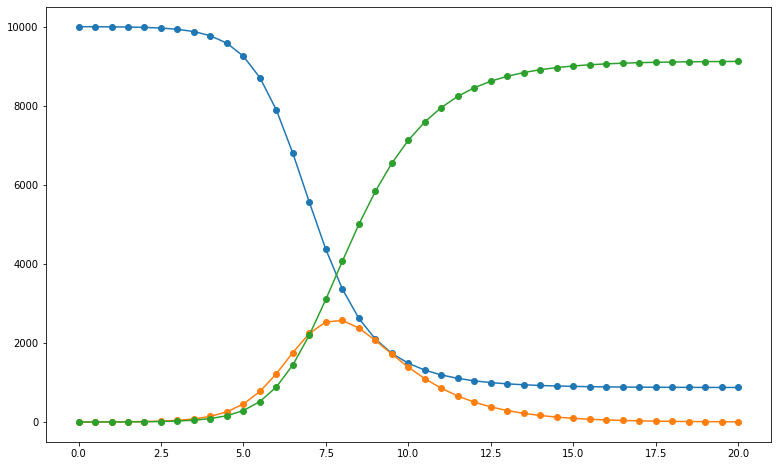

In [4]:
tofsol = np.linspace(0, 20, 41)
plt.plot(tofsol, sol.sol(tofsol).T, 'o-');

In [5]:
raw_data = sol.sol(tofsol)[2, :]
gendata = sol.sol(tofsol)[1, :]
randdata = np.random.multivariate_normal(gendata, 10000*np.exp(-1/(2*2**2)*np.abs(tofsol.reshape(1,-1)-tofsol.reshape(-1,1))**2)).reshape(1,-1)
randdata[randdata < 0] = 0
data = (np.cumsum(randdata)*p_true[1]*np.gradient(tofsol)).reshape(1, -1)
# data = raw_data.reshape(1,-1)
data_pd = np.array([i for i in data.T])

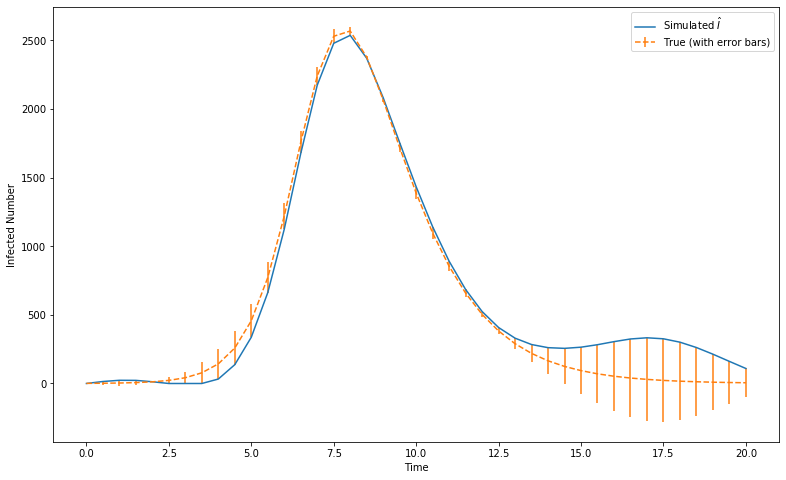

In [46]:
# plt.plot(tofsol, gendata.T)
plt.plot(tofsol, randdata.T)
plt.errorbar(tofsol, gendata.T, (randdata-gendata).flatten(), linestyle='--')
plt.xlabel('Time')
plt.ylabel("Infected Number")
plt.legend([r'Simulated $\hat{I}$', 'True (with error bars)'])

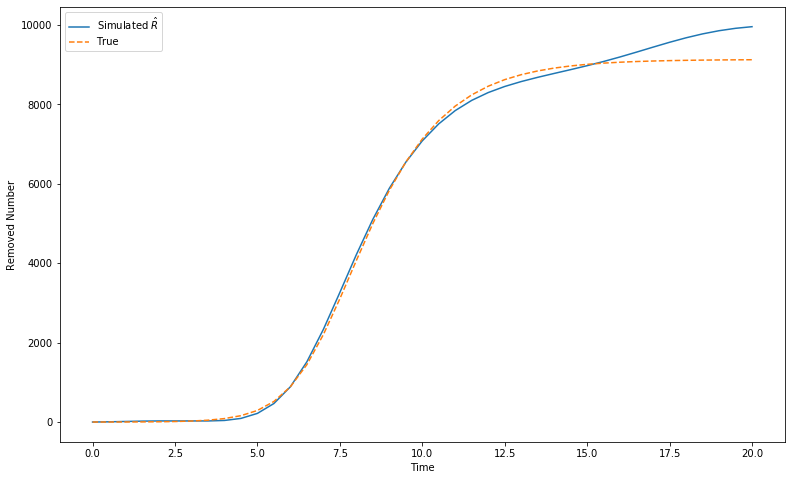

In [47]:
plt.plot(tofsol, data.T)
plt.plot(tofsol, raw_data.T, '--')
plt.xlabel('Time')
plt.ylabel("Removed Number")
plt.legend([r"Simulated $\hat{R}$", "True"])

In [8]:
from functions import misc
reload(misc)
knot_fn = misc.knot_fn


In [9]:
config = {
    "grid_size": 120,
    "basis_number": 60,
    "model_form": {
        "state": 3,
        "parameters": 2
    },
    "time_span": tspan,
    "knot_function": None,
    "model": system,
    "dataset": {"y": data_pd, "t": tofsol},
    "observation_vector": [2],
    "weightings":[
        [1]*3,
        [1]*len(tofsol)
    ],
    "regularisation_value": [1]*len(p_true),
}

In [10]:
model = modeller.Model(config)
objective = fitter.Objective()
objective.make(config, config['dataset'], model)

solver_setup = {
    'f': objective.objective,
    'x': ca.vcat(objective.input_list),
    'p': ca.hcat([objective.rho, objective.alpha]),
    'g': ca.vcat(model.xs),
}

opts = {
    'ipopt': {'max_iter': 300}
}

solver = ca.nlpsol('solver', 'ipopt', solver_setup, opts)

In [11]:
getx = ca.Function('getx', [solver_setup['x']], model.xs)
getp = ca.Function('getp', [solver_setup['x']], model.ps)

In [12]:
f1_ex = ca.Function('f1_ex', [solver_setup['x']], [objective.obj_1])
f2_ex = ca.Function('f2_ex', [solver_setup['x']], [objective.obj_2])

In [13]:
p0 = np.ones(2)
# p0 = p_true
c0 = [c*np.linspace(1, 0, config['basis_number'])+d for c,d in zip([10000, 1, -10000], [0, 0, 10000])]
x0 = np.hstack([*c0, p0])
lbx = [-np.inf]*(config['basis_number']*3) + [0]*len(config['regularisation_value'])

In [14]:
pure_data = solver(x0=x0, p=[1e-14, 1e-14], lbx=lbx, lbg=0);


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:    21600
Number of nonzeros in Lagrangian Hessian.............:    16653

Total number of variables............................:      182
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

[112862, 112707, 112399, 111938, 111479, 111022, 110567, 110114, 109662, 109213, 108765, 108320, 107802, 107286, 106773, 106334, 105898, 105463, 105030, 104599, 104170, 103743, 103319, 102827, 102339, 101854, 101441, 101029, 100620, 100212, 99805, 99399.8, 98995.6, 98592.5, 98190.2, 97721.7, 97254, 96787, 96387, 95987.3, 95587.7, 95188.3, 94788.8, 94389.3, 93989.7, 93589.9, 93123.1, 92655.9, 92188.1, 91786.6, 91384.5, 90981.8, 90578.4, 90174.1, 89768.9, 89362.7, 88955.4, 88478.7, 88137, 87931.2, 93236.8, 93312.4, 93461, 93686, 93908.1, 94129.7, 94349.5, 94568.2, 94785.5, 95001.6, 95216.5, 95430.3, 95678.3, 95924.8, 96169.6, 96378.1, 96585.3, 96790.8, 96994.2, 97195.4, 97393.7, 97588.8, 97780.4, 97999.6, 98213.4, 98421.9, 98597.3, 98769.7, 98939.4, 99106.5, 99271.5, 99434.6, 99596, 99756, 99914.7, 100099, 100281, 100463, 100617, 100772, 100925, 101078, 101231, 101383, 101534, 101686, 101861, 102036, 102211, 102360, 102508, 102656, 102804, 102951, 103098, 103245, 103391, 103562, 103684, 

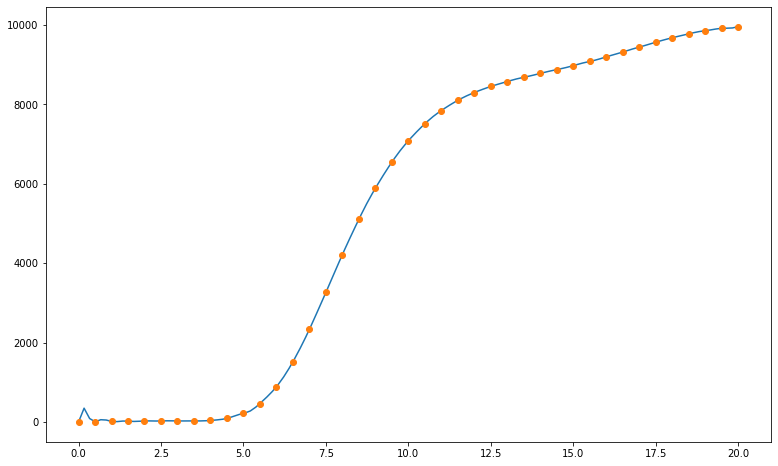

In [15]:
pure_xs = getx(pure_data['x'])
print(pure_data['x'])
plt.plot(model.observation_times, pure_xs[-1])
plt.plot(tofsol, data.T, 'o')

In [16]:
x0 = list(np.array(pure_data['x'][:-2]).flatten()) + list(p0)

In [17]:
prange = np.logspace(-6, 6, num=200)
solutions = []
xguess = x0
for p in prange:
    solutions.append(solver(x0=xguess, p=[p, 0.5], lbx=lbx, lbg=0))
    xguess = np.array(solutions[-1]['x']).flatten()

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:    21600
Number of nonzeros in Lagrangian Hessian.............:    16653

Total number of variables............................:      182
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  83  7.8399378e-01 0.00e+00 1.04e-02  -8.6 9.87e+04 -14.4 1.00e+00 3.88e-02h  4
  84  7.8264973e-01 0.00e+00 5.96e-03  -8.6 3.48e+03 -14.9 1.00e+00 1.00e+00h  1
  85  7.8154527e-01 0.00e+00 4.63e-03  -8.6 3.51e+03 -15.3 1.00e+00 1.00e+00h  1
  86  7.8065399e-01 0.00e+00 3.13e-03  -8.6 1.13e+04 -15.8 1.00e+00 1.00e+00h  1
  87  7.8008468e-01 0.00e+00 1.45e-02  -8.6 1.97e+04 -14.5 1.00e+00 1.80e-01h  3
  88  7.7848873e-01 0.00e+00 8.28e-04  -8.6 2.01e+03 -15.0 1.00e+00 1.00e+00h  1
  89  7.7856522e-01 0.00e+00 1.28e-02  -8.6 1.04e+04 -15.5 1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  7.7682897e-01 0.00e+00 5.20e-04  -8.6 2.45e+03 -15.0 1.00e+00 1.00e+00h  1
  91  7.7639896e-01 0.00e+00 7.98e-03  -8.6 1.52e+04 -15.5 1.00e+00 2.50e-01h  3
  92  7.7549745e-01 0.00e+00 1.17e-03  -8.6 2.76e+03 -15.1 1.00e+00 1.00e+00h  1
  93  7.7526391e-01 0.00e+00 9.58e-03  -8.6 7.85e+03 -15.6 1.00e+00 5.00e-01h  2
  94  7.7426018e-01 0.00e+00

 179  1.6108767e-01 0.00e+00 3.89e-04  -8.6 7.37e+02    -  7.93e-03 3.20e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180  1.5818304e-01 0.00e+00 2.88e-04  -8.6 5.92e+02    -  7.44e-03 2.97e-01f  1
 181  1.5586443e-01 0.00e+00 2.08e-04  -8.6 4.46e+02    -  7.18e-03 3.07e-01f  1
 182  1.5416868e-01 0.00e+00 1.48e-04  -8.6 3.21e+02    -  6.76e-03 3.12e-01f  1
 183  1.5316150e-01 0.00e+00 1.20e-04  -8.6 2.02e+02    -  6.44e-03 2.01e-01f  1
 184  1.5170609e-01 0.00e+00 8.36e-05  -8.6 1.88e+02    -  6.21e-03 3.14e-01f  1
 185  1.5094184e-01 0.00e+00 6.87e-05  -8.6 1.79e+02    -  5.89e-03 1.82e-01f  1
 186  1.4931926e-01 0.00e+00 4.39e-05  -8.6 2.03e+02    -  5.85e-03 3.71e-01f  1
 187  1.4844764e-01 0.00e+00 3.25e-05  -8.6 1.72e+02    -  5.59e-03 2.61e-01f  1
 188  1.4713021e-01 0.00e+00 2.03e-05  -8.6 1.84e+02    -  5.48e-03 3.77e-01f  1
 189  1.4627712e-01 0.00e+00 1.40e-05  -8.6 1.58e+02    -  5.23e-03 3.09e-01f  1
iter    objective    inf_pr 

Total number of variables............................:      182
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  6.4967280e-02 0.00e+00 1.02e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  6.8245352e-02 0.00e+00 1.08e-02  -1.0 1.68e-01    -  9.89e-01 1.00e+00f  1
   2  6.3646217e-01 0.00e+00 8.28e-02  -1.0 1.99e+01    -  6.14e-01 1.00e+00f  1
   3  2.2150648e-01 0.00e+00 2.43e-02  -1.0 1.65e+02    -  4.66e-01 1.00e+00f  1
   4  2.2760899e-0

   2  6.5378410e-01 0.00e+00 8.27e-02  -1.0 1.98e+01    -  6.14e-01 1.00e+00f  1
   3  2.4819449e-01 0.00e+00 2.40e-02  -1.0 1.63e+02    -  4.72e-01 1.00e+00f  1
   4  2.5992062e-01 0.00e+00 7.36e-03  -1.0 8.21e+01    -  8.48e-01 1.00e+00f  1
   5  4.3453585e-01 0.00e+00 5.44e-02  -1.0 7.26e+02    -  8.87e-01 1.00e+00f  1
   6  4.7011825e-01 0.00e+00 3.24e-01  -1.7 1.63e+03    -  9.29e-01 1.00e+00f  1
   7  8.7479755e-01 0.00e+00 2.18e+00  -1.7 1.06e+04    -  5.92e-01 4.69e-01f  2
   8  1.2914535e+00 0.00e+00 2.69e+00  -1.7 1.45e+04    -  9.47e-01 1.00e+00f  1
   9  3.0686368e+00 0.00e+00 2.23e+01  -1.7 3.63e+04    -  5.79e-01 7.70e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.5243066e+00 0.00e+00 2.33e-04  -1.7 3.36e-01  -4.0 1.00e+00 1.00e+00f  1
  11  1.4021214e+00 0.00e+00 4.09e-01  -2.5 5.91e+03    -  9.63e-01 1.00e+00f  1
  12  1.3999426e+00 0.00e+00 6.57e-05  -2.5 1.97e+00  -4.5 1.00e+00 1.00e+00f  1
  13  1.3972952e+00 0.00e+00

  28  1.0597557e-01 0.00e+00 6.35e-02  -8.6 6.58e+02  -9.4 1.00e+00 1.00e+00f  1
  29  1.0039145e-01 0.00e+00 1.24e-01  -8.6 2.99e+04    -  1.00e+00 4.57e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  9.3016566e-02 0.00e+00 3.89e-03  -8.6 4.80e+02    -  1.00e+00 1.00e+00f  1
  31  9.2927568e-02 0.00e+00 8.93e-04  -8.6 7.05e+02    -  1.00e+00 1.00e+00f  1
  32  9.2917579e-02 0.00e+00 5.94e-06  -8.6 7.21e+01    -  1.00e+00 1.00e+00h  1
  33  9.2916937e-02 0.00e+00 5.30e-07  -8.6 2.51e+00    -  1.00e+00 1.00e+00h  1
  34  9.2916930e-02 0.00e+00 6.82e-09  -8.6 2.33e-01    -  1.00e+00 1.00e+00h  1
  35  9.2916929e-02 0.00e+00 8.61e-12  -9.0 8.36e-02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 35

                                   (scaled)                 (unscaled)
Objective...............:   9.2916929073891277e-02    9.2916929073891277e-02
Dual infeasibility......:   8.6057143153732884e-12    8.6057143153732884e-12
Constraint viol

   3  2.9996163e-01 0.00e+00 2.35e-02  -1.0 1.58e+02    -  4.85e-01 1.00e+00f  1
   4  3.1672447e-01 0.00e+00 3.22e-03  -1.0 8.24e+01    -  9.36e-01 1.00e+00f  1
   5  8.5579618e-01 0.00e+00 1.41e+00  -1.0 2.26e+03    -  6.47e-01 1.00e+00f  1
   6  1.7957087e+00 0.00e+00 4.16e+00  -1.0 2.99e+03    -  6.70e-01 1.00e+00f  1
   7  3.9494261e+00 0.00e+00 2.37e+01  -1.0 9.11e+03    -  7.04e-01 1.00e+00f  1
   8  1.8659379e+00 0.00e+00 9.01e-04  -1.0 7.21e-01  -4.0 1.00e+00 1.00e+00f  1
   9  1.5708208e+00 0.00e+00 3.66e-02  -2.5 3.12e+03    -  9.29e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.4501310e+00 0.00e+00 5.99e-01  -2.5 4.51e+03    -  1.00e+00 1.00e+00f  1
  11  1.4440782e+00 0.00e+00 9.49e-05  -2.5 2.85e+00  -4.5 1.00e+00 1.00e+00f  1
  12  1.4405741e+00 0.00e+00 1.18e-04  -3.8 1.06e+01  -5.0 1.00e+00 1.00e+00f  1
  13  1.4374027e+00 0.00e+00 7.24e-05  -5.7 1.96e+01  -5.4 1.00e+00 1.00e+00f  1
  14  1.4359271e+00 0.00e+00

   1  1.4743482e-01 0.00e+00 1.08e-02  -1.0 1.59e-01    -  9.89e-01 1.00e+00f  1
   2  7.1494459e-01 0.00e+00 8.24e-02  -1.0 1.97e+01    -  6.16e-01 1.00e+00f  1
   3  3.4302103e-01 0.00e+00 2.31e-02  -1.0 1.53e+02    -  4.97e-01 1.00e+00f  1
   4  3.5968191e-01 0.00e+00 3.50e-03  -1.0 9.15e+01    -  9.61e-01 1.00e+00f  1
   5  2.5854615e+00 0.00e+00 7.49e+00  -1.0 4.16e+03    -  3.11e-01 1.00e+00f  1
   6  5.5212961e+00 0.00e+00 2.72e+01  -1.0 2.67e+03    -  8.38e-01 1.00e+00f  1
   7  1.7029856e+00 0.00e+00 5.28e-03  -1.0 1.01e+00  -4.0 1.00e+00 1.00e+00f  1
   8  1.3300700e+00 0.00e+00 5.94e-02  -2.5 7.97e+02    -  9.30e-01 1.00e+00f  1
   9  9.9515150e-01 0.00e+00 1.43e+00  -2.5 3.22e+03    -  6.08e-01 4.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  7.1840512e-01 0.00e+00 9.43e-01  -2.5 3.55e+03    -  1.00e+00 1.00e+00f  1
  11  6.0479075e-01 0.00e+00 1.28e+00  -2.5 3.21e+04    -  5.97e-01 5.00e-01f  2
  12  4.1633671e-01 0.00e+00

  26  1.8157908e-01 0.00e+00 4.00e-05  -8.6 1.35e+01  -7.3 1.00e+00 1.00e+00f  1
  27  1.8140470e-01 0.00e+00 3.32e-05  -8.6 2.38e+01  -7.8 1.00e+00 1.00e+00f  1
  28  1.8128834e-01 0.00e+00 3.08e-05  -8.6 2.99e+01  -8.3 1.00e+00 1.00e+00f  1
  29  1.8122182e-01 0.00e+00 1.30e-05  -8.6 3.28e+01  -8.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.8116479e-01 0.00e+00 8.10e-06  -8.6 4.06e+01  -9.2 1.00e+00 1.00e+00f  1
  31  1.8112005e-01 0.00e+00 1.00e-05  -8.6 5.27e+01  -9.7 1.00e+00 1.00e+00f  1
  32  1.8104989e-01 0.00e+00 3.20e-06  -8.6 8.78e+01 -10.2 1.00e+00 1.00e+00f  1
  33  1.8084360e-01 0.00e+00 5.07e-05  -8.6 2.37e+02 -10.7 1.00e+00 1.00e+00f  1
  34  1.8019421e-01 0.00e+00 5.04e-04  -8.6 7.32e+02 -11.2 1.00e+00 1.00e+00f  1
  35  1.7792181e-01 0.00e+00 6.11e-03  -8.6 2.41e+03 -11.6 1.00e+00 1.00e+00f  1
  36  1.6963244e-01 0.00e+00 1.64e-01  -8.6 9.90e+03 -12.1 1.00e+00 1.00e+00f  1
  37  1.6218751e-01 0.00e+00

   1  1.9674228e-01 0.00e+00 1.08e-02  -1.0 1.53e-01    -  9.89e-01 1.00e+00f  1
   2  7.6448126e-01 0.00e+00 8.20e-02  -1.0 1.96e+01    -  6.17e-01 1.00e+00f  1
   3  4.2046317e-01 0.00e+00 2.21e-02  -1.0 1.44e+02    -  5.22e-01 1.00e+00f  1
   4  4.3105057e-01 0.00e+00 4.23e-03  -1.0 1.10e+02    -  9.60e-01 1.00e+00f  1
   5  4.4642859e+00 0.00e+00 1.33e+01  -1.0 4.41e+03    -  3.06e-01 1.00e+00f  1
   6  3.2109141e+00 0.00e+00 1.55e+01  -1.0 4.85e+03    -  6.07e-01 5.00e-01f  2
   7  2.1464638e+00 0.00e+00 2.38e-03  -1.0 3.32e+00  -4.0 1.00e+00 1.00e+00f  1
   8  1.4331140e+00 0.00e+00 1.36e-01  -2.5 1.39e+03    -  9.35e-01 1.00e+00f  1
   9  1.0207376e+00 0.00e+00 1.80e+00  -2.5 3.14e+03    -  5.82e-01 3.23e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  7.1750541e-01 0.00e+00 9.60e-01  -2.5 1.64e+03    -  1.00e+00 1.00e+00f  1
  11  6.6177809e-01 0.00e+00 9.90e-01  -2.5 3.07e+04    -  3.37e-01 2.17e-01f  3
  12  5.3029344e-01 0.00e+00

  34  2.3743295e-01 0.00e+00 2.13e-01  -3.8 1.51e+03    -  1.00e+00 1.00e+00f  1
  35  2.2290810e-01 0.00e+00 2.59e-01  -3.8 2.40e+03    -  1.00e+00 5.00e-01f  2
  36  2.1419950e-01 0.00e+00 4.02e-02  -3.8 8.87e+02    -  1.00e+00 1.00e+00f  1
  37  2.1335619e-01 0.00e+00 3.92e-02  -3.8 1.06e+03    -  1.00e+00 1.00e+00f  1
  38  2.1366000e-01 0.00e+00 6.94e-03  -3.8 5.28e+02    -  1.00e+00 1.00e+00f  1
  39  2.1402062e-01 0.00e+00 1.98e-03  -3.8 2.82e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  2.1408185e-01 0.00e+00 3.60e-05  -3.8 3.98e+01    -  1.00e+00 1.00e+00h  1
  41  2.1249894e-01 0.00e+00 4.77e-02  -5.7 1.37e+03    -  9.76e-01 1.00e+00f  1
  42  2.1213623e-01 0.00e+00 3.71e-04  -5.7 1.34e+02    -  1.00e+00 1.00e+00f  1
  43  2.1212546e-01 0.00e+00 1.16e-04  -5.7 6.16e+01    -  1.00e+00 1.00e+00h  1
  44  2.1212446e-01 0.00e+00 1.69e-08  -5.7 9.94e-01    -  1.00e+00 1.00e+00h  1
  45  2.1212308e-01 0.00e+00

   3  5.1142231e-01 0.00e+00 2.05e-02  -1.0 1.32e+02    -  5.61e-01 1.00e+00f  1
   4  5.1182170e-01 0.00e+00 5.88e-03  -1.0 1.40e+02    -  9.68e-01 1.00e+00f  1
   5  5.9411577e-01 0.00e+00 6.31e-01  -1.7 1.28e+03    -  7.68e-01 1.00e+00f  1
   6  1.0227968e+00 0.00e+00 1.75e+00  -1.7 2.52e+03    -  9.47e-01 1.00e+00f  1
   7  2.6352969e+00 0.00e+00 1.03e+01  -1.7 1.26e+04    -  7.45e-01 1.00e+00f  1
   8  3.4409713e+00 0.00e+00 1.34e+01  -1.7 1.52e+05    -  2.57e-02 1.98e-02f  2
   9  4.4218037e+00 0.00e+00 2.49e+01  -1.7 2.30e+04    -  8.50e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.1192675e+00 0.00e+00 8.85e-04  -1.7 1.28e+00  -4.0 1.00e+00 1.00e+00f  1
  11  2.9142081e+00 0.00e+00 6.94e+00  -3.8 8.57e+03    -  3.91e-01 4.92e-01f  1
  12  1.6133242e+00 0.00e+00 2.72e+00  -3.8 3.67e+03    -  6.47e-02 1.00e+00f  1
  13  1.4716014e+00 0.00e+00 5.48e-04  -3.8 2.37e+00  -4.5 1.00e+00 1.00e+00f  1
  14  1.4691075e+00 0.00e+00

   9  4.8293777e+00 0.00e+00 2.17e+01  -1.7 2.54e+04    -  6.79e-01 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.2734745e+00 0.00e+00 3.31e-04  -1.7 7.08e-01  -4.0 1.00e+00 1.00e+00f  1
  11  4.2581262e+00 0.00e+00 3.25e-04  -3.8 9.74e+00  -4.5 1.00e+00 1.00e+00f  1
  12  4.2484470e+00 0.00e+00 1.77e-04  -3.8 1.59e+01  -5.0 1.00e+00 1.00e+00f  1
  13  4.2436463e+00 0.00e+00 4.43e-05  -5.7 1.20e+01  -5.4 9.91e-01 1.00e+00f  1
  14  4.2381832e+00 0.00e+00 4.39e-05  -5.7 1.26e+01  -5.9 1.00e+00 1.00e+00f  1
  15  4.2252373e+00 0.00e+00 5.58e-04  -5.7 2.59e+01  -6.4 1.00e+00 1.00e+00f  1
  16  4.1918522e+00 0.00e+00 5.09e-03  -5.7 5.40e+01  -6.9 1.00e+00 1.00e+00f  1
  17  4.0973677e+00 0.00e+00 5.07e-02  -5.7 1.22e+02  -7.3 1.00e+00 1.00e+00f  1
  18  3.7807777e+00 0.00e+00 5.87e-01  -5.7 3.58e+02  -7.8 1.00e+00 1.00e+00f  1
  19  3.2646145e+00 0.00e+00 7.18e+00  -5.7 1.64e+03  -8.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

  39  5.3765048e+00 0.00e+00 9.39e+00  -5.7 8.94e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  5.2973212e+00 0.00e+00 4.90e-01  -5.7 4.96e+02  -8.9 1.00e+00 1.00e+00f  1
  41  5.2350911e+00 0.00e+00 2.14e+00  -5.7 1.28e+03  -9.4 1.00e+00 1.00e+00f  1
  42  5.1238417e+00 0.00e+00 1.90e+01  -5.7 9.63e+03  -9.9 8.86e-01 4.06e-01f  2
  43  4.9751696e+00 0.00e+00 1.25e+01  -5.7 1.05e+05    -  1.00e+00 1.19e-01f  2
  44  4.2219961e+00 0.00e+00 1.01e+01  -5.7 7.04e+03    -  1.00e+00 1.00e+00f  1
  45  4.2041684e+00 0.00e+00 1.11e+01  -5.7 4.35e+03    -  8.84e-01 5.74e-01f  1
  46  2.9062212e+00 0.00e+00 9.82e-01  -5.7 1.48e+04    -  1.87e-05 2.92e-01f  1
  47  2.1335196e+00 0.00e+00 4.71e+00  -5.7 4.17e+03  -8.5 1.00e+00 3.80e-01f  1
  48  9.8296588e-01 0.00e+00 3.52e+00  -5.7 5.59e+03    -  9.67e-01 1.00e+00f  1
  49  5.4756319e-01 0.00e+00 1.77e+00  -5.7 1.11e+03    -  1.00e+00 6.77e-01f  1
iter    objective    inf_pr 

   4  7.5067273e-01 0.00e+00 5.01e-02  -1.0 3.07e+02    -  9.72e-01 1.00e+00f  1
   5  9.8910853e-01 0.00e+00 2.03e+00  -1.7 1.53e+03    -  9.49e-01 1.00e+00f  1
   6  2.3858957e+00 0.00e+00 8.45e+00  -1.7 5.65e+03    -  1.00e+00 1.00e+00f  1
   7  2.4164496e+00 0.00e+00 4.86e+00  -1.7 6.09e+03    -  5.40e-01 2.20e-01f  3
   8  2.3868339e+00 0.00e+00 1.43e+00  -1.7 4.23e+03    -  1.00e+00 1.00e+00f  1
   9  2.2670614e+00 0.00e+00 4.98e+00  -1.7 1.12e+04    -  9.91e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.2730781e+00 0.00e+00 1.28e+00  -1.7 1.90e+04    -  1.00e+00 1.00e+00f  1
  11  2.3043792e+00 0.00e+00 1.02e+00  -1.7 1.87e+04    -  1.00e+00 1.00e+00f  1
  12  2.3459223e+00 0.00e+00 8.18e-01  -1.7 3.07e+04    -  1.00e+00 1.00e+00f  1
  13  2.3827758e+00 0.00e+00 2.51e-02  -1.7 3.98e+01    -  1.00e+00 1.00e+00f  1
  14  1.5824936e+00 0.00e+00 1.82e+00  -3.8 2.32e+03    -  3.99e-01 1.96e-01f  2
  15  1.0127386e+00 0.00e+00

  28  6.4882929e-01 0.00e+00 3.59e-05  -8.6 1.69e+01  -7.8 1.00e+00 1.00e+00f  1
  29  6.4857922e-01 0.00e+00 7.60e-06  -8.6 2.66e+01  -8.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  6.4815293e-01 0.00e+00 1.50e-05  -8.6 5.27e+01  -8.8 1.00e+00 1.00e+00f  1
  31  6.4713374e-01 0.00e+00 1.08e-04  -8.6 1.11e+02  -9.2 1.00e+00 1.00e+00f  1
  32  6.4403907e-01 0.00e+00 1.19e-03  -8.6 3.11e+02  -9.7 1.00e+00 1.00e+00f  1
  33  6.3369597e-01 0.00e+00 1.31e-02  -8.6 9.93e+02 -10.2 1.00e+00 1.00e+00f  1
  34  5.8980275e-01 0.00e+00 2.38e-01  -8.6 3.74e+03 -10.7 1.00e+00 1.00e+00f  1
  35  5.5408375e-01 0.00e+00 1.21e+00  -8.6 1.33e+04 -11.2 1.00e+00 4.34e-01f  2
  36  4.7181065e-01 0.00e+00 2.64e-01  -8.6 1.18e+03    -  1.00e+00 1.00e+00f  1
  37  4.5042300e-01 0.00e+00 2.29e-01  -8.6 7.08e+03    -  1.00e+00 1.99e-01f  3
  38  4.3166207e-01 0.00e+00 3.02e-01  -8.6 1.37e+03    -  1.00e+00 1.00e+00f  1
  39  4.2142670e-01 0.00e+00

   3  8.2823536e-01 0.00e+00 8.33e-03  -1.0 8.12e+01    -  8.39e-01 1.00e+00f  1
   4  1.1000279e+00 0.00e+00 4.14e-01  -1.0 6.79e+02    -  9.46e-01 1.00e+00f  1
   5  1.1638240e+00 0.00e+00 8.58e-01  -1.7 1.14e+03    -  9.56e-01 1.00e+00f  1
   6  1.5350897e+00 0.00e+00 3.16e+00  -1.7 4.90e+03    -  1.00e+00 5.00e-01f  2
   7  1.8299220e+00 0.00e+00 2.45e+00  -1.7 3.74e+03    -  1.00e+00 1.00e+00f  1
   8  1.8715509e+00 0.00e+00 1.60e+00  -1.7 3.91e+03    -  1.00e+00 1.00e+00f  1
   9  2.2267078e+00 0.00e+00 5.48e+00  -1.7 1.23e+04    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.0976309e+00 0.00e+00 5.32e-01  -1.7 1.15e+04    -  1.00e+00 1.00e+00f  1
  11  2.0423304e+00 0.00e+00 2.60e+00  -1.7 2.89e+04    -  1.00e+00 1.00e+00f  1
  12  2.1232586e+00 0.00e+00 4.76e-01  -1.7 3.36e+04    -  1.00e+00 1.00e+00f  1
  13  2.1551976e+00 0.00e+00 1.83e-02  -1.7 6.70e+03    -  1.00e+00 1.00e+00f  1
  14  1.4694214e+00 0.00e+00

  24  5.0797163e-01 0.00e+00 1.35e-02  -5.7 1.56e+02    -  9.71e-01 1.00e+00f  1
  25  5.0791276e-01 0.00e+00 3.27e-05  -5.7 5.78e+00    -  1.00e+00 1.00e+00f  1
  26  5.0790741e-01 0.00e+00 8.94e-07  -5.7 1.30e+00    -  1.00e+00 1.00e+00h  1
  27  5.0790575e-01 0.00e+00 1.93e-06  -8.6 2.07e+00    -  1.00e+00 1.00e+00h  1
  28  5.0790542e-01 0.00e+00 8.12e-11  -8.6 1.17e-02    -  1.00e+00 1.00e+00h  1
  29  5.0790535e-01 0.00e+00 1.34e-12  -8.6 1.08e-03    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  5.0790533e-01 0.00e+00 3.37e-13  -8.6 5.21e-04    -  1.00e+00 1.00e+00h  1
  31  5.0790532e-01 0.00e+00 1.47e-12  -9.0 1.61e-03    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 31

                                   (scaled)                 (unscaled)
Objective...............:   5.0790532423482870e-01    5.0790532423482870e-01
Dual infeasibility......:   1.4669409226345800e-12    1.4669409226345800e-12
Constraint viol

   3  9.4811956e-01 0.00e+00 1.24e-02  -1.0 9.88e+01    -  9.68e-01 1.00e+00f  1
   4  6.8824431e+00 0.00e+00 2.38e+01  -1.0 3.23e+03    -  7.26e-01 1.00e+00f  1
   5  6.3809643e+00 0.00e+00 1.51e+01  -1.0 3.92e+03    -  9.05e-01 1.00e+00f  1
   6  5.3784272e+00 0.00e+00 5.30e-03  -1.0 1.37e+00  -4.0 1.00e+00 1.00e+00f  1
   7  2.6695926e+00 0.00e+00 1.12e+01  -2.5 2.35e+03    -  8.02e-01 1.00e+00f  1
   8  1.4142131e+00 0.00e+00 6.41e+00  -2.5 2.65e+03    -  9.97e-01 1.00e+00f  1
   9  8.6169973e-01 0.00e+00 3.26e+00  -2.5 7.60e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.7214932e-01 0.00e+00 7.21e-02  -2.5 2.63e+02    -  1.00e+00 1.00e+00f  1
  11  6.7074844e-01 0.00e+00 3.19e-01  -2.5 4.72e+03    -  5.89e-01 1.25e-01f  4
  12  6.8056056e-01 0.00e+00 4.09e-01  -2.5 1.32e+03    -  1.00e+00 5.00e-01f  2
  13  6.7331688e-01 0.00e+00 7.47e-02  -2.5 1.96e+02    -  1.00e+00 1.00e+00f  1
  14  6.8674070e-01 0.00e+00

  40  6.4454251e-01 0.00e+00 6.75e-01  -5.7 1.08e+03    -  1.00e+00 1.00e+00f  1
  41  6.2379229e-01 0.00e+00 1.04e-01  -5.7 1.12e+02    -  1.00e+00 1.00e+00f  1
  42  6.2233647e-01 0.00e+00 3.50e-01  -5.7 6.14e+02    -  1.00e+00 1.00e+00f  1
  43  6.1763482e-01 0.00e+00 4.27e-03  -5.7 3.31e+01    -  1.00e+00 1.00e+00f  1
  44  6.1756691e-01 0.00e+00 7.94e-03  -5.7 6.54e+01    -  1.00e+00 1.00e+00f  1
  45  6.1756588e-01 0.00e+00 1.06e-06  -5.7 6.91e-01    -  1.00e+00 1.00e+00h  1
  46  6.1756502e-01 0.00e+00 2.07e-06  -8.6 1.47e+00    -  1.00e+00 1.00e+00h  1
  47  6.1756487e-01 0.00e+00 3.11e-11  -8.6 6.10e-03    -  1.00e+00 1.00e+00h  1
  48  6.1756483e-01 0.00e+00 9.08e-13  -8.6 7.37e-04    -  1.00e+00 1.00e+00h  1
  49  6.1756483e-01 0.00e+00 1.96e-13  -8.6 3.27e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 49

                                   (scaled)                 (unscaled)
Objective...............:   6.1756482917630218e-01    6.1756482917630218e-01
Dual infeas

   4  1.2062186e+00 0.00e+00 9.36e-01  -1.7 8.99e+02    -  9.59e-01 1.00e+00f  1
   5  2.2316498e+00 0.00e+00 7.99e+00  -1.7 2.59e+03    -  1.00e+00 1.00e+00f  1
   6  1.7449818e+00 0.00e+00 1.17e+00  -1.7 1.18e+03    -  1.00e+00 1.00e+00f  1
   7  1.7351627e+00 0.00e+00 7.83e-05  -1.7 2.14e-01  -4.0 1.00e+00 1.00e+00f  1
   8  1.2818060e+00 0.00e+00 4.71e+00  -3.8 2.22e+03    -  7.94e-01 1.00e+00f  1
   9  7.8057921e-01 0.00e+00 4.65e-01  -3.8 4.00e+02    -  8.13e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  7.4835001e-01 0.00e+00 3.82e-01  -3.8 3.29e+03    -  8.12e-01 2.50e-01f  3
  11  7.2600203e-01 0.00e+00 2.86e-01  -3.8 4.88e+02    -  1.00e+00 1.00e+00f  1
  12  7.1528635e-01 0.00e+00 2.18e-01  -3.8 4.47e+02    -  1.00e+00 1.00e+00f  1
  13  7.1038108e-01 0.00e+00 1.16e-01  -3.8 2.19e+02    -  1.00e+00 1.00e+00f  1
  14  7.0844349e-01 0.00e+00 8.99e-02  -3.8 2.05e+02    -  1.00e+00 1.00e+00f  1
  15  7.0803559e-01 0.00e+00

   3  1.2341101e+00 0.00e+00 3.76e-02  -1.0 1.65e+02    -  9.78e-01 1.00e+00f  1
   4  1.3091006e+00 0.00e+00 9.35e-01  -1.7 7.76e+02    -  9.67e-01 1.00e+00f  1
   5  1.5235070e+00 0.00e+00 3.18e+00  -1.7 2.44e+03    -  1.00e+00 5.00e-01f  2
   6  1.6564079e+00 0.00e+00 1.25e+00  -1.7 1.17e+03    -  1.00e+00 1.00e+00f  1
   7  1.9168260e+00 0.00e+00 4.43e+00  -1.7 2.25e+03    -  1.00e+00 1.00e+00f  1
   8  1.8602255e+00 0.00e+00 6.58e-01  -1.7 1.57e+03    -  1.00e+00 1.00e+00f  1
   9  2.0409897e+00 0.00e+00 3.41e+00  -1.7 6.68e+03    -  9.05e-01 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.2704803e+00 0.00e+00 2.35e+00  -1.7 4.85e+03    -  1.00e+00 1.00e+00f  1
  11  2.3470423e+00 0.00e+00 1.17e+00  -1.7 4.34e+03    -  1.00e+00 1.00e+00f  1
  12  2.9202074e+00 0.00e+00 6.09e+00  -1.7 1.62e+04    -  1.00e+00 1.00e+00f  1
  13  2.7736612e+00 0.00e+00 1.20e-01  -1.7 1.05e+04    -  1.00e+00 1.00e+00f  1
  14  2.1990757e+00 0.00e+00

  29  1.7084553e+00 0.00e+00 2.79e-04  -5.7 5.44e+01  -7.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.7052742e+00 0.00e+00 1.13e-04  -5.7 8.34e+01  -8.3 1.00e+00 1.00e+00f  1
  31  1.6979015e+00 0.00e+00 1.55e-03  -5.7 1.67e+02  -8.8 1.00e+00 1.00e+00f  1
  32  1.6748653e+00 0.00e+00 1.64e-02  -5.7 4.94e+02  -9.2 1.00e+00 1.00e+00f  1
  33  1.5930133e+00 0.00e+00 2.07e-01  -5.7 1.65e+03  -9.7 1.00e+00 1.00e+00f  1
  34  1.4214068e+00 0.00e+00 1.28e+00  -5.7 6.61e+03 -10.2 1.00e+00 5.00e-01f  2
  35  1.3616946e+00 0.00e+00 3.77e+00  -5.7 7.94e+03    -  1.00e+00 5.00e-01f  2
  36  1.1008107e+00 0.00e+00 8.40e-01  -5.7 5.34e+02    -  1.00e+00 1.00e+00f  1
  37  1.0379172e+00 0.00e+00 7.06e-01  -5.7 5.22e+03    -  1.00e+00 2.39e-01f  3
  38  9.7639787e-01 0.00e+00 6.06e-01  -5.7 8.49e+02    -  1.00e+00 1.00e+00f  1
  39  9.3712059e-01 0.00e+00 5.27e-01  -5.7 6.65e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

   0  1.0318209e+00 0.00e+00 1.13e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  1.0331897e+00 0.00e+00 1.08e-02  -1.0 1.14e-01    -  9.89e-01 1.00e+00f  1
   2  1.6344952e+00 0.00e+00 3.52e-02  -1.0 3.01e+01    -  8.35e-01 1.00e+00f  1
   3  1.5995823e+00 0.00e+00 1.53e-01  -1.0 2.87e+02    -  9.68e-01 1.00e+00f  1
   4  1.5470143e+00 0.00e+00 8.14e-01  -1.7 5.74e+02    -  9.75e-01 1.00e+00f  1
   5  1.8064328e+00 0.00e+00 4.81e+00  -1.7 2.44e+03    -  1.00e+00 5.00e-01f  2
   6  1.7588847e+00 0.00e+00 6.77e-01  -1.7 7.52e+02    -  1.00e+00 1.00e+00f  1
   7  1.7538198e+00 0.00e+00 1.50e+00  -1.7 3.25e+03    -  9.37e-01 2.50e-01f  3
   8  2.1117567e+00 0.00e+00 4.78e+00  -1.7 3.96e+03    -  1.00e+00 5.00e-01f  2
   9  2.0010824e+00 0.00e+00 1.24e-01  -1.7 7.98e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.5069870e+00 0.00e+00 2.88e+00  -2.5 4.22e+03    -  1.00e+00 5.00e-01f  2
  11  1.2228283e+00 0.00e+00

  33  1.1624295e+00 0.00e+00 1.19e+00  -3.8 1.40e+03    -  8.82e-01 5.00e-01f  2
  34  1.1323935e+00 0.00e+00 4.26e-02  -3.8 1.31e+02    -  1.00e+00 1.00e+00f  1
  35  1.1272113e+00 0.00e+00 4.76e-01  -3.8 5.81e+02    -  1.00e+00 5.00e-01f  2
  36  1.1235996e+00 0.00e+00 8.18e-02  -3.8 1.11e+02    -  1.00e+00 1.00e+00f  1
  37  1.1222323e+00 0.00e+00 2.16e-01  -3.8 1.63e+02    -  1.00e+00 1.00e+00f  1
  38  1.1219175e+00 0.00e+00 5.85e-03  -3.8 2.47e+01    -  1.00e+00 1.00e+00f  1
  39  1.1218452e+00 0.00e+00 3.05e-03  -3.8 1.83e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  1.1218447e+00 0.00e+00 6.82e-07  -3.8 2.65e-01    -  1.00e+00 1.00e+00h  1
  41  1.1213232e+00 0.00e+00 2.95e-02  -5.7 7.53e+01    -  9.94e-01 1.00e+00f  1
  42  1.1212858e+00 0.00e+00 1.73e-05  -5.7 1.80e+00    -  1.00e+00 1.00e+00f  1
  43  1.1212817e+00 0.00e+00 6.38e-06  -8.6 1.06e+00    -  1.00e+00 1.00e+00h  1
  44  1.1212809e+00 0.00e+00

   3  5.7843972e+00 0.00e+00 9.64e+00  -1.0 1.90e+03    -  8.69e-01 1.00e+00f  1
   4  7.2811182e+00 0.00e+00 2.66e+01  -1.0 1.80e+03    -  1.00e+00 1.00e+00f  1
   5  7.7729073e+00 0.00e+00 6.68e+00  -1.0 1.35e+03    -  1.00e+00 1.00e+00f  1
   6  8.1667286e+00 0.00e+00 1.78e+01  -1.0 5.06e+03    -  7.98e-01 5.00e-01f  2
   7  9.3649360e+00 0.00e+00 1.26e+01  -1.0 4.52e+03    -  1.00e+00 1.00e+00f  1
   8  8.6009772e+00 0.00e+00 6.93e+00  -1.0 3.57e+03    -  1.00e+00 1.00e+00f  1
   9  1.2094851e+01 0.00e+00 3.29e+01  -1.0 1.55e+04    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.0463726e+01 0.00e+00 5.08e+00  -1.0 1.12e+04    -  1.00e+00 1.00e+00f  1
  11  9.4011659e+00 0.00e+00 1.27e+01  -1.0 3.30e+04    -  1.00e+00 1.00e+00f  1
  12  9.6679378e+00 0.00e+00 5.89e-01  -1.0 2.63e+04    -  1.00e+00 1.00e+00f  1
  13  6.6775528e+00 0.00e+00 6.82e+00  -1.7 5.23e+03    -  7.81e-01 5.00e-01f  2
  14  5.2041653e+00 0.00e+00

  27  4.3943550e+00 0.00e+00 1.54e-05  -5.7 3.93e+01  -8.8 1.00e+00 1.00e+00f  1
  28  4.3934769e+00 0.00e+00 1.92e-05  -8.6 9.35e+01  -9.2 1.00e+00 1.00e+00f  1
  29  4.3908264e+00 0.00e+00 1.79e-04  -8.6 2.81e+02  -9.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  4.3825944e+00 0.00e+00 1.72e-03  -8.6 8.60e+02 -10.2 1.00e+00 1.00e+00f  1
  31  4.3549724e+00 0.00e+00 1.87e-02  -8.6 2.76e+03 -10.7 1.00e+00 1.00e+00f  1
  32  4.2292978e+00 0.00e+00 3.43e-01  -8.6 1.05e+04 -11.2 1.00e+00 1.00e+00f  1
  33  3.8227952e+00 0.00e+00 5.66e+00  -8.6 3.15e+05 -11.6 6.46e-01 8.69e-02f  2
  34  3.3613801e+00 0.00e+00 5.93e+00  -8.6 2.03e+04    -  1.00e+00 5.00e-01f  2
  35  2.7458728e+00 0.00e+00 5.48e+00  -8.6 7.99e+03    -  1.00e+00 1.00e+00f  1
  36  2.2530573e+00 0.00e+00 1.26e+00  -8.6 2.51e+03    -  9.69e-01 1.00e+00f  1
  37  2.0772812e+00 0.00e+00 2.82e+00  -8.6 4.75e+03    -  1.00e+00 5.00e-01f  2
  38  1.8737172e+00 0.00e+00

  38  1.6222166e+00 0.00e+00 1.86e-02  -3.8 3.13e+01    -  1.00e+00 1.00e+00f  1
  39  1.6220495e+00 0.00e+00 2.12e-02  -3.8 3.32e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  1.6220461e+00 0.00e+00 2.06e-05  -3.8 1.04e+00    -  1.00e+00 1.00e+00h  1
  41  1.6216148e+00 0.00e+00 5.23e-02  -5.7 6.19e+01    -  9.97e-01 1.00e+00f  1
  42  1.6215833e+00 0.00e+00 1.25e-05  -5.7 7.40e-01    -  1.00e+00 1.00e+00f  1
  43  1.6215798e+00 0.00e+00 7.64e-06  -8.6 7.49e-01    -  1.00e+00 1.00e+00h  1
  44  1.6215792e+00 0.00e+00 1.76e-12  -8.6 3.49e-03    -  1.00e+00 1.00e+00h  1
  45  1.6215791e+00 0.00e+00 2.24e-11  -8.6 1.49e-03    -  1.00e+00 1.00e+00h  1
  46  1.6215791e+00 0.00e+00 1.76e-12  -8.6 4.30e-04    -  1.00e+00 1.00e+00h  1
  47  1.6215791e+00 0.00e+00 5.54e-12  -9.0 6.36e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 47

                                   (scaled)                 (unscaled)
Objecti

   3  6.1176433e+00 0.00e+00 9.08e+00  -1.0 1.49e+03    -  8.97e-01 1.00e+00f  1
   4  7.5724751e+00 0.00e+00 2.35e+01  -1.0 1.47e+03    -  1.00e+00 1.00e+00f  1
   5  6.8627040e+00 0.00e+00 3.22e+00  -1.0 8.77e+02    -  1.00e+00 1.00e+00f  1
   6  7.4094503e+00 0.00e+00 1.61e+01  -1.0 3.42e+03    -  1.00e+00 5.00e-01f  2
   7  8.4672421e+00 0.00e+00 1.17e+01  -1.0 2.49e+03    -  1.00e+00 1.00e+00f  1
   8  7.8116176e+00 0.00e+00 9.16e+00  -1.0 2.22e+03    -  1.00e+00 1.00e+00f  1
   9  9.4095280e+00 0.00e+00 1.70e+01  -1.0 5.20e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  9.1521856e+00 0.00e+00 6.26e+00  -1.0 4.76e+03    -  1.00e+00 1.00e+00f  1
  11  1.0201031e+01 0.00e+00 2.05e+01  -1.0 1.34e+04    -  1.00e+00 1.00e+00f  1
  12  9.9699764e+00 0.00e+00 3.89e+00  -1.0 1.38e+04    -  1.00e+00 1.00e+00f  1
  13  1.0039319e+01 0.00e+00 4.92e+00  -1.0 1.92e+04    -  1.00e+00 1.00e+00f  1
  14  1.0331448e+01 0.00e+00

   9  1.1060284e+01 0.00e+00 3.22e+01  -1.0 6.12e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  9.0794863e+00 0.00e+00 1.19e+00  -1.0 2.59e+03    -  1.00e+00 1.00e+00f  1
  11  9.3498683e+00 0.00e+00 1.50e+01  -1.0 5.31e+04    -  2.77e-01 1.58e-01f  3
  12  1.1430740e+01 0.00e+00 2.49e+01  -1.0 2.23e+04    -  1.00e+00 1.00e+00f  1
  13  1.0509100e+01 0.00e+00 6.67e-01  -1.0 7.63e+03    -  1.00e+00 1.00e+00f  1
  14  7.8489480e+00 0.00e+00 7.09e+00  -1.7 3.75e+03    -  8.59e-01 5.00e-01f  2
  15  6.0929883e+00 0.00e+00 3.69e+00  -1.7 1.44e+04    -  1.00e+00 1.00e+00f  1
  16  5.3010452e+00 0.00e+00 7.22e+00  -1.7 2.60e+04    -  1.00e+00 5.00e-01f  2
  17  4.7503626e+00 0.00e+00 1.00e+00  -1.7 3.56e+03    -  1.00e+00 1.00e+00f  1
  18  4.3048409e+00 0.00e+00 3.66e+00  -1.7 6.37e+05    -  1.29e-01 7.70e-03f  3
  19  4.1431431e+00 0.00e+00 1.47e-01  -1.7 1.04e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  2.6310434e+00 0.00e+00 2.95e-01  -2.5 2.40e+02    -  1.00e+00 1.00e+00f  1
  21  2.6127789e+00 0.00e+00 1.31e+00  -2.5 5.12e+02    -  1.00e+00 1.00e+00f  1
  22  2.6024550e+00 0.00e+00 6.52e-02  -2.5 8.93e+01    -  1.00e+00 1.00e+00f  1
  23  2.5926992e+00 0.00e+00 4.51e-01  -2.5 5.03e+02    -  1.00e+00 5.00e-01f  2
  24  2.5869520e+00 0.00e+00 1.60e-01  -2.5 1.42e+02    -  1.00e+00 1.00e+00f  1
  25  2.5793311e+00 0.00e+00 3.72e-01  -2.5 2.14e+02    -  1.00e+00 1.00e+00f  1
  26  2.5766663e+00 0.00e+00 4.86e-02  -2.5 7.17e+01    -  1.00e+00 1.00e+00f  1
  27  2.5709673e+00 0.00e+00 2.51e-01  -2.5 1.64e+02    -  1.00e+00 1.00e+00f  1
  28  2.5701024e+00 0.00e+00 7.54e-03  -2.5 2.64e+01    -  1.00e+00 1.00e+00f  1
  29  2.5578455e+00 0.00e+00 1.01e+00  -3.8 2.63e+03    -  7.41e-01 1.25e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  2.5323797e+00 0.00e+00

  37  3.3522257e+00 0.00e+00 1.57e+00  -5.7 1.21e+03    -  1.00e+00 1.00e+00f  1
  38  3.2250192e+00 0.00e+00 4.12e+00  -5.7 1.85e+03    -  1.00e+00 1.00e+00f  1
  39  3.0601972e+00 0.00e+00 6.83e-01  -5.7 2.90e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  3.0045644e+00 0.00e+00 1.58e+00  -5.7 1.58e+03    -  1.00e+00 5.00e-01f  2
  41  2.9510560e+00 0.00e+00 8.73e-01  -5.7 4.71e+02    -  1.00e+00 1.00e+00f  1
  42  2.9219650e+00 0.00e+00 1.62e+00  -5.7 6.52e+02    -  1.00e+00 1.00e+00f  1
  43  2.8951096e+00 0.00e+00 3.83e-01  -5.7 2.53e+02    -  1.00e+00 1.00e+00f  1
  44  2.8834798e+00 0.00e+00 8.39e-01  -5.7 6.85e+02    -  1.00e+00 5.00e-01f  2
  45  2.8710149e+00 0.00e+00 7.58e-01  -5.7 3.32e+02    -  1.00e+00 1.00e+00f  1
  46  2.8616269e+00 0.00e+00 7.59e-01  -5.7 3.10e+02    -  1.00e+00 1.00e+00f  1
  47  2.8538341e+00 0.00e+00 6.84e-01  -5.7 2.73e+02    -  1.00e+00 1.00e+00f  1
  48  2.8472395e+00 0.00e+00

  35  6.3217862e+00 0.00e+00 1.71e+01  -8.6 8.75e+04 -11.2 6.57e-01 1.87e-01f  2
  36  4.7289740e+00 0.00e+00 2.66e+00  -8.6 2.95e+03    -  1.00e+00 1.00e+00f  1
  37  4.3299322e+00 0.00e+00 3.79e+00  -8.6 5.29e+04    -  2.24e-01 6.73e-02f  3
  38  3.9317663e+00 0.00e+00 5.30e+00  -8.6 3.16e+03    -  1.00e+00 1.00e+00f  1
  39  3.6241469e+00 0.00e+00 1.71e+00  -8.6 8.71e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  3.5419224e+00 0.00e+00 5.03e+00  -8.6 1.91e+03    -  1.00e+00 1.00e+00f  1
  41  3.3521104e+00 0.00e+00 4.81e-01  -8.6 1.61e+02    -  1.00e+00 1.00e+00f  1
  42  3.3034041e+00 0.00e+00 1.85e+00  -8.6 1.62e+03    -  1.00e+00 5.00e-01f  2
  43  3.2568339e+00 0.00e+00 6.21e-01  -8.6 3.59e+02    -  1.00e+00 1.00e+00f  1
  44  3.2400488e+00 0.00e+00 2.07e+00  -8.6 7.12e+02    -  1.00e+00 1.00e+00f  1
  45  3.2132702e+00 0.00e+00 1.63e-01  -8.6 1.49e+02    -  1.00e+00 1.00e+00f  1
  46  3.2049606e+00 0.00e+00

  27  6.9429118e+00 0.00e+00 4.98e-02  -3.8 3.14e+01  -5.9 1.00e+00 1.00e+00f  1
  28  6.9246175e+00 0.00e+00 9.96e-03  -3.8 3.47e+01  -6.4 1.00e+00 1.00e+00f  1
  29  6.9157997e+00 0.00e+00 7.33e-04  -3.8 3.44e+01  -6.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  6.9102856e+00 0.00e+00 1.04e-03  -5.7 3.94e+01  -7.3 1.00e+00 1.00e+00f  1
  31  6.9072988e+00 0.00e+00 1.53e-04  -5.7 4.25e+01  -7.8 1.00e+00 1.00e+00f  1
  32  6.9007947e+00 0.00e+00 3.11e-04  -5.7 8.70e+01  -8.3 1.00e+00 1.00e+00f  1
  33  6.8810399e+00 0.00e+00 3.04e-03  -5.7 2.57e+02  -8.8 1.00e+00 1.00e+00f  1
  34  6.8185481e+00 0.00e+00 3.02e-02  -5.7 7.96e+02  -9.2 1.00e+00 1.00e+00f  1
  35  6.5959005e+00 0.00e+00 3.76e-01  -5.7 2.65e+03  -9.7 1.00e+00 1.00e+00f  1
  36  5.8138333e+00 0.00e+00 1.22e+01  -5.7 1.16e+04 -10.2 1.00e+00 1.00e+00f  1
  37  4.7635631e+00 0.00e+00 3.79e+00  -5.7 4.09e+03    -  1.00e+00 1.00e+00f  1
  38  4.7078569e+00 0.00e+00

  37  3.9555950e+00 0.00e+00 1.37e-06  -3.8 4.25e-01    -  1.00e+00 1.00e+00h  1
  38  3.9554088e+00 0.00e+00 4.13e-03  -5.7 3.05e+01    -  1.00e+00 1.00e+00f  1
  39  3.9553959e+00 0.00e+00 3.79e-07  -5.7 2.82e-01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  3.9553929e+00 0.00e+00 6.03e-07  -8.6 3.69e-01    -  1.00e+00 1.00e+00h  1
  41  3.9553924e+00 0.00e+00 6.04e-10  -8.6 7.93e-03    -  1.00e+00 1.00e+00h  1
  42  3.9553923e+00 0.00e+00 8.45e-11  -8.6 2.98e-03    -  1.00e+00 1.00e+00h  1
  43  3.9553923e+00 0.00e+00 3.05e-12  -8.6 5.74e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 43

                                   (scaled)                 (unscaled)
Objective...............:   3.9553923433625915e+00    3.9553923433625915e+00
Dual infeasibility......:   3.0525432089719625e-12    3.0525432089719625e-12
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity....

   3  8.9352317e+00 0.00e+00 1.87e+01  -1.0 1.00e+03    -  9.84e-01 1.00e+00f  1
   4  8.7506440e+00 0.00e+00 8.71e+00  -1.0 1.60e+03    -  1.00e+00 1.00e+00f  1
   5  8.8756896e+00 0.00e+00 1.78e+01  -1.0 2.30e+03    -  1.00e+00 1.00e+00f  1
   6  8.7746672e+00 0.00e+00 2.40e+00  -1.0 1.51e+03    -  1.00e+00 1.00e+00f  1
   7  9.4871781e+00 0.00e+00 1.63e+01  -1.0 7.04e+03    -  1.00e+00 5.00e-01f  2
   8  9.8054395e+00 0.00e+00 4.31e+00  -1.0 3.09e+03    -  1.00e+00 1.00e+00f  1
   9  1.0894151e+01 0.00e+00 1.68e+01  -1.0 6.92e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.1161189e+01 0.00e+00 2.71e+00  -1.0 4.94e+03    -  1.00e+00 1.00e+00f  1
  11  1.2594892e+01 0.00e+00 1.67e+01  -1.0 1.48e+04    -  1.00e+00 1.00e+00f  1
  12  1.2796475e+01 0.00e+00 1.59e+00  -1.0 8.83e+03    -  1.00e+00 1.00e+00f  1
  13  1.3350852e+01 0.00e+00 2.95e+00  -1.0 1.28e+04    -  1.00e+00 1.00e+00f  1
  14  1.3567601e+01 0.00e+00

  35  5.3560806e+00 0.00e+00 2.23e-10  -8.6 4.04e-03    -  1.00e+00 1.00e+00h  1
  36  5.3560805e+00 0.00e+00 1.86e-11  -8.6 1.17e-03    -  1.00e+00 1.00e+00h  1
  37  5.3560805e+00 0.00e+00 2.61e-13  -9.0 8.05e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 37

                                   (scaled)                 (unscaled)
Objective...............:   5.3560805435779644e+00    5.3560805435779644e+00
Dual infeasibility......:   2.6149475738254763e-13    2.6149475738254763e-13
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.1058540764788735e-09    1.1058540764788735e-09
Overall NLP error.......:   1.1058540764788735e-09    1.1058540764788735e-09


Number of objective function evaluations             = 42
Number of objective gradient evaluations             = 38
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 42
Number of equality constraint Jacobia

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  6.5129118e+00 0.00e+00 1.25e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  6.5143411e+00 0.00e+00 1.08e-02  -1.0 2.35e-01    -  9.89e-01 1.00e+00f  1
   2  7.3235583e+00 0.00e+00 2.10e-01  -1.0 7.70e+01    -  9.85e-01 1.00e+00f  1
   3  9.6860039e+00 0.00e+00 1.38e+01  -1.0 7.15e+02    -  9.99e-01 1.00e+00f  1
   4  9.7755011e+00 0.00e+00 1.03e+01  -1.0 1.90e+03    -  1.00e+00 1.00e+00f  1
   5  9.6413723e+00 0.00e+00 9.25e+00  -1.0 1.82e+03    -  1.00e+00 1.00e+00f  1
   6  9.9874217e+00 0.00e+00 5.53e+00  -1.0 1.94e+03    -  1.00e+00 1.00e+00f  1
   7  1.0536011e+01 0.00e+00 1.09e+01  -1.0 3.15e+03    -  1.00e+00 1.00e+00f  1
   8  1.0888467e+01 0.00e+00 2.80e+00  -1.0 2.21e+03    -  1.00e+00 1.00e+00f  1
   9  1.1405906e+01 0.00e+00 6.13e+00  -1.0 6.36e+03    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.2440482e+01 0.00e+00

   1  7.8525933e+00 0.00e+00 1.08e-02  -1.0 2.79e-01    -  9.89e-01 1.00e+00f  1
   2  8.7207084e+00 0.00e+00 3.05e-01  -1.0 8.39e+01    -  9.84e-01 1.00e+00f  1
   3  1.0523681e+01 0.00e+00 1.07e+01  -1.0 5.69e+02    -  1.00e+00 1.00e+00f  1
   4  1.0743317e+01 0.00e+00 1.16e+01  -1.0 2.07e+03    -  1.00e+00 1.00e+00f  1
   5  1.0652504e+01 0.00e+00 5.66e+00  -1.0 1.50e+03    -  1.00e+00 1.00e+00f  1
   6  1.1059719e+01 0.00e+00 8.74e+00  -1.0 2.32e+03    -  1.00e+00 1.00e+00f  1
   7  1.1339486e+01 0.00e+00 3.13e+00  -1.0 1.73e+03    -  1.00e+00 1.00e+00f  1
   8  1.1991118e+01 0.00e+00 9.22e+00  -1.0 3.40e+03    -  1.00e+00 1.00e+00f  1
   9  1.2310562e+01 0.00e+00 1.20e+00  -1.0 1.69e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.2790719e+01 0.00e+00 3.38e+00  -1.0 5.28e+03    -  1.00e+00 5.00e-01f  2
  11  1.3590541e+01 0.00e+00 4.56e+00  -1.0 4.17e+03    -  1.00e+00 1.00e+00f  1
  12  1.3991474e+01 0.00e+00

   3  1.1694465e+01 0.00e+00 7.93e+00  -1.0 4.61e+02    -  1.00e+00 1.00e+00f  1
   4  1.2005705e+01 0.00e+00 1.33e+01  -1.0 2.25e+03    -  1.00e+00 1.00e+00f  1
   5  1.1946751e+01 0.00e+00 3.28e+00  -1.0 1.20e+03    -  1.00e+00 1.00e+00f  1
   6  1.2450942e+01 0.00e+00 1.22e+01  -1.0 2.64e+03    -  1.00e+00 1.00e+00f  1
   7  1.2529260e+01 0.00e+00 8.28e-01  -1.0 9.95e+02    -  1.00e+00 1.00e+00f  1
   8  1.0779269e+01 0.00e+00 1.76e+01  -1.7 8.40e+03    -  1.00e+00 5.00e-01f  2
   9  9.7497095e+00 0.00e+00 1.02e+00  -1.7 6.02e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  9.6255178e+00 0.00e+00 1.44e+00  -1.7 8.77e+02    -  1.00e+00 1.00e+00f  1
  11  9.6287484e+00 0.00e+00 1.19e-03  -1.7 2.82e+01    -  1.00e+00 1.00e+00f  1
  12  9.4283245e+00 0.00e+00 2.91e+00  -3.8 1.22e+03    -  9.81e-01 1.00e+00f  1
  13  9.3951067e+00 0.00e+00 1.62e-02  -3.8 9.11e+01    -  1.00e+00 1.00e+00f  1
  14  9.3922291e+00 0.00e+00

   1  1.1248705e+01 0.00e+00 1.09e-02  -1.0 4.05e-01    -  9.89e-01 1.00e+00f  1
   2  1.2284283e+01 0.00e+00 5.42e-01  -1.0 9.48e+01    -  9.84e-01 1.00e+00f  1
   3  1.3222112e+01 0.00e+00 5.66e+00  -1.0 3.83e+02    -  1.00e+00 1.00e+00f  1
   4  1.3603379e+01 0.00e+00 1.52e+01  -1.0 2.41e+03    -  1.00e+00 1.00e+00f  1
   5  1.3527594e+01 0.00e+00 1.78e+00  -1.0 9.45e+02    -  1.00e+00 1.00e+00f  1
   6  1.3674715e+01 0.00e+00 4.30e+00  -1.0 2.62e+03    -  1.00e+00 5.00e-01f  2
   7  1.3942932e+01 0.00e+00 2.85e+00  -1.0 1.41e+03    -  1.00e+00 1.00e+00f  1
   8  1.4141733e+01 0.00e+00 1.51e+00  -1.0 1.10e+03    -  1.00e+00 1.00e+00f  1
   9  1.4302707e+01 0.00e+00 6.24e-01  -1.0 7.70e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.2804480e+01 0.00e+00 2.75e+01  -1.7 1.08e+04    -  1.00e+00 5.00e-01f  2
  11  1.1535949e+01 0.00e+00 1.25e-01  -1.7 3.64e+02    -  1.00e+00 1.00e+00f  1
  12  1.1330949e+01 0.00e+00

   3  1.5130832e+01 0.00e+00 3.84e+00  -1.0 3.30e+02    -  1.00e+00 1.00e+00f  1
   4  1.5562308e+01 0.00e+00 1.72e+01  -1.0 2.54e+03    -  1.00e+00 1.00e+00f  1
   5  1.5431385e+01 0.00e+00 9.16e-01  -1.0 7.43e+02    -  1.00e+00 1.00e+00f  1
   6  1.3751064e+01 0.00e+00 1.21e+01  -1.7 2.62e+03    -  1.00e+00 1.00e+00f  1
   7  1.3543663e+01 0.00e+00 6.42e-02  -1.7 2.34e+02    -  1.00e+00 1.00e+00f  1
   8  1.3381637e+01 0.00e+00 3.27e-01  -2.5 3.91e+02    -  1.00e+00 1.00e+00f  1
   9  1.3360773e+01 0.00e+00 1.25e-03  -2.5 2.07e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.3347966e+01 0.00e+00 1.49e-02  -3.8 9.70e+01    -  1.00e+00 1.00e+00f  1
  11  1.3346514e+01 0.00e+00 1.39e-04  -3.8 3.94e+00    -  1.00e+00 1.00e+00f  1
  12  1.3346195e+01 0.00e+00 7.87e-05  -5.7 5.10e+00    -  1.00e+00 1.00e+00f  1
  13  1.3346161e+01 0.00e+00 1.22e-06  -5.7 3.04e-01    -  1.00e+00 1.00e+00f  1
  14  1.3346154e+01 0.00e+00

   3  1.7451355e+01 0.00e+00 2.43e+00  -1.0 3.00e+02    -  1.00e+00 1.00e+00f  1
   4  1.7898647e+01 0.00e+00 1.88e+01  -1.0 2.61e+03    -  1.00e+00 1.00e+00f  1
   5  1.7708315e+01 0.00e+00 4.42e-01  -1.0 5.85e+02    -  1.00e+00 1.00e+00f  1
   6  1.6197191e+01 0.00e+00 1.14e+01  -1.7 2.60e+03    -  1.00e+00 1.00e+00f  1
   7  1.6010485e+01 0.00e+00 8.95e-02  -1.7 2.59e+02    -  1.00e+00 1.00e+00f  1
   8  1.5860357e+01 0.00e+00 2.51e-01  -2.5 3.18e+02    -  1.00e+00 1.00e+00f  1
   9  1.5840700e+01 0.00e+00 1.07e-03  -2.5 1.52e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.5828634e+01 0.00e+00 1.06e-02  -3.8 8.22e+01    -  1.00e+00 1.00e+00f  1
  11  1.5827171e+01 0.00e+00 1.40e-04  -3.8 3.35e+00    -  1.00e+00 1.00e+00f  1
  12  1.5826829e+01 0.00e+00 7.02e-05  -5.7 4.25e+00    -  1.00e+00 1.00e+00f  1
  13  1.5826790e+01 0.00e+00 1.97e-06  -5.7 3.07e-01    -  1.00e+00 1.00e+00f  1
  14  1.5826783e+01 0.00e+00

   1  1.8764543e+01 0.00e+00 1.12e-02  -1.0 7.26e-01    -  9.89e-01 1.00e+00f  1
   2  2.0212370e+01 0.00e+00 8.26e-01  -1.0 9.70e+01    -  9.86e-01 1.00e+00f  1
   3  2.0223657e+01 0.00e+00 1.57e+00  -1.0 2.81e+02    -  1.00e+00 1.00e+00f  1
   4  2.0627542e+01 0.00e+00 1.94e+01  -1.0 2.60e+03    -  1.00e+00 1.00e+00f  1
   5  2.0413375e+01 0.00e+00 2.03e-01  -1.0 4.63e+02    -  1.00e+00 1.00e+00f  1
   6  1.9046135e+01 0.00e+00 1.01e+01  -1.7 2.46e+03    -  1.00e+00 1.00e+00f  1
   7  1.8885639e+01 0.00e+00 1.05e-01  -1.7 2.60e+02    -  1.00e+00 1.00e+00f  1
   8  1.8745132e+01 0.00e+00 2.21e-01  -2.5 2.93e+02    -  1.00e+00 1.00e+00f  1
   9  1.8726562e+01 0.00e+00 9.61e-04  -2.5 1.34e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.8715098e+01 0.00e+00 7.85e-03  -3.8 6.97e+01    -  1.00e+00 1.00e+00f  1
  11  1.8713597e+01 0.00e+00 1.40e-04  -3.8 2.85e+00    -  1.00e+00 1.00e+00f  1
  12  1.8713221e+01 0.00e+00

   3  2.3500453e+01 0.00e+00 1.03e+00  -1.0 2.67e+02    -  1.00e+00 1.00e+00f  1
   4  2.3800852e+01 0.00e+00 1.90e+01  -1.0 2.51e+03    -  1.00e+00 1.00e+00f  1
   5  2.3607206e+01 0.00e+00 1.01e-01  -1.0 3.65e+02    -  1.00e+00 1.00e+00f  1
   6  2.2333716e+01 0.00e+00 1.32e+01  -2.5 2.79e+03    -  1.00e+00 1.00e+00f  1
   7  2.2106258e+01 0.00e+00 1.55e-01  -2.5 3.10e+02    -  1.00e+00 1.00e+00f  1
   8  2.2081855e+01 0.00e+00 1.89e-01  -2.5 2.40e+02    -  1.00e+00 1.00e+00f  1
   9  2.2078831e+01 0.00e+00 1.60e-04  -2.5 8.30e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.2069596e+01 0.00e+00 6.14e-03  -3.8 5.94e+01    -  1.00e+00 1.00e+00f  1
  11  2.2068340e+01 0.00e+00 1.09e-04  -3.8 2.17e+00    -  1.00e+00 1.00e+00f  1
  12  2.2067977e+01 0.00e+00 5.47e-05  -5.7 3.01e+00    -  1.00e+00 1.00e+00f  1
  13  2.2067930e+01 0.00e+00 3.62e-06  -5.7 2.78e-01    -  1.00e+00 1.00e+00f  1
  14  2.2067922e+01 0.00e+00

   3  2.7346207e+01 0.00e+00 6.59e-01  -1.0 2.64e+02    -  1.00e+00 1.00e+00f  1
   4  2.6416284e+01 0.00e+00 1.49e+01  -1.7 8.59e+02    -  1.00e+00 1.00e+00f  1
   5  2.6125494e+01 0.00e+00 3.03e-03  -1.7 4.58e+01    -  1.00e+00 1.00e+00f  1
   6  2.5994181e+01 0.00e+00 2.25e-01  -2.5 2.29e+02    -  1.00e+00 1.00e+00f  1
   7  2.5976314e+01 0.00e+00 6.54e-04  -2.5 1.17e+01    -  1.00e+00 1.00e+00f  1
   8  2.5965392e+01 0.00e+00 4.73e-03  -3.8 4.99e+01    -  1.00e+00 1.00e+00f  1
   9  2.5963682e+01 0.00e+00 1.42e-04  -3.8 2.09e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.5963195e+01 0.00e+00 5.85e-05  -5.7 2.50e+00    -  1.00e+00 1.00e+00f  1
  11  2.5963121e+01 0.00e+00 6.36e-06  -5.7 3.09e-01    -  1.00e+00 1.00e+00f  1
  12  2.5963109e+01 0.00e+00 3.48e-07  -5.7 6.98e-02    -  1.00e+00 1.00e+00h  1
  13  2.5963106e+01 0.00e+00 2.17e-08  -8.6 2.61e-02    -  1.00e+00 1.00e+00h  1
  14  2.5963105e+01 0.00e+00

   9  3.0481851e+01 0.00e+00 8.43e-05  -5.7 2.01e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.0481686e+01 0.00e+00 1.38e-05  -5.7 3.98e-01    -  1.00e+00 1.00e+00f  1
  11  3.0481656e+01 0.00e+00 1.81e-06  -5.7 1.27e-01    -  1.00e+00 1.00e+00f  1
  12  3.0481649e+01 0.00e+00 2.33e-07  -8.6 1.86e-02    -  1.00e+00 1.00e+00h  1
  13  3.0481648e+01 0.00e+00 2.65e-09  -8.6 6.67e-03    -  1.00e+00 1.00e+00h  1
  14  3.0481648e+01 0.00e+00 2.13e-10  -8.6 1.38e-03    -  1.00e+00 1.00e+00h  1
  15  3.0481647e+01 0.00e+00 1.66e-12  -8.6 1.16e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 15

                                   (scaled)                 (unscaled)
Objective...............:   3.0481647487772900e+01    3.0481647487772900e+01
Dual infeasibility......:   1.6644198128683932e-12    1.6644198128683932e-12
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity....

   1  3.8743697e+01 0.00e+00 6.69e-02  -1.0 1.50e+00    -  9.37e-01 1.00e+00f  1
   2  3.9077814e+01 0.00e+00 7.87e-01  -1.0 2.34e+01    -  1.38e-01 1.00e+00f  1
   3  3.9384080e+01 0.00e+00 1.10e-01  -1.0 1.53e+01    -  9.90e-01 1.00e+00f  1
   4  3.9737738e+01 0.00e+00 5.64e-01  -1.0 8.90e+01    -  9.93e-01 1.00e+00f  1
   5  3.8982729e+01 0.00e+00 1.42e+01  -1.7 9.10e+02    -  1.00e+00 1.00e+00f  1
   6  3.8778027e+01 0.00e+00 6.14e-02  -1.7 1.53e+02    -  1.00e+00 1.00e+00f  1
   7  3.8669509e+01 0.00e+00 3.17e-01  -2.5 5.78e+01    -  1.00e+00 1.00e+00f  1
   8  3.8654099e+01 0.00e+00 4.68e-04  -2.5 5.54e+00    -  1.00e+00 1.00e+00f  1
   9  3.8643699e+01 0.00e+00 3.10e-03  -3.8 3.23e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.8641731e+01 0.00e+00 1.34e-04  -3.8 1.38e+00    -  1.00e+00 1.00e+00f  1
  11  3.8641047e+01 0.00e+00 5.15e-05  -5.7 1.60e+00    -  1.00e+00 1.00e+00f  1
  12  3.8640891e+01 0.00e+00

   3  4.5772074e+01 0.00e+00 6.07e-02  -1.0 1.25e+01    -  8.25e-01 1.00e+00f  1
   4  4.6155439e+01 0.00e+00 3.34e-01  -1.0 1.50e+01    -  9.90e-01 1.00e+00f  1
   5  4.6176300e+01 0.00e+00 1.75e-01  -1.0 2.74e+02    -  1.00e+00 1.00e+00f  1
   6  4.5448823e+01 0.00e+00 1.70e+01  -2.5 8.42e+02    -  9.82e-01 1.00e+00f  1
   7  4.5201562e+01 0.00e+00 2.34e-02  -2.5 1.28e+01    -  1.00e+00 1.00e+00f  1
   8  4.5174681e+01 0.00e+00 1.31e-02  -3.8 5.07e+00    -  1.00e+00 1.00e+00f  1
   9  4.5169256e+01 0.00e+00 3.96e-04  -3.8 2.08e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.5167723e+01 0.00e+00 9.82e-05  -5.7 1.20e+00    -  1.00e+00 1.00e+00f  1
  11  4.5167349e+01 0.00e+00 1.83e-05  -5.7 3.41e-01    -  1.00e+00 1.00e+00f  1
  12  4.5167289e+01 0.00e+00 1.29e-04  -5.7 9.86e-02    -  1.00e+00 8.39e-01f  1
  13  4.5167275e+01 0.00e+00 2.30e-07  -5.7 2.89e-02    -  1.00e+00 1.00e+00f  1
  14  4.5167268e+01 0.00e+00

   3  5.3131192e+01 0.00e+00 1.55e-01  -1.0 9.21e+00    -  6.78e-01 1.00e+00f  1
   4  5.3512572e+01 0.00e+00 8.99e-02  -1.0 1.19e+01    -  9.90e-01 1.00e+00f  1
   5  5.3698280e+01 0.00e+00 1.16e-01  -1.0 9.86e+01    -  9.93e-01 1.00e+00f  1
   6  5.2999537e+01 0.00e+00 1.80e+01  -2.5 9.50e+02    -  9.81e-01 1.00e+00f  1
   7  5.2754105e+01 0.00e+00 9.84e-03  -2.5 9.72e+01    -  1.00e+00 1.00e+00f  1
   8  5.2726588e+01 0.00e+00 7.97e-02  -3.8 6.94e+01    -  1.00e+00 1.00e+00f  1
   9  5.2720827e+01 0.00e+00 3.67e-04  -3.8 1.76e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.2719107e+01 0.00e+00 8.57e-05  -5.7 9.70e-01    -  1.00e+00 1.00e+00f  1
  11  5.2718732e+01 0.00e+00 1.83e-04  -5.7 2.76e-01    -  1.00e+00 8.86e-01f  1
  12  5.2718675e+01 0.00e+00 1.23e-06  -5.7 1.44e-01    -  1.00e+00 1.00e+00f  1
  13  5.2718657e+01 0.00e+00 1.67e-05  -8.6 1.72e-02    -  9.10e-01 9.65e-01h  1
  14  5.2718653e+01 0.00e+00

   9  6.1452937e+01 0.00e+00 3.33e-04  -3.8 1.46e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.1451064e+01 0.00e+00 6.93e-05  -5.7 7.95e-01    -  1.00e+00 1.00e+00f  1
  11  6.1450757e+01 0.00e+00 6.38e-04  -5.7 2.35e-01    -  1.00e+00 7.52e-01f  1
  12  6.1450671e+01 0.00e+00 1.73e-06  -5.7 1.96e-01    -  1.00e+00 1.00e+00f  1
  13  6.1450654e+01 0.00e+00 6.29e-05  -8.6 4.41e-02    -  9.95e-01 9.32e-01h  1
  14  6.1450650e+01 0.00e+00 1.62e-08  -8.6 1.85e-02    -  1.00e+00 1.00e+00f  1
  15  6.1450650e+01 0.00e+00 2.67e-10  -8.6 2.43e-03    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 15

                                   (scaled)                 (unscaled)
Objective...............:   6.1450650361299466e+01    6.1450650361299466e+01
Dual infeasibility......:   2.6659847973925705e-10    2.6659847973925705e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity....

   3  7.7810246e+01 0.00e+00 4.90e-02  -1.0 6.23e+00    -  8.60e-01 1.00e+00f  1
   4  7.8045912e+01 0.00e+00 2.35e-02  -1.0 6.32e+00    -  9.90e-01 1.00e+00f  1
   5  7.8017892e+01 0.00e+00 2.98e-01  -1.0 2.74e+02    -  9.97e-01 1.00e+00f  1
   6  7.7440329e+01 0.00e+00 1.58e+01  -1.7 1.14e+03    -  1.00e+00 1.00e+00f  1
   7  7.7278220e+01 0.00e+00 2.11e-03  -1.7 5.86e+01    -  1.00e+00 1.00e+00f  1
   8  7.7185064e+01 0.00e+00 1.77e-01  -3.8 5.98e+01    -  1.00e+00 1.00e+00f  1
   9  7.7167071e+01 0.00e+00 9.68e-04  -3.8 3.11e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  7.7162206e+01 0.00e+00 1.77e-04  -5.7 3.01e-01    -  9.97e-01 1.00e+00f  1
  11  7.7161129e+01 0.00e+00 1.91e-05  -5.7 2.77e-01    -  1.00e+00 1.00e+00f  1
  12  7.7161037e+01 0.00e+00 7.53e-04  -5.7 1.09e-01    -  1.00e+00 8.46e-01f  1
  13  7.7161019e+01 0.00e+00 6.54e-08  -5.7 2.98e-02    -  1.00e+00 1.00e+00f  1
  14  7.7161009e+01 0.00e+00

   9  8.9724131e+01 0.00e+00 2.48e-03  -2.5 1.49e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  8.9696129e+01 0.00e+00 3.71e-03  -3.8 4.17e+00    -  1.00e+00 1.00e+00f  1
  11  8.9689221e+01 0.00e+00 2.29e-04  -3.8 9.03e-01    -  1.00e+00 1.00e+00f  1
  12  8.9687413e+01 0.00e+00 3.74e-04  -5.7 3.67e-01    -  1.00e+00 9.25e-01f  1
  13  8.9687150e+01 0.00e+00 1.06e-03  -5.7 2.76e-02    -  1.00e+00 7.57e-01f  1
  14  8.9687078e+01 0.00e+00 4.60e-04  -5.7 2.15e-02    -  1.00e+00 8.93e-01f  1
  15  8.9687070e+01 0.00e+00 2.06e-08  -5.7 2.46e-02    -  1.00e+00 1.00e+00f  1
  16  8.9687062e+01 0.00e+00 3.98e-06  -8.6 3.28e-03    -  1.00e+00 9.86e-01h  1
  17  8.9687062e+01 0.00e+00 2.19e-12  -8.6 1.22e-04    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 17

                                   (scaled)                 (unscaled)
Objective...............:   8.9687061986445457e+01    8.9687061986445457e+01
Dual infeas

  14  1.0414564e+02 0.00e+00 1.93e-08  -5.7 2.38e-02    -  1.00e+00 1.00e+00f  1
  15  1.0414563e+02 0.00e+00 7.00e-05  -8.6 4.19e-03    -  9.98e-01 9.41e-01h  1
  16  1.0414563e+02 0.00e+00 1.70e-10  -8.6 1.90e-03    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 16

                                   (scaled)                 (unscaled)
Objective...............:   1.0414563337328011e+02    1.0414563337328011e+02
Dual infeasibility......:   1.6971823478260029e-10    1.6971823478260029e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   6.4033404905367325e-09    6.4033404905367325e-09
Overall NLP error.......:   6.4033404905367325e-09    6.4033404905367325e-09


Number of objective function evaluations             = 17
Number of objective gradient evaluations             = 17
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 17
Number of equality constraint Jacobia

   2  1.3094504e+02 0.00e+00 5.06e-01  -1.0 6.99e+00    -  4.01e-01 1.00e+00f  1
   3  1.3093290e+02 0.00e+00 5.67e-02  -1.0 1.39e+00    -  9.90e-01 1.00e+00f  1
   4  1.3091928e+02 0.00e+00 1.23e-01  -1.0 1.25e+02    -  9.91e-01 1.00e+00f  1
   5  1.3039057e+02 0.00e+00 2.03e+01  -1.7 1.42e+03    -  1.00e+00 1.00e+00f  1
   6  1.3022092e+02 0.00e+00 7.54e-02  -1.7 1.75e+02    -  1.00e+00 1.00e+00f  1
   7  1.3013810e+02 0.00e+00 3.72e-01  -2.5 7.29e+01    -  1.00e+00 1.00e+00f  1
   8  1.3012106e+02 0.00e+00 2.83e-04  -2.5 1.27e+00    -  1.00e+00 1.00e+00f  1
   9  1.3010759e+02 0.00e+00 2.65e-03  -3.8 1.75e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.3010525e+02 0.00e+00 1.90e-05  -3.8 3.63e-01    -  1.00e+00 1.00e+00f  1
  11  1.3010480e+02 0.00e+00 2.72e-03  -5.7 5.32e-02    -  9.21e-01 7.44e-01f  1
  12  1.3010458e+02 0.00e+00 8.62e-07  -5.7 6.07e-02    -  1.00e+00 1.00e+00f  1
  13  1.3010456e+02 0.00e+00

   8  1.5077858e+02 0.00e+00 2.23e-04  -2.5 1.55e+00    -  1.00e+00 1.00e+00f  1
   9  1.5076461e+02 0.00e+00 2.87e-03  -3.8 1.17e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.5076275e+02 0.00e+00 1.29e-03  -3.8 3.60e-01    -  1.00e+00 9.55e-01f  1
  11  1.5076222e+02 0.00e+00 4.23e-04  -5.7 1.72e-01    -  8.89e-01 8.74e-01f  1
  12  1.5076206e+02 0.00e+00 7.02e-07  -5.7 1.76e-02    -  1.00e+00 1.00e+00f  1
  13  1.5076204e+02 0.00e+00 4.19e-04  -8.6 7.42e-03    -  9.83e-01 8.83e-01h  1
  14  1.5076204e+02 0.00e+00 1.46e-09  -8.6 1.06e-03    -  1.00e+00 1.00e+00f  1
  15  1.5076204e+02 0.00e+00 3.31e-11  -8.6 2.24e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 15

                                   (scaled)                 (unscaled)
Objective...............:   1.5076203684323335e+02    1.5076203684323335e+02
Dual infeasibility......:   3.3054315140026990e-11    3.3054315140026990e-11
Constraint viol

  12  1.7457147e+02 0.00e+00 7.65e-04  -5.7 2.61e-01    -  9.81e-01 9.30e-01f  1
  13  1.7457140e+02 0.00e+00 1.35e-07  -5.7 4.13e-02    -  1.00e+00 1.00e+00f  1
  14  1.7457139e+02 0.00e+00 8.54e-06  -8.6 7.77e-03    -  1.00e+00 9.89e-01h  1
  15  1.7457139e+02 0.00e+00 5.42e-11  -8.6 2.53e-04    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 15

                                   (scaled)                 (unscaled)
Objective...............:   1.7457139351434728e+02    1.7457139351434728e+02
Dual infeasibility......:   5.4243926507996600e-11    5.4243926507996600e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.8171014258779697e-09    2.8171014258779697e-09
Overall NLP error.......:   2.8171014258779697e-09    2.8171014258779697e-09


Number of objective function evaluations             = 16
Number of objective gradient evaluations             = 16
Number of equality constraint evaluations            = 0
Number of ineq

   1  2.1780559e+02 0.00e+00 7.27e-01  -1.0 2.45e+00    -  8.35e-01 1.00e+00f  1
   2  2.1804817e+02 0.00e+00 2.01e+00  -1.0 2.66e+00    -  8.80e-01 1.00e+00f  1
   3  2.1811353e+02 0.00e+00 4.83e-01  -1.0 5.61e+00    -  9.90e-01 1.00e+00f  1
   4  2.1802231e+02 0.00e+00 1.25e+00  -1.0 4.33e+02    -  9.91e-01 1.00e+00f  1
   5  2.1787671e+02 0.00e+00 1.20e+01  -1.0 1.46e+03    -  1.00e+00 1.00e+00f  1
   6  2.1785898e+02 0.00e+00 6.65e-02  -1.0 1.22e+02    -  1.00e+00 1.00e+00f  1
   7  2.1738502e+02 0.00e+00 5.33e+00  -2.5 2.35e+02    -  1.00e+00 1.00e+00f  1
   8  2.1728211e+02 0.00e+00 1.91e-03  -2.5 4.42e+00    -  1.00e+00 1.00e+00f  1
   9  2.1724863e+02 0.00e+00 3.58e-03  -3.8 7.19e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.1724384e+02 0.00e+00 9.95e-03  -3.8 3.89e-01    -  1.00e+00 8.36e-01f  1
  11  2.1724335e+02 0.00e+00 8.63e-06  -3.8 2.82e-01    -  1.00e+00 1.00e+00f  1
  12  2.1724259e+02 0.00e+00

   4  2.5147202e+02 0.00e+00 3.17e+01  -1.7 1.81e+03    -  9.93e-01 1.00e+00f  1
   5  2.5126559e+02 0.00e+00 2.74e-01  -1.7 2.97e+02    -  1.00e+00 1.00e+00f  1
   6  2.5125316e+02 0.00e+00 3.21e-01  -1.7 1.49e+02    -  1.00e+00 1.00e+00f  1
   7  2.5125302e+02 0.00e+00 2.07e-05  -1.7 1.28e+00    -  1.00e+00 1.00e+00h  1
   8  2.5116511e+02 0.00e+00 2.17e-01  -3.8 5.62e+01    -  9.85e-01 1.00e+00f  1
   9  2.5114541e+02 0.00e+00 1.43e-02  -3.8 2.15e-01    -  1.00e+00 9.34e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.5114343e+02 0.00e+00 1.73e-02  -3.8 4.50e-01    -  1.00e+00 8.13e-01f  1
  11  2.5114293e+02 0.00e+00 5.84e-06  -3.8 1.94e-01    -  1.00e+00 1.00e+00f  1
  12  2.5114225e+02 0.00e+00 7.81e-04  -5.7 5.43e-01    -  9.70e-01 9.40e-01f  1
  13  2.5114215e+02 0.00e+00 3.48e-07  -5.7 8.73e-02    -  1.00e+00 1.00e+00f  1
  14  2.5114212e+02 0.00e+00 1.03e-06  -8.6 2.09e-02    -  9.98e-01 9.97e-01h  1
  15  2.5114212e+02 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.9016344e+02 0.00e+00 1.14e-05  -3.8 3.37e-01    -  1.00e+00 1.00e+00f  1
  11  2.9016266e+02 0.00e+00 5.75e-04  -5.7 6.31e-01    -  9.63e-01 9.44e-01f  1
  12  2.9016254e+02 0.00e+00 4.46e-07  -5.7 8.89e-02    -  1.00e+00 1.00e+00f  1
  13  2.9016252e+02 0.00e+00 6.96e-07  -8.6 2.23e-02    -  1.00e+00 9.99e-01h  1
  14  2.9016252e+02 0.00e+00 3.57e-10  -8.6 1.33e-03    -  1.00e+00 1.00e+00f  1
  15  2.9016252e+02 0.00e+00 3.48e-10  -9.0 2.00e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 15

                                   (scaled)                 (unscaled)
Objective...............:   2.9016251544503166e+02    2.9016251544503166e+02
Dual infeasibility......:   3.4823113431711012e-10    3.4823113431711012e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.1021523771172331e-10    9.1021523771172331e-10
Overall NLP error......

  14  3.3506048e+02 0.00e+00 2.42e-09  -8.6 3.47e-03    -  1.00e+00 1.00e+00f  1
  15  3.3506048e+02 0.00e+00 1.44e-10  -8.6 1.07e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 15

                                   (scaled)                 (unscaled)
Objective...............:   3.3506048272654641e+02    3.3506048272654641e+02
Dual infeasibility......:   1.4373697029010853e-10    1.4373697029010853e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5616432050905051e-09    2.5616432050905051e-09
Overall NLP error.......:   2.5616432050905051e-09    2.5616432050905051e-09


Number of objective function evaluations             = 16
Number of objective gradient evaluations             = 16
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 16
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 16
Num

   3  4.1627749e+02 0.00e+00 2.84e+00  -1.0 5.26e+02    -  9.88e-01 1.00e+00f  1
   4  4.1601024e+02 0.00e+00 2.49e+01  -1.0 1.82e+03    -  1.00e+00 1.00e+00f  1
   5  4.1596033e+02 0.00e+00 1.95e-01  -1.0 1.73e+02    -  1.00e+00 1.00e+00f  1
   6  4.1550615e+02 0.00e+00 8.26e+00  -2.5 5.20e+02    -  9.65e-01 1.00e+00f  1
   7  4.1539156e+02 0.00e+00 5.52e-04  -2.5 8.71e+00    -  1.00e+00 1.00e+00f  1
   8  4.1536046e+02 0.00e+00 9.27e-03  -3.8 1.39e+01    -  1.00e+00 9.01e-01f  1
   9  4.1535795e+02 0.00e+00 5.30e-02  -3.8 1.98e+00    -  1.00e+00 7.62e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.1535700e+02 0.00e+00 1.01e-05  -3.8 6.29e-01    -  1.00e+00 1.00e+00f  1
  11  4.1535626e+02 0.00e+00 1.25e-04  -5.7 8.50e-01    -  9.62e-01 9.59e-01f  1
  12  4.1535617e+02 0.00e+00 8.60e-07  -5.7 1.01e-01    -  1.00e+00 1.00e+00f  1
  13  4.1535615e+02 0.00e+00 2.36e-07  -8.6 4.53e-02    -  1.00e+00 1.00e+00h  1
  14  4.1535615e+02 0.00e+00

   6  4.7921862e+02 0.00e+00 6.72e+00  -1.7 4.95e+02    -  1.00e+00 1.00e+00f  1
   7  4.7913577e+02 0.00e+00 2.32e-04  -1.7 8.41e+00    -  1.00e+00 1.00e+00f  1
   8  4.7903144e+02 0.00e+00 2.92e-01  -3.8 1.04e+02    -  9.76e-01 1.00e+00f  1
   9  4.7901746e+02 0.00e+00 6.83e-02  -3.8 4.89e-01    -  1.00e+00 7.66e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.7901565e+02 0.00e+00 8.74e-03  -3.8 6.65e-01    -  9.64e-01 1.00e+00f  1
  11  4.7901505e+02 0.00e+00 4.77e-06  -3.8 1.26e-01    -  1.00e+00 1.00e+00f  1
  12  4.7901441e+02 0.00e+00 2.60e-05  -5.7 9.13e-01    -  9.67e-01 9.67e-01f  1
  13  4.7901435e+02 0.00e+00 5.99e-07  -5.7 8.77e-02    -  1.00e+00 1.00e+00f  1
  14  4.7901434e+02 0.00e+00 1.15e-07  -8.6 3.60e-02    -  1.00e+00 1.00e+00h  1
  15  4.7901434e+02 0.00e+00 5.99e-09  -8.6 6.15e-03    -  1.00e+00 1.00e+00h  1
  16  4.7901434e+02 0.00e+00 1.93e-10  -8.6 3.78e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 1

  12  5.5216434e+02 0.00e+00 5.16e-04  -5.7 9.75e-01    -  9.61e-01 9.70e-01f  1
  13  5.5216429e+02 0.00e+00 3.09e-07  -5.7 6.90e-02    -  1.00e+00 1.00e+00f  1
  14  5.5216428e+02 0.00e+00 1.97e-06  -8.6 1.92e-02    -  9.99e-01 1.00e+00h  1
  15  5.5216428e+02 0.00e+00 9.90e-10  -8.6 2.69e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 15

                                   (scaled)                 (unscaled)
Objective...............:   5.5216427609308857e+02    5.5216427609308857e+02
Dual infeasibility......:   9.8967629378245133e-10    9.8967629378245133e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.7110355986941999e-09    2.7110355986941999e-09
Overall NLP error.......:   2.7110355986941999e-09    2.7110355986941999e-09


Number of objective function evaluations             = 16
Number of objective gradient evaluations             = 16
Number of equality constraint evaluations            = 0
Number of ineq

   3  6.8390190e+02 0.00e+00 8.08e+00  -1.0 6.27e+02    -  9.86e-01 1.00e+00f  1
   4  6.8348359e+02 0.00e+00 3.94e+01  -1.0 2.17e+03    -  1.00e+00 1.00e+00f  1
   5  6.8339413e+02 0.00e+00 8.49e-01  -1.0 2.79e+02    -  1.00e+00 1.00e+00f  1
   6  6.8296642e+02 0.00e+00 1.01e+01  -1.7 6.41e+02    -  1.00e+00 1.00e+00f  1
   7  6.8288129e+02 0.00e+00 3.41e-03  -1.7 1.66e+01    -  1.00e+00 1.00e+00f  1
   8  6.8277090e+02 0.00e+00 3.54e-01  -3.8 1.26e+02    -  9.77e-01 1.00e+00f  1
   9  6.8276413e+02 0.00e+00 2.00e-01  -3.8 1.13e+00    -  1.00e+00 6.20e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.8276222e+02 0.00e+00 9.02e-04  -3.8 9.06e-01    -  9.97e-01 1.00e+00f  1
  11  6.8276138e+02 0.00e+00 2.08e-03  -5.7 1.14e+00    -  9.76e-01 9.56e-01f  1
  12  6.8276127e+02 0.00e+00 1.14e-06  -5.7 9.91e-02    -  1.00e+00 1.00e+00f  1
  13  6.8276125e+02 0.00e+00 1.36e-07  -5.7 3.31e-03    -  1.00e+00 1.00e+00h  1
  14  6.8276124e+02 0.00e+00

   5  7.8676424e+02 0.00e+00 1.34e+00  -1.0 3.22e+02    -  1.00e+00 1.00e+00f  1
   6  7.8673875e+02 0.00e+00 1.27e+00  -1.0 2.03e+02    -  1.00e+00 1.00e+00f  1
   7  7.8673802e+02 0.00e+00 1.31e-03  -1.0 6.47e+00    -  1.00e+00 1.00e+00f  1
   8  7.8625478e+02 0.00e+00 8.71e+00  -2.5 6.26e+02    -  9.55e-01 1.00e+00f  1
   9  7.8613947e+02 0.00e+00 7.24e-04  -2.5 6.96e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  7.8612188e+02 0.00e+00 1.50e-01  -3.8 1.84e+01    -  1.00e+00 6.93e-01f  1
  11  7.8611936e+02 0.00e+00 1.67e-03  -3.8 6.41e+00    -  9.97e-01 1.00e+00f  1
  12  7.8611885e+02 0.00e+00 5.80e-06  -3.8 1.92e-01    -  1.00e+00 1.00e+00f  1
  13  7.8611833e+02 0.00e+00 2.12e-03  -5.7 1.09e+00    -  9.47e-01 9.73e-01f  1
  14  7.8611830e+02 0.00e+00 3.38e-07  -5.7 4.22e-02    -  1.00e+00 1.00e+00f  1
  15  7.8611829e+02 0.00e+00 1.21e-04  -8.6 1.54e-02    -  9.86e-01 9.96e-01h  1
  16  7.8611829e+02 0.00e+00

  12  9.0471197e+02 0.00e+00 7.70e-03  -5.7 1.26e+00    -  9.11e-01 9.63e-01f  1
  13  9.0471190e+02 0.00e+00 4.39e-07  -5.7 8.03e-02    -  1.00e+00 1.00e+00f  1
  14  9.0471189e+02 0.00e+00 4.55e-05  -8.6 1.70e-02    -  9.93e-01 9.99e-01h  1
  15  9.0471189e+02 0.00e+00 4.09e-09  -8.6 1.07e-04    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 15

                                   (scaled)                 (unscaled)
Objective...............:   9.0471188826640173e+02    9.0471188826640173e+02
Dual infeasibility......:   4.0886819755995862e-09    4.0886819755995862e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.2091958760556044e-09    3.2091958760556044e-09
Overall NLP error.......:   4.0886819755995862e-09    4.0886819755995862e-09


Number of objective function evaluations             = 16
Number of objective gradient evaluations             = 16
Number of equality constraint evaluations            = 0
Number of ineq

   2  1.1179610e+03 0.00e+00 2.75e+00  -1.0 9.53e+00    -  9.90e-01 1.00e+00f  1
   3  1.1174863e+03 0.00e+00 2.24e+01  -1.0 8.49e+02    -  9.85e-01 1.00e+00f  1
   4  1.1168467e+03 0.00e+00 5.32e+01  -1.0 2.49e+03    -  1.00e+00 1.00e+00f  1
   5  1.1167124e+03 0.00e+00 3.77e+00  -1.0 4.46e+02    -  1.00e+00 1.00e+00f  1
   6  1.1166697e+03 0.00e+00 3.52e+00  -1.0 3.06e+02    -  1.00e+00 1.00e+00f  1
   7  1.1166669e+03 0.00e+00 2.00e-02  -1.0 2.29e+01    -  1.00e+00 1.00e+00f  1
   8  1.1161453e+03 0.00e+00 1.04e+01  -2.5 7.00e+02    -  9.57e-01 1.00e+00f  1
   9  1.1160374e+03 0.00e+00 7.02e-04  -2.5 8.09e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.1160296e+03 0.00e+00 5.42e-01  -3.8 2.11e+01    -  1.00e+00 5.61e-01f  1
  11  1.1160272e+03 0.00e+00 1.67e-03  -3.8 9.79e+00    -  1.00e+00 1.00e+00f  1
  12  1.1160269e+03 0.00e+00 5.45e-07  -3.8 8.02e-02    -  1.00e+00 1.00e+00f  1
  13  1.1160265e+03 0.00e+00

   6  1.2835799e+03 0.00e+00 4.89e+00  -1.0 3.47e+02    -  1.00e+00 1.00e+00f  1
   7  1.2835756e+03 0.00e+00 4.93e-02  -1.0 3.45e+01    -  1.00e+00 1.00e+00f  1
   8  1.2830358e+03 0.00e+00 1.12e+01  -2.5 7.27e+02    -  9.59e-01 1.00e+00f  1
   9  1.2829351e+03 0.00e+00 1.84e-01  -2.5 8.75e+00    -  1.00e+00 9.84e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.2829383e+03 0.00e+00 8.38e-05  -2.5 1.49e+00    -  1.00e+00 1.00e+00f  1
  11  1.2829272e+03 0.00e+00 8.81e-02  -3.8 2.09e+01    -  1.00e+00 8.55e-01f  1
  12  1.2829263e+03 0.00e+00 1.76e-04  -3.8 3.22e+00    -  1.00e+00 1.00e+00f  1
  13  1.2829258e+03 0.00e+00 4.35e-03  -5.7 1.16e+00    -  9.40e-01 9.87e-01f  1
  14  1.2829258e+03 0.00e+00 2.22e-07  -5.7 1.45e-02    -  1.00e+00 1.00e+00f  1
  15  1.2829258e+03 0.00e+00 2.75e-05  -8.6 9.62e-03    -  9.95e-01 9.98e-01h  1
  16  1.2829258e+03 0.00e+00 3.26e-09  -8.6 2.82e-04    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 1

   9  1.4741019e+03 0.00e+00 1.62e-01  -2.5 9.73e+00    -  1.00e+00 9.87e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.4741089e+03 0.00e+00 7.88e-05  -2.5 1.58e+00    -  1.00e+00 1.00e+00f  1
  11  1.4740959e+03 0.00e+00 4.54e-02  -3.8 2.16e+01    -  1.00e+00 9.20e-01f  1
  12  1.4740951e+03 0.00e+00 5.45e-05  -3.8 1.93e+00    -  1.00e+00 1.00e+00f  1
  13  1.4740944e+03 0.00e+00 2.21e-03  -5.7 1.22e+00    -  9.66e-01 9.94e-01f  1
  14  1.4740944e+03 0.00e+00 2.68e-08  -5.7 4.19e-03    -  1.00e+00 1.00e+00f  1
  15  1.4740944e+03 0.00e+00 3.53e-09  -8.6 1.43e-02    -  1.00e+00 1.00e+00h  1
  16  1.4740944e+03 0.00e+00 2.02e-09  -9.0 7.60e-06    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 16

                                   (scaled)                 (unscaled)
Objective...............:   1.4740943980905488e+03    1.4740943980905488e+03
Dual infeasibility......:   2.0193574999122481e-09    2.0193574999122481e-09
Constraint viol

  11  1.6929424e+03 0.00e+00 8.04e-01  -3.8 3.29e+01    -  1.00e+00 6.49e-01f  1
  12  1.6929399e+03 0.00e+00 2.53e-03  -3.8 1.21e+01    -  1.00e+00 1.00e+00f  1
  13  1.6929394e+03 0.00e+00 1.70e-06  -3.8 2.59e-01    -  1.00e+00 1.00e+00f  1
  14  1.6929388e+03 0.00e+00 9.23e-04  -5.7 1.39e+00    -  9.91e-01 1.00e+00f  1
  15  1.6929388e+03 0.00e+00 3.71e-08  -5.7 4.27e-02    -  1.00e+00 1.00e+00f  1
  16  1.6929387e+03 0.00e+00 9.28e-09  -8.6 1.96e-02    -  1.00e+00 1.00e+00h  1
  17  1.6929387e+03 0.00e+00 2.54e-09  -9.0 4.20e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 17

                                   (scaled)                 (unscaled)
Objective...............:   1.6929387416131572e+03    1.6929387416131572e+03
Dual infeasibility......:   2.5383419206508559e-09    2.5383419206508559e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0971951761563882e-10    9.0971951761563882e-10
Overall NLP error......

  13  2.2295815e+03 0.00e+00 1.84e-04  -3.8 3.09e+00    -  1.00e+00 1.00e+00f  1
  14  2.2295810e+03 0.00e+00 9.24e-04  -5.7 1.24e+00    -  1.00e+00 9.92e-01f  1
  15  2.2295810e+03 0.00e+00 6.03e-09  -5.7 8.49e-03    -  1.00e+00 1.00e+00f  1
  16  2.2295810e+03 0.00e+00 1.08e-08  -8.6 1.55e-02    -  1.00e+00 1.00e+00h  1
  17  2.2295810e+03 0.00e+00 8.80e-09  -9.0 1.33e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 17

                                   (scaled)                 (unscaled)
Objective...............:   2.2295809982874866e+03    2.2295809982874866e+03
Dual infeasibility......:   8.8045637844949627e-09    8.8045637844949627e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909130273438005e-10    9.0909130273438005e-10
Overall NLP error.......:   8.8045637844949627e-09    8.8045637844949627e-09


Number of objective function evaluations             = 18
Number of objective gradient evaluations        

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.7439939e+03 0.00e+00 6.26e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  2.7459992e+03 0.00e+00 6.56e+02  -1.0 3.14e+00    -  9.63e-01 1.00e+00h  1
   2  2.7407703e+03 0.00e+00 4.09e-01  -1.0 3.14e+01    -  9.90e-01 1.00e+00f  1
   3  2.7394354e+03 0.00e+00 1.46e+02  -1.0 2.18e+03    -  9.81e-01 1.00e+00f  1
   4  2.7383032e+03 0.00e+00 4.20e+01  -1.0 2.55e+03    -  1.00e+00 1.00e+00f  1
   5  2.7380203e+03 0.00e+00 6.80e+01  -1.0 1.15e+03    -  1.00e+00 1.00e+00f  1
   6  2.7379243e+03 0.00e+00 4.03e+00  -1.0 2.55e+02    -  1.00e+00 1.00e+00f  1
   7  2.7378943e+03 0.00e+00 3.46e+00  -1.0 2.32e+02    -  1.00e+00 1.00e+00f  1
   8  2.7378929e+03 0.00e+00 1.05e-02  -1.0 1.28e+01    -  1.00e+00 1.00e+00f  1
   9  2.7373013e+03 0.00e+00 1.30e+01  -2.5 8.34e+02    -  9.82e-01 8.84e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.7372246e+03 0.00e+00

   0  3.1438872e+03 0.00e+00 7.85e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  3.1466838e+03 0.00e+00 8.20e+02  -1.0 3.49e+00    -  9.71e-01 1.00e+00h  1
   2  3.1400218e+03 0.00e+00 3.21e-01  -1.0 4.57e+01    -  9.90e-01 1.00e+00f  1
   3  3.1385587e+03 0.00e+00 2.41e+02  -1.0 2.79e+03    -  9.79e-01 1.00e+00f  1
   4  3.1372412e+03 0.00e+00 2.64e+01  -1.0 2.26e+03    -  1.00e+00 1.00e+00f  1
   5  3.1369782e+03 0.00e+00 1.17e+02  -1.0 1.41e+03    -  1.00e+00 1.00e+00f  1
   6  3.1368245e+03 0.00e+00 1.16e+00  -1.0 1.33e+02    -  1.00e+00 1.00e+00f  1
   7  3.1368002e+03 0.00e+00 2.74e+00  -1.0 1.99e+02    -  1.00e+00 1.00e+00f  1
   8  3.1367998e+03 0.00e+00 5.90e-04  -1.0 2.92e+00    -  1.00e+00 1.00e+00f  1
   9  3.1362049e+03 0.00e+00 1.32e+01  -2.5 8.48e+02    -  9.91e-01 8.58e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.1361238e+03 0.00e+00 3.05e+00  -2.5 1.17e+02    -  1.00e+00 7.80e-01f  1
  11  3.1361082e+03 0.00e+00

   1  3.5969802e+03 5.33e-03 2.17e+02  -1.0 3.87e+00    -  9.72e-01 4.57e-01f  1
   2  3.5957198e+03 0.00e+00 7.76e+01  -1.0 3.92e+01    -  9.55e-01 1.00e+00f  1
   3  3.5946548e+03 0.00e+00 1.21e+02  -1.0 9.34e+02    -  9.87e-01 1.00e+00f  1
   4  3.5928429e+03 0.00e+00 1.92e+02  -1.0 3.64e+03    -  1.00e+00 1.00e+00f  1
   5  3.5921844e+03 0.00e+00 4.36e+01  -1.0 9.74e+02    -  1.00e+00 1.00e+00f  1
   6  3.5918748e+03 0.00e+00 9.27e+01  -1.0 1.11e+03    -  1.00e+00 1.00e+00f  1
   7  3.5917494e+03 0.00e+00 5.99e+00  -1.0 2.82e+02    -  1.00e+00 1.00e+00f  1
   8  3.5917077e+03 0.00e+00 7.16e+00  -1.0 3.08e+02    -  1.00e+00 1.00e+00f  1
   9  3.5917050e+03 0.00e+00 3.46e-02  -1.0 2.15e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.5910925e+03 0.00e+00 1.41e+01  -2.5 8.61e+02    -  1.00e+00 8.54e-01f  1
  11  3.5910052e+03 0.00e+00 2.96e+00  -2.5 1.19e+02    -  1.00e+00 8.03e-01f  1
  12  3.5909880e+03 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.1195143e+03 0.00e+00 1.18e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  4.1166250e+03 6.91e-03 1.17e+02  -1.0 4.28e+00    -  9.72e-01 2.99e-01f  1
   2  4.1149646e+03 0.00e+00 2.84e+02  -1.0 4.78e+01    -  8.84e-01 1.00e+00f  1
   3  4.1138083e+03 0.00e+00 2.64e+01  -1.0 4.12e+02    -  9.89e-01 1.00e+00f  1
   4  4.1121706e+03 0.00e+00 2.51e+02  -1.0 5.32e+03    -  9.82e-01 5.00e-01f  2
   5  4.1108494e+03 0.00e+00 5.94e+01  -1.0 2.22e+03    -  1.00e+00 1.00e+00f  1
   6  4.1104246e+03 0.00e+00 1.75e+02  -1.0 1.52e+03    -  1.00e+00 1.00e+00f  1
   7  4.1101299e+03 0.00e+00 7.52e+00  -1.0 3.05e+02    -  1.00e+00 1.00e+00f  1
   8  4.1100388e+03 0.00e+00 2.74e+01  -1.0 5.77e+02    -  1.00e+00 1.00e+00f  1
   9  4.1100293e+03 0.00e+00 1.24e-01  -1.0 3.89e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.1093725e+03 0.00e+00

   3  4.7042232e+03 0.00e+00 1.48e+01  -1.0 5.97e+02    -  9.88e-01 1.00e+00f  1
   4  4.7027212e+03 0.00e+00 4.04e+02  -1.0 6.15e+03    -  9.83e-01 5.00e-01f  2
   5  4.7009887e+03 0.00e+00 3.55e+01  -1.0 1.95e+03    -  1.00e+00 1.00e+00f  1
   6  4.7005523e+03 0.00e+00 9.99e+01  -1.0 1.98e+03    -  1.00e+00 5.00e-01f  2
   7  4.7002493e+03 0.00e+00 5.20e+01  -1.0 7.98e+02    -  1.00e+00 1.00e+00f  1
   8  4.7001240e+03 0.00e+00 2.54e+01  -1.0 5.33e+02    -  1.00e+00 1.00e+00f  1
   9  4.7000871e+03 0.00e+00 5.30e+00  -1.0 2.44e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.7000800e+03 0.00e+00 3.90e-01  -1.0 6.62e+01    -  1.00e+00 1.00e+00f  1
  11  4.6994247e+03 0.00e+00 1.48e+01  -1.7 7.23e+02    -  1.00e+00 1.00e+00f  1
  12  4.6994069e+03 0.00e+00 5.33e-04  -1.7 4.79e+00    -  1.00e+00 1.00e+00f  1
  13  4.6993102e+03 0.00e+00 1.51e+00  -3.8 1.81e+02    -  9.84e-01 7.63e-01f  1
  14  4.6993003e+03 0.00e+00

   3  5.3761965e+03 0.00e+00 5.69e+00  -1.0 1.72e+02    -  9.89e-01 1.00e+00f  1
   4  5.3743902e+03 0.00e+00 4.11e+02  -1.0 5.80e+03    -  9.74e-01 5.00e-01f  2
   5  5.3722952e+03 0.00e+00 5.74e+01  -1.0 2.68e+03    -  1.00e+00 1.00e+00f  1
   6  5.3717902e+03 0.00e+00 1.23e+02  -1.0 2.07e+03    -  1.00e+00 5.00e-01f  2
   7  5.3714019e+03 0.00e+00 7.26e+01  -1.0 9.20e+02    -  1.00e+00 1.00e+00f  1
   8  5.3712294e+03 0.00e+00 3.65e+01  -1.0 6.13e+02    -  1.00e+00 1.00e+00f  1
   9  5.3711702e+03 0.00e+00 1.13e+01  -1.0 3.41e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.3711564e+03 0.00e+00 1.36e+00  -1.0 1.19e+02    -  1.00e+00 1.00e+00f  1
  11  5.3711550e+03 0.00e+00 1.94e-02  -1.0 1.41e+01    -  1.00e+00 1.00e+00h  1
  12  5.3704464e+03 0.00e+00 1.62e+01  -2.5 8.82e+02    -  9.53e-01 8.41e-01f  1
  13  5.3703769e+03 0.00e+00 5.86e+00  -2.5 1.39e+02    -  1.00e+00 7.09e-01f  1
  14  5.3703655e+03 0.00e+00

  33  5.7394569e+03 0.00e+00 1.73e-07  -8.6 7.51e-09    -  1.00e+00 1.00e+00H  1
  34  5.7394569e+03 0.00e+00 1.73e-07  -8.6 5.03e-09    -  1.00e+00 1.53e-05h 17

Number of Iterations....: 34

                                   (scaled)                 (unscaled)
Objective...............:   5.7394569121553986e+03    5.7394569121553986e+03
Dual infeasibility......:   1.7305642730497103e-07    1.7305642730497103e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035601895616e-09    2.5059035601895616e-09
Overall NLP error.......:   1.7305642730497103e-07    1.7305642730497103e-07


Number of objective function evaluations             = 67
Number of objective gradient evaluations             = 35
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 67
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 35
Num

   4  6.5569783e+03 0.00e+00 2.52e+02  -1.0 3.80e+03    -  9.79e-01 5.00e-01f  2
   5  6.5543429e+03 0.00e+00 2.29e+02  -1.0 4.15e+03    -  1.00e+00 1.00e+00f  1
   6  6.5535115e+03 0.00e+00 1.42e+02  -1.0 1.30e+03    -  1.00e+00 1.00e+00f  1
   7  6.5530547e+03 0.00e+00 9.91e+01  -1.0 9.49e+02    -  1.00e+00 1.00e+00f  1
   8  6.5528360e+03 0.00e+00 4.94e+01  -1.0 6.66e+02    -  1.00e+00 1.00e+00f  1
   9  6.5527513e+03 0.00e+00 2.10e+01  -1.0 4.35e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.5527292e+03 0.00e+00 3.37e+00  -1.0 1.75e+02    -  1.00e+00 1.00e+00f  1
  11  6.5527258e+03 0.00e+00 1.33e-01  -1.0 3.48e+01    -  1.00e+00 1.00e+00f  1
  12  6.5520109e+03 0.00e+00 1.44e+01  -2.5 8.92e+02    -  9.18e-01 7.63e-01f  1
  13  6.5518719e+03 0.00e+00 3.10e+00  -2.5 1.99e+02    -  9.74e-01 8.31e-01f  1
  14  6.5518441e+03 0.00e+00 3.86e-02  -2.5 3.68e+01    -  1.00e+00 1.00e+00f  1
  15  6.5518401e+03 0.00e+00

   1  7.4879128e+03 8.37e-03 7.67e+01  -1.0 6.62e+00    -  8.73e-01 1.53e-01f  1
   2  7.4893856e+03 0.00e+00 1.43e+03  -1.0 2.39e+01    -  4.41e-01 1.00e+00h  1
   3  7.4812271e+03 0.00e+00 3.69e+00  -1.0 3.83e+01    -  9.90e-01 1.00e+00f  1
   4  7.4808347e+03 0.00e+00 9.15e+02  -1.0 3.17e+03    -  9.81e-01 1.00e+00f  1
   5  7.4759677e+03 0.00e+00 4.86e+01  -1.0 3.29e+03    -  1.00e+00 1.00e+00f  1
   6  7.4752909e+03 0.00e+00 2.72e+02  -1.0 3.07e+03    -  1.00e+00 5.00e-01f  2
   7  7.4747579e+03 0.00e+00 4.72e+01  -1.0 7.46e+02    -  1.00e+00 1.00e+00f  1
   8  7.4745230e+03 0.00e+00 1.35e+02  -1.0 1.06e+03    -  1.00e+00 1.00e+00f  1
   9  7.4744237e+03 0.00e+00 5.09e+00  -1.0 2.05e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  7.4743958e+03 0.00e+00 7.20e+00  -1.0 2.44e+02    -  1.00e+00 1.00e+00f  1
  11  7.4743947e+03 0.00e+00 1.38e-02  -1.0 1.07e+01    -  1.00e+00 1.00e+00f  1
  12  7.4735556e+03 0.00e+00

   4  8.5259487e+03 0.00e+00 1.14e+03  -1.0 7.99e+03    -  9.72e-01 5.00e-01f  2
   5  8.5206798e+03 0.00e+00 3.71e+01  -1.0 2.46e+03    -  1.00e+00 1.00e+00f  1
   6  8.5199704e+03 0.00e+00 3.83e+02  -1.0 3.43e+03    -  1.00e+00 5.00e-01f  2
   7  8.5192470e+03 0.00e+00 4.03e+01  -1.0 6.23e+02    -  1.00e+00 1.00e+00f  1
   8  8.5190189e+03 0.00e+00 2.43e+02  -1.0 1.35e+03    -  1.00e+00 1.00e+00f  1
   9  8.5188085e+03 0.00e+00 3.09e+00  -1.0 1.53e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  8.5187731e+03 0.00e+00 1.29e+01  -1.0 3.13e+02    -  1.00e+00 1.00e+00f  1
  11  8.5187719e+03 0.00e+00 7.36e-03  -1.0 7.48e+00    -  1.00e+00 1.00e+00f  1
  12  8.5176788e+03 0.00e+00 1.96e+01  -2.5 8.78e+02    -  9.23e-01 8.89e-01f  1
  13  8.5174520e+03 0.00e+00 5.19e-02  -2.5 7.04e+01    -  1.00e+00 1.00e+00f  1
  14  8.5174414e+03 0.00e+00 6.21e-03  -2.5 7.99e-01    -  1.00e+00 1.00e+00f  1
  15  8.5174251e+03 0.00e+00

  31  9.0900922e+03 0.00e+00 3.50e-07  -8.6 2.83e-09    -  1.00e+00 1.00e+00H  1
  32  9.0900922e+03 0.00e+00 3.83e-07  -8.6 2.68e-08    -  1.00e+00 1.00e+00H  1
  33  9.0900922e+03 0.00e+00 5.34e-07  -8.6 2.68e-08    -  1.00e+00 1.00e+00H  1
  34  9.0900922e+03 0.00e+00 3.29e-07  -8.6 9.53e-09    -  1.00e+00 1.00e+00H  1
  35  9.0900922e+03 0.00e+00 3.93e-07  -8.6 3.66e-08    -  1.00e+00 1.00e+00H  1
  36  9.0900922e+03 0.00e+00 3.77e-07  -8.6 3.26e-08    -  1.00e+00 1.00e+00h  1
  37  9.0900922e+03 0.00e+00 3.72e-07  -8.6 4.18e-09    -  1.00e+00 1.00e+00H  1
  38  9.0900922e+03 0.00e+00 3.34e-07  -8.6 1.24e-08    -  1.00e+00 1.56e-02h  7

Number of Iterations....: 38

                                   (scaled)                 (unscaled)
Objective...............:   9.0900921898057950e+03    9.0900921898057950e+03
Dual infeasibility......:   3.3392279894907903e-07    3.3392279894907903e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity....

   3  1.0358985e+04 0.00e+00 1.92e+02  -1.0 6.14e+01    -  9.90e-01 1.00e+00f  1
   4  1.0356014e+04 0.00e+00 6.52e+02  -1.0 3.40e+03    -  9.82e-01 1.00e+00f  1
   5  1.0352740e+04 0.00e+00 1.10e+02  -1.0 2.59e+03    -  1.00e+00 1.00e+00f  1
   6  1.0351580e+04 0.00e+00 3.08e+02  -1.0 2.90e+03    -  1.00e+00 5.00e-01f  2
   7  1.0350467e+04 0.00e+00 1.41e+02  -1.0 1.10e+03    -  1.00e+00 1.00e+00f  1
   8  1.0349822e+04 0.00e+00 2.21e+02  -1.0 1.32e+03    -  1.00e+00 1.00e+00f  1
   9  1.0349425e+04 0.00e+00 4.19e+01  -1.0 5.77e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.0349234e+04 0.00e+00 9.81e+01  -1.0 8.85e+02    -  1.00e+00 1.00e+00f  1
  11  1.0349171e+04 0.00e+00 4.27e+00  -1.0 1.85e+02    -  1.00e+00 1.00e+00f  1
  12  1.0349152e+04 0.00e+00 3.61e+00  -1.0 1.70e+02    -  1.00e+00 1.00e+00f  1
  13  1.0349151e+04 0.00e+00 5.83e-03  -1.0 6.84e+00    -  1.00e+00 1.00e+00h  1
  14  1.0347306e+04 0.00e+00

  24  1.1035080e+04 0.00e+00 1.41e-01  -5.7 9.85e-01    -  8.30e-01 8.86e-01f  1
  25  1.1035080e+04 0.00e+00 4.51e-03  -5.7 1.62e-01    -  1.00e+00 9.80e-01f  1
  26  1.1035080e+04 0.00e+00 9.42e-07  -5.7 1.21e-02    -  1.00e+00 1.00e+00f  1
  27  1.1035080e+04 0.00e+00 4.78e-03  -8.6 4.18e-02    -  9.96e-01 9.52e-01h  1
  28  1.1035080e+04 0.00e+00 3.99e-07  -8.6 2.50e-03    -  1.00e+00 1.00e+00f  1
  29  1.1035080e+04 0.00e+00 6.52e-07  -8.6 1.29e-06    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.1035080e+04 0.00e+00 5.07e-07  -8.6 3.73e-08    -  1.00e+00 1.00e+00H  1
  31  1.1035080e+04 0.00e+00 6.90e-07  -8.6 2.40e-09    -  1.00e+00 1.00e+00H  1
  32  1.1035080e+04 0.00e+00 4.28e-07  -8.6 2.76e-09    -  1.00e+00 1.00e+00H  1
  33  1.1035080e+04 0.00e+00 9.86e-07  -8.6 2.06e-08    -  1.00e+00 1.00e+00h  1
  34  1.1035080e+04 0.00e+00 4.27e-07  -8.6 4.55e-08    -  1.00e+00 1.25e-01h  4
  35  1.1035080e+04 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  1.1766582e+04 0.00e+00 4.26e-07  -8.6 5.11e-08    -  1.00e+00 1.00e+00H  1
  41  1.1766582e+04 0.00e+00 5.56e-07  -8.6 3.40e-08    -  1.00e+00 1.00e+00H  1
  42  1.1766582e+04 0.00e+00 5.56e-07  -8.6 1.35e-08    -  1.00e+00 2.38e-07h 23
  43  1.1766582e+04 0.00e+00 5.56e-07  -8.6 2.02e-08    -  1.00e+00 5.96e-08h 25
  44  1.1766582e+04 0.00e+00 5.56e-07  -8.6 2.01e-08    -  1.00e+00 2.98e-08h 26
  45  1.1766582e+04 0.00e+00 5.56e-07  -8.6 2.02e-08    -  1.00e+00 2.98e-08h 26
  46  1.1766582e+04 0.00e+00 5.56e-07  -8.6 2.02e-08    -  1.00e+00 2.44e-04h 13
  47  1.1766582e+04 0.00e+00 1.10e-06  -8.6 2.07e-08    -  1.00e+00 5.00e-01h  2
  48  1.1766582e+04 0.00e+00 5.23e-07  -8.6 9.90e-09    -  1.00e+00 1.00e+00h  1
  49  1.1766582e+04 0.00e+00 5.22e-07  -8.6 1.96e-08    -  1.00e+00 9.77e-04h 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  1.1766582e+04 0.00e+00

Total number of variables............................:      182
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.2575539e+04 0.00e+00 4.95e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  1.2583891e+04 2.07e-03 2.11e+03  -1.0 8.37e+00    -  3.42e-01 7.83e-01h  1
   2  1.2575313e+04 1.77e-03 1.74e+03  -1.0 4.74e+00    -  2.47e-01 1.72e-01f  1
   3  1.2558627e+04 5.76e-04 5.84e+02  -1.0 5.63e+00    -  2.91e-01 6.65e-01f  1
   4  1.2557332e+0

  87  1.2544116e+04 0.00e+00 6.22e-07  -8.6 2.46e-09    -  1.00e+00 1.00e+00H  1
  88  1.2544116e+04 0.00e+00 6.30e-07  -8.6 4.10e-09    -  1.00e+00 7.81e-03h  8
  89  1.2544116e+04 0.00e+00 5.90e-07  -8.6 2.93e-09    -  1.00e+00 2.50e-01h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  1.2544116e+04 0.00e+00 5.93e-07  -8.6 1.39e-08    -  1.00e+00 2.50e-01h  3
  91  1.2544116e+04 0.00e+00 4.58e-07  -8.6 1.49e-08    -  1.00e+00 3.91e-03h  9
  92  1.2544116e+04 0.00e+00 4.58e-07  -8.6 1.30e-08    -  1.00e+00 1.95e-03h 10
  93  1.2544116e+04 0.00e+00 4.51e-07  -8.6 1.36e-08    -  1.00e+00 1.00e+00s 22

Number of Iterations....: 93

                                   (scaled)                 (unscaled)
Objective...............:   7.0927675512986571e+03    1.2544116260165501e+04
Dual infeasibility......:   4.5057055171489346e-07    7.9686939452621359e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity....

  62  1.3370271e+04 0.00e+00 9.60e-07  -8.6 1.28e-08    -  1.00e+00 1.00e+00H  1
  63  1.3370271e+04 0.00e+00 8.93e-07  -8.6 2.73e-08    -  1.00e+00 1.00e+00H  1
  64  1.3370271e+04 0.00e+00 8.19e-07  -8.6 6.27e-08    -  1.00e+00 1.00e+00H  1
  65  1.3370271e+04 0.00e+00 8.19e-07  -8.6 2.67e-08    -  1.00e+00 4.77e-07h 22
  66  1.3370271e+04 0.00e+00 1.44e-06  -8.6 2.82e-08    -  1.00e+00 3.12e-02h  6
  67  1.3370271e+04 0.00e+00 7.84e-07  -8.6 3.60e-08    -  1.00e+00 1.56e-02h  7
  68  1.3370271e+04 0.00e+00 7.84e-07  -8.6 1.66e-08    -  1.00e+00 9.77e-04h 11
  69  1.3370271e+04 0.00e+00 7.84e-07  -8.6 4.27e-09    -  1.00e+00 6.10e-05h 15
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  1.3370271e+04 0.00e+00 9.62e-07  -8.6 4.91e-09    -  1.00e+00 5.00e-01h  2
  71  1.3370271e+04 0.00e+00 8.07e-07  -8.6 1.31e-09    -  1.00e+00 1.00e+00H  1
  72  1.3370271e+04 0.00e+00 7.13e-07  -8.6 9.23e-09    -  1.00e+00 1.00e+00H  1
  73  1.3370271e+04 0.00e+00

  42  1.4247732e+04 0.00e+00 1.46e-06  -8.6 1.79e-08    -  1.00e+00 1.00e+00H  1
  43  1.4247732e+04 0.00e+00 1.46e-06  -8.6 5.04e-08    -  1.00e+00 4.88e-04h 12
  44  1.4247732e+04 0.00e+00 1.38e-06  -8.6 5.83e-08    -  1.00e+00 3.91e-03h  9
  45  1.4247732e+04 0.00e+00 1.38e-06  -8.6 2.89e-08    -  1.00e+00 9.77e-04h 11
  46  1.4247732e+04 0.00e+00 6.86e-07  -8.6 3.58e-08    -  1.00e+00 1.00e+00h  1
  47  1.4247732e+04 0.00e+00 6.86e-07  -8.6 8.12e-08    -  1.00e+00 2.44e-04h 13
  48  1.4247732e+04 0.00e+00 6.87e-07  -8.6 6.43e-08    -  1.00e+00 2.44e-04h 13
  49  1.4247732e+04 0.00e+00 1.36e-06  -8.6 3.52e-08    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  1.4247732e+04 0.00e+00 1.58e-06  -8.6 1.80e-08    -  1.00e+00 1.00e+00H  1
  51  1.4247732e+04 0.00e+00 6.55e-07  -8.6 8.81e-08    -  1.00e+00 6.25e-02h  5
  52  1.4247732e+04 0.00e+00 1.21e-06  -8.6 6.52e-08    -  1.00e+00 1.00e+00H  1
  53  1.4247732e+04 0.00e+00

  33  1.5179282e+04 0.00e+00 6.94e-07  -8.6 1.01e-07    -  1.00e+00 1.00e+00h  1
  34  1.5179282e+04 0.00e+00 1.29e-06  -8.6 9.41e-08    -  1.00e+00 1.00e+00H  1
  35  1.5179282e+04 0.00e+00 9.46e-07  -8.6 1.51e-07    -  1.00e+00 1.00e+00h  1
  36  1.5179282e+04 0.00e+00 1.10e-06  -8.6 8.07e-08    -  1.00e+00 1.00e+00h  1
  37  1.5179282e+04 0.00e+00 1.10e-06  -8.6 3.32e-10    -  1.00e+00 1.25e-01h  4
  38  1.5179282e+04 0.00e+00 3.04e-06  -8.6 1.06e-09    -  1.00e+00 1.00e+00h  1
  39  1.5179282e+04 0.00e+00 1.06e-06  -8.6 4.66e-08    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  1.5179282e+04 0.00e+00 1.06e-06  -8.6 8.96e-09    -  1.00e+00 1.95e-03h 10
  41  1.5179282e+04 0.00e+00 1.10e-06  -8.6 2.27e-08    -  1.00e+00 6.25e-02h  5
  42  1.5179282e+04 0.00e+00 6.02e-07  -8.6 3.22e-09    -  1.00e+00 1.00e+00h  1
  43  1.5179282e+04 0.00e+00 7.09e-07  -8.6 5.52e-08    -  1.00e+00 1.00e+00H  1
  44  1.5179282e+04 0.00e+00

  31  1.6167790e+04 0.00e+00 6.55e-02  -8.6 9.62e-03    -  1.00e+00 5.16e-01f  1
  32  1.6167790e+04 0.00e+00 1.54e-04  -8.6 7.59e-03    -  9.98e-01 1.00e+00f  1
  33  1.6167790e+04 0.00e+00 1.36e-06  -8.6 2.40e-04    -  1.00e+00 1.00e+00h  1
  34  1.6167790e+04 0.00e+00 7.35e-07  -8.6 2.99e-05    -  1.00e+00 1.00e+00h  1
  35  1.6167790e+04 0.00e+00 9.00e-07  -8.6 1.66e-06    -  1.00e+00 1.00e+00H  1
  36  1.6167790e+04 0.00e+00 8.66e-07  -8.6 1.03e-07    -  1.00e+00 1.00e+00H  1
  37  1.6167790e+04 0.00e+00 9.79e-07  -8.6 6.11e-08    -  1.00e+00 1.00e+00H  1
  38  1.6167790e+04 0.00e+00 1.16e-06  -8.6 2.10e-08    -  1.00e+00 1.00e+00h  1
  39  1.6167790e+04 0.00e+00 3.07e-06  -8.6 5.44e-08    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  1.6167790e+04 0.00e+00 1.45e-06  -8.6 1.95e-07    -  1.00e+00 1.00e+00h  1
  41  1.6167790e+04 0.00e+00 9.23e-07  -8.6 1.35e-07    -  1.00e+00 3.91e-03h  9
  42  1.6167790e+04 0.00e+00

   4  1.7261745e+04 0.00e+00 5.59e+00  -1.0 4.01e+00    -  7.38e-01 1.00e+00f  1
   5  1.7294962e+04 0.00e+00 4.17e+00  -1.0 1.44e+01    -  5.47e-01 1.00e+00f  1
   6  1.7358614e+04 0.00e+00 9.09e-01  -1.0 2.54e+01    -  8.24e-01 1.00e+00f  1
   7  1.7450661e+04 0.00e+00 2.30e+00  -1.0 1.16e+02    -  9.90e-01 1.00e+00f  1
   8  1.7491451e+04 0.00e+00 3.48e+01  -1.0 8.66e+03    -  1.00e+00 1.00e+00f  1
   9  1.7573175e+04 0.00e+00 2.11e+01  -1.0 1.73e+04    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.7578715e+04 0.00e+00 2.47e+01  -1.0 3.14e+03    -  1.00e+00 5.00e-01f  2
  11  1.7585315e+04 0.00e+00 1.56e+01  -1.0 1.91e+03    -  1.00e+00 1.00e+00f  1
  12  1.7596041e+04 0.00e+00 1.94e+01  -1.0 2.16e+03    -  1.00e+00 1.00e+00f  1
  13  1.7601392e+04 0.00e+00 1.03e+01  -1.0 1.55e+03    -  1.00e+00 1.00e+00f  1
  14  1.7618715e+04 0.00e+00 2.58e+01  -1.0 2.40e+03    -  1.00e+00 1.00e+00f  1
  15  1.7618799e+04 0.00e+00

   1  1.8377294e+04 2.67e-03 1.79e+03  -1.0 9.82e+00    -  4.11e-01 7.23e-01h  1
   2  1.8361586e+04 1.96e-03 1.28e+03  -1.0 4.79e+00    -  2.16e-01 2.80e-01f  1
   3  1.8349751e+04 1.10e-03 7.35e+02  -1.0 4.82e+00    -  3.06e-01 4.28e-01f  1
   4  1.8347433e+04 0.00e+00 2.67e+01  -1.0 5.65e+00    -  4.37e-01 1.00e+00f  1
   5  1.8349377e+04 0.00e+00 2.12e+02  -1.0 1.22e+01    -  9.89e-01 1.00e+00f  1
   6  1.8350474e+04 0.00e+00 6.15e+00  -1.0 8.65e+02    -  9.88e-01 1.00e+00f  1
   7  1.8347135e+04 0.00e+00 1.92e+02  -1.0 9.59e+03    -  9.81e-01 2.50e-01f  3
   8  1.8342396e+04 0.00e+00 1.57e+02  -1.0 4.55e+03    -  1.00e+00 1.00e+00f  1
   9  1.8340928e+04 0.00e+00 1.38e+02  -1.0 1.43e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.8339927e+04 0.00e+00 6.75e+01  -1.0 9.56e+02    -  1.00e+00 1.00e+00f  1
  11  1.8339222e+04 0.00e+00 9.20e+01  -1.0 1.09e+03    -  1.00e+00 1.00e+00f  1
  12  1.8338848e+04 0.00e+00

  12  1.9517024e+04 0.00e+00 1.15e+01  -1.0 3.81e+02    -  1.00e+00 1.00e+00f  1
  13  1.9516678e+04 0.00e+00 5.40e+01  -1.0 8.18e+02    -  1.00e+00 1.00e+00f  1
  14  1.9516612e+04 0.00e+00 6.39e-01  -1.0 9.03e+01    -  1.00e+00 1.00e+00f  1
  15  1.9508722e+04 0.00e+00 1.79e+02  -1.7 2.75e+03    -  1.00e+00 8.87e-01f  1
  16  1.9507216e+04 0.00e+00 2.63e-01  -1.7 2.11e+02    -  1.00e+00 1.00e+00f  1
  17  1.9507182e+04 0.00e+00 2.14e+00  -1.7 1.66e+02    -  1.00e+00 1.00e+00f  1
  18  1.9507181e+04 0.00e+00 2.64e-05  -1.7 6.20e-01    -  1.00e+00 1.00e+00h  1
  19  1.9505407e+04 0.00e+00 9.29e+00  -3.8 6.89e+02    -  1.00e+00 8.36e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.9505170e+04 0.00e+00 4.16e+00  -3.8 1.01e+02    -  9.62e-01 7.50e-01f  1
  21  1.9505139e+04 0.00e+00 6.08e+00  -3.8 3.01e+01    -  1.00e+00 5.22e-01f  1
  22  1.9505134e+04 0.00e+00 9.78e-03  -3.8 1.42e+01    -  1.00e+00 1.00e+00f  1
  23  1.9505131e+04 0.00e+00

 112  1.9505124e+04 0.00e+00 3.53e-06  -8.6 2.64e-08    -  1.00e+00 1.00e+00H  1
 113  1.9505124e+04 0.00e+00 3.53e-06  -8.6 4.64e-09    -  1.00e+00 1.19e-07h 24
 114  1.9505124e+04 0.00e+00 1.07e-06  -8.6 4.51e-10    -  1.00e+00 1.00e+00H  1
 115  1.9505124e+04 0.00e+00 1.07e-06  -8.6 5.19e-08    -  1.00e+00 9.77e-04h 11
 116  1.9505124e+04 0.00e+00 2.53e-06  -8.6 2.18e-08    -  1.00e+00 1.00e+00H  1
 117  1.9505124e+04 0.00e+00 2.53e-06  -8.6 9.07e-08    -  1.00e+00 1.49e-08h 27
 118  1.9505124e+04 0.00e+00 2.53e-06  -8.6 9.09e-08    -  1.00e+00 1.49e-08h 27
 119  1.9505124e+04 0.00e+00 2.53e-06  -8.6 9.10e-08    -  1.00e+00 1.49e-08h 27
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  1.9505124e+04 0.00e+00 3.82e-06  -8.6 9.06e-08    -  1.00e+00 1.00e+00H  1
 121  1.9505124e+04 0.00e+00 1.40e-06  -8.6 4.64e-08    -  1.00e+00 1.00e+00H  1
 122  1.9505124e+04 0.00e+00 1.40e-06  -8.6 7.12e-10    -  1.00e+00 2.98e-08h 26
 123  1.9505124e+04 0.00e+00

  23  2.1484464e+04 0.00e+00 2.05e+01  -1.0 4.25e+03    -  1.00e+00 5.00e-01f  2
  24  2.1486111e+04 0.00e+00 1.61e+00  -1.0 6.14e+02    -  1.00e+00 1.00e+00f  1
  25  2.1511566e+04 0.00e+00 1.77e+01  -1.0 3.94e+03    -  1.00e+00 5.00e-01f  2
  26  2.1513631e+04 0.00e+00 1.06e+00  -1.0 4.95e+02    -  1.00e+00 1.00e+00f  1
  27  2.1535042e+04 0.00e+00 1.26e+01  -1.0 3.32e+03    -  1.00e+00 5.00e-01f  2
  28  2.1538514e+04 0.00e+00 8.31e-01  -1.0 4.36e+02    -  1.00e+00 1.00e+00f  1
  29  2.1460837e+04 0.00e+00 2.74e+01  -1.7 3.81e+04    -  1.00e+00 1.25e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  2.1096016e+04 0.00e+00 2.50e+01  -1.7 1.84e+04    -  1.00e+00 1.00e+00f  1
  31  2.1067602e+04 0.00e+00 4.55e+01  -1.7 5.32e+03    -  1.00e+00 1.00e+00f  1
  32  2.1027001e+04 0.00e+00 4.45e+00  -1.7 2.14e+03    -  1.00e+00 1.00e+00f  1
  33  2.1010856e+04 0.00e+00 2.05e+01  -1.7 9.31e+03    -  1.00e+00 2.50e-01f  3
  34  2.0991585e+04 0.00e+00

   2  2.2120437e+04 1.74e-03 1.89e+03  -1.0 4.61e+00    -  2.47e-01 2.22e-01f  1
   3  2.2099036e+04 9.48e-04 1.04e+03  -1.0 4.81e+00    -  2.69e-01 4.48e-01f  1
   4  2.2093205e+04 0.00e+00 2.89e+01  -1.0 5.13e+00    -  4.27e-01 1.00e+00f  1
   5  2.2095763e+04 0.00e+00 1.71e+02  -1.0 1.01e+01    -  9.86e-01 1.00e+00f  1
   6  2.2097771e+04 0.00e+00 3.72e+00  -1.0 6.04e+02    -  9.89e-01 1.00e+00f  1
   7  2.2094161e+04 0.00e+00 2.23e+02  -1.0 9.64e+03    -  9.80e-01 2.50e-01f  3
   8  2.2088772e+04 0.00e+00 1.62e+02  -1.0 4.63e+03    -  1.00e+00 1.00e+00f  1
   9  2.2087133e+04 0.00e+00 1.81e+02  -1.0 1.54e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.2085991e+04 0.00e+00 5.66e+01  -1.0 8.38e+02    -  1.00e+00 1.00e+00f  1
  11  2.2085117e+04 0.00e+00 1.63e+02  -1.0 1.37e+03    -  1.00e+00 1.00e+00f  1
  12  2.2084610e+04 0.00e+00 1.09e+01  -1.0 3.60e+02    -  1.00e+00 1.00e+00f  1
  13  2.2084163e+04 0.00e+00

  99  2.2070415e+04 0.00e+00 2.12e-06  -8.6 2.93e-07    -  1.00e+00 1.22e-04h 14
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.2070415e+04 0.00e+00 2.12e-06  -8.6 2.70e-07    -  1.00e+00 1.22e-04h 14
 101  2.2070415e+04 0.00e+00 2.12e-06  -8.6 2.25e-07    -  1.00e+00 2.44e-04h 13
 102  2.2070415e+04 0.00e+00 2.23e-06  -8.6 3.25e-07    -  1.00e+00 1.25e-01h  4
 103  2.2070415e+04 0.00e+00 2.27e-06  -8.6 1.23e-07    -  1.00e+00 5.00e-01h  2
 104  2.2070415e+04 0.00e+00 2.27e-06  -8.6 6.94e-08    -  1.00e+00 4.88e-04h 12
 105  2.2070415e+04 0.00e+00 1.27e-06  -8.6 9.58e-08    -  1.00e+00 1.00e+00H  1
 106  2.2070415e+04 0.00e+00 1.37e-06  -8.6 1.18e-07    -  1.00e+00 1.00e+00H  1
 107  2.2070415e+04 0.00e+00 1.37e-06  -8.6 1.39e-07    -  1.00e+00 2.44e-04h 13
 108  2.2070415e+04 0.00e+00 1.37e-06  -8.6 8.55e-08    -  1.00e+00 4.88e-04h 12
 109  2.2070415e+04 0.00e+00 1.38e-06  -8.6 1.69e-08    -  1.00e+00 1.95e-03h 10
iter    objective    inf_pr 

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  2.4828278e+04 0.00e+00 1.12e+01  -1.0 1.83e+03    -  1.00e+00 1.00e+00f  1
  21  2.4881375e+04 0.00e+00 2.78e+01  -1.0 2.89e+03    -  1.00e+00 1.00e+00f  1
  22  2.4870152e+04 0.00e+00 4.20e+00  -1.0 1.11e+03    -  1.00e+00 1.00e+00f  1
  23  2.4944088e+04 0.00e+00 3.29e+01  -1.0 6.10e+03    -  1.00e+00 5.00e-01f  2
  24  2.4919421e+04 0.00e+00 2.30e+00  -1.0 8.20e+02    -  1.00e+00 1.00e+00f  1
  25  2.4958751e+04 0.00e+00 1.69e+01  -1.0 8.56e+03    -  1.00e+00 2.50e-01f  3
  26  2.4971084e+04 0.00e+00 6.48e+00  -1.0 1.39e+03    -  1.00e+00 1.00e+00f  1
  27  2.4998608e+04 0.00e+00 1.18e+01  -1.0 3.19e+03    -  1.00e+00 5.00e-01f  2
  28  2.5025246e+04 0.00e+00 1.03e+01  -1.0 1.75e+03    -  1.00e+00 1.00e+00f  1
  29  2.5056641e+04 0.00e+00 1.16e+01  -1.0 1.84e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  2.5080727e+04 0.00e+00

 113  2.3464736e+04 0.00e+00 1.60e-02  -8.6 2.54e-01    -  9.82e-01 5.74e-01f  1
 114  2.3464736e+04 0.00e+00 6.83e-03  -8.6 1.21e-01    -  1.00e+00 7.46e-01f  1
 115  2.3464736e+04 0.00e+00 6.10e-08  -8.6 3.31e-02    -  1.00e+00 1.00e+00f  1
 116  2.3464736e+04 0.00e+00 1.00e-07  -8.6 5.82e-06    -  1.00e+00 1.00e+00h  1
 117  2.3464736e+04 0.00e+00 2.72e-08  -8.6 7.85e-07    -  1.00e+00 1.00e+00h  1
 118  2.3464736e+04 0.00e+00 1.18e-07  -8.6 9.11e-09    -  1.00e+00 1.00e+00h  1
 119  2.3464736e+04 0.00e+00 3.61e-08  -8.6 9.79e-08    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  2.3464736e+04 0.00e+00 3.63e-08  -8.6 2.63e-07    -  1.00e+00 1.00e+00h  1
 121  2.3464736e+04 0.00e+00 3.57e-08  -8.6 2.53e-07    -  1.00e+00 5.00e-01h  2
 122  2.3464736e+04 0.00e+00 3.89e-08  -8.6 2.05e-07    -  1.00e+00 5.00e-01h  2
 123  2.3464736e+04 0.00e+00 3.95e-08  -8.6 5.05e-08    -  1.00e+00 1.25e-01h  4
 124  2.3464736e+04 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  2.4937876e+04 0.00e+00 1.91e-06  -8.6 2.48e-08    -  1.00e+00 1.00e+00h  1
  51  2.4937876e+04 0.00e+00 6.21e-06  -8.6 9.61e-08    -  1.00e+00 1.00e+00h  1
  52  2.4937876e+04 0.00e+00 1.78e-06  -8.6 1.11e-07    -  1.00e+00 2.50e-01h  3
  53  2.4937876e+04 0.00e+00 6.09e-06  -8.6 1.25e-07    -  1.00e+00 1.00e+00H  1
  54  2.4937876e+04 0.00e+00 1.84e-06  -8.6 1.83e-07    -  1.00e+00 1.00e+00H  1
  55  2.4937876e+04 0.00e+00 1.65e-06  -8.6 1.58e-07    -  1.00e+00 3.91e-03h  9
  56  2.4937876e+04 0.00e+00 2.73e-06  -8.6 8.56e-08    -  1.00e+00 3.91e-03h  9
  57  2.4937876e+04 0.00e+00 2.73e-06  -8.6 8.43e-08    -  1.00e+00 4.88e-04h 12
  58  2.4937876e+04 0.00e+00 2.73e-06  -8.6 4.53e-09    -  1.00e+00 3.91e-03h  9
  59  2.4937876e+04 0.00e+00 2.73e-06  -8.6 3.00e-08    -  1.00e+00 9.77e-04h 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  2.4937876e+04 0.00e+00

 142  2.4937876e+04 0.00e+00 1.30e-06  -8.6 1.04e-07    -  1.00e+00 6.25e-02h  5
 143  2.4937876e+04 0.00e+00 2.10e-06  -8.6 3.00e-07    -  1.00e+00 1.00e+00h  1
 144  2.4937876e+04 0.00e+00 1.83e-06  -8.6 1.17e-07    -  1.00e+00 3.12e-02h  6
 145  2.4937876e+04 0.00e+00 1.83e-06  -8.6 2.82e-07    -  1.00e+00 1.22e-04h 14
 146  2.4937876e+04 0.00e+00 2.60e-06  -8.6 2.62e-07    -  1.00e+00 1.00e+00H  1
 147  2.4937876e+04 0.00e+00 2.48e-06  -8.6 3.73e-08    -  1.00e+00 1.00e+00H  1
 148  2.4937876e+04 0.00e+00 2.05e-06  -8.6 2.56e-08    -  1.00e+00 1.00e+00H  1
 149  2.4937876e+04 0.00e+00 4.80e-06  -8.6 1.79e-07    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150  2.4937876e+04 0.00e+00 1.58e-06  -8.6 3.07e-07    -  1.00e+00 1.00e+00H  1
 151  2.4937876e+04 0.00e+00 3.70e-06  -8.6 5.73e-08    -  1.00e+00 1.00e+00H  1
 152  2.4937876e+04 0.00e+00 3.70e-06  -8.6 3.20e-07    -  1.00e+00 6.10e-05h 15
 153  2.4937876e+04 0.00e+00

 116  2.6531193e+04 0.00e+00 1.63e+00  -2.5 9.69e+02    -  1.00e+00 1.00e+00f  1
 117  2.6529163e+04 0.00e+00 3.15e+00  -2.5 2.31e+03    -  1.00e+00 5.00e-01f  2
 118  2.6526991e+04 0.00e+00 2.49e+00  -2.5 1.19e+03    -  1.00e+00 1.00e+00f  1
 119  2.6525251e+04 0.00e+00 2.18e+00  -2.5 1.12e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  2.6523961e+04 0.00e+00 1.44e+00  -2.5 9.09e+02    -  1.00e+00 1.00e+00f  1
 121  2.6522946e+04 0.00e+00 1.26e+00  -2.5 8.51e+02    -  1.00e+00 1.00e+00f  1
 122  2.6522314e+04 0.00e+00 5.61e-01  -2.5 5.69e+02    -  1.00e+00 1.00e+00f  1
 123  2.6521842e+04 0.00e+00 4.18e-01  -2.5 4.91e+02    -  1.00e+00 1.00e+00f  1
 124  2.6521651e+04 0.00e+00 7.59e-02  -2.5 2.10e+02    -  1.00e+00 1.00e+00h  1
 125  2.6521573e+04 0.00e+00 1.40e-02  -2.5 8.98e+01    -  1.00e+00 1.00e+00h  1
 126  2.6515238e+04 0.00e+00 2.59e+01  -3.8 7.24e+03    -  1.00e+00 8.31e-01f  1
 127  2.6494404e+04 0.00e+00

  33  2.8133208e+04 0.00e+00 9.44e-03  -8.6 1.50e-02    -  9.56e-01 9.96e-01f  1
  34  2.8133208e+04 0.00e+00 1.50e-06  -8.6 4.72e-04    -  1.00e+00 1.00e+00f  1
  35  2.8133208e+04 0.00e+00 1.43e-06  -8.6 3.15e-05    -  1.00e+00 1.00e+00h  1
  36  2.8133208e+04 0.00e+00 2.82e-06  -8.6 2.99e-06    -  1.00e+00 1.00e+00h  1
  37  2.8133208e+04 0.00e+00 2.33e-06  -8.6 1.17e-07    -  1.00e+00 1.00e+00h  1
  38  2.8133208e+04 0.00e+00 1.38e-06  -8.6 1.87e-07    -  1.00e+00 1.00e+00H  1
  39  2.8133208e+04 0.00e+00 2.34e-06  -8.6 1.02e-07    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  2.8133208e+04 0.00e+00 2.36e-06  -8.6 5.20e-08    -  1.00e+00 1.00e+00H  1
  41  2.8133208e+04 0.00e+00 1.11e-06  -8.6 1.06e-07    -  1.00e+00 1.00e+00H  1
  42  2.8133208e+04 0.00e+00 2.01e-06  -8.6 6.83e-08    -  1.00e+00 1.00e+00H  1
  43  2.8133208e+04 0.00e+00 4.03e-06  -8.6 4.84e-08    -  1.00e+00 1.00e+00H  1
  44  2.8133208e+04 0.00e+00

  25  3.0899669e+04 0.00e+00 7.87e-01  -1.7 7.93e+02    -  1.00e+00 1.00e+00f  1
  26  3.0916356e+04 0.00e+00 2.55e+00  -1.7 5.05e+03    -  1.00e+00 2.50e-01f  3
  27  3.0941205e+04 0.00e+00 4.00e+00  -1.7 1.80e+03    -  1.00e+00 1.00e+00f  1
  28  3.0952631e+04 0.00e+00 1.37e+00  -1.7 1.05e+03    -  1.00e+00 1.00e+00f  1
  29  3.0970215e+04 0.00e+00 2.55e+00  -1.7 2.46e+03    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  3.0988021e+04 0.00e+00 2.09e+00  -1.7 1.30e+03    -  1.00e+00 1.00e+00f  1
  31  3.1007773e+04 0.00e+00 2.30e+00  -1.7 1.36e+03    -  1.00e+00 1.00e+00f  1
  32  3.1023104e+04 0.00e+00 1.45e+00  -1.7 1.08e+03    -  1.00e+00 1.00e+00f  1
  33  3.1044824e+04 0.00e+00 2.40e+00  -1.7 1.40e+03    -  1.00e+00 1.00e+00f  1
  34  3.1055146e+04 0.00e+00 6.69e-01  -1.7 7.34e+02    -  1.00e+00 1.00e+00f  1
  35  3.1069229e+04 0.00e+00 1.30e+00  -1.7 1.77e+03    -  1.00e+00 5.00e-01f  2
  36  3.1083414e+04 0.00e+00

                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.1762756e+04 0.00e+00 4.84e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  3.1795637e+04 1.18e-03 2.44e+03  -1.0 1.24e+01    -  4.60e-01 8.72e-01h  1
   2  3.1763089e+04 9.99e-04 1.94e+03  -1.0 3.51e+00    -  2.16e-01 2.03e-01f  1
   3  3.1707635e+04 0.00e+00 9.69e+01  -1.0 3.31e+00    -  2.90e-01 1.00e+00f  1
   4  3.1712842e+04 0.00e+00 4.27e+01  -1.0 2.48e+00    -  7.29e-01 1.00e+00f  1
 

   1  3.3749839e+04 0.00e+00 4.83e+00  -1.0 2.65e+00    -  5.28e-01 1.00e+00f  1
   2  3.4852476e+04 0.00e+00 3.37e+01  -1.0 3.20e+00    -  3.70e-01 1.00e+00f  1
   3  3.3850960e+04 0.00e+00 1.11e+01  -1.0 3.64e+00    -  4.64e-01 1.00e+00f  1
   4  3.3780398e+04 0.00e+00 6.19e+00  -1.0 5.99e+00    -  7.40e-01 1.00e+00f  1
   5  3.3892661e+04 0.00e+00 5.62e+00  -1.0 2.19e+01    -  5.20e-01 1.00e+00f  1
   6  3.4093236e+04 0.00e+00 8.17e-01  -1.0 4.35e+01    -  7.80e-01 1.00e+00f  1
   7  3.4795289e+04 0.00e+00 6.22e+00  -1.0 1.71e+02    -  6.27e-01 1.00e+00f  1
   8  3.4970405e+04 0.00e+00 3.00e+01  -1.0 3.79e+02    -  9.91e-01 2.50e-01f  3
   9  3.5443415e+04 0.00e+00 1.27e+01  -1.0 3.25e+04    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.7051935e+04 0.00e+00 1.35e+02  -1.0 1.04e+05    -  1.00e+00 5.00e-01f  2
  11  3.6339047e+04 0.00e+00 1.67e+00  -1.0 3.41e-01  -4.0 1.00e+00 1.00e+00f  1
  12  3.6493243e+04 0.00e+00

  95  3.8339524e+04 0.00e+00 1.02e+01  -1.7 2.11e+03    -  1.00e+00 1.00e+00f  1
  96  3.8261981e+04 0.00e+00 3.68e+01  -1.7 4.02e+03    -  1.00e+00 1.00e+00f  1
  97  3.8085062e+04 0.00e+00 2.78e+00  -1.7 1.09e+03    -  1.00e+00 1.00e+00f  1
  98  3.7996723e+04 0.00e+00 2.70e+01  -1.7 1.34e+04    -  1.00e+00 2.50e-01f  3
  99  3.7864185e+04 0.00e+00 4.63e+00  -1.7 1.44e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.7785831e+04 0.00e+00 1.21e+01  -1.7 7.93e+03    -  1.00e+00 2.50e-01f  3
 101  3.7675097e+04 0.00e+00 2.05e+01  -1.7 3.07e+03    -  1.00e+00 1.00e+00f  1
 102  3.7560673e+04 0.00e+00 6.80e+00  -1.7 1.77e+03    -  1.00e+00 1.00e+00f  1
 103  3.7474484e+04 0.00e+00 1.75e+01  -1.7 5.16e+03    -  1.00e+00 5.00e-01f  2
 104  3.7366304e+04 0.00e+00 8.44e+00  -1.7 2.00e+03    -  1.00e+00 1.00e+00f  1
 105  3.7302699e+04 0.00e+00 3.31e+01  -1.7 4.01e+03    -  1.00e+00 1.00e+00f  1
 106  3.7151554e+04 0.00e+00

 189  3.3666499e+04 0.00e+00 7.56e-01  -2.5 7.62e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190  3.3663706e+04 0.00e+00 2.31e+00  -2.5 1.33e+03    -  1.00e+00 1.00e+00f  1
 191  3.3662591e+04 0.00e+00 1.64e-01  -2.5 3.57e+02    -  1.00e+00 1.00e+00f  1
 192  3.3661369e+04 0.00e+00 5.37e-01  -2.5 1.18e+03    -  1.00e+00 5.00e-01f  2
 193  3.3660403e+04 0.00e+00 2.95e-01  -2.5 4.76e+02    -  1.00e+00 1.00e+00f  1
 194  3.3659800e+04 0.00e+00 1.25e-01  -2.5 3.09e+02    -  1.00e+00 1.00e+00h  1
 195  3.3659536e+04 0.00e+00 2.51e-02  -2.5 1.39e+02    -  1.00e+00 1.00e+00h  1
 196  3.3657179e+04 0.00e+00 2.26e+01  -3.8 1.49e+04    -  1.00e+00 4.15e-01f  2
 197  3.3601854e+04 0.00e+00 3.33e+00  -3.8 3.25e+03    -  1.00e+00 8.57e-01f  1
 198  3.3596873e+04 0.00e+00 1.24e+00  -3.8 1.65e+03    -  1.00e+00 1.00e+00f  1
 199  3.3596188e+04 0.00e+00 3.85e+00  -3.8 1.79e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

  25  3.5598425e+04 0.00e+00 2.24e+00  -3.8 2.67e+02    -  9.74e-01 8.81e-01f  1
  26  3.5598391e+04 0.00e+00 4.11e+00  -3.8 2.20e+01    -  1.00e+00 6.52e-01f  1
  27  3.5598391e+04 0.00e+00 2.43e-03  -3.8 6.24e+00    -  1.00e+00 1.00e+00f  1
  28  3.5598386e+04 0.00e+00 2.45e-06  -3.8 1.76e-02    -  1.00e+00 1.00e+00f  1
  29  3.5598375e+04 0.00e+00 5.30e+00  -5.7 1.26e+01    -  9.64e-01 5.87e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  3.5598368e+04 0.00e+00 9.87e-01  -5.7 5.41e+00    -  9.62e-01 8.99e-01f  1
  31  3.5598368e+04 0.00e+00 9.24e-06  -5.7 4.31e-01    -  1.00e+00 1.00e+00f  1
  32  3.5598367e+04 0.00e+00 2.02e-01  -8.6 1.77e-01    -  9.93e-01 8.36e-01h  1
  33  3.5598367e+04 0.00e+00 2.44e-01  -8.6 2.89e-02    -  1.00e+00 7.30e-01f  1
  34  3.5598367e+04 0.00e+00 1.51e-01  -8.6 7.49e-03    -  1.00e+00 7.24e-01f  1
  35  3.5598367e+04 0.00e+00 6.50e-06  -8.6 1.57e-03    -  1.00e+00 1.00e+00f  1
  36  3.5598367e+04 0.00e+00

 124  3.5598367e+04 0.00e+00 2.77e-06  -8.6 2.38e-07    -  1.00e+00 1.00e+00H  1
 125  3.5598367e+04 0.00e+00 2.77e-06  -8.6 1.78e-07    -  1.00e+00 1.22e-04h 14
 126  3.5598367e+04 0.00e+00 2.77e-06  -8.6 3.73e-07    -  1.00e+00 6.10e-05h 15
 127  3.5598367e+04 0.00e+00 2.77e-06  -8.6 3.57e-07    -  1.00e+00 6.10e-05h 15
 128  3.5598367e+04 0.00e+00 2.77e-06  -8.6 4.10e-07    -  1.00e+00 3.05e-05h 16
 129  3.5598367e+04 0.00e+00 2.77e-06  -8.6 3.26e-07    -  1.00e+00 6.10e-05h 15
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  3.5598367e+04 0.00e+00 2.77e-06  -8.6 3.83e-07    -  1.00e+00 1.53e-05h 17
 131  3.5598367e+04 0.00e+00 2.35e-06  -8.6 3.30e-07    -  1.00e+00 1.00e+00s 22
 132r 3.5598367e+04 0.00e+00 9.89e+02  -8.6 0.00e+00    -  0.00e+00 0.00e+00R  1
 133r 3.5598398e+04 0.00e+00 1.22e+02  -8.6 8.81e-03    -  8.77e-01 1.07e-02f  1
 134r 3.5929268e+04 0.00e+00 1.02e+02  -8.6 8.94e-03    -  1.62e-01 9.09e-01h  1
 135r 3.6073029e+04 0.00e+00

  34  4.4664936e+04 0.00e+00 4.47e+01  -1.0 3.06e+03    -  1.00e+00 1.00e+00f  1
  35  4.4677041e+04 0.00e+00 3.07e+01  -1.0 5.75e+02    -  1.00e+00 1.00e+00f  1
  36  4.4819501e+04 0.00e+00 3.61e+01  -1.0 2.82e+04    -  1.00e+00 1.25e-01f  4
  37  4.4647885e+04 0.00e+00 9.71e+00  -1.0 1.56e+03    -  1.00e+00 1.00e+00f  1
  38  4.4684711e+04 0.00e+00 1.66e+01  -1.0 6.30e+03    -  1.00e+00 2.50e-01f  3
  39  4.4773614e+04 0.00e+00 1.94e+01  -1.0 2.44e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  4.4793427e+04 0.00e+00 1.43e+01  -1.0 1.85e+03    -  1.00e+00 1.00e+00f  1
  41  4.4926130e+04 0.00e+00 2.30e+01  -1.0 2.76e+03    -  1.00e+00 1.00e+00f  1
  42  4.4888944e+04 0.00e+00 1.06e+01  -1.0 1.25e+03    -  1.00e+00 1.00e+00f  1
  43  4.5269309e+04 0.00e+00 4.53e+01  -1.0 4.14e+03    -  1.00e+00 1.00e+00f  1
  44  4.4992325e+04 0.00e+00 5.29e+00  -1.0 2.51e+02    -  1.00e+00 1.00e+00f  1
  45  4.5271038e+04 0.00e+00

 132  4.7534590e+04 0.00e+00 2.23e+01  -1.7 1.42e+02    -  1.00e+00 5.00e-01f  2
 133  4.7317779e+04 0.00e+00 1.44e+01  -1.7 4.22e+03    -  1.00e+00 1.00e+00f  1
 134  4.7214003e+04 0.00e+00 1.66e+01  -1.7 4.24e+02    -  1.00e+00 5.00e-01f  2
 135  4.7029578e+04 0.00e+00 2.05e+01  -1.7 3.74e+03    -  1.00e+00 1.00e+00f  1
 136  4.6876762e+04 0.00e+00 1.39e+01  -1.7 7.75e+02    -  1.00e+00 1.00e+00f  1
 137  4.6710471e+04 0.00e+00 3.15e+01  -1.7 5.47e+03    -  1.00e+00 1.00e+00f  1
 138  4.6579674e+04 0.00e+00 1.19e+01  -1.7 2.12e+03    -  1.00e+00 1.00e+00f  1
 139  4.6397297e+04 0.00e+00 1.76e+01  -1.7 3.23e+04    -  1.00e+00 1.25e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140  4.6211750e+04 0.00e+00 2.01e+01  -1.7 4.61e+03    -  1.00e+00 1.00e+00f  1
 141  4.6139300e+04 0.00e+00 1.65e+01  -1.7 1.33e+03    -  1.00e+00 1.00e+00f  1
 142  4.5889585e+04 0.00e+00 2.64e+01  -1.7 1.26e+04    -  1.00e+00 5.00e-01f  2
 143  4.5753167e+04 0.00e+00

 226  3.9280396e+04 0.00e+00 1.56e+00  -1.7 9.39e+02    -  1.00e+00 1.00e+00f  1
 227  3.9263364e+04 0.00e+00 1.36e+00  -1.7 8.76e+02    -  1.00e+00 1.00e+00f  1
 228  3.9247977e+04 0.00e+00 1.13e+00  -1.7 8.01e+02    -  1.00e+00 1.00e+00f  1
 229  3.9234054e+04 0.00e+00 9.50e-01  -1.7 7.33e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230  3.9222041e+04 0.00e+00 7.20e-01  -1.7 6.38e+02    -  1.00e+00 1.00e+00f  1
 231  3.9211524e+04 0.00e+00 5.63e-01  -1.7 5.64e+02    -  1.00e+00 1.00e+00f  1
 232  3.9203333e+04 0.00e+00 3.46e-01  -1.7 4.42e+02    -  1.00e+00 1.00e+00f  1
 233  3.9196821e+04 0.00e+00 2.22e-01  -1.7 3.54e+02    -  1.00e+00 1.00e+00h  1
 234  3.9192952e+04 0.00e+00 7.88e-02  -1.7 2.11e+02    -  1.00e+00 1.00e+00h  1
 235  3.9119838e+04 0.00e+00 1.80e+01  -2.5 7.15e+04    -  1.00e+00 6.25e-02f  5
 236  3.8486507e+04 0.00e+00 9.64e+00  -2.5 2.22e+04    -  1.00e+00 9.95e-01f  1
 237  3.8460755e+04 0.00e+00

   5  3.9944499e+04 0.00e+00 4.26e+01  -1.0 5.37e+00    -  9.88e-01 1.00e+00f  1
   6  3.9949284e+04 0.00e+00 5.40e+00  -1.0 3.70e+02    -  9.90e-01 1.00e+00f  1
   7  3.9945914e+04 0.00e+00 4.16e+02  -1.0 5.58e+03    -  9.92e-01 5.00e-01f  2
   8  3.9942311e+04 0.00e+00 1.28e+01  -1.0 1.52e+03    -  1.00e+00 1.00e+00f  1
   9  3.9940785e+04 0.00e+00 1.56e+02  -1.0 2.38e+03    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.9940074e+04 0.00e+00 1.21e+01  -1.0 3.53e+02    -  1.00e+00 1.00e+00f  1
  11  3.9938910e+04 0.00e+00 1.15e+02  -1.0 1.03e+03    -  1.00e+00 1.00e+00f  1
  12  3.9938686e+04 0.00e+00 6.91e-01  -1.0 8.18e+01    -  1.00e+00 1.00e+00f  1
  13  3.9929486e+04 0.00e+00 7.90e+02  -1.7 8.21e+03    -  1.00e+00 4.62e-01f  2
  14  3.9910539e+04 0.00e+00 6.03e+00  -1.7 1.54e+03    -  1.00e+00 1.00e+00f  1
  15  3.9910244e+04 0.00e+00 2.23e+02  -1.7 2.94e+03    -  1.00e+00 5.00e-01f  2
  16  3.9909735e+04 0.00e+00

 102r 5.1446222e+04 0.00e+00 1.14e-13  -8.6 5.47e-03    -  1.00e+00 1.00e+00h  1
 103r 5.1446222e+04 0.00e+00 4.95e-07 -11.0 5.25e-03    -  1.00e+00 1.14e-13h 44
 104r 5.1446222e+04 0.00e+00 4.95e-07 -11.0 2.30e-03    -  1.00e+00 5.68e-14h 45
 105r 5.1446222e+04 0.00e+00 4.95e-07 -11.0 5.24e-03    -  1.00e+00 2.84e-14h 46
 106r 5.1446222e+04 0.00e+00 4.95e-07 -11.0 6.63e-03    -  1.00e+00 2.84e-14h 46
Restoration phase converged to a feasible point that is
unacceptable to the filter for the original problem.
Restoration phase in the restoration phase failed.

Number of Iterations....: 106

                                   (scaled)                 (unscaled)
Objective...............:   4.3413149133459583e+03    4.1064792001645357e+04
Dual infeasibility......:   1.2961124051984445e+04    1.2260015085891320e+05
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.7426227647857383e-11    1.6483586839846434e-10
Overall NLP error.......

  62  5.6513953e+04 0.00e+00 2.24e+01  -1.0 3.43e+03    -  1.00e+00 1.00e+00f  1
  63  5.6258832e+04 0.00e+00 7.63e+00  -1.0 5.38e+02    -  1.00e+00 1.00e+00f  1
  64  5.7008256e+04 0.00e+00 3.29e+01  -1.0 1.17e+04    -  1.00e+00 5.00e-01f  2
  65  5.6514781e+04 0.00e+00 1.51e+01  -1.0 7.51e+03    -  1.00e+00 5.00e-01f  2
  66  5.6807097e+04 0.00e+00 1.62e+01  -1.0 9.66e+03    -  1.00e+00 5.00e-01f  2
  67  5.6646921e+04 0.00e+00 1.02e+01  -1.0 1.10e+03    -  1.00e+00 1.00e+00f  1
  68  5.7025047e+04 0.00e+00 2.37e+01  -1.0 3.40e+03    -  1.00e+00 1.00e+00f  1
  69  5.6782114e+04 0.00e+00 5.11e+00  -1.0 1.10e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  5.6992566e+04 0.00e+00 1.13e+01  -1.0 9.98e+03    -  1.00e+00 2.50e-01f  3
  71  5.7159219e+04 0.00e+00 1.88e+01  -1.0 2.29e+03    -  1.00e+00 1.00e+00f  1
  72  5.7123269e+04 0.00e+00 6.85e+00  -1.0 1.31e+03    -  1.00e+00 1.00e+00f  1
  73  5.7301893e+04 0.00e+00

 156  6.7558915e+04 0.00e+00 4.69e+00  -1.0 8.17e+02    -  1.00e+00 1.00e+00f  1
 157  6.7753585e+04 0.00e+00 1.70e+01  -1.0 2.85e+03    -  1.00e+00 5.00e-01f  2
 158  6.7802951e+04 0.00e+00 4.58e+00  -1.0 8.02e+02    -  1.00e+00 1.00e+00f  1
 159  6.8001314e+04 0.00e+00 1.75e+01  -1.0 2.87e+03    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160  6.8046042e+04 0.00e+00 4.30e+00  -1.0 7.72e+02    -  1.00e+00 1.00e+00f  1
 161  6.8260606e+04 0.00e+00 1.91e+01  -1.0 3.00e+03    -  1.00e+00 5.00e-01f  2
 162  6.8289263e+04 0.00e+00 3.56e+00  -1.0 6.98e+02    -  1.00e+00 1.00e+00f  1
 163  6.8577099e+04 0.00e+00 2.59e+01  -1.0 3.55e+03    -  1.00e+00 5.00e-01f  2
 164  6.8542903e+04 0.00e+00 1.89e+00  -1.0 5.12e+02    -  1.00e+00 1.00e+00f  1
 165  6.8780644e+04 0.00e+00 2.11e+01  -1.0 6.35e+03    -  1.00e+00 2.50e-01f  3
 166  6.8790995e+04 0.00e+00 2.83e+00  -1.0 6.10e+02    -  1.00e+00 1.00e+00f  1
 167  6.8927782e+04 0.00e+00

 255  7.8338692e+04 0.00e+00 1.20e+01  -1.0 1.51e+03    -  1.00e+00 5.00e-01f  2
 256  7.8412427e+04 0.00e+00 6.92e+00  -1.0 6.46e+02    -  1.00e+00 1.00e+00f  1
 257  7.8576841e+04 0.00e+00 2.07e+01  -1.0 1.11e+03    -  1.00e+00 1.00e+00f  1
 258  7.8593905e+04 0.00e+00 2.31e+00  -1.0 3.73e+02    -  1.00e+00 1.00e+00f  1
 259  7.8705312e+04 0.00e+00 1.28e+01  -1.0 3.22e+03    -  1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260  7.8770759e+04 0.00e+00 6.06e+00  -1.0 5.94e+02    -  1.00e+00 1.00e+00f  1
 261  7.8852539e+04 0.00e+00 9.79e+00  -1.0 1.25e+03    -  1.00e+00 5.00e-01f  2
 262  7.8949953e+04 0.00e+00 1.05e+01  -1.0 7.75e+02    -  1.00e+00 1.00e+00f  1
 263  7.9038142e+04 0.00e+00 9.17e+00  -1.0 7.22e+02    -  1.00e+00 1.00e+00f  1
 264  7.9144353e+04 0.00e+00 1.20e+01  -1.0 8.22e+02    -  1.00e+00 1.00e+00f  1
 265  7.9216291e+04 0.00e+00 7.04e+00  -1.0 6.28e+02    -  1.00e+00 1.00e+00f  1
 266  7.9372013e+04 0.00e+00

  23  7.9455268e+04 0.00e+00 2.83e+02  -1.0 6.33e+03    -  1.00e+00 2.50e-01f  3
  24  7.9274568e+04 0.00e+00 2.00e+01  -1.0 4.21e+02    -  1.00e+00 1.00e+00f  1
  25  7.9225385e+04 0.00e+00 2.83e+02  -1.0 6.41e+03    -  1.00e+00 2.50e-01f  3
  26  7.9041587e+04 0.00e+00 1.98e+01  -1.0 4.26e+02    -  1.00e+00 1.00e+00f  1
  27  7.8959918e+04 0.00e+00 8.55e+01  -1.0 6.53e+03    -  1.00e+00 1.25e-01f  4
  28  7.8859918e+04 0.00e+00 2.14e+02  -1.0 1.45e+03    -  1.00e+00 1.00e+00f  1
  29  7.8716523e+04 0.00e+00 3.40e+01  -1.0 5.70e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  7.8629041e+04 0.00e+00 1.13e+02  -1.0 3.76e+03    -  1.00e+00 2.50e-01f  3
  31  7.8505379e+04 0.00e+00 1.21e+02  -1.0 1.11e+03    -  1.00e+00 1.00e+00f  1
  32  7.8379772e+04 0.00e+00 1.04e+02  -1.0 1.03e+03    -  1.00e+00 1.00e+00f  1
  33  7.8256798e+04 0.00e+00 1.41e+02  -1.0 1.21e+03    -  1.00e+00 1.00e+00f  1
  34  7.8128610e+04 0.00e+00

 122  6.5612298e+04 0.00e+00 4.21e+01  -1.0 1.41e+03    -  1.00e+00 1.00e+00f  1
 123  6.5485264e+04 0.00e+00 1.12e+02  -1.0 3.04e+03    -  1.00e+00 5.00e-01f  2
 124  6.5313491e+04 0.00e+00 4.99e+01  -1.0 1.45e+03    -  1.00e+00 1.00e+00f  1
 125  6.5191960e+04 0.00e+00 8.76e+01  -1.0 2.64e+03    -  1.00e+00 5.00e-01f  2
 126  6.5022270e+04 0.00e+00 7.97e+01  -1.0 1.73e+03    -  1.00e+00 1.00e+00f  1
 127  6.4856490e+04 0.00e+00 9.48e+01  -1.0 1.69e+03    -  1.00e+00 1.00e+00f  1
 128  6.4685789e+04 0.00e+00 6.60e+01  -1.0 1.68e+03    -  1.00e+00 1.00e+00f  1
 129  6.4534531e+04 0.00e+00 1.34e+02  -1.0 1.92e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  6.4352680e+04 0.00e+00 3.23e+01  -1.0 1.41e+03    -  1.00e+00 1.00e+00f  1
 131  6.4238107e+04 0.00e+00 1.54e+02  -1.0 3.86e+03    -  1.00e+00 5.00e-01f  2
 132  6.4042865e+04 0.00e+00 2.37e+01  -1.0 1.19e+03    -  1.00e+00 1.00e+00f  1
 133  6.3923366e+04 0.00e+00

 221  5.1888858e+04 0.00e+00 3.78e+01  -1.0 1.93e+03    -  1.00e+00 1.00e+00f  1
 222  5.1784973e+04 0.00e+00 3.33e+01  -1.0 1.83e+03    -  1.00e+00 1.00e+00f  1
 223  5.1679198e+04 0.00e+00 4.08e+01  -1.0 2.03e+03    -  1.00e+00 1.00e+00f  1
 224  5.1581372e+04 0.00e+00 2.61e+01  -1.0 1.64e+03    -  1.00e+00 1.00e+00f  1
 225  5.1476098e+04 0.00e+00 6.03e+01  -1.0 2.50e+03    -  1.00e+00 1.00e+00f  1
 226  5.1385559e+04 0.00e+00 1.09e+01  -1.0 1.06e+03    -  1.00e+00 1.00e+00f  1
 227  5.1299253e+04 0.00e+00 7.95e+01  -1.0 5.60e+03    -  1.00e+00 5.00e-01f  2
 228  5.1197119e+04 0.00e+00 5.76e+00  -1.0 7.69e+02    -  1.00e+00 1.00e+00f  1
 229  5.1105989e+04 0.00e+00 6.03e+01  -1.0 9.84e+03    -  1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230  5.1020285e+04 0.00e+00 9.07e+00  -1.0 9.84e+02    -  1.00e+00 1.00e+00f  1
 231  5.0949075e+04 0.00e+00 2.87e+01  -1.0 6.19e+03    -  1.00e+00 2.50e-01f  3
 232  5.0853573e+04 0.00e+00

   3  4.9302303e+04 0.00e+00 1.68e+02  -1.0 1.69e+03    -  9.88e-01 2.50e-01f  3
   4  4.9235082e+04 0.00e+00 6.53e+01  -1.0 4.73e+03    -  1.00e+00 1.00e+00f  1
   5  4.9196125e+04 0.00e+00 2.25e+02  -1.0 5.02e+03    -  1.00e+00 5.00e-01f  2
   6  4.9123191e+04 0.00e+00 3.52e+01  -1.0 1.90e+03    -  1.00e+00 1.00e+00f  1
   7  4.9080341e+04 0.00e+00 1.30e+02  -1.0 7.91e+03    -  1.00e+00 2.50e-01f  3
   8  4.9026404e+04 0.00e+00 8.21e+01  -1.0 1.93e+03    -  1.00e+00 1.00e+00f  1
   9  4.8975761e+04 0.00e+00 1.94e+02  -1.0 2.90e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.8923058e+04 0.00e+00 3.37e+01  -1.0 1.23e+03    -  1.00e+00 1.00e+00f  1
  11  4.8887728e+04 0.00e+00 2.52e+02  -1.0 6.39e+03    -  1.00e+00 5.00e-01f  2
  12  4.8826829e+04 0.00e+00 1.80e+01  -1.0 8.98e+02    -  1.00e+00 1.00e+00f  1
  13  4.8785544e+04 0.00e+00 1.72e+02  -1.0 1.05e+04    -  1.00e+00 2.50e-01f  3
  14  4.8739741e+04 0.00e+00

 101  4.7108427e+04 0.00e+00 2.13e+00  -2.5 3.56e+02    -  1.00e+00 1.00e+00f  1
 102  4.7108348e+04 0.00e+00 9.99e-01  -2.5 2.44e+02    -  1.00e+00 1.00e+00f  1
 103  4.7108322e+04 0.00e+00 1.29e-01  -2.5 8.75e+01    -  1.00e+00 1.00e+00h  1
 104  4.7108317e+04 0.00e+00 5.00e-03  -2.5 1.72e+01    -  1.00e+00 1.00e+00h  1
 105  4.7103391e+04 0.00e+00 4.61e+01  -3.8 2.56e+03    -  1.00e+00 8.71e-01f  1
 106  4.7102082e+04 0.00e+00 1.24e+00  -3.8 1.38e+02    -  1.00e+00 9.74e-01f  1
 107  4.7102063e+04 0.00e+00 7.05e-01  -3.8 2.11e+02    -  1.00e+00 1.00e+00f  1
 108  4.7102057e+04 0.00e+00 2.91e-02  -3.8 4.19e+01    -  1.00e+00 1.00e+00h  1
 109  4.7102057e+04 0.00e+00 5.67e-04  -3.8 5.82e+00    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  4.7101850e+04 0.00e+00 4.21e-01  -5.7 1.55e+02    -  1.00e+00 7.71e-01f  1
 111  4.7101833e+04 0.00e+00 1.35e-02  -5.7 3.80e+01    -  1.00e+00 1.00e+00f  1
 112  4.7101829e+04 0.00e+00

   2  4.9763986e+04 7.80e-04 1.77e+03  -1.0 5.66e+00    -  2.07e-01 1.97e-01f  1
   3  4.9726691e+04 0.00e+00 9.92e+01  -1.0 4.35e+00    -  3.05e-01 1.00e+00f  1
   4  4.9734975e+04 0.00e+00 8.34e+00  -1.0 1.84e+00    -  8.64e-01 1.00e+00f  1
   5  4.9751653e+04 0.00e+00 4.01e+00  -1.0 5.15e+00    -  9.90e-01 1.00e+00f  1
   6  4.9758077e+04 0.00e+00 3.77e+00  -1.0 3.22e+02    -  9.91e-01 1.00e+00f  1
   7  4.9760101e+04 0.00e+00 6.64e+01  -1.0 2.24e+03    -  1.00e+00 5.00e-01f  2
   8  4.9761293e+04 0.00e+00 1.14e+01  -1.0 6.85e+02    -  1.00e+00 1.00e+00f  1
   9  4.9762435e+04 0.00e+00 3.27e+01  -1.0 5.80e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.9762617e+04 0.00e+00 9.46e-01  -1.0 9.94e+01    -  1.00e+00 1.00e+00f  1
  11  4.9751894e+04 0.00e+00 5.30e+02  -1.7 1.41e+04    -  1.00e+00 2.20e-01f  3
  12  4.9712747e+04 0.00e+00 3.32e+01  -1.7 3.41e+03    -  1.00e+00 1.00e+00f  1
  13  4.9711428e+04 0.00e+00

   3  5.6576624e+04 0.00e+00 4.76e+01  -1.0 1.19e+01    -  4.12e-01 5.00e-01f  2
   4  5.3320363e+04 0.00e+00 8.58e+00  -1.0 1.65e+01    -  5.57e-01 1.00e+00f  1
   5  5.6657813e+04 0.00e+00 6.17e+01  -1.0 1.87e+01    -  6.53e-01 5.00e-01f  2
   6  5.4130321e+04 0.00e+00 3.80e+00  -1.0 4.97e+01    -  6.00e-01 1.00e+00f  1
   7  5.4271209e+04 0.00e+00 5.38e+00  -1.0 2.51e+00  -2.0 9.90e-01 2.50e-01f  3
   8  5.6487935e+04 0.00e+00 4.76e+01  -1.0 8.99e+03    -  9.44e-01 1.00e+00f  1
   9  5.6766810e+04 0.00e+00 4.93e+01  -1.0 5.52e+02  -1.6 2.31e-01 1.84e-03f  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.5602061e+04 0.00e+00 5.82e-01  -1.0 4.32e-01  -2.1 1.00e+00 1.00e+00f  1
  11  5.6735624e+04 0.00e+00 6.20e+01  -1.7 2.70e+05    -  9.40e-01 1.25e-01f  4
  12  5.5119837e+04 0.00e+00 4.70e-02  -1.7 4.16e-01  -2.5 1.00e+00 1.00e+00f  1
  13  5.4902116e+04 0.00e+00 4.15e+01  -2.5 5.11e+04    -  1.00e+00 5.00e-01f  2
  14  5.4011248e+04 0.00e+00

   1  5.5225983e+04 8.27e-04 2.14e+03  -1.0 1.71e+01    -  4.91e-01 9.07e-01f  1
   2  5.5209574e+04 7.42e-04 1.72e+03  -1.0 8.11e+00    -  2.32e-01 1.90e-01f  1
   3  5.5185276e+04 0.00e+00 2.22e+02  -1.0 4.57e+00    -  3.07e-01 1.00e+00f  1
   4  5.5192100e+04 0.00e+00 5.84e+00  -1.0 2.31e+00    -  9.25e-01 1.00e+00f  1
   5  5.5208293e+04 0.00e+00 2.26e+01  -1.0 1.30e+01    -  9.90e-01 1.00e+00f  1
   6  5.5212789e+04 0.00e+00 3.74e+01  -1.0 8.67e+02    -  9.92e-01 1.00e+00f  1
   7  5.5217408e+04 0.00e+00 2.78e+02  -1.0 2.36e+03    -  1.00e+00 1.00e+00f  1
   8  5.5217041e+04 0.00e+00 4.11e+00  -1.0 1.96e+02    -  1.00e+00 1.00e+00f  1
   9  5.5218528e+04 0.00e+00 7.54e+01  -1.0 1.55e+03    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.5218956e+04 0.00e+00 8.02e+00  -1.0 2.57e+02    -  1.00e+00 1.00e+00f  1
  11  5.5220113e+04 0.00e+00 4.12e+01  -1.0 5.78e+02    -  1.00e+00 1.00e+00f  1
  12  5.5220233e+04 0.00e+00

   5  6.1965173e+04 0.00e+00 1.27e+01  -1.0 2.66e+01    -  7.66e-01 1.25e-01f  4
   6  6.3634265e+04 0.00e+00 6.37e+00  -1.0 9.81e+01    -  3.45e-01 1.00e+00f  1
   7  6.4810734e+04 0.00e+00 1.26e+01  -1.0 2.81e+00  -2.0 9.90e-01 5.00e-01f  2
   8  6.9024397e+04 0.00e+00 2.77e+01  -1.0 7.85e+03    -  8.50e-01 5.00e-01f  2
   9  6.6708444e+04 0.00e+00 1.55e+01  -1.0 2.26e+00  -1.6 9.97e-01 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.5530084e+04 0.00e+00 1.79e+00  -1.0 4.74e-01  -2.1 1.00e+00 1.00e+00f  1
  11  1.2845776e+05 0.00e+00 1.20e+02  -1.0 2.03e+06    -  6.37e-01 1.07e-01f  3
  12  7.6338141e+04 0.00e+00 3.32e-01  -1.0 1.12e+00  -2.5 1.00e+00 1.00e+00f  1
  13  7.6219199e+04 0.00e+00 7.29e+00  -1.7 9.58e+04    -  7.81e-01 3.12e-02f  6
  14  7.5851351e+04 0.00e+00 1.10e+01  -1.7 5.90e+04    -  8.61e-01 2.50e-01f  3
  15  7.5045382e+04 0.00e+00 1.14e+01  -1.7 3.94e+00  -3.0 1.00e+00 2.50e-01f  3
  16  7.7705314e+04 0.00e+00

  99  6.7243319e+04 0.00e+00 7.20e-01  -2.5 2.23e+03    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  6.7177379e+04 0.00e+00 6.35e-01  -2.5 1.24e+03    -  1.00e+00 1.00e+00f  1
 101  6.7107516e+04 0.00e+00 7.88e-01  -2.5 1.39e+03    -  1.00e+00 1.00e+00f  1
 102  6.7046675e+04 0.00e+00 4.97e-01  -2.5 1.11e+03    -  1.00e+00 1.00e+00f  1
 103  6.6969876e+04 0.00e+00 1.20e+00  -2.5 1.72e+03    -  1.00e+00 1.00e+00f  1
 104  6.6919709e+04 0.00e+00 2.02e-01  -2.5 7.07e+02    -  1.00e+00 1.00e+00f  1
 105  6.6870736e+04 0.00e+00 5.59e-01  -2.5 4.04e+03    -  1.00e+00 2.50e-01f  3
 106  6.6800029e+04 0.00e+00 8.65e-01  -2.5 1.47e+03    -  1.00e+00 1.00e+00f  1
 107  6.6745923e+04 0.00e+00 3.51e-01  -2.5 9.42e+02    -  1.00e+00 1.00e+00f  1
 108  6.6692130e+04 0.00e+00 6.78e-01  -2.5 2.26e+03    -  1.00e+00 5.00e-01f  2
 109  6.6631510e+04 0.00e+00 5.34e-01  -2.5 1.17e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

 196  6.1259352e+04 0.00e+00 1.48e+00  -3.8 2.98e+03    -  1.00e+00 1.00e+00f  1
 197  6.1201291e+04 0.00e+00 1.80e+00  -3.8 1.64e+03    -  1.00e+00 1.00e+00f  1
 198  6.1110356e+04 0.00e+00 1.18e+00  -3.8 3.52e+03    -  1.00e+00 1.00e+00f  1
 199  6.1064914e+04 0.00e+00 1.65e+00  -3.8 1.51e+03    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  6.0980129e+04 0.00e+00 1.32e+00  -3.8 3.64e+03    -  1.00e+00 1.00e+00f  1
 201  6.0932765e+04 0.00e+00 1.37e+00  -3.8 1.05e+03    -  1.00e+00 5.00e-01f  2
 202  6.0857154e+04 0.00e+00 1.71e+00  -3.8 3.81e+03    -  1.00e+00 1.00e+00f  1
 203  6.0829606e+04 0.00e+00 2.49e+00  -3.8 3.32e+02    -  1.00e+00 1.00e+00f  1
 204  6.0711857e+04 0.00e+00 2.14e+00  -3.8 6.30e+03    -  1.00e+00 1.00e+00f  1
 205  6.0666446e+04 0.00e+00 1.31e+00  -3.8 6.45e+03    -  1.00e+00 2.50e-01f  3
 206  6.0596850e+04 0.00e+00 1.98e+00  -3.8 4.23e+03    -  1.00e+00 1.00e+00f  1
 207  6.0555543e+04 0.00e+00

 292  5.8100096e+04 0.00e+00 9.50e-02  -3.8 6.70e+02    -  1.00e+00 1.00e+00f  1
 293  5.8096506e+04 0.00e+00 4.30e-01  -3.8 2.68e+03    -  1.00e+00 5.00e-01f  2
 294  5.8093708e+04 0.00e+00 9.06e-02  -3.8 6.55e+02    -  1.00e+00 1.00e+00f  1
 295  5.8090771e+04 0.00e+00 3.04e-01  -3.8 2.21e+03    -  1.00e+00 5.00e-01f  2
 296  5.8088390e+04 0.00e+00 1.06e-01  -3.8 7.09e+02    -  1.00e+00 1.00e+00h  1
 297  5.8085241e+04 0.00e+00 4.80e-01  -3.8 1.50e+03    -  1.00e+00 1.00e+00h  1
 298  5.8083450e+04 0.00e+00 2.02e-02  -3.8 3.11e+02    -  1.00e+00 1.00e+00f  1
 299  5.8085793e+04 0.00e+00 1.42e+00  -3.8 2.59e+03    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  5.8077169e+04 0.00e+00 1.96e-04  -3.8 3.78e+01    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 300

                                   (scaled)                 (unscaled)
Objective...............:   5.1965284023715075e+00    5.8077168558253150e+04
Dual infea

  55  6.0946181e+04 0.00e+00 2.01e+01  -1.7 3.39e+02    -  1.00e+00 1.00e+00f  1
  56  6.0945863e+04 0.00e+00 1.27e+02  -1.7 8.49e+02    -  1.00e+00 1.00e+00f  1
  57  6.0945721e+04 0.00e+00 2.07e+00  -1.7 1.09e+02    -  1.00e+00 1.00e+00f  1
  58  6.0945560e+04 0.00e+00 3.27e+01  -1.7 4.30e+02    -  1.00e+00 1.00e+00f  1
  59  6.0945549e+04 0.00e+00 3.52e-02  -1.7 1.44e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  6.0942752e+04 0.00e+00 2.26e+02  -2.5 3.12e+03    -  1.00e+00 4.46e-01f  2
  61  6.0939280e+04 0.00e+00 7.26e+00  -2.5 5.36e+02    -  1.00e+00 1.00e+00f  1
  62  6.0939241e+04 0.00e+00 5.38e+01  -2.5 1.08e+03    -  1.00e+00 5.00e-01f  2
  63  6.0939223e+04 0.00e+00 1.21e+01  -2.5 2.67e+02    -  1.00e+00 1.00e+00f  1
  64  6.0939195e+04 0.00e+00 1.85e+01  -2.5 3.26e+02    -  1.00e+00 1.00e+00f  1
  65  6.0939187e+04 0.00e+00 1.11e+00  -2.5 7.97e+01    -  1.00e+00 1.00e+00f  1
  66  6.0939185e+04 0.00e+00

 149r 6.8641758e+04 0.00e+00 5.30e-05  -8.6 1.12e-02    -  9.25e-01 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150r 6.9061363e+04 0.00e+00 1.37e-05  -8.6 4.15e-03    -  7.42e-01 1.00e+00f  1
 151r 8.1681145e+04 0.00e+00 7.05e-06  -8.6 1.56e-02    -  4.84e-01 1.00e+00h  1
 152r 9.5254414e+04 0.00e+00 2.14e-06  -8.6 8.18e-03    -  6.97e-01 1.00e+00h  1
 153r 1.0299175e+05 0.00e+00 1.14e-13  -8.6 3.83e-03    -  1.00e+00 1.00e+00h  1
 154r 1.0299175e+05 0.00e+00 4.86e-07 -11.0 5.15e-03    -  1.00e+00 5.68e-14h 45
 155r 1.0299175e+05 0.00e+00 4.86e-07 -11.0 2.65e-03    -  1.00e+00 8.88e-16h 51
 156r 1.0299175e+05 0.00e+00 4.86e-07 -11.0 5.15e-03    -  1.00e+00 1.42e-14h 47
 157r 1.0299175e+05 0.00e+00 4.86e-07 -11.0 6.48e-03    -  1.00e+00 1.11e-16h 54
 158r 1.0299175e+05 0.00e+00 4.86e-07 -11.0 7.08e-03    -  1.00e+00 5.55e-17h 55
 159r 1.0299175e+05 0.00e+00 4.86e-07 -11.0 7.39e-03    -  1.00e+00 5.55e-17h 55
iter    objective    inf_pr 

  51  6.3959748e+04 0.00e+00 7.14e-01  -3.8 3.79e+03    -  1.00e+00 2.50e-01f  3
  52  6.3958000e+04 0.00e+00 6.48e-01  -3.8 9.77e+02    -  1.00e+00 1.00e+00f  1
  53  6.3956439e+04 0.00e+00 6.00e-01  -3.8 9.41e+02    -  1.00e+00 1.00e+00f  1
  54  6.3955065e+04 0.00e+00 5.22e-01  -3.8 8.78e+02    -  1.00e+00 1.00e+00f  1
  55  6.3953844e+04 0.00e+00 4.93e-01  -3.8 8.54e+02    -  1.00e+00 1.00e+00f  1
  56  6.3952805e+04 0.00e+00 3.87e-01  -3.8 7.57e+02    -  1.00e+00 1.00e+00f  1
  57  6.3951866e+04 0.00e+00 4.03e-01  -3.8 7.73e+02    -  1.00e+00 1.00e+00h  1
  58  6.3951135e+04 0.00e+00 2.42e-01  -3.8 5.99e+02    -  1.00e+00 1.00e+00h  1
  59  6.3950406e+04 0.00e+00 3.43e-01  -3.8 7.13e+02    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  6.3949968e+04 0.00e+00 1.03e-01  -3.8 3.92e+02    -  1.00e+00 1.00e+00h  1
  61  6.3949383e+04 0.00e+00 3.01e-01  -3.8 6.68e+02    -  1.00e+00 1.00e+00h  1
  62  6.3949190e+04 0.00e+00

  23  6.7055853e+04 0.00e+00 6.77e+02  -2.5 2.62e+04    -  9.96e-01 9.29e-02f  4
  24  6.7001192e+04 0.00e+00 1.50e+02  -2.5 4.50e+03    -  1.00e+00 9.07e-01f  1
  25  6.6998212e+04 0.00e+00 4.44e+02  -2.5 3.35e+03    -  1.00e+00 5.00e-01f  2
  26  6.6993532e+04 0.00e+00 1.01e+02  -2.5 1.12e+03    -  1.00e+00 1.00e+00f  1
  27  6.6991971e+04 0.00e+00 4.00e+02  -2.5 3.00e+03    -  1.00e+00 5.00e-01f  2
  28  6.6989052e+04 0.00e+00 8.13e+01  -2.5 7.62e+02    -  1.00e+00 1.00e+00f  1
  29  6.6987751e+04 0.00e+00 3.68e+02  -2.5 2.93e+03    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  6.6985309e+04 0.00e+00 6.96e+01  -2.5 6.83e+02    -  1.00e+00 1.00e+00f  1
  31  6.6984251e+04 0.00e+00 3.38e+02  -2.5 2.83e+03    -  1.00e+00 5.00e-01f  2
  32  6.6982241e+04 0.00e+00 5.92e+01  -2.5 6.28e+02    -  1.00e+00 1.00e+00f  1
  33  6.6981405e+04 0.00e+00 3.10e+02  -2.5 2.72e+03    -  1.00e+00 5.00e-01f  2
  34  6.6979783e+04 0.00e+00

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  66.16ms (107.06us)  66.19ms (107.10us)       618
       nlp_g  |  17.38ms ( 28.13us)  17.28ms ( 27.97us)       618
    nlp_grad  | 370.00us (370.00us) 368.99us (368.99us)         1
  nlp_grad_f  |  30.06ms (333.98us)  29.77ms (330.78us)        90
  nlp_hess_l  |   4.51 s ( 43.34ms)   4.51 s ( 43.41ms)       104
   nlp_jac_g  |  21.03ms (194.69us)  21.10ms (195.34us)       108
       total  |   5.25 s (  5.25 s)   5.26 s (  5.26 s)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:    21600
Number of nonzeros in Lagrangian Hessian.............:    16653

Total number of variables............................:      182
                     variables with only lower bounds:        2
        

  77  7.0050851e+04 0.00e+00 2.47e-06  -8.6 2.45e+00    -  1.00e+00 1.00e+00h  1
  78  7.0050851e+04 0.00e+00 1.01e-07  -8.6 4.70e-01    -  1.00e+00 1.00e+00h  1
  79  7.0050851e+04 0.00e+00 3.56e-08  -8.6 6.35e-02    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  7.0050851e+04 0.00e+00 3.71e-08  -8.6 1.27e-03    -  1.00e+00 1.00e+00h  1
  81  7.0050851e+04 0.00e+00 3.47e-08  -8.6 1.39e-06    -  1.00e+00 1.25e-01h  4
  82  7.0050851e+04 0.00e+00 2.44e-08  -8.6 1.63e-06    -  1.00e+00 3.12e-02h  6
  83  7.0050851e+04 0.00e+00 5.99e-08  -9.0 2.90e-01    -  1.00e+00 1.00e+00h  1
  84  7.0050851e+04 0.00e+00 3.95e-08  -9.0 3.73e-03    -  1.00e+00 1.00e+00h  1
  85  7.0050851e+04 0.00e+00 3.22e-08  -9.0 4.47e-06    -  1.00e+00 1.00e+00h  1
  86  7.0050851e+04 0.00e+00 4.09e-08  -9.0 2.88e-06    -  1.00e+00 1.00e+00h  1
  87  7.0050851e+04 0.00e+00 2.18e-08  -9.0 4.16e-07    -  1.00e+00 5.00e-01h  2
  88  7.0050851e+04 0.00e+00

  53  7.3198789e+04 0.00e+00 6.52e+01  -2.5 7.36e+02    -  1.00e+00 1.00e+00f  1
  54  7.3196011e+04 0.00e+00 2.05e+02  -2.5 4.33e+03    -  1.00e+00 2.50e-01f  3
  55  7.3192223e+04 0.00e+00 2.82e+02  -2.5 1.46e+03    -  1.00e+00 1.00e+00f  1
  56  7.3188130e+04 0.00e+00 1.39e+02  -2.5 1.03e+03    -  1.00e+00 1.00e+00f  1
  57  7.3186799e+04 0.00e+00 4.95e+02  -2.5 1.93e+03    -  1.00e+00 1.00e+00f  1
  58  7.3181004e+04 0.00e+00 3.75e+01  -2.5 5.36e+02    -  1.00e+00 1.00e+00f  1
  59  7.3178838e+04 0.00e+00 2.76e+02  -2.5 5.48e+03    -  1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  7.3175512e+04 0.00e+00 1.01e+02  -2.5 8.75e+02    -  1.00e+00 1.00e+00f  1
  61  7.3173539e+04 0.00e+00 2.06e+02  -2.5 2.17e+03    -  1.00e+00 5.00e-01f  2
  62  7.3170796e+04 0.00e+00 1.49e+02  -2.5 1.07e+03    -  1.00e+00 1.00e+00f  1
  63  7.3168591e+04 0.00e+00 2.48e+02  -2.5 1.37e+03    -  1.00e+00 1.00e+00f  1
  64  7.3166030e+04 0.00e+00

 155r 1.3302642e+05 0.00e+00 4.70e-07 -11.0 6.85e-03    -  1.00e+00 3.55e-15h 49
 156r 1.3302642e+05 0.00e+00 4.70e-07 -11.0 7.15e-03    -  1.00e+00 2.22e-16h 53
Restoration phase converged to a feasible point that is
unacceptable to the filter for the original problem.
Restoration phase in the restoration phase failed.

Number of Iterations....: 156

                                   (scaled)                 (unscaled)
Objective...............:   2.3262252174936402e+03    7.7089569410065946e+04
Dual infeasibility......:   2.1580842304383714e+04    7.1517487999032252e+05
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.2311529584819439e-11    4.0799597018194280e-10
Overall NLP error.......:   2.1580842304383714e+04    7.1517487999032252e+05


Number of objective function evaluations             = 812
Number of objective gradient evaluations             = 141
Number of equality constraint evaluations            = 0
Number of ine

  63  7.6274946e+04 0.00e+00 3.44e-02  -3.8 2.37e+02    -  1.00e+00 1.00e+00h  1
  64  7.6274295e+04 0.00e+00 1.07e-01  -3.8 4.17e+02    -  1.00e+00 1.00e+00h  1
  65  7.6274134e+04 0.00e+00 5.71e-03  -3.8 9.67e+01    -  1.00e+00 1.00e+00h  1
  66  7.6273801e+04 0.00e+00 2.87e-02  -3.8 2.16e+02    -  1.00e+00 1.00e+00h  1
  67  7.6273773e+04 0.00e+00 1.88e-04  -3.8 1.76e+01    -  1.00e+00 1.00e+00h  1
  68  7.6270404e+04 0.00e+00 1.08e+00  -5.7 1.75e+04    -  9.93e-01 8.47e-02f  4
  69  7.6246871e+04 0.00e+00 3.70e-01  -5.7 2.43e+03    -  1.00e+00 8.93e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  7.6246207e+04 0.00e+00 1.61e+00  -5.7 2.07e+03    -  1.00e+00 8.14e-01f  1
  71  7.6243190e+04 0.00e+00 7.30e-02  -5.7 4.74e+02    -  1.00e+00 1.00e+00f  1
  72  7.6242666e+04 0.00e+00 9.74e-01  -5.7 4.91e+03    -  1.00e+00 2.50e-01f  3
  73  7.6241307e+04 0.00e+00 1.27e-01  -5.7 4.67e+02    -  1.00e+00 1.00e+00f  1
  74  7.6241167e+04 0.00e+00

  15  7.9380951e+04 0.00e+00 6.21e+01  -1.0 6.02e+02    -  1.00e+00 1.00e+00f  1
  16  7.9383256e+04 0.00e+00 3.16e+02  -1.0 5.03e+03    -  1.00e+00 2.50e-01f  3
  17  7.9383210e+04 0.00e+00 1.93e+02  -1.0 1.06e+03    -  1.00e+00 1.00e+00f  1
  18  7.9387471e+04 0.00e+00 4.68e+02  -1.0 1.66e+03    -  1.00e+00 1.00e+00f  1
  19  7.9385015e+04 0.00e+00 7.62e+01  -1.0 6.66e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  7.9392542e+04 0.00e+00 6.07e+02  -1.0 3.65e+03    -  1.00e+00 5.00e-01f  2
  21  7.9387693e+04 0.00e+00 3.91e+01  -1.0 4.75e+02    -  1.00e+00 1.00e+00f  1
  22  7.9392272e+04 0.00e+00 4.13e+02  -1.0 5.99e+03    -  1.00e+00 2.50e-01f  3
  23  7.9390744e+04 0.00e+00 7.20e+01  -1.0 6.45e+02    -  1.00e+00 1.00e+00f  1
  24  7.9397027e+04 0.00e+00 5.01e+02  -1.0 3.29e+03    -  1.00e+00 5.00e-01f  2
  25  7.9394104e+04 0.00e+00 4.18e+01  -1.0 4.90e+02    -  1.00e+00 1.00e+00f  1
  26  7.9397414e+04 0.00e+00

 113  7.9312631e+04 0.00e+00 3.36e+00  -1.7 1.43e+02    -  1.00e+00 1.00e+00f  1
 114  7.9312502e+04 0.00e+00 3.55e+00  -1.7 1.47e+02    -  1.00e+00 1.00e+00h  1
 115  7.9312468e+04 0.00e+00 2.44e-01  -1.7 3.84e+01    -  1.00e+00 1.00e+00h  1
 116  7.9312456e+04 0.00e+00 3.39e-02  -1.7 1.43e+01    -  1.00e+00 1.00e+00h  1
 117  7.9311273e+04 0.00e+00 4.10e+02  -2.5 9.17e+03    -  1.00e+00 1.88e-01f  3
 118  7.9300123e+04 0.00e+00 1.89e+01  -2.5 9.11e+02    -  1.00e+00 9.72e-01f  1
 119  7.9299808e+04 0.00e+00 8.21e+01  -2.5 2.58e+03    -  1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  7.9299441e+04 0.00e+00 6.63e+01  -2.5 6.56e+02    -  1.00e+00 1.00e+00f  1
 121  7.9299078e+04 0.00e+00 7.35e+01  -2.5 6.73e+02    -  1.00e+00 1.00e+00f  1
 122  7.9298753e+04 0.00e+00 4.65e+01  -2.5 5.34e+02    -  1.00e+00 1.00e+00f  1
 123  7.9298490e+04 0.00e+00 8.02e+01  -2.5 7.00e+02    -  1.00e+00 1.00e+00f  1
 124  7.9298251e+04 0.00e+00

   3  1.0942791e+05 0.00e+00 2.67e+01  -1.0 3.91e+01    -  3.75e-01 2.50e-01f  3
   4  9.0076930e+04 0.00e+00 7.25e+00  -1.0 6.02e+01    -  4.01e-01 1.00e+00f  1
   5  9.6125811e+04 0.00e+00 1.80e+01  -1.0 3.57e+01    -  7.76e-01 1.25e-01f  4
   6  1.0800344e+05 0.00e+00 1.43e+01  -1.0 1.64e+02    -  3.41e-01 1.00e+00f  1
   7  1.0090314e+05 0.00e+00 2.99e-02  -1.0 3.15e-02   0.0 9.90e-01 1.00e+00f  1
   8  1.0198601e+05 0.00e+00 5.07e+00  -1.0 1.11e+04    -  4.08e-01 7.81e-03f  8
   9  1.4493816e+05 0.00e+00 4.08e+01  -1.0 1.53e+04    -  4.55e-01 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.0937807e+05 0.00e+00 7.63e-02  -1.0 1.13e-01  -0.5 9.94e-01 1.00e+00f  1
  11  1.1804944e+05 0.00e+00 2.43e+01  -1.7 4.79e+05    -  6.62e-01 3.12e-02f  6
  12  1.0865867e+05 0.00e+00 5.55e-03  -1.7 4.23e-02  -1.0 1.00e+00 1.00e+00f  1
  13  1.0464627e+05 0.00e+00 8.81e+00  -3.8 1.02e+05    -  9.05e-01 1.25e-01f  4
  14  1.0328706e+05 0.00e+00

 102  8.2354992e+04 0.00e+00 4.00e-01  -5.7 1.47e+03    -  1.00e+00 1.00e+00f  1
 103  8.2350742e+04 0.00e+00 6.95e-02  -5.7 6.15e+02    -  1.00e+00 1.00e+00f  1
 104  8.2350154e+04 0.00e+00 5.12e-01  -5.7 3.21e+03    -  1.00e+00 5.00e-01f  2
 105  8.2344816e+04 0.00e+00 3.78e-02  -5.7 4.54e+02    -  1.00e+00 1.00e+00f  1
 106  8.2343062e+04 0.00e+00 3.39e-01  -5.7 5.19e+03    -  1.00e+00 2.50e-01f  3
 107  8.2339661e+04 0.00e+00 7.76e-02  -5.7 6.51e+02    -  1.00e+00 1.00e+00f  1
 108  8.2338152e+04 0.00e+00 3.51e-01  -5.7 2.61e+03    -  1.00e+00 5.00e-01f  2
 109  8.2334843e+04 0.00e+00 6.43e-02  -5.7 5.93e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  8.2334045e+04 0.00e+00 4.22e-01  -5.7 2.91e+03    -  1.00e+00 5.00e-01f  2
 111  8.2330252e+04 0.00e+00 3.90e-02  -5.7 4.63e+02    -  1.00e+00 1.00e+00f  1
 112  8.2328694e+04 0.00e+00 2.34e-01  -5.7 4.23e+03    -  1.00e+00 2.50e-01f  3
 113  8.2326346e+04 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  8.5268179e+04 0.00e+00 4.69e+02  -1.0 1.44e+03    -  1.00e+00 1.00e+00f  1
  11  8.5266247e+04 0.00e+00 3.06e+02  -1.0 9.79e+02    -  1.00e+00 1.00e+00f  1
  12  8.5267515e+04 0.00e+00 5.96e+02  -1.0 1.60e+03    -  1.00e+00 1.00e+00f  1
  13  8.5264340e+04 0.00e+00 1.68e+02  -1.0 7.14e+02    -  1.00e+00 1.00e+00f  1
  14  8.5265739e+04 0.00e+00 5.02e+02  -1.0 2.60e+03    -  1.00e+00 5.00e-01f  2
  15  8.5263693e+04 0.00e+00 2.13e+02  -1.0 8.85e+02    -  1.00e+00 1.00e+00f  1
  16  8.5264203e+04 0.00e+00 3.73e+02  -1.0 2.02e+03    -  1.00e+00 5.00e-01f  2
  17  8.5263828e+04 0.00e+00 3.48e+02  -1.0 1.15e+03    -  1.00e+00 1.00e+00f  1
  18  8.5263885e+04 0.00e+00 3.78e+02  -1.0 1.19e+03    -  1.00e+00 1.00e+00f  1
  19  8.5263449e+04 0.00e+00 3.05e+02  -1.0 1.07e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  8.5264394e+04 0.00e+00

 107  8.5260886e+04 0.00e+00 2.25e+02  -1.7 1.57e+03    -  1.00e+00 5.00e-01f  2
 108  8.5258598e+04 0.00e+00 1.83e+02  -1.7 8.23e+02    -  1.00e+00 1.00e+00f  1
 109  8.5256429e+04 0.00e+00 2.56e+02  -1.7 9.74e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  8.5254306e+04 0.00e+00 1.24e+02  -1.7 6.78e+02    -  1.00e+00 1.00e+00f  1
 111  8.5253014e+04 0.00e+00 4.73e+02  -1.7 1.32e+03    -  1.00e+00 1.00e+00f  1
 112  8.5250218e+04 0.00e+00 3.13e+01  -1.7 3.43e+02    -  1.00e+00 1.00e+00f  1
 113  8.5248728e+04 0.00e+00 3.13e+02  -1.7 4.15e+03    -  1.00e+00 2.50e-01f  3
 114  8.5246817e+04 0.00e+00 6.24e+01  -1.7 4.83e+02    -  1.00e+00 1.00e+00f  1
 115  8.5245506e+04 0.00e+00 3.43e+02  -1.7 2.15e+03    -  1.00e+00 5.00e-01f  2
 116  8.5243614e+04 0.00e+00 4.46e+01  -1.7 4.09e+02    -  1.00e+00 1.00e+00f  1
 117  8.5242425e+04 0.00e+00 1.54e+02  -1.7 2.68e+03    -  1.00e+00 2.50e-01f  3
 118  8.5240847e+04 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  8.5206422e+04 0.00e+00 4.66e-05  -8.6 4.15e-06    -  1.00e+00 1.00e+00H  1
 201  8.5206422e+04 0.00e+00 3.69e-05  -8.6 9.32e-07    -  1.00e+00 1.00e+00H  1
 202  8.5206422e+04 0.00e+00 1.30e-05  -8.6 1.77e-06    -  1.00e+00 6.25e-02h  5
 203  8.5206422e+04 0.00e+00 1.90e-05  -8.6 3.65e-06    -  1.00e+00 3.12e-02h  6
 204  8.5206422e+04 0.00e+00 1.61e-05  -8.6 5.46e-06    -  1.00e+00 3.91e-03h  9
 205  8.5206422e+04 0.00e+00 2.00e-05  -8.6 2.55e-06    -  1.00e+00 1.00e+00h  1
 206  8.5206422e+04 0.00e+00 2.90e-05  -8.6 2.26e-06    -  1.00e+00 5.00e-01h  2
 207  8.5206422e+04 0.00e+00 3.00e-05  -8.6 2.06e-06    -  1.00e+00 3.12e-02h  6
 208  8.5206422e+04 0.00e+00 3.00e-05  -8.6 7.99e-07    -  1.00e+00 6.10e-05h 15
 209  8.5206422e+04 0.00e+00 3.08e-05  -8.6 9.37e-07    -  1.00e+00 1.25e-01h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210  8.5206422e+04 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  8.8082390e+04 0.00e+00 2.98e+02  -1.0 1.12e+03    -  1.00e+00 1.00e+00f  1
  51  8.8082595e+04 0.00e+00 1.24e+02  -1.0 7.20e+02    -  1.00e+00 1.00e+00f  1
  52  8.8084672e+04 0.00e+00 2.26e+02  -1.0 1.66e+03    -  1.00e+00 5.00e-01f  2
  53  8.8086217e+04 0.00e+00 1.96e+02  -1.0 9.04e+02    -  1.00e+00 1.00e+00f  1
  54  8.8088580e+04 0.00e+00 2.48e+02  -1.0 1.02e+03    -  1.00e+00 1.00e+00f  1
  55  8.8089595e+04 0.00e+00 1.49e+02  -1.0 7.86e+02    -  1.00e+00 1.00e+00f  1
  56  8.8094205e+04 0.00e+00 3.86e+02  -1.0 1.27e+03    -  1.00e+00 1.00e+00f  1
  57  8.8093035e+04 0.00e+00 5.57e+01  -1.0 4.80e+02    -  1.00e+00 1.00e+00f  1
  58  8.8095202e+04 0.00e+00 1.84e+02  -1.0 3.07e+03    -  1.00e+00 2.50e-01f  3
  59  8.8097636e+04 0.00e+00 2.23e+02  -1.0 9.61e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  8.8099003e+04 0.00e+00

 149  8.8111493e+04 0.00e+00 3.01e+01  -1.7 3.54e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150  8.8109779e+04 0.00e+00 4.72e+02  -1.7 5.44e+03    -  1.00e+00 2.50e-01f  3
 151  8.8104773e+04 0.00e+00 3.51e+01  -1.7 3.82e+02    -  1.00e+00 1.00e+00f  1
 152  8.8102335e+04 0.00e+00 3.45e+02  -1.7 4.59e+03    -  1.00e+00 2.50e-01f  3
 153  8.8098616e+04 0.00e+00 6.14e+01  -1.7 5.05e+02    -  1.00e+00 1.00e+00f  1
 154  8.8097040e+04 0.00e+00 4.58e+02  -1.7 2.66e+03    -  1.00e+00 5.00e-01f  2
 155  8.8092391e+04 0.00e+00 3.22e+01  -1.7 3.67e+02    -  1.00e+00 1.00e+00f  1
 156  8.8090170e+04 0.00e+00 3.45e+02  -1.7 4.61e+03    -  1.00e+00 2.50e-01f  3
 157  8.8086683e+04 0.00e+00 5.30e+01  -1.7 4.70e+02    -  1.00e+00 1.00e+00f  1
 158  8.8084597e+04 0.00e+00 1.61e+02  -1.7 2.83e+03    -  1.00e+00 2.50e-01f  3
 159  8.8081695e+04 0.00e+00 2.26e+02  -1.7 9.68e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

 249  8.7986492e+04 0.00e+00 2.29e+01  -3.8 3.19e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250  8.7986445e+04 0.00e+00 5.29e+01  -3.8 4.84e+02    -  1.00e+00 1.00e+00f  1
 251  8.7986379e+04 0.00e+00 8.23e+00  -3.8 1.91e+02    -  1.00e+00 1.00e+00f  1
 252  8.7986350e+04 0.00e+00 3.56e+01  -3.8 7.47e+02    -  1.00e+00 5.00e-01f  2
 253  8.7986312e+04 0.00e+00 8.91e+00  -3.8 1.99e+02    -  1.00e+00 1.00e+00f  1
 254  8.7986294e+04 0.00e+00 1.84e+01  -3.8 4.98e+02    -  1.00e+00 5.00e-01f  2
 255  8.7986274e+04 0.00e+00 1.33e+01  -3.8 2.43e+02    -  1.00e+00 1.00e+00f  1
 256  8.7986260e+04 0.00e+00 1.31e+01  -3.8 2.41e+02    -  1.00e+00 1.00e+00f  1
 257  8.7986251e+04 0.00e+00 6.80e+00  -3.8 1.74e+02    -  1.00e+00 1.00e+00f  1
 258  8.7986246e+04 0.00e+00 7.86e+00  -3.8 1.87e+02    -  1.00e+00 1.00e+00f  1
 259  8.7986243e+04 0.00e+00 2.08e+00  -3.8 9.62e+01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr 

  12  9.0654601e+04 0.00e+00 3.26e+02  -1.0 9.06e+02    -  1.00e+00 1.00e+00f  1
  13  9.0656997e+04 0.00e+00 9.26e+02  -1.0 1.60e+03    -  1.00e+00 1.00e+00f  1
  14  9.0650791e+04 0.00e+00 1.15e+02  -1.0 5.27e+02    -  1.00e+00 1.00e+00f  1
  15  9.0650806e+04 0.00e+00 4.82e+02  -1.0 4.16e+03    -  1.00e+00 2.50e-01f  3
  16  9.0648992e+04 0.00e+00 4.04e+02  -1.0 1.04e+03    -  1.00e+00 1.00e+00f  1
  17  9.0648425e+04 0.00e+00 5.57e+02  -1.0 1.22e+03    -  1.00e+00 1.00e+00f  1
  18  9.0645925e+04 0.00e+00 2.83e+02  -1.0 8.73e+02    -  1.00e+00 1.00e+00f  1
  19  9.0650637e+04 0.00e+00 1.04e+03  -1.0 1.67e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  9.0643157e+04 0.00e+00 7.61e+01  -1.0 4.53e+02    -  1.00e+00 1.00e+00f  1
  21  9.0646056e+04 0.00e+00 8.14e+02  -1.0 5.68e+03    -  1.00e+00 2.50e-01f  3
  22  9.0641324e+04 0.00e+00 1.16e+02  -1.0 5.54e+02    -  1.00e+00 1.00e+00f  1
  23  9.0641516e+04 0.00e+00

 116  9.0716907e+04 0.00e+00 9.24e+01  -1.0 1.77e+03    -  1.00e+00 2.50e-01f  3
 117  9.0718030e+04 0.00e+00 5.66e+01  -1.0 3.74e+02    -  1.00e+00 1.00e+00f  1
 118  9.0719905e+04 0.00e+00 1.29e+02  -1.0 5.63e+02    -  1.00e+00 1.00e+00f  1
 119  9.0720537e+04 0.00e+00 2.32e+01  -1.0 2.39e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  9.0722444e+04 0.00e+00 1.36e+02  -1.0 1.11e+03    -  1.00e+00 5.00e-01f  2
 121  9.0722945e+04 0.00e+00 1.63e+01  -1.0 2.00e+02    -  1.00e+00 1.00e+00f  1
 122  9.0724022e+04 0.00e+00 5.57e+01  -1.0 1.31e+03    -  1.00e+00 2.50e-01f  3
 123  9.0725429e+04 0.00e+00 7.42e+01  -1.0 4.27e+02    -  1.00e+00 1.00e+00f  1
 124  9.0726383e+04 0.00e+00 3.70e+01  -1.0 3.02e+02    -  1.00e+00 1.00e+00f  1
 125  9.0728254e+04 0.00e+00 1.18e+02  -1.0 5.39e+02    -  1.00e+00 1.00e+00f  1
 126  9.0728685e+04 0.00e+00 1.08e+01  -1.0 1.62e+02    -  1.00e+00 1.00e+00f  1
 127  9.0729748e+04 0.00e+00

 212  9.0609730e+04 0.00e+00 1.44e+02  -1.7 2.37e+03    -  1.00e+00 2.50e-01f  3
 213  9.0609296e+04 0.00e+00 2.53e+01  -1.7 2.57e+02    -  1.00e+00 1.00e+00f  1
 214  9.0608784e+04 0.00e+00 1.52e+02  -1.7 1.21e+03    -  1.00e+00 5.00e-01f  2
 215  9.0608389e+04 0.00e+00 1.76e+01  -1.7 2.15e+02    -  1.00e+00 1.00e+00f  1
 216  9.0608035e+04 0.00e+00 6.12e+01  -1.7 1.41e+03    -  1.00e+00 2.50e-01f  3
 217  9.0607573e+04 0.00e+00 8.17e+01  -1.7 4.62e+02    -  1.00e+00 1.00e+00f  1
 218  9.0607205e+04 0.00e+00 4.03e+01  -1.7 3.24e+02    -  1.00e+00 1.00e+00f  1
 219  9.0606733e+04 0.00e+00 1.28e+02  -1.7 5.79e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220  9.0606449e+04 0.00e+00 1.16e+01  -1.7 1.75e+02    -  1.00e+00 1.00e+00f  1
 221  9.0606153e+04 0.00e+00 4.93e+01  -1.7 1.30e+03    -  1.00e+00 2.50e-01f  3
 222  9.0605805e+04 0.00e+00 5.40e+01  -1.7 3.76e+02    -  1.00e+00 1.00e+00f  1
 223  9.0605509e+04 0.00e+00

        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  9.3283681e+04 0.00e+00 5.53e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  9.3076896e+04 5.15e-04 1.44e+03  -1.0 1.44e+01    -  7.23e-01 9.38e-01f  1
   2  9.3066528e+04 0.00e+00 1.10e+03  -1.0 4.88e+00    -  2.88e-01 2.28e-01f  1
   3  9.3053761e+04 0.00e+00 1.06e+01  -1.0 7.41e+00    -  8.67e-01 1.00e+00f  1
   4  9.3057844e+04 0.00e+00 4.93e+02  -1.0 5.94e+01    -  9.55e-01 5.00e-01f  2
   5  9.3063412e+04 0.00e+00 7.26e+01  -1.0 8.47e+02    -  9.91e-01 1.00e+00f  1
   6  9.3062372e+04 0.00e+00 5.48e+02  -1.0 1.03e+04    -  1.00e+00 1.25e-01f  4
   7  9.3064344e+04 0.00e+00 8.12e+02  -1.0 3.51e+03    -  1.00e+00 1.00e+00f  1
   8  9.3063259e+04 0.00e+00 7.24e+02  -1.0 2.84e+02    -  1.00e+00 1.00e+00f 

  93  9.3042915e+04 0.00e+00 4.27e+02  -1.0 9.38e+02    -  1.00e+00 1.00e+00f  1
  94  9.3042251e+04 0.00e+00 5.79e+01  -1.0 3.44e+02    -  1.00e+00 1.00e+00f  1
  95  9.3043485e+04 0.00e+00 2.16e+02  -1.0 2.38e+03    -  1.00e+00 2.50e-01f  3
  96  9.3044533e+04 0.00e+00 2.10e+02  -1.0 6.57e+02    -  1.00e+00 1.00e+00f  1
  97  9.3045630e+04 0.00e+00 2.13e+02  -1.0 6.60e+02    -  1.00e+00 1.00e+00f  1
  98  9.3046671e+04 0.00e+00 2.00e+02  -1.0 6.40e+02    -  1.00e+00 1.00e+00f  1
  99  9.3047867e+04 0.00e+00 2.17e+02  -1.0 6.67e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  9.3048810e+04 0.00e+00 1.77e+02  -1.0 6.01e+02    -  1.00e+00 1.00e+00f  1
 101  9.3050325e+04 0.00e+00 2.55e+02  -1.0 7.22e+02    -  1.00e+00 1.00e+00f  1
 102  9.3050871e+04 0.00e+00 1.19e+02  -1.0 4.92e+02    -  1.00e+00 1.00e+00f  1
 103  9.3051954e+04 0.00e+00 1.88e+02  -1.0 1.02e+03    -  1.00e+00 5.00e-01f  2
 104  9.3053198e+04 0.00e+00

 186  9.3140671e+04 0.00e+00 1.15e+01  -1.0 1.50e+02    -  1.00e+00 1.00e+00f  1
 187  9.3141535e+04 0.00e+00 3.12e+01  -1.0 2.47e+02    -  1.00e+00 1.00e+00f  1
 188  9.3141814e+04 0.00e+00 3.48e+00  -1.0 8.24e+01    -  1.00e+00 1.00e+00f  1
 189  9.3142509e+04 0.00e+00 2.19e+01  -1.0 3.97e+02    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190  9.3142782e+04 0.00e+00 3.22e+00  -1.0 7.93e+01    -  1.00e+00 1.00e+00f  1
 191  9.3143271e+04 0.00e+00 1.16e+01  -1.0 2.79e+02    -  1.00e+00 5.00e-01f  2
 192  9.3143587e+04 0.00e+00 4.19e+00  -1.0 9.04e+01    -  1.00e+00 1.00e+00f  1
 193  9.3144099e+04 0.00e+00 1.09e+01  -1.0 1.46e+02    -  1.00e+00 1.00e+00h  1
 194  9.3144252e+04 0.00e+00 9.89e-01  -1.0 4.39e+01    -  1.00e+00 1.00e+00h  1
 195  9.3142007e+04 0.00e+00 2.05e+02  -1.7 4.70e+04    -  1.00e+00 1.37e-02f  7
 196  9.3119373e+04 0.00e+00 5.31e+02  -1.7 1.98e+03    -  1.00e+00 1.00e+00f  1
 197  9.3114451e+04 0.00e+00

 279  9.3004564e+04 0.00e+00 1.67e+02  -1.7 5.91e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 280  9.3004086e+04 0.00e+00 2.80e+01  -1.7 2.43e+02    -  1.00e+00 1.00e+00f  1
 281  9.3003587e+04 0.00e+00 2.04e+02  -1.7 1.26e+03    -  1.00e+00 5.00e-01f  2
 282  9.3003098e+04 0.00e+00 1.58e+01  -1.7 1.83e+02    -  1.00e+00 1.00e+00f  1
 283  9.3002633e+04 0.00e+00 1.16e+02  -1.7 1.87e+03    -  1.00e+00 2.50e-01f  3
 284  9.3002215e+04 0.00e+00 4.12e+01  -1.7 2.94e+02    -  1.00e+00 1.00e+00f  1
 285  9.3001823e+04 0.00e+00 8.90e+01  -1.7 7.58e+02    -  1.00e+00 5.00e-01f  2
 286  9.3001399e+04 0.00e+00 5.90e+01  -1.7 3.52e+02    -  1.00e+00 1.00e+00f  1
 287  9.3000919e+04 0.00e+00 1.18e+02  -1.7 4.97e+02    -  1.00e+00 1.00e+00f  1
 288  9.3000572e+04 0.00e+00 2.77e+01  -1.7 2.42e+02    -  1.00e+00 1.00e+00f  1
 289  9.3000169e+04 0.00e+00 1.09e+02  -1.7 8.94e+02    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr 

  47  9.5123822e+04 0.00e+00 1.28e+03  -1.0 9.29e+02    -  1.00e+00 1.00e+00f  1
  48  9.5122297e+04 0.00e+00 1.09e+02  -1.0 2.70e+02    -  1.00e+00 1.00e+00f  1
  49  9.5122683e+04 0.00e+00 8.85e+02  -1.0 2.94e+03    -  1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  9.5121903e+04 0.00e+00 2.13e+02  -1.0 3.78e+02    -  1.00e+00 1.00e+00f  1
  51  9.5122401e+04 0.00e+00 9.52e+02  -1.0 1.51e+03    -  1.00e+00 5.00e-01f  2
  52  9.5121526e+04 0.00e+00 1.73e+02  -1.0 3.40e+02    -  1.00e+00 1.00e+00f  1
  53  9.5122670e+04 0.00e+00 1.27e+03  -1.0 1.79e+03    -  1.00e+00 5.00e-01f  2
  54  9.5121186e+04 0.00e+00 9.03e+01  -1.0 2.45e+02    -  1.00e+00 1.00e+00f  1
  55  9.5121882e+04 0.00e+00 1.01e+03  -1.0 3.18e+03    -  1.00e+00 2.50e-01f  3
  56  9.5120941e+04 0.00e+00 1.35e+02  -1.0 3.00e+02    -  1.00e+00 1.00e+00f  1
  57  9.5121056e+04 0.00e+00 5.16e+02  -1.0 2.11e+03    -  1.00e+00 2.50e-01f  3
  58  9.5120926e+04 0.00e+00

 142  9.5138796e+04 0.00e+00 7.91e+01  -1.0 2.25e+02    -  1.00e+00 1.00e+00f  1
 143  9.5139223e+04 0.00e+00 1.71e+02  -1.0 3.31e+02    -  1.00e+00 1.00e+00f  1
 144  9.5139378e+04 0.00e+00 3.40e+01  -1.0 1.47e+02    -  1.00e+00 1.00e+00f  1
 145  9.5139791e+04 0.00e+00 1.68e+02  -1.0 6.22e+02    -  1.00e+00 5.00e-01f  2
 146  9.5139930e+04 0.00e+00 2.74e+01  -1.0 1.32e+02    -  1.00e+00 1.00e+00f  1
 147  9.5140375e+04 0.00e+00 1.82e+02  -1.0 6.57e+02    -  1.00e+00 5.00e-01f  2
 148  9.5140478e+04 0.00e+00 1.78e+01  -1.0 1.07e+02    -  1.00e+00 1.00e+00f  1
 149  9.5140739e+04 0.00e+00 7.61e+01  -1.0 8.01e+02    -  1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150  9.5141021e+04 0.00e+00 7.60e+01  -1.0 2.20e+02    -  1.00e+00 1.00e+00f  1
 151  9.5141282e+04 0.00e+00 6.47e+01  -1.0 2.03e+02    -  1.00e+00 1.00e+00f  1
 152  9.5141565e+04 0.00e+00 7.39e+01  -1.0 2.17e+02    -  1.00e+00 1.00e+00f  1
 153  9.5141791e+04 0.00e+00

 235  9.5117032e+04 0.00e+00 3.01e+01  -1.7 1.41e+02    -  1.00e+00 1.00e+00f  1
 236  9.5116934e+04 0.00e+00 9.70e+01  -1.7 8.86e+02    -  1.00e+00 2.50e-01f  3
 237  9.5116801e+04 0.00e+00 1.40e+02  -1.7 3.03e+02    -  1.00e+00 1.00e+00f  1
 238  9.5116695e+04 0.00e+00 6.06e+01  -1.7 2.00e+02    -  1.00e+00 1.00e+00f  1
 239  9.5116568e+04 0.00e+00 2.54e+02  -1.7 4.09e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240  9.5116469e+04 0.00e+00 1.36e+01  -1.7 9.50e+01    -  1.00e+00 1.00e+00f  1
 241  9.5116364e+04 0.00e+00 1.31e+02  -1.7 1.13e+03    -  1.00e+00 2.50e-01f  3
 242  9.5116284e+04 0.00e+00 3.77e+01  -1.7 1.58e+02    -  1.00e+00 1.00e+00f  1
 243  9.5116198e+04 0.00e+00 9.78e+01  -1.7 4.57e+02    -  1.00e+00 5.00e-01f  2
 244  9.5116120e+04 0.00e+00 4.91e+01  -1.7 1.80e+02    -  1.00e+00 1.00e+00f  1
 245  9.5116017e+04 0.00e+00 1.46e+02  -1.7 3.10e+02    -  1.00e+00 1.00e+00f  1
 246  9.5115960e+04 0.00e+00

   3  9.7024980e+04 0.00e+00 9.72e+02  -1.0 2.19e+01    -  9.85e-01 1.00e+00f  1
   4  9.7024431e+04 0.00e+00 2.14e+03  -1.0 1.67e+03    -  9.92e-01 5.00e-01f  2
   5  9.7020558e+04 0.00e+00 8.26e+02  -1.0 1.67e+03    -  1.00e+00 1.00e+00f  1
   6  9.7021532e+04 0.00e+00 3.06e+03  -1.0 1.69e+03    -  1.00e+00 5.00e-01f  2
   7  9.7016429e+04 0.00e+00 3.10e+02  -1.0 5.78e+02    -  1.00e+00 1.00e+00f  1
   8  9.7016808e+04 0.00e+00 2.89e+03  -1.0 3.98e+03    -  1.00e+00 2.50e-01f  3
   9  9.7012601e+04 0.00e+00 2.72e+02  -1.0 3.47e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  9.7011880e+04 0.00e+00 2.05e+03  -1.0 3.47e+03    -  1.00e+00 2.50e-01f  3
  11  9.7009095e+04 0.00e+00 5.18e+02  -1.0 4.59e+02    -  1.00e+00 1.00e+00f  1
  12  9.7008546e+04 0.00e+00 2.20e+03  -1.0 1.79e+03    -  1.00e+00 5.00e-01f  2
  13  9.7005597e+04 0.00e+00 4.35e+02  -1.0 4.21e+02    -  1.00e+00 1.00e+00f  1
  14  9.7006084e+04 0.00e+00

 101  9.6917498e+04 0.00e+00 6.70e+02  -1.0 5.05e+02    -  1.00e+00 1.00e+00f  1
 102  9.6917113e+04 0.00e+00 8.45e+02  -1.0 5.67e+02    -  1.00e+00 1.00e+00f  1
 103  9.6916518e+04 0.00e+00 5.21e+02  -1.0 4.45e+02    -  1.00e+00 1.00e+00f  1
 104  9.6916597e+04 0.00e+00 1.33e+03  -1.0 7.12e+02    -  1.00e+00 1.00e+00f  1
 105  9.6915565e+04 0.00e+00 2.02e+02  -1.0 2.77e+02    -  1.00e+00 1.00e+00f  1
 106  9.6915382e+04 0.00e+00 6.63e+02  -1.0 1.76e+03    -  1.00e+00 2.50e-01f  3
 107  9.6915014e+04 0.00e+00 7.79e+02  -1.0 5.44e+02    -  1.00e+00 1.00e+00f  1
 108  9.6914507e+04 0.00e+00 5.53e+02  -1.0 4.58e+02    -  1.00e+00 1.00e+00f  1
 109  9.6914394e+04 0.00e+00 1.07e+03  -1.0 6.36e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  9.6913650e+04 0.00e+00 2.83e+02  -1.0 3.27e+02    -  1.00e+00 1.00e+00f  1
 111  9.6913720e+04 0.00e+00 1.10e+03  -1.0 1.21e+03    -  1.00e+00 5.00e-01f  2
 112  9.6912956e+04 0.00e+00

 203  9.6905311e+04 0.00e+00 5.84e+01  -1.0 1.44e+02    -  1.00e+00 1.00e+00f  1
 204  9.6905611e+04 0.00e+00 5.76e+02  -1.0 1.75e+03    -  1.00e+00 2.50e-01f  3
 205  9.6905499e+04 0.00e+00 9.68e+01  -1.0 1.86e+02    -  1.00e+00 1.00e+00f  1
 206  9.6905613e+04 0.00e+00 2.67e+02  -1.0 1.06e+03    -  1.00e+00 2.50e-01f  3
 207  9.6905793e+04 0.00e+00 4.23e+02  -1.0 3.89e+02    -  1.00e+00 1.00e+00f  1
 208  9.6905793e+04 0.00e+00 1.64e+02  -1.0 2.42e+02    -  1.00e+00 1.00e+00f  1
 209  9.6905940e+04 0.00e+00 3.39e+02  -1.0 6.06e+02    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210  9.6906010e+04 0.00e+00 2.41e+02  -1.0 2.93e+02    -  1.00e+00 1.00e+00f  1
 211  9.6906231e+04 0.00e+00 4.56e+02  -1.0 4.04e+02    -  1.00e+00 1.00e+00f  1
 212  9.6906206e+04 0.00e+00 1.25e+02  -1.0 2.11e+02    -  1.00e+00 1.00e+00f  1
 213  9.6906439e+04 0.00e+00 4.48e+02  -1.0 7.42e+02    -  1.00e+00 5.00e-01f  2
 214  9.6906420e+04 0.00e+00

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:    21600
Number of nonzeros in Lagrangian Hessian.............:    16653

Total number of variables............................:      182
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  9.8484771e+04 0.00e+00 9.59e+01  -1.0 0.00e+00    -  0.00e+00 0.

  91  9.8250989e+04 0.00e+00 8.12e+02  -1.0 2.18e+02    -  1.00e+00 1.00e+00f  1
  92  9.8250671e+04 0.00e+00 2.09e+03  -1.0 1.18e+03    -  1.00e+00 2.50e-01f  3
  93  9.8250246e+04 0.00e+00 3.60e+03  -1.0 4.60e+02    -  1.00e+00 1.00e+00f  1
  94  9.8249613e+04 0.00e+00 1.21e+03  -1.0 2.66e+02    -  1.00e+00 1.00e+00f  1
  95  9.8249294e+04 0.00e+00 3.22e+03  -1.0 7.84e+02    -  1.00e+00 5.00e-01f  2
  96  9.8248706e+04 0.00e+00 1.47e+03  -1.0 2.94e+02    -  1.00e+00 1.00e+00f  1
  97  9.8248373e+04 0.00e+00 2.46e+03  -1.0 6.36e+02    -  1.00e+00 5.00e-01f  2
  98  9.8247868e+04 0.00e+00 2.46e+03  -1.0 3.80e+02    -  1.00e+00 1.00e+00f  1
  99  9.8247367e+04 0.00e+00 2.43e+03  -1.0 3.77e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  9.8246872e+04 0.00e+00 2.45e+03  -1.0 3.79e+02    -  1.00e+00 1.00e+00f  1
 101  9.8246378e+04 0.00e+00 2.38e+03  -1.0 3.73e+02    -  1.00e+00 1.00e+00f  1
 102  9.8245896e+04 0.00e+00

 189  9.8218118e+04 0.00e+00 3.23e+03  -1.0 4.09e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190  9.8217765e+04 0.00e+00 5.19e+02  -1.0 1.64e+02    -  1.00e+00 1.00e+00f  1
 191  9.8217631e+04 0.00e+00 1.59e+03  -1.0 9.96e+02    -  1.00e+00 2.50e-01f  3
 192  9.8217431e+04 0.00e+00 2.09e+03  -1.0 3.29e+02    -  1.00e+00 1.00e+00f  1
 193  9.8217183e+04 0.00e+00 1.20e+03  -1.0 2.48e+02    -  1.00e+00 1.00e+00f  1
 194  9.8217130e+04 0.00e+00 3.59e+03  -1.0 4.30e+02    -  1.00e+00 1.00e+00f  1
 195  9.8216739e+04 0.00e+00 3.97e+02  -1.0 1.43e+02    -  1.00e+00 1.00e+00f  1
 196  9.8216622e+04 0.00e+00 2.21e+03  -1.0 1.25e+03    -  1.00e+00 2.50e-01f  3
 197  9.8216372e+04 0.00e+00 1.03e+03  -1.0 2.29e+02    -  1.00e+00 1.00e+00f  1
 198  9.8216239e+04 0.00e+00 1.68e+03  -1.0 4.89e+02    -  1.00e+00 5.00e-01f  2
 199  9.8216035e+04 0.00e+00 1.74e+03  -1.0 2.98e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

 282  9.8205530e+04 0.00e+00 2.94e+03  -1.0 7.06e+02    -  1.00e+00 5.00e-01f  2
 283  9.8205317e+04 0.00e+00 2.07e+02  -1.0 9.71e+01    -  1.00e+00 1.00e+00f  1
 284  9.8205339e+04 0.00e+00 2.53e+03  -1.0 1.31e+03    -  1.00e+00 2.50e-01f  3
 285  9.8205170e+04 0.00e+00 2.72e+02  -1.0 1.11e+02    -  1.00e+00 1.00e+00f  1
 286  9.8205138e+04 0.00e+00 1.58e+03  -1.0 1.00e+03    -  1.00e+00 2.50e-01f  3
 287  9.8205038e+04 0.00e+00 6.79e+02  -1.0 1.75e+02    -  1.00e+00 1.00e+00f  1
 288  9.8204995e+04 0.00e+00 1.24e+03  -1.0 4.03e+02    -  1.00e+00 5.00e-01f  2
 289  9.8204917e+04 0.00e+00 1.08e+03  -1.0 2.21e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 290  9.8204853e+04 0.00e+00 1.39e+03  -1.0 2.51e+02    -  1.00e+00 1.00e+00f  1
 291  9.8204767e+04 0.00e+00 8.32e+02  -1.0 1.94e+02    -  1.00e+00 1.00e+00f  1
 292  9.8204761e+04 0.00e+00 2.28e+03  -1.0 3.20e+02    -  1.00e+00 1.00e+00f  1
 293  9.8204620e+04 0.00e+00

  51  9.9153767e+04 0.00e+00 5.60e+02  -1.0 2.09e+03    -  1.00e+00 2.50e-01f  3
  52  9.9151715e+04 0.00e+00 1.87e+02  -1.0 3.20e+02    -  1.00e+00 1.00e+00f  1
  53  9.9151404e+04 0.00e+00 5.09e+02  -1.0 9.53e+02    -  1.00e+00 5.00e-01f  2
  54  9.9149577e+04 0.00e+00 2.25e+02  -1.0 3.50e+02    -  1.00e+00 1.00e+00f  1
  55  9.9148992e+04 0.00e+00 3.99e+02  -1.0 7.89e+02    -  1.00e+00 5.00e-01f  2
  56  9.9147699e+04 0.00e+00 3.65e+02  -1.0 4.45e+02    -  1.00e+00 1.00e+00f  1
  57  9.9146657e+04 0.00e+00 4.36e+02  -1.0 4.86e+02    -  1.00e+00 1.00e+00f  1
  58  9.9145175e+04 0.00e+00 3.05e+02  -1.0 4.06e+02    -  1.00e+00 1.00e+00f  1
  59  9.9144897e+04 0.00e+00 6.21e+02  -1.0 5.78e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  9.9142612e+04 0.00e+00 1.49e+02  -1.0 2.84e+02    -  1.00e+00 1.00e+00f  1
  61  9.9143143e+04 0.00e+00 7.14e+02  -1.0 1.17e+03    -  1.00e+00 5.00e-01f  2
  62  9.9140402e+04 0.00e+00

 149  9.9060557e+04 0.00e+00 7.20e+02  -1.0 5.57e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150  9.9058265e+04 0.00e+00 9.81e+01  -1.0 2.06e+02    -  1.00e+00 1.00e+00f  1
 151  9.9058025e+04 0.00e+00 3.99e+02  -1.0 1.49e+03    -  1.00e+00 2.50e-01f  3
 152  9.9057039e+04 0.00e+00 3.19e+02  -1.0 3.69e+02    -  1.00e+00 1.00e+00f  1
 153  9.9056609e+04 0.00e+00 4.99e+02  -1.0 4.61e+02    -  1.00e+00 1.00e+00f  1
 154  9.9055240e+04 0.00e+00 2.03e+02  -1.0 2.94e+02    -  1.00e+00 1.00e+00f  1
 155  9.9054938e+04 0.00e+00 4.06e+02  -1.0 7.19e+02    -  1.00e+00 5.00e-01f  2
 156  9.9053931e+04 0.00e+00 3.06e+02  -1.0 3.60e+02    -  1.00e+00 1.00e+00f  1
 157  9.9053646e+04 0.00e+00 5.38e+02  -1.0 4.76e+02    -  1.00e+00 1.00e+00f  1
 158  9.9052152e+04 0.00e+00 1.75e+02  -1.0 2.71e+02    -  1.00e+00 1.00e+00f  1
 159  9.9052077e+04 0.00e+00 4.98e+02  -1.0 8.31e+02    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr 

 245  9.8996940e+04 0.00e+00 8.07e+02  -1.0 5.27e+02    -  1.00e+00 1.00e+00f  1
 246  9.8994636e+04 0.00e+00 7.15e+01  -1.0 1.57e+02    -  1.00e+00 1.00e+00f  1
 247  9.8995044e+04 0.00e+00 6.13e+02  -1.0 1.75e+03    -  1.00e+00 2.50e-01f  3
 248  9.8993559e+04 0.00e+00 1.24e+02  -1.0 2.06e+02    -  1.00e+00 1.00e+00f  1
 249  9.8994707e+04 0.00e+00 8.13e+02  -1.0 1.01e+03    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250  9.8992392e+04 0.00e+00 7.04e+01  -1.0 1.55e+02    -  1.00e+00 1.00e+00f  1
 251  9.8992853e+04 0.00e+00 6.29e+02  -1.0 1.77e+03    -  1.00e+00 2.50e-01f  3
 252  9.8991322e+04 0.00e+00 1.17e+02  -1.0 2.00e+02    -  1.00e+00 1.00e+00f  1
 253  9.8992848e+04 0.00e+00 8.92e+02  -1.0 1.06e+03    -  1.00e+00 5.00e-01f  2
 254  9.8990146e+04 0.00e+00 5.81e+01  -1.0 1.40e+02    -  1.00e+00 1.00e+00f  1
 255  9.8991638e+04 0.00e+00 8.81e+02  -1.0 2.12e+03    -  1.00e+00 2.50e-01f  3
 256  9.8989006e+04 0.00e+00

  16  9.9675819e+04 0.00e+00 3.49e+02  -1.0 1.34e+03    -  1.00e+00 5.00e-01f  2
  17  9.9651410e+04 0.00e+00 3.01e+01  -1.0 6.67e+02    -  1.00e+00 1.00e+00f  1
  18  9.9671279e+04 0.00e+00 3.47e+02  -1.0 2.25e+03    -  1.00e+00 2.50e-01f  3
  19  9.9647760e+04 0.00e+00 3.25e+01  -1.0 5.51e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  9.9658452e+04 0.00e+00 2.70e+02  -1.0 2.00e+03    -  1.00e+00 2.50e-01f  3
  21  9.9644217e+04 0.00e+00 4.94e+01  -1.0 5.15e+02    -  1.00e+00 1.00e+00f  1
  22  9.9645227e+04 0.00e+00 1.32e+02  -1.0 1.21e+03    -  1.00e+00 2.50e-01f  3
  23  9.9646500e+04 0.00e+00 1.92e+02  -1.0 6.93e+02    -  1.00e+00 1.00e+00f  1
  24  9.9640131e+04 0.00e+00 9.19e+01  -1.0 2.73e+02    -  1.00e+00 1.00e+00f  1
  25  9.9640750e+04 0.00e+00 1.53e+02  -1.0 1.31e+03    -  1.00e+00 5.00e-01f  2
  26  9.9638747e+04 0.00e+00 1.45e+02  -1.0 3.52e+02    -  1.00e+00 1.00e+00f  1
  27  9.9638747e+04 0.00e+00

 114  9.9494298e+04 0.00e+00 1.53e+02  -1.0 1.05e+01    -  1.00e+00 5.00e-01f  2
 115  9.9493164e+04 0.00e+00 2.10e+02  -1.0 1.11e+03    -  1.00e+00 1.00e+00f  1
 116  9.9495250e+04 0.00e+00 1.98e+02  -1.0 3.60e+03    -  1.00e+00 1.25e-01f  4
 117  9.9485188e+04 0.00e+00 1.03e+02  -1.0 8.73e+02    -  1.00e+00 1.00e+00f  1
 118  9.9496273e+04 0.00e+00 2.19e+02  -1.0 5.19e+01    -  1.00e+00 5.00e-01f  2
 119  9.9487181e+04 0.00e+00 1.86e+02  -1.0 1.35e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  9.9490958e+04 0.00e+00 2.28e+02  -1.0 4.26e+02  -8.8 1.00e+00 2.50e-01f  3
 121  9.9478711e+04 0.00e+00 8.42e+01  -1.0 6.08e+02    -  1.00e+00 1.00e+00f  1
 122  9.9486134e+04 0.00e+00 2.19e+02  -1.0 3.20e+02    -  1.00e+00 5.00e-01f  2
 123  9.9476768e+04 0.00e+00 1.09e+02  -1.0 8.53e+02    -  1.00e+00 1.00e+00f  1
 124  9.9490462e+04 0.00e+00 2.24e+02  -1.0 3.14e+02    -  1.00e+00 5.00e-01f  2
 125  9.9489314e+04 0.00e+00

 211  9.9362749e+04 0.00e+00 8.59e+01  -1.0 3.14e+02    -  1.00e+00 1.00e+00f  1
 212  9.9364533e+04 0.00e+00 1.79e+02  -1.0 7.25e+02    -  1.00e+00 5.00e-01f  2
 213  9.9361455e+04 0.00e+00 1.26e+02  -1.0 3.76e+02    -  1.00e+00 1.00e+00f  1
 214  9.9365658e+04 0.00e+00 2.55e+02  -1.0 4.87e+02    -  1.00e+00 1.00e+00f  1
 215  9.9357544e+04 0.00e+00 6.24e+01  -1.0 3.00e+02    -  1.00e+00 1.00e+00f  1
 216  9.9365407e+04 0.00e+00 2.89e+02  -1.0 9.30e+02    -  1.00e+00 5.00e-01f  2
 217  9.9355008e+04 0.00e+00 4.87e+01  -1.0 2.83e+02    -  1.00e+00 1.00e+00f  1
 218  9.9356360e+04 0.00e+00 1.43e+02  -1.0 1.18e+03    -  1.00e+00 2.50e-01f  3
 219  9.9357107e+04 0.00e+00 1.98e+02  -1.0 4.55e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220  9.9353034e+04 0.00e+00 1.03e+02  -1.0 3.11e+02    -  1.00e+00 1.00e+00f  1
 221  9.9365888e+04 0.00e+00 3.81e+02  -1.0 6.43e+02    -  1.00e+00 1.00e+00f  1
 222  9.9349803e+04 0.00e+00

In [18]:
fsvals = np.array([(float(f1_ex(s['x'])), float(f2_ex(s['x']))) for s in solutions])

0.0001289890261253308


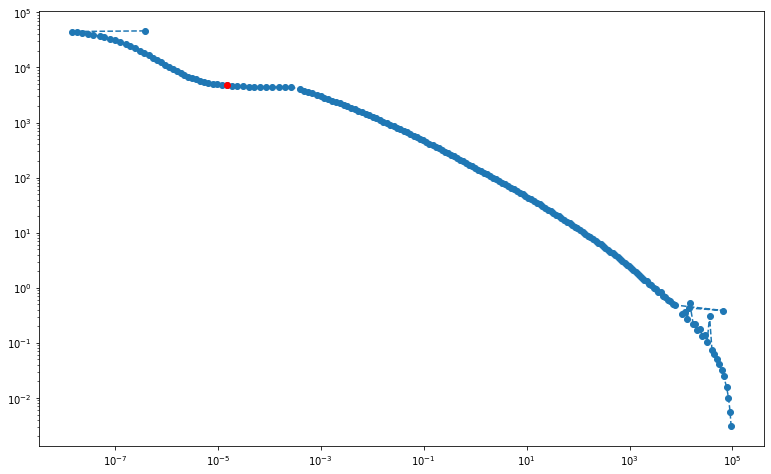

In [19]:
plt.loglog(*fsvals.T, 'o--')
idx=35
print(prange[idx])
plt.loglog(*fsvals[idx], 'ro')

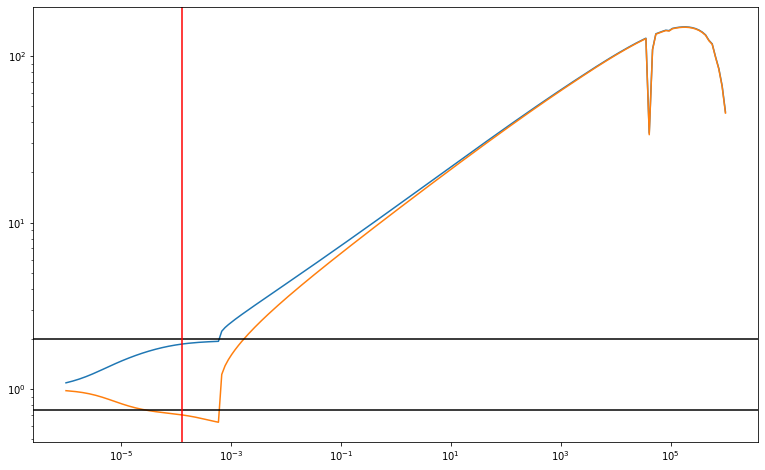

In [20]:
plt.loglog(prange, [float(getp(s['x'])[0]) for s in solutions])
plt.loglog(prange, [float(getp(s['x'])[1]) for s in solutions])
for p in p_true:
    plt.axhline(p, color='k')
idx = 35
plt.axvline(prange[idx], color='r')

[1.8651973946667197, 0.7001125190805477]


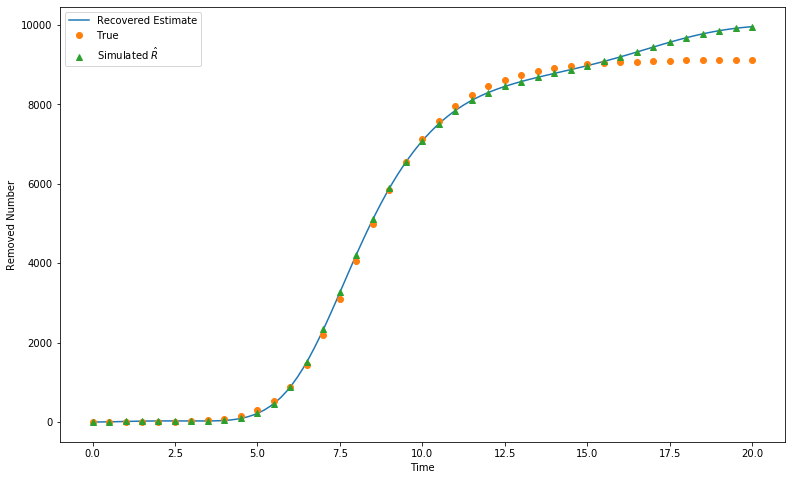

In [50]:
idx = 35
print([float(p) for p in getp(solutions[idx]['x'])])
plt.plot(model.observation_times, getx(solutions[idx]['x'])[-1], label='model')
plt.plot(tofsol, raw_data, 'o', label='data')
plt.plot(tofsol, data.T, '^')
plt.xlabel("Time")
plt.ylabel("Removed Number")
plt.legend([r"Recovered Estimate", "True", r"Simulated $\hat{R}$"])

Text(0, 0.5, 'Number')

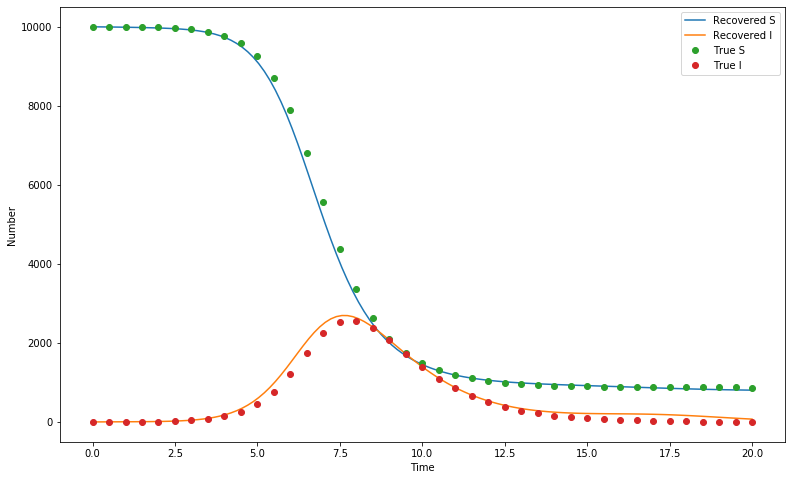

In [52]:
plt.plot(model.observation_times, getx(solutions[idx]['x'])[0], label='model, S')
plt.plot(model.observation_times, getx(solutions[idx]['x'])[1], label='model, I')
plt.plot(tofsol, sol.sol(tofsol)[:2,:].T, 'o', label='data')
plt.legend(["Recovered S", "Recovered I", "True S", "True I"])
plt.xlabel("Time")
plt.ylabel("Number")

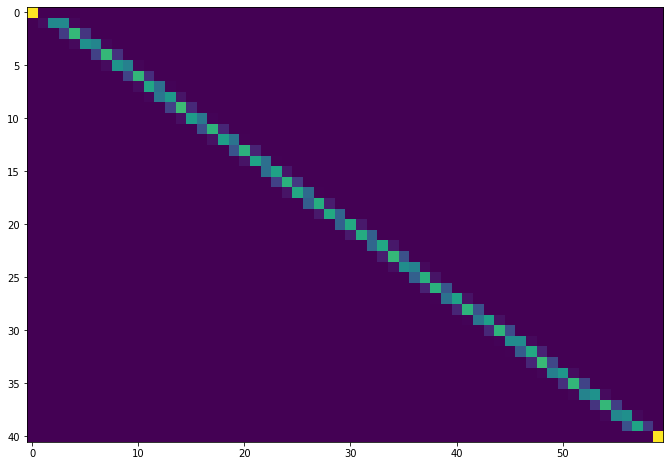

In [23]:
plt.imshow(objective.collocation_matrices[0])

[9987.421165684993, 6.94616149232929, 11.15430323109804]
[1.8651973946667197, 0.7001125190805477]


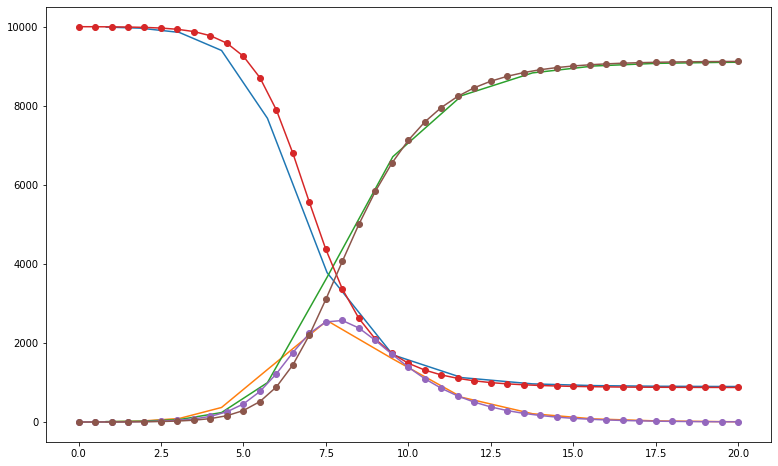

In [24]:
idx = 35
fidx = 5
xs_recovered = getx(solutions[idx]['x'])
print([float(x[fidx]) for x in xs_recovered])
p_recovered = [float(p) for p in getp(solutions[idx]['x'])]
print(p_recovered)
t0t1 = [model.observation_times[fidx], tspan[1]]
sol_recovered = solve_ivp(lambda t, y: system(t, y, p_recovered), t0t1, [x[fidx] for x in getx(solutions[idx]['x'])])
plt.plot(sol_recovered.t, sol_recovered.y.T)
plt.plot(tofsol, sol.sol(tofsol).T, 'o-')

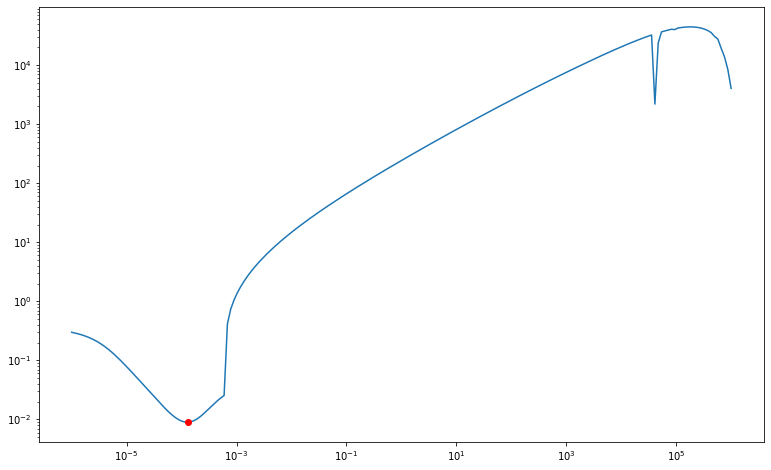

In [25]:
err = lambda i: np.sum([((a-b)/b)**2 for a, b in zip([float(p) for p in getp(solutions[i]['x'])], p_true)])
errs = [err(i) for i in range(200)]
plt.loglog(prange, errs)
idx = 35
plt.loglog(prange[idx], errs[idx], 'ro')

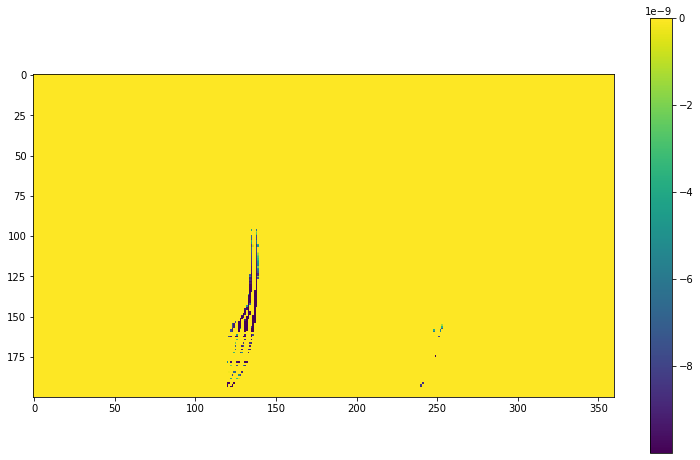

In [26]:
err2 = lambda i: [min(0, xi) for xi in np.concatenate(getx(solutions[i]['x'])).flatten()]
errs2 = np.array([err2(i) for i in range(200)])
plt.imshow(errs2)
plt.colorbar()

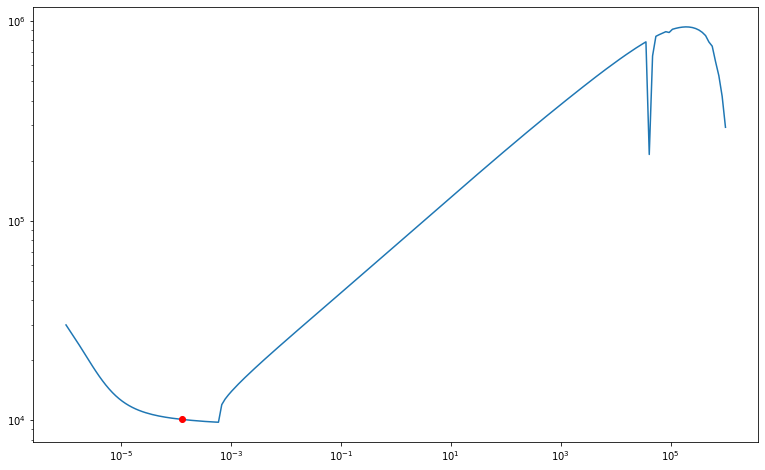

In [27]:
getN = lambda idx: np.mean(np.hstack([np.array(x) for x in getx(solutions[idx]['x'])]).sum(axis=1))
gotNs = [getN(i) for i,_ in enumerate(prange)]
plt.loglog(prange, gotNs)
idx = 35
plt.loglog(prange[idx], gotNs[idx], 'ro')

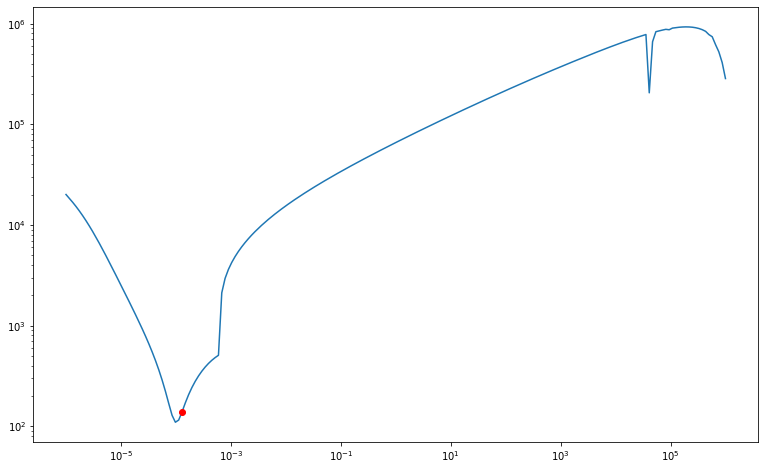

In [28]:
cvfn = lambda idx : np.sqrt(np.sum(((np.array(getx(solutions[idx]['x'])[0]).flatten()) - sol.sol(model.observation_times)[0])**2)/len(model.observation_times))
cerr = [cvfn(i) for i, _ in enumerate(prange)]
plt.loglog(prange, cerr)
idx = 35
plt.loglog(prange[idx], cerr[idx], 'ro')


In [55]:
sol.sol(model.observation_times)[0]

array([9999.        , 9998.62600086, 9998.16454604, 9997.59539931,
       9996.89333883, 9996.02705931, 9994.95817603, 9993.64058799,
       9992.01695166, 9990.01370108, 9987.54095529, 9984.49222877,
       9980.7334291 , 9976.10815557, 9970.4146376 , 9963.39613343,
       9954.74093009, 9944.0823434 , 9930.98405836, 9914.90069302,
       9895.17228682, 9870.96657296, 9841.27607932, 9804.91812847,
       9760.53483761, 9706.6430565 , 9641.32549681, 9562.14426865,
       9466.54442177, 9351.86323507, 9215.33021653, 9054.06710325,
       8865.35987486, 8647.25096967, 8396.62035366, 8111.86495851,
       7793.25855743, 7442.95176519, 7064.97203812, 6665.22367409,
       6251.43316919, 5831.36500039, 5412.49348004, 5001.77446302,
       4605.27068067, 4228.15174083, 3874.69412782, 3548.28120242,
       3251.4032019 , 2985.53451065, 2748.523494  , 2537.3743487 ,
       2349.71237565, 2183.29968472, 2036.03519471, 1905.95463337,
       1791.23053741, 1690.17225246, 1601.21095241, 1522.72700

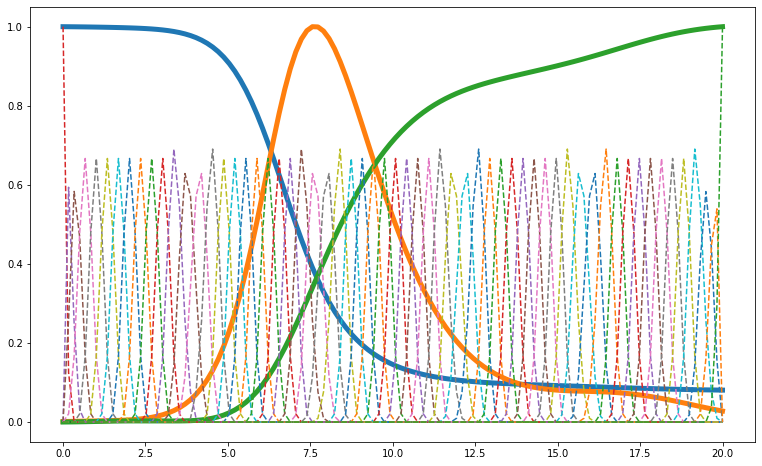

In [29]:
idx = 35
for x in getx(solutions[idx]['x']):
    xx = np.array(x).flatten()
    plt.plot(model.observation_times, xx/np.max(np.abs(xx)), linewidth=5)
plt.plot(model.observation_times, model.phi, '--');


In [30]:
lbx = [-np.inf]*(config['basis_number']*3) + p_true
ubx = [np.inf]*(config['basis_number']*3) + p_true
correct_data = solver(x0=x0, p=[prange[idx], 0], lbx=lbx, lbg=0, ubx=ubx);

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:    21600
Number of nonzeros in Lagrangian Hessian.............:    16290

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

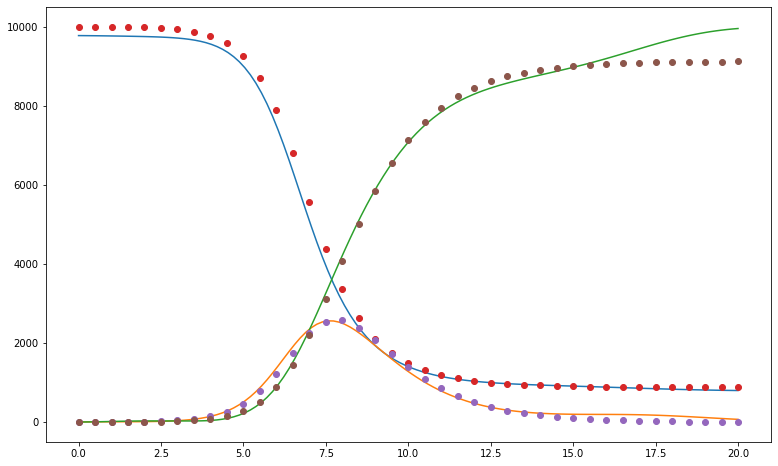

In [31]:
correct_xs = getx(correct_data['x'])
plt.plot(model.observation_times, np.hstack([np.array(c) for c in correct_xs]))
plt.plot(tofsol, sol.sol(tofsol).T, 'o')

In [32]:
pref = getp(solutions[idx]['x'])

In [33]:
conf = stats.chi.ppf(0.95, 1) 

In [34]:
idx = 35
rho = prange[idx]
pvals = np.linspace(-1, 4, 100)
profile = []
profile_r = []
for pval in pvals:
    lbxp = [-np.inf]*(config['basis_number']*3) + [pval, -np.inf]
    ubxp = [np.inf]*(config['basis_number']*3) + [pval, np.inf]
    profile.append(solver(x0=solutions[idx]['x'], p=[rho, 0], lbx=lbxp, ubx=ubxp, lbg=0))
    profile_r.append(solver(x0=solutions[idx]['x'], p=[rho, 0.5], lbx=lbxp, ubx=ubxp, lbg=0))

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:    21600
Number of nonzeros in Lagrangian Hessian.............:    16471

Total number of variables............................:      181
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  81  3.7168964e+01 0.00e+00 3.23e-05  -5.7 5.23e-01    -  1.00e+00 1.00e+00f  1
  82  3.7168937e+01 0.00e+00 2.56e-04  -5.7 5.68e+00    -  1.00e+00 2.50e-01f  3
  83  3.7168901e+01 0.00e+00 6.81e-05  -5.7 7.95e-01    -  1.00e+00 1.00e+00f  1
  84  3.7168876e+01 0.00e+00 2.19e-04  -5.7 2.68e+00    -  1.00e+00 5.00e-01f  2
  85  3.7168844e+01 0.00e+00 6.93e-05  -5.7 8.45e-01    -  1.00e+00 1.00e+00f  1
  86  3.7168822e+01 0.00e+00 1.70e-04  -5.7 2.42e+00    -  1.00e+00 5.00e-01h  2
  87  3.7168794e+01 0.00e+00 8.54e-05  -5.7 9.86e-01    -  1.00e+00 1.00e+00h  1
  88  3.7168776e+01 0.00e+00 2.75e-04  -5.7 1.82e+00    -  1.00e+00 1.00e+00h  1
  89  3.7168742e+01 0.00e+00 2.47e-05  -5.7 5.66e-01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  3.7168724e+01 0.00e+00 1.42e-04  -5.7 5.13e+00    -  1.00e+00 2.50e-01h  3
  91  3.7168701e+01 0.00e+00 6.71e-05  -5.7 9.71e-01    -  1.00e+00 1.00e+00h  1
  92  3.7168687e+01 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180  3.7167595e+01 0.00e+00 5.12e-06  -8.6 3.96e-01    -  1.00e+00 1.00e+00f  1
 181  3.7167594e+01 0.00e+00 4.72e-06  -8.6 5.87e-01  -6.5 1.00e+00 1.00e+00h  1
 182  3.7169525e+01 0.00e+00 4.74e-03  -8.6 1.79e+01    -  1.00e+00 1.00e+00H  1
 183  3.7167584e+01 0.00e+00 2.66e-05  -8.6 8.60e-01    -  1.00e+00 1.00e+00f  1
 184  3.7167583e+01 0.00e+00 4.53e-05  -8.6 1.89e+00  -6.9 1.00e+00 1.00e+00h  1
 185  3.7167582e+01 0.00e+00 7.33e-05  -8.6 2.44e+00    -  1.00e+00 1.00e+00h  1
 186  3.7167581e+01 0.00e+00 2.79e-05  -8.6 1.53e+00    -  1.00e+00 1.00e+00h  1
 187  3.7167582e+01 0.00e+00 1.84e-04  -8.6 3.87e+00    -  1.00e+00 1.00e+00h  1
 188  3.7167579e+01 0.00e+00 3.98e-06  -8.6 6.44e-01    -  1.00e+00 1.00e+00h  1
 189  3.7167579e+01 0.00e+00 8.66e-05  -8.6 2.10e+01    -  1.00e+00 1.25e-01h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190  3.7167578e+01 0.00e+00

   2  3.0132236e+02 0.00e+00 4.91e-01  -1.0 6.01e+02    -  6.82e-01 1.00e+00f  1
   3  2.2137443e+02 0.00e+00 1.39e+00  -1.0 8.67e+02    -  9.01e-01 1.00e+00f  1
   4  1.2264451e+02 0.00e+00 9.70e-02  -1.0 2.37e+03    -  2.28e-01 1.00e+00f  1
   5  1.0138270e+02 0.00e+00 6.85e-01  -1.0 1.64e+03    -  6.79e-01 1.00e+00f  1
   6  8.2964222e+01 0.00e+00 2.76e-01  -1.0 2.79e+03    -  5.94e-01 1.00e+00f  1
   7  6.4419595e+01 0.00e+00 3.67e+00  -1.7 3.93e+03    -  7.11e-01 6.07e-01f  1
   8  5.7458359e+01 0.00e+00 1.55e+00  -1.7 1.57e+03    -  5.28e-01 1.00e+00f  1
   9  5.3782219e+01 0.00e+00 8.85e-01  -1.7 2.06e+03    -  9.19e-01 7.62e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.5284009e+01 0.00e+00 1.51e+00  -1.7 2.10e+05    -  3.67e-02 9.28e-02f  2
  11  5.4189317e+01 0.00e+00 4.03e-01  -1.7 8.27e+04    -  4.88e-01 1.00e+00f  1
  12  5.3915066e+01 0.00e+00 2.35e-02  -1.7 2.65e+04    -  1.00e+00 1.00e+00f  1
  13  5.1375566e+01 0.00e+00

  49  3.7170240e+01 0.00e+00 1.62e-04  -5.7 5.87e-01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  3.7170158e+01 0.00e+00 4.58e-04  -5.7 3.46e+00    -  1.00e+00 2.50e-01f  3
  51  3.7170051e+01 0.00e+00 6.64e-04  -5.7 1.27e+00    -  1.00e+00 1.00e+00f  1
  52  3.7169935e+01 0.00e+00 2.65e-04  -5.7 8.36e-01    -  1.00e+00 1.00e+00f  1
  53  3.7169865e+01 0.00e+00 4.52e-04  -5.7 1.89e+00    -  1.00e+00 5.00e-01f  2
  54  3.7169770e+01 0.00e+00 3.96e-04  -5.7 1.09e+00    -  1.00e+00 1.00e+00f  1
  55  3.7169683e+01 0.00e+00 4.20e-04  -5.7 1.17e+00    -  1.00e+00 1.00e+00f  1
  56  3.7169600e+01 0.00e+00 3.09e-04  -5.7 1.05e+00    -  1.00e+00 1.00e+00f  1
  57  3.7169529e+01 0.00e+00 4.62e-04  -5.7 1.33e+00    -  1.00e+00 1.00e+00f  1
  58  3.7169454e+01 0.00e+00 1.77e-04  -5.7 8.55e-01    -  1.00e+00 1.00e+00f  1
  59  3.7169406e+01 0.00e+00 3.23e-04  -5.7 2.03e+00    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr 

 144  3.7167633e+01 0.00e+00 4.51e-05  -8.6 2.49e+01    -  7.59e-01 6.25e-02h  5
 145  3.7167631e+01 0.00e+00 1.00e-05  -8.6 7.76e-01  -6.5 1.00e+00 1.00e+00h  1
 146  3.7168004e+01 0.00e+00 1.67e-03  -8.6 9.59e+00    -  1.00e+00 1.00e+00H  1
 147  3.7167620e+01 0.00e+00 4.63e-06  -8.6 3.58e-01    -  1.00e+00 1.00e+00f  1
 148  3.7167620e+01 0.00e+00 1.52e-04  -8.6 3.03e+00  -6.9 1.00e+00 1.00e+00H  1
 149  3.7167616e+01 0.00e+00 8.43e-06  -8.6 7.78e-01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150  3.7167616e+01 0.00e+00 1.33e-04  -8.6 1.12e+01    -  1.00e+00 2.50e-01h  3
 151  3.7167613e+01 0.00e+00 1.09e-05  -8.6 8.79e-01    -  1.00e+00 1.00e+00h  1
 152  3.7167813e+01 0.00e+00 1.35e-03  -8.6 9.07e+00    -  1.00e+00 1.00e+00H  1
 153  3.7167605e+01 0.00e+00 2.88e-06  -8.6 3.18e-01    -  1.00e+00 1.00e+00f  1
 154  3.7167606e+01 0.00e+00 1.82e-04  -8.6 6.96e+00  -7.4 1.00e+00 5.00e-01h  2
 155  3.7167602e+01 0.00e+00

  32  4.6951894e+01 0.00e+00 1.32e-01  -8.6 4.58e+03  -9.4 1.00e+00 1.38e-01f  1
  33  4.5723730e+01 0.00e+00 4.29e-02  -8.6 1.42e+03  -9.0 1.00e+00 1.00e+00f  1
  34  4.5243671e+01 0.00e+00 3.60e-02  -8.6 9.04e+02  -8.5 9.81e-01 4.75e-01f  1
  35  4.5092621e+01 0.00e+00 2.68e-02  -8.6 3.71e+02  -8.1 1.00e+00 3.23e-01f  1
  36  4.4968917e+01 0.00e+00 2.61e-02  -8.6 1.88e+03  -8.6 2.39e-01 5.15e-02f  1
  37  4.4859989e+01 0.00e+00 2.28e-02  -8.6 4.98e+02  -8.2 8.59e-01 1.63e-01f  1
  38  4.4661233e+01 0.00e+00 2.38e-02  -8.6 3.39e+03  -8.7 1.00e+00 4.17e-02f  1
  39  4.3361088e+01 0.00e+00 9.35e-02  -8.6 7.15e+02  -8.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  4.2688128e+01 0.00e+00 8.40e-02  -8.6 5.38e+02  -7.8 1.00e+00 5.19e-01f  1
  41  4.2482632e+01 0.00e+00 6.91e-02  -8.6 2.93e+02  -7.4 1.36e-01 2.63e-01f  1
  42  4.2185111e+01 0.00e+00 7.98e-02  -8.6 1.26e+04  -7.9 6.19e-02 8.49e-03f  1
  43  4.1850053e+01 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  4.0242199e+01 0.00e+00 1.47e-02  -8.6 1.87e+02    -  1.60e-01 9.65e-02f  1
 131  4.0241638e+01 0.00e+00 1.46e-02  -8.6 1.69e+02    -  6.86e-03 1.07e-02f  1
 132  4.0241347e+01 0.00e+00 1.45e-02  -8.6 1.67e+02    -  7.82e-02 5.67e-03f  1
 133  4.0240896e+01 0.00e+00 1.43e-02  -8.6 1.55e+02    -  2.65e-03 9.75e-03f  1
 134  4.0240846e+01 0.00e+00 1.43e-02  -8.6 1.55e+02    -  9.05e-02 1.06e-03f  1
 135  4.0236723e+01 0.00e+00 1.30e-02  -8.6 1.52e+02    -  2.47e-02 9.54e-02f  1
 136  4.0236261e+01 0.00e+00 1.28e-02  -8.6 1.39e+02    -  2.51e-03 1.27e-02f  1
 137  4.0236137e+01 0.00e+00 1.28e-02  -8.6 1.42e+02    -  4.73e-03 3.32e-03f  1
 138  4.0236008e+01 0.00e+00 1.28e-02  -8.6 1.40e+02    -  1.18e-02 3.56e-03f  1
 139  4.0232884e+01 0.00e+00 1.16e-02  -8.6 1.34e+02    -  1.09e-02 9.51e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140  4.0232620e+01 0.00e+00

   8  5.4469722e+01 0.00e+00 1.46e+00  -1.7 7.12e+02    -  6.31e-01 1.00e+00f  1
   9  5.0279853e+01 0.00e+00 1.29e+00  -1.7 2.48e+03    -  8.89e-01 5.40e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.1820498e+01 0.00e+00 2.01e+00  -1.7 2.52e+05    -  3.05e-02 7.75e-02f  2
  11  4.9010829e+01 0.00e+00 3.75e-01  -1.7 2.14e+05    -  1.67e-01 1.00e+00f  1
  12  4.7603358e+01 0.00e+00 3.22e-01  -1.7 5.16e+05    -  1.00e+00 2.31e-01f  2
  13  4.6272827e+01 0.00e+00 5.69e-02  -1.7 2.66e+04    -  1.00e+00 1.00e+00f  1
  14  4.3728974e+01 0.00e+00 7.20e-01  -2.5 7.01e+02    -  9.69e-01 7.13e-01f  1
  15  4.1379404e+01 0.00e+00 1.56e-01  -2.5 1.09e+04    -  1.00e+00 1.00e+00f  1
  16  4.1167682e+01 0.00e+00 5.98e-03  -2.5 2.82e+00  -4.0 1.00e+00 1.00e+00f  1
  17  4.0303043e+01 0.00e+00 1.40e-01  -3.8 5.48e+04    -  2.83e-01 7.99e-02f  1
  18  3.9615417e+01 0.00e+00 1.01e-01  -3.8 2.07e+04    -  9.83e-01 9.26e-01f  1
  19  3.9230121e+01 0.00e+00

 107  3.7167628e+01 0.00e+00 2.52e-06  -8.6 2.98e-01    -  1.00e+00 1.00e+00f  1
 108  3.7167627e+01 0.00e+00 4.51e-06  -8.6 5.11e-01  -6.1 1.00e+00 1.00e+00h  1
 109  3.7172024e+01 0.00e+00 6.17e-03  -8.6 1.80e+01    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  3.7167609e+01 0.00e+00 5.23e-05  -8.6 1.08e+00    -  1.00e+00 1.00e+00f  1
 111  3.7167607e+01 0.00e+00 7.33e-05  -8.6 2.15e+00  -6.6 1.00e+00 1.00e+00h  1
 112  3.7167605e+01 0.00e+00 3.74e-05  -8.6 1.58e+00    -  1.00e+00 1.00e+00h  1
 113  3.7167605e+01 0.00e+00 1.39e-04  -8.6 3.01e+00    -  1.00e+00 1.00e+00h  1
 114  3.7167602e+01 0.00e+00 9.94e-06  -8.6 8.62e-01    -  1.00e+00 1.00e+00h  1
 115  3.7167835e+01 0.00e+00 1.58e-03  -8.6 1.01e+01    -  1.00e+00 1.00e+00H  1
 116  3.7167595e+01 0.00e+00 3.51e-06  -8.6 3.42e-01    -  1.00e+00 1.00e+00f  1
 117  3.7167594e+01 0.00e+00 1.03e-04  -8.6 2.68e+00  -7.1 1.00e+00 1.00e+00h  1
 118  3.7167593e+01 0.00e+00

  18  4.3925741e+01 0.00e+00 2.64e-03  -3.8 1.01e+01  -4.5 1.00e+00 1.00e+00f  1
  19  4.3407795e+01 0.00e+00 1.51e-02  -3.8 2.14e+01  -5.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  4.2823437e+01 0.00e+00 5.50e-02  -3.8 3.47e+01  -5.4 1.00e+00 1.00e+00f  1
  21  4.2373713e+01 0.00e+00 8.83e-02  -3.8 4.32e+01  -5.9 1.00e+00 1.00e+00f  1
  22  4.2047114e+01 0.00e+00 8.43e-02  -3.8 5.32e+01  -6.4 1.00e+00 1.00e+00f  1
  23  4.1578079e+01 0.00e+00 8.71e-02  -3.8 1.52e+02  -6.9 1.00e+00 8.26e-01f  1
  24  4.1442957e+01 0.00e+00 8.61e-02  -3.8 2.61e+03    -  3.56e-02 1.83e-02f  1
  25  4.1309402e+01 0.00e+00 8.46e-02  -3.8 2.09e+03    -  1.06e-01 2.46e-02f  1
  26  4.1147151e+01 0.00e+00 8.21e-02  -3.8 1.68e+03    -  4.49e-01 4.07e-02f  1
  27  4.0694234e+01 0.00e+00 7.57e-02  -3.8 1.26e+03    -  2.88e-01 1.83e-01f  1
  28  4.0475048e+01 0.00e+00 6.59e-02  -3.8 8.02e+02    -  1.66e-01 1.82e-01f  1
  29  4.0343809e+01 0.00e+00

  41  3.7275208e+01 0.00e+00 6.26e-03  -5.7 1.86e+03 -12.3 1.00e+00 2.50e-01f  3
  42  3.7250094e+01 0.00e+00 3.36e-03  -5.7 1.28e+04 -12.7 1.00e+00 1.00e+00f  1
  43  3.7242449e+01 0.00e+00 9.00e-03  -5.7 1.21e+03 -11.4 1.00e+00 1.00e+00f  1
  44  3.7167925e+01 0.00e+00 2.38e-03  -5.7 8.63e+03 -11.9 1.00e+00 9.27e-01f  1
  45  3.7169614e+01 0.00e+00 2.40e-03  -5.7 8.52e+04  -9.7 2.15e-07 5.87e-04f  4
  46  3.7168690e+01 0.00e+00 1.84e-03  -5.7 9.44e+01  -9.2 1.00e+00 2.38e-01f  2
  47  3.7168152e+01 0.00e+00 9.81e-04  -5.7 2.68e+01    -  1.00e+00 4.66e-01f  2
  48  3.7168206e+01 0.00e+00 2.91e-07  -5.7 3.62e+00    -  1.00e+00 1.00e+00f  1
  49  3.7168197e+01 0.00e+00 1.23e-03  -8.6 8.86e+01  -8.8 1.00e+00 1.25e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  3.7167661e+01 0.00e+00 7.09e-04  -8.6 3.11e+01    -  1.00e+00 4.27e-01f  1
  51  3.7167604e+01 0.00e+00 3.28e-04  -8.6 4.50e+00    -  1.00e+00 5.37e-01f  1
  52  3.7167573e+01 0.00e+00

   4  1.1818814e+02 0.00e+00 1.18e-01  -1.0 2.25e+03    -  2.81e-01 1.00e+00f  1
   5  9.7357398e+01 0.00e+00 8.56e-01  -1.0 1.66e+03    -  6.34e-01 1.00e+00f  1
   6  8.2880389e+01 0.00e+00 2.82e-01  -1.0 2.30e+03    -  6.36e-01 1.00e+00f  1
   7  6.1871797e+01 0.00e+00 4.62e+00  -1.7 4.71e+03    -  6.32e-01 6.92e-01f  1
   8  5.5666816e+01 0.00e+00 1.49e+00  -1.7 8.15e+02    -  6.25e-01 1.00e+00f  1
   9  5.1944087e+01 0.00e+00 1.08e+00  -1.7 2.22e+03    -  9.03e-01 6.70e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.3850388e+01 0.00e+00 1.76e+00  -1.7 1.28e+05    -  6.25e-02 1.61e-01f  2
  11  5.2546777e+01 0.00e+00 1.75e-01  -1.7 1.96e+05    -  2.09e-01 1.00e+00f  1
  12  5.0150550e+01 0.00e+00 4.66e-02  -2.5 7.32e+04    -  1.00e+00 8.61e-01f  1
  13  4.9808247e+01 0.00e+00 6.18e-03  -2.5 9.03e+04    -  1.00e+00 1.00e+00f  1
  14  4.4304407e+01 0.00e+00 5.16e-01  -3.8 1.53e+05    -  1.00e+00 4.65e-01f  1
  15  4.3953590e+01 0.00e+00

  31  3.7476943e+01 0.00e+00 3.67e-03  -5.7 1.01e+01  -9.7 1.00e+00 1.00e+00f  1
  32  3.7449928e+01 0.00e+00 7.15e-03  -5.7 2.20e+01 -10.2 1.00e+00 1.00e+00f  1
  33  3.7411248e+01 0.00e+00 1.28e-03  -5.7 5.53e+01 -10.7 1.00e+00 1.00e+00f  1
  34  3.7397137e+01 0.00e+00 8.30e-03  -5.7 1.21e+02 -11.2 1.00e+00 5.00e-01f  2
  35  3.7365978e+01 0.00e+00 8.08e-04  -5.7 4.08e+02 -11.6 1.00e+00 1.00e+00f  1
  36  3.7359677e+01 0.00e+00 1.12e-02  -5.7 9.01e+02 -12.1 1.00e+00 5.00e-01f  2
  37  3.7328427e+01 0.00e+00 3.94e-04  -5.7 3.61e+03 -12.6 1.00e+00 1.00e+00f  1
  38  3.7315498e+01 0.00e+00 5.49e-03  -5.7 1.60e+04 -13.1 1.00e+00 2.50e-01f  3
  39  3.7297650e+01 0.00e+00 3.28e-03  -5.7 5.93e+03 -12.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  3.7287051e+01 0.00e+00 8.98e-03  -5.7 2.54e+03 -12.2 1.00e+00 1.00e+00f  1
  41  3.7208145e+01 0.00e+00 1.88e-03  -5.7 1.88e+04 -12.7 1.00e+00 1.00e+00f  1
  42  3.7172839e+01 0.00e+00

  14  4.3930169e+01 0.00e+00 5.16e-01  -3.8 1.24e+05    -  1.00e+00 5.89e-01f  1
  15  4.3607304e+01 0.00e+00 1.24e-02  -3.8 3.92e+00  -4.0 1.00e+00 1.00e+00f  1
  16  4.3337522e+01 0.00e+00 3.49e-03  -3.8 9.70e+00  -4.5 1.00e+00 1.00e+00f  1
  17  4.2862194e+01 0.00e+00 1.75e-02  -3.8 2.09e+01  -5.0 1.00e+00 1.00e+00f  1
  18  4.2303676e+01 0.00e+00 5.95e-02  -3.8 3.48e+01  -5.4 1.00e+00 1.00e+00f  1
  19  4.1863473e+01 0.00e+00 9.63e-02  -3.8 4.39e+01  -5.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  4.1546379e+01 0.00e+00 9.32e-02  -3.8 5.10e+01  -6.4 1.00e+00 1.00e+00f  1
  21  4.1184434e+01 0.00e+00 8.10e-02  -3.8 1.44e+02  -6.9 1.00e+00 6.99e-01f  1
  22  4.1098027e+01 0.00e+00 8.01e-02  -3.8 2.22e+03    -  1.88e-01 1.49e-02f  1
  23  4.0799022e+01 0.00e+00 7.73e-02  -3.8 1.63e+03    -  5.72e-01 8.01e-02f  1
  24  4.0451150e+01 0.00e+00 7.02e-02  -3.8 1.06e+03    -  1.36e-01 1.80e-01f  1
  25  4.0243664e+01 0.00e+00

  43  3.7168429e+01 0.00e+00 2.55e-04  -8.6 6.99e+00    -  8.70e-01 1.06e-01f  1
  44  3.7168402e+01 0.00e+00 2.28e-04  -8.6 6.87e+00    -  1.05e-01 1.08e-01f  1
  45  3.7168301e+01 0.00e+00 1.40e-04  -8.6 6.22e+00    -  1.00e+00 5.08e-01f  1
  46  3.7168225e+01 0.00e+00 1.89e-04  -8.6 3.65e+00    -  1.00e+00 7.89e-01f  1
  47  3.7168188e+01 0.00e+00 1.19e-04  -8.6 1.29e+00    -  1.00e+00 8.26e-01f  1
  48  3.7168167e+01 0.00e+00 2.74e-04  -8.6 1.84e+00    -  1.00e+00 1.00e+00f  1
  49  3.7168166e+01 0.00e+00 2.67e-04  -8.6 2.70e+00    -  1.00e+00 2.33e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  3.7168133e+01 0.00e+00 4.92e-05  -8.6 8.07e-01    -  1.00e+00 1.00e+00f  1
  51  3.7168127e+01 0.00e+00 3.08e-04  -8.6 3.97e+00    -  1.00e+00 5.00e-01f  2
  52  3.7168090e+01 0.00e+00 2.91e-05  -8.6 6.60e-01    -  1.00e+00 1.00e+00f  1
  53  3.7168075e+01 0.00e+00 1.71e-04  -8.6 6.06e+00    -  1.00e+00 2.50e-01f  3
  54  3.7168053e+01 0.00e+00

 136  3.7167562e+01 0.00e+00 2.81e-05  -8.6 8.32e-01  -5.4 1.00e+00 1.00e+00f  1
 137  3.7167562e+01 0.00e+00 1.94e-04  -8.6 4.26e+00    -  1.00e+00 1.00e+00h  1
 138  3.7167560e+01 0.00e+00 3.79e-06  -8.6 6.66e-01    -  1.00e+00 1.00e+00h  1
 139  3.7169229e+01 0.00e+00 6.86e-03  -8.6 2.47e+01    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140  3.7167556e+01 0.00e+00 3.54e-05  -8.6 1.12e+00    -  1.00e+00 1.00e+00f  1
 141  3.7167556e+01 0.00e+00 5.92e-08  -8.6 4.35e-02  -5.9 1.00e+00 1.00e+00h  1
 142  3.7576770e+01 0.00e+00 1.43e-01  -8.6 1.06e+02    -  1.00e+00 1.00e+00H  1
 143  3.7171262e+01 0.00e+00 1.44e-02  -8.6 2.70e+01    -  1.00e+00 1.00e+00F  1
 144  3.7167546e+01 0.00e+00 4.86e-04  -8.6 4.95e+00  -5.4 1.00e+00 1.00e+00f  1
 145  3.7167542e+01 0.00e+00 4.24e-08  -8.6 3.29e-01    -  1.00e+00 1.00e+00h  1
 146  3.7520722e+01 0.00e+00 1.87e-01  -8.6 1.45e+02    -  1.00e+00 1.00e+00H  1
 147  3.7170225e+01 0.00e+00

   5  9.1426922e+01 0.00e+00 1.10e+00  -1.0 1.69e+03    -  5.90e-01 1.00e+00f  1
   6  7.9686039e+01 0.00e+00 6.21e-01  -1.0 2.05e+03    -  6.55e-01 1.00e+00f  1
   7  5.8927670e+01 0.00e+00 5.54e+00  -1.7 4.76e+03    -  6.26e-01 7.40e-01f  1
   8  5.3571498e+01 0.00e+00 1.98e+00  -1.7 6.38e+02    -  6.30e-01 1.00e+00f  1
   9  4.9237911e+01 0.00e+00 1.71e+00  -1.7 2.07e+03    -  9.05e-01 7.99e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.0393964e+01 0.00e+00 2.38e+00  -1.7 5.87e+04    -  1.39e-01 3.42e-01f  2
  11  4.7500748e+01 0.00e+00 1.81e-01  -1.7 1.22e+05    -  3.01e-01 1.00e+00f  1
  12  4.3958352e+01 0.00e+00 8.34e-01  -2.5 3.77e+03    -  7.68e-01 1.43e-01f  1
  13  4.2080049e+01 0.00e+00 1.01e-01  -2.5 5.28e+04    -  7.68e-01 1.00e+00f  1
  14  4.1055583e+01 0.00e+00 2.97e-01  -2.5 7.16e+03    -  1.00e+00 4.63e-01f  2
  15  4.0229853e+01 0.00e+00 1.15e-01  -2.5 8.60e+03    -  1.00e+00 1.00e+00f  1
  16  3.9688009e+01 0.00e+00

  99  3.7167705e+01 0.00e+00 3.72e-05  -8.6 1.22e+00  -6.2 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.7167710e+01 0.00e+00 2.57e-04  -8.6 3.19e+00    -  1.00e+00 1.00e+00H  1
 101  3.7167695e+01 0.00e+00 4.77e-06  -8.6 5.31e-01    -  1.00e+00 1.00e+00f  1
 102  3.7167722e+01 0.00e+00 4.35e-04  -8.6 1.67e+01    -  1.00e+00 2.50e-01h  3
 103  3.7167684e+01 0.00e+00 1.11e-06  -8.6 3.59e-01    -  1.00e+00 1.00e+00f  1
 104  3.7167682e+01 0.00e+00 1.22e-04  -8.6 3.62e+01    -  1.00e+00 6.25e-02h  5
 105  3.7167677e+01 0.00e+00 2.32e-05  -8.6 1.04e+00    -  1.00e+00 1.00e+00h  1
 106  3.7167676e+01 0.00e+00 1.52e-04  -8.6 4.93e+00    -  1.00e+00 5.00e-01h  2
 107  3.7167670e+01 0.00e+00 1.44e-05  -8.6 8.50e-01    -  1.00e+00 1.00e+00h  1
 108  3.7167681e+01 0.00e+00 3.24e-04  -8.6 7.47e+00    -  1.00e+00 5.00e-01h  2
 109  3.7167662e+01 0.00e+00 2.27e-06  -8.6 4.40e-01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.5655201e+02 0.00e+00 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  2.8759893e+02 0.00e+00 5.37e-02  -1.0 1.05e+01    -  9.89e-01 1.00e+00f  1
   2  2.4772715e+02 0.00e+00 3.11e-01  -1.0 5.88e+02    -  6.86e-01 1.00e+00f  1
   3  1.9008352e+02 0.00e+00 1.03e+00  -1.0 8.67e+02    -  8.84e-01 1.00e+00f  1
   4  1.1298126e+02 0.00e+00 1.30e-02  -1.0 2.14e+03    -  3.43e-01 1.00e+00f  1
   5  9.2825077e+01 0.00e+00 1.08e+00  -1.0 1.68e+03    -  5.92e-01 1.00e+00f  1
   6  8.0921766e+01 0.00e+00 5.38e-01  -1.0 2.06e+03    -  6.53e-01 1.00e+00f  1
   7  6.0020246e+01 0.00e+00 5.48e+00  -1.7 4.70e+03    -  6.31e-01 7.33e-01f  1
   8  5.468499

  22  3.8342548e+01 0.00e+00 3.69e-02  -3.8 8.33e+01  -7.8 1.00e+00 7.47e-01f  1
  23  3.8192066e+01 0.00e+00 6.47e-02  -3.8 9.78e+01  -8.3 1.00e+00 1.00e+00f  1
  24  3.7979656e+01 0.00e+00 8.50e-03  -3.8 3.78e+01  -8.8 1.00e+00 1.00e+00f  1
  25  3.7893801e+01 0.00e+00 2.02e-02  -3.8 3.33e+01  -9.2 1.00e+00 2.50e-01f  3
  26  3.7231729e+01 0.00e+00 2.57e-02  -3.8 1.42e+06    -  1.00e+00 7.33e-02f  1
  27  3.7314563e+01 0.00e+00 2.46e-02  -3.8 6.37e+03  -8.8 1.00e+00 7.48e-02f  4
  28  3.7236160e+01 0.00e+00 4.68e-04  -3.8 2.44e+02    -  1.00e+00 1.00e+00f  1
  29  3.7234029e+01 0.00e+00 9.00e-03  -5.7 2.23e+01  -5.7 1.00e+00 1.78e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  3.7223896e+01 0.00e+00 6.96e-04  -5.7 1.34e+00  -6.2 1.00e+00 1.00e+00f  1
  31  3.7221160e+01 0.00e+00 4.54e-03  -5.7 1.27e+01  -6.6 1.00e+00 2.50e-01f  3
  32  3.7216251e+01 0.00e+00 1.43e-03  -5.7 5.20e+00  -7.1 1.00e+00 1.00e+00f  1
  33  3.7213317e+01 0.00e+00

 125  3.7167608e+01 0.00e+00 1.49e-06  -8.6 4.22e-01    -  1.00e+00 1.00e+00f  1
 126  3.7218037e+01 0.00e+00 2.75e-02  -8.6 3.68e+01    -  1.00e+00 1.00e+00H  1
 127  3.7167626e+01 0.00e+00 8.26e-04  -8.6 4.46e+00    -  1.00e+00 1.00e+00F  1
 128  3.7167582e+01 0.00e+00 4.54e-07  -8.6 6.11e-02  -5.2 1.00e+00 1.00e+00f  1
 129  3.7167582e+01 0.00e+00 1.09e-04  -8.6 6.30e+01    -  1.00e+00 3.12e-02h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  3.7167581e+01 0.00e+00 7.23e-05  -8.6 2.29e+00    -  1.00e+00 1.00e+00h  1
 131  3.7167580e+01 0.00e+00 4.20e-05  -8.6 1.76e+00    -  1.00e+00 1.00e+00h  1
 132  3.7167579e+01 0.00e+00 1.21e-04  -8.6 2.98e+00    -  1.00e+00 1.00e+00h  1
 133  3.7167578e+01 0.00e+00 1.45e-05  -8.6 1.07e+00    -  1.00e+00 1.00e+00h  1
 134  3.7167579e+01 0.00e+00 2.28e-04  -8.6 8.05e+00    -  1.00e+00 5.00e-01h  2
 135  3.7167576e+01 0.00e+00 3.62e-06  -8.6 5.98e-01    -  1.00e+00 1.00e+00h  1
 136  3.7167809e+01 0.00e+00

  13  4.7878504e+01 0.00e+00 4.84e-01  -2.5 1.58e+03    -  1.00e+00 1.00e+00f  1
  14  4.7636508e+01 0.00e+00 4.56e-02  -2.5 1.49e+04    -  1.00e+00 1.00e+00f  1
  15  4.7612583e+01 0.00e+00 2.48e-03  -2.5 7.64e+03    -  1.00e+00 1.00e+00f  1
  16  4.2675741e+01 0.00e+00 5.31e-01  -3.8 1.33e+05    -  1.00e+00 4.18e-01f  1
  17  4.2435670e+01 0.00e+00 9.42e-03  -3.8 3.24e+00  -4.0 1.00e+00 1.00e+00f  1
  18  4.2208564e+01 0.00e+00 8.12e-03  -3.8 1.96e+04    -  1.01e-01 4.56e-03f  1
  19  4.1248204e+01 0.00e+00 3.38e-02  -3.8 9.61e+02    -  5.34e-01 2.91e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  4.0704660e+01 0.00e+00 5.81e-02  -3.8 5.01e+02    -  3.77e-01 2.87e-01f  1
  21  4.0300083e+01 0.00e+00 8.50e-02  -3.8 2.69e+02    -  4.92e-01 3.55e-01f  1
  22  3.9937125e+01 0.00e+00 1.61e-01  -3.8 1.23e+02    -  8.77e-01 6.22e-01f  1
  23  3.9757125e+01 0.00e+00 1.76e-01  -3.8 6.06e+01    -  5.66e-01 1.00e+00f  1
  24  3.9720903e+01 0.00e+00

  49  3.7176527e+01 0.00e+00 5.11e-03  -5.7 5.95e+00    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  3.7175644e+01 0.00e+00 1.21e-03  -5.7 1.33e+00    -  1.00e+00 1.00e+00f  1
  51  3.7175212e+01 0.00e+00 3.94e-03  -5.7 4.94e+00    -  1.00e+00 5.00e-01f  2
  52  3.7174530e+01 0.00e+00 1.15e-03  -5.7 1.27e+00    -  1.00e+00 1.00e+00f  1
  53  3.7174159e+01 0.00e+00 2.79e-03  -5.7 3.84e+00    -  1.00e+00 5.00e-01f  2
  54  3.7173640e+01 0.00e+00 1.33e-03  -5.7 1.37e+00    -  1.00e+00 1.00e+00f  1
  55  3.7173450e+01 0.00e+00 4.05e-03  -5.7 2.51e+00    -  1.00e+00 1.00e+00f  1
  56  3.7172799e+01 0.00e+00 3.76e-04  -5.7 6.07e-01    -  1.00e+00 1.00e+00f  1
  57  3.7172547e+01 0.00e+00 1.75e-03  -5.7 5.84e+00    -  1.00e+00 2.50e-01f  3
  58  3.7172210e+01 0.00e+00 1.15e-03  -5.7 1.20e+00    -  1.00e+00 1.00e+00f  1
  59  3.7171958e+01 0.00e+00 1.99e-03  -5.7 1.61e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

 144  3.7167710e+01 0.00e+00 2.87e-04  -8.6 6.52e+00    -  1.00e+00 5.00e-01h  2
 145  3.7167693e+01 0.00e+00 4.11e-06  -8.6 5.00e-01    -  1.00e+00 1.00e+00f  1
 146  3.7167691e+01 0.00e+00 1.42e-04  -8.6 1.87e+01    -  1.00e+00 1.25e-01h  4
 147  3.7167686e+01 0.00e+00 1.96e-05  -8.6 9.36e-01    -  1.00e+00 1.00e+00h  1
 148  3.7167688e+01 0.00e+00 2.25e-04  -8.6 5.89e+00    -  1.00e+00 5.00e-01h  2
 149  3.7167678e+01 0.00e+00 7.10e-06  -8.6 6.17e-01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150  3.7167675e+01 0.00e+00 7.31e-05  -8.6 1.34e+01    -  1.00e+00 1.25e-01h  4
 151  3.7167671e+01 0.00e+00 7.16e-05  -8.6 1.76e+00    -  1.00e+00 1.00e+00h  1
 152  3.7167668e+01 0.00e+00 7.37e-05  -8.6 1.80e+00    -  1.00e+00 1.00e+00h  1
 153  3.7167665e+01 0.00e+00 6.88e-05  -8.6 1.75e+00    -  1.00e+00 1.00e+00h  1
 154  3.7167661e+01 0.00e+00 7.79e-05  -8.6 1.87e+00    -  1.00e+00 1.00e+00h  1
 155  3.7167658e+01 0.00e+00

 245  3.7167538e+01 0.00e+00 1.52e-06  -8.6 4.97e-01  -7.6 1.00e+00 1.00e+00h  1
 246  3.7172234e+01 0.00e+00 2.25e-02  -8.6 5.76e+01    -  1.00e+00 1.00e+00H  1
 247  3.7167536e+01 0.00e+00 1.95e-04  -8.6 3.44e+00    -  1.00e+00 1.00e+00f  1
 248  3.7167536e+01 0.00e+00 2.82e-07  -8.6 1.75e-01  -7.2 1.00e+00 1.00e+00h  1
 249  3.7267656e+01 0.00e+00 1.28e-01  -8.6 1.38e+02    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250  3.7167715e+01 0.00e+00 5.63e-03  -8.6 2.09e+01    -  1.00e+00 1.00e+00F  1
 251  3.7167533e+01 0.00e+00 2.09e-06  -8.6 1.37e-01  -5.8 1.00e+00 1.00e+00f  1
 252  3.7168140e+01 0.00e+00 1.09e-02  -8.6 4.86e+01    -  1.00e+00 1.00e+00H  1
 253  3.7167532e+01 0.00e+00 3.36e-05  -8.6 1.66e+00    -  1.00e+00 1.00e+00f  1
 254  3.7167532e+01 0.00e+00 3.77e-09  -8.6 7.54e-03  -6.3 1.00e+00 1.00e+00h  1

Number of Iterations....: 254

                                   (scaled)                 (unscaled)
Object

   4  1.0571536e+02 0.00e+00 4.06e-01  -1.0 2.03e+03    -  4.17e-01 1.00e+00f  1
   5  8.6514040e+01 0.00e+00 1.38e+00  -1.0 1.72e+03    -  5.43e-01 1.00e+00f  1
   6  7.6896212e+01 0.00e+00 1.31e+00  -1.0 1.97e+03    -  6.57e-01 1.00e+00f  1
   7  7.7470634e+01 0.00e+00 3.77e+00  -1.0 9.66e+03    -  7.20e-01 1.00e+00f  1
   8  9.5467862e+01 0.00e+00 5.94e+01  -1.0 6.95e+03    -  6.62e-01 1.00e+00f  1
   9  8.5873971e+01 0.00e+00 2.27e-02  -1.0 2.68e+00  -4.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  7.3851458e+01 0.00e+00 4.32e+00  -2.5 3.30e+03    -  9.23e-01 1.00e+00f  1
  11  7.3697996e+01 0.00e+00 2.52e-03  -2.5 4.06e+00  -4.5 1.00e+00 1.00e+00f  1
  12  7.3650468e+01 0.00e+00 4.39e-04  -3.8 5.32e+00  -5.0 1.00e+00 1.00e+00f  1
  13  7.3557978e+01 0.00e+00 2.70e-03  -3.8 1.23e+01  -5.4 1.00e+00 1.00e+00f  1
  14  7.3358057e+01 0.00e+00 1.34e-02  -3.8 2.89e+01  -5.9 1.00e+00 1.00e+00f  1
  15  7.3026235e+01 0.00e+00

 103  3.7168569e+01 0.00e+00 2.55e-05  -5.7 5.91e-01    -  1.00e+00 1.00e+00f  1
 104  3.7168554e+01 0.00e+00 1.46e-04  -5.7 5.33e+00    -  1.00e+00 2.50e-01h  3
 105  3.7168537e+01 0.00e+00 6.79e-05  -5.7 1.00e+00    -  1.00e+00 1.00e+00h  1
 106  3.7168527e+01 0.00e+00 2.58e-04  -5.7 2.01e+00    -  1.00e+00 1.00e+00h  1
 107  3.7168503e+01 0.00e+00 1.71e-05  -5.7 5.35e-01    -  1.00e+00 1.00e+00f  1
 108  3.7168405e+01 0.00e+00 6.18e-04  -8.6 8.72e+00    -  1.00e+00 3.74e-01f  2
 109  3.7168077e+01 0.00e+00 1.90e-04  -8.6 7.86e+00    -  1.00e+00 6.96e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  3.7167995e+01 0.00e+00 6.10e-05  -8.6 3.95e+00    -  1.00e+00 8.33e-01f  1
 111  3.7167977e+01 0.00e+00 2.54e-04  -8.6 2.63e+00    -  1.00e+00 8.45e-01f  1
 112  3.7167945e+01 0.00e+00 3.24e-05  -8.6 8.43e-01    -  1.00e+00 9.38e-01f  1
 113  3.7167944e+01 0.00e+00 2.43e-04  -8.6 4.51e+00    -  1.00e+00 5.00e-01f  2
 114  3.7167917e+01 0.00e+00

 196  3.7167531e+01 0.00e+00 1.83e-09  -8.6 2.04e-03  -6.0 1.00e+00 1.00e+00h  1

Number of Iterations....: 196

                                   (scaled)                 (unscaled)
Objective...............:   1.3766891447642791e+01    3.7167530657665871e+01
Dual infeasibility......:   1.8344223974429973e-09    4.9525305662045938e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059044971495852e-09    6.7653821908312794e-09
Overall NLP error.......:   2.5059044971495852e-09    6.7653821908312794e-09


Number of objective function evaluations             = 326
Number of objective gradient evaluations             = 197
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 326
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 197
Number of Lagrangian Hessian evaluations             = 196
Total CPU secs in IP

   2  2.1198873e+02 0.00e+00 1.97e-01  -1.0 5.74e+02    -  6.90e-01 1.00e+00f  1
   3  1.6667378e+02 0.00e+00 7.22e-01  -1.0 8.58e+02    -  8.72e-01 1.00e+00f  1
   4  1.0355545e+02 0.00e+00 5.74e-01  -1.0 1.99e+03    -  4.44e-01 1.00e+00f  1
   5  8.4714727e+01 0.00e+00 1.48e+00  -1.0 1.73e+03    -  5.26e-01 1.00e+00f  1
   6  7.5791163e+01 0.00e+00 1.72e+00  -1.0 1.97e+03    -  6.55e-01 1.00e+00f  1
   7  7.6534521e+01 0.00e+00 4.43e+00  -1.0 9.30e+03    -  7.47e-01 1.00e+00f  1
   8  9.6361110e+01 0.00e+00 7.25e+01  -1.0 7.61e+03    -  6.50e-01 1.00e+00f  1
   9  8.5104011e+01 0.00e+00 2.71e-02  -1.0 2.99e+00  -4.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  7.4021252e+01 0.00e+00 1.24e+00  -2.5 3.01e+03    -  9.45e-01 1.00e+00f  1
  11  7.3966236e+01 0.00e+00 5.52e-04  -2.5 6.10e+00  -4.5 1.00e+00 1.00e+00f  1
  12  7.3924109e+01 0.00e+00 3.17e-04  -3.8 5.87e+00  -5.0 1.00e+00 1.00e+00f  1
  13  7.3848919e+01 0.00e+00

  98  3.7168597e+01 0.00e+00 7.24e-05  -5.7 9.34e-01    -  1.00e+00 1.00e+00h  1
  99  3.7168600e+01 0.00e+00 4.06e-04  -5.7 2.28e+00    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.7168554e+01 0.00e+00 1.29e-05  -5.7 4.27e-01    -  1.00e+00 1.00e+00f  1
 101  3.7168474e+01 0.00e+00 4.55e-04  -8.6 1.23e+01    -  1.00e+00 2.05e-01f  3
 102  3.7168153e+01 0.00e+00 1.67e-04  -8.6 9.35e+00    -  1.00e+00 6.44e-01f  1
 103  3.7168056e+01 0.00e+00 8.85e-05  -8.6 4.55e+00    -  1.00e+00 8.44e-01f  1
 104  3.7168025e+01 0.00e+00 2.03e-04  -8.6 2.10e+00    -  1.00e+00 8.38e-01f  1
 105  3.7168000e+01 0.00e+00 5.88e-05  -8.6 9.33e-01    -  1.00e+00 8.97e-01f  1
 106  3.7167988e+01 0.00e+00 1.47e-04  -8.6 2.92e+00    -  1.00e+00 5.00e-01f  2
 107  3.7167969e+01 0.00e+00 7.14e-05  -8.6 1.17e+00    -  1.00e+00 1.00e+00h  1
 108  3.7167966e+01 0.00e+00 2.57e-04  -8.6 2.28e+00    -  1.00e+00 1.00e+00h  1
 109  3.7167942e+01 0.00e+00

 196  3.7167538e+01 0.00e+00 1.26e-05  -8.6 3.49e-01  -5.3 1.00e+00 1.00e+00f  1
 197  3.7167542e+01 0.00e+00 6.74e-04  -8.6 1.02e+01    -  1.00e+00 1.00e+00h  1
 198  3.7167537e+01 0.00e+00 1.70e-07  -8.6 2.97e-01    -  1.00e+00 1.00e+00h  1
 199  3.8380896e+01 0.00e+00 4.96e-01  -8.6 2.35e+02    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  3.7212998e+01 0.00e+00 1.08e-01  -8.6 9.78e+01    -  1.00e+00 1.00e+00F  1
 201  3.7167536e+01 0.00e+00 1.08e-03  -8.6 4.14e+00  -4.9 1.00e+00 1.00e+00f  1
 202  3.7167532e+01 0.00e+00 3.80e-07  -8.6 2.75e-01    -  1.00e+00 1.00e+00h  1
 203  7.3888733e+01 0.00e+00 6.15e+00  -8.6 1.57e+03    -  3.93e-01 5.67e-01H  1
 204  6.6299189e+01 0.00e+00 7.53e+00  -8.6 6.68e+02  -4.5 1.80e-03 1.00e+00F  1
 205  3.7594204e+01 0.00e+00 9.63e-01  -8.6 1.36e+02  -4.1 1.00e+00 1.00e+00F  1
 206  3.7171608e+01 0.00e+00 1.00e-01  -8.6 1.65e+02    -  1.00e+00 1.00e+00F  1
 207  3.7167528e+01 0.00e+00

  46  3.9439390e+01 0.00e+00 6.05e-08  -8.6 1.70e-01    -  1.00e+00 9.94e-01f  1
  47  3.9439390e+01 0.00e+00 1.20e-11  -8.6 4.20e-02    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 47

                                   (scaled)                 (unscaled)
Objective...............:   1.4937589406728129e+01    3.9439389626917844e+01
Dual infeasibility......:   1.1967616555341250e-11    3.1597835459251655e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.4313886464003313e-09    9.0598201692308701e-09
Overall NLP error.......:   3.4313886464003313e-09    9.0598201692308701e-09


Number of objective function evaluations             = 49
Number of objective gradient evaluations             = 48
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 49
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 48
Num

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  3.7171414e+01 0.00e+00 2.23e-04  -5.7 4.48e-01    -  1.00e+00 1.00e+00f  1
  71  3.7171260e+01 0.00e+00 1.67e-03  -5.7 5.27e+00    -  1.00e+00 2.50e-01f  3
  72  3.7171020e+01 0.00e+00 4.92e-04  -5.7 7.10e-01    -  1.00e+00 1.00e+00f  1
  73  3.7170883e+01 0.00e+00 1.25e-03  -5.7 2.10e+00    -  1.00e+00 5.00e-01f  2
  74  3.7170689e+01 0.00e+00 5.69e-04  -5.7 8.30e-01    -  1.00e+00 1.00e+00f  1
  75  3.7170639e+01 0.00e+00 2.03e-03  -5.7 1.65e+00    -  1.00e+00 1.00e+00f  1
  76  3.7170361e+01 0.00e+00 1.45e-04  -5.7 4.73e-01    -  1.00e+00 1.00e+00f  1
  77  3.7170265e+01 0.00e+00 1.09e-03  -5.7 4.99e+00    -  1.00e+00 2.50e-01f  3
  78  3.7170118e+01 0.00e+00 3.16e-04  -5.7 7.42e-01    -  1.00e+00 1.00e+00f  1
  79  3.7170031e+01 0.00e+00 8.48e-04  -5.7 2.27e+00    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  3.7169909e+01 0.00e+00

 168  3.7167712e+01 0.00e+00 9.81e-04  -8.6 6.74e+00    -  1.00e+00 1.00e+00H  1
 169  3.7167621e+01 0.00e+00 1.53e-06  -8.6 2.82e-01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170  3.7167620e+01 0.00e+00 2.44e-04  -8.6 1.65e+02    -  7.76e-01 1.56e-02h  7
 171  3.7167618e+01 0.00e+00 2.06e-05  -8.6 1.06e+00    -  1.00e+00 1.00e+00h  1
 172  3.7167618e+01 0.00e+00 1.99e-04  -8.6 6.16e+00    -  1.00e+00 5.00e-01h  2
 173  3.7167614e+01 0.00e+00 8.70e-06  -8.6 7.29e-01    -  1.00e+00 1.00e+00h  1
 174  3.7167615e+01 0.00e+00 2.07e-04  -8.6 1.28e+01    -  1.00e+00 2.50e-01h  3
 175  3.7167610e+01 0.00e+00 7.77e-06  -8.6 7.02e-01    -  1.00e+00 1.00e+00h  1
 176  3.7167612e+01 0.00e+00 2.43e-04  -8.6 1.41e+01    -  1.00e+00 2.50e-01h  3
 177  3.7167607e+01 0.00e+00 5.31e-06  -8.6 6.09e-01    -  1.00e+00 1.00e+00h  1
 178  3.7170915e+01 0.00e+00 7.11e-03  -8.6 1.88e+01    -  1.00e+00 1.00e+00H  1
 179  3.7167593e+01 0.00e+00

 261  3.7167534e+01 0.00e+00 1.13e-05  -8.6 1.51e+00    -  1.00e+00 1.00e+00h  1
 262  3.7167536e+01 0.00e+00 6.69e-04  -8.6 1.14e+01    -  1.00e+00 1.00e+00H  1
 263  3.7167534e+01 0.00e+00 1.19e-07  -8.6 2.96e-01    -  1.00e+00 1.00e+00f  1
 264  3.7167534e+01 0.00e+00 5.55e-04  -8.6 2.90e+02    -  1.00e+00 1.56e-02h  7
 265  3.7167534e+01 0.00e+00 8.31e-06  -8.6 1.32e+00    -  1.00e+00 1.00e+00h  1
 266  3.7167534e+01 0.00e+00 2.93e-04  -8.6 1.52e+01    -  1.00e+00 5.00e-01h  2
 267  3.7167533e+01 0.00e+00 8.25e-07  -8.6 5.01e-01    -  1.00e+00 1.00e+00h  1
 268  3.7179127e+01 0.00e+00 5.16e-02  -8.6 9.65e+01    -  1.00e+00 1.00e+00H  1
 269  3.7167534e+01 0.00e+00 7.11e-04  -8.6 7.47e+00    -  1.00e+00 1.00e+00F  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 270  3.7167532e+01 0.00e+00 4.08e-09  -8.6 2.72e-03  -5.7 1.00e+00 1.00e+00f  1

Number of Iterations....: 270

                                   (scaled)                 (unscaled)
Object

        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.7641283e+02 0.00e+00 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  2.2259729e+02 0.00e+00 1.80e-02  -1.0 1.04e+01    -  9.89e-01 1.00e+00f  1
   2  1.9542347e+02 0.00e+00 1.45e-01  -1.0 5.66e+02    -  6.92e-01 1.00e+00f  1
   3  1.5534872e+02 0.00e+00 5.55e-01  -1.0 8.50e+02    -  8.66e-01 1.00e+00f  1
   4  9.8854158e+01 0.00e+00 1.02e+00  -1.0 1.91e+03    -  5.00e-01 1.00e+00f  1
   5  8.0866831e+01 0.00e+00 1.60e+00  -1.0 1.74e+03    -  4.89e-01 1.00e+00f  1
   6  7.3299500e+01 0.00e+00 3.03e+00  -1.0 2.01e+03    -  6.46e-01 1.00e+00f  1
   7  7.4565919e+01 0.00e+00 6.71e+00  -1.0 8.52e+03    -  7.85e-01 1.00e+00f  1
   8  1.0378912e+02 0.00e+00 1.36e+02  -1.0 8.68e+03    -  6.04e-01 1.00e+00f 

  92  3.7168822e+01 0.00e+00 2.53e-04  -5.7 1.32e+00    -  1.00e+00 1.00e+00f  1
  93  3.7168788e+01 0.00e+00 1.60e-04  -5.7 1.08e+00    -  1.00e+00 1.00e+00f  1
  94  3.7168762e+01 0.00e+00 3.34e-04  -5.7 1.62e+00    -  1.00e+00 1.00e+00f  1
  95  3.7168728e+01 0.00e+00 6.87e-05  -5.7 7.58e-01    -  1.00e+00 1.00e+00f  1
  96  3.7168711e+01 0.00e+00 3.44e-04  -5.7 3.30e+00    -  1.00e+00 5.00e-01f  2
  97  3.7168678e+01 0.00e+00 4.93e-05  -5.7 6.80e-01    -  1.00e+00 1.00e+00f  1
  98  3.7168661e+01 0.00e+00 1.48e-04  -5.7 4.15e+00    -  1.00e+00 2.50e-01f  3
  99  3.7168638e+01 0.00e+00 1.98e-04  -5.7 1.42e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.7168614e+01 0.00e+00 9.80e-05  -5.7 1.03e+00    -  1.00e+00 1.00e+00h  1
 101  3.7168604e+01 0.00e+00 3.32e-04  -5.7 1.95e+00    -  1.00e+00 1.00e+00h  1
 102  3.7168572e+01 0.00e+00 2.73e-05  -5.7 5.80e-01    -  1.00e+00 1.00e+00f  1
 103  3.7168558e+01 0.00e+00

 185  3.7167548e+01 0.00e+00 2.89e-05  -8.6 1.75e+00    -  1.00e+00 1.00e+00h  1
 186  3.7167549e+01 0.00e+00 2.19e-04  -8.6 4.75e+00    -  1.00e+00 1.00e+00h  1
 187  3.7167548e+01 0.00e+00 3.60e-06  -8.6 6.79e-01    -  1.00e+00 1.00e+00h  1
 188  3.7168970e+01 0.00e+00 9.30e-03  -8.6 3.02e+01    -  1.00e+00 1.00e+00H  1
 189  3.7167545e+01 0.00e+00 4.41e-05  -8.6 1.31e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190  3.7167545e+01 0.00e+00 3.22e-08  -8.6 9.07e-03  -5.4 1.00e+00 1.00e+00h  1
 191  3.7167545e+01 0.00e+00 2.68e-04  -8.6 1.37e+02    -  1.00e+00 1.56e-02h  7
 192  3.7167545e+01 0.00e+00 1.04e-04  -8.6 3.46e+00    -  1.00e+00 1.00e+00h  1
 193  3.7167544e+01 0.00e+00 1.55e-05  -8.6 1.37e+00    -  1.00e+00 1.00e+00h  1
 194  3.7167544e+01 0.00e+00 1.69e-04  -8.6 8.62e+00    -  1.00e+00 5.00e-01h  2
 195  3.7167544e+01 0.00e+00 5.61e-06  -8.6 8.59e-01    -  1.00e+00 1.00e+00h  1
 196  3.7167779e+01 0.00e+00

   7  7.5640911e+01 0.00e+00 6.53e+00  -1.0 8.48e+03    -  7.86e-01 1.00e+00f  1
   8  1.0321488e+02 0.00e+00 1.26e+02  -1.0 8.64e+03    -  6.14e-01 1.00e+00f  1
   9  8.4285291e+01 0.00e+00 4.81e-02  -1.0 3.81e+00  -4.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  7.4826765e+01 0.00e+00 6.17e+00  -2.5 2.50e+03    -  1.00e+00 1.00e+00f  1
  11  7.4717303e+01 0.00e+00 4.04e-04  -2.5 8.14e+00  -4.5 1.00e+00 1.00e+00f  1
  12  7.4681680e+01 0.00e+00 7.78e-05  -3.8 7.00e+00  -5.0 1.00e+00 1.00e+00f  1
  13  7.4627419e+01 0.00e+00 1.38e-03  -3.8 1.08e+01  -5.4 1.00e+00 1.00e+00f  1
  14  7.4502793e+01 0.00e+00 1.06e-02  -5.7 2.39e+01  -5.9 1.00e+00 1.00e+00f  1
  15  7.4268148e+01 0.00e+00 5.27e-02  -5.7 5.27e+01  -6.4 1.00e+00 1.00e+00f  1
  16  7.3992188e+01 0.00e+00 1.38e-01  -5.7 8.59e+01  -6.9 1.00e+00 1.00e+00f  1
  17  7.3801502e+01 0.00e+00 1.42e-01  -5.7 1.42e+02  -7.3 1.00e+00 1.00e+00f  1
  18  7.3673037e+01 0.00e+00

  15  6.7432268e+01 0.00e+00 1.05e+02  -2.5 7.87e+03    -  1.00e+00 1.00e+00f  1
  16  6.1812287e+01 0.00e+00 1.54e+01  -2.5 2.61e+03    -  1.00e+00 1.00e+00f  1
  17  6.1798919e+01 0.00e+00 1.86e-04  -2.5 8.36e-01  -4.5 1.00e+00 1.00e+00f  1
  18  6.1791845e+01 0.00e+00 3.04e-05  -3.8 1.75e+00  -5.0 1.00e+00 1.00e+00f  1
  19  6.1781772e+01 0.00e+00 5.31e-05  -5.7 4.80e+00  -5.4 9.93e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  6.1758441e+01 0.00e+00 2.21e-04  -5.7 1.28e+01  -5.9 1.00e+00 1.00e+00f  1
  21  6.1707746e+01 0.00e+00 1.43e-03  -5.7 3.05e+01  -6.4 1.00e+00 1.00e+00f  1
  22  6.1620099e+01 0.00e+00 8.32e-03  -5.7 6.29e+01  -6.9 1.00e+00 1.00e+00f  1
  23  6.1475382e+01 0.00e+00 4.89e-02  -5.7 1.19e+02  -7.3 1.00e+00 1.00e+00f  1
  24  6.1123191e+01 0.00e+00 3.77e-01  -5.7 2.79e+02  -7.8 1.00e+00 1.00e+00f  1
  25  6.0046172e+01 0.00e+00 3.41e+00  -5.7 8.33e+02  -8.3 1.00e+00 1.00e+00f  1
  26  5.6915463e+01 0.00e+00

 118  3.8243742e+01 0.00e+00 1.11e+02  -8.6 1.09e+05    -  1.00e+00 1.00e+00f  1
 119  3.8243444e+01 0.00e+00 9.20e+02  -8.6 9.71e+05    -  1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  3.8242983e+01 0.00e+00 3.86e+02  -8.6 1.79e+05    -  1.00e+00 1.00e+00h  1
 121  3.8243024e+01 0.00e+00 2.01e+03  -8.6 3.89e+05    -  1.00e+00 1.00e+00h  1
 122  3.8242186e+01 0.00e+00 6.17e+01  -8.6 9.72e+04    -  1.00e+00 1.00e+00f  1
 123  3.8242119e+01 0.00e+00 1.66e+03  -8.6 1.43e+06    -  1.00e+00 2.50e-01f  3
 124  3.8241556e+01 0.00e+00 1.03e+02  -8.6 1.15e+05    -  1.00e+00 1.00e+00f  1
 125  3.8241359e+01 0.00e+00 9.50e+02  -8.6 1.09e+06    -  1.00e+00 2.50e-01h  3
 126  3.8241049e+01 0.00e+00 3.42e+02  -8.6 1.86e+05    -  1.00e+00 1.00e+00h  1
 127  3.8240872e+01 0.00e+00 7.24e+02  -8.6 4.53e+05    -  1.00e+00 5.00e-01h  2
 128  3.8240624e+01 0.00e+00 5.56e+02  -8.6 2.37e+05    -  1.00e+00 1.00e+00h  1
 129  3.8240425e+01 0.00e+00

  27  5.3779396e+01 0.00e+00 5.14e+01  -5.7 3.35e+03  -9.2 1.00e+00 1.00e+00f  1
  28  5.2427860e+01 0.00e+00 1.77e+02  -5.7 1.26e+04    -  1.00e+00 7.56e-01f  1
  29  4.6300658e+01 0.00e+00 6.09e+01  -5.7 4.68e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  4.4815801e+01 0.00e+00 2.35e+00  -5.7 3.59e+03  -9.7 1.00e+00 5.00e-01f  2
  31  4.4380490e+01 0.00e+00 1.42e+02  -5.7 4.89e+04    -  1.47e-01 1.25e-01f  4
  32  4.3038607e+01 0.00e+00 6.36e+00  -5.7 3.99e+03    -  1.00e+00 1.00e+00f  1
  33  4.2697770e+01 0.00e+00 2.30e+02  -5.7 1.71e+04    -  5.83e-01 5.00e-01f  2
  34  4.1877962e+01 0.00e+00 9.65e-01  -5.7 4.58e+03    -  1.00e+00 1.00e+00f  1
  35  4.1604847e+01 0.00e+00 1.17e+02  -5.7 2.94e+04    -  1.00e+00 2.50e-01f  3
  36  4.1248339e+01 0.00e+00 1.04e+02  -5.7 8.68e+03    -  1.00e+00 1.00e+00f  1
  37  4.0997496e+01 0.00e+00 1.43e+02  -5.7 1.02e+04    -  1.00e+00 1.00e+00f  1
  38  4.0792975e+01 0.00e+00

 123  3.9644045e+01 0.00e+00 3.30e+02  -8.6 1.77e+05    -  1.00e+00 1.00e+00h  1
 124  3.9643835e+01 0.00e+00 7.82e+02  -8.6 4.60e+05    -  1.00e+00 5.00e-01h  2
 125  3.9643536e+01 0.00e+00 5.05e+02  -8.6 2.19e+05    -  1.00e+00 1.00e+00h  1
 126  3.9643332e+01 0.00e+00 1.13e+03  -8.6 3.22e+05    -  1.00e+00 1.00e+00h  1
 127  3.9643028e+01 0.00e+00 2.24e+02  -8.6 1.58e+05    -  1.00e+00 1.00e+00h  1
 128  3.9642901e+01 0.00e+00 1.15e+03  -8.6 6.28e+05    -  1.00e+00 5.00e-01h  2
 129  3.9642633e+01 0.00e+00 1.99e+02  -8.6 1.54e+05    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  3.9642541e+01 0.00e+00 1.24e+03  -8.6 6.73e+05    -  1.00e+00 5.00e-01h  2
 131  3.9642294e+01 0.00e+00 1.52e+02  -8.6 1.41e+05    -  1.00e+00 1.00e+00h  1
 132  3.9642279e+01 0.00e+00 1.56e+03  -8.6 7.85e+05    -  1.00e+00 5.00e-01h  2
 133  3.9642000e+01 0.00e+00 7.60e+01  -8.6 1.11e+05    -  1.00e+00 1.00e+00h  1
 134  3.9641911e+01 0.00e+00

  27  4.3629762e+01 0.00e+00 8.17e+01  -5.7 7.83e+03    -  1.03e-04 5.00e-01f  2
  28  4.2449846e+01 0.00e+00 1.60e+01  -5.7 3.20e+03    -  1.00e+00 1.00e+00f  1
  29  4.2055571e+01 0.00e+00 1.45e+02  -5.7 1.16e+04    -  3.68e-01 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  4.1337797e+01 0.00e+00 3.00e-01  -5.7 3.94e+03    -  1.00e+00 1.00e+00f  1
  31  4.1062995e+01 0.00e+00 7.53e+01  -5.7 2.02e+04    -  6.94e-01 2.50e-01f  3
  32  4.0709767e+01 0.00e+00 1.21e+02  -5.7 7.67e+03    -  1.00e+00 1.00e+00f  1
  33  4.0397384e+01 0.00e+00 6.23e+01  -5.7 7.28e+03    -  1.00e+00 1.00e+00f  1
  34  4.0239651e+01 0.00e+00 2.64e+02  -5.7 1.23e+04    -  1.00e+00 1.00e+00f  1
  35  3.9956151e+01 0.00e+00 9.82e-02  -5.7 7.11e+03    -  1.00e+00 1.00e+00f  1
  36  3.9841041e+01 0.00e+00 1.21e+02  -5.7 3.73e+04    -  1.00e+00 2.50e-01f  3
  37  3.9701509e+01 0.00e+00 1.65e+02  -5.7 1.31e+04    -  1.00e+00 1.00e+00f  1
  38  3.9575713e+01 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  3.8749407e+01 0.00e+00 5.99e+02  -8.6 2.61e+05    -  1.00e+00 1.00e+00h  1
 131  3.8749233e+01 0.00e+00 1.16e+03  -8.6 3.59e+05    -  1.00e+00 1.00e+00h  1
 132  3.8749004e+01 0.00e+00 3.13e+02  -8.6 2.01e+05    -  1.00e+00 1.00e+00h  1
 133  3.8748881e+01 0.00e+00 1.03e+03  -8.6 6.35e+05    -  1.00e+00 5.00e-01h  2
 134  3.8748688e+01 0.00e+00 3.81e+02  -8.6 2.24e+05    -  1.00e+00 1.00e+00h  1
 135  3.8748576e+01 0.00e+00 7.89e+02  -8.6 5.41e+05    -  1.00e+00 5.00e-01h  2
 136  3.8748419e+01 0.00e+00 6.19e+02  -8.6 2.85e+05    -  1.00e+00 1.00e+00h  1
 137  3.8748290e+01 0.00e+00 9.49e+02  -8.6 3.52e+05    -  1.00e+00 1.00e+00h  1
 138  3.8748147e+01 0.00e+00 3.96e+02  -8.6 2.38e+05    -  1.00e+00 1.00e+00h  1
 139  3.8748064e+01 0.00e+00 6.77e+02  -8.6 5.10e+05    -  1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140  3.8747952e+01 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  5.0723978e+01 0.00e+00 3.52e-03  -5.7 3.25e+01  -6.4 1.00e+00 1.00e+00f  1
  21  5.0586259e+01 0.00e+00 6.12e-03  -5.7 6.78e+01  -6.9 1.00e+00 1.00e+00f  1
  22  5.0327668e+01 0.00e+00 1.92e-02  -5.7 1.47e+02  -7.3 1.00e+00 1.00e+00f  1
  23  4.9807950e+01 0.00e+00 3.24e-01  -5.7 3.10e+02  -7.8 1.00e+00 1.00e+00f  1
  24  4.8659012e+01 0.00e+00 2.69e+00  -5.7 6.99e+02  -8.3 1.00e+00 1.00e+00f  1
  25  4.6717578e+01 0.00e+00 1.29e+01  -5.7 1.42e+03  -8.8 1.00e+00 1.00e+00f  1
  26  4.5967567e+01 0.00e+00 3.15e+01  -5.7 1.14e+04    -  1.00e+00 2.83e-01f  1
  27  4.5230708e+01 0.00e+00 1.87e+02  -5.7 6.13e+03    -  1.95e-04 1.00e+00f  1
  28  4.3570548e+01 0.00e+00 2.98e+01  -5.7 2.99e+03    -  1.00e+00 1.00e+00f  1
  29  4.3314570e+01 0.00e+00 5.93e+00  -5.7 7.45e+02  -9.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  4.3187794e+01 0.00e+00

 115  4.0090343e+01 0.00e+00 8.50e+02  -8.6 8.78e+05    -  1.00e+00 2.50e-01f  3
 116  4.0089822e+01 0.00e+00 4.92e+02  -8.6 1.91e+05    -  1.00e+00 1.00e+00h  1
 117  4.0089546e+01 0.00e+00 1.45e+03  -8.6 3.18e+05    -  1.00e+00 1.00e+00h  1
 118  4.0088914e+01 0.00e+00 1.68e+02  -8.6 1.28e+05    -  1.00e+00 1.00e+00f  1
 119  4.0088637e+01 0.00e+00 6.84e+02  -8.6 8.11e+05    -  1.00e+00 2.50e-01h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  4.0088250e+01 0.00e+00 8.24e+02  -8.6 2.56e+05    -  1.00e+00 1.00e+00h  1
 121  4.0087855e+01 0.00e+00 5.84e+02  -8.6 2.23e+05    -  1.00e+00 1.00e+00h  1
 122  4.0087558e+01 0.00e+00 1.16e+03  -8.6 3.10e+05    -  1.00e+00 1.00e+00h  1
 123  4.0087157e+01 0.00e+00 3.04e+02  -8.6 1.74e+05    -  1.00e+00 1.00e+00h  1
 124  4.0086947e+01 0.00e+00 1.09e+03  -8.6 5.70e+05    -  1.00e+00 5.00e-01h  2
 125  4.0086596e+01 0.00e+00 3.49e+02  -8.6 1.89e+05    -  1.00e+00 1.00e+00h  1
 126  4.0086397e+01 0.00e+00

   4  9.0677269e+01 0.00e+00 2.00e+00  -1.0 1.79e+03    -  5.18e-01 1.00e+00f  1
   5  7.4916444e+01 0.00e+00 9.59e-01  -1.0 1.63e+03    -  4.99e-01 1.00e+00f  1
   6  6.8636309e+01 0.00e+00 7.09e+00  -1.0 2.11e+03    -  6.28e-01 1.00e+00f  1
   7  7.0222859e+01 0.00e+00 1.67e+01  -1.0 7.59e+03    -  8.08e-01 1.00e+00f  1
   8  7.5916953e+01 0.00e+00 8.50e+01  -1.0 9.08e+03    -  4.32e-01 5.00e-01f  2
   9  9.5485504e+01 0.00e+00 4.52e+02  -1.0 1.98e+04    -  3.51e-01 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  7.0266237e+01 0.00e+00 4.16e-02  -1.0 1.67e+01  -4.0 1.00e+00 1.00e+00f  1
  11  6.3250657e+01 0.00e+00 6.79e+01  -2.5 2.68e+03    -  7.63e-01 1.00e+00f  1
  12  6.0393282e+01 0.00e+00 7.06e+01  -2.5 8.77e+03    -  6.57e-01 5.00e-01f  2
  13  5.5242795e+01 0.00e+00 6.10e+01  -2.5 4.65e+03    -  8.74e-01 1.00e+00f  1
  14  4.9819383e+01 0.00e+00 6.31e+01  -2.5 4.74e+03    -  1.00e+00 1.00e+00f  1
  15  4.6033498e+01 0.00e+00

 102  3.9387070e+01 0.00e+00 1.44e+03  -8.6 1.94e+06    -  6.73e-01 1.25e-01f  4
 103  3.9385756e+01 0.00e+00 9.59e+01  -8.6 8.37e+04    -  1.00e+00 1.00e+00f  1
 104  3.9385280e+01 0.00e+00 9.00e+02  -8.6 7.72e+05    -  1.00e+00 2.50e-01f  3
 105  3.9384487e+01 0.00e+00 3.07e+02  -8.6 1.31e+05    -  1.00e+00 1.00e+00f  1
 106  3.9384031e+01 0.00e+00 7.54e+02  -8.6 3.45e+05    -  1.00e+00 5.00e-01f  2
 107  3.9383358e+01 0.00e+00 4.72e+02  -8.6 1.63e+05    -  1.00e+00 1.00e+00f  1
 108  3.9382936e+01 0.00e+00 1.21e+03  -8.6 2.55e+05    -  1.00e+00 1.00e+00f  1
 109  3.9382174e+01 0.00e+00 1.89e+02  -8.6 1.17e+05    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  3.9382079e+01 0.00e+00 1.65e+03  -8.6 5.86e+05    -  1.00e+00 5.00e-01f  2
 111  3.9381147e+01 0.00e+00 9.85e+01  -8.6 9.72e+04    -  1.00e+00 1.00e+00f  1
 112  3.9380848e+01 0.00e+00 1.12e+03  -8.6 1.00e+06    -  1.00e+00 2.50e-01f  3
 113  3.9380269e+01 0.00e+00

 199  3.9371470e+01 0.00e+00 1.23e-06  -8.6 1.34e-04    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  3.9371470e+01 0.00e+00 4.72e-07  -8.6 1.50e-03    -  1.00e+00 5.00e-01h  2
 201  3.9371470e+01 0.00e+00 1.01e-07  -8.6 3.94e-04    -  1.00e+00 1.00e+00h  1
 202  3.9371470e+01 0.00e+00 1.04e-06  -8.6 1.17e-03    -  1.00e+00 5.00e-01h  2
 203  3.9371470e+01 0.00e+00 3.80e-07  -8.6 1.52e-03    -  1.00e+00 2.44e-04h 13
 204  3.9371470e+01 0.00e+00 5.62e-07  -8.6 4.76e-04    -  1.00e+00 6.10e-05h 15
 205  3.9371470e+01 0.00e+00 5.34e-07  -8.6 8.77e-04    -  1.00e+00 1.91e-06h 20
 206  3.9371470e+01 0.00e+00 5.14e-07  -8.6 1.56e-03    -  1.00e+00 9.54e-07h 21
 207  3.9371470e+01 0.00e+00 1.23e-06  -8.6 1.60e-03    -  1.00e+00 4.88e-04h 12
 208  3.9371470e+01 0.00e+00 6.37e-07  -8.6 1.02e-03    -  1.00e+00 7.63e-06h 18
 209  3.9371470e+01 0.00e+00 1.18e-06  -8.6 2.27e-03    -  1.00e+00 9.54e-07h 21
iter    objective    inf_pr 

  56  4.0734134e+01 0.00e+00 4.81e+02  -5.7 1.18e+05    -  1.00e+00 5.00e-01f  2
  57  4.0727400e+01 0.00e+00 1.63e+02  -5.7 4.40e+04    -  1.00e+00 1.00e+00f  1
  58  4.0723501e+01 0.00e+00 3.82e+02  -5.7 1.08e+05    -  1.00e+00 5.00e-01f  2
  59  4.0718157e+01 0.00e+00 2.89e+02  -5.7 5.79e+04    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  4.0713856e+01 0.00e+00 5.16e+02  -5.7 7.63e+04    -  1.00e+00 1.00e+00f  1
  61  4.0709015e+01 0.00e+00 1.74e+02  -5.7 5.07e+04    -  1.00e+00 1.00e+00f  1
  62  4.0706147e+01 0.00e+00 4.08e+02  -5.7 1.25e+05    -  1.00e+00 5.00e-01f  2
  63  4.0702244e+01 0.00e+00 3.03e+02  -5.7 6.62e+04    -  1.00e+00 1.00e+00f  1
  64  4.0699070e+01 0.00e+00 5.53e+02  -5.7 8.81e+04    -  1.00e+00 1.00e+00f  1
  65  4.0695517e+01 0.00e+00 1.76e+02  -5.7 5.66e+04    -  1.00e+00 1.00e+00f  1
  66  4.0693347e+01 0.00e+00 4.45e+02  -5.7 1.47e+05    -  1.00e+00 5.00e-01f  2
  67  4.0690435e+01 0.00e+00

 150  4.0644036e+01 0.00e+00 6.21e+01  -8.6 1.38e+05    -  1.00e+00 1.00e+00h  1
 151  4.0644071e+01 0.00e+00 2.50e+03  -8.6 2.66e+06    -  1.00e+00 2.50e-01h  3
 152  4.0643888e+01 0.00e+00 6.13e+01  -8.6 1.39e+05    -  1.00e+00 1.00e+00h  1
 153  4.0643843e+01 0.00e+00 6.11e+02  -8.6 2.62e+06    -  1.00e+00 1.25e-01h  4
 154  4.0643790e+01 0.00e+00 1.13e+03  -8.6 4.75e+05    -  1.00e+00 1.00e+00h  1
 155  4.0643724e+01 0.00e+00 3.23e+02  -8.6 2.67e+05    -  1.00e+00 1.00e+00h  1
 156  4.0643687e+01 0.00e+00 9.48e+02  -8.6 8.01e+05    -  1.00e+00 5.00e-01h  2
 157  4.0643633e+01 0.00e+00 4.14e+02  -8.6 3.04e+05    -  1.00e+00 1.00e+00h  1
 158  4.0643624e+01 0.00e+00 1.84e+03  -8.6 6.23e+05    -  1.00e+00 1.00e+00h  1
 159  4.0643542e+01 0.00e+00 8.54e+01  -8.6 1.58e+05    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160  4.0643516e+01 0.00e+00 1.05e+03  -8.6 1.85e+06    -  1.00e+00 2.50e-01h  3
 161  4.0643475e+01 0.00e+00

   3  1.3198264e+02 0.00e+00 1.89e-01  -1.0 8.24e+02    -  8.55e-01 1.00e+00f  1
   4  8.7597367e+01 0.00e+00 2.42e+00  -1.0 1.75e+03    -  5.24e-01 1.00e+00f  1
   5  7.2600771e+01 0.00e+00 2.32e-01  -1.0 1.58e+03    -  5.03e-01 1.00e+00f  1
   6  6.6618811e+01 0.00e+00 9.38e+00  -1.0 2.15e+03    -  6.22e-01 1.00e+00f  1
   7  6.8024170e+01 0.00e+00 2.61e+01  -1.0 7.27e+03    -  7.82e-01 1.00e+00f  1
   8  9.0608916e+01 0.00e+00 3.52e+02  -1.0 9.10e+03    -  4.38e-01 1.00e+00f  1
   9  6.7347646e+01 0.00e+00 4.29e-02  -1.0 9.20e+00  -4.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.0047724e+01 0.00e+00 2.18e+01  -2.5 2.10e+03    -  7.48e-01 1.00e+00f  1
  11  5.6936700e+01 0.00e+00 5.15e+01  -2.5 2.09e+04    -  4.61e-01 2.07e-01f  2
  12  5.1489523e+01 0.00e+00 7.32e+01  -2.5 4.08e+03    -  8.45e-01 1.00e+00f  1
  13  4.6553163e+01 0.00e+00 1.18e+01  -2.5 2.72e+03    -  1.00e+00 1.00e+00f  1
  14  4.4993783e+01 0.00e+00

  97  4.0108542e+01 0.00e+00 1.24e+00  -5.7 7.92e+03    -  1.00e+00 1.00e+00h  1
  98  4.0108475e+01 0.00e+00 4.62e+00  -5.7 1.34e+04    -  1.00e+00 1.00e+00h  1
  99  4.0108473e+01 0.00e+00 2.88e-03  -5.7 3.88e+02    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  4.0108472e+01 0.00e+00 3.14e-05  -5.7 3.50e+01    -  1.00e+00 1.00e+00h  1
 101  4.0108472e+01 0.00e+00 3.78e-08  -5.7 3.54e-03    -  1.00e+00 1.00e+00h  1
 102  4.0108354e+01 0.00e+00 1.37e+03  -8.6 1.80e+06    -  6.72e-01 1.25e-01f  4
 103  4.0107103e+01 0.00e+00 7.54e+01  -8.6 7.22e+04    -  1.00e+00 1.00e+00f  1
 104  4.0106726e+01 0.00e+00 9.57e+02  -8.6 7.63e+05    -  1.00e+00 2.50e-01f  3
 105  4.0105950e+01 0.00e+00 1.93e+02  -8.6 1.02e+05    -  1.00e+00 1.00e+00f  1
 106  4.0105652e+01 0.00e+00 1.09e+03  -8.6 4.17e+05    -  1.00e+00 5.00e-01f  2
 107  4.0104883e+01 0.00e+00 1.56e+02  -8.6 9.79e+04    -  1.00e+00 1.00e+00f  1
 108  4.0104541e+01 0.00e+00

 195  4.0092347e+01 0.00e+00 1.56e+02  -8.6 2.57e+05    -  1.00e+00 1.00e+00h  1
 196  4.0092341e+01 0.00e+00 1.56e+03  -8.6 1.50e+06    -  1.00e+00 5.00e-01h  2
 197  4.0092323e+01 0.00e+00 7.63e+01  -8.6 1.90e+05    -  1.00e+00 1.00e+00h  1
 198  4.0092315e+01 0.00e+00 8.01e+02  -8.6 2.15e+06    -  1.00e+00 2.50e-01h  3
 199  4.0092305e+01 0.00e+00 2.37e+02  -8.6 3.16e+05    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  4.0092306e+01 0.00e+00 1.87e+03  -8.6 8.62e+05    -  1.00e+00 1.00e+00h  1
 201  4.0092286e+01 0.00e+00 2.53e+01  -8.6 1.24e+05    -  1.00e+00 1.00e+00h  1
 202  4.0092280e+01 0.00e+00 9.13e+02  -8.6 2.42e+06    -  1.00e+00 2.50e-01h  3
 203  4.0092273e+01 0.00e+00 8.26e+01  -8.6 1.96e+05    -  1.00e+00 1.00e+00h  1
 204  4.0092268e+01 0.00e+00 9.24e+02  -8.6 1.21e+06    -  1.00e+00 5.00e-01h  2
 205  4.0092262e+01 0.00e+00 4.76e+01  -8.6 1.53e+05    -  1.00e+00 1.00e+00h  1
 206  4.0092259e+01 0.00e+00

 291r 4.0092605e+01 0.00e+00 4.53e-08  -7.8 1.06e-01    -  1.00e+00 9.91e-01H  1
 292  4.0092605e+01 0.00e+00 1.15e+01  -9.0 1.16e+03    -  1.00e+00 1.84e-10h 31
 293  4.0092605e+01 0.00e+00 1.15e+01  -9.0 1.19e+03    -  1.00e+00 1.15e-11h 35
 294  4.0092605e+01 0.00e+00 1.15e+01  -9.0 1.20e+03    -  1.00e+00 1.84e-10h 31
 295  4.0092605e+01 0.00e+00 1.15e+01  -9.0 1.18e+03    -  1.00e+00 1.44e-12h 38
 296  4.0092605e+01 0.00e+00 1.15e+01  -9.0 1.18e+03    -  1.00e+00 7.21e-13h 39
 297  4.0092229e+01 0.00e+00 9.00e+00  -9.0 1.15e+03    -  1.00e+00 2.02e-01h  1
 298  4.0092229e+01 0.00e+00 1.41e-01  -9.0 2.62e+02    -  1.00e+00 1.00e+00h  1
 299  4.0092229e+01 0.00e+00 1.21e-04  -9.0 5.12e+01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  4.0092229e+01 0.00e+00 4.51e-06  -9.0 1.15e+00    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 300

                                   (scaled)                 (unscaled)
Object

  54  4.1402312e+01 0.00e+00 8.43e+01  -5.7 2.92e+04    -  1.00e+00 1.00e+00f  1
  55  4.1398467e+01 0.00e+00 5.38e+02  -5.7 1.14e+05    -  1.00e+00 5.00e-01f  2
  56  4.1390423e+01 0.00e+00 7.69e+01  -5.7 3.04e+04    -  1.00e+00 1.00e+00f  1
  57  4.1387988e+01 0.00e+00 6.63e+02  -5.7 1.36e+05    -  1.00e+00 5.00e-01f  2
  58  4.1380091e+01 0.00e+00 5.04e+01  -5.7 2.91e+04    -  1.00e+00 1.00e+00f  1
  59  4.1376710e+01 0.00e+00 3.11e+02  -5.7 1.93e+05    -  1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  4.1372150e+01 0.00e+00 3.14e+02  -5.7 5.64e+04    -  1.00e+00 1.00e+00f  1
  61  4.1367964e+01 0.00e+00 3.24e+02  -5.7 5.90e+04    -  1.00e+00 1.00e+00f  1
  62  4.1364091e+01 0.00e+00 3.21e+02  -5.7 6.05e+04    -  1.00e+00 1.00e+00f  1
  63  4.1360544e+01 0.00e+00 3.41e+02  -5.7 6.40e+04    -  1.00e+00 1.00e+00f  1
  64  4.1357222e+01 0.00e+00 3.15e+02  -5.7 6.37e+04    -  1.00e+00 1.00e+00f  1
  65  4.1354234e+01 0.00e+00

 152  4.1304531e+01 0.00e+00 1.76e+02  -8.6 1.95e+05    -  1.00e+00 1.00e+00h  1
 153  4.1304469e+01 0.00e+00 1.06e+03  -8.6 1.59e+06    -  1.00e+00 2.50e-01h  3
 154  4.1304375e+01 0.00e+00 5.91e+02  -8.6 3.34e+05    -  1.00e+00 1.00e+00h  1
 155  4.1304329e+01 0.00e+00 1.86e+03  -8.6 5.80e+05    -  1.00e+00 1.00e+00h  1
 156  4.1304206e+01 0.00e+00 1.87e+02  -8.6 2.08e+05    -  1.00e+00 1.00e+00h  1
 157  4.1304347e+01 0.00e+00 3.69e+03  -8.6 1.62e+06    -  1.00e+00 5.00e-01h  2
 158  4.1304033e+01 0.00e+00 2.91e+01  -8.6 1.25e+05    -  1.00e+00 1.00e+00h  1
 159  4.1304016e+01 0.00e+00 2.13e+03  -8.6 5.12e+06    -  1.00e+00 1.25e-01h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160  4.1303895e+01 0.00e+00 1.45e+02  -8.6 1.97e+05    -  1.00e+00 1.00e+00h  1
 161  4.1303854e+01 0.00e+00 1.46e+03  -8.6 2.11e+06    -  1.00e+00 2.50e-01h  3
 162  4.1303775e+01 0.00e+00 3.30e+02  -8.6 2.81e+05    -  1.00e+00 1.00e+00h  1
 163  4.1303739e+01 0.00e+00

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:    21600
Number of nonzeros in Lagrangian Hessian.............:    16471

Total number of variables............................:      181
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.1839510e+02 0.00e+00 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.

  88  4.0879733e+01 0.00e+00 6.34e+02  -5.7 1.23e+05    -  1.00e+00 1.00e+00h  1
  89  4.0879036e+01 0.00e+00 1.97e+01  -5.7 3.00e+04    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  4.0878513e+01 0.00e+00 2.48e+02  -5.7 3.07e+05    -  1.00e+00 2.50e-01h  3
  91  4.0878042e+01 0.00e+00 1.16e+02  -5.7 5.79e+04    -  1.00e+00 1.00e+00h  1
  92  4.0877473e+01 0.00e+00 3.57e+02  -5.7 9.84e+04    -  1.00e+00 1.00e+00h  1
  93  4.0877131e+01 0.00e+00 3.30e+01  -5.7 3.44e+04    -  1.00e+00 1.00e+00h  1
  94  4.0876660e+01 0.00e+00 2.78e+02  -5.7 1.71e+05    -  1.00e+00 5.00e-01h  2
  95  4.0876400e+01 0.00e+00 2.96e+01  -5.7 3.25e+04    -  1.00e+00 1.00e+00h  1
  96  4.0876034e+01 0.00e+00 1.66e+02  -5.7 1.33e+05    -  1.00e+00 5.00e-01h  2
  97  4.0875817e+01 0.00e+00 3.65e+01  -5.7 3.51e+04    -  1.00e+00 1.00e+00h  1
  98  4.0875417e+01 0.00e+00 2.08e+02  -5.7 7.96e+04    -  1.00e+00 1.00e+00h  1
  99  4.0875311e+01 0.00e+00

 188  4.0861002e+01 0.00e+00 1.65e+03  -8.6 2.56e+06    -  1.00e+00 2.50e-01h  3
 189  4.0860957e+01 0.00e+00 2.16e+02  -8.6 2.61e+05    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190  4.0860972e+01 0.00e+00 2.76e+03  -8.6 1.70e+06    -  1.00e+00 5.00e-01h  2
 191  4.0860891e+01 0.00e+00 6.79e+01  -8.6 1.71e+05    -  1.00e+00 1.00e+00h  1
 192  4.0860868e+01 0.00e+00 1.03e+03  -8.6 4.20e+06    -  1.00e+00 1.25e-01h  4
 193  4.0860837e+01 0.00e+00 5.84e+02  -8.6 4.23e+05    -  1.00e+00 1.00e+00h  1
 194  4.0860819e+01 0.00e+00 1.77e+03  -8.6 7.25e+05    -  1.00e+00 1.00e+00h  1
 195  4.0860779e+01 0.00e+00 1.92e+02  -8.6 2.61e+05    -  1.00e+00 1.00e+00h  1
 196  4.0860813e+01 0.00e+00 3.41e+03  -8.6 1.99e+06    -  1.00e+00 5.00e-01h  2
 197  4.0860720e+01 0.00e+00 3.95e+01  -8.6 1.53e+05    -  1.00e+00 1.00e+00h  1
 198  4.0860707e+01 0.00e+00 1.87e+03  -8.6 6.06e+06    -  1.00e+00 1.25e-01h  4
 199  4.0860671e+01 0.00e+00

 288r 4.0859991e+01 0.00e+00 9.99e+02  -7.8 0.00e+00    -  0.00e+00 0.00e+00R  1
 289r 4.0859991e+01 0.00e+00 9.99e+00  -7.8 1.73e-01    -  9.90e-01 9.90e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 290r 4.0859994e+01 0.00e+00 8.55e-02  -7.8 1.73e-01    -  9.91e-01 9.84e-01h  1
 291r 4.0860321e+01 0.00e+00 2.27e-13  -7.8 3.68e-02    -  1.00e+00 1.00e+00h  1
 292r 4.0860148e+01 0.00e+00 1.72e-06  -9.0 1.62e-01    -  1.00e+00 1.00e+00H  1
 293  4.0860148e+01 0.00e+00 1.21e+01  -8.6 1.94e+03    -  1.00e+00 7.51e-13f 38
 294  4.0860148e+01 0.00e+00 1.21e+01  -8.6 5.92e+03    -  1.00e+00 3.75e-13h 39
 295  4.0859991e+01 0.00e+00 1.07e+01  -8.6 6.04e+03    -  1.04e-01 1.04e-01s 45
 296  4.0859998e+01 0.00e+00 1.36e-01  -8.6 6.53e+02    -  1.00e+00 1.00e+00s 45
 297  4.0859991e+01 0.00e+00 2.84e-04  -8.6 2.77e+01    -  1.00e+00 1.00e+00s 45
 298  4.0859991e+01 0.00e+00 1.30e-05  -8.6 1.61e-01    -  1.00e+00 1.00e+00s 45
 299r 4.0859991e+01 0.00e+00

  54  4.2094251e+01 0.00e+00 5.24e+02  -5.7 1.05e+05    -  1.00e+00 5.00e-01f  2
  55  4.2086668e+01 0.00e+00 3.92e+01  -5.7 2.22e+04    -  1.00e+00 1.00e+00f  1
  56  4.2083457e+01 0.00e+00 2.51e+02  -5.7 1.50e+05    -  1.00e+00 2.50e-01f  3
  57  4.2079091e+01 0.00e+00 2.38e+02  -5.7 4.27e+04    -  1.00e+00 1.00e+00f  1
  58  4.2075173e+01 0.00e+00 2.78e+02  -5.7 4.70e+04    -  1.00e+00 1.00e+00f  1
  59  4.2071394e+01 0.00e+00 2.17e+02  -5.7 4.37e+04    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  4.2068282e+01 0.00e+00 3.64e+02  -5.7 5.62e+04    -  1.00e+00 1.00e+00f  1
  61  4.2064847e+01 0.00e+00 1.38e+02  -5.7 3.87e+04    -  1.00e+00 1.00e+00f  1
  62  4.2062801e+01 0.00e+00 2.78e+02  -5.7 8.85e+04    -  1.00e+00 5.00e-01f  2
  63  4.2060013e+01 0.00e+00 2.53e+02  -5.7 5.19e+04    -  1.00e+00 1.00e+00f  1
  64  4.2057513e+01 0.00e+00 3.14e+02  -5.7 5.85e+04    -  1.00e+00 1.00e+00f  1
  65  4.2055061e+01 0.00e+00

 153  4.2014281e+01 0.00e+00 2.08e+02  -8.6 1.79e+05    -  1.00e+00 1.00e+00h  1
 154  4.2014274e+01 0.00e+00 1.82e+03  -8.6 9.48e+05    -  1.00e+00 5.00e-01h  2
 155  4.2014111e+01 0.00e+00 1.00e+02  -8.6 1.38e+05    -  1.00e+00 1.00e+00h  1
 156  4.2014078e+01 0.00e+00 1.50e+03  -8.6 1.77e+06    -  1.00e+00 2.50e-01h  3
 157  4.2013958e+01 0.00e+00 1.62e+02  -8.6 1.69e+05    -  1.00e+00 1.00e+00h  1
 158  4.2014080e+01 0.00e+00 2.92e+03  -8.6 1.27e+06    -  1.00e+00 5.00e-01h  2
 159  4.2013788e+01 0.00e+00 2.91e+01  -8.6 1.03e+05    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160  4.2013767e+01 0.00e+00 1.71e+03  -8.6 4.02e+06    -  1.00e+00 1.25e-01h  4
 161  4.2013650e+01 0.00e+00 1.33e+02  -8.6 1.64e+05    -  1.00e+00 1.00e+00h  1
 162  4.2013971e+01 0.00e+00 4.29e+03  -8.6 1.62e+06    -  1.00e+00 5.00e-01h  2
 163  4.2013480e+01 0.00e+00 1.94e-01  -8.6 8.83e+04    -  1.00e+00 1.00e+00h  1
 164  4.2013447e+01 0.00e+00

 246  4.2011456e+01 0.00e+00 4.61e+02  -8.6 9.05e+05    -  1.00e+00 5.00e-01h  2
 247  4.2011450e+01 0.00e+00 3.75e+02  -8.6 4.76e+05    -  1.00e+00 1.00e+00h  1
 248  4.2011445e+01 0.00e+00 4.89e+02  -8.6 5.45e+05    -  1.00e+00 1.00e+00h  1
 249  4.2011441e+01 0.00e+00 2.51e+02  -8.6 3.94e+05    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250  4.2011435e+01 0.00e+00 7.26e+02  -8.6 6.66e+05    -  1.00e+00 1.00e+00h  1
 251  4.2011432e+01 0.00e+00 8.10e+01  -8.6 2.31e+05    -  1.00e+00 1.00e+00h  1
 252  4.2011427e+01 0.00e+00 7.02e+02  -8.6 1.28e+06    -  1.00e+00 5.00e-01h  2
 253  4.2011425e+01 0.00e+00 5.91e+01  -8.6 2.00e+05    -  1.00e+00 1.00e+00h  1
 254  4.2011420e+01 0.00e+00 7.46e+02  -8.6 1.34e+06    -  1.00e+00 5.00e-01h  2
 255  4.2011418e+01 0.00e+00 3.06e+01  -8.6 1.47e+05    -  1.00e+00 1.00e+00h  1
 256  4.2011413e+01 0.00e+00 6.28e+02  -8.6 1.25e+06    -  1.00e+00 5.00e-01h  2
 257  4.2011412e+01 0.00e+00

  37  4.1708547e+01 0.00e+00 9.20e+01  -3.8 5.68e+04    -  1.00e+00 2.50e-01f  3
  38  4.1701300e+01 0.00e+00 1.08e+02  -3.8 1.64e+04    -  1.00e+00 1.00e+00f  1
  39  4.1695539e+01 0.00e+00 6.00e+01  -3.8 1.34e+04    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  4.1690220e+01 0.00e+00 1.14e+02  -3.8 1.82e+04    -  1.00e+00 1.00e+00f  1
  41  4.1686555e+01 0.00e+00 2.37e+01  -3.8 9.63e+03    -  1.00e+00 1.00e+00f  1
  42  4.1682107e+01 0.00e+00 1.36e+02  -3.8 2.04e+04    -  1.00e+00 1.00e+00f  1
  43  4.1680008e+01 0.00e+00 2.09e+00  -3.8 4.35e+03    -  1.00e+00 1.00e+00f  1
  44  4.1676794e+01 0.00e+00 6.49e+01  -3.8 1.46e+04    -  1.00e+00 1.00e+00f  1
  45  4.1676391e+01 0.00e+00 1.04e-01  -3.8 8.65e+02    -  1.00e+00 1.00e+00f  1
  46  4.1676158e+01 0.00e+00 3.09e-01  -3.8 1.05e+03    -  1.00e+00 1.00e+00h  1
  47  4.1676157e+01 0.00e+00 1.21e-06  -3.8 8.14e-01    -  1.00e+00 1.00e+00h  1
  48  4.1672936e+01 0.00e+00

 136  4.1599104e+01 0.00e+00 6.35e+02  -8.6 3.62e+05    -  1.00e+00 5.00e-01h  2
 137  4.1598961e+01 0.00e+00 1.83e+02  -8.6 1.13e+05    -  1.00e+00 1.00e+00h  1
 138  4.1598883e+01 0.00e+00 6.00e+02  -8.6 3.57e+05    -  1.00e+00 5.00e-01h  2
 139  4.1598753e+01 0.00e+00 2.15e+02  -8.6 1.24e+05    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140  4.1598880e+01 0.00e+00 1.61e+03  -8.6 3.23e+05    -  1.00e+00 1.00e+00h  1
 141  4.1598508e+01 0.00e+00 2.04e+01  -8.6 5.71e+04    -  1.00e+00 1.00e+00h  1
 142  4.1598453e+01 0.00e+00 8.10e+02  -8.6 1.86e+06    -  1.00e+00 1.25e-01h  4
 143  4.1598319e+01 0.00e+00 1.27e+02  -8.6 1.04e+05    -  1.00e+00 1.00e+00h  1
 144  4.1598319e+01 0.00e+00 1.17e+03  -8.6 5.63e+05    -  1.00e+00 5.00e-01h  2
 145  4.1598132e+01 0.00e+00 5.83e+01  -8.6 7.93e+04    -  1.00e+00 1.00e+00h  1
 146  4.1599449e+01 0.00e+00 4.11e+03  -8.6 1.09e+06    -  1.00e+00 5.00e-01h  2
 147  4.1597863e+01 0.00e+00

 232  4.1595125e+01 0.00e+00 4.05e+01  -8.6 1.42e+05    -  1.00e+00 1.00e+00h  1
 233  4.1595116e+01 0.00e+00 8.98e+02  -8.6 4.40e+06    -  1.00e+00 1.25e-01h  4
 234  4.1595106e+01 0.00e+00 2.50e+02  -8.6 3.09e+05    -  1.00e+00 1.00e+00h  1
 235  4.1595097e+01 0.00e+00 8.50e+02  -8.6 1.02e+06    -  1.00e+00 5.00e-01h  2
 236  4.1595088e+01 0.00e+00 2.72e+02  -8.6 3.24e+05    -  1.00e+00 1.00e+00h  1
 237  4.1595094e+01 0.00e+00 2.45e+03  -8.6 9.46e+05    -  1.00e+00 1.00e+00h  1
 238  4.1595065e+01 0.00e+00 2.49e+01  -8.6 1.25e+05    -  1.00e+00 1.00e+00h  1
 239  4.1595059e+01 0.00e+00 1.37e+03  -8.6 5.70e+06    -  1.00e+00 1.25e-01h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240  4.1595047e+01 0.00e+00 9.45e+01  -8.6 2.06e+05    -  1.00e+00 1.00e+00h  1
 241  4.1595079e+01 0.00e+00 3.69e+03  -8.6 2.36e+06    -  1.00e+00 5.00e-01h  2
 242  4.1595024e+01 0.00e+00 4.21e+00  -8.6 9.18e+04    -  1.00e+00 1.00e+00h  1
 243  4.1595017e+01 0.00e+00

   1  1.6803778e+02 0.00e+00 1.57e-02  -1.0 1.03e+01    -  9.89e-01 1.00e+00f  1
   2  1.4884170e+02 0.00e+00 3.87e-02  -1.0 5.36e+02    -  7.01e-01 1.00e+00f  1
   3  1.2075711e+02 0.00e+00 5.63e-03  -1.0 8.07e+02    -  8.49e-01 1.00e+00f  1
   4  8.1537454e+01 0.00e+00 3.33e+00  -1.0 1.64e+03    -  5.35e-01 1.00e+00f  1
   5  6.8032887e+01 0.00e+00 3.13e+00  -1.0 1.45e+03    -  5.07e-01 1.00e+00f  1
   6  6.2089500e+01 0.00e+00 1.47e+01  -1.0 2.21e+03    -  6.15e-01 1.00e+00f  1
   7  6.3778839e+01 0.00e+00 7.60e+01  -1.0 6.56e+03    -  5.93e-01 1.00e+00f  1
   8  8.5053459e+01 0.00e+00 5.24e+02  -1.0 8.50e+03    -  5.05e-01 1.00e+00f  1
   9  5.5190979e+01 0.00e+00 5.88e-02  -1.0 1.09e+01  -4.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.1881102e+01 0.00e+00 3.17e+01  -2.5 1.68e+03    -  8.01e-01 1.00e+00f  1
  11  4.9782080e+01 0.00e+00 1.65e+02  -2.5 5.20e+03    -  7.26e-01 1.00e+00f  1
  12  4.6142899e+01 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  4.2702247e+01 0.00e+00 6.75e+01  -5.7 6.92e+04    -  1.00e+00 5.00e-01h  2
 101  4.2702071e+01 0.00e+00 4.07e+01  -5.7 3.08e+04    -  1.00e+00 1.00e+00h  1
 102  4.2701889e+01 0.00e+00 4.94e+01  -5.7 3.38e+04    -  1.00e+00 1.00e+00h  1
 103  4.2701780e+01 0.00e+00 1.66e+01  -5.7 2.00e+04    -  1.00e+00 1.00e+00h  1
 104  4.2701649e+01 0.00e+00 2.73e+01  -5.7 2.53e+04    -  1.00e+00 1.00e+00h  1
 105  4.2701603e+01 0.00e+00 3.08e+00  -5.7 8.79e+03    -  1.00e+00 1.00e+00h  1
 106  4.2701557e+01 0.00e+00 3.46e+00  -5.7 9.08e+03    -  1.00e+00 1.00e+00h  1
 107  4.2701552e+01 0.00e+00 4.75e-02  -5.7 1.10e+03    -  1.00e+00 1.00e+00h  1
 108  4.2701551e+01 0.00e+00 1.08e-03  -5.7 1.61e+02    -  1.00e+00 1.00e+00h  1
 109  4.2701551e+01 0.00e+00 7.98e-09  -5.7 3.40e-01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  4.2701248e+01 0.00e+00

 198  4.2690840e+01 0.00e+00 6.22e+02  -8.6 5.96e+05    -  1.00e+00 5.00e-01h  2
 199  4.2690813e+01 0.00e+00 4.93e+02  -8.6 3.13e+05    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  4.2690790e+01 0.00e+00 7.86e+02  -8.6 3.94e+05    -  1.00e+00 1.00e+00h  1
 201  4.2690764e+01 0.00e+00 3.15e+02  -8.6 2.58e+05    -  1.00e+00 1.00e+00h  1
 202  4.2690773e+01 0.00e+00 1.90e+03  -8.6 6.16e+05    -  1.00e+00 1.00e+00h  1
 203  4.2690713e+01 0.00e+00 4.71e+01  -8.6 1.20e+05    -  1.00e+00 1.00e+00h  1
 204  4.2690696e+01 0.00e+00 7.47e+02  -8.6 3.06e+06    -  1.00e+00 1.25e-01h  4
 205  4.2690673e+01 0.00e+00 3.61e+02  -8.6 2.84e+05    -  1.00e+00 1.00e+00h  1
 206  4.2690666e+01 0.00e+00 1.51e+03  -8.6 5.69e+05    -  1.00e+00 1.00e+00h  1
 207  4.2690628e+01 0.00e+00 8.39e+01  -8.6 1.52e+05    -  1.00e+00 1.00e+00h  1
 208  4.2690620e+01 0.00e+00 1.31e+03  -8.6 2.09e+06    -  1.00e+00 2.50e-01h  3
 209  4.2690590e+01 0.00e+00

 291  4.2689842e+01 0.00e+00 1.01e+03  -8.6 1.49e+06    -  1.00e+00 5.00e-01h  2
 292  4.2689839e+01 0.00e+00 9.72e+00  -8.6 8.54e+04    -  1.00e+00 1.00e+00h  1
 293  4.2689836e+01 0.00e+00 1.44e+03  -8.6 1.81e+06    -  1.00e+00 5.00e-01h  2
 294  4.2689832e+01 0.00e+00 1.91e+00  -8.6 5.07e+04    -  1.00e+00 1.00e+00h  1
 295  4.2689829e+01 0.00e+00 1.88e+02  -8.6 2.64e+06    -  1.00e+00 1.25e-01h  4
 296  4.2689827e+01 0.00e+00 1.17e+02  -8.6 2.64e+05    -  1.00e+00 1.00e+00h  1
 297  4.2689824e+01 0.00e+00 2.26e+02  -8.6 3.66e+05    -  1.00e+00 1.00e+00h  1
 298  4.2689822e+01 0.00e+00 5.17e+01  -8.6 1.78e+05    -  1.00e+00 1.00e+00h  1
 299  4.2689819e+01 0.00e+00 3.81e+02  -8.6 4.76e+05    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  4.2689818e+01 0.00e+00 8.52e+00  -8.6 7.54e+04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 300

                                   (scaled)                 (unscaled)
Object

  55  4.2225948e+01 0.00e+00 8.65e+01  -5.7 1.66e+04    -  1.00e+00 1.00e+00f  1
  56  4.2224774e+01 0.00e+00 4.92e+01  -5.7 1.33e+04    -  1.00e+00 1.00e+00f  1
  57  4.2224104e+01 0.00e+00 1.49e+02  -5.7 2.23e+04    -  1.00e+00 1.00e+00f  1
  58  4.2222727e+01 0.00e+00 1.62e+01  -5.7 9.08e+03    -  1.00e+00 1.00e+00f  1
  59  4.2222092e+01 0.00e+00 6.85e+01  -5.7 5.68e+04    -  1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  4.2221223e+01 0.00e+00 8.69e+01  -5.7 1.85e+04    -  1.00e+00 1.00e+00f  1
  61  4.2220345e+01 0.00e+00 5.60e+01  -5.7 1.55e+04    -  1.00e+00 1.00e+00f  1
  62  4.2219703e+01 0.00e+00 1.33e+02  -5.7 2.34e+04    -  1.00e+00 1.00e+00f  1
  63  4.2218794e+01 0.00e+00 2.43e+01  -5.7 1.15e+04    -  1.00e+00 1.00e+00f  1
  64  4.2218386e+01 0.00e+00 1.51e+02  -5.7 4.89e+04    -  1.00e+00 5.00e-01f  2
  65  4.2217499e+01 0.00e+00 1.87e+01  -5.7 1.08e+04    -  1.00e+00 1.00e+00f  1
  66  4.2217066e+01 0.00e+00

 153  4.2202431e+01 0.00e+00 2.99e+02  -8.6 7.80e+05    -  1.00e+00 1.25e-01h  4
 154  4.2202364e+01 0.00e+00 5.27e+01  -8.6 4.53e+04    -  1.00e+00 1.00e+00h  1
 155  4.2202354e+01 0.00e+00 4.05e+02  -8.6 2.27e+05    -  1.00e+00 5.00e-01h  2
 156  4.2202269e+01 0.00e+00 2.86e+01  -8.6 3.60e+04    -  1.00e+00 1.00e+00h  1
 157  4.2202242e+01 0.00e+00 2.94e+02  -8.6 3.93e+05    -  1.00e+00 2.50e-01h  3
 158  4.2202184e+01 0.00e+00 5.91e+01  -8.6 4.95e+04    -  1.00e+00 1.00e+00h  1
 159  4.2202166e+01 0.00e+00 3.60e+02  -8.6 2.21e+05    -  1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160  4.2202100e+01 0.00e+00 4.00e+01  -8.6 4.27e+04    -  1.00e+00 1.00e+00h  1
 161  4.2202071e+01 0.00e+00 1.97e+02  -8.6 3.21e+05    -  1.00e+00 2.50e-01h  3
 162  4.2202027e+01 0.00e+00 1.42e+02  -8.6 7.66e+04    -  1.00e+00 1.00e+00h  1
 163  4.2201993e+01 0.00e+00 2.76e+02  -8.6 1.06e+05    -  1.00e+00 1.00e+00h  1
 164  4.2201946e+01 0.00e+00

 246  4.2200515e+01 0.00e+00 8.63e+01  -8.6 1.15e+05    -  1.00e+00 1.00e+00h  1
 247  4.2200510e+01 0.00e+00 4.31e+02  -8.6 4.71e+05    -  1.00e+00 5.00e-01h  2
 248  4.2200502e+01 0.00e+00 6.71e+01  -8.6 1.03e+05    -  1.00e+00 1.00e+00h  1
 249  4.2200501e+01 0.00e+00 6.43e+02  -8.6 5.96e+05    -  1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250  4.2200489e+01 0.00e+00 2.85e+01  -8.6 7.18e+04    -  1.00e+00 1.00e+00h  1
 251  4.2200485e+01 0.00e+00 1.86e+02  -8.6 1.25e+06    -  1.00e+00 1.25e-01h  4
 252  4.2200479e+01 0.00e+00 3.54e+02  -8.6 2.33e+05    -  1.00e+00 1.00e+00h  1
 253  4.2200472e+01 0.00e+00 9.87e+01  -8.6 1.27e+05    -  1.00e+00 1.00e+00h  1
 254  4.2200467e+01 0.00e+00 3.42e+02  -8.6 4.26e+05    -  1.00e+00 5.00e-01h  2
 255  4.2200461e+01 0.00e+00 1.04e+02  -8.6 1.31e+05    -  1.00e+00 1.00e+00h  1
 256  4.2200456e+01 0.00e+00 3.12e+02  -8.6 4.06e+05    -  1.00e+00 5.00e-01h  2
 257  4.2200451e+01 0.00e+00

  12  4.5698204e+01 0.00e+00 2.92e+00  -2.5 3.00e+03    -  1.00e+00 1.00e+00f  1
  13  4.5215183e+01 0.00e+00 7.97e+01  -2.5 6.82e+03    -  1.00e+00 5.00e-01f  2
  14  4.4576558e+01 0.00e+00 5.71e+01  -2.5 4.31e+03    -  1.00e+00 1.00e+00f  1
  15  4.4287398e+01 0.00e+00 1.29e+02  -2.5 5.70e+03    -  1.00e+00 1.00e+00f  1
  16  4.3967346e+01 0.00e+00 4.05e+01  -2.5 5.13e+03    -  1.00e+00 1.00e+00f  1
  17  4.4221434e+01 0.00e+00 3.71e+02  -2.5 1.03e+04    -  1.00e+00 1.00e+00f  1
  18  4.3700546e+01 0.00e+00 4.58e+01  -2.5 5.42e+03    -  1.00e+00 1.00e+00f  1
  19  4.3651203e+01 0.00e+00 1.14e+02  -2.5 1.27e+05    -  3.18e-01 6.25e-02f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  4.3724528e+01 0.00e+00 3.37e+02  -2.5 1.58e+04    -  1.00e+00 1.00e+00f  1
  21  4.3537814e+01 0.00e+00 4.67e+00  -2.5 6.48e+03    -  1.00e+00 1.00e+00f  1
  22  4.3508392e+01 0.00e+00 1.11e+02  -2.5 3.41e+04    -  1.00e+00 2.50e-01f  3
  23  4.3486343e+01 0.00e+00

 114  4.3247058e+01 0.00e+00 7.98e+01  -8.6 3.34e+04    -  1.00e+00 1.00e+00h  1
 115  4.3246975e+01 0.00e+00 2.52e+02  -8.6 5.78e+04    -  1.00e+00 1.00e+00h  1
 116  4.3246735e+01 0.00e+00 2.53e+01  -8.6 2.12e+04    -  1.00e+00 1.00e+00h  1
 117  4.3246633e+01 0.00e+00 1.39e+02  -8.6 1.63e+05    -  1.00e+00 2.50e-01h  3
 118  4.3246479e+01 0.00e+00 9.29e+01  -8.6 3.77e+04    -  1.00e+00 1.00e+00h  1
 119  4.3246371e+01 0.00e+00 2.09e+02  -8.6 5.58e+04    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  4.3246200e+01 0.00e+00 4.26e+01  -8.6 2.75e+04    -  1.00e+00 1.00e+00h  1
 121  4.3246141e+01 0.00e+00 2.48e+02  -8.6 1.18e+05    -  1.00e+00 5.00e-01h  2
 122  4.3245958e+01 0.00e+00 3.11e+01  -8.6 2.48e+04    -  1.00e+00 1.00e+00h  1
 123  4.3245876e+01 0.00e+00 1.23e+02  -8.6 1.60e+05    -  1.00e+00 2.50e-01h  3
 124  4.3245757e+01 0.00e+00 1.38e+02  -8.6 4.87e+04    -  1.00e+00 1.00e+00h  1
 125  4.3245637e+01 0.00e+00

 207  4.3242116e+01 0.00e+00 2.21e+02  -8.6 2.30e+05    -  1.00e+00 5.00e-01h  2
 208  4.3242102e+01 0.00e+00 1.86e+02  -8.6 1.25e+05    -  1.00e+00 1.00e+00h  1
 209  4.3242088e+01 0.00e+00 2.64e+02  -8.6 1.49e+05    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210  4.3242074e+01 0.00e+00 1.32e+02  -8.6 1.08e+05    -  1.00e+00 1.00e+00h  1
 211  4.3242069e+01 0.00e+00 5.20e+02  -8.6 2.10e+05    -  1.00e+00 1.00e+00h  1
 212  4.3242046e+01 0.00e+00 3.32e+01  -8.6 5.90e+04    -  1.00e+00 1.00e+00h  1
 213  4.3242040e+01 0.00e+00 4.25e+02  -8.6 7.46e+05    -  1.00e+00 2.50e-01h  3
 214  4.3242023e+01 0.00e+00 5.19e+01  -8.6 7.24e+04    -  1.00e+00 1.00e+00h  1
 215  4.3242035e+01 0.00e+00 7.84e+02  -8.6 5.19e+05    -  1.00e+00 5.00e-01h  2
 216  4.3241996e+01 0.00e+00 1.31e+01  -8.6 4.31e+04    -  1.00e+00 1.00e+00h  1
 217  4.3241990e+01 0.00e+00 4.22e+02  -8.6 1.56e+06    -  1.00e+00 1.25e-01h  4
 218  4.3241974e+01 0.00e+00

 300  4.3241497e+01 0.00e+00 4.80e+01  -8.6 1.07e+05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 300

                                   (scaled)                 (unscaled)
Objective...............:   2.0284206323773027e+01    4.3241497412484094e+01
Dual infeasibility......:   4.8035615488485291e+01    1.0240144029781560e+02
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800622e-09    5.3420390505909833e-09
Overall NLP error.......:   4.8035615488485291e+01    1.0240144029781560e+02


Number of objective function evaluations             = 513
Number of objective gradient evaluations             = 301
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 513
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 301
Number of Lagrangian Hessian evaluations             = 300
Total CPU secs in IP

  65  4.2301804e+01 0.00e+00 1.08e+01  -8.6 6.89e+03    -  1.00e+00 1.00e+00f  1
  66  4.2296527e+01 0.00e+00 1.52e+00  -8.6 1.61e+04    -  1.00e+00 1.00e+00f  1
  67  4.2291851e+01 0.00e+00 2.53e+00  -8.6 5.50e+03    -  1.00e+00 1.00e+00f  1
  68  4.2291684e+01 0.00e+00 6.26e+00  -8.6 2.62e+04    -  1.00e+00 1.00e+00f  1
  69  4.2288555e+01 0.00e+00 2.13e-01  -8.6 6.08e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  4.2288311e+01 0.00e+00 3.67e+00  -8.6 3.07e+04    -  1.00e+00 1.00e+00f  1
  71  4.2287205e+01 0.00e+00 1.32e-01  -8.6 8.07e+03    -  1.00e+00 1.00e+00f  1
  72  4.2287054e+01 0.00e+00 2.22e+00  -8.6 3.43e+04    -  1.00e+00 1.00e+00f  1
  73  4.2286692e+01 0.00e+00 1.10e-01  -8.6 9.21e+03    -  1.00e+00 1.00e+00f  1
  74  4.2286620e+01 0.00e+00 1.08e+00  -8.6 3.28e+04    -  1.00e+00 1.00e+00f  1
  75  4.2286538e+01 0.00e+00 6.88e-02  -8.6 9.42e+03    -  1.00e+00 1.00e+00f  1
  76  4.2286519e+01 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  4.3546295e+01 0.00e+00 8.11e-02  -8.6 2.08e+02 -10.2 1.00e+00 1.00e+00f  1
  51  4.3543259e+01 0.00e+00 7.58e-01  -8.6 6.37e+02 -10.7 1.00e+00 1.00e+00f  1
  52  4.3533305e+01 0.00e+00 7.60e+00  -8.6 2.03e+03 -11.2 1.00e+00 1.00e+00f  1
  53  4.3506556e+01 0.00e+00 8.00e+01  -8.6 6.74e+03 -11.6 1.00e+00 1.00e+00f  1
  54  4.3470317e+01 0.00e+00 4.96e+01  -8.6 4.30e+03 -12.1 1.00e+00 1.00e+00f  1
  55  4.3451936e+01 0.00e+00 1.30e+02  -8.6 7.55e+03 -12.6 1.00e+00 1.00e+00f  1
  56  4.3389604e+01 0.00e+00 1.32e+01  -8.6 2.76e+03 -12.2 1.00e+00 1.00e+00f  1
  57  4.3379956e+01 0.00e+00 1.01e+02  -8.6 2.43e+04 -12.6 1.00e+00 2.50e-01f  3
  58  4.3323322e+01 0.00e+00 9.62e+00  -8.6 1.63e+03 -12.2 1.00e+00 1.00e+00f  1
  59  4.3303068e+01 0.00e+00 3.77e+01  -8.6 1.22e+04 -12.7 1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  4.3280296e+01 0.00e+00

   3  1.0249498e+02 0.00e+00 2.89e-01  -1.0 7.72e+02    -  8.42e-01 1.00e+00f  1
   4  6.9541011e+01 0.00e+00 4.51e+00  -1.0 1.44e+03    -  5.54e-01 1.00e+00f  1
   5  5.8060779e+01 0.00e+00 2.15e+01  -1.0 1.48e+03    -  4.84e-01 1.00e+00f  1
   6  4.9446981e+01 0.00e+00 3.85e+00  -1.0 2.08e+03    -  4.75e-01 1.00e+00f  1
   7  6.2455845e+01 0.00e+00 2.64e+02  -1.0 3.39e+03    -  6.64e-01 1.00e+00f  1
   8  4.5254006e+01 0.00e+00 5.60e-02  -1.0 9.66e-01  -4.0 1.00e+00 1.00e+00f  1
   9  4.3925969e+01 0.00e+00 5.99e+00  -2.5 1.17e+03    -  8.69e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.3184095e+01 0.00e+00 8.49e+01  -2.5 4.85e+03    -  7.97e-01 1.00e+00f  1
  11  4.3273327e+01 0.00e+00 2.02e+01  -2.5 1.36e+05    -  1.05e-01 1.67e-01f  3
  12  4.1685222e+01 0.00e+00 1.28e+01  -2.5 1.30e+04    -  1.00e+00 1.00e+00f  1
  13  4.1669963e+01 0.00e+00 5.72e+00  -2.5 1.94e+04    -  1.00e+00 1.00e+00f  1
  14  4.1657469e+01 0.00e+00

  36  3.7913242e+01 0.00e+00 4.99e-02  -8.6 1.55e+06    -  1.00e+00 1.00e+00f  1
  37  3.7912637e+01 0.00e+00 3.39e-02  -8.6 2.30e+06    -  1.00e+00 1.00e+00f  1
  38  3.7912232e+01 0.00e+00 2.24e-02  -8.6 3.37e+06    -  1.00e+00 1.00e+00h  1
  39  3.7911966e+01 0.00e+00 1.42e-02  -8.6 4.77e+06    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  3.7911795e+01 0.00e+00 8.23e-03  -8.6 6.30e+06    -  1.00e+00 1.00e+00h  1
  41  3.7911689e+01 0.00e+00 4.27e-03  -8.6 7.44e+06    -  1.00e+00 1.00e+00h  1
  42  3.7911637e+01 0.00e+00 1.26e-03  -8.6 5.97e+06    -  1.00e+00 1.00e+00h  1
  43  3.7911621e+01 0.00e+00 1.28e-04  -8.6 2.37e+06    -  1.00e+00 1.00e+00h  1
  44  3.7911614e+01 0.00e+00 2.16e-05  -8.6 1.05e+06    -  1.00e+00 1.00e+00h  1
  45  3.7911612e+01 0.00e+00 3.55e-06  -8.6 4.42e+05    -  1.00e+00 1.00e+00h  1
  46  3.7911612e+01 0.00e+00 1.64e-09  -8.6 9.61e+03    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 4

   0  1.5780689e+02 0.00e+00 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  1.2711242e+02 0.00e+00 4.56e-02  -1.0 1.01e+01    -  9.89e-01 1.00e+00f  1
   2  1.1193557e+02 0.00e+00 9.73e-02  -1.0 5.00e+02    -  7.12e-01 1.00e+00f  1
   3  8.9862155e+01 0.00e+00 4.67e-01  -1.0 7.42e+02    -  8.17e-01 1.00e+00f  1
   4  6.1034994e+01 0.00e+00 3.57e+00  -1.0 1.26e+03    -  5.33e-01 1.00e+00f  1
   5  4.9565080e+01 0.00e+00 2.53e+01  -1.0 1.26e+03    -  5.72e-01 1.00e+00f  1
   6  4.0171954e+01 0.00e+00 1.43e+01  -1.0 2.01e+03    -  3.81e-01 1.00e+00f  1
   7  3.8887922e+01 0.00e+00 6.52e+01  -1.0 2.27e+03    -  8.75e-01 1.00e+00f  1
   8  4.0185448e+01 0.00e+00 1.01e+02  -1.0 1.62e+04    -  6.15e-01 1.00e+00f  1
   9  3.9147113e+01 0.00e+00 2.53e-03  -1.0 3.56e+00  -4.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.6367732e+01 0.00e+00 2.32e+01  -2.5 1.98e+03    -  9.63e-01 1.00e+00f  1
  11  3.5998719e+01 0.00e+00

  18  3.5001736e+01 0.00e+00 2.42e+00  -3.8 2.94e+04    -  8.42e-01 1.00e+00f  1
  19  3.4915093e+01 0.00e+00 6.95e-01  -3.8 8.22e+04    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  3.4867742e+01 0.00e+00 1.02e+00  -3.8 7.79e+04    -  1.00e+00 1.00e+00f  1
  21  3.4826912e+01 0.00e+00 2.60e+00  -3.8 7.78e+04    -  1.00e+00 1.00e+00f  1
  22  3.4789821e+01 0.00e+00 4.10e+00  -3.8 9.73e+04    -  1.00e+00 1.80e-01f  3
  23  3.4693176e+01 0.00e+00 5.80e+00  -3.8 2.99e+04    -  1.00e+00 5.00e-01f  2
  24  3.4457251e+01 0.00e+00 3.66e+00  -3.8 8.75e+03    -  1.00e+00 1.00e+00f  1
  25  3.4280835e+01 0.00e+00 3.92e+00  -3.8 1.83e+04    -  1.00e+00 1.00e+00f  1
  26  3.4133623e+01 0.00e+00 7.83e-01  -3.8 1.25e+04    -  1.00e+00 1.00e+00f  1
  27  3.4096215e+01 0.00e+00 1.86e+00  -3.8 1.83e+04    -  1.00e+00 1.00e+00f  1
  28  3.4058960e+01 0.00e+00 1.48e-04  -3.8 2.84e+03    -  1.00e+00 1.00e+00f  1
  29  3.4030112e+01 0.00e+00

   1  1.2024469e+02 0.00e+00 5.04e-02  -1.0 1.01e+01    -  9.89e-01 1.00e+00f  1
   2  1.0567744e+02 0.00e+00 1.15e-01  -1.0 4.91e+02    -  7.15e-01 1.00e+00f  1
   3  8.4415686e+01 0.00e+00 5.45e-01  -1.0 7.24e+02    -  7.96e-01 1.00e+00f  1
   4  5.7711206e+01 0.00e+00 2.74e+00  -1.0 1.14e+03    -  5.02e-01 1.00e+00f  1
   5  4.6264392e+01 0.00e+00 2.01e+01  -1.0 1.09e+03    -  5.98e-01 1.00e+00f  1
   6  3.7881768e+01 0.00e+00 3.16e+01  -1.0 1.76e+03    -  4.04e-01 1.00e+00f  1
   7  3.5554228e+01 0.00e+00 1.08e+01  -1.0 2.10e+03    -  8.73e-01 1.00e+00f  1
   8  3.9509821e+01 0.00e+00 7.80e+01  -1.0 1.33e+04    -  8.03e-01 1.00e+00f  1
   9  3.8127969e+01 0.00e+00 5.87e+01  -1.0 4.87e+04    -  2.31e-01 1.81e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.9296282e+01 0.00e+00 7.69e-01  -1.0 5.31e+04    -  6.07e-01 5.00e-01f  2
  11  3.3356310e+01 0.00e+00 1.48e+01  -1.7 3.14e+03    -  1.00e+00 1.00e+00f  1
  12  3.2395936e+01 0.00e+00

  38  2.6997107e+01 0.00e+00 2.21e-03  -8.6 1.13e+07    -  1.00e+00 1.00e+00h  1
  39  2.6996761e+01 0.00e+00 1.23e-03  -8.6 1.46e+07    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  2.6996549e+01 0.00e+00 6.17e-04  -8.6 1.68e+07    -  1.00e+00 1.00e+00h  1
  41  2.6996427e+01 0.00e+00 2.49e-04  -8.6 1.58e+07    -  1.00e+00 1.00e+00h  1
  42  2.6996402e+01 0.00e+00 1.11e-05  -8.6 4.22e+06    -  1.00e+00 1.00e+00h  1
  43  2.6996394e+01 0.00e+00 1.26e-06  -8.6 1.50e+06    -  1.00e+00 1.00e+00h  1
  44  2.6996394e+01 0.00e+00 1.13e-11  -8.6 1.13e-07  -4.0 1.00e+00 1.00e+00h  1

Number of Iterations....: 44

                                   (scaled)                 (unscaled)
Objective...............:   1.5033217710395000e+01    2.6996393791690217e+01
Dual infeasibility......:   1.1339495257316471e-11    2.0363270542795561e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity....

   1  1.0568442e+02 0.00e+00 6.29e-02  -1.0 1.01e+01    -  9.89e-01 1.00e+00f  1
   2  9.2224566e+01 0.00e+00 1.48e-01  -1.0 4.69e+02    -  7.23e-01 1.00e+00f  1
   3  7.2355728e+01 0.00e+00 6.61e-01  -1.0 6.82e+02    -  7.58e-01 1.00e+00f  1
   4  4.9096457e+01 0.00e+00 8.48e-01  -1.0 9.60e+02    -  4.63e-01 1.00e+00f  1
   5  3.8141600e+01 0.00e+00 1.47e+01  -1.0 8.70e+02    -  5.54e-01 1.00e+00f  1
   6  3.1164434e+01 0.00e+00 2.58e+01  -1.0 1.17e+03    -  5.69e-01 1.00e+00f  1
   7  2.9530702e+01 0.00e+00 2.00e+01  -1.0 2.63e+03    -  8.55e-01 1.00e+00f  1
   8  3.3447102e+01 0.00e+00 5.55e+01  -1.0 1.08e+04    -  9.08e-01 1.00e+00f  1
   9  3.2881155e+01 0.00e+00 2.53e-03  -1.0 2.08e+00  -4.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.9851455e+01 0.00e+00 5.52e+01  -2.5 3.87e+03    -  6.81e-01 1.00e+00f  1
  11  2.6201272e+01 0.00e+00 4.96e+00  -2.5 4.22e+03    -  6.33e-01 1.00e+00f  1
  12  2.5547767e+01 0.00e+00

  23  2.4629085e+01 0.00e+00 2.60e-03  -3.8 1.98e+04    -  1.00e+00 1.00e+00f  1
  24  2.4628671e+01 0.00e+00 1.81e-05  -3.8 1.74e+03    -  1.00e+00 1.00e+00h  1
  25  2.4599209e+01 0.00e+00 1.12e-01  -5.7 1.76e+05    -  7.03e-01 1.00e+00f  1
  26  2.4577036e+01 0.00e+00 1.04e-01  -5.7 2.78e+05    -  1.00e+00 1.00e+00f  1
  27  2.4562363e+01 0.00e+00 6.69e-02  -5.7 3.95e+05    -  1.00e+00 1.00e+00f  1
  28  2.4552829e+01 0.00e+00 4.05e-02  -5.7 5.33e+05    -  1.00e+00 1.00e+00f  1
  29  2.4547005e+01 0.00e+00 2.04e-02  -5.7 6.26e+05    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  2.4543900e+01 0.00e+00 7.16e-03  -5.7 5.54e+05    -  1.00e+00 1.00e+00f  1
  31  2.4542772e+01 0.00e+00 1.03e-03  -5.7 2.70e+05    -  1.00e+00 1.00e+00h  1
  32  2.4542611e+01 0.00e+00 2.15e-05  -5.7 4.27e+04    -  1.00e+00 1.00e+00h  1
  33  2.4542607e+01 0.00e+00 8.49e-09  -5.7 8.61e+02    -  1.00e+00 1.00e+00h  1
  34  2.4538569e+01 0.00e+00

   3  6.1135133e+01 0.00e+00 7.22e-01  -1.0 6.34e+02    -  7.22e-01 1.00e+00f  1
   4  4.0788608e+01 0.00e+00 1.07e+00  -1.0 8.25e+02    -  4.45e-01 1.00e+00f  1
   5  3.0894438e+01 0.00e+00 1.18e+01  -1.0 7.31e+02    -  5.45e-01 1.00e+00f  1
   6  2.5342613e+01 0.00e+00 2.25e+01  -1.0 1.23e+03    -  6.97e-01 1.00e+00f  1
   7  2.5110149e+01 0.00e+00 1.97e+01  -1.0 3.42e+03    -  8.26e-01 1.00e+00f  1
   8  2.9013449e+01 0.00e+00 3.83e+01  -1.0 9.33e+03    -  9.35e-01 1.00e+00f  1
   9  2.6009529e+01 0.00e+00 1.66e+01  -1.0 7.43e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.6744321e+01 0.00e+00 5.66e+00  -1.0 7.69e+03    -  1.00e+00 1.00e+00f  1
  11  2.4857892e+01 0.00e+00 2.92e+00  -1.0 4.32e+04    -  4.94e-01 5.00e-01f  2
  12  2.5956550e+01 0.00e+00 3.39e+00  -1.0 3.02e+04    -  1.00e+00 1.00e+00f  1
  13  2.5628687e+01 0.00e+00 2.95e-01  -1.0 1.02e+04    -  1.00e+00 1.00e+00f  1
  14  2.1201766e+01 0.00e+00

  27  1.9849254e+01 0.00e+00 8.17e-02  -5.7 3.42e+05    -  1.00e+00 1.00e+00f  1
  28  1.9841446e+01 0.00e+00 5.04e-02  -5.7 4.63e+05    -  1.00e+00 1.00e+00f  1
  29  1.9836632e+01 0.00e+00 2.60e-02  -5.7 5.47e+05    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.9834033e+01 0.00e+00 9.37e-03  -5.7 4.91e+05    -  1.00e+00 1.00e+00f  1
  31  1.9833066e+01 0.00e+00 1.43e-03  -5.7 2.47e+05    -  1.00e+00 1.00e+00h  1
  32  1.9832920e+01 0.00e+00 3.31e-05  -5.7 4.15e+04    -  1.00e+00 1.00e+00h  1
  33  1.9832917e+01 0.00e+00 1.64e-08  -5.7 9.36e+02    -  1.00e+00 1.00e+00h  1
  34  1.9829612e+01 0.00e+00 2.51e-02  -8.6 1.42e+06    -  6.71e-01 1.00e+00f  1
  35  1.9827378e+01 0.00e+00 1.72e-02  -8.6 2.13e+06    -  1.00e+00 1.00e+00f  1
  36  1.9825885e+01 0.00e+00 1.15e-02  -8.6 3.19e+06    -  1.00e+00 1.00e+00f  1
  37  1.9824890e+01 0.00e+00 7.60e-03  -8.6 4.73e+06    -  1.00e+00 1.00e+00f  1
  38  1.9824233e+01 0.00e+00

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:    21600
Number of nonzeros in Lagrangian Hessian.............:    16471

Total number of variables............................:      181
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0726122e+02 0.00e+00 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.2828715e+01 0.00e+00 8.49e-04  -3.8 1.29e+01  -5.0 1.00e+00 1.00e+00f  1
  11  2.2688635e+01 0.00e+00 3.33e-03  -3.8 1.74e+01  -5.4 1.00e+00 1.00e+00f  1
  12  2.2347702e+01 0.00e+00 2.51e-02  -3.8 3.65e+01  -5.9 1.00e+00 1.00e+00f  1
  13  2.1589155e+01 0.00e+00 1.77e-01  -3.8 8.65e+01  -6.4 1.00e+00 1.00e+00f  1
  14  2.0322344e+01 0.00e+00 8.74e-01  -3.8 1.74e+02  -6.9 1.00e+00 1.00e+00f  1
  15  1.9161195e+01 0.00e+00 2.37e+00  -3.8 2.85e+02  -7.3 1.00e+00 1.00e+00f  1
  16  1.8478758e+01 0.00e+00 3.58e+00  -3.8 5.24e+02  -7.8 1.00e+00 1.00e+00f  1
  17  1.7982267e+01 0.00e+00 8.96e+00  -3.8 1.52e+04    -  2.86e-01 1.40e-01f  3
  18  1.7365670e+01 0.00e+00 6.89e+00  -3.8 2.64e+03    -  1.00e+00 1.00e+00f  1
  19  1.7040975e+01 0.00e+00 1.84e+00  -3.8 4.21e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.6811580e+01 0.00e+00

  15  1.9512471e+01 0.00e+00 2.43e+00  -3.8 2.88e+02  -7.3 1.00e+00 1.00e+00f  1
  16  1.8815147e+01 0.00e+00 3.65e+00  -3.8 5.32e+02  -7.8 1.00e+00 1.00e+00f  1
  17  1.8288095e+01 0.00e+00 8.98e+00  -3.8 1.42e+04    -  3.08e-01 1.49e-01f  3
  18  1.7642232e+01 0.00e+00 7.22e+00  -3.8 2.84e+03    -  1.00e+00 1.00e+00f  1
  19  1.7282630e+01 0.00e+00 1.64e+00  -3.8 4.32e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.7035146e+01 0.00e+00 3.54e-02  -3.8 5.57e+03    -  1.00e+00 1.00e+00f  1
  21  1.6847317e+01 0.00e+00 6.87e-01  -3.8 7.43e+03    -  1.00e+00 1.00e+00f  1
  22  1.6700851e+01 0.00e+00 7.97e-01  -3.8 1.02e+04    -  1.00e+00 1.00e+00f  1
  23  1.6586737e+01 0.00e+00 7.50e-01  -3.8 1.38e+04    -  1.00e+00 1.00e+00f  1
  24  1.6498818e+01 0.00e+00 6.59e-01  -3.8 1.93e+04    -  1.00e+00 1.00e+00f  1
  25  1.6432297e+01 0.00e+00 5.39e-01  -3.8 2.66e+04    -  1.00e+00 1.00e+00f  1
  26  1.6383124e+01 0.00e+00

  27  1.4722496e+01 0.00e+00 3.44e-01  -3.8 3.86e+04    -  1.00e+00 1.00e+00f  1
  28  1.4704546e+01 0.00e+00 1.87e-01  -3.8 4.17e+04    -  1.00e+00 1.00e+00f  1
  29  1.4693499e+01 0.00e+00 9.31e-02  -3.8 4.13e+04    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.4688582e+01 0.00e+00 2.13e-02  -3.8 2.50e+04    -  1.00e+00 1.00e+00f  1
  31  1.4687501e+01 0.00e+00 1.09e-03  -3.8 6.33e+03    -  1.00e+00 1.00e+00h  1
  32  1.4675403e+01 0.00e+00 1.82e-01  -5.7 1.02e+05    -  7.24e-01 1.00e+00f  1
  33  1.4665927e+01 0.00e+00 1.55e-01  -5.7 1.50e+05    -  1.00e+00 1.00e+00f  1
  34  1.4659223e+01 0.00e+00 1.10e-01  -5.7 2.10e+05    -  1.00e+00 1.00e+00f  1
  35  1.4654598e+01 0.00e+00 7.40e-02  -5.7 2.86e+05    -  1.00e+00 1.00e+00f  1
  36  1.4651596e+01 0.00e+00 4.23e-02  -5.7 3.48e+05    -  1.00e+00 1.00e+00f  1
  37  1.4649859e+01 0.00e+00 1.79e-02  -5.7 3.40e+05    -  1.00e+00 1.00e+00f  1
  38  1.4649113e+01 0.00e+00

  39  1.4791646e+01 0.00e+00 1.29e-04  -5.7 4.72e+04    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  1.4791640e+01 0.00e+00 1.86e-07  -5.7 1.83e+03    -  1.00e+00 1.00e+00h  1
  41  1.4789581e+01 0.00e+00 3.73e-02  -8.6 1.01e+06    -  6.73e-01 1.00e+00f  1
  42  1.4788185e+01 0.00e+00 2.49e-02  -8.6 1.48e+06    -  1.00e+00 1.00e+00f  1
  43  1.4787242e+01 0.00e+00 1.70e-02  -8.6 2.22e+06    -  1.00e+00 1.00e+00f  1
  44  1.4786609e+01 0.00e+00 1.14e-02  -8.6 3.28e+06    -  1.00e+00 1.00e+00f  1
  45  1.4786187e+01 0.00e+00 7.51e-03  -8.6 4.81e+06    -  1.00e+00 1.00e+00f  1
  46  1.4785910e+01 0.00e+00 4.74e-03  -8.6 6.81e+06    -  1.00e+00 1.00e+00h  1
  47  1.4785730e+01 0.00e+00 2.86e-03  -8.6 9.20e+06    -  1.00e+00 1.00e+00h  1
  48  1.4785630e+01 0.00e+00 1.15e-03  -8.6 9.53e+06    -  1.00e+00 1.00e+00h  1
  49  1.4785585e+01 0.00e+00 2.65e-04  -8.6 6.44e+06    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr 

  55r 1.3387739e+01 0.00e+00 2.62e-08  -7.8 9.36e-02    -  1.00e+00 9.91e-01h  1
  56r 1.3387722e+01 0.00e+00 1.15e-06  -9.0 9.93e-02    -  1.00e+00 1.00e+00h  1
  57r 1.3387720e+01 0.00e+00 1.14e-13  -9.0 1.98e-02    -  1.00e+00 1.00e+00h  1
  58r 1.3387717e+01 0.00e+00 1.14e-13  -9.0 3.81e-03    -  1.00e+00 1.00e+00h  1
  59  1.3387710e+01 0.00e+00 5.91e-04  -8.6 1.21e+06    -  1.00e+00 4.12e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  1.3387710e+01 0.00e+00 5.82e-04  -8.6 2.08e+06    -  1.00e+00 1.56e-02f  7
  61  1.3387702e+01 0.00e+00 2.37e-05  -8.6 1.75e+06    -  1.00e+00 1.00e+00h  1
  62  1.3387701e+01 0.00e+00 4.38e-07  -8.6 2.48e+05    -  1.00e+00 1.00e+00h  1
  63  1.3387701e+01 0.00e+00 3.59e-08  -8.6 7.16e+04    -  1.00e+00 1.00e+00h  1
  64  1.3387701e+01 0.00e+00 9.80e-10  -8.6 1.19e+04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 64

                                   (scaled)                 (unscaled)
Objecti

   4  2.2390831e+01 0.00e+00 4.93e+00  -1.0 6.56e+02    -  4.60e-01 1.00e+00f  1
   5  1.6437255e+01 0.00e+00 7.91e+00  -1.0 5.65e+02    -  6.43e-01 1.00e+00f  1
   6  1.4728604e+01 0.00e+00 2.04e+01  -1.0 1.81e+03    -  8.77e-01 1.00e+00f  1
   7  1.7359040e+01 0.00e+00 2.78e+01  -1.0 5.02e+03    -  8.90e-01 1.00e+00f  1
   8  1.5118508e+01 0.00e+00 6.61e+00  -1.0 3.49e+04    -  1.18e-01 8.45e-02f  2
   9  1.7560499e+01 0.00e+00 2.09e+01  -1.0 9.91e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.6333969e+01 0.00e+00 4.30e+00  -1.0 6.10e+03    -  9.94e-01 1.00e+00f  1
  11  1.6098393e+01 0.00e+00 5.62e+00  -1.0 4.03e+04    -  7.32e-01 5.00e-01f  2
  12  1.6844696e+01 0.00e+00 4.43e+00  -1.0 3.37e+04    -  8.77e-01 1.00e+00f  1
  13  1.6569023e+01 0.00e+00 2.78e-01  -1.0 1.03e+04    -  1.00e+00 1.00e+00f  1
  14  1.3173305e+01 0.00e+00 3.34e+00  -1.7 2.01e+03    -  1.00e+00 1.00e+00f  1
  15  1.2779133e+01 0.00e+00

  28  1.2359353e+01 0.00e+00 1.34e-02  -5.7 1.72e+05    -  1.00e+00 1.00e+00f  1
  29  1.2359103e+01 0.00e+00 2.09e-03  -5.7 8.26e+04    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.2359066e+01 0.00e+00 4.76e-05  -5.7 1.34e+04    -  1.00e+00 1.00e+00h  1
  31  1.2359065e+01 0.00e+00 2.29e-08  -5.7 2.97e+02    -  1.00e+00 1.00e+00h  1
  32  1.2358011e+01 0.00e+00 6.11e-02  -8.6 5.95e+05    -  6.77e-01 1.00e+00f  1
  33  1.2357295e+01 0.00e+00 3.42e-02  -8.6 7.79e+05    -  1.00e+00 1.00e+00f  1
  34  1.2356787e+01 0.00e+00 2.69e-02  -8.6 1.18e+06    -  1.00e+00 1.00e+00f  1
  35  1.2356435e+01 0.00e+00 1.90e-02  -8.6 1.74e+06    -  1.00e+00 1.00e+00f  1
  36  1.2356192e+01 0.00e+00 1.32e-02  -8.6 2.55e+06    -  1.00e+00 1.00e+00h  1
  37  1.2356030e+01 0.00e+00 8.66e-03  -8.6 3.63e+06    -  1.00e+00 1.00e+00h  1
  38  1.2355922e+01 0.00e+00 5.39e-03  -8.6 4.95e+06    -  1.00e+00 1.00e+00h  1
  39  1.2355853e+01 0.00e+00

   4  1.9628717e+01 0.00e+00 5.39e+00  -1.0 6.26e+02    -  4.73e-01 1.00e+00f  1
   5  1.4583025e+01 0.00e+00 7.54e+00  -1.0 6.65e+02    -  6.91e-01 1.00e+00f  1
   6  1.3688745e+01 0.00e+00 2.06e+01  -1.0 2.02e+03    -  8.72e-01 1.00e+00f  1
   7  1.5968359e+01 0.00e+00 2.44e+01  -1.0 4.89e+03    -  1.00e+00 1.00e+00f  1
   8  1.4317436e+01 0.00e+00 5.49e+00  -1.0 5.04e+03    -  7.71e-01 5.00e-01f  2
   9  1.5329829e+01 0.00e+00 1.00e+01  -1.0 7.29e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.5723104e+01 0.00e+00 3.70e+00  -1.0 5.78e+03    -  1.00e+00 1.00e+00f  1
  11  1.5165084e+01 0.00e+00 2.45e+00  -1.0 3.70e+04    -  5.16e-01 5.00e-01f  2
  12  1.5677202e+01 0.00e+00 3.26e+00  -1.0 2.71e+04    -  1.00e+00 1.00e+00f  1
  13  1.5278034e+01 0.00e+00 6.28e-01  -1.0 1.63e+04    -  1.00e+00 1.00e+00f  1
  14  1.2143030e+01 0.00e+00 2.72e+00  -1.7 2.74e+03    -  1.00e+00 1.00e+00f  1
  15  1.1787031e+01 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.0356348e+01 0.00e+00 5.76e-01  -3.8 1.12e+05    -  9.14e-01 1.48e-01f  3
  21  1.0341937e+01 0.00e+00 2.50e-01  -3.8 9.97e+03    -  1.00e+00 1.00e+00f  1
  22  1.0332913e+01 0.00e+00 7.21e-01  -3.8 2.02e+04    -  1.00e+00 5.00e-01f  2
  23  1.0315786e+01 0.00e+00 3.77e-02  -3.8 4.17e+03    -  1.00e+00 1.00e+00f  1
  24  1.0307899e+01 0.00e+00 6.03e-01  -3.8 2.40e+04    -  1.00e+00 2.50e-01f  3
  25  1.0292143e+01 0.00e+00 4.68e-02  -3.8 2.17e+03    -  1.00e+00 1.00e+00f  1
  26  1.0284438e+01 0.00e+00 2.97e-01  -3.8 1.33e+04    -  1.00e+00 2.50e-01f  3
  27  1.0274081e+01 0.00e+00 2.66e-02  -3.8 1.61e+03    -  1.00e+00 1.00e+00f  1
  28  1.0268798e+01 0.00e+00 1.01e-01  -3.8 3.57e+03    -  1.00e+00 5.00e-01f  2
  29  1.0263935e+01 0.00e+00 2.20e-02  -3.8 1.07e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.0261473e+01 0.00e+00

  47  1.0368563e+01 0.00e+00 1.42e-02  -8.6 7.97e+02    -  1.00e+00 1.00e+00f  1
  48  1.0368524e+01 0.00e+00 7.43e-04  -8.6 2.47e+02    -  1.00e+00 1.00e+00f  1
  49  1.0368522e+01 0.00e+00 1.00e-04  -8.6 6.73e+01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  1.0368522e+01 0.00e+00 1.76e-08  -8.6 1.62e+00    -  1.00e+00 1.00e+00h  1
  51  1.0368522e+01 0.00e+00 1.04e-11  -9.0 1.86e-02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 51

                                   (scaled)                 (unscaled)
Objective...............:   8.4448811610104038e+00    1.0368522341253550e+01
Dual infeasibility......:   1.0370623882898784e-11    1.2732925824820995e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0958159447241474e-10    1.1167732148822645e-09
Overall NLP error.......:   9.0958159447241474e-10    1.1167732148822645e-09


Number of objective funct

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  9.5007101e+00 0.00e+00 4.35e+00  -2.5 3.14e+03    -  1.00e+00 5.00e-01f  2
  11  9.3689573e+00 0.00e+00 2.61e-01  -2.5 6.31e+02    -  1.00e+00 1.00e+00f  1
  12  9.3651226e+00 0.00e+00 4.01e-01  -2.5 2.08e+03    -  1.00e+00 5.00e-01f  2
  13  9.3690320e+00 0.00e+00 8.58e-02  -2.5 1.30e+03    -  1.00e+00 1.00e+00f  1
  14  9.3779490e+00 0.00e+00 5.30e-02  -2.5 1.19e+03    -  1.00e+00 1.00e+00f  1
  15  9.3931983e+00 0.00e+00 6.46e-02  -2.5 1.70e+03    -  1.00e+00 1.00e+00f  1
  16  9.4055759e+00 0.00e+00 1.12e-01  -2.5 1.39e+03    -  1.00e+00 1.00e+00f  1
  17  9.4307871e+00 0.00e+00 1.90e-01  -2.5 2.84e+03    -  1.00e+00 1.00e+00f  1
  18  9.4410718e+00 0.00e+00 1.21e-01  -2.5 1.53e+03    -  1.00e+00 1.00e+00f  1
  19  9.4694549e+00 0.00e+00 3.42e-01  -2.5 8.13e+03    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  9.4828145e+00 0.00e+00

Number of Lagrangian Hessian evaluations             = 25
Total CPU secs in IPOPT (w/o function evaluations)   =      0.186
Total CPU secs in NLP function evaluations           =      1.139

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   3.38ms (130.04us)   3.31ms (127.43us)        26
       nlp_g  |   1.08ms ( 41.58us)   1.07ms ( 41.10us)        26
    nlp_grad  | 381.00us (381.00us) 380.74us (380.74us)         1
  nlp_grad_f  |   9.52ms (352.52us)   9.50ms (352.02us)        27
  nlp_hess_l  |   1.12 s ( 44.73ms)   1.12 s ( 44.70ms)        25
   nlp_jac_g  |   5.54ms (205.22us)   5.53ms (204.63us)        27
       total  |   1.33 s (  1.33 s)   1.32 s (  1.32 s)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint 

  23  7.3319434e+00 0.00e+00 4.07e-12  -8.6 8.24e-04    -  1.00e+00 1.00e+00h  1
  24  7.3319433e+00 0.00e+00 8.88e-14  -8.6 7.25e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 24

                                   (scaled)                 (unscaled)
Objective...............:   6.9085339234560470e+00    7.3319433234350395e+00
Dual infeasibility......:   8.8807318661777098e-14    9.4250130975495252e-14
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.7474752847244141e-09    2.9158622210340968e-09
Overall NLP error.......:   2.7474752847244141e-09    2.9158622210340968e-09


Number of objective function evaluations             = 25
Number of objective gradient evaluations             = 25
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 25
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 25
Num

  21  7.6471394e+00 0.00e+00 1.11e-02  -3.8 6.16e+01  -6.4 1.00e+00 1.00e+00f  1
  22  7.6219700e+00 0.00e+00 6.71e-03  -3.8 7.78e+01  -6.9 1.00e+00 1.00e+00f  1
  23  7.5992734e+00 0.00e+00 1.67e-03  -3.8 9.34e+01  -7.3 1.00e+00 1.00e+00f  1
  24  7.5769676e+00 0.00e+00 1.60e-02  -3.8 1.17e+02  -7.8 1.00e+00 1.00e+00f  1
  25  7.5677536e+00 0.00e+00 1.35e-02  -3.8 9.80e+01  -8.3 1.00e+00 1.00e+00f  1
  26  7.5667844e+00 0.00e+00 1.88e-03  -3.8 3.97e+01  -8.8 1.00e+00 1.00e+00f  1
  27  7.5667298e+00 0.00e+00 3.15e-05  -3.8 1.96e+01  -9.2 1.00e+00 1.00e+00h  1
  28  7.5664774e+00 0.00e+00 9.35e-05  -5.7 5.35e+01  -9.7 9.97e-01 1.00e+00f  1
  29  7.5662527e+00 0.00e+00 1.30e-05  -5.7 1.36e+02 -10.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  7.5656131e+00 0.00e+00 1.12e-04  -8.6 4.11e+02 -10.7 1.00e+00 1.00e+00f  1
  31  7.5636198e+00 0.00e+00 1.08e-03  -8.6 1.27e+03 -11.2 1.00e+00 1.00e+00f  1
  32  7.5567088e+00 0.00e+00

  39  6.6315658e+00 0.00e+00 1.64e-07  -5.7 2.02e-01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  6.6315645e+00 0.00e+00 5.48e-08  -8.6 3.52e-01    -  1.00e+00 1.00e+00h  1
  41  6.6315643e+00 0.00e+00 3.58e-12  -8.6 7.73e-04    -  1.00e+00 1.00e+00h  1
  42  6.6315642e+00 0.00e+00 6.45e-14  -8.6 8.01e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 42

                                   (scaled)                 (unscaled)
Objective...............:   6.6197189260247908e+00    6.6315642263343477e+00
Dual infeasibility......:   6.4488584602117272e-14    6.4603980234422312e-14
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.8182213020348207e-09    2.8232642167015071e-09
Overall NLP error.......:   2.8182213020348207e-09    2.8232642167015071e-09


Number of objective function evaluations             = 56
Number of objective gradient evaluations        

  11  9.4837213e+00 0.00e+00 2.34e+00  -1.0 2.02e+04    -  9.59e-01 1.00e+00f  1
  12  9.7247938e+00 0.00e+00 2.83e+00  -1.0 3.37e+04    -  1.00e+00 1.00e+00f  1
  13  9.8772299e+00 0.00e+00 1.32e-01  -1.0 2.20e+03    -  1.00e+00 1.00e+00f  1
  14  7.3454338e+00 0.00e+00 1.72e+00  -2.5 2.83e+03    -  9.93e-01 1.00e+00f  1
  15  7.3165904e+00 0.00e+00 8.27e-04  -2.5 4.54e+00  -4.0 1.00e+00 1.00e+00f  1
  16  7.2912513e+00 0.00e+00 1.61e-04  -3.8 4.82e+00  -4.5 1.00e+00 1.00e+00f  1
  17  7.2498805e+00 0.00e+00 2.35e-03  -3.8 1.10e+01  -5.0 1.00e+00 1.00e+00f  1
  18  7.1925103e+00 0.00e+00 7.99e-03  -3.8 2.13e+01  -5.4 1.00e+00 1.00e+00f  1
  19  7.1431117e+00 0.00e+00 1.17e-02  -3.8 3.65e+01  -5.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  7.1078902e+00 0.00e+00 1.07e-02  -3.8 6.26e+01  -6.4 1.00e+00 1.00e+00f  1
  21  7.0825916e+00 0.00e+00 6.58e-03  -3.8 7.82e+01  -6.9 1.00e+00 1.00e+00f  1
  22  7.0604385e+00 0.00e+00

  29  6.5356754e+00 0.00e+00 1.88e-04  -8.6 5.36e+02 -10.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  6.5322528e+00 0.00e+00 1.88e-03  -8.6 1.67e+03 -11.2 1.00e+00 1.00e+00f  1
  31  6.5197086e+00 0.00e+00 2.39e-02  -8.6 5.63e+03 -11.6 1.00e+00 1.00e+00f  1
  32  6.4343698e+00 0.00e+00 1.09e+00  -8.6 2.82e+04 -12.1 1.00e+00 1.00e+00f  1
  33  6.4117124e+00 0.00e+00 4.12e+00  -8.6 1.63e+05 -12.6 8.45e-01 1.49e-01f  2
  34  6.0870717e+00 0.00e+00 1.40e+00  -8.6 5.90e+03    -  1.00e+00 1.00e+00f  1
  35  6.0852266e+00 0.00e+00 3.33e+00  -8.6 7.08e+04 -11.3 4.36e-01 1.33e-01f  2
  36  5.6607590e+00 0.00e+00 2.75e+00  -8.6 1.36e+03    -  1.00e+00 1.00e+00f  1
  37  5.5330415e+00 0.00e+00 2.15e+00  -8.6 2.75e+05 -10.8 5.48e-02 7.93e-03f  3
  38  5.4034971e+00 0.00e+00 5.37e-01  -8.6 4.20e+03    -  1.00e+00 5.00e-01f  2
  39  5.2238353e+00 0.00e+00 1.49e+00  -8.6 1.14e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

   4  5.5315124e+00 0.00e+00 5.37e+00  -1.0 6.08e+02    -  8.65e-01 1.00e+00f  1
   5  6.8622446e+00 0.00e+00 7.44e+00  -1.0 2.37e+03    -  8.96e-01 1.00e+00f  1
   6  6.4703498e+00 0.00e+00 1.40e+01  -1.0 2.50e+04    -  1.30e-01 6.62e-02f  3
   7  8.9040120e+00 0.00e+00 8.24e+00  -1.0 9.14e+03    -  1.00e+00 5.00e-01f  2
   8  8.0780713e+00 0.00e+00 2.93e+00  -1.0 2.59e+03    -  1.00e+00 1.00e+00f  1
   9  8.3710594e+00 0.00e+00 1.54e+00  -1.0 3.91e+04    -  2.20e-01 1.62e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  9.2638790e+00 0.00e+00 9.59e+00  -1.0 1.66e+04    -  1.00e+00 1.00e+00f  1
  11  8.9505750e+00 0.00e+00 3.93e-01  -1.0 9.42e+03    -  1.00e+00 1.00e+00f  1
  12  6.4904968e+00 0.00e+00 1.88e+00  -1.7 6.81e+03    -  1.00e+00 1.00e+00f  1
  13  6.5976911e+00 0.00e+00 9.93e-02  -1.7 2.63e+05    -  1.76e-01 1.18e-01f  4
  14  6.2365293e+00 0.00e+00 1.26e+00  -2.5 5.62e+04    -  1.00e+00 5.00e-01f  2
  15  5.8664897e+00 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  4.5833437e+00 0.00e+00 9.75e-01  -8.6 1.25e+03    -  1.00e+00 5.00e-01f  2
  41  4.5649551e+00 0.00e+00 4.19e-01  -8.6 3.36e+02    -  1.00e+00 1.00e+00f  1
  42  4.5618385e+00 0.00e+00 1.26e-01  -8.6 1.73e+02    -  1.00e+00 1.00e+00f  1
  43  4.5616953e+00 0.00e+00 5.75e-03  -8.6 3.24e+01    -  1.00e+00 1.00e+00f  1
  44  4.5616948e+00 0.00e+00 2.38e-05  -8.6 2.22e+00    -  1.00e+00 1.00e+00h  1
  45  4.5616948e+00 0.00e+00 1.60e-10  -8.6 5.30e-03    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 45

                                   (scaled)                 (unscaled)
Objective...............:   4.5616948416570207e+00    4.5616948416570207e+00
Dual infeasibility......:   1.6019630066921309e-10    1.6019630066921309e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800622e-09    2.5059035596800622e-09
Overall NLP error......

  13  4.0062077e+00 0.00e+00 2.55e-03  -3.8 3.72e+01    -  1.00e+00 1.00e+00f  1
  14  4.0061432e+00 0.00e+00 4.06e-04  -3.8 9.86e+00    -  1.00e+00 1.00e+00f  1
  15  4.0060081e+00 0.00e+00 7.09e-04  -5.7 1.99e+01    -  9.92e-01 1.00e+00f  1
  16  4.0059917e+00 0.00e+00 1.07e-08  -5.7 1.13e-01    -  1.00e+00 1.00e+00f  1
  17  4.0059869e+00 0.00e+00 1.05e-07  -8.6 2.44e-01    -  1.00e+00 1.00e+00h  1
  18  4.0059857e+00 0.00e+00 7.13e-11  -8.6 3.81e-03    -  1.00e+00 1.00e+00h  1
  19  4.0059853e+00 0.00e+00 1.68e-11  -8.6 1.84e-03    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  4.0059852e+00 0.00e+00 3.16e-12  -8.6 8.03e-04    -  1.00e+00 1.00e+00h  1
  21  4.0059852e+00 0.00e+00 3.58e-13  -8.6 2.47e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 21

                                   (scaled)                 (unscaled)
Objective...............:   4.0059851652918157e+00    4.0059851652918157e+00
Dual infeas

   8  6.2728177e+00 0.00e+00 2.28e-03  -3.8 1.93e+01  -5.0 1.00e+00 1.00e+00f  1
   9  5.8325319e+00 0.00e+00 9.07e-03  -3.8 3.46e+01  -5.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.1323261e+00 0.00e+00 4.72e-02  -3.8 7.66e+01  -5.9 1.00e+00 1.00e+00f  1
  11  4.3511299e+00 0.00e+00 1.19e-01  -3.8 1.38e+02  -6.4 1.00e+00 1.00e+00f  1
  12  3.8992805e+00 0.00e+00 5.07e-01  -3.8 2.00e+02  -6.9 1.00e+00 1.00e+00f  1
  13  3.6915768e+00 0.00e+00 3.55e-01  -3.8 2.79e+02  -7.3 1.00e+00 1.00e+00f  1
  14  3.5901025e+00 0.00e+00 2.44e-01  -3.8 3.41e+02  -7.8 1.00e+00 1.00e+00f  1
  15  3.5411123e+00 0.00e+00 5.07e-01  -3.8 2.38e+03    -  1.00e+00 2.50e-01f  3
  16  3.5113915e+00 0.00e+00 1.40e-01  -3.8 4.04e+02    -  1.00e+00 1.00e+00f  1
  17  3.5111615e+00 0.00e+00 9.69e-03  -3.8 3.02e+01    -  1.00e+00 1.00e+00f  1
  18  3.5111574e+00 0.00e+00 1.44e-05  -3.8 1.89e+00    -  1.00e+00 1.00e+00h  1
  19  3.5110191e+00 0.00e+00

   6  6.5955043e+00 0.00e+00 3.37e-04  -1.0 1.18e+00  -4.0 1.00e+00 1.00e+00f  1
   7  6.3294412e+00 0.00e+00 2.10e+01  -2.5 8.85e+03    -  2.76e-01 2.69e-01f  2
   8  3.5869108e+00 0.00e+00 3.44e+00  -2.5 7.92e+02    -  9.45e-01 1.00e+00f  1
   9  3.4379829e+00 0.00e+00 2.84e+00  -2.5 1.13e+04    -  6.08e-01 9.89e-02f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.1957478e+00 0.00e+00 1.52e+00  -2.5 1.08e+03    -  1.00e+00 1.00e+00f  1
  11  3.1339649e+00 0.00e+00 3.06e-01  -2.5 3.40e+02    -  1.00e+00 1.00e+00f  1
  12  3.0996835e+00 0.00e+00 5.75e-01  -2.5 4.79e+02    -  1.00e+00 1.00e+00f  1
  13  3.0977562e+00 0.00e+00 2.03e-02  -2.5 3.45e+01    -  1.00e+00 1.00e+00f  1
  14  3.0765413e+00 0.00e+00 4.35e-01  -3.8 4.75e+02    -  9.86e-01 1.00e+00f  1
  15  3.0730548e+00 0.00e+00 4.24e-03  -3.8 3.82e+01    -  1.00e+00 1.00e+00f  1
  16  3.0729786e+00 0.00e+00 8.48e-04  -3.8 1.26e+01    -  1.00e+00 1.00e+00f  1
  17  3.0728214e+00 0.00e+00

   2  9.8254550e+00 0.00e+00 1.19e-01  -1.0 1.66e+02    -  8.16e-01 1.00e+00f  1
   3  4.6280497e+00 0.00e+00 1.29e+00  -1.0 2.89e+02    -  7.57e-01 1.00e+00f  1
   4  3.7020066e+00 0.00e+00 4.61e+00  -1.0 9.59e+02    -  9.20e-01 1.00e+00f  1
   5  6.1331652e+00 0.00e+00 1.03e+01  -1.0 2.61e+03    -  9.10e-01 1.00e+00f  1
   6  5.3991982e+00 0.00e+00 2.44e+00  -1.0 1.12e+04    -  2.80e-01 1.21e-01f  3
   7  6.5395288e+00 0.00e+00 6.87e-02  -1.0 7.68e+03    -  1.00e+00 5.00e-01f  2
   8  3.6491989e+00 0.00e+00 1.60e+00  -2.5 1.59e+03    -  9.66e-01 1.00e+00f  1
   9  3.4414459e+00 0.00e+00 3.54e+00  -2.5 1.05e+04    -  7.48e-01 3.02e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.9444636e+00 0.00e+00 1.33e+00  -2.5 2.77e+02    -  1.00e+00 1.00e+00f  1
  11  2.8422627e+00 0.00e+00 1.15e+00  -2.5 3.53e+03    -  1.00e+00 2.50e-01f  3
  12  2.7625485e+00 0.00e+00 4.77e-01  -2.5 5.60e+02    -  1.00e+00 1.00e+00f  1
  13  2.7263843e+00 0.00e+00

  41  2.2458741e+00 0.00e+00 1.16e+00  -8.6 1.92e+02    -  1.00e+00 1.00e+00f  1
  42  2.2035460e+00 0.00e+00 1.65e+00  -8.6 1.40e+03    -  9.62e-01 5.00e-01f  2
  43  2.1750850e+00 0.00e+00 2.79e-01  -8.6 1.44e+02    -  1.00e+00 1.00e+00f  1
  44  2.1705955e+00 0.00e+00 3.35e-01  -8.6 2.19e+02    -  1.00e+00 1.00e+00f  1
  45  2.1701498e+00 0.00e+00 1.96e-03  -8.6 1.24e+01    -  1.00e+00 1.00e+00f  1
  46  2.1701491e+00 0.00e+00 6.62e-05  -8.6 2.77e+00    -  1.00e+00 1.00e+00h  1
  47  2.1701491e+00 0.00e+00 1.20e-11  -8.6 1.39e-03    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 47

                                   (scaled)                 (unscaled)
Objective...............:   2.1701490770577845e+00    2.1701490770577845e+00
Dual infeasibility......:   1.1951994949299660e-11    1.1951994949299660e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596840724e-09    2.5059035596840724e-09
Overall NLP error......

   5  5.2423825e+00 0.00e+00 6.03e+00  -1.0 2.37e+03    -  9.55e-01 1.00e+00f  1
   6  4.8987733e+00 0.00e+00 2.47e+00  -1.0 2.59e+03    -  1.00e+00 1.00e+00f  1
   7  5.7309557e+00 0.00e+00 4.77e+00  -1.0 3.37e+03    -  1.00e+00 1.00e+00f  1
   8  6.9075242e+00 0.00e+00 8.78e-01  -1.0 6.87e+03    -  9.57e-01 1.00e+00f  1
   9  3.8913413e+00 0.00e+00 1.20e+00  -1.7 1.75e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.0557274e+00 0.00e+00 1.54e+00  -1.7 2.31e+04    -  5.97e-01 2.50e-01f  3
  11  4.2405273e+00 0.00e+00 2.01e+00  -1.7 3.14e+04    -  1.00e+00 2.50e-01f  3
  12  4.1592805e+00 0.00e+00 6.59e-01  -1.7 7.86e+03    -  1.00e+00 1.00e+00f  1
  13  4.3584487e+00 0.00e+00 1.48e+00  -1.7 2.20e+04    -  1.00e+00 1.00e+00f  1
  14  4.4035052e+00 0.00e+00 2.19e-01  -1.7 1.34e+04    -  1.00e+00 1.00e+00f  1
  15  4.4260292e+00 0.00e+00 4.20e-02  -1.7 6.65e+03    -  1.00e+00 1.00e+00f  1
  16  4.1194751e+00 0.00e+00

  22  4.2920148e+00 0.00e+00 6.75e-03  -5.7 1.15e+02  -7.8 9.97e-01 1.00e+00f  1
  23  4.2847524e+00 0.00e+00 6.09e-03  -5.7 9.17e+01  -8.3 1.00e+00 1.00e+00f  1
  24  4.2840756e+00 0.00e+00 7.92e-04  -5.7 4.19e+01  -8.8 1.00e+00 1.00e+00f  1
  25  4.2839397e+00 0.00e+00 1.03e-05  -5.7 3.90e+01  -9.2 1.00e+00 1.00e+00f  1
  26  4.2835588e+00 0.00e+00 7.73e-06  -8.6 1.06e+02  -9.7 1.00e+00 1.00e+00f  1
  27  4.2824049e+00 0.00e+00 6.80e-05  -8.6 3.21e+02 -10.2 1.00e+00 1.00e+00f  1
  28  4.2788135e+00 0.00e+00 6.52e-04  -8.6 9.83e+02 -10.7 1.00e+00 1.00e+00f  1
  29  4.2666820e+00 0.00e+00 7.21e-03  -8.6 3.17e+03 -11.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  4.2096984e+00 0.00e+00 1.42e-01  -8.6 1.23e+04 -11.6 1.00e+00 1.00e+00f  1
  31  4.0304265e+00 0.00e+00 2.50e+00  -8.6 2.32e+06 -12.1 9.62e-02 1.33e-02f  2
  32  3.7930997e+00 0.00e+00 2.40e+00  -8.6 2.37e+04    -  1.00e+00 5.00e-01f  2
  33  3.4499121e+00 0.00e+00

  46  1.5980191e+00 0.00e+00 6.53e-02  -8.6 8.76e+01    -  1.00e+00 1.00e+00f  1
  47  1.5980042e+00 0.00e+00 2.00e-05  -8.6 1.96e+00    -  1.00e+00 1.00e+00f  1
  48  1.5980042e+00 0.00e+00 1.50e-08  -8.6 3.92e-02    -  1.00e+00 1.00e+00h  1
  49  1.5980042e+00 0.00e+00 3.06e-13  -9.0 2.15e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 49

                                   (scaled)                 (unscaled)
Objective...............:   1.5980042252561049e+00    1.5980042252561049e+00
Dual infeasibility......:   3.0619951019161817e-13    3.0619951019161817e-13
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.3840803932815152e-10    9.3840803932815152e-10
Overall NLP error.......:   9.3840803932815152e-10    9.3840803932815152e-10


Number of objective function evaluations             = 65
Number of objective gradient evaluations             = 50
Number of equality constraint evaluations            = 0
Number of ineq

   3  2.1451768e+00 0.00e+00 8.06e-01  -1.0 1.89e+02    -  8.88e-01 1.00e+00f  1
   4  3.8160031e+00 0.00e+00 4.02e+00  -1.0 1.61e+03    -  8.93e-01 1.00e+00f  1
   5  4.7333910e+00 0.00e+00 9.66e+00  -1.0 4.40e+03    -  6.80e-01 5.00e-01f  2
   6  5.0403867e+00 0.00e+00 6.23e+00  -1.0 2.65e+03    -  1.00e+00 1.00e+00f  1
   7  4.9052268e+00 0.00e+00 1.93e+00  -1.0 5.10e+03    -  7.41e-01 5.00e-01f  2
   8  6.8132421e+00 0.00e+00 5.16e+00  -1.0 8.00e+03    -  1.00e+00 1.00e+00f  1
   9  6.2126799e+00 0.00e+00 6.06e-01  -1.0 5.07e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.6729277e+00 0.00e+00 1.82e+00  -1.7 3.93e+03    -  1.00e+00 1.00e+00f  1
  11  3.6425753e+00 0.00e+00 2.78e-04  -1.7 2.78e+00  -4.0 1.00e+00 1.00e+00f  1
  12  3.0604646e+00 0.00e+00 2.80e+00  -3.8 1.85e+04    -  9.09e-01 5.00e-01f  2
  13  2.5265376e+00 0.00e+00 9.47e-01  -3.8 4.56e+03    -  1.00e+00 1.00e+00f  1
  14  2.3089705e+00 0.00e+00

   2  3.4076677e+00 0.00e+00 3.61e-02  -1.0 9.44e+01    -  8.27e-01 1.00e+00f  1
   3  1.8190788e+00 0.00e+00 6.70e-01  -1.0 2.12e+02    -  9.21e-01 1.00e+00f  1
   4  4.3407724e+00 0.00e+00 2.53e+00  -1.0 1.89e+03    -  8.95e-01 1.00e+00f  1
   5  4.0935916e+00 0.00e+00 8.70e+00  -1.0 4.71e+04    -  5.74e-02 2.87e-02f  3
   6  8.1743542e+00 0.00e+00 9.44e-01  -1.0 4.95e+03    -  1.00e+00 1.00e+00f  1
   7  2.5345198e+00 0.00e+00 2.07e+00  -1.7 1.22e+03    -  9.88e-01 1.00e+00f  1
   8  2.8366791e+00 0.00e+00 1.52e+00  -1.7 1.16e+04    -  7.27e-01 2.50e-01f  3
   9  2.6858716e+00 0.00e+00 4.93e-01  -1.7 1.74e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.9376171e+00 0.00e+00 7.39e-01  -1.7 8.09e+03    -  1.00e+00 5.00e-01f  2
  11  3.3498401e+00 0.00e+00 1.91e+00  -1.7 8.96e+03    -  1.00e+00 1.00e+00f  1
  12  3.3456174e+00 0.00e+00 2.69e-01  -1.7 4.47e+03    -  1.00e+00 1.00e+00f  1
  13  3.5937619e+00 0.00e+00

  21  3.6598662e+00 0.00e+00 1.30e-03  -5.7 8.21e+00  -5.4 1.00e+00 1.00e+00f  1
  22  3.6538942e+00 0.00e+00 1.05e-03  -5.7 1.79e+01  -5.9 1.00e+00 1.00e+00f  1
  23  3.6483328e+00 0.00e+00 9.48e-04  -5.7 2.71e+01  -6.4 1.00e+00 1.00e+00f  1
  24  3.6450667e+00 0.00e+00 7.28e-04  -5.7 2.98e+01  -6.9 1.00e+00 1.00e+00f  1
  25  3.6438602e+00 0.00e+00 2.91e-04  -5.7 2.63e+01  -7.3 1.00e+00 1.00e+00f  1
  26  3.6432597e+00 0.00e+00 1.51e-04  -5.7 2.41e+01  -7.8 1.00e+00 1.00e+00f  1
  27  3.6430039e+00 0.00e+00 1.54e-04  -5.7 2.25e+01  -8.3 1.00e+00 1.00e+00f  1
  28  3.6428308e+00 0.00e+00 1.60e-05  -5.7 2.76e+01  -8.8 1.00e+00 1.00e+00f  1
  29  3.6423621e+00 0.00e+00 7.45e-06  -8.6 6.86e+01  -9.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  3.6409451e+00 0.00e+00 6.12e-05  -8.6 2.05e+02  -9.7 1.00e+00 1.00e+00f  1
  31  3.6365604e+00 0.00e+00 5.81e-04  -8.6 6.27e+02 -10.2 1.00e+00 1.00e+00f  1
  32  3.6220445e+00 0.00e+00

   1  3.4987709e+00 0.00e+00 1.73e-02  -1.0 2.49e+00    -  9.89e-01 1.00e+00f  1
   2  2.9416804e+00 0.00e+00 3.57e-02  -1.0 8.00e+01    -  8.31e-01 1.00e+00f  1
   3  1.8429657e+00 0.00e+00 5.12e-01  -1.0 2.37e+02    -  9.52e-01 1.00e+00f  1
   4  1.6178779e+00 0.00e+00 4.94e-01  -1.7 6.17e+02    -  9.60e-01 1.00e+00f  1
   5  1.9349653e+00 0.00e+00 6.10e+00  -1.7 2.58e+03    -  1.00e+00 5.00e-01f  2
   6  1.8103175e+00 0.00e+00 8.41e-01  -1.7 7.87e+02    -  1.00e+00 1.00e+00f  1
   7  2.0147800e+00 0.00e+00 1.47e+00  -1.7 2.93e+03    -  9.51e-01 5.00e-01f  2
   8  2.1129669e+00 0.00e+00 6.10e-01  -1.7 1.31e+03    -  1.00e+00 1.00e+00f  1
   9  2.3201754e+00 0.00e+00 1.14e-01  -1.7 1.83e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.8633374e+00 0.00e+00 1.54e+00  -2.5 2.37e+03    -  1.00e+00 1.00e+00f  1
  11  1.6536231e+00 0.00e+00 7.43e-01  -2.5 1.17e+03    -  1.00e+00 1.00e+00f  1
  12  1.5202280e+00 0.00e+00

   4  1.5518435e+00 0.00e+00 6.74e-02  -1.7 6.24e+02    -  9.71e-01 1.00e+00f  1
   5  1.3073317e+00 0.00e+00 2.26e+00  -2.5 5.45e+02    -  9.40e-01 1.00e+00f  1
   6  1.2549569e+00 0.00e+00 1.93e-02  -2.5 5.19e+01    -  1.00e+00 1.00e+00f  1
   7  1.2170087e+00 0.00e+00 5.94e-01  -3.8 1.05e+03    -  9.04e-01 5.00e-01f  2
   8  1.1954438e+00 0.00e+00 1.35e-01  -3.8 1.48e+02    -  1.00e+00 1.00e+00f  1
   9  1.1914499e+00 0.00e+00 2.08e-01  -3.8 1.87e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.1909588e+00 0.00e+00 4.58e-03  -3.8 1.95e+01    -  1.00e+00 1.00e+00f  1
  11  1.1909188e+00 0.00e+00 3.43e-04  -3.8 6.82e+00    -  1.00e+00 1.00e+00h  1
  12  1.1905529e+00 0.00e+00 7.33e-03  -5.7 3.52e+01    -  9.92e-01 1.00e+00f  1
  13  1.1905305e+00 0.00e+00 3.70e-06  -5.7 1.44e+00    -  1.00e+00 1.00e+00f  1
  14  1.1905266e+00 0.00e+00 1.33e-06  -8.6 4.60e-01    -  1.00e+00 1.00e+00h  1
  15  1.1905258e+00 0.00e+00

   4  1.4912561e+00 0.00e+00 2.22e-01  -1.7 5.67e+02    -  9.79e-01 1.00e+00f  1
   5  1.7440864e+00 0.00e+00 5.40e+00  -1.7 5.46e+03    -  4.69e-01 2.22e-01f  3
   6  1.6382652e+00 0.00e+00 8.29e-01  -1.7 9.10e+02    -  1.00e+00 1.00e+00f  1
   7  1.7276117e+00 0.00e+00 3.85e-01  -1.7 2.26e+03    -  1.00e+00 5.00e-01f  2
   8  1.9727219e+00 0.00e+00 2.30e-01  -1.7 1.97e+03    -  1.00e+00 1.00e+00f  1
   9  2.0481734e+00 0.00e+00 3.52e-01  -1.7 1.06e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.2748257e+00 0.00e+00 4.07e-01  -1.7 4.43e+03    -  1.00e+00 5.00e-01f  2
  11  2.5093338e+00 0.00e+00 8.11e-01  -1.7 2.98e+03    -  1.00e+00 1.00e+00f  1
  12  2.6958264e+00 0.00e+00 5.84e-01  -1.7 3.06e+03    -  1.00e+00 1.00e+00f  1
  13  3.0719696e+00 0.00e+00 1.21e+00  -1.7 7.16e+03    -  1.00e+00 1.00e+00f  1
  14  3.1881162e+00 0.00e+00 5.84e-01  -1.7 5.63e+03    -  1.00e+00 1.00e+00f  1
  15  3.5372499e+00 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  6.8505765e-01 0.00e+00 9.79e-12  -8.6 1.75e-03    -  1.00e+00 1.00e+00h  1
  21  6.8505763e-01 0.00e+00 1.74e-12  -8.6 7.42e-04    -  1.00e+00 1.00e+00h  1
  22  6.8505763e-01 0.00e+00 1.69e-13  -8.6 2.09e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 22

                                   (scaled)                 (unscaled)
Objective...............:   6.8505762509314405e-01    6.8505762509314405e-01
Dual infeasibility......:   1.6908696665041134e-13    1.6908696665041134e-13
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   4.6477198839173363e-09    4.6477198839173363e-09
Overall NLP error.......:   4.6477198839173363e-09    4.6477198839173363e-09


Number of objective function evaluations             = 33
Number of objective gradient evaluations             = 23
Number of equality constraint evaluations            = 0
Number of ineq

  12  6.2715160e-01 0.00e+00 3.85e-01  -3.8 2.05e+02    -  1.00e+00 1.00e+00f  1
  13  6.2533192e-01 0.00e+00 8.60e-02  -3.8 8.26e+01    -  1.00e+00 1.00e+00f  1
  14  6.2483968e-01 0.00e+00 4.34e-02  -3.8 5.95e+01    -  1.00e+00 1.00e+00f  1
  15  6.2480638e-01 0.00e+00 7.18e-04  -3.8 7.08e+00    -  1.00e+00 1.00e+00f  1
  16  6.2428616e-01 0.00e+00 2.80e-02  -5.7 4.93e+01    -  9.91e-01 1.00e+00f  1
  17  6.2424940e-01 0.00e+00 6.26e-06  -5.7 1.92e+00    -  1.00e+00 1.00e+00f  1
  18  6.2424501e-01 0.00e+00 5.22e-06  -8.6 6.81e-01    -  1.00e+00 1.00e+00h  1
  19  6.2424421e-01 0.00e+00 2.94e-10  -8.6 1.49e-02    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  6.2424405e-01 0.00e+00 9.45e-12  -8.6 1.74e-03    -  1.00e+00 1.00e+00h  1
  21  6.2424403e-01 0.00e+00 1.68e-12  -8.6 7.32e-04    -  1.00e+00 1.00e+00h  1
  22  6.2424403e-01 0.00e+00 8.47e-14  -8.6 2.01e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 2

   5  9.3653530e-01 0.00e+00 2.35e+00  -2.5 2.79e+03    -  4.90e-01 2.50e-01f  3
   6  6.9920717e-01 0.00e+00 4.78e-02  -2.5 2.41e+02    -  1.00e+00 1.00e+00f  1
   7  6.8415231e-01 0.00e+00 6.78e-02  -2.5 1.84e+02    -  1.00e+00 1.00e+00f  1
   8  6.8101748e-01 0.00e+00 2.30e-04  -2.5 6.45e+00    -  1.00e+00 1.00e+00f  1
   9  6.5004045e-01 0.00e+00 2.71e-01  -3.8 1.90e+03    -  8.28e-01 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.1727679e-01 0.00e+00 4.25e-01  -3.8 4.26e+02    -  1.00e+00 1.00e+00f  1
  11  6.0307221e-01 0.00e+00 3.55e-01  -3.8 2.54e+02    -  1.00e+00 1.00e+00f  1
  12  5.9483727e-01 0.00e+00 6.39e-01  -3.8 3.25e+02    -  1.00e+00 1.00e+00f  1
  13  5.8901452e-01 0.00e+00 1.48e-01  -3.8 1.16e+02    -  1.00e+00 1.00e+00f  1
  14  5.8641148e-01 0.00e+00 5.42e-01  -3.8 2.36e+02    -  1.00e+00 1.00e+00f  1
  15  5.8499271e-01 0.00e+00 1.02e-02  -3.8 2.78e+01    -  1.00e+00 1.00e+00f  1
  16  5.8471106e-01 0.00e+00

  46  1.0410017e+00 0.00e+00 3.72e-01  -8.6 4.43e+02    -  1.00e+00 1.00e+00f  1
  47  1.0343843e+00 0.00e+00 1.06e-01  -8.6 1.43e+02    -  1.00e+00 1.00e+00f  1
  48  1.0325477e+00 0.00e+00 2.24e-01  -8.6 2.54e+02    -  1.00e+00 1.00e+00f  1
  49  1.0317044e+00 0.00e+00 1.32e-02  -8.6 4.02e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  1.0316495e+00 0.00e+00 1.05e-02  -8.6 4.67e+01    -  1.00e+00 1.00e+00f  1
  51  1.0316483e+00 0.00e+00 2.37e-05  -8.6 1.73e+00    -  1.00e+00 1.00e+00h  1
  52  1.0316483e+00 0.00e+00 3.47e-08  -8.6 8.25e-02    -  1.00e+00 1.00e+00h  1
  53  1.0316483e+00 0.00e+00 1.19e-13  -8.6 6.08e-06    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 53

                                   (scaled)                 (unscaled)
Objective...............:   1.0316483096018485e+00    1.0316483096018485e+00
Dual infeasibility......:   1.1924374907990046e-13    1.1924374907990046e-13
Constraint viol

  57  5.6278949e-01 0.00e+00 2.77e-05  -8.6 1.29e+00    -  1.00e+00 1.00e+00h  1
  58  5.6278949e-01 0.00e+00 1.07e-08  -8.6 2.60e-02    -  1.00e+00 1.00e+00h  1
  59  5.6278949e-01 0.00e+00 1.15e-11  -9.0 8.81e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 59

                                   (scaled)                 (unscaled)
Objective...............:   5.6278948826470954e-01    5.6278948826470954e-01
Dual infeasibility......:   1.1459722060180866e-11    1.1459722060180866e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.1860873913081130e-10    9.1860873913081130e-10
Overall NLP error.......:   9.1860873913081130e-10    9.1860873913081130e-10


Number of objective function evaluations             = 79
Number of objective gradient evaluations             = 60
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 79
Number of equality constraint Jacobia

   2  1.4816925e+00 0.00e+00 3.52e-02  -1.0 3.67e+01    -  8.35e-01 1.00e+00f  1
   3  1.4472913e+00 0.00e+00 1.60e-01  -1.0 3.24e+02    -  9.64e-01 1.00e+00f  1
   4  1.0058486e+00 0.00e+00 8.59e-01  -1.7 2.64e+02    -  9.74e-01 1.00e+00f  1
   5  9.9815760e-01 0.00e+00 2.20e+00  -1.7 8.23e+03    -  3.14e-01 8.15e-02f  4
   6  1.0765019e+00 0.00e+00 2.43e+00  -1.7 2.19e+03    -  1.00e+00 5.00e-01f  2
   7  9.9802218e-01 0.00e+00 1.86e-01  -1.7 8.71e+02    -  1.00e+00 1.00e+00f  1
   8  7.1615128e-01 0.00e+00 6.70e-02  -2.5 5.38e+02    -  1.00e+00 1.00e+00f  1
   9  6.6091626e-01 0.00e+00 5.26e-03  -2.5 3.85e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.4834764e-01 0.00e+00 6.34e-02  -3.8 1.16e+03    -  9.42e-01 1.00e+00f  1
  11  5.8820261e-01 0.00e+00 1.39e-01  -3.8 6.48e+01    -  1.00e+00 1.00e+00f  1
  12  5.8154974e-01 0.00e+00 2.89e-01  -3.8 8.90e+02    -  1.00e+00 5.00e-01f  2
  13  5.7575820e-01 0.00e+00

  34  1.4969802e+00 0.00e+00 9.77e-01  -8.6 1.70e+03    -  1.00e+00 1.00e+00f  1
  35  1.3777962e+00 0.00e+00 2.75e-01  -8.6 6.93e+03    -  1.00e+00 2.45e-01f  3
  36  1.2423788e+00 0.00e+00 2.15e-01  -8.6 1.63e+03    -  1.00e+00 1.00e+00f  1
  37  1.1529665e+00 0.00e+00 3.16e-01  -8.6 7.34e+02    -  1.00e+00 1.00e+00f  1
  38  1.1200038e+00 0.00e+00 1.79e-02  -8.6 1.04e+03    -  1.00e+00 1.00e+00f  1
  39  1.0860139e+00 0.00e+00 1.73e-01  -8.6 2.01e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  1.0837492e+00 0.00e+00 2.23e-01  -8.6 6.89e+02    -  1.00e+00 1.00e+00f  1
  41  1.0716595e+00 0.00e+00 3.17e-02  -8.6 3.52e+01    -  1.00e+00 1.00e+00f  1
  42  1.0710453e+00 0.00e+00 5.40e-02  -8.6 1.96e+02    -  1.00e+00 1.00e+00f  1
  43  1.0709093e+00 0.00e+00 5.61e-04  -8.6 7.40e+00    -  1.00e+00 1.00e+00f  1
  44  1.0709090e+00 0.00e+00 3.86e-05  -8.6 4.51e+00    -  1.00e+00 1.00e+00h  1
  45  1.0709090e+00 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.5072649e+00 0.00e+00 1.85e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  2.2085595e+00 0.00e+00 1.08e-02  -1.0 1.86e+00    -  9.89e-01 1.00e+00f  1
   2  2.3367707e+00 0.00e+00 3.94e-02  -1.0 5.04e+01    -  8.35e-01 1.00e+00f  1
   3  2.1542268e+00 0.00e+00 1.90e-01  -1.0 3.33e+02    -  9.64e-01 1.00e+00f  1
   4  1.5660235e+00 0.00e+00 1.55e+00  -1.7 3.08e+02    -  9.51e-01 1.00e+00f  1
   5  1.5608736e+00 0.00e+00 3.08e+00  -1.7 3.46e+03    -  9.23e-01 2.50e-01f  3
   6  1.5699849e+00 0.00e+00 1.21e+00  -1.7 1.41e+03    -  1.00e+00 1.00e+00f  1
   7  1.5183240e+00 0.00e+00 2.83e-01  -1.7 9.59e+02    -  1.00e+00 1.00e+00f  1
   8  1.6332041e+00 0.00e+00 1.40e-01  -1.7 2.78e+03    -  1.00e+00 5.00e-01f  2
   9  1.3091272e+00 0.00e+00 2.62e-01  -2.5 8.96e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.2093641e+00 0.00e+00

   3  2.3758264e+00 0.00e+00 2.02e-01  -1.0 3.41e+02    -  9.63e-01 1.00e+00f  1
   4  1.6410915e+00 0.00e+00 2.19e+00  -1.7 3.33e+02    -  9.35e-01 1.00e+00f  1
   5  1.8344570e+00 0.00e+00 4.89e+00  -1.7 2.60e+03    -  1.00e+00 5.00e-01f  2
   6  1.5362073e+00 0.00e+00 4.49e-01  -1.7 8.88e+02    -  1.00e+00 1.00e+00f  1
   7  1.5954531e+00 0.00e+00 2.96e-01  -1.7 2.68e+03    -  1.00e+00 5.00e-01f  2
   8  1.7256101e+00 0.00e+00 6.77e-01  -1.7 2.00e+03    -  1.00e+00 1.00e+00f  1
   9  1.8088535e+00 0.00e+00 4.51e-01  -1.7 1.45e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.1936700e+00 0.00e+00 7.39e-01  -1.7 3.65e+03    -  1.00e+00 1.00e+00f  1
  11  2.2344289e+00 0.00e+00 3.52e-01  -1.7 2.02e+03    -  1.00e+00 1.00e+00f  1
  12  2.4550923e+00 0.00e+00 6.36e-01  -1.7 7.70e+03    -  1.00e+00 5.00e-01f  2
  13  2.9629887e+00 0.00e+00 1.62e+00  -1.7 1.01e+04    -  1.00e+00 1.00e+00f  1
  14  2.9565669e+00 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.8661973e+00 0.00e+00 2.98e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  4.0830604e+00 0.00e+00 1.91e-02  -1.0 2.93e+00    -  9.89e-01 1.00e+00f  1
   2  3.3003929e+00 0.00e+00 8.33e-02  -1.0 8.57e+01    -  8.35e-01 1.00e+00f  1
   3  2.6284776e+00 0.00e+00 1.99e-01  -1.0 3.49e+02    -  9.62e-01 1.00e+00f  1
   4  1.7308805e+00 0.00e+00 2.94e+00  -1.7 3.68e+02    -  9.19e-01 1.00e+00f  1
   5  1.7143110e+00 0.00e+00 3.59e+00  -1.7 2.03e+03    -  1.00e+00 5.00e-01f  2
   6  1.5710284e+00 0.00e+00 4.04e-01  -1.7 1.08e+03    -  1.00e+00 1.00e+00f  1
   7  1.6594540e+00 0.00e+00 3.25e-01  -1.7 1.63e+03    -  1.00e+00 1.00e+00f  1
   8  1.6876469e+00 0.00e+00 5.94e-01  -1.7 1.42e+03    -  1.00e+00 1.00e+00f  1
   9  1.9300769e+00 0.00e+00 5.02e-01  -1.7 2.53e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.0246929e+00 0.00e+00

   1  5.3479166e+00 0.00e+00 2.85e-02  -1.0 3.46e+00    -  9.89e-01 1.00e+00f  1
   2  3.9171339e+00 0.00e+00 1.11e-01  -1.0 1.03e+02    -  8.35e-01 1.00e+00f  1
   3  2.9099425e+00 0.00e+00 1.82e-01  -1.0 3.57e+02    -  9.61e-01 1.00e+00f  1
   4  1.8355370e+00 0.00e+00 3.80e+00  -1.7 4.11e+02    -  9.01e-01 1.00e+00f  1
   5  2.1634078e+00 0.00e+00 4.84e+00  -1.7 1.62e+03    -  1.00e+00 1.00e+00f  1
   6  1.6258040e+00 0.00e+00 6.55e-01  -1.7 8.06e+02    -  1.00e+00 1.00e+00f  1
   7  1.8275820e+00 0.00e+00 4.55e-01  -1.7 3.82e+03    -  9.51e-01 5.00e-01f  2
   8  1.7755148e+00 0.00e+00 7.87e-01  -1.7 1.63e+03    -  1.00e+00 1.00e+00f  1
   9  1.9761008e+00 0.00e+00 4.85e-01  -1.7 2.46e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.1327894e+00 0.00e+00 6.29e-01  -1.7 2.51e+03    -  1.00e+00 1.00e+00f  1
  11  2.3830300e+00 0.00e+00 6.95e-01  -1.7 3.90e+03    -  1.00e+00 1.00e+00f  1
  12  2.5983900e+00 0.00e+00

  17  1.7708041e+00 0.00e+00 1.52e-01  -2.5 1.17e+04    -  1.00e+00 1.00e+00f  1
  18  1.7646140e+00 0.00e+00 1.07e-04  -2.5 1.07e+00  -4.0 1.00e+00 1.00e+00f  1
  19  1.7494722e+00 0.00e+00 7.04e-04  -3.8 2.99e+00  -4.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.7349749e+00 0.00e+00 1.74e-03  -5.7 6.18e+00  -5.0 9.58e-01 1.00e+00f  1
  21  1.7267236e+00 0.00e+00 1.29e-03  -5.7 1.12e+01  -5.4 1.00e+00 1.00e+00f  1
  22  1.7190161e+00 0.00e+00 7.74e-04  -5.7 2.17e+01  -5.9 1.00e+00 1.00e+00f  1
  23  1.7103309e+00 0.00e+00 8.83e-04  -5.7 3.34e+01  -6.4 1.00e+00 1.00e+00f  1
  24  1.7042319e+00 0.00e+00 8.94e-04  -5.7 4.01e+01  -6.9 1.00e+00 1.00e+00f  1
  25  1.7013116e+00 0.00e+00 4.01e-04  -5.7 3.93e+01  -7.3 1.00e+00 1.00e+00f  1
  26  1.6995087e+00 0.00e+00 3.59e-04  -5.7 3.83e+01  -7.8 1.00e+00 1.00e+00f  1
  27  1.6988326e+00 0.00e+00 3.41e-04  -5.7 3.18e+01  -8.3 1.00e+00 1.00e+00f  1
  28  1.6986930e+00 0.00e+00

   4  1.2711051e+00 0.00e+00 5.72e+00  -1.7 5.06e+02    -  8.66e-01 1.00e+00f  1
   5  1.0880831e+00 0.00e+00 2.34e+00  -1.7 1.16e+03    -  1.00e+00 1.00e+00f  1
   6  9.0557297e-01 0.00e+00 6.29e-01  -1.7 1.23e+03    -  1.00e+00 1.00e+00f  1
   7  9.1111104e-01 0.00e+00 2.26e-01  -1.7 1.74e+03    -  1.00e+00 1.00e+00f  1
   8  9.1774994e-01 0.00e+00 6.25e-01  -1.7 1.81e+03    -  1.00e+00 1.00e+00f  1
   9  1.0602930e+00 0.00e+00 6.76e-01  -1.7 2.72e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.1608434e+00 0.00e+00 6.88e-01  -1.7 2.88e+03    -  1.00e+00 1.00e+00f  1
  11  1.3795486e+00 0.00e+00 8.46e-01  -1.7 4.98e+03    -  1.00e+00 1.00e+00f  1
  12  1.5145489e+00 0.00e+00 7.38e-01  -1.7 5.67e+03    -  1.00e+00 1.00e+00f  1
  13  1.7300885e+00 0.00e+00 9.61e-01  -1.7 1.05e+04    -  1.00e+00 1.00e+00f  1
  14  1.8523808e+00 0.00e+00 7.03e-01  -1.7 1.29e+04    -  1.00e+00 1.00e+00f  1
  15  1.9566112e+00 0.00e+00

  22  2.4365788e+00 0.00e+00 1.85e-04  -3.8 1.80e+00  -4.5 1.00e+00 1.00e+00f  1
  23  2.4302188e+00 0.00e+00 5.80e-04  -5.7 3.95e+00  -5.0 9.56e-01 1.00e+00f  1
  24  2.4266495e+00 0.00e+00 4.86e-04  -5.7 7.21e+00  -5.4 1.00e+00 1.00e+00f  1
  25  2.4235830e+00 0.00e+00 2.88e-04  -5.7 1.41e+01  -5.9 1.00e+00 1.00e+00f  1
  26  2.4201412e+00 0.00e+00 3.36e-04  -5.7 2.20e+01  -6.4 1.00e+00 1.00e+00f  1
  27  2.4175705e+00 0.00e+00 3.46e-04  -5.7 2.79e+01  -6.9 1.00e+00 1.00e+00f  1
  28  2.4159187e+00 0.00e+00 1.55e-04  -5.7 3.20e+01  -7.3 1.00e+00 1.00e+00f  1
  29  2.4143328e+00 0.00e+00 2.02e-04  -5.7 4.17e+01  -7.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  2.4124514e+00 0.00e+00 1.17e-04  -5.7 6.10e+01  -8.3 1.00e+00 1.00e+00f  1
  31  2.4078988e+00 0.00e+00 2.42e-04  -5.7 1.28e+02  -8.8 1.00e+00 1.00e+00f  1
  32  2.3938655e+00 0.00e+00 1.89e-03  -5.7 3.79e+02  -9.2 1.00e+00 1.00e+00f  1
  33  2.3469531e+00 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  5.0173302e-01 0.00e+00 2.25e-01  -8.6 1.24e+03    -  1.00e+00 1.00e+00f  1
  41  4.9277751e-01 0.00e+00 1.47e-02  -8.6 2.05e+01    -  1.00e+00 1.00e+00f  1
  42  4.9272952e-01 0.00e+00 5.83e-04  -8.6 6.48e+01    -  1.00e+00 1.00e+00f  1
  43  4.9272940e-01 0.00e+00 2.22e-07  -8.6 7.06e-01    -  1.00e+00 1.00e+00h  1
  44  4.9272940e-01 0.00e+00 8.79e-13  -8.6 2.90e-03    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 44

                                   (scaled)                 (unscaled)
Objective...............:   4.9272940090444056e-01    4.9272940090444056e-01
Dual infeasibility......:   8.7929663550312398e-13    8.7929663550312398e-13
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800622e-09    2.5059035596800622e-09
Overall NLP error.......:   2.5059035596800622e-09    2.5059035596800622e-09


Number of objective funct

   3  3.3141097e+00 0.00e+00 3.32e-03  -1.0 3.87e+02    -  9.59e-01 1.00e+00f  1
   4  1.5062822e+00 0.00e+00 8.46e+00  -1.7 6.66e+02    -  8.17e-01 1.00e+00f  1
   5  1.1219954e+00 0.00e+00 9.32e-01  -1.7 8.21e+02    -  1.00e+00 1.00e+00f  1
   6  1.1245631e+00 0.00e+00 2.18e+00  -1.7 2.96e+03    -  9.46e-01 5.00e-01f  2
   7  8.5283714e-01 0.00e+00 6.66e-01  -1.7 1.43e+03    -  1.00e+00 1.00e+00f  1
   8  9.8082092e-01 0.00e+00 2.21e-01  -1.7 2.46e+03    -  1.00e+00 1.00e+00f  1
   9  9.3752245e-01 0.00e+00 6.93e-01  -1.7 2.10e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.1672647e+00 0.00e+00 7.31e-01  -1.7 4.14e+03    -  1.00e+00 1.00e+00f  1
  11  1.2278090e+00 0.00e+00 6.35e-01  -1.7 3.78e+03    -  1.00e+00 1.00e+00f  1
  12  1.4840712e+00 0.00e+00 9.52e-01  -1.7 8.10e+03    -  1.00e+00 1.00e+00f  1
  13  1.5844769e+00 0.00e+00 6.89e-01  -1.7 8.78e+03    -  1.00e+00 1.00e+00f  1
  14  1.7372391e+00 0.00e+00

  29  2.4638033e+00 0.00e+00 1.82e-04  -5.7 4.25e+01  -7.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  2.4617253e+00 0.00e+00 9.38e-05  -5.7 6.35e+01  -8.3 1.00e+00 1.00e+00f  1
  31  2.4565661e+00 0.00e+00 2.92e-04  -5.7 1.36e+02  -8.8 1.00e+00 1.00e+00f  1
  32  2.4406174e+00 0.00e+00 2.32e-03  -5.7 4.05e+02  -9.2 1.00e+00 1.00e+00f  1
  33  2.3869742e+00 0.00e+00 2.61e-02  -5.7 1.30e+03  -9.7 1.00e+00 1.00e+00f  1
  34  2.1603320e+00 0.00e+00 5.59e-01  -5.7 4.94e+03 -10.2 1.00e+00 1.00e+00f  1
  35  2.1362751e+00 0.00e+00 3.03e+00  -5.7 4.66e+04    -  6.75e-01 1.45e-01f  2
  36  1.6746134e+00 0.00e+00 1.09e+00  -5.7 7.37e+02    -  1.00e+00 1.00e+00f  1
  37  1.5896109e+00 0.00e+00 4.23e-01  -5.7 1.00e+04    -  1.00e+00 1.76e-01f  3
  38  1.5345310e+00 0.00e+00 1.52e-01  -5.7 1.05e+03    -  1.00e+00 1.00e+00f  1
  39  1.5180704e+00 0.00e+00 1.04e-02  -5.7 5.74e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

       nlp_f  |   6.56ms (121.52us)   6.50ms (120.29us)        54
       nlp_g  |   2.09ms ( 38.67us)   2.06ms ( 38.23us)        54
    nlp_grad  | 375.00us (375.00us) 375.30us (375.30us)         1
  nlp_grad_f  |  14.85ms (330.07us)  14.84ms (329.81us)        45
  nlp_hess_l  |   1.85 s ( 42.97ms)   1.85 s ( 43.02ms)        43
   nlp_jac_g  |   8.57ms (190.51us)   8.58ms (190.68us)        45
       total  |   2.19 s (  2.19 s)   2.19 s (  2.19 s)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:    21600
Number of nonzeros in Lagrangian Hessian.............:    16471

Total number of variables............................:      181
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
          

   1  1.7496960e+01 0.00e+00 1.33e-01  -1.0 6.62e+00    -  9.89e-01 1.00e+00f  1
   2  9.2075380e+00 0.00e+00 3.49e-01  -1.0 2.09e+02    -  8.34e-01 1.00e+00f  1
   3  5.0998666e+00 0.00e+00 1.75e-01  -1.0 4.01e+02    -  9.57e-01 1.00e+00f  1
   4  3.0733459e+00 0.00e+00 1.17e+01  -1.7 8.77e+02    -  7.63e-01 1.00e+00f  1
   5  2.3289202e+00 0.00e+00 2.09e-02  -1.7 6.51e+02    -  1.00e+00 1.00e+00f  1
   6  2.0974373e+00 0.00e+00 1.97e+00  -2.5 2.62e+03    -  5.76e-01 5.00e-01f  2
   7  1.7476936e+00 0.00e+00 1.23e-01  -2.5 5.00e+02    -  1.00e+00 1.00e+00f  1
   8  1.7543515e+00 0.00e+00 6.34e-03  -2.5 1.38e+03    -  1.00e+00 1.00e+00f  1
   9  1.6899686e+00 0.00e+00 1.62e-02  -3.8 2.06e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.6834690e+00 0.00e+00 1.85e-02  -3.8 3.41e+02    -  1.00e+00 1.00e+00f  1
  11  1.6827533e+00 0.00e+00 2.70e-05  -3.8 8.99e+00    -  1.00e+00 1.00e+00f  1
  12  1.6821387e+00 0.00e+00

   4  3.5664613e+00 0.00e+00 1.36e+01  -1.7 1.00e+03    -  7.34e-01 1.00e+00f  1
   5  2.4461542e+00 0.00e+00 4.83e-01  -1.7 6.29e+02    -  1.00e+00 1.00e+00f  1
   6  2.7105924e+00 0.00e+00 1.78e+00  -1.7 9.93e+03    -  3.22e-01 1.93e-01f  3
   7  2.1613945e+00 0.00e+00 7.90e-01  -1.7 1.33e+03    -  1.00e+00 1.00e+00f  1
   8  2.4702666e+00 0.00e+00 2.51e-01  -1.7 2.90e+03    -  1.00e+00 1.00e+00f  1
   9  2.3608510e+00 0.00e+00 4.59e-01  -1.7 1.85e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.6833220e+00 0.00e+00 7.24e-01  -1.7 4.25e+03    -  1.00e+00 1.00e+00f  1
  11  2.7858106e+00 0.00e+00 4.17e-01  -1.7 3.15e+03    -  1.00e+00 1.00e+00f  1
  12  3.1341266e+00 0.00e+00 8.62e-01  -1.7 7.46e+03    -  1.00e+00 1.00e+00f  1
  13  3.2996316e+00 0.00e+00 4.78e-01  -1.7 6.91e+03    -  1.00e+00 1.00e+00f  1
  14  3.5621005e+00 0.00e+00 7.21e-01  -1.7 1.34e+04    -  1.00e+00 1.00e+00f  1
  15  3.7156590e+00 0.00e+00

  24  1.2644051e+00 0.00e+00 5.67e-04  -5.7 3.38e+01  -6.9 1.00e+00 1.00e+00f  1
  25  1.2626583e+00 0.00e+00 2.79e-04  -5.7 3.07e+01  -7.3 1.00e+00 1.00e+00f  1
  26  1.2618953e+00 0.00e+00 9.60e-05  -5.7 2.64e+01  -7.8 1.00e+00 1.00e+00f  1
  27  1.2616263e+00 0.00e+00 1.10e-04  -5.7 2.10e+01  -8.3 1.00e+00 1.00e+00f  1
  28  1.2615494e+00 0.00e+00 1.26e-05  -5.7 1.89e+01  -8.8 1.00e+00 1.00e+00f  1
  29  1.2613822e+00 0.00e+00 1.24e-06  -8.6 4.14e+01  -9.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.2608819e+00 0.00e+00 8.94e-06  -8.6 1.22e+02  -9.7 1.00e+00 1.00e+00f  1
  31  1.2593582e+00 0.00e+00 8.23e-05  -8.6 3.69e+02 -10.2 1.00e+00 1.00e+00f  1
  32  1.2545643e+00 0.00e+00 8.06e-04  -8.6 1.14e+03 -10.7 1.00e+00 1.00e+00f  1
  33  1.2377595e+00 0.00e+00 9.55e-03  -8.6 3.75e+03 -11.2 1.00e+00 1.00e+00f  1
  34  1.1447249e+00 0.00e+00 2.68e-01  -8.6 1.62e+04 -11.6 1.00e+00 1.00e+00f  1
  35  1.0709327e+00 0.00e+00

   2  1.1368633e+01 0.00e+00 5.15e-01  -1.0 2.60e+02    -  8.32e-01 1.00e+00f  1
   3  5.1164126e+00 0.00e+00 4.66e-01  -1.0 4.17e+02    -  9.56e-01 1.00e+00f  1
   4  3.9921029e+00 0.00e+00 7.75e+00  -1.0 2.46e+03    -  5.58e-01 5.00e-01f  2
   5  4.0574709e+00 0.00e+00 1.49e-02  -1.0 1.99e+03    -  1.00e+00 1.00e+00f  1
   6  9.8123278e-01 0.00e+00 1.27e+00  -2.5 1.16e+03    -  8.93e-01 1.00e+00f  1
   7  6.3035502e-01 0.00e+00 2.35e-01  -2.5 1.80e+03    -  9.58e-01 1.00e+00f  1
   8  4.5566656e-01 0.00e+00 1.39e-01  -2.5 7.52e+02    -  1.00e+00 1.00e+00f  1
   9  4.5136531e-01 0.00e+00 1.84e-01  -2.5 1.67e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.4340765e-01 0.00e+00 5.85e-02  -2.5 6.39e+02    -  1.00e+00 1.00e+00f  1
  11  4.5882814e-01 0.00e+00 5.36e-02  -2.5 8.98e+02    -  1.00e+00 1.00e+00f  1
  12  4.6401207e-01 0.00e+00 5.98e-03  -2.5 2.54e+02    -  1.00e+00 1.00e+00f  1
  13  4.5738015e-01 0.00e+00

   3  5.5246381e+00 0.00e+00 5.78e-01  -1.0 4.20e+02    -  9.55e-01 1.00e+00f  1
   4  4.3174153e+00 0.00e+00 9.29e+00  -1.0 2.74e+03    -  5.24e-01 5.00e-01f  2
   5  4.1531344e+00 0.00e+00 8.20e-01  -1.0 1.79e+03    -  1.00e+00 1.00e+00f  1
   6  1.3362250e+00 0.00e+00 3.42e+00  -1.7 1.46e+03    -  8.01e-01 1.00e+00f  1
   7  8.5768510e-01 0.00e+00 6.95e-01  -1.7 2.03e+03    -  1.00e+00 1.00e+00f  1
   8  8.5518407e-01 0.00e+00 4.54e-01  -1.7 3.00e+03    -  1.00e+00 1.00e+00f  1
   9  8.4756342e-01 0.00e+00 6.63e-01  -1.7 2.96e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.0309890e+00 0.00e+00 8.03e-01  -1.7 5.47e+03    -  1.00e+00 1.00e+00f  1
  11  1.1168686e+00 0.00e+00 6.64e-01  -1.7 6.00e+03    -  1.00e+00 1.00e+00f  1
  12  1.2962010e+00 0.00e+00 8.19e-01  -1.7 1.09e+04    -  1.00e+00 1.00e+00f  1
  13  1.4066670e+00 0.00e+00 6.29e-01  -1.7 1.41e+04    -  1.00e+00 1.00e+00f  1
  14  1.4919379e+00 0.00e+00

  24  2.1274405e+00 0.00e+00 9.55e-02  -2.5 8.61e+02    -  1.00e+00 1.00e+00f  1
  25  2.1294133e+00 0.00e+00 1.31e-03  -2.5 7.46e+01    -  1.00e+00 1.00e+00f  1
  26  2.0920269e+00 0.00e+00 3.25e-01  -3.8 1.34e+03    -  1.00e+00 1.00e+00f  1
  27  2.0804789e+00 0.00e+00 5.53e-04  -3.8 8.58e+01    -  1.00e+00 1.00e+00f  1
  28  2.0793316e+00 0.00e+00 2.12e-04  -5.7 4.01e+01    -  9.84e-01 1.00e+00f  1
  29  2.0792112e+00 0.00e+00 1.31e-05  -5.7 7.90e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  2.0792007e+00 0.00e+00 8.25e-07  -8.6 2.44e+00    -  1.00e+00 1.00e+00h  1
  31  2.0791990e+00 0.00e+00 1.94e-09  -8.6 7.33e-02    -  1.00e+00 1.00e+00h  1
  32  2.0791986e+00 0.00e+00 3.16e-11  -8.6 2.56e-03    -  1.00e+00 1.00e+00h  1
  33  2.0791986e+00 0.00e+00 7.71e-12  -8.6 1.35e-03    -  1.00e+00 1.00e+00h  1
  34  2.0791985e+00 0.00e+00 1.66e-12  -8.6 6.27e-04    -  1.00e+00 1.00e+00h  1
  35  2.0791985e+00 0.00e+00

   2  1.5349728e+01 0.00e+00 6.30e-01  -1.0 2.93e+02    -  8.29e-01 1.00e+00f  1
   3  7.4570500e+00 0.00e+00 7.08e-01  -1.0 4.24e+02    -  9.55e-01 1.00e+00f  1
   4  6.1898007e+00 0.00e+00 1.01e+01  -1.0 2.93e+03    -  5.05e-01 5.00e-01f  2
   5  5.8571862e+00 0.00e+00 1.18e+00  -1.0 1.66e+03    -  1.00e+00 1.00e+00f  1
   6  5.9405546e+00 0.00e+00 4.10e-01  -1.0 5.80e+03    -  6.05e-01 5.00e-01f  2
   7  2.8975186e+00 0.00e+00 5.75e-01  -1.7 9.11e+02    -  1.00e+00 1.00e+00f  1
   8  3.3650220e+00 0.00e+00 6.35e-01  -1.7 4.62e+03    -  1.00e+00 1.00e+00f  1
   9  2.9172887e+00 0.00e+00 3.96e-02  -1.7 1.77e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.5156544e+00 0.00e+00 2.44e+00  -2.5 5.52e+03    -  1.00e+00 1.00e+00f  1
  11  2.2749991e+00 0.00e+00 3.05e-01  -2.5 1.52e+02    -  1.00e+00 1.00e+00f  1
  12  2.2373873e+00 0.00e+00 1.15e-01  -2.5 8.60e+02    -  1.00e+00 1.00e+00f  1
  13  2.2407888e+00 0.00e+00

   1  3.7415050e+01 0.00e+00 3.14e-01  -1.0 1.02e+01    -  9.89e-01 1.00e+00f  1
   2  1.6961972e+01 0.00e+00 6.75e-01  -1.0 3.06e+02    -  8.18e-01 1.00e+00f  1
   3  8.1376252e+00 0.00e+00 6.98e-01  -1.0 4.10e+02    -  9.56e-01 1.00e+00f  1
   4  6.7296773e+00 0.00e+00 1.06e+01  -1.0 3.07e+03    -  4.91e-01 5.00e-01f  2
   5  6.1870029e+00 0.00e+00 1.32e+00  -1.0 1.62e+03    -  1.00e+00 1.00e+00f  1
   6  7.3943900e+00 0.00e+00 1.11e+00  -1.0 7.03e+03    -  5.21e-01 5.00e-01f  2
   7  6.0646222e+00 0.00e+00 2.44e+00  -1.0 4.13e+03    -  1.00e+00 1.00e+00f  1
   8  6.5407833e+00 0.00e+00 1.44e+00  -1.0 7.41e+03    -  9.41e-01 1.00e+00f  1
   9  6.8345307e+00 0.00e+00 3.25e+00  -1.0 1.39e+04    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.6449592e+00 0.00e+00 9.46e-01  -1.0 1.20e+04    -  1.00e+00 1.00e+00f  1
  11  4.3899079e+00 0.00e+00 3.32e-02  -1.7 3.98e+03    -  1.00e+00 1.00e+00f  1
  12  3.7173853e+00 0.00e+00

   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.2322125e+01 0.00e+00 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  4.1528477e+01 0.00e+00 3.20e-01  -1.0 1.04e+01    -  9.89e-01 1.00e+00f  1
   2  1.8830629e+01 0.00e+00 7.07e-01  -1.0 3.16e+02    -  8.02e-01 1.00e+00f  1
   3  8.9825580e+00 0.00e+00 6.08e-01  -1.0 3.90e+02    -  9.57e-01 1.00e+00f  1
   4  7.2345675e+00 0.00e+00 1.03e+01  -1.0 3.13e+03    -  4.89e-01 5.00e-01f  2
   5  6.6099850e+00 0.00e+00 1.23e+00  -1.0 1.62e+03    -  1.00e+00 1.00e+00f  1
   6  8.8420915e+00 0.00e+00 1.43e+00  -1.0 7.75e+03    -  4.85e-01 5.00e-01f  2
   7  6.6051245e+00 0.00e+00 1.97e+00  -1.0 4.35e+03    -  1.00e+00 1.00e+00f  1
   8  7.3360512e+00 0.00e+00 1.15e+00  -1.0 8.47e+03    -  8.92e-01 1.00e+00f  1
   9  7.2820982e+00 0.00e+00 2.81e+00  -1.0 1.50e+04    -  1.

   6  6.4135669e+00 0.00e+00 5.84e-01  -1.0 9.18e+03    -  4.23e-01 2.50e-01f  3
   7  3.3823047e+00 0.00e+00 5.73e-02  -1.7 1.13e+03    -  1.00e+00 1.00e+00f  1
   8  2.7186410e+00 0.00e+00 3.39e-02  -2.5 5.16e+02    -  1.00e+00 1.00e+00f  1
   9  2.6324152e+00 0.00e+00 3.14e-02  -2.5 6.54e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.6196475e+00 0.00e+00 2.03e-03  -2.5 1.11e+02    -  1.00e+00 1.00e+00f  1
  11  2.5736120e+00 0.00e+00 3.30e-01  -3.8 1.59e+03    -  1.00e+00 1.00e+00f  1
  12  2.5585157e+00 0.00e+00 2.16e-04  -3.8 1.14e+02    -  1.00e+00 1.00e+00f  1
  13  2.5570117e+00 0.00e+00 1.54e-04  -5.7 3.17e+01    -  9.80e-01 1.00e+00f  1
  14  2.5568343e+00 0.00e+00 1.92e-05  -5.7 9.48e+00    -  1.00e+00 1.00e+00f  1
  15  2.5568190e+00 0.00e+00 1.06e-06  -5.7 2.04e+00    -  1.00e+00 1.00e+00h  1
  16  2.5568161e+00 0.00e+00 2.02e-07  -8.6 1.42e+00    -  1.00e+00 1.00e+00h  1
  17  2.5568156e+00 0.00e+00

   5  7.4916589e+00 0.00e+00 1.49e+00  -1.0 1.61e+03    -  1.00e+00 1.00e+00f  1
   6  6.8690360e+00 0.00e+00 7.01e-01  -1.0 1.15e+04    -  3.50e-01 2.16e-01f  3
   7  3.5737571e+00 0.00e+00 2.03e-01  -1.7 1.15e+03    -  1.00e+00 1.00e+00f  1
   8  3.6659607e+00 0.00e+00 5.83e-01  -1.7 4.02e+03    -  1.00e+00 1.00e+00f  1
   9  3.4537113e+00 0.00e+00 2.86e-01  -1.7 2.20e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.9113456e+00 0.00e+00 8.08e-01  -1.7 6.51e+03    -  1.00e+00 1.00e+00f  1
  11  4.0043116e+00 0.00e+00 3.46e-01  -1.7 4.92e+03    -  1.00e+00 1.00e+00f  1
  12  4.3806779e+00 0.00e+00 7.42e-01  -1.7 1.18e+04    -  1.00e+00 1.00e+00f  1
  13  4.5816452e+00 0.00e+00 4.38e-01  -1.7 1.30e+04    -  1.00e+00 1.00e+00f  1
  14  4.7354751e+00 0.00e+00 2.22e-01  -1.7 1.38e+04    -  1.00e+00 1.00e+00f  1
  15  4.8264405e+00 0.00e+00 7.07e-02  -1.7 1.05e+04    -  1.00e+00 1.00e+00f  1
  16  4.2834007e+00 0.00e+00

  29  6.8673046e-01 0.00e+00 1.85e-04  -5.7 2.61e+02  -9.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  6.7776963e-01 0.00e+00 1.83e-03  -5.7 8.06e+02 -10.2 1.00e+00 1.00e+00f  1
  31  6.4614658e-01 0.00e+00 2.29e-02  -5.7 2.67e+03 -10.7 1.00e+00 1.00e+00f  1
  32  5.3537805e-01 0.00e+00 7.53e-01  -5.7 1.13e+04 -11.2 1.00e+00 1.00e+00f  1
  33  3.9904861e-01 0.00e+00 1.04e-01  -5.7 4.58e+03    -  1.00e+00 1.00e+00f  1
  34  3.5395167e-01 0.00e+00 3.49e-01  -5.7 3.86e+03    -  1.00e+00 1.00e+00f  1
  35  3.2514248e-01 0.00e+00 3.43e-02  -5.7 4.98e+02    -  1.00e+00 1.00e+00f  1
  36  3.2314284e-01 0.00e+00 2.79e-02  -5.7 8.09e+02    -  1.00e+00 1.00e+00f  1
  37  3.2296531e-01 0.00e+00 2.90e-04  -5.7 6.26e+01    -  1.00e+00 1.00e+00f  1
  38  3.2296518e-01 0.00e+00 2.83e-06  -5.7 7.98e+00    -  1.00e+00 1.00e+00h  1
  39  3.2296396e-01 0.00e+00 3.20e-07  -8.6 2.54e+00    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr 

   1  5.8091522e+01 0.00e+00 3.44e-01  -1.0 1.11e+01    -  9.89e-01 1.00e+00f  1
   2  2.5181577e+01 0.00e+00 8.31e-01  -1.0 3.53e+02    -  7.57e-01 1.00e+00f  1
   3  1.0733558e+01 0.00e+00 3.68e-01  -1.0 3.46e+02    -  9.61e-01 1.00e+00f  1
   4  9.6357907e+00 0.00e+00 1.20e+01  -1.0 4.34e+03    -  4.07e-01 4.74e-01f  2
   5  6.0578329e+00 0.00e+00 2.74e+00  -1.0 1.67e+03    -  9.91e-01 1.00e+00f  1
   6  5.0884836e+00 0.00e+00 1.78e+00  -1.0 2.39e+04    -  1.83e-01 1.05e-01f  3
   7  6.2577657e+00 0.00e+00 4.21e+00  -1.0 7.15e+03    -  1.00e+00 1.00e+00f  1
   8  5.0685077e+00 0.00e+00 1.76e-01  -1.0 3.76e+03    -  1.00e+00 1.00e+00f  1
   9  9.5363325e-01 0.00e+00 6.84e-01  -2.5 1.74e+03    -  9.58e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.0623630e-01 0.00e+00 9.18e-01  -2.5 5.47e+03    -  1.00e+00 1.00e+00f  1
  11  3.7820914e-01 0.00e+00 4.83e-02  -2.5 9.10e+02    -  1.00e+00 1.00e+00f  1
  12  3.9552763e-01 0.00e+00

   5  6.3953163e+00 0.00e+00 2.61e+00  -1.0 1.69e+03    -  9.75e-01 1.00e+00f  1
   6  5.3842802e+00 0.00e+00 1.76e+00  -1.0 2.22e+04    -  1.99e-01 1.13e-01f  3
   7  6.4861343e+00 0.00e+00 4.09e+00  -1.0 7.12e+03    -  1.00e+00 1.00e+00f  1
   8  5.3001950e+00 0.00e+00 2.45e-01  -1.0 3.83e+03    -  1.00e+00 1.00e+00f  1
   9  1.4485383e+00 0.00e+00 8.82e-01  -1.7 5.60e+03    -  9.75e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.3660173e+00 0.00e+00 1.50e+00  -1.7 2.43e+04    -  1.00e+00 1.00e+00f  1
  11  1.3663079e+00 0.00e+00 3.79e-01  -1.7 7.39e+03    -  1.00e+00 1.00e+00f  1
  12  1.4110537e+00 0.00e+00 3.59e-01  -1.7 2.91e+04    -  1.00e+00 1.00e+00f  1
  13  1.4378162e+00 0.00e+00 8.99e-03  -1.7 5.83e+03    -  1.00e+00 1.00e+00f  1
  14  9.5783652e-01 0.00e+00 4.29e-02  -3.8 7.78e+03    -  9.88e-01 1.00e+00f  1
  15  9.4513099e-01 0.00e+00 1.73e-04  -3.8 1.73e+00  -4.0 1.00e+00 1.00e+00f  1
  16  9.2856989e-01 0.00e+00

  31  4.0947583e+00 0.00e+00 1.27e+00  -8.6 7.91e+06 -11.6 1.25e-02 2.49e-03f  2
  32  3.8526009e+00 0.00e+00 1.71e+00  -8.6 1.19e+04    -  1.00e+00 1.00e+00f  1
  33  3.2357296e+00 0.00e+00 6.17e-01  -8.6 7.54e+02    -  1.00e+00 1.00e+00f  1
  34  3.1497748e+00 0.00e+00 1.71e-01  -8.6 1.05e+04    -  9.68e-01 2.11e-01f  3
  35  3.1146528e+00 0.00e+00 5.85e-02  -8.6 9.12e+02    -  1.00e+00 1.00e+00f  1
  36  3.1107937e+00 0.00e+00 5.75e-03  -8.6 3.79e+02    -  1.00e+00 1.00e+00f  1
  37  3.1107010e+00 0.00e+00 7.75e-05  -8.6 5.08e+01    -  1.00e+00 1.00e+00f  1
  38  3.1107009e+00 0.00e+00 1.99e-07  -8.6 1.86e+00    -  1.00e+00 1.00e+00h  1
  39  3.1107009e+00 0.00e+00 5.95e-14  -8.6 1.04e-03    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 39

                                   (scaled)                 (unscaled)
Objective...............:   2.2686071280217699e+00    3.1107009139298443e+00
Dual infeasibility......:   5.9469759535396612e-14    8.1544588771199123e-14
Constraint viol

   2  3.2098561e+01 0.00e+00 8.82e-01  -1.0 3.71e+02    -  7.42e-01 1.00e+00f  1
   3  1.5010405e+01 0.00e+00 2.77e-01  -1.0 3.33e+02    -  9.62e-01 1.00e+00f  1
   4  1.3040493e+01 0.00e+00 1.07e+01  -1.0 4.95e+03    -  3.77e-01 4.31e-01f  2
   5  9.2333099e+00 0.00e+00 2.41e+00  -1.0 1.67e+03    -  9.64e-01 1.00e+00f  1
   6  8.3823528e+00 0.00e+00 1.84e+00  -1.0 1.94e+04    -  2.29e-01 1.30e-01f  3
   7  9.5855148e+00 0.00e+00 4.16e+00  -1.0 6.80e+03    -  1.00e+00 1.00e+00f  1
   8  8.7173411e+00 0.00e+00 4.69e-01  -1.0 3.83e+03    -  1.00e+00 1.00e+00f  1
   9  4.9021721e+00 0.00e+00 5.22e-01  -1.7 4.03e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.3712190e+00 0.00e+00 6.13e-01  -1.7 2.40e+04    -  1.00e+00 5.00e-01f  2
  11  5.1588320e+00 0.00e+00 2.95e-01  -1.7 9.64e+03    -  1.00e+00 1.00e+00f  1
  12  5.3876415e+00 0.00e+00 3.68e-01  -1.7 1.68e+04    -  1.00e+00 1.00e+00f  1
  13  5.5442624e+00 0.00e+00

  29  5.1057538e-01 0.00e+00 8.56e-01  -8.6 2.90e+04 -11.6 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  3.4673617e-01 0.00e+00 1.27e-01  -8.6 2.55e+03    -  1.00e+00 1.00e+00f  1
  31  3.1097468e-01 0.00e+00 7.53e-02  -8.6 1.33e+04    -  1.00e+00 2.50e-01f  3
  32  2.8871908e-01 0.00e+00 3.29e-02  -8.6 1.60e+03    -  1.00e+00 1.00e+00f  1
  33  2.8546699e-01 0.00e+00 1.19e-02  -8.6 8.04e+02    -  1.00e+00 1.00e+00f  1
  34  2.8533744e-01 0.00e+00 6.81e-05  -8.6 1.05e+02    -  1.00e+00 1.00e+00f  1
  35  2.8533721e-01 0.00e+00 1.39e-06  -8.6 7.80e+00    -  1.00e+00 1.00e+00h  1
  36  2.8533721e-01 0.00e+00 8.62e-13  -8.6 3.57e-03    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 36

                                   (scaled)                 (unscaled)
Objective...............:   1.9263992666714855e-01    2.8533720638228371e-01
Dual infeasibility......:   8.6199631764001213e-13    1.2767842338945457e-12
Constraint viol

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0119327e+02 0.00e+00 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  7.9823943e+01 0.00e+00 3.67e-01  -1.0 1.19e+01    -  9.89e-01 1.00e+00f  1
   2  3.4732381e+01 0.00e+00 9.40e-01  -1.0 3.88e+02    -  7.31e-01 1.00e+00f  1
   3  1.4811828e+01 0.00e+00 2.03e-01  -1.0 3.25e+02    -  9.62e-01 1.00e+00f  1
   4  1.1264699e+01 0.00e+00 9.74e+00  -1.0 7.44e+03    -  2.84e-01 2.94e-01f  2
   5  7.5345422e+00 0.00e+00 2.00e+00  -1.0 1.74e+03    -  9.46e-01 1.00e+00f  1
   6  6.4154651e+00 0.00e+00 1.49e+00  -1.0 1.75e+04    -  2.54e-01 1.43e-01f  3
   7  7.0779384e+00 0.00e+00 3.63e+00  -1.0 6.77e+03    -  1.00e+00 1.00e+00f  1
   8  5.9487357e+00 0.00e+00 5.62e-01  -1.0 4.07e+03    -  1.00e+00 1.00e+00f  1
   9  1.5287176e+00 0.00e+00 7.04e-01  -1.7 5.21e+03    -  9.23e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.6348951e+00 0.00e+00

   5  7.9686187e+00 0.00e+00 1.79e+00  -1.0 1.77e+03    -  9.44e-01 1.00e+00f  1
   6  6.8141449e+00 0.00e+00 1.39e+00  -1.0 1.68e+04    -  2.64e-01 1.50e-01f  3
   7  7.3068965e+00 0.00e+00 3.48e+00  -1.0 6.65e+03    -  1.00e+00 1.00e+00f  1
   8  6.1705769e+00 0.00e+00 6.37e-01  -1.0 4.13e+03    -  1.00e+00 1.00e+00f  1
   9  1.5614575e+00 0.00e+00 6.55e-01  -1.7 5.07e+03    -  9.07e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.5555715e+00 0.00e+00 7.85e-01  -1.7 1.55e+04    -  1.00e+00 1.00e+00f  1
  11  1.2983512e+00 0.00e+00 2.03e-01  -1.7 1.10e+04    -  1.00e+00 1.00e+00f  1
  12  1.3757608e+00 0.00e+00 3.57e-01  -1.7 2.39e+04    -  1.00e+00 1.00e+00f  1
  13  1.4315360e+00 0.00e+00 6.43e-02  -1.7 1.54e+04    -  1.00e+00 1.00e+00f  1
  14  9.0143593e-01 0.00e+00 2.78e-02  -2.5 5.04e+03    -  1.00e+00 1.00e+00f  1
  15  7.2211123e-01 0.00e+00 4.53e-01  -3.8 7.00e+04    -  1.00e+00 5.00e-01f  2
  16  5.4595056e-01 0.00e+00

   5  8.4292469e+00 0.00e+00 1.62e+00  -1.0 1.81e+03    -  9.41e-01 1.00e+00f  1
   6  7.2368687e+00 0.00e+00 1.32e+00  -1.0 1.62e+04    -  2.73e-01 1.56e-01f  3
   7  7.5463489e+00 0.00e+00 3.34e+00  -1.0 6.52e+03    -  1.00e+00 1.00e+00f  1
   8  6.3958767e+00 0.00e+00 7.01e-01  -1.0 4.19e+03    -  1.00e+00 1.00e+00f  1
   9  1.5971376e+00 0.00e+00 6.09e-01  -1.7 4.95e+03    -  8.94e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.5086639e+00 0.00e+00 6.94e-01  -1.7 1.44e+04    -  1.00e+00 1.00e+00f  1
  11  1.2993274e+00 0.00e+00 2.54e-01  -1.7 1.17e+04    -  1.00e+00 1.00e+00f  1
  12  1.3749571e+00 0.00e+00 3.42e-01  -1.7 2.31e+04    -  1.00e+00 1.00e+00f  1
  13  1.4339144e+00 0.00e+00 7.51e-02  -1.7 1.64e+04    -  1.00e+00 1.00e+00f  1
  14  8.8127760e-01 0.00e+00 2.74e-02  -2.5 4.73e+03    -  1.00e+00 1.00e+00f  1
  15  7.0454397e-01 0.00e+00 3.57e-01  -3.8 6.49e+04    -  1.00e+00 5.00e-01f  2
  16  5.7143980e-01 0.00e+00

   4  1.2446822e+01 0.00e+00 7.84e+00  -1.0 1.62e+04    -  1.53e-01 1.38e-01f  2
   5  8.9208856e+00 0.00e+00 1.49e+00  -1.0 1.86e+03    -  9.39e-01 1.00e+00f  1
   6  7.6871491e+00 0.00e+00 1.29e+00  -1.0 1.57e+04    -  2.81e-01 1.60e-01f  3
   7  7.8016969e+00 0.00e+00 3.21e+00  -1.0 6.39e+03    -  1.00e+00 1.00e+00f  1
   8  6.6258197e+00 0.00e+00 7.53e-01  -1.0 4.24e+03    -  1.00e+00 1.00e+00f  1
   9  1.6359010e+00 0.00e+00 5.68e-01  -1.7 4.83e+03    -  8.81e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.4805947e+00 0.00e+00 6.22e-01  -1.7 1.36e+04    -  1.00e+00 1.00e+00f  1
  11  1.3041580e+00 0.00e+00 2.94e-01  -1.7 1.23e+04    -  1.00e+00 1.00e+00f  1
  12  1.3767783e+00 0.00e+00 3.27e-01  -1.7 2.23e+04    -  1.00e+00 1.00e+00f  1
  13  1.4379478e+00 0.00e+00 8.35e-02  -1.7 1.72e+04    -  1.00e+00 1.00e+00f  1
  14  8.6239052e-01 0.00e+00 2.69e-02  -2.5 4.44e+03    -  1.00e+00 1.00e+00f  1
  15  6.8958797e-01 0.00e+00

   5  9.4497569e+00 0.00e+00 1.41e+00  -1.0 1.91e+03    -  9.38e-01 1.00e+00f  1
   6  8.1700125e+00 0.00e+00 1.27e+00  -1.0 1.53e+04    -  2.86e-01 1.64e-01f  3
   7  8.0749418e+00 0.00e+00 3.08e+00  -1.0 6.27e+03    -  1.00e+00 1.00e+00f  1
   8  6.8607235e+00 0.00e+00 7.93e-01  -1.0 4.29e+03    -  1.00e+00 1.00e+00f  1
   9  1.6776621e+00 0.00e+00 5.32e-01  -1.7 4.72e+03    -  8.70e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.4660432e+00 0.00e+00 5.64e-01  -1.7 1.29e+04    -  1.00e+00 1.00e+00f  1
  11  1.3122237e+00 0.00e+00 3.24e-01  -1.7 1.29e+04    -  1.00e+00 1.00e+00f  1
  12  1.3809956e+00 0.00e+00 3.12e-01  -1.7 2.17e+04    -  1.00e+00 1.00e+00f  1
  13  1.4435873e+00 0.00e+00 8.98e-02  -1.7 1.79e+04    -  1.00e+00 1.00e+00f  1
  14  8.4471760e-01 0.00e+00 2.64e-02  -2.5 4.18e+03    -  1.00e+00 1.00e+00f  1
  15  6.7615471e-01 0.00e+00 2.32e-01  -3.8 5.64e+04    -  1.00e+00 5.00e-01f  2
  16  5.6485664e-01 0.00e+00

   2  4.8646311e+01 0.00e+00 1.07e+00  -1.0 4.34e+02    -  7.12e-01 1.00e+00f  1
   3  2.0675618e+01 0.00e+00 3.68e-02  -1.0 3.16e+02    -  9.63e-01 1.00e+00f  1
   4  1.3741233e+01 0.00e+00 6.64e+00  -1.0 6.40e+04    -  4.31e-02 3.52e-02f  2
   5  1.0024728e+01 0.00e+00 1.35e+00  -1.0 1.97e+03    -  9.37e-01 1.00e+00f  1
   6  1.6654073e+01 0.00e+00 2.12e-01  -1.0 1.51e+04    -  2.91e-01 3.35e-01f  2
   7  2.0555303e+00 0.00e+00 1.42e+00  -1.7 1.97e+03    -  8.58e-01 1.00e+00f  1
   8  1.4494101e+00 0.00e+00 5.50e-01  -1.7 5.27e+03    -  1.00e+00 1.00e+00f  1
   9  1.1284020e+00 0.00e+00 3.65e-01  -1.7 4.78e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.3492313e+00 0.00e+00 5.96e-01  -1.7 1.20e+04    -  1.00e+00 1.00e+00f  1
  11  1.3280529e+00 0.00e+00 3.85e-01  -1.7 1.40e+04    -  1.00e+00 1.00e+00f  1
  12  1.3803703e+00 0.00e+00 2.61e-01  -1.7 1.93e+04    -  1.00e+00 1.00e+00f  1
  13  1.4468477e+00 0.00e+00

   7  1.1909312e+01 0.00e+00 1.35e-01  -3.8 8.01e+01  -5.4 1.00e+00 1.00e+00f  1
   8  7.9799358e+00 0.00e+00 6.84e-01  -3.8 1.78e+02  -5.9 1.00e+00 1.00e+00f  1
   9  5.2029225e+00 0.00e+00 1.94e+00  -3.8 2.86e+02  -6.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.9831505e+00 0.00e+00 1.62e+00  -3.8 3.46e+02  -6.9 1.00e+00 1.00e+00f  1
  11  3.1372752e+00 0.00e+00 2.25e+00  -3.8 2.99e+03    -  6.12e-01 5.00e-01f  2
  12  1.4484501e+00 0.00e+00 3.97e-02  -3.8 8.09e+02    -  1.00e+00 1.00e+00f  1
  13  1.0114076e+00 0.00e+00 5.41e-04  -3.8 2.88e+03    -  8.58e-01 5.00e-01f  2
  14  6.3737454e-01 0.00e+00 1.90e-01  -5.7 1.44e+03    -  7.93e-01 1.00e+00f  1
  15  4.2848032e-01 0.00e+00 1.78e-01  -5.7 1.90e+03    -  9.57e-01 1.00e+00f  1
  16  3.1236797e-01 0.00e+00 1.12e-01  -5.7 1.55e+03    -  1.00e+00 1.00e+00f  1
  17  2.5916237e-01 0.00e+00 8.86e-02  -5.7 1.81e+03    -  1.00e+00 1.00e+00f  1
  18  2.3859064e-01 0.00e+00

   3  2.3236688e+01 0.00e+00 2.23e-02  -1.0 3.27e+02    -  9.64e-01 1.00e+00f  1
   4  2.2546784e+01 0.00e+00 1.60e-03  -1.0 1.31e+01  -4.0 1.00e+00 1.00e+00f  1
   5  1.9845355e+01 0.00e+00 8.30e-03  -2.5 3.38e+01  -4.5 1.00e+00 1.00e+00f  1
   6  1.6296377e+01 0.00e+00 2.82e-02  -3.8 5.75e+01  -5.0 1.00e+00 1.00e+00f  1
   7  1.2553990e+01 0.00e+00 1.36e-01  -3.8 8.12e+01  -5.4 1.00e+00 1.00e+00f  1
   8  8.3796593e+00 0.00e+00 6.97e-01  -3.8 1.82e+02  -5.9 1.00e+00 1.00e+00f  1
   9  5.4004974e+00 0.00e+00 1.99e+00  -3.8 2.94e+02  -6.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.1184627e+00 0.00e+00 1.62e+00  -3.8 3.52e+02  -6.9 1.00e+00 1.00e+00f  1
  11  3.1125700e+00 0.00e+00 2.08e+00  -3.8 2.87e+03    -  6.33e-01 5.00e-01f  2
  12  1.5077890e+00 0.00e+00 1.32e-02  -3.8 8.23e+02    -  1.00e+00 1.00e+00f  1
  13  1.0565877e+00 0.00e+00 1.39e-02  -3.8 2.78e+03    -  8.75e-01 5.00e-01f  2
  14  6.6256647e-01 0.00e+00

   2  5.7995826e+01 0.00e+00 1.14e+00  -1.0 4.60e+02    -  7.04e-01 1.00e+00f  1
   3  2.4560249e+01 0.00e+00 5.07e-02  -1.0 3.32e+02    -  9.64e-01 1.00e+00f  1
   4  2.3818446e+01 0.00e+00 1.46e-03  -1.0 1.34e+01  -4.0 1.00e+00 1.00e+00f  1
   5  2.0949401e+01 0.00e+00 8.33e-03  -2.5 3.45e+01  -4.5 1.00e+00 1.00e+00f  1
   6  1.7174264e+01 0.00e+00 2.80e-02  -3.8 5.89e+01  -5.0 1.00e+00 1.00e+00f  1
   7  1.3208843e+01 0.00e+00 1.36e-01  -3.8 8.24e+01  -5.4 1.00e+00 1.00e+00f  1
   8  8.7851705e+00 0.00e+00 7.09e-01  -3.8 1.85e+02  -5.9 1.00e+00 1.00e+00f  1
   9  5.5976888e+00 0.00e+00 2.04e+00  -3.8 3.02e+02  -6.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.2530129e+00 0.00e+00 1.63e+00  -3.8 3.58e+02  -6.9 1.00e+00 1.00e+00f  1
  11  3.1148456e+00 0.00e+00 1.95e+00  -3.8 2.77e+03    -  6.53e-01 5.00e-01f  2
  12  1.5631503e+00 0.00e+00 5.78e-02  -3.8 8.41e+02    -  1.00e+00 1.00e+00f  1
  13  1.5144884e+00 0.00e+00

   1  1.4138386e+02 0.00e+00 4.19e-01  -1.0 1.35e+01    -  9.89e-01 1.00e+00f  1
   2  6.1272869e+01 0.00e+00 1.17e+00  -1.0 4.68e+02    -  7.02e-01 1.00e+00f  1
   3  2.5911514e+01 0.00e+00 7.84e-02  -1.0 3.37e+02    -  9.64e-01 1.00e+00f  1
   4  2.5115759e+01 0.00e+00 1.37e-03  -1.0 1.37e+01  -4.0 1.00e+00 1.00e+00f  1
   5  2.2074011e+01 0.00e+00 8.36e-03  -2.5 3.51e+01  -4.5 1.00e+00 1.00e+00f  1
   6  1.8066431e+01 0.00e+00 2.78e-02  -3.8 6.03e+01  -5.0 1.00e+00 1.00e+00f  1
   7  1.3873327e+01 0.00e+00 1.37e-01  -3.8 8.35e+01  -5.4 1.00e+00 1.00e+00f  1
   8  9.1961486e+00 0.00e+00 7.21e-01  -3.8 1.88e+02  -5.9 1.00e+00 1.00e+00f  1
   9  5.7943521e+00 0.00e+00 2.10e+00  -3.8 3.10e+02  -6.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.3867407e+00 0.00e+00 1.63e+00  -3.8 3.64e+02  -6.9 1.00e+00 1.00e+00f  1
  11  3.1361653e+00 0.00e+00 1.83e+00  -3.8 2.69e+03    -  6.71e-01 5.00e-01f  2
  12  1.6152619e+00 0.00e+00

   3  2.7289781e+01 0.00e+00 1.05e-01  -1.0 3.42e+02    -  9.64e-01 1.00e+00f  1
   4  2.6438004e+01 0.00e+00 1.39e-03  -1.0 1.40e+01  -4.0 1.00e+00 1.00e+00f  1
   5  2.3218464e+01 0.00e+00 8.39e-03  -2.5 3.58e+01  -4.5 1.00e+00 1.00e+00f  1
   6  1.8972224e+01 0.00e+00 2.76e-02  -3.8 6.16e+01  -5.0 1.00e+00 1.00e+00f  1
   7  1.4546916e+01 0.00e+00 1.37e-01  -3.8 8.45e+01  -5.4 1.00e+00 1.00e+00f  1
   8  9.6122844e+00 0.00e+00 7.32e-01  -3.8 1.92e+02  -5.9 1.00e+00 1.00e+00f  1
   9  5.9903587e+00 0.00e+00 2.14e+00  -3.8 3.18e+02  -6.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.5195921e+00 0.00e+00 1.62e+00  -3.8 3.69e+02  -6.9 1.00e+00 1.00e+00f  1
  11  3.1711100e+00 0.00e+00 1.73e+00  -3.8 2.61e+03    -  6.87e-01 5.00e-01f  2
  12  1.6647276e+00 0.00e+00 1.28e-01  -3.8 8.87e+02    -  1.00e+00 1.00e+00f  1
  13  1.3876100e+00 0.00e+00 1.03e-01  -3.8 2.50e+03    -  9.24e-01 1.00e+00f  1
  14  5.9253584e-01 0.00e+00

   4  2.7784484e+01 0.00e+00 1.42e-03  -1.0 1.42e+01  -4.0 1.00e+00 1.00e+00f  1
   5  2.4382059e+01 0.00e+00 8.42e-03  -2.5 3.64e+01  -4.5 1.00e+00 1.00e+00f  1
   6  1.9891008e+01 0.00e+00 2.74e-02  -3.8 6.28e+01  -5.0 1.00e+00 1.00e+00f  1
   7  1.5229101e+01 0.00e+00 1.37e-01  -3.8 8.55e+01  -5.4 1.00e+00 1.00e+00f  1
   8  1.0033280e+01 0.00e+00 7.43e-01  -3.8 1.95e+02  -5.9 1.00e+00 1.00e+00f  1
   9  6.1855954e+00 0.00e+00 2.19e+00  -3.8 3.26e+02  -6.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.6515183e+00 0.00e+00 1.62e+00  -3.8 3.74e+02  -6.9 1.00e+00 1.00e+00f  1
  11  3.2158989e+00 0.00e+00 1.65e+00  -3.8 2.55e+03    -  7.02e-01 5.00e-01f  2
  12  1.7120377e+00 0.00e+00 1.55e-01  -3.8 9.11e+02    -  1.00e+00 1.00e+00f  1
  13  1.3475351e+00 0.00e+00 6.43e-02  -3.8 2.43e+03    -  9.37e-01 1.00e+00f  1
  14  6.1461513e-01 0.00e+00 1.14e-01  -3.8 1.19e+03    -  1.00e+00 1.00e+00f  1
  15  4.3088310e-01 0.00e+00

   5  2.5564118e+01 0.00e+00 8.45e-03  -2.5 3.70e+01  -4.5 1.00e+00 1.00e+00f  1
   6  2.0822172e+01 0.00e+00 2.71e-02  -3.8 6.40e+01  -5.0 1.00e+00 1.00e+00f  1
   7  1.5919394e+01 0.00e+00 1.37e-01  -3.8 8.65e+01  -5.4 1.00e+00 1.00e+00f  1
   8  1.0458848e+01 0.00e+00 7.54e-01  -3.8 1.98e+02  -5.9 1.00e+00 1.00e+00f  1
   9  6.3799638e+00 0.00e+00 2.24e+00  -3.8 3.34e+02  -6.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.7824756e+00 0.00e+00 1.61e+00  -3.8 3.78e+02  -6.9 1.00e+00 1.00e+00f  1
  11  3.2678435e+00 0.00e+00 1.58e+00  -3.8 2.49e+03    -  7.15e-01 5.00e-01f  2
  12  1.7575837e+00 0.00e+00 1.78e-01  -3.8 9.35e+02    -  1.00e+00 1.00e+00f  1
  13  1.3198889e+00 0.00e+00 3.30e-02  -3.8 2.36e+03    -  9.49e-01 1.00e+00f  1
  14  6.3492121e-01 0.00e+00 1.22e-01  -3.8 1.22e+03    -  1.00e+00 1.00e+00f  1
  15  4.3541505e-01 0.00e+00 1.55e-01  -3.8 2.76e+03    -  1.00e+00 1.00e+00f  1
  16  2.7571813e-01 0.00e+00

   2  7.5156823e+01 0.00e+00 1.26e+00  -1.0 5.00e+02    -  6.96e-01 1.00e+00f  1
   3  3.1579891e+01 0.00e+00 1.83e-01  -1.0 3.56e+02    -  9.64e-01 1.00e+00f  1
   4  3.0547465e+01 0.00e+00 1.47e-03  -1.0 1.47e+01  -4.0 1.00e+00 1.00e+00f  1
   5  2.6763982e+01 0.00e+00 8.48e-03  -2.5 3.77e+01  -4.5 1.00e+00 1.00e+00f  1
   6  2.1765124e+01 0.00e+00 2.68e-02  -3.8 6.52e+01  -5.0 1.00e+00 1.00e+00f  1
   7  1.6617323e+01 0.00e+00 1.37e-01  -3.8 8.74e+01  -5.4 1.00e+00 1.00e+00f  1
   8  1.0888711e+01 0.00e+00 7.63e-01  -3.8 2.01e+02  -5.9 1.00e+00 1.00e+00f  1
   9  6.5733800e+00 0.00e+00 2.29e+00  -3.8 3.42e+02  -6.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.9124251e+00 0.00e+00 1.60e+00  -3.8 3.83e+02  -6.9 1.00e+00 1.00e+00f  1
  11  3.3249997e+00 0.00e+00 1.51e+00  -3.8 2.45e+03    -  7.27e-01 5.00e-01f  2
  12  1.8016722e+00 0.00e+00 1.97e-01  -3.8 9.58e+02    -  1.00e+00 1.00e+00f  1
  13  1.3023231e+00 0.00e+00

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:    21600
Number of nonzeros in Lagrangian Hessian.............:    16471

Total number of variables............................:      181
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.3190803e+02 0.00e+00 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.

   3  3.4563064e+01 0.00e+00 2.32e-01  -1.0 3.64e+02    -  9.65e-01 1.00e+00f  1
   4  3.3399551e+01 0.00e+00 1.52e-03  -1.0 1.52e+01  -4.0 1.00e+00 1.00e+00f  1
   5  2.9214605e+01 0.00e+00 8.53e-03  -2.5 3.92e+01  -4.5 1.00e+00 1.00e+00f  1
   6  2.3684131e+01 0.00e+00 2.62e-02  -3.8 6.74e+01  -5.0 1.00e+00 1.00e+00f  1
   7  1.8034290e+01 0.00e+00 1.37e-01  -3.8 8.91e+01  -5.4 1.00e+00 1.00e+00f  1
   8  1.1760268e+01 0.00e+00 7.81e-01  -3.8 2.06e+02  -5.9 1.00e+00 1.00e+00f  1
   9  6.9570895e+00 0.00e+00 2.37e+00  -3.8 3.57e+02  -6.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.1691648e+00 0.00e+00 1.58e+00  -3.8 3.91e+02  -6.9 1.00e+00 1.00e+00f  1
  11  3.4496073e+00 0.00e+00 1.40e+00  -3.8 2.37e+03    -  7.46e-01 5.00e-01f  2
  12  1.8863662e+00 0.00e+00 2.27e-01  -3.8 1.01e+03    -  1.00e+00 1.00e+00f  1
  13  1.2894947e+00 0.00e+00 2.94e-02  -3.8 2.21e+03    -  9.77e-01 1.00e+00f  1
  14  6.8681985e-01 0.00e+00

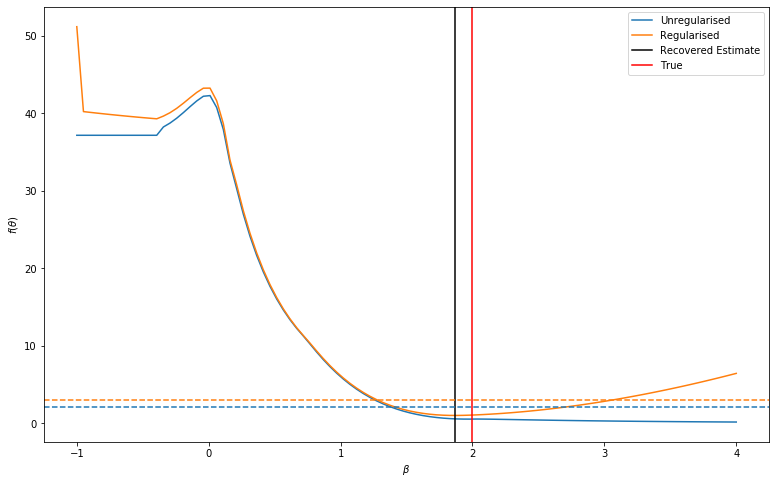

In [35]:
fs = [float(pf['f']) for pf in profile]
fs_r = [float(pf['f']) for pf in profile_r]

plt.plot(pvals.flatten(), fs, label="Unregularised")
plt.plot(pvals.flatten(), fs_r, label="Regularised")
plt.axvline(float(pref[0]), color='k', label="Recovered Estimate")
plt.axvline(float(p_true[0]), color='r', label="True")
plt.xlabel(r"$\beta$")
plt.ylabel(r"$f(\theta)$")
plt.legend()
plt.yscale('linear')
plt.axhline(min(fs) + conf, linestyle='--', color='#1f77b4')
plt.axhline(min(fs_r)+conf, linestyle='--', color='#ff7f0e')

In [36]:
idx = 35
rho = prange[idx]
pvals_s0 = np.logspace(3, 6, num=100)
profile_s0 = []
profile_rs0 = []
for pval in pvals_s0:
    lbxp = [pval] + [-np.inf]*(config['basis_number']*3-1+2)
    ubxp = [pval] + [np.inf]*(config['basis_number']*3-1+2)
    profile_s0.append(solver(x0=solutions[idx]['x'], p=[rho, 0], lbx=lbxp, ubx=ubxp, lbg=0))
    profile_rs0.append(solver(x0=solutions[idx]['x'], p=[rho, 0.5], lbx=lbxp, ubx=ubxp, lbg=0))

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:    21480
Number of nonzeros in Lagrangian Hessian.............:    16471

Total number of variables............................:      181
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

   5  3.3811165e+01 0.00e+00 1.45e+00  -1.0 1.70e+03    -  1.00e+00 1.00e+00f  1
   6  3.2542806e+01 0.00e+00 6.72e-01  -1.0 7.03e+02    -  1.00e+00 1.00e+00f  1
   7  2.7268468e+01 0.00e+00 2.73e+00  -1.7 1.42e+03    -  9.83e-01 2.31e-01f  1
   8  2.1951679e+01 0.00e+00 3.76e+00  -1.7 6.21e+02    -  1.00e+00 1.00e+00f  1
   9  2.0373144e+01 0.00e+00 1.65e+00  -1.7 2.99e+02    -  1.00e+00 7.99e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.9696267e+01 0.00e+00 7.23e-01  -1.7 1.59e+02    -  1.00e+00 1.00e+00f  1
  11  1.9292926e+01 0.00e+00 3.40e-01  -1.7 1.19e+02    -  1.00e+00 1.00e+00f  1
  12  1.9268820e+01 0.00e+00 1.85e-02  -1.7 2.41e+01    -  1.00e+00 1.00e+00f  1
  13  1.8408925e+01 0.00e+00 3.87e-01  -3.8 3.00e+02    -  9.77e-01 5.21e-01f  1
  14  1.7916177e+01 0.00e+00 3.53e-01  -3.8 2.35e+02    -  1.00e+00 9.81e-01f  1
  15  1.7884223e+01 0.00e+00 1.11e-01  -3.8 6.25e+01    -  1.00e+00 7.79e-01f  1
  16  1.7877527e+01 0.00e+00

   1  1.4002653e+03 0.00e+00 1.93e-02  -1.0 6.70e+03    -  9.81e-01 1.00e+00f  1
   2  4.6463233e+02 0.00e+00 1.30e-01  -1.0 4.86e+03    -  8.11e-01 1.00e+00f  1
   3  1.7072417e+02 0.00e+00 3.39e-01  -1.0 2.63e+03    -  9.77e-01 1.00e+00f  1
   4  5.4285863e+01 0.00e+00 3.63e+00  -1.0 3.10e+03    -  1.00e+00 1.00e+00f  1
   5  3.3154709e+01 0.00e+00 1.45e+00  -1.0 1.69e+03    -  1.00e+00 1.00e+00f  1
   6  3.2104136e+01 0.00e+00 6.50e-01  -1.0 6.89e+02    -  1.00e+00 1.00e+00f  1
   7  2.6817469e+01 0.00e+00 2.77e+00  -1.7 1.42e+03    -  9.82e-01 2.33e-01f  1
   8  2.1554798e+01 0.00e+00 3.75e+00  -1.7 6.19e+02    -  1.00e+00 1.00e+00f  1
   9  1.9986697e+01 0.00e+00 1.65e+00  -1.7 2.98e+02    -  1.00e+00 8.05e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.9326165e+01 0.00e+00 7.10e-01  -1.7 1.56e+02    -  1.00e+00 1.00e+00f  1
  11  1.8939002e+01 0.00e+00 3.31e-01  -1.7 1.18e+02    -  1.00e+00 1.00e+00f  1
  12  1.8913861e+01 0.00e+00

   5  3.2484613e+01 0.00e+00 1.46e+00  -1.0 1.67e+03    -  1.00e+00 1.00e+00f  1
   6  3.1642950e+01 0.00e+00 6.26e-01  -1.0 6.74e+02    -  1.00e+00 1.00e+00f  1
   7  2.6341138e+01 0.00e+00 2.80e+00  -1.7 1.41e+03    -  9.82e-01 2.35e-01f  1
   8  2.1134634e+01 0.00e+00 3.75e+00  -1.7 6.17e+02    -  1.00e+00 1.00e+00f  1
   9  1.9577791e+01 0.00e+00 1.66e+00  -1.7 2.97e+02    -  1.00e+00 8.11e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.8935061e+01 0.00e+00 6.96e-01  -1.7 1.52e+02    -  1.00e+00 1.00e+00f  1
  11  1.8563755e+01 0.00e+00 3.22e-01  -1.7 1.17e+02    -  1.00e+00 1.00e+00f  1
  12  1.8538431e+01 0.00e+00 1.68e-02  -1.7 2.22e+01    -  1.00e+00 1.00e+00f  1
  13  1.7691260e+01 0.00e+00 3.80e-01  -3.8 3.00e+02    -  9.78e-01 5.24e-01f  1
  14  1.7210106e+01 0.00e+00 3.56e-01  -3.8 2.35e+02    -  1.00e+00 9.71e-01f  1
  15  1.7171545e+01 0.00e+00 5.65e-02  -3.8 6.47e+01    -  1.00e+00 1.00e+00f  1
  16  1.7169345e+01 0.00e+00

   3  1.5939499e+02 0.00e+00 3.38e-01  -1.0 2.60e+03    -  9.77e-01 1.00e+00f  1
   4  5.0562731e+01 0.00e+00 3.54e+00  -1.0 3.07e+03    -  1.00e+00 1.00e+00f  1
   5  3.1800821e+01 0.00e+00 1.46e+00  -1.0 1.66e+03    -  1.00e+00 1.00e+00f  1
   6  3.1158275e+01 0.00e+00 6.00e-01  -1.0 6.58e+02    -  1.00e+00 1.00e+00f  1
   7  2.5838284e+01 0.00e+00 2.84e+00  -1.7 1.41e+03    -  9.82e-01 2.38e-01f  1
   8  2.0690322e+01 0.00e+00 3.74e+00  -1.7 6.14e+02    -  1.00e+00 1.00e+00f  1
   9  1.9145502e+01 0.00e+00 1.67e+00  -1.7 2.95e+02    -  1.00e+00 8.16e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.8522148e+01 0.00e+00 6.79e-01  -1.7 1.48e+02    -  1.00e+00 1.00e+00f  1
  11  1.8166292e+01 0.00e+00 3.13e-01  -1.7 1.16e+02    -  1.00e+00 1.00e+00f  1
  12  1.8141594e+01 0.00e+00 1.54e-02  -1.7 2.09e+01    -  1.00e+00 1.00e+00f  1
  13  1.7295441e+01 0.00e+00 3.82e-01  -3.8 3.00e+02    -  9.78e-01 5.30e-01f  1
  14  1.6823287e+01 0.00e+00

   2  4.2562961e+02 0.00e+00 1.27e-01  -1.0 4.80e+03    -  8.10e-01 1.00e+00f  1
   3  1.5342753e+02 0.00e+00 3.37e-01  -1.0 2.58e+03    -  9.77e-01 1.00e+00f  1
   4  4.8659396e+01 0.00e+00 3.49e+00  -1.0 3.05e+03    -  1.00e+00 1.00e+00f  1
   5  3.1103244e+01 0.00e+00 1.47e+00  -1.0 1.64e+03    -  1.00e+00 1.00e+00f  1
   6  3.0649279e+01 0.00e+00 5.72e-01  -1.0 6.41e+02    -  1.00e+00 1.00e+00f  1
   7  2.5310666e+01 0.00e+00 2.88e+00  -1.7 1.41e+03    -  9.82e-01 2.40e-01f  1
   8  2.0221808e+01 0.00e+00 3.73e+00  -1.7 6.12e+02    -  1.00e+00 1.00e+00f  1
   9  1.8688680e+01 0.00e+00 1.67e+00  -1.7 2.94e+02    -  1.00e+00 8.23e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.8086606e+01 0.00e+00 6.61e-01  -1.7 1.44e+02    -  1.00e+00 1.00e+00f  1
  11  1.7745763e+01 0.00e+00 3.05e-01  -1.7 1.15e+02    -  1.00e+00 1.00e+00f  1
  12  1.7722438e+01 0.00e+00 1.38e-02  -1.7 1.93e+01    -  1.00e+00 1.00e+00f  1
  13  1.6873444e+01 0.00e+00

   2  4.1136726e+02 0.00e+00 1.27e-01  -1.0 4.78e+03    -  8.10e-01 1.00e+00f  1
   3  1.4726812e+02 0.00e+00 3.36e-01  -1.0 2.56e+03    -  9.77e-01 1.00e+00f  1
   4  4.6734390e+01 0.00e+00 3.42e+00  -1.0 3.03e+03    -  1.00e+00 1.00e+00f  1
   5  3.0391776e+01 0.00e+00 1.47e+00  -1.0 1.62e+03    -  1.00e+00 1.00e+00f  1
   6  3.0115317e+01 0.00e+00 5.41e-01  -1.0 6.22e+02    -  1.00e+00 1.00e+00f  1
   7  2.4758143e+01 0.00e+00 2.93e+00  -1.7 1.41e+03    -  9.82e-01 2.43e-01f  1
   8  1.9728577e+01 0.00e+00 3.72e+00  -1.7 6.09e+02    -  1.00e+00 1.00e+00f  1
   9  1.8206493e+01 0.00e+00 1.68e+00  -1.7 2.93e+02    -  1.00e+00 8.30e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.7627639e+01 0.00e+00 6.40e-01  -1.7 1.39e+02    -  1.00e+00 1.00e+00f  1
  11  1.7301403e+01 0.00e+00 2.96e-01  -1.7 1.14e+02    -  1.00e+00 1.00e+00f  1
  12  1.7280094e+01 0.00e+00 1.20e-02  -1.7 1.75e+01    -  1.00e+00 1.00e+00f  1
  13  1.6424247e+01 0.00e+00

   4  4.4792640e+01 0.00e+00 3.36e+00  -1.0 3.01e+03    -  1.00e+00 1.00e+00f  1
   5  2.9666330e+01 0.00e+00 1.48e+00  -1.0 1.60e+03    -  1.00e+00 1.00e+00f  1
   6  2.9556007e+01 0.00e+00 5.11e-01  -1.0 6.03e+02    -  1.00e+00 1.00e+00f  1
   7  2.4176968e+01 0.00e+00 2.98e+00  -1.7 1.41e+03    -  9.83e-01 2.46e-01f  1
   8  1.9209254e+01 0.00e+00 3.76e+00  -1.7 6.07e+02    -  1.00e+00 1.00e+00f  1
   9  1.7698536e+01 0.00e+00 1.69e+00  -1.7 2.92e+02    -  1.00e+00 8.38e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.7144560e+01 0.00e+00 6.16e-01  -1.7 1.33e+02    -  1.00e+00 1.00e+00f  1
  11  1.6832520e+01 0.00e+00 2.86e-01  -1.7 1.14e+02    -  1.00e+00 1.00e+00f  1
  12  1.6813763e+01 0.00e+00 1.00e-02  -1.7 1.55e+01    -  1.00e+00 1.00e+00f  1
  13  1.5946932e+01 0.00e+00 4.16e-01  -3.8 3.00e+02    -  9.78e-01 5.65e-01f  1
  14  1.5517019e+01 0.00e+00 3.51e-01  -3.8 2.27e+02    -  1.00e+00 9.84e-01f  1
  15  1.5489962e+01 0.00e+00

   4  4.2839252e+01 0.00e+00 3.28e+00  -1.0 2.98e+03    -  1.00e+00 1.00e+00f  1
   5  2.8926881e+01 0.00e+00 1.49e+00  -1.0 1.58e+03    -  1.00e+00 1.00e+00f  1
   6  2.8971299e+01 0.00e+00 4.96e-01  -1.0 5.83e+02    -  1.00e+00 1.00e+00f  1
   7  2.3566723e+01 0.00e+00 3.04e+00  -1.7 1.41e+03    -  9.84e-01 2.49e-01f  1
   8  1.8663427e+01 0.00e+00 3.84e+00  -1.7 6.04e+02    -  1.00e+00 1.00e+00f  1
   9  1.7164213e+01 0.00e+00 1.70e+00  -1.7 2.90e+02    -  1.00e+00 8.47e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.6636733e+01 0.00e+00 5.90e-01  -1.7 1.27e+02    -  1.00e+00 1.00e+00f  1
  11  1.6338512e+01 0.00e+00 2.77e-01  -1.7 1.13e+02    -  1.00e+00 1.00e+00f  1
  12  1.6322724e+01 0.00e+00 8.44e-03  -1.7 1.33e+01    -  1.00e+00 1.00e+00f  1
  13  1.5440728e+01 0.00e+00 4.38e-01  -3.8 3.01e+02    -  9.78e-01 5.84e-01f  1
  14  1.5030640e+01 0.00e+00 3.44e-01  -3.8 2.22e+02    -  1.00e+00 9.96e-01f  1
  15  1.5008727e+01 0.00e+00

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:    21480
Number of nonzeros in Lagrangian Hessian.............:    16471

Total number of variables............................:      181
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  6.0014883e+03 0.00e+00 7.49e-01  -1.0 0.00e+00    -  0.00e+00 0.

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.5539820e+01 0.00e+00 5.08e-01  -1.7 1.08e+02    -  1.00e+00 1.00e+00f  1
  11  1.5270877e+01 0.00e+00 2.54e-01  -1.7 1.11e+02    -  1.00e+00 1.00e+00f  1
  12  1.5263709e+01 0.00e+00 5.68e-03  -1.7 1.09e+01    -  1.00e+00 1.00e+00f  1
  13  1.4346738e+01 0.00e+00 4.93e-01  -3.8 3.01e+02    -  9.79e-01 6.30e-01f  1
  14  1.4028545e+01 0.00e+00 2.85e-01  -3.8 2.12e+02    -  1.00e+00 8.39e-01f  1
  15  1.3971698e+01 0.00e+00 6.93e-02  -3.8 8.43e+01    -  1.00e+00 9.51e-01f  1
  16  1.3969126e+01 0.00e+00 2.83e-03  -3.8 1.57e+01    -  1.00e+00 1.00e+00f  1
  17  1.3968915e+01 0.00e+00 2.81e-06  -3.8 5.14e-01    -  1.00e+00 1.00e+00f  1
  18  1.3965344e+01 0.00e+00 2.42e-04  -5.7 7.96e+00    -  9.89e-01 8.24e-01f  1
  19  1.3964884e+01 0.00e+00 3.67e-04  -5.7 1.60e+00    -  9.61e-01 6.94e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.3964748e+01 0.00e+00

   6  2.6963074e+01 0.00e+00 3.86e-01  -1.0 5.01e+02    -  8.70e-01 1.00e+00f  1
   7  2.1303486e+01 0.00e+00 3.36e+00  -1.7 1.37e+03    -  9.94e-01 2.82e-01f  1
   8  1.6761866e+01 0.00e+00 3.79e+00  -1.7 5.77e+02    -  1.00e+00 1.00e+00f  1
   9  1.5353805e+01 0.00e+00 1.70e+00  -1.7 2.80e+02    -  1.00e+00 8.85e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.4945335e+01 0.00e+00 4.55e-01  -1.7 9.85e+01    -  1.00e+00 1.00e+00f  1
  11  1.4698512e+01 0.00e+00 2.29e-01  -1.7 1.07e+02    -  1.00e+00 1.00e+00f  1
  12  1.4695083e+01 0.00e+00 3.78e-03  -1.7 9.61e+00    -  1.00e+00 1.00e+00f  1
  13  1.3783334e+01 0.00e+00 4.95e-01  -3.8 3.02e+02    -  9.79e-01 6.35e-01f  1
  14  1.3451140e+01 0.00e+00 3.05e-01  -3.8 2.11e+02    -  1.00e+00 9.06e-01f  1
  15  1.3412371e+01 0.00e+00 5.22e-02  -3.8 7.15e+01    -  1.00e+00 9.64e-01f  1
  16  1.3410906e+01 0.00e+00 1.57e-03  -3.8 1.27e+01    -  1.00e+00 1.00e+00f  1
  17  1.3410705e+01 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.3740544e+03 0.00e+00 7.41e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  1.0523075e+03 0.00e+00 1.81e-02  -1.0 5.84e+03    -  9.82e-01 1.00e+00f  1
   2  3.1280891e+02 0.00e+00 1.20e-01  -1.0 4.57e+03    -  8.08e-01 1.00e+00f  1
   3  1.0702559e+02 0.00e+00 3.24e-01  -1.0 2.40e+03    -  9.77e-01 1.00e+00f  1
   4  3.5014860e+01 0.00e+00 2.87e+00  -1.0 2.84e+03    -  1.00e+00 1.00e+00f  1
   5  2.5835115e+01 0.00e+00 1.51e+00  -1.0 1.47e+03    -  8.43e-01 1.00e+00f  1
   6  2.6129195e+01 0.00e+00 2.98e-01  -1.0 4.55e+02    -  9.25e-01 1.00e+00f  1
   7  2.0550585e+01 0.00e+00 3.34e+00  -1.7 1.39e+03    -  9.93e-01 2.77e-01f  1
   8  1.6084805e+01 0.00e+00 3.94e+00  -1.7 5.76e+02    -  1.00e+00 1.00e+00f  1
   9  1.4683838e+01 0.00e+00 1.67e+00  -1.7 2.78e+02    -  1.00e+00 9.10e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.4323378e+01 0.00e+00

   1  1.0064594e+03 0.00e+00 1.79e-02  -1.0 5.71e+03    -  9.82e-01 1.00e+00f  1
   2  2.9442094e+02 0.00e+00 1.19e-01  -1.0 4.52e+03    -  8.07e-01 1.00e+00f  1
   3  9.9949121e+01 0.00e+00 3.21e-01  -1.0 2.36e+03    -  9.77e-01 1.00e+00f  1
   4  3.3082714e+01 0.00e+00 2.73e+00  -1.0 2.80e+03    -  1.00e+00 1.00e+00f  1
   5  2.5033590e+01 0.00e+00 1.52e+00  -1.0 1.44e+03    -  7.45e-01 1.00e+00f  1
   6  2.5295265e+01 0.00e+00 2.35e-01  -1.0 4.13e+02    -  9.89e-01 1.00e+00f  1
   7  1.9808569e+01 0.00e+00 3.32e+00  -1.7 1.41e+03    -  9.96e-01 2.69e-01f  1
   8  1.5399362e+01 0.00e+00 4.24e+00  -1.7 5.80e+02    -  1.00e+00 1.00e+00f  1
   9  1.3998078e+01 0.00e+00 1.66e+00  -1.7 2.78e+02    -  1.00e+00 9.32e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.3678759e+01 0.00e+00 4.29e-01  -1.7 1.03e+02    -  1.00e+00 1.00e+00f  1
  11  1.3478634e+01 0.00e+00 1.76e-01  -1.7 9.67e+01    -  1.00e+00 1.00e+00f  1
  12  1.2556822e+01 0.00e+00

   1  9.5846771e+02 0.00e+00 1.77e-02  -1.0 5.58e+03    -  9.82e-01 1.00e+00f  1
   2  2.7558350e+02 0.00e+00 1.18e-01  -1.0 4.47e+03    -  8.07e-01 1.00e+00f  1
   3  9.2834241e+01 0.00e+00 3.18e-01  -1.0 2.32e+03    -  9.77e-01 1.00e+00f  1
   4  3.1170766e+01 0.00e+00 2.58e+00  -1.0 2.75e+03    -  1.00e+00 1.00e+00f  1
   5  2.4225112e+01 0.00e+00 1.53e+00  -1.0 1.41e+03    -  6.49e-01 1.00e+00f  1
   6  2.4456108e+01 0.00e+00 1.88e-01  -1.0 3.75e+02    -  1.00e+00 1.00e+00f  1
   7  1.8974095e+01 0.00e+00 3.39e+00  -2.5 1.72e+03    -  8.47e-01 2.21e-01f  1
   8  1.3944552e+01 0.00e+00 6.99e+00  -2.5 7.53e+02    -  1.00e+00 1.00e+00f  1
   9  1.2683564e+01 0.00e+00 2.70e+00  -2.5 3.38e+02    -  1.00e+00 6.16e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.2042023e+01 0.00e+00 1.39e+00  -2.5 2.24e+02    -  1.00e+00 7.23e-01f  1
  11  1.1754843e+01 0.00e+00 5.64e-01  -2.5 1.33e+02    -  8.91e-01 1.00e+00f  1
  12  1.1697618e+01 0.00e+00

   3  8.5712144e+01 0.00e+00 3.14e-01  -1.0 2.27e+03    -  9.77e-01 1.00e+00f  1
   4  2.9284287e+01 0.00e+00 2.41e+00  -1.0 2.69e+03    -  1.00e+00 1.00e+00f  1
   5  2.3414125e+01 0.00e+00 1.55e+00  -1.0 1.37e+03    -  5.50e-01 1.00e+00f  1
   6  2.3602347e+01 0.00e+00 1.51e-01  -1.0 3.39e+02    -  1.00e+00 1.00e+00f  1
   7  1.8107850e+01 0.00e+00 3.49e+00  -2.5 1.72e+03    -  8.51e-01 2.26e-01f  1
   8  1.3189981e+01 0.00e+00 7.22e+00  -2.5 7.50e+02    -  1.00e+00 1.00e+00f  1
   9  1.1972831e+01 0.00e+00 2.79e+00  -2.5 3.39e+02    -  1.00e+00 6.13e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.1319346e+01 0.00e+00 1.32e+00  -2.5 2.15e+02    -  1.00e+00 7.88e-01f  1
  11  1.1084178e+01 0.00e+00 4.91e-01  -2.5 1.17e+02    -  1.00e+00 1.00e+00f  1
  12  1.1037781e+01 0.00e+00 1.13e-01  -2.5 6.33e+01    -  1.00e+00 1.00e+00f  1
  13  1.1034032e+01 0.00e+00 5.39e-03  -2.5 1.08e+01    -  1.00e+00 1.00e+00f  1
  14  1.0937342e+01 0.00e+00

   2  2.3683892e+02 0.00e+00 1.15e-01  -1.0 4.33e+03    -  8.06e-01 1.00e+00f  1
   3  7.8616519e+01 0.00e+00 3.09e-01  -1.0 2.22e+03    -  9.77e-01 1.00e+00f  1
   4  2.7428558e+01 0.00e+00 2.21e+00  -1.0 2.63e+03    -  9.83e-01 1.00e+00f  1
   5  2.2492927e+01 0.00e+00 1.47e+00  -1.0 1.31e+03    -  5.34e-01 1.00e+00f  1
   6  2.2737628e+01 0.00e+00 1.52e-01  -1.0 3.24e+02    -  1.00e+00 1.00e+00f  1
   7  1.7203332e+01 0.00e+00 3.64e+00  -2.5 1.72e+03    -  8.58e-01 2.33e-01f  1
   8  1.2406163e+01 0.00e+00 7.41e+00  -2.5 7.46e+02    -  1.00e+00 1.00e+00f  1
   9  1.1229212e+01 0.00e+00 2.81e+00  -2.5 3.40e+02    -  1.00e+00 6.15e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.0564340e+01 0.00e+00 1.22e+00  -2.5 2.03e+02    -  1.00e+00 8.81e-01f  1
  11  1.0390939e+01 0.00e+00 4.49e-01  -2.5 9.75e+01    -  1.00e+00 1.00e+00f  1
  12  1.0354799e+01 0.00e+00 8.54e-02  -2.5 5.68e+01    -  1.00e+00 1.00e+00f  1
  13  1.0352603e+01 0.00e+00

   9  1.0456039e+01 0.00e+00 2.76e+00  -2.5 3.41e+02    -  1.00e+00 6.26e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  9.7876730e+00 0.00e+00 1.07e+00  -2.5 1.88e+02    -  1.00e+00 1.00e+00f  1
  11  9.6765790e+00 0.00e+00 3.70e-01  -2.5 8.07e+01    -  1.00e+00 1.00e+00f  1
  12  9.6509285e+00 0.00e+00 5.48e-02  -2.5 4.68e+01    -  1.00e+00 1.00e+00f  1
  13  9.6498870e+00 0.00e+00 8.08e-04  -2.5 3.76e+00    -  1.00e+00 1.00e+00f  1
  14  9.5626434e+00 0.00e+00 5.58e-02  -3.8 9.08e+01    -  1.00e+00 8.18e-01f  1
  15  9.5457099e+00 0.00e+00 5.75e-03  -3.8 3.63e+01    -  1.00e+00 1.00e+00f  1
  16  9.5454179e+00 0.00e+00 2.14e-06  -3.8 2.08e+00    -  1.00e+00 1.00e+00f  1
  17  9.5422099e+00 0.00e+00 3.05e-04  -5.7 8.25e+00    -  9.88e-01 7.70e-01f  1
  18  9.5416269e+00 0.00e+00 3.49e-04  -5.7 2.13e+00    -  1.00e+00 7.05e-01f  1
  19  9.5414612e+00 0.00e+00 4.25e-04  -5.7 6.39e-01    -  1.00e+00 7.97e-01f  1
iter    objective    inf_pr 

   5  2.0491472e+01 0.00e+00 1.23e+00  -1.0 1.17e+03    -  5.85e-01 1.00e+00f  1
   6  2.0949412e+01 0.00e+00 1.97e-01  -1.0 3.13e+02    -  1.00e+00 1.00e+00f  1
   7  1.5318116e+01 0.00e+00 4.03e+00  -2.5 1.72e+03    -  8.73e-01 2.52e-01f  1
   8  1.0774952e+01 0.00e+00 7.64e+00  -2.5 7.36e+02    -  1.00e+00 1.00e+00f  1
   9  9.6571298e+00 0.00e+00 2.62e+00  -2.5 3.42e+02    -  1.00e+00 6.43e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  9.0490101e+00 0.00e+00 9.74e-01  -2.5 1.69e+02    -  1.00e+00 1.00e+00f  1
  11  8.9433445e+00 0.00e+00 3.38e-01  -2.5 8.32e+01    -  1.00e+00 1.00e+00f  1
  12  8.9292816e+00 0.00e+00 3.40e-02  -2.5 3.36e+01    -  1.00e+00 1.00e+00f  1
  13  8.9283299e+00 0.00e+00 5.44e-04  -2.5 3.21e+00    -  1.00e+00 1.00e+00f  1
  14  8.8395775e+00 0.00e+00 6.07e-02  -3.8 9.12e+01    -  1.00e+00 8.43e-01f  1
  15  8.8248525e+00 0.00e+00 3.78e-03  -3.8 3.42e+01    -  1.00e+00 1.00e+00f  1
  16  8.8247206e+00 0.00e+00

   1  6.8799199e+02 0.00e+00 1.65e-02  -1.0 4.74e+03    -  9.84e-01 1.00e+00f  1
   2  1.7746081e+02 0.00e+00 1.09e-01  -1.0 4.07e+03    -  8.05e-01 1.00e+00f  1
   3  5.7858674e+01 0.00e+00 2.92e-01  -1.0 2.04e+03    -  9.78e-01 1.00e+00f  1
   4  2.2100292e+01 0.00e+00 1.47e+00  -1.0 2.41e+03    -  9.00e-01 1.00e+00f  1
   5  1.9469767e+01 0.00e+00 1.11e+00  -1.0 1.09e+03    -  6.10e-01 1.00e+00f  1
   6  2.0029093e+01 0.00e+00 2.26e-01  -1.0 3.08e+02    -  1.00e+00 1.00e+00f  1
   7  1.4342009e+01 0.00e+00 4.25e+00  -1.7 1.42e+03    -  1.00e+00 3.22e-01f  1
   8  1.0659395e+01 0.00e+00 4.52e+00  -1.7 5.46e+02    -  1.00e+00 1.00e+00f  1
   9  9.5143664e+00 0.00e+00 1.77e+00  -1.7 2.89e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  9.3399497e+00 0.00e+00 3.60e-01  -1.7 1.16e+02    -  1.00e+00 1.00e+00f  1
  11  9.2688871e+00 0.00e+00 4.20e-02  -1.7 4.91e+01    -  1.00e+00 1.00e+00f  1
  12  8.3032973e+00 0.00e+00

   4  2.0423246e+01 0.00e+00 1.15e+00  -1.0 2.32e+03    -  8.72e-01 1.00e+00f  1
   5  1.8439426e+01 0.00e+00 9.92e-01  -1.0 1.02e+03    -  6.36e-01 1.00e+00f  1
   6  1.9100283e+01 0.00e+00 2.64e-01  -1.0 3.03e+02    -  1.00e+00 1.00e+00f  1
   7  1.3341925e+01 0.00e+00 4.53e+00  -1.7 1.43e+03    -  1.00e+00 3.37e-01f  1
   8  9.8116082e+00 0.00e+00 4.43e+00  -1.7 5.35e+02    -  1.00e+00 1.00e+00f  1
   9  8.7227124e+00 0.00e+00 1.81e+00  -1.7 2.93e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  8.5613998e+00 0.00e+00 3.29e-01  -1.7 1.17e+02    -  1.00e+00 1.00e+00f  1
  11  8.5062699e+00 0.00e+00 2.88e-02  -1.7 4.06e+01    -  1.00e+00 1.00e+00f  1
  12  7.5368332e+00 0.00e+00 1.21e+00  -2.5 2.70e+02    -  1.00e+00 9.64e-01f  1
  13  7.4504254e+00 0.00e+00 5.39e-02  -2.5 9.53e+01    -  1.00e+00 1.00e+00f  1
  14  7.4432607e+00 0.00e+00 1.89e-03  -2.5 1.37e+01    -  1.00e+00 1.00e+00f  1
  15  7.3462394e+00 0.00e+00

   6  1.8170388e+01 0.00e+00 3.16e-01  -1.0 2.97e+02    -  1.00e+00 1.00e+00f  1
   7  1.2325968e+01 0.00e+00 4.87e+00  -1.7 1.44e+03    -  1.00e+00 3.54e-01f  1
   8  8.9591049e+00 0.00e+00 4.27e+00  -1.7 5.22e+02    -  1.00e+00 1.00e+00f  1
   9  7.9248515e+00 0.00e+00 1.85e+00  -1.7 2.97e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  7.7763092e+00 0.00e+00 2.93e-01  -1.7 1.17e+02    -  1.00e+00 1.00e+00f  1
  11  7.7356578e+00 0.00e+00 1.79e-02  -1.7 3.21e+01    -  1.00e+00 1.00e+00f  1
  12  6.7750483e+00 0.00e+00 1.32e+00  -3.8 3.14e+02    -  9.86e-01 8.48e-01f  1
  13  6.6008093e+00 0.00e+00 2.20e-02  -3.8 1.68e+02    -  1.00e+00 1.00e+00f  1
  14  6.5879640e+00 0.00e+00 1.44e-02  -3.8 4.82e+01    -  1.00e+00 1.00e+00f  1
  15  6.5874569e+00 0.00e+00 2.01e-04  -3.8 6.12e+00    -  1.00e+00 1.00e+00f  1
  16  6.5835030e+00 0.00e+00 4.73e-04  -5.7 8.62e+00    -  9.86e-01 9.62e-01f  1
  17  6.5833118e+00 0.00e+00

   2  1.1967205e+02 0.00e+00 1.01e-01  -1.0 3.69e+03    -  8.04e-01 1.00e+00f  1
   3  3.8745244e+01 0.00e+00 2.65e-01  -1.0 1.78e+03    -  9.78e-01 1.00e+00f  1
   4  1.7257908e+01 0.00e+00 9.17e-01  -1.0 2.11e+03    -  8.18e-01 1.00e+00f  1
   5  1.6378003e+01 0.00e+00 7.62e-01  -1.0 8.65e+02    -  7.02e-01 1.00e+00f  1
   6  1.7249621e+01 0.00e+00 5.13e-01  -1.0 2.94e+02    -  1.00e+00 1.00e+00f  1
   7  1.1299588e+01 0.00e+00 5.28e+00  -1.7 1.46e+03    -  1.00e+00 3.74e-01f  1
   8  8.1082427e+00 0.00e+00 4.04e+00  -1.7 5.06e+02    -  1.00e+00 1.00e+00f  1
   9  7.1266843e+00 0.00e+00 1.90e+00  -1.7 3.01e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.9904826e+00 0.00e+00 2.56e-01  -1.7 1.17e+02    -  1.00e+00 1.00e+00f  1
  11  6.9626813e+00 0.00e+00 9.60e-03  -1.7 2.36e+01    -  1.00e+00 1.00e+00f  1
  12  6.0025907e+00 0.00e+00 1.51e+00  -3.8 3.17e+02    -  9.86e-01 8.79e-01f  1
  13  5.8461969e+00 0.00e+00

   2  1.0153470e+02 0.00e+00 9.77e-02  -1.0 3.53e+03    -  8.04e-01 1.00e+00f  1
   3  3.2939804e+01 0.00e+00 2.54e-01  -1.0 1.68e+03    -  9.79e-01 1.00e+00f  1
   4  1.5786005e+01 0.00e+00 1.23e+00  -1.0 2.00e+03    -  7.96e-01 1.00e+00f  1
   5  1.5365625e+01 0.00e+00 6.55e-01  -1.0 7.87e+02    -  7.50e-01 1.00e+00f  1
   6  1.6353494e+01 0.00e+00 7.82e-01  -1.0 2.93e+02    -  1.00e+00 1.00e+00f  1
   7  1.0301633e+01 0.00e+00 5.74e+00  -1.7 1.48e+03    -  1.00e+00 3.95e-01f  1
   8  7.2742202e+00 0.00e+00 3.78e+00  -1.7 4.89e+02    -  1.00e+00 1.00e+00f  1
   9  6.3371652e+00 0.00e+00 1.94e+00  -1.7 3.04e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.2120023e+00 0.00e+00 2.22e-01  -1.7 1.17e+02    -  1.00e+00 1.00e+00f  1
  11  6.1940591e+00 0.00e+00 4.63e-03  -1.7 1.65e+01    -  1.00e+00 1.00e+00f  1
  12  5.2347449e+00 0.00e+00 1.76e+00  -3.8 3.20e+02    -  9.87e-01 9.19e-01f  1
  13  5.0983018e+00 0.00e+00

   4  1.4400768e+01 0.00e+00 1.64e+00  -1.0 1.87e+03    -  7.82e-01 1.00e+00f  1
   5  1.4385716e+01 0.00e+00 5.57e-01  -1.0 7.12e+02    -  8.27e-01 1.00e+00f  1
   6  1.5511954e+01 0.00e+00 1.18e+00  -1.0 2.95e+02    -  1.00e+00 1.00e+00f  1
   7  1.6133953e+01 0.00e+00 1.11e-01  -1.0 8.00e+01    -  1.00e+00 1.00e+00f  1
   8  9.8773586e+00 0.00e+00 6.22e+00  -2.5 1.88e+03    -  8.72e-01 2.86e-01f  1
   9  5.9667588e+00 0.00e+00 1.07e+01  -2.5 7.76e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.9958058e+00 0.00e+00 3.75e+00  -2.5 5.72e+02    -  9.41e-01 5.86e-01f  1
  11  4.5086160e+00 0.00e+00 5.98e-01  -2.5 1.64e+02    -  1.00e+00 1.00e+00f  1
  12  4.4503849e+00 0.00e+00 3.07e-01  -2.5 8.87e+01    -  1.00e+00 1.00e+00f  1
  13  4.4476382e+00 0.00e+00 5.88e-03  -2.5 2.59e+01    -  1.00e+00 1.00e+00f  1
  14  4.3589544e+00 0.00e+00 9.50e-02  -3.8 9.66e+01    -  1.00e+00 9.58e-01f  1
  15  4.3523763e+00 0.00e+00

   3  2.2442917e+01 0.00e+00 2.28e-01  -1.0 1.46e+03    -  9.79e-01 1.00e+00f  1
   4  1.3113735e+01 0.00e+00 2.19e+00  -1.0 1.74e+03    -  7.86e-01 1.00e+00f  1
   5  1.3469628e+01 0.00e+00 4.75e-01  -1.0 6.44e+02    -  8.90e-01 1.00e+00f  1
   6  7.1804582e+00 0.00e+00 7.26e+00  -1.7 1.50e+03    -  1.00e+00 5.81e-01f  1
   7  5.3463467e+00 0.00e+00 1.49e+00  -1.7 3.31e+02    -  1.00e+00 1.00e+00f  1
   8  4.7313167e+00 0.00e+00 1.12e+00  -1.7 1.83e+02    -  1.00e+00 1.00e+00f  1
   9  4.7066392e+00 0.00e+00 9.00e-03  -1.7 6.65e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.7661883e+00 0.00e+00 2.40e+00  -3.8 3.30e+02    -  9.90e-01 1.00e+00f  1
  11  3.6534625e+00 0.00e+00 6.92e-01  -3.8 1.39e+02    -  9.43e-01 1.00e+00f  1
  12  3.6430933e+00 0.00e+00 1.77e-02  -3.8 5.15e+01    -  1.00e+00 1.00e+00f  1
  13  3.6425908e+00 0.00e+00 1.31e-03  -3.8 7.43e+00    -  1.00e+00 1.00e+00f  1
  14  3.6393885e+00 0.00e+00

   3  1.7840192e+01 0.00e+00 2.14e-01  -1.0 1.34e+03    -  9.80e-01 1.00e+00f  1
   4  1.1940696e+01 0.00e+00 2.95e+00  -1.0 1.59e+03    -  8.38e-01 1.00e+00f  1
   5  1.2715300e+01 0.00e+00 4.42e-01  -1.0 6.00e+02    -  9.13e-01 1.00e+00f  1
   6  6.3630749e+00 0.00e+00 7.65e+00  -1.7 1.51e+03    -  1.00e+00 5.90e-01f  1
   7  4.5934732e+00 0.00e+00 1.55e+00  -1.7 3.36e+02    -  1.00e+00 1.00e+00f  1
   8  4.0206452e+00 0.00e+00 1.09e+00  -1.7 1.84e+02    -  1.00e+00 1.00e+00f  1
   9  4.0012296e+00 0.00e+00 4.03e-02  -1.7 7.18e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.1596267e+00 0.00e+00 1.95e+00  -2.5 2.92e+02    -  1.00e+00 1.00e+00f  1
  11  3.0707395e+00 0.00e+00 4.30e-01  -2.5 1.04e+02    -  1.00e+00 1.00e+00f  1
  12  3.0613920e+00 0.00e+00 5.83e-03  -2.5 2.68e+01    -  1.00e+00 1.00e+00f  1
  13  2.9757826e+00 0.00e+00 9.07e-02  -3.8 1.01e+02    -  1.00e+00 1.00e+00f  1
  14  2.9703870e+00 0.00e+00

   6  5.6765975e+00 0.00e+00 7.94e+00  -1.7 1.54e+03    -  1.00e+00 5.85e-01f  1
   7  3.8992881e+00 0.00e+00 1.75e+00  -1.7 3.61e+02    -  1.00e+00 1.00e+00f  1
   8  3.3609104e+00 0.00e+00 1.07e+00  -1.7 1.89e+02    -  1.00e+00 1.00e+00f  1
   9  3.3412430e+00 0.00e+00 8.54e-02  -1.7 8.34e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.5375663e+00 0.00e+00 2.09e+00  -2.5 3.01e+02    -  1.00e+00 1.00e+00f  1
  11  2.4460851e+00 0.00e+00 5.90e-01  -2.5 1.21e+02    -  1.00e+00 1.00e+00f  1
  12  2.4350316e+00 0.00e+00 9.52e-03  -2.5 3.27e+01    -  1.00e+00 1.00e+00f  1
  13  2.3533072e+00 0.00e+00 7.14e-02  -3.8 1.04e+02    -  1.00e+00 1.00e+00f  1
  14  2.3465487e+00 0.00e+00 1.28e-02  -3.8 2.58e+01    -  1.00e+00 1.00e+00f  1
  15  2.3463864e+00 0.00e+00 7.43e-05  -3.8 2.88e+00    -  1.00e+00 1.00e+00f  1
  16  2.3433214e+00 0.00e+00 2.89e-04  -5.7 9.35e+00    -  9.88e-01 8.78e-01f  1
  17  2.3430013e+00 0.00e+00

   3  1.0145367e+01 0.00e+00 1.81e-01  -1.0 1.06e+03    -  9.81e-01 1.00e+00f  1
   4  1.0020231e+01 0.00e+00 5.42e+00  -1.0 1.27e+03    -  7.73e-01 1.00e+00f  1
   5  1.0892311e+01 0.00e+00 1.67e-01  -1.0 4.23e+02    -  9.44e-01 1.00e+00f  1
   6  4.7315753e+00 0.00e+00 8.42e+00  -1.7 1.50e+03    -  1.00e+00 6.23e-01f  1
   7  3.1363601e+00 0.00e+00 1.39e+00  -1.7 3.49e+02    -  1.00e+00 1.00e+00f  1
   8  2.7540310e+00 0.00e+00 6.91e-01  -1.7 1.41e+02    -  1.00e+00 1.00e+00f  1
   9  2.7452511e+00 0.00e+00 1.10e-01  -1.7 7.22e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.9774708e+00 0.00e+00 2.19e+00  -2.5 3.15e+02    -  1.00e+00 1.00e+00f  1
  11  1.8854339e+00 0.00e+00 7.74e-01  -2.5 1.39e+02    -  1.00e+00 1.00e+00f  1
  12  1.8726402e+00 0.00e+00 1.35e-02  -2.5 4.00e+01    -  1.00e+00 1.00e+00f  1
  13  1.7957354e+00 0.00e+00 6.41e-02  -3.8 1.18e+02    -  1.00e+00 1.00e+00f  1
  14  1.7878148e+00 0.00e+00

   2  1.8750422e+01 0.00e+00 5.85e-02  -1.0 1.98e+03    -  8.15e-01 1.00e+00f  1
   3  7.1378581e+00 0.00e+00 1.65e-01  -1.0 8.90e+02    -  9.82e-01 1.00e+00f  1
   4  9.3317889e+00 0.00e+00 7.40e+00  -1.0 1.13e+03    -  6.34e-01 1.00e+00f  1
   5  9.9663955e+00 0.00e+00 2.22e-01  -1.0 3.01e+02    -  9.32e-01 1.00e+00f  1
   6  4.0329137e+00 0.00e+00 8.93e+00  -1.7 1.48e+03    -  1.00e+00 6.50e-01f  1
   7  2.4954114e+00 0.00e+00 1.22e+00  -1.7 3.46e+02    -  1.00e+00 1.00e+00f  1
   8  2.2356445e+00 0.00e+00 4.15e-01  -1.7 1.34e+02    -  1.00e+00 1.00e+00f  1
   9  2.2243443e+00 0.00e+00 9.38e-02  -1.7 5.91e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.4960832e+00 0.00e+00 2.23e+00  -2.5 3.35e+02    -  1.00e+00 1.00e+00f  1
  11  1.4058582e+00 0.00e+00 1.05e+00  -2.5 1.61e+02    -  1.00e+00 1.00e+00f  1
  12  1.3911266e+00 0.00e+00 1.90e-02  -2.5 5.00e+01    -  1.00e+00 1.00e+00f  1
  13  1.3202270e+00 0.00e+00

   4  8.8626370e+00 0.00e+00 1.01e+01  -1.0 1.20e+03    -  5.24e-01 1.00e+00f  1
   5  9.2599282e+00 0.00e+00 5.73e-01  -1.0 2.05e+02    -  1.00e+00 1.00e+00f  1
   6  3.6199465e+00 0.00e+00 8.99e+00  -1.7 1.46e+03    -  1.00e+00 6.24e-01f  1
   7  1.9827347e+00 0.00e+00 1.61e+00  -1.7 3.93e+02    -  1.00e+00 1.00e+00f  1
   8  1.8139752e+00 0.00e+00 2.51e-01  -1.7 1.16e+02    -  1.00e+00 1.00e+00f  1
   9  1.7927613e+00 0.00e+00 7.62e-02  -1.7 5.40e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.1104367e+00 0.00e+00 2.17e+00  -2.5 3.53e+02    -  1.00e+00 1.00e+00f  1
  11  1.0257718e+00 0.00e+00 1.42e+00  -2.5 1.87e+02    -  1.00e+00 1.00e+00f  1
  12  1.0091754e+00 0.00e+00 2.53e-02  -2.5 6.26e+01    -  1.00e+00 1.00e+00f  1
  13  9.4589968e-01 0.00e+00 2.91e-01  -3.8 1.91e+02    -  9.96e-01 1.00e+00f  1
  14  9.3508000e-01 0.00e+00 4.22e-02  -3.8 5.06e+01    -  1.00e+00 1.00e+00f  1
  15  9.3402130e-01 0.00e+00

   4  5.8702074e+00 0.00e+00 1.07e+01  -1.0 7.47e+02    -  6.27e-01 1.00e+00f  1
   5  7.8928051e+00 0.00e+00 2.97e+00  -1.0 4.91e+02    -  1.00e+00 1.00e+00f  1
   6  1.0108607e+01 0.00e+00 3.52e+00  -1.0 2.48e+02    -  1.00e+00 1.00e+00f  1
   7  1.0677869e+01 0.00e+00 1.02e-01  -1.0 6.18e+01    -  1.00e+00 1.00e+00f  1
   8  4.6780715e+00 0.00e+00 1.11e+01  -2.5 1.94e+03    -  9.17e-01 3.93e-01f  1
   9  1.5095501e+00 0.00e+00 1.30e+01  -2.5 1.05e+03    -  6.56e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.2305689e+00 0.00e+00 6.18e+00  -2.5 2.88e+03    -  4.28e-01 1.22e-01f  2
  11  8.0771351e-01 0.00e+00 1.80e-01  -2.5 1.04e+02    -  6.02e-01 1.00e+00f  1
  12  7.5258059e-01 0.00e+00 1.02e+00  -2.5 3.81e+02    -  1.00e+00 1.00e+00f  1
  13  7.4510637e-01 0.00e+00 3.35e-03  -2.5 2.93e+01    -  1.00e+00 1.00e+00f  1
  14  6.9276962e-01 0.00e+00 7.36e-01  -3.8 2.58e+02    -  9.79e-01 1.00e+00f  1
  15  6.8104334e-01 0.00e+00

   3  1.8804808e+00 0.00e+00 1.53e-01  -1.0 3.08e+02    -  9.84e-01 1.00e+00f  1
   4  8.5511064e+00 0.00e+00 1.83e+01  -1.0 1.39e+03    -  1.00e+00 1.00e+00f  1
   5  8.3586477e+00 0.00e+00 2.31e+00  -1.0 2.00e+02    -  1.00e+00 1.00e+00f  1
   6  1.0327047e+01 0.00e+00 2.94e+00  -1.0 2.47e+02    -  1.00e+00 1.00e+00f  1
   7  1.0445494e+01 0.00e+00 3.62e-02  -1.0 3.55e+01    -  1.00e+00 1.00e+00f  1
   8  4.7277675e+00 0.00e+00 1.52e+01  -2.5 1.93e+03    -  9.10e-01 3.90e-01f  1
   9  1.4300007e+00 0.00e+00 1.56e+01  -2.5 1.21e+03    -  5.76e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.2321244e+00 0.00e+00 1.73e-03  -2.5 3.33e+00  -4.0 1.00e+00 1.00e+00f  1
  11  8.0638761e-01 0.00e+00 4.64e+00  -3.8 1.03e+03    -  6.83e-01 3.83e-01f  2
  12  5.9123945e-01 0.00e+00 2.34e-01  -3.8 1.30e+02    -  6.02e-01 1.00e+00f  1
  13  5.8219479e-01 0.00e+00 1.86e+00  -3.8 6.16e+02    -  5.06e-01 5.00e-01f  2
  14  5.6978445e-01 0.00e+00

   4  1.1737886e+00 0.00e+00 6.92e-02  -1.7 2.41e+02    -  1.00e+00 1.00e+00f  1
   5  6.7810530e-01 0.00e+00 3.45e+00  -2.5 2.59e+02    -  1.00e+00 1.00e+00f  1
   6  6.0411562e-01 0.00e+00 2.27e-02  -2.5 5.16e+01    -  1.00e+00 1.00e+00f  1
   7  5.7519736e-01 0.00e+00 7.99e-02  -3.8 5.41e+01    -  1.00e+00 1.00e+00f  1
   8  5.7136229e-01 0.00e+00 3.14e-02  -3.8 6.14e+01    -  1.00e+00 1.00e+00f  1
   9  5.7064445e-01 0.00e+00 1.15e-02  -3.8 3.08e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.7055720e-01 0.00e+00 2.94e-04  -3.8 4.65e+00    -  1.00e+00 1.00e+00f  1
  11  5.7016710e-01 0.00e+00 4.38e-03  -5.7 1.85e+01    -  9.92e-01 1.00e+00f  1
  12  5.7013192e-01 0.00e+00 7.04e-04  -5.7 8.34e+00    -  1.00e+00 1.00e+00f  1
  13  5.7012805e-01 0.00e+00 7.38e-06  -5.7 8.52e-01    -  1.00e+00 1.00e+00h  1
  14  5.7012672e-01 0.00e+00 3.56e-06  -8.6 5.65e-01    -  1.00e+00 1.00e+00h  1
  15  5.7012647e-01 0.00e+00

   4  1.2581434e+00 0.00e+00 2.19e-01  -1.0 7.84e+01    -  8.61e-01 1.00e+00f  1
   5  2.8062044e+00 0.00e+00 5.67e+00  -1.0 3.26e+02    -  9.74e-01 1.00e+00f  1
   6  8.3151773e+00 0.00e+00 2.59e+01  -1.0 1.95e+03    -  1.00e+00 1.00e+00f  1
   7  1.0194371e+01 0.00e+00 3.93e+01  -1.0 1.33e+03    -  9.65e-01 5.00e-01f  2
   8  1.0209846e+01 0.00e+00 4.00e+00  -1.0 1.88e+02    -  1.00e+00 1.00e+00f  1
   9  9.8127466e+00 0.00e+00 5.83e-01  -1.0 1.56e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.0167276e+00 0.00e+00 2.08e+01  -1.7 1.52e+03    -  1.00e+00 5.46e-01f  1
  11  1.4270045e+00 0.00e+00 7.69e+00  -1.7 8.35e+02    -  5.58e-01 1.00e+00f  1
  12  1.3630754e+00 0.00e+00 1.03e-03  -1.7 3.33e+00  -4.0 1.00e+00 1.00e+00f  1
  13  9.1599259e-01 0.00e+00 7.61e+00  -3.8 8.49e+02    -  8.02e-01 5.00e-01f  2
  14  6.4248205e-01 0.00e+00 1.58e-01  -3.8 1.54e+02    -  9.45e-01 1.00e+00f  1
  15  6.1236998e-01 0.00e+00

   4  2.3012489e+00 0.00e+00 4.06e-01  -1.0 2.69e+02    -  5.44e-01 1.00e+00f  1
   5  1.7568228e+00 0.00e+00 2.65e-01  -1.0 1.54e+02    -  8.44e-01 1.00e+00f  1
   6  2.7331823e+00 0.00e+00 4.93e+00  -1.0 3.24e+02    -  9.49e-01 1.00e+00f  1
   7  7.1353190e+00 0.00e+00 2.65e+01  -1.0 1.83e+03    -  1.00e+00 1.00e+00f  1
   8  8.0868192e+00 0.00e+00 1.30e+01  -1.0 9.66e+02    -  1.00e+00 5.00e-01f  2
   9  9.2658033e+00 0.00e+00 1.90e+00  -1.0 5.07e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  9.7949653e+00 0.00e+00 1.48e-01  -1.0 1.81e+02    -  1.00e+00 1.00e+00f  1
  11  6.1847122e+00 0.00e+00 2.78e+01  -2.5 2.17e+03    -  9.14e-01 4.31e-01f  1
  12  1.9764308e+00 0.00e+00 1.81e+01  -2.5 1.55e+03    -  3.52e-01 1.00e+00f  1
  13  1.6719023e+00 0.00e+00 3.09e-03  -2.5 4.70e+00  -4.0 1.00e+00 1.00e+00f  1
  14  1.6331729e+00 0.00e+00 1.18e+01  -3.8 1.35e+03    -  5.30e-01 4.52e-01f  2
  15  7.2638639e-01 0.00e+00

   3  1.1712505e+01 0.00e+00 3.52e-01  -1.0 9.06e+02    -  3.75e-01 1.00e+00f  1
   4  6.4665177e+00 0.00e+00 5.32e-01  -1.0 4.46e+02    -  4.91e-01 1.00e+00f  1
   5  3.6451076e+00 0.00e+00 6.75e-01  -1.0 3.33e+02    -  4.22e-01 1.00e+00f  1
   6  2.7123870e+00 0.00e+00 1.19e-01  -1.0 1.90e+02    -  8.99e-01 1.00e+00f  1
   7  3.8780279e+00 0.00e+00 1.13e+01  -1.0 4.93e+02    -  9.29e-01 1.00e+00f  1
   8  6.8081700e+00 0.00e+00 2.22e+01  -1.0 1.91e+03    -  1.00e+00 1.00e+00f  1
   9  7.8399983e+00 0.00e+00 6.79e+00  -1.0 7.41e+02    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  9.1595884e+00 0.00e+00 2.17e+00  -1.0 6.55e+02    -  1.00e+00 1.00e+00f  1
  11  9.7977201e+00 0.00e+00 1.66e-01  -1.0 2.21e+02    -  1.00e+00 1.00e+00f  1
  12  7.2715831e+00 0.00e+00 3.16e+01  -2.5 2.27e+03    -  9.13e-01 4.36e-01f  1
  13  2.3771908e+00 0.00e+00 1.75e+01  -2.5 1.62e+03    -  3.17e-01 1.00e+00f  1
  14  2.0252593e+00 0.00e+00

   1  1.7880207e+02 0.00e+00 1.41e-01  -1.0 2.49e+03    -  8.75e-01 1.00e+00f  1
   2  6.4392508e+01 0.00e+00 2.57e-02  -1.0 2.03e+03    -  8.15e-01 1.00e+00f  1
   3  2.6007046e+01 0.00e+00 4.04e-01  -1.0 1.20e+03    -  3.45e-01 1.00e+00f  1
   4  1.5457477e+01 0.00e+00 4.43e-01  -1.0 6.11e+02    -  3.63e-01 1.00e+00f  1
   5  9.6024183e+00 0.00e+00 6.98e-01  -1.0 4.44e+02    -  4.58e-01 1.00e+00f  1
   6  5.7137235e+00 0.00e+00 9.37e-01  -1.0 3.59e+02    -  5.04e-01 1.00e+00f  1
   7  4.1502128e+00 0.00e+00 8.02e-03  -1.0 2.37e+02    -  9.38e-01 1.00e+00f  1
   8  7.9410380e+00 0.00e+00 2.93e+01  -1.0 9.13e+02    -  9.67e-01 1.00e+00f  1
   9  7.4301953e+00 0.00e+00 1.52e+01  -1.0 1.86e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  9.7238758e+00 0.00e+00 1.17e+01  -1.0 5.85e+02    -  1.00e+00 1.00e+00f  1
  11  1.0446985e+01 0.00e+00 9.00e-01  -1.0 6.62e+02    -  1.00e+00 1.00e+00f  1
  12  6.3963278e+00 0.00e+00

   4  3.0628382e+01 0.00e+00 4.36e-01  -1.0 7.84e+02    -  3.13e-01 1.00e+00f  1
   5  2.0263631e+01 0.00e+00 9.02e-01  -1.0 5.52e+02    -  4.22e-01 1.00e+00f  1
   6  1.2359681e+01 0.00e+00 1.30e+00  -1.0 4.83e+02    -  3.37e-01 1.00e+00f  1
   7  8.1437759e+00 0.00e+00 6.36e-01  -1.0 3.50e+02    -  6.23e-01 1.00e+00f  1
   8  6.0167230e+00 0.00e+00 4.96e-01  -1.0 3.53e+02    -  9.34e-01 1.00e+00f  1
   9  1.0468027e+01 0.00e+00 3.92e+01  -1.0 1.27e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  8.1499669e+00 0.00e+00 1.50e+01  -1.0 1.99e+03    -  1.00e+00 1.00e+00f  1
  11  1.0024796e+01 0.00e+00 5.02e+00  -1.0 9.03e+02    -  1.00e+00 1.00e+00f  1
  12  1.0383464e+01 0.00e+00 1.20e+00  -1.0 8.05e+02    -  1.00e+00 1.00e+00f  1
  13  1.0150585e+01 0.00e+00 1.53e-01  -1.0 7.63e+01    -  1.00e+00 1.00e+00f  1
  14  9.6432611e+00 0.00e+00 3.61e+01  -2.5 2.49e+03    -  9.07e-01 4.27e-01f  1
  15  3.1826965e+00 0.00e+00

   4  5.3818971e+01 0.00e+00 4.61e-01  -1.0 9.61e+02    -  2.97e-01 1.00e+00f  1
   5  3.6800877e+01 0.00e+00 1.22e+00  -1.0 6.74e+02    -  3.28e-01 1.00e+00f  1
   6  2.4851296e+01 0.00e+00 1.18e+00  -1.0 5.63e+02    -  3.17e-01 1.00e+00f  1
   7  1.6296026e+01 0.00e+00 1.22e+00  -1.0 4.62e+02    -  4.58e-01 1.00e+00f  1
   8  1.0989060e+01 0.00e+00 9.20e-01  -1.0 3.77e+02    -  6.33e-01 1.00e+00f  1
   9  8.3925086e+00 0.00e+00 1.98e+00  -1.0 4.84e+02    -  9.07e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  9.6140433e+00 0.00e+00 3.19e+01  -1.0 1.40e+03    -  9.41e-01 1.00e+00f  1
  11  8.5792884e+00 0.00e+00 2.13e+01  -1.0 2.40e+03    -  1.00e+00 1.00e+00f  1
  12  1.0465541e+01 0.00e+00 1.37e+01  -1.0 9.12e+02    -  1.00e+00 1.00e+00f  1
  13  1.1232763e+01 0.00e+00 2.42e+00  -1.0 1.29e+03    -  1.00e+00 1.00e+00f  1
  14  1.0413572e+01 0.00e+00 8.91e-01  -1.0 1.41e+02    -  1.00e+00 1.00e+00f  1
  15  6.5265539e+00 0.00e+00

   3  1.3219893e+02 0.00e+00 7.34e-01  -1.0 2.20e+03    -  3.09e-01 1.00e+00f  1
   4  8.7233372e+01 0.00e+00 5.08e-01  -1.0 1.17e+03    -  2.91e-01 1.00e+00f  1
   5  6.0883264e+01 0.00e+00 1.68e+00  -1.0 8.17e+02    -  2.70e-01 1.00e+00f  1
   6  4.3712880e+01 0.00e+00 1.54e+00  -1.0 6.42e+02    -  3.22e-01 1.00e+00f  1
   7  2.9240344e+01 0.00e+00 1.79e+00  -1.0 5.60e+02    -  3.60e-01 1.00e+00f  1
   8  1.9638815e+01 0.00e+00 1.49e+00  -1.0 4.65e+02    -  4.91e-01 1.00e+00f  1
   9  1.4298855e+01 0.00e+00 3.13e-01  -1.0 4.80e+02    -  7.31e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.0786042e+01 0.00e+00 6.09e+00  -1.0 7.55e+02    -  8.71e-01 1.00e+00f  1
  11  9.1381543e+00 0.00e+00 2.24e+01  -1.0 1.81e+03    -  9.30e-01 1.00e+00f  1
  12  9.3798090e+00 0.00e+00 2.45e+01  -1.0 2.85e+03    -  1.00e+00 1.00e+00f  1
  13  1.1177174e+01 0.00e+00 3.03e+01  -1.0 9.58e+02    -  1.00e+00 1.00e+00f  1
  14  1.2104515e+01 0.00e+00

Number of Lagrangian Hessian evaluations             = 34
Total CPU secs in IPOPT (w/o function evaluations)   =      0.190
Total CPU secs in NLP function evaluations           =      1.499

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   4.63ms (121.76us)   4.62ms (121.71us)        38
       nlp_g  |   1.50ms ( 39.45us)   1.47ms ( 38.77us)        38
    nlp_grad  | 377.00us (377.00us) 377.02us (377.02us)         1
  nlp_grad_f  |  12.05ms (334.67us)  11.97ms (332.47us)        36
  nlp_hess_l  |   1.48 s ( 43.43ms)   1.48 s ( 43.44ms)        34
   nlp_jac_g  |   6.91ms (191.89us)   6.91ms (192.06us)        36
       total  |   1.69 s (  1.69 s)   1.69 s (  1.69 s)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint 

  11  1.4088970e+01 0.00e+00 2.55e+01  -1.0 1.51e+03    -  8.02e-01 1.00e+00f  1
  12  1.0545706e+01 0.00e+00 2.52e+01  -1.0 2.30e+03    -  1.00e+00 1.00e+00f  1
  13  9.1887475e+00 0.00e+00 1.46e+01  -1.0 1.89e+04    -  1.73e-01 2.97e-02f  3
  14  9.3771936e+00 0.00e+00 1.87e+01  -1.0 4.34e+03    -  1.00e+00 1.00e+00f  1
  15  8.9304440e+00 0.00e+00 1.24e+01  -1.0 3.83e+02    -  1.00e+00 1.00e+00f  1
  16  9.8472842e+00 0.00e+00 1.84e+00  -1.0 1.43e+02    -  1.00e+00 1.00e+00f  1
  17  1.0147565e+01 0.00e+00 2.40e-01  -1.0 9.10e+01    -  1.00e+00 1.00e+00f  1
  18  6.4311937e+00 0.00e+00 1.35e+01  -1.7 1.79e+03    -  1.00e+00 2.77e-01f  2
  19  4.2774954e+00 0.00e+00 2.69e+00  -1.7 7.38e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  3.2215515e+00 0.00e+00 1.20e+01  -1.7 1.07e+03    -  1.00e+00 1.00e+00f  1
  21  2.3980470e+00 0.00e+00 4.32e-01  -1.7 1.08e+02    -  1.00e+00 1.00e+00f  1
  22  2.0547773e+00 0.00e+00

   5  1.4015503e+02 0.00e+00 3.11e+00  -1.0 1.11e+03    -  2.18e-01 1.00e+00f  1
   6  1.0649724e+02 0.00e+00 3.78e+00  -1.0 8.37e+02    -  3.13e-01 1.00e+00f  1
   7  7.4843189e+01 0.00e+00 3.07e+00  -1.0 7.43e+02    -  2.85e-01 1.00e+00f  1
   8  5.2504964e+01 0.00e+00 2.64e+00  -1.0 6.31e+02    -  3.42e-01 1.00e+00f  1
   9  3.7359740e+01 0.00e+00 2.21e+00  -1.0 5.30e+02    -  4.93e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.8314276e+01 0.00e+00 7.65e-01  -1.0 7.28e+02    -  6.98e-01 1.00e+00f  1
  11  2.1263519e+01 0.00e+00 6.80e+00  -1.0 1.07e+03    -  8.37e-01 1.00e+00f  1
  12  1.5530109e+01 0.00e+00 2.26e+01  -1.0 2.00e+03    -  8.05e-01 1.00e+00f  1
  13  1.3052848e+01 0.00e+00 3.62e+01  -1.0 3.13e+03    -  1.00e+00 1.00e+00f  1
  14  9.6905199e+00 0.00e+00 9.37e+00  -1.0 2.63e+03    -  9.48e-01 1.00e+00f  1
  15  9.7620962e+00 0.00e+00 3.02e+00  -1.0 2.06e+03    -  1.00e+00 1.00e+00f  1
  16  1.0295309e+01 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  2.0638355e-01 0.00e+00 2.09e-12  -8.6 7.86e-04    -  1.00e+00 1.00e+00h  1
  41  2.0638355e-01 0.00e+00 1.40e-12  -9.0 8.25e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 41

                                   (scaled)                 (unscaled)
Objective...............:   2.0638354890613947e-01    2.0638354890613947e-01
Dual infeasibility......:   1.4038770146385104e-12    1.4038770146385104e-12
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.2603405171429287e-09    3.2603405171429287e-09
Overall NLP error.......:   3.2603405171429287e-09    3.2603405171429287e-09


Number of objective function evaluations             = 52
Number of objective gradient evaluations             = 42
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 52
Number of equality constraint Jacobia

   3  5.4731450e+02 0.00e+00 1.65e+00  -1.0 4.06e+03    -  2.69e-01 1.00e+00f  1
   4  3.8288134e+02 0.00e+00 9.45e-01  -1.0 2.09e+03    -  2.85e-01 1.00e+00f  1
   5  2.7708313e+02 0.00e+00 5.92e+00  -1.0 1.44e+03    -  1.80e-01 1.00e+00f  1
   6  2.1663067e+02 0.00e+00 8.60e+00  -1.0 1.03e+03    -  2.99e-01 1.00e+00f  1
   7  1.5691581e+02 0.00e+00 4.27e+00  -1.0 9.24e+02    -  1.42e-01 1.00e+00f  1
   8  1.1976766e+02 0.00e+00 2.63e+00  -1.0 7.23e+02    -  3.23e-01 1.00e+00f  1
   9  8.6320460e+01 0.00e+00 4.24e+00  -1.0 6.66e+02    -  3.61e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.4216393e+01 0.00e+00 2.85e+00  -1.0 7.81e+02    -  5.03e-01 1.00e+00f  1
  11  5.0240162e+01 0.00e+00 1.48e+00  -1.0 9.92e+02    -  6.94e-01 1.00e+00f  1
  12  3.7827182e+01 0.00e+00 8.72e+00  -1.0 1.50e+03    -  8.01e-01 1.00e+00f  1
  13  2.6746849e+01 0.00e+00 2.42e+01  -1.0 2.40e+03    -  7.26e-01 1.00e+00f  1
  14  1.9730299e+01 0.00e+00

  22  2.2937313e+00 0.00e+00 6.16e-01  -2.5 1.34e+02    -  1.00e+00 1.00e+00f  1
  23  2.1243755e+00 0.00e+00 3.54e+00  -2.5 4.99e+02    -  1.00e+00 1.00e+00f  1
  24  1.9649103e+00 0.00e+00 1.35e-01  -2.5 6.19e+01    -  1.00e+00 1.00e+00f  1
  25  1.9670466e+00 0.00e+00 6.52e-03  -2.5 7.47e+00    -  1.00e+00 1.00e+00f  1
  26  1.9444787e+00 0.00e+00 4.81e-02  -3.8 1.17e+02    -  1.00e+00 1.00e+00f  1
  27  1.9419990e+00 0.00e+00 4.29e-04  -3.8 2.97e+01    -  1.00e+00 1.00e+00f  1
  28  1.9413936e+00 0.00e+00 7.69e-05  -5.7 1.87e+01    -  9.85e-01 1.00e+00f  1
  29  1.9413515e+00 0.00e+00 5.73e-06  -5.7 3.04e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.9413440e+00 0.00e+00 2.76e-08  -8.6 3.37e-01    -  1.00e+00 1.00e+00h  1
  31  1.9413421e+00 0.00e+00 1.30e-10  -8.6 4.89e-03    -  1.00e+00 1.00e+00h  1
  32  1.9413416e+00 0.00e+00 3.59e-11  -8.6 2.56e-03    -  1.00e+00 1.00e+00h  1
  33  1.9413414e+00 0.00e+00

   5  3.9085674e+02 0.00e+00 5.97e+00  -1.0 1.63e+03    -  1.69e-01 8.60e-01f  1
   6  3.0310790e+02 0.00e+00 1.77e+01  -1.0 1.21e+03    -  2.97e-01 1.00e+00f  1
   7  2.2197670e+02 0.00e+00 4.44e+00  -1.0 1.06e+03    -  1.82e-02 1.00e+00f  1
   8  1.7644918e+02 0.00e+00 2.73e+00  -1.0 7.54e+02    -  3.52e-01 1.00e+00f  1
   9  1.2885760e+02 0.00e+00 5.73e+00  -1.0 7.42e+02    -  3.16e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  9.5961090e+01 0.00e+00 4.18e+00  -1.0 8.05e+02    -  4.44e-01 1.00e+00f  1
  11  7.4293192e+01 0.00e+00 1.17e+00  -1.0 1.07e+03    -  5.79e-01 1.00e+00f  1
  12  5.8372328e+01 0.00e+00 4.23e+00  -1.0 1.34e+03    -  7.81e-01 1.00e+00f  1
  13  4.1363286e+01 0.00e+00 2.16e+01  -1.0 2.42e+03    -  7.34e-01 1.00e+00f  1
  14  2.8636859e+01 0.00e+00 2.31e+01  -1.0 3.01e+03    -  6.92e-01 1.00e+00f  1
  15  2.1741761e+01 0.00e+00 4.54e+01  -1.0 4.22e+03    -  7.10e-01 1.00e+00f  1
  16  1.0503505e+01 0.00e+00

  39  1.3698085e-01 0.00e+00 1.15e-02  -5.7 2.41e+01    -  9.91e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  1.3683472e-01 0.00e+00 2.33e-05  -5.7 5.87e+00    -  1.00e+00 1.00e+00f  1
  41  1.3680672e-01 0.00e+00 1.65e-06  -5.7 1.76e+00    -  1.00e+00 1.00e+00f  1
  42  1.3679604e-01 0.00e+00 2.14e-06  -8.6 1.24e+00    -  1.00e+00 1.00e+00h  1
  43  1.3679351e-01 0.00e+00 1.01e-07  -8.6 3.76e-01    -  1.00e+00 1.00e+00h  1
  44  1.3679330e-01 0.00e+00 1.83e-05  -8.6 9.45e-02    -  1.00e+00 6.51e-01h  1
  45  1.3679318e-01 0.00e+00 2.54e-09  -8.6 4.87e-02    -  1.00e+00 1.00e+00f  1
  46  1.3679317e-01 0.00e+00 1.41e-10  -9.0 7.58e-03    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 46

                                   (scaled)                 (unscaled)
Objective...............:   1.3679316554333926e-01    1.3679316554333926e-01
Dual infeasibility......:   1.4064112374700954e-10    1.4064112374700954e-10
Constraint viol

   3  1.2445008e+03 0.00e+00 2.93e+00  -1.0 5.83e+03    -  1.93e-01 1.00e+00f  1
   4  9.0909217e+02 0.00e+00 1.37e+00  -1.0 2.72e+03    -  3.17e-01 1.00e+00f  1
   5  7.5956120e+02 0.00e+00 4.26e+00  -1.0 2.07e+03    -  1.08e-01 5.42e-01f  1
   6  5.7040646e+02 0.00e+00 5.45e+01  -1.0 1.64e+03    -  1.02e-01 1.00e+00f  1
   7  4.7546803e+02 0.00e+00 1.94e+00  -1.0 1.22e+03    -  2.24e-01 1.00e+00f  1
   8  3.6289909e+02 0.00e+00 5.31e+00  -1.0 1.07e+03    -  4.51e-02 1.00e+00f  1
   9  2.9444476e+02 0.00e+00 3.52e+00  -1.0 8.03e+02    -  3.34e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.1882298e+02 0.00e+00 9.14e+00  -1.0 8.54e+02    -  3.36e-01 1.00e+00f  1
  11  1.6558288e+02 0.00e+00 6.52e+00  -1.0 1.04e+03    -  4.46e-01 1.00e+00f  1
  12  1.2974357e+02 0.00e+00 2.24e+00  -1.0 1.35e+03    -  5.52e-01 1.00e+00f  1
  13  1.0318478e+02 0.00e+00 3.67e+00  -1.0 1.65e+03    -  7.20e-01 1.00e+00f  1
  14  7.5224562e+01 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.0962043e+01 0.00e+00 8.17e-02  -1.0 1.15e+03    -  1.00e+00 1.00e+00f  1
  21  7.1911136e+00 0.00e+00 1.17e+01  -2.5 1.96e+03    -  9.40e-01 2.28e-01f  2
  22  4.7091993e+00 0.00e+00 4.97e+00  -2.5 2.98e+02    -  1.00e+00 1.00e+00f  1
  23  3.4506918e+00 0.00e+00 8.59e+00  -2.5 9.13e+02    -  1.00e+00 1.00e+00f  1
  24  2.5196306e+00 0.00e+00 5.98e-01  -2.5 1.31e+02    -  1.00e+00 1.00e+00f  1
  25  2.3234981e+00 0.00e+00 2.46e+00  -2.5 3.69e+02    -  1.00e+00 1.00e+00f  1
  26  2.2359990e+00 0.00e+00 6.51e-02  -2.5 3.65e+01    -  1.00e+00 1.00e+00f  1
  27  2.2368348e+00 0.00e+00 8.54e-04  -2.5 5.57e+00    -  1.00e+00 1.00e+00f  1
  28  2.2132916e+00 0.00e+00 3.73e-02  -3.8 1.25e+02    -  1.00e+00 1.00e+00f  1
  29  2.2105432e+00 0.00e+00 5.70e-04  -3.8 3.01e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  2.2098362e+00 0.00e+00

   1  5.6307877e+03 0.00e+00 6.64e-01  -1.0 1.46e+04    -  5.99e-01 1.00e+00f  1
   2  2.9286016e+03 0.00e+00 1.99e-01  -1.0 8.27e+03    -  6.39e-01 1.00e+00f  1
   3  1.5892204e+03 0.00e+00 3.53e+00  -1.0 6.49e+03    -  1.66e-01 1.00e+00f  1
   4  1.1757896e+03 0.00e+00 1.55e+00  -1.0 2.92e+03    -  3.27e-01 1.00e+00f  1
   5  1.0091133e+03 0.00e+00 4.09e+00  -1.0 2.34e+03    -  8.39e-02 4.64e-01f  1
   6  7.5599428e+02 0.00e+00 7.50e+01  -1.0 2.07e+03    -  9.17e-02 1.00e+00f  1
   7  6.2727708e+02 0.00e+00 1.37e+00  -1.0 1.33e+03    -  2.35e-01 1.00e+00f  1
   8  4.7986441e+02 0.00e+00 6.19e+00  -1.0 1.19e+03    -  2.62e-02 1.00e+00f  1
   9  3.9223909e+02 0.00e+00 4.67e+00  -1.0 8.74e+02    -  3.43e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.9456165e+02 0.00e+00 1.11e+01  -1.0 9.52e+02    -  3.08e-01 1.00e+00f  1
  11  2.2469924e+02 0.00e+00 8.12e+00  -1.0 1.18e+03    -  4.21e-01 1.00e+00f  1
  12  1.7626713e+02 0.00e+00

   4  1.9032728e+03 0.00e+00 2.21e+00  -1.0 3.42e+03    -  3.27e-01 1.00e+00f  1
   5  1.7141084e+03 0.00e+00 4.14e+00  -1.0 2.88e+03    -  5.09e-02 3.14e-01f  1
   6  1.6626728e+03 0.00e+00 3.63e+02  -1.0 4.23e+03    -  5.57e-02 1.00e+00f  1
   7  1.2232827e+03 0.00e+00 2.86e+01  -1.0 2.78e+02  -4.0 2.27e-01 1.00e+00f  1
   8  8.6899808e+02 0.00e+00 6.42e+00  -1.0 2.26e+03    -  8.46e-03 1.00e+00f  1
   9  6.9491958e+02 0.00e+00 1.18e+01  -1.0 1.11e+03    -  4.02e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.2891659e+02 0.00e+00 1.46e+01  -1.0 1.40e+03    -  2.22e-01 1.00e+00f  1
  11  4.1637091e+02 0.00e+00 9.52e+00  -1.0 1.62e+03    -  3.80e-01 1.00e+00f  1
  12  3.2958792e+02 0.00e+00 7.13e+00  -1.0 1.91e+03    -  4.21e-01 1.00e+00f  1
  13  2.6486210e+02 0.00e+00 2.03e+00  -1.0 2.17e+03    -  5.18e-01 1.00e+00f  1
  14  2.1043384e+02 0.00e+00 1.89e+00  -1.0 2.60e+03    -  6.35e-01 1.00e+00f  1
  15  1.5848978e+02 0.00e+00

  15  1.5858143e+02 0.00e+00 1.02e+01  -1.0 3.56e+03    -  7.02e-01 1.00e+00f  1
  16  1.1256560e+02 0.00e+00 2.34e+01  -1.0 4.65e+03    -  5.75e-01 1.00e+00f  1
  17  8.2239645e+01 0.00e+00 3.28e+01  -1.0 4.62e+03    -  5.46e-01 1.00e+00f  1
  18  5.2567388e+01 0.00e+00 4.07e+01  -1.0 5.75e+03    -  4.30e-01 1.00e+00f  1
  19  2.4024860e+01 0.00e+00 3.25e+01  -1.0 1.00e+04    -  7.15e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  6.9740576e+00 0.00e+00 5.12e+00  -1.0 5.68e+03    -  1.00e+00 1.00e+00f  1
  21  9.3687277e+00 0.00e+00 7.99e+00  -1.0 2.68e+03    -  3.21e-01 1.25e-01f  4
  22  1.0467834e+01 0.00e+00 5.71e-01  -1.0 7.15e+02    -  1.00e+00 1.00e+00f  1
  23  6.8392905e+00 0.00e+00 9.94e+00  -1.7 1.09e+03    -  1.00e+00 3.71e-01f  2
  24  4.8572975e+00 0.00e+00 2.51e+00  -1.7 5.82e+02    -  1.00e+00 1.00e+00f  1
  25  3.5825154e+00 0.00e+00 6.29e+00  -1.7 5.45e+02    -  1.00e+00 1.00e+00f  1
  26  3.1362775e+00 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  6.7389526e-02 0.00e+00 1.06e-10  -9.0 5.58e-03    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 50

                                   (scaled)                 (unscaled)
Objective...............:   6.7389525537320388e-02    6.7389525537320388e-02
Dual infeasibility......:   1.0646971151939688e-10    1.0646971151939688e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   4.3228383082653754e-09    4.3228383082653754e-09
Overall NLP error.......:   4.3228383082653754e-09    4.3228383082653754e-09


Number of objective function evaluations             = 63
Number of objective gradient evaluations             = 51
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 63
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 51
Num

   1  1.2364962e+04 0.00e+00 9.18e-01  -1.0 2.20e+04    -  5.19e-01 1.00e+00f  1
   2  6.7189816e+03 0.00e+00 3.12e-01  -1.0 1.19e+04    -  5.70e-01 1.00e+00f  1
   3  3.8706672e+03 0.00e+00 7.65e+00  -1.0 9.39e+03    -  1.02e-01 1.00e+00f  1
   4  2.9605709e+03 0.00e+00 3.31e+00  -1.0 4.11e+03    -  3.13e-01 1.00e+00f  1
   5  2.7641023e+03 0.00e+00 4.81e+00  -1.0 3.39e+03    -  3.00e-02 1.96e-01f  1
   6  2.5433197e+03 0.00e+00 2.15e+01  -1.0 2.60e+04    -  1.07e-02 4.53e-02f  1
   7  2.1169584e+03 0.00e+00 1.56e+02  -1.0 4.38e+03    -  1.81e-01 5.00e-01f  2
   8  1.6718283e+03 0.00e+00 7.06e+00  -1.0 2.27e+03    -  4.34e-03 1.00e+00f  1
   9  1.2619555e+03 0.00e+00 3.78e+01  -1.0 2.48e+03    -  1.80e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.0151752e+03 0.00e+00 1.19e+01  -1.0 1.76e+03    -  2.25e-01 1.00e+00f  1
  11  8.2788108e+02 0.00e+00 1.21e+01  -1.0 1.65e+03    -  3.08e-01 1.00e+00f  1
  12  6.6605432e+02 0.00e+00

  15  3.4742786e+02 0.00e+00 1.81e+00  -1.0 3.07e+03    -  5.55e-01 1.00e+00f  1
  16  2.7156672e+02 0.00e+00 2.96e+00  -1.0 3.82e+03    -  6.49e-01 1.00e+00f  1
  17  2.0099894e+02 0.00e+00 1.91e+01  -1.0 5.07e+03    -  6.30e-01 1.00e+00f  1
  18  1.4509221e+02 0.00e+00 1.98e+01  -1.0 5.86e+03    -  5.00e-01 1.00e+00f  1
  19  1.0626976e+02 0.00e+00 4.27e+01  -1.0 5.60e+03    -  4.87e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  5.2068170e+01 0.00e+00 3.85e+01  -1.0 8.79e+03    -  3.24e-01 1.00e+00f  1
  21  4.3001570e+01 0.00e+00 3.85e+01  -1.0 2.53e+04    -  4.54e-01 8.21e-02f  2
  22  8.3397416e+00 0.00e+00 6.34e+00  -1.0 1.24e+04    -  1.00e+00 1.00e+00f  1
  23  1.0090274e+01 0.00e+00 1.36e+01  -1.0 1.62e+03    -  1.00e+00 1.00e+00f  1
  24  1.0138086e+01 0.00e+00 1.17e+00  -1.0 9.98e+01    -  1.00e+00 1.00e+00f  1
  25  1.1287637e+01 0.00e+00 1.74e+00  -1.0 1.31e+02    -  1.00e+00 1.00e+00f  1
  26  1.1240468e+01 0.00e+00

  36  1.3610319e-01 0.00e+00 4.11e-01  -3.8 1.63e+02    -  1.00e+00 5.00e-01f  2
  37  8.9847661e-02 0.00e+00 2.72e-02  -3.8 8.30e+01    -  1.00e+00 1.00e+00f  1
  38  7.9351691e-02 0.00e+00 1.86e-01  -3.8 5.85e+01    -  1.00e+00 5.00e-01f  2
  39  6.7145178e-02 0.00e+00 2.77e-02  -3.8 1.55e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  6.2235139e-02 0.00e+00 6.84e-02  -3.8 3.06e+01    -  1.00e+00 5.00e-01f  2
  41  5.7905561e-02 0.00e+00 3.74e-02  -3.8 1.17e+01    -  1.00e+00 1.00e+00f  1
  42  5.5186493e-02 0.00e+00 3.96e-02  -3.8 1.21e+01    -  1.00e+00 1.00e+00f  1
  43  5.3626056e-02 0.00e+00 1.36e-02  -3.8 6.72e+00    -  1.00e+00 1.00e+00f  1
  44  5.2650179e-02 0.00e+00 1.75e-02  -3.8 7.92e+00    -  1.00e+00 1.00e+00f  1
  45  5.2281767e-02 0.00e+00 2.60e-03  -3.8 2.83e+00    -  1.00e+00 1.00e+00f  1
  46  5.2074299e-02 0.00e+00 1.96e-03  -3.8 2.60e+00    -  1.00e+00 1.00e+00f  1
  47  5.2047615e-02 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0083257e+05 0.00e+00 4.53e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  1.7739528e+04 0.00e+00 1.06e+00  -1.0 2.66e+04    -  4.84e-01 1.00e+00f  1
   2  9.7834231e+03 0.00e+00 3.83e-01  -1.0 1.42e+04    -  5.34e-01 1.00e+00f  1
   3  5.7843030e+03 0.00e+00 1.15e+01  -1.0 1.10e+04    -  8.31e-02 1.00e+00f  1
   4  4.4754095e+03 0.00e+00 5.09e+00  -1.0 4.90e+03    -  2.88e-01 1.00e+00f  1
   5  4.3047576e+03 0.00e+00 6.34e+00  -1.0 5.59e+03    -  1.26e-02 8.73e-02f  1
   6  3.8677278e+03 0.00e+00 2.89e+01  -1.0 1.18e+03  -4.0 1.76e-01 1.00e+00f  1
   7  3.3442434e+03 0.00e+00 1.45e+02  -1.0 1.45e+04    -  3.20e-02 1.44e-01f  3
   8  2.3282794e+03 0.00e+00 7.31e+01  -1.0 2.40e+03    -  8.77e-03 1.00e+00f  1
   9  1.8718177e+03 0.00e+00 8.32e+00  -1.0 1.95e+03    -  2.93e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.4804761e+03 0.00e+00

   5  4.2924497e+03 0.00e+00 6.29e+00  -1.0 5.19e+03    -  1.37e-02 9.38e-02f  1
   6  3.8713583e+03 0.00e+00 2.68e+01  -1.0 1.16e+03  -4.0 1.76e-01 1.00e+00f  1
   7  3.3696838e+03 0.00e+00 1.53e+02  -1.0 1.90e+04    -  2.62e-02 1.15e-01f  3
   8  2.3535204e+03 0.00e+00 6.92e+01  -1.0 2.43e+03    -  8.80e-03 1.00e+00f  1
   9  1.8908926e+03 0.00e+00 1.09e+01  -1.0 1.93e+03    -  2.92e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.4964379e+03 0.00e+00 2.79e+01  -1.0 2.47e+03    -  2.92e-01 1.00e+00f  1
  11  1.2029968e+03 0.00e+00 1.44e+01  -1.0 2.74e+03    -  2.88e-01 1.00e+00f  1
  12  9.7871870e+02 0.00e+00 1.23e+01  -1.0 2.85e+03    -  3.25e-01 1.00e+00f  1
  13  8.0359805e+02 0.00e+00 7.26e+00  -1.0 2.97e+03    -  3.64e-01 1.00e+00f  1
  14  6.6172913e+02 0.00e+00 4.82e+00  -1.0 3.19e+03    -  4.31e-01 1.00e+00f  1
  15  5.4009569e+02 0.00e+00 2.71e+00  -1.0 3.63e+03    -  5.11e-01 1.00e+00f  1
  16  4.3003793e+02 0.00e+00

  28  7.2732456e+00 0.00e+00 9.33e+00  -1.7 1.22e+03    -  1.00e+00 3.12e-01f  2
  29  5.1152966e+00 0.00e+00 3.01e+00  -1.7 6.13e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  3.6641100e+00 0.00e+00 7.56e+00  -1.7 4.50e+02    -  1.00e+00 1.00e+00f  1
  31  2.6997544e+00 0.00e+00 1.43e-01  -1.7 1.21e+02    -  1.00e+00 1.00e+00f  1
  32  1.9453407e+00 0.00e+00 4.05e+00  -2.5 8.93e+02    -  1.00e+00 3.48e-01f  2
  33  1.2107026e+00 0.00e+00 4.87e-01  -2.5 3.04e+02    -  1.00e+00 1.00e+00f  1
  34  9.1801508e-01 0.00e+00 1.71e+00  -2.5 2.47e+02    -  1.00e+00 5.00e-01f  2
  35  6.6078074e-01 0.00e+00 4.21e-01  -2.5 5.59e+01    -  1.00e+00 1.00e+00f  1
  36  5.6330063e-01 0.00e+00 1.49e+00  -2.5 1.13e+02    -  1.00e+00 1.00e+00f  1
  37  3.7247076e-01 0.00e+00 5.10e-02  -2.5 2.53e+01    -  1.00e+00 1.00e+00f  1
  38  2.9887583e-01 0.00e+00 5.95e-01  -2.5 1.29e+02    -  1.00e+00 5.00e-01f  2
  39  2.4433720e-01 0.00e+00

  33  2.7537948e+00 0.00e+00 4.77e-05  -5.7 6.44e+00    -  1.00e+00 1.00e+00f  1
  34  2.7537822e+00 0.00e+00 1.04e-06  -5.7 9.11e-01    -  1.00e+00 1.00e+00h  1
  35  2.7537790e+00 0.00e+00 5.80e-08  -8.6 3.03e-01    -  1.00e+00 1.00e+00h  1
  36  2.7537782e+00 0.00e+00 5.35e-11  -8.6 3.18e-03    -  1.00e+00 1.00e+00h  1
  37  2.7537780e+00 0.00e+00 1.40e-11  -8.6 1.63e-03    -  1.00e+00 1.00e+00h  1
  38  2.7537779e+00 0.00e+00 3.21e-12  -8.6 7.83e-04    -  1.00e+00 1.00e+00h  1
  39  2.7537779e+00 0.00e+00 5.80e-13  -8.6 3.36e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 39

                                   (scaled)                 (unscaled)
Objective...............:   2.7537779120752495e+00    2.7537779120752495e+00
Dual infeasibility......:   5.7964744115679423e-13    5.7964744115679423e-13
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   7.6189498160574178e-09    7.6189498160574178e-09
Overall NLP error......

   1  2.5054940e+04 0.00e+00 1.20e+00  -1.0 3.20e+04    -  4.51e-01 1.00e+00f  1
   2  1.3972030e+04 0.00e+00 5.13e-01  -1.0 1.69e+04    -  4.98e-01 1.00e+00f  1
   3  8.4530124e+03 0.00e+00 1.78e+01  -1.0 1.28e+04    -  6.70e-02 1.00e+00f  1
   4  6.6049169e+03 0.00e+00 7.95e+00  -1.0 5.79e+03    -  2.54e-01 1.00e+00f  1
   5  6.2092476e+03 0.00e+00 1.30e+01  -1.0 1.24e+03  -4.0 5.59e-02 7.38e-01f  1
   6  5.2438285e+03 0.00e+00 1.87e+02  -1.0 9.07e+03  -4.5 6.64e-02 2.50e-01f  3
   7  4.0081067e+03 0.00e+00 1.07e+01  -1.0 3.24e+03    -  7.89e-02 1.00e+00f  1
   8  2.9554450e+03 0.00e+00 1.10e+02  -1.0 3.22e+03    -  8.86e-03 1.00e+00f  1
   9  2.4774798e+03 0.00e+00 1.11e+01  -1.0 2.20e+03    -  3.21e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.0207544e+03 0.00e+00 2.93e+01  -1.0 2.60e+03    -  3.41e-01 1.00e+00f  1
  11  1.6351846e+03 0.00e+00 2.22e+01  -1.0 3.28e+03    -  2.62e-01 1.00e+00f  1
  12  1.3619642e+03 0.00e+00

  29  3.7338877e-01 0.00e+00 1.33e-01  -2.5 9.36e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  3.0797683e-01 0.00e+00 3.15e-01  -2.5 8.00e+01    -  1.00e+00 5.00e-01f  2
  31  2.5442663e-01 0.00e+00 1.57e-01  -2.5 2.75e+01    -  1.00e+00 1.00e+00f  1
  32  2.1164665e-01 0.00e+00 1.87e-01  -2.5 3.12e+01    -  1.00e+00 1.00e+00f  1
  33  1.8801873e-01 0.00e+00 5.44e-02  -2.5 1.48e+01    -  1.00e+00 1.00e+00f  1
  34  1.6306702e-01 0.00e+00 1.02e-01  -2.5 2.24e+01    -  1.00e+00 1.00e+00f  1
  35  1.5471902e-01 0.00e+00 1.10e-02  -2.5 6.06e+00    -  1.00e+00 1.00e+00f  1
  36  1.4635915e-01 0.00e+00 4.67e-01  -3.8 1.56e+02    -  1.00e+00 5.00e-01f  2
  37  7.7956701e-02 0.00e+00 1.01e-02  -3.8 8.00e+01    -  1.00e+00 1.00e+00f  1
  38  6.6688409e-02 0.00e+00 9.59e-02  -3.8 7.71e+01    -  1.00e+00 2.50e-01f  3
  39  5.5070709e-02 0.00e+00 6.93e-02  -3.8 2.33e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

   1  3.4942800e+04 0.00e+00 1.36e+00  -1.0 3.82e+04    -  4.22e-01 1.00e+00f  1
   2  1.9638241e+04 0.00e+00 7.75e-01  -1.0 2.01e+04    -  4.56e-01 1.00e+00f  1
   3  1.2175306e+04 0.00e+00 3.02e+01  -1.0 1.46e+04    -  5.04e-02 1.00e+00f  1
   4  9.6054141e+03 0.00e+00 1.33e+01  -1.0 6.77e+03    -  2.07e-01 1.00e+00f  1
   5  9.0760453e+03 0.00e+00 2.24e+01  -1.0 2.30e+03  -4.0 2.47e-02 3.80e-01f  1
   6  7.6601615e+03 0.00e+00 2.51e+02  -1.0 2.82e+04  -4.5 2.11e-02 8.18e-02f  3
   7  5.8140746e+03 0.00e+00 2.06e+01  -1.0 3.66e+03    -  1.35e-01 1.00e+00f  1
   8  4.3217431e+03 0.00e+00 1.12e+02  -1.0 2.62e+03    -  4.11e-03 1.00e+00f  1
   9  3.5633316e+03 0.00e+00 1.18e+01  -1.0 3.11e+03    -  3.66e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.9033086e+03 0.00e+00 4.19e+01  -1.0 3.39e+03    -  2.72e-01 1.00e+00f  1
  11  2.4041220e+03 0.00e+00 1.73e+01  -1.0 3.65e+03    -  2.76e-01 1.00e+00f  1
  12  2.0297784e+03 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.9229282e+03 0.00e+00 4.29e+01  -1.0 3.38e+03    -  2.76e-01 1.00e+00f  1
  11  2.4191947e+03 0.00e+00 1.83e+01  -1.0 3.66e+03    -  2.73e-01 1.00e+00f  1
  12  2.0427365e+03 0.00e+00 1.34e+01  -1.0 3.65e+03    -  3.30e-01 1.00e+00f  1
  13  1.7229247e+03 0.00e+00 9.59e+00  -1.0 3.93e+03    -  3.39e-01 1.00e+00f  1
  14  1.4513250e+03 0.00e+00 5.47e+00  -1.0 4.21e+03    -  3.89e-01 1.00e+00f  1
  15  1.2078706e+03 0.00e+00 3.11e+00  -1.0 4.79e+03    -  4.45e-01 1.00e+00f  1
  16  9.8708726e+02 0.00e+00 1.67e+00  -1.0 5.59e+03    -  5.11e-01 1.00e+00f  1
  17  7.8593717e+02 0.00e+00 1.28e+00  -1.0 6.69e+03    -  5.88e-01 1.00e+00f  1
  18  6.0280228e+02 0.00e+00 1.47e+01  -1.0 8.32e+03    -  5.60e-01 1.00e+00f  1
  19  4.5687689e+02 0.00e+00 1.71e+01  -1.0 9.42e+03    -  4.14e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  3.5707070e+02 0.00e+00

  36  3.0530758e-02 0.00e+00 3.01e-02  -3.8 1.64e+01    -  1.00e+00 5.00e-01f  2
  37  2.8282432e-02 0.00e+00 1.86e-02  -3.8 6.87e+00    -  1.00e+00 1.00e+00f  1
  38  2.6592371e-02 0.00e+00 2.10e-02  -3.8 7.36e+00    -  1.00e+00 1.00e+00f  1
  39  2.5461009e-02 0.00e+00 8.31e-03  -3.8 4.40e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  2.4529346e-02 0.00e+00 1.49e-02  -3.8 6.09e+00    -  1.00e+00 1.00e+00f  1
  41  2.4056334e-02 0.00e+00 2.29e-03  -3.8 2.19e+00    -  1.00e+00 1.00e+00f  1
  42  2.3562301e-02 0.00e+00 7.38e-03  -3.8 4.22e+00    -  1.00e+00 1.00e+00f  1
  43  2.3443977e-02 0.00e+00 2.61e-04  -3.8 6.93e-01    -  1.00e+00 1.00e+00f  1
  44  2.2744082e-02 0.00e+00 2.39e-02  -5.7 2.21e+01    -  9.85e-01 5.00e-01f  2
  45  2.1743041e-02 0.00e+00 1.12e-03  -5.7 1.32e+01    -  1.00e+00 1.00e+00f  1
  46  2.1591170e-02 0.00e+00 5.45e-03  -5.7 6.63e+00    -  1.00e+00 5.00e-01f  2
  47  2.1477535e-02 0.00e+00

   3  1.7347834e+04 0.00e+00 5.76e+01  -1.0 1.64e+04    -  3.34e-02 9.83e-01f  1
   4  1.3786014e+04 0.00e+00 2.30e+01  -1.0 7.91e+03    -  1.52e-01 1.00e+00f  1
   5  1.1780756e+04 0.00e+00 1.94e+02  -1.0 1.45e+03  -4.0 1.75e-03 1.00e+00f  1
   6  9.1660120e+03 0.00e+00 6.72e+02  -1.0 5.13e+03    -  1.57e-01 1.00e+00f  1
   7  7.7578491e+03 0.00e+00 4.42e+02  -1.0 1.08e+03  -3.6 1.15e-01 1.00e+00f  1
   8  5.4389673e+03 0.00e+00 3.01e+02  -1.0 5.88e+03    -  8.45e-02 1.00e+00f  1
   9  5.0483201e+03 0.00e+00 3.58e+01  -1.0 3.72e+02  -4.1 3.51e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.1095462e+03 0.00e+00 6.25e+00  -1.0 5.63e+03    -  2.41e-01 1.00e+00f  1
  11  3.4924066e+03 0.00e+00 8.42e+00  -1.0 4.76e+03    -  3.40e-01 1.00e+00f  1
  12  2.9433939e+03 0.00e+00 8.42e+00  -1.0 4.96e+03    -  2.67e-01 1.00e+00f  1
  13  2.5018838e+03 0.00e+00 3.72e+00  -1.0 4.85e+03    -  3.38e-01 1.00e+00f  1
  14  2.0998510e+03 0.00e+00

   5  1.2440458e+04 0.00e+00 7.34e+01  -1.0 2.71e+03  -4.0 2.42e-03 4.32e-01f  1
   6  1.0520330e+04 0.00e+00 3.73e+02  -1.0 4.16e+05    -  3.07e-03 9.98e-03f  2
   7  9.2004836e+03 0.00e+00 2.70e+02  -1.0 3.87e+03    -  4.15e-01 5.00e-01f  2
   8  7.3184930e+03 0.00e+00 1.03e+02  -1.0 4.26e+03    -  1.45e-01 1.00e+00f  1
   9  5.7640816e+03 0.00e+00 1.36e+02  -1.0 5.72e+03    -  2.86e-03 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.0523617e+03 0.00e+00 1.44e+02  -1.0 5.66e+03    -  2.31e-01 1.00e+00f  1
  11  3.8480328e+03 0.00e+00 2.68e+01  -1.0 4.51e+03  -4.5 2.52e-01 1.25e-01f  4
  12  3.1424517e+03 0.00e+00 1.91e+01  -1.0 4.67e+03    -  2.25e-01 1.00e+00f  1
  13  2.6905259e+03 0.00e+00 7.78e+00  -1.0 4.42e+03    -  4.10e-01 1.00e+00f  1
  14  2.2483813e+03 0.00e+00 7.48e+00  -1.0 5.45e+03    -  4.00e-01 1.00e+00f  1
  15  1.8626143e+03 0.00e+00 6.71e+00  -1.0 6.07e+03    -  4.47e-01 1.00e+00f  1
  16  1.5107600e+03 0.00e+00

  29  2.4512069e+02 0.00e+00 3.91e-01  -1.7 3.68e+01  -4.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  2.4454463e+02 0.00e+00 5.78e-01  -1.7 4.64e+01  -5.1 1.00e+00 1.00e+00f  1
  31  1.7579360e+01 0.00e+00 8.15e+00  -1.7 3.56e+04    -  4.71e-01 1.00e+00f  1
  32  9.7178011e+00 0.00e+00 1.15e+00  -1.7 5.03e+01  -4.7 1.00e+00 1.00e+00f  1
  33  9.3205844e+00 0.00e+00 1.94e-01  -1.7 3.88e+01  -5.2 1.00e+00 1.00e+00f  1
  34  3.7494543e-01 0.00e+00 8.66e-01  -2.5 8.22e+03    -  9.82e-01 1.00e+00f  1
  35  2.9580796e-01 0.00e+00 8.19e-02  -2.5 1.64e+01  -5.6 1.00e+00 1.00e+00f  1
  36  2.3901328e-01 0.00e+00 2.90e-01  -2.5 2.16e+02    -  1.00e+00 5.00e-01f  2
  37  2.1173687e-01 0.00e+00 3.57e-02  -2.5 1.17e+02    -  1.00e+00 1.00e+00f  1
  38  1.7839159e-01 0.00e+00 2.14e-01  -2.5 3.25e+01    -  1.00e+00 1.00e+00f  1
  39  1.6593639e-01 0.00e+00 3.88e-03  -2.5 2.25e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

  25  6.5882367e+02 0.00e+00 2.98e+02  -1.0 2.47e+04    -  1.28e-01 1.00e+00f  1
  26  4.0231284e+02 0.00e+00 4.27e+01  -1.0 9.11e+02  -5.1 1.00e+00 1.00e+00f  1
  27  3.6180485e+02 0.00e+00 1.01e+01  -1.0 3.35e+02  -5.5 1.00e+00 1.00e+00f  1
  28  3.4833739e+02 0.00e+00 1.94e+01  -1.0 5.16e+02  -6.0 1.00e+00 1.00e+00f  1
  29  7.5033617e+01 0.00e+00 4.05e+01  -1.0 3.01e+04    -  3.32e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  5.8421517e+01 0.00e+00 8.58e+00  -1.0 8.66e+02  -6.5 1.00e+00 1.00e+00f  1
  31  5.8319247e+01 0.00e+00 1.90e+01  -1.0 1.30e+03  -7.0 8.11e-01 2.50e-01f  3
  32  8.6206111e+00 0.00e+00 1.07e+01  -1.0 2.06e+04    -  1.00e+00 1.00e+00f  1
  33  1.0759051e+01 0.00e+00 9.81e+00  -1.0 1.95e+03  -7.4 4.60e-01 1.25e-01f  4
  34  1.4795868e+01 0.00e+00 1.01e+01  -1.0 2.27e+03    -  1.00e+00 1.00e+00f  1
  35  1.3540945e+01 0.00e+00 1.18e+00  -1.0 2.95e+02    -  1.00e+00 1.00e+00f  1
  36  1.1665847e+01 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  1.4208932e-02 0.00e+00 3.24e-03  -5.7 2.36e+00    -  1.00e+00 1.00e+00f  1
  41  1.4103402e-02 0.00e+00 5.92e-03  -5.7 3.26e+00    -  1.00e+00 1.00e+00f  1
  42  1.4020518e-02 0.00e+00 9.53e-04  -5.7 1.22e+00    -  1.00e+00 1.00e+00f  1
  43  1.3994682e-02 0.00e+00 3.66e-03  -5.7 2.53e+00    -  1.00e+00 1.00e+00f  1
  44  1.3971730e-02 0.00e+00 1.17e-04  -5.7 4.02e-01    -  1.00e+00 1.00e+00h  1
  45  1.3968230e-02 0.00e+00 3.84e-04  -5.7 8.08e-01    -  1.00e+00 1.00e+00h  1
  46  1.3967928e-02 0.00e+00 1.34e-06  -5.7 4.28e-02    -  1.00e+00 1.00e+00h  1
  47  1.3960237e-02 0.00e+00 4.95e-05  -8.6 8.95e-01    -  9.94e-01 1.00e+00h  1
  48  1.3958954e-02 0.00e+00 3.91e-06  -8.6 2.00e-01    -  9.74e-01 9.21e-01h  1
  49  1.3958678e-02 0.00e+00 5.78e-09  -8.6 8.30e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  1.3958628e-02 0.00e+00

  64  1.2172938e-02 0.00e+00 3.54e-03  -5.7 2.41e+00    -  1.00e+00 1.00e+00f  1
  65  1.2134662e-02 0.00e+00 6.26e-04  -5.7 9.63e-01    -  1.00e+00 1.00e+00f  1
  66  1.2120663e-02 0.00e+00 1.62e-03  -5.7 1.61e+00    -  1.00e+00 1.00e+00h  1
  67  1.2114604e-02 0.00e+00 7.01e-05  -5.7 3.13e-01    -  1.00e+00 1.00e+00h  1
  68  1.2113545e-02 0.00e+00 7.68e-05  -5.7 3.47e-01    -  1.00e+00 1.00e+00h  1
  69  1.2113504e-02 0.00e+00 1.88e-07  -5.7 1.62e-02    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  1.2105765e-02 0.00e+00 5.75e-05  -8.6 8.90e-01    -  9.93e-01 1.00e+00h  1
  71  1.2104529e-02 0.00e+00 4.79e-06  -8.6 1.99e-01    -  9.66e-01 9.16e-01h  1
  72  1.2104256e-02 0.00e+00 5.72e-09  -8.6 8.57e-02    -  1.00e+00 1.00e+00f  1
  73  1.2104207e-02 0.00e+00 7.05e-10  -8.6 2.83e-02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 73

                                   (scaled)                 (unscaled)
Objecti

   3  4.6048173e+04 0.00e+00 1.81e+02  -1.0 7.35e+03  -4.0 6.11e-03 4.87e-01f  1
   4  4.2206199e+04 0.00e+00 1.64e+02  -1.0 4.07e+03  -3.6 2.44e-02 2.62e-01f  1
   5  4.0014973e+04 0.00e+00 1.47e+02  -1.0 2.08e+03  -3.1 3.32e-02 1.82e-01f  1
   6  3.9650560e+04 0.00e+00 1.44e+02  -1.0 1.95e+03  -3.6 7.10e-03 1.93e-02f  1
   7  3.7773088e+04 0.00e+00 1.34e+02  -1.0 2.51e+03  -3.2 1.54e-02 1.32e-01f  1
   8  2.9022165e+04 0.00e+00 2.57e+02  -1.0 4.91e+03  -3.7 5.21e-02 3.42e-01f  1
   9  2.4824564e+04 0.00e+00 1.84e+01  -1.0 1.72e+04    -  5.61e-03 1.08e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.3801930e+04 0.00e+00 1.92e+01  -1.0 1.51e+04    -  1.49e-02 8.61e-02f  1
  11  2.3789491e+04 0.00e+00 1.92e+01  -1.0 1.38e+04    -  1.14e-01 1.14e-03f  1
  12  1.8229392e+04 0.00e+00 7.50e+01  -1.0 1.33e+04    -  8.65e-04 5.70e-01f  1
  13  1.3681648e+04 0.00e+00 5.46e+00  -1.0 1.05e+04    -  1.35e-01 8.77e-01f  1
  14  1.3318964e+04 0.00e+00

   2  5.0798570e+04 0.00e+00 2.98e+00  -1.0 3.42e+04    -  3.22e-01 1.00e+00f  1
   3  4.5898937e+04 0.00e+00 1.87e+02  -1.0 6.47e+03  -4.0 6.87e-03 5.57e-01f  1
   4  4.2006956e+04 0.00e+00 1.68e+02  -1.0 3.80e+03  -3.6 2.57e-02 2.86e-01f  1
   5  3.9901738e+04 0.00e+00 1.49e+02  -1.0 2.03e+03  -3.1 4.07e-02 1.82e-01f  1
   6  3.9428173e+04 0.00e+00 1.46e+02  -1.0 2.38e+03  -3.6 5.10e-03 2.39e-02f  1
   7  3.4957053e+04 0.00e+00 1.36e+02  -1.0 7.00e+04  -4.1 7.29e-04 1.15e-02f  1
   8  2.5238548e+04 0.00e+00 9.77e+01  -1.0 1.08e+04  -4.6 3.65e-02 1.52e-01f  1
   9  1.8283067e+04 0.00e+00 2.73e+02  -1.0 1.28e+04    -  1.65e-03 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.8030489e+04 0.00e+00 2.63e+02  -1.0 7.96e+03    -  1.50e-01 3.91e-02f  1
  11  1.7174880e+04 0.00e+00 2.25e+02  -1.0 7.53e+03    -  1.44e-03 1.36e-01f  1
  12  1.3241061e+04 0.00e+00 8.01e+01  -1.0 9.05e+03    -  1.10e-01 8.81e-01f  1
  13  1.2368732e+04 0.00e+00

  15  2.7801217e+03 0.00e+00 1.36e+01  -1.0 2.43e+02  -2.7 5.69e-01 1.00e+00f  1
  16  1.5505542e+03 0.00e+00 5.00e+01  -1.0 9.29e+02  -3.2 4.70e-01 9.22e-01f  1
  17  1.4206089e+03 0.00e+00 3.00e+00  -1.0 4.78e+01  -2.8 1.00e+00 1.00e+00f  1
  18  7.9543477e+02 0.00e+00 1.50e+01  -1.0 3.34e+04    -  1.11e-01 5.49e-01f  1
  19  2.3643285e+02 0.00e+00 6.23e+00  -1.0 4.25e+04    -  2.71e-01 7.09e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  2.2996918e+02 0.00e+00 1.55e-01  -1.0 2.52e+01  -3.3 1.00e+00 1.00e+00f  1
  21  2.2699992e+02 0.00e+00 1.37e-01  -1.7 2.84e+01  -3.7 9.95e-01 1.00e+00f  1
  22  2.2600002e+02 0.00e+00 3.84e-02  -2.5 3.09e+01  -4.2 1.00e+00 1.00e+00f  1
  23  2.2526792e+02 0.00e+00 6.32e-03  -2.5 5.78e+01  -4.7 1.00e+00 1.00e+00f  1
  24  5.5848582e+00 0.00e+00 4.23e+00  -3.8 4.28e+04    -  5.01e-01 9.66e-01f  1
  25  1.2980482e+00 0.00e+00 9.29e-01  -3.8 3.56e+01  -4.3 7.01e-01 6.26e-01f  1
  26  4.6581869e-02 0.00e+00

  27  3.1755918e+00 0.00e+00 9.22e-02  -2.5 9.53e+01    -  1.00e+00 1.00e+00f  1
  28  3.1762460e+00 0.00e+00 1.07e-02  -2.5 1.13e+01    -  1.00e+00 1.00e+00f  1
  29  3.1500604e+00 0.00e+00 2.13e-02  -3.8 1.38e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  3.1466054e+00 0.00e+00 8.35e-04  -3.8 2.95e+01    -  1.00e+00 1.00e+00f  1
  31  3.1455862e+00 0.00e+00 2.94e-04  -5.7 2.17e+01    -  9.86e-01 1.00e+00f  1
  32  3.1454923e+00 0.00e+00 3.66e-05  -5.7 5.15e+00    -  1.00e+00 1.00e+00f  1
  33  3.1454838e+00 0.00e+00 7.86e-07  -5.7 7.03e-01    -  1.00e+00 1.00e+00h  1
  34  3.1454814e+00 0.00e+00 8.78e-08  -8.6 3.24e-01    -  1.00e+00 1.00e+00h  1
  35  3.1454809e+00 0.00e+00 3.33e-11  -8.6 2.69e-03    -  1.00e+00 1.00e+00h  1
  36  3.1454807e+00 0.00e+00 9.47e-12  -8.6 1.36e-03    -  1.00e+00 1.00e+00h  1
  37  3.1454807e+00 0.00e+00 2.16e-12  -8.6 6.49e-04    -  1.00e+00 1.00e+00h  1
  38  3.1454806e+00 0.00e+00

  56  8.1511113e-03 0.00e+00 2.49e-03  -5.7 1.82e+00    -  1.00e+00 1.00e+00f  1
  57  8.0655908e-03 0.00e+00 3.64e-03  -5.7 2.22e+00    -  1.00e+00 1.00e+00f  1
  58  7.9957627e-03 0.00e+00 1.04e-03  -5.7 1.14e+00    -  1.00e+00 1.00e+00f  1
  59  7.9691769e-03 0.00e+00 3.52e-03  -5.7 2.17e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  7.9295179e-03 0.00e+00 2.04e-04  -5.7 4.71e-01    -  1.00e+00 1.00e+00f  1
  61  7.9253265e-03 0.00e+00 2.31e-03  -5.7 1.74e+00    -  1.00e+00 1.00e+00h  1
  62  7.9106176e-03 0.00e+00 1.23e-05  -5.7 9.86e-02    -  1.00e+00 1.00e+00h  1
  63  7.9018446e-03 0.00e+00 3.97e-04  -8.6 9.30e-01    -  9.92e-01 1.00e+00h  1
  64  7.9002885e-03 0.00e+00 2.84e-05  -8.6 2.05e-01    -  9.49e-01 9.29e-01h  1
  65  7.9000437e-03 0.00e+00 3.66e-08  -8.6 8.65e-02    -  1.00e+00 1.00e+00f  1
  66  7.8999992e-03 0.00e+00 6.78e-10  -8.6 3.05e-02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 6

   5  7.7370397e+04 0.00e+00 1.94e+00  -1.0 1.39e+02  -2.1 4.72e-01 1.00e+00f  1
   6  6.9374560e+04 0.00e+00 1.61e+02  -1.0 9.31e+02  -2.5 1.88e-01 1.00e+00f  1
   7  5.0702459e+04 0.00e+00 1.05e+03  -1.0 4.18e+03  -3.0 2.06e-01 4.26e-01f  1
   8  4.3100117e+04 0.00e+00 1.68e+02  -1.0 4.90e+02  -2.6 7.23e-01 1.00e+00f  1
   9  3.7054092e+04 0.00e+00 1.48e+02  -1.0 7.52e+02  -3.1 5.94e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.0480672e+04 0.00e+00 1.28e+02  -1.0 9.01e+02  -3.5 7.10e-01 1.00e+00f  1
  11  2.6314943e+04 0.00e+00 1.29e+02  -1.0 2.70e+03  -4.0 2.84e-01 4.90e-01f  1
  12  1.2871301e+04 0.00e+00 6.68e+01  -1.0 6.49e+04    -  9.00e-03 4.51e-01f  1
  13  5.4440738e+03 0.00e+00 1.69e+01  -1.0 4.71e+04    -  1.41e-01 8.39e-01f  1
  14  3.9537791e+03 0.00e+00 2.74e+01  -1.0 3.54e+02  -2.7 9.91e-01 1.00e+00f  1
  15  3.8384184e+03 0.00e+00 3.41e+00  -1.0 8.54e+01  -3.2 1.00e+00 1.00e+00f  1
  16  3.8290738e+03 0.00e+00

   3  7.9185142e+04 0.00e+00 6.93e-01  -1.0 4.35e+01  -2.0 4.13e-01 1.00e+00f  1
   4  7.8165858e+04 0.00e+00 3.91e+00  -1.0 2.93e+02  -2.5 1.61e-01 1.00e+00f  1
   5  7.7439360e+04 0.00e+00 1.82e+00  -1.0 1.36e+02  -2.1 4.75e-01 1.00e+00f  1
   6  6.9837558e+04 0.00e+00 1.48e+02  -1.0 9.04e+02  -2.5 1.92e-01 1.00e+00f  1
   7  5.1383752e+04 0.00e+00 1.04e+03  -1.0 4.56e+03  -3.0 1.88e-01 3.90e-01f  1
   8  4.3768937e+04 0.00e+00 1.57e+02  -1.0 4.92e+02  -2.6 7.28e-01 1.00e+00f  1
   9  3.7513783e+04 0.00e+00 1.55e+02  -1.0 7.79e+02  -3.1 6.18e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.0909600e+04 0.00e+00 1.27e+02  -1.0 8.84e+02  -3.5 7.27e-01 1.00e+00f  1
  11  2.6710111e+04 0.00e+00 8.24e+01  -1.0 2.41e+03  -4.0 2.81e-01 5.63e-01f  1
  12  9.6955067e+03 0.00e+00 4.15e+01  -1.0 6.69e+04    -  1.04e-02 6.07e-01f  1
  13  9.2588278e+03 0.00e+00 5.26e+00  -1.0 1.11e+03  -4.5 3.62e-01 1.00e+00f  1
  14  4.9834020e+03 0.00e+00

  24  1.0146701e+01 0.00e+00 9.31e-02  -2.5 7.75e+00  -2.8 9.83e-01 1.00e+00f  1
  25  8.9149784e+00 0.00e+00 3.28e-02  -2.5 5.11e+00  -3.3 1.00e+00 1.00e+00f  1
  26  8.8048919e+00 0.00e+00 1.55e-03  -2.5 9.52e+00  -3.8 1.00e+00 1.00e+00f  1
  27  3.8420976e+00 0.00e+00 1.65e+00  -3.8 7.87e+03    -  4.43e-01 6.03e-01f  1
  28  3.1313407e-02 0.00e+00 1.11e-01  -3.8 2.40e+03    -  1.00e+00 1.00e+00f  1
  29  1.6925282e-02 0.00e+00 1.86e-04  -3.8 7.18e-01  -4.3 9.17e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.4983548e-02 0.00e+00 3.45e-02  -5.7 1.73e+02    -  9.57e-01 2.50e-01f  3
  31  8.0718124e-03 0.00e+00 8.54e-04  -5.7 1.35e+02    -  8.57e-01 1.00e+00f  1
  32  7.7328901e-03 0.00e+00 1.05e-02  -5.7 1.52e+01    -  1.00e+00 2.50e-01f  3
  33  7.1881884e-03 0.00e+00 2.31e-03  -5.7 3.95e+00    -  1.00e+00 1.00e+00f  1
  34  6.9658116e-03 0.00e+00 6.32e-03  -5.7 5.30e+00    -  1.00e+00 5.00e-01f  2
  35  6.6924873e-03 0.00e+00

  41  3.2204953e+00 0.00e+00 3.17e-11  -8.6 2.68e-03    -  1.00e+00 1.00e+00h  1
  42  3.2204951e+00 0.00e+00 9.31e-12  -8.6 1.35e-03    -  1.00e+00 1.00e+00h  1
  43  3.2204951e+00 0.00e+00 2.15e-12  -8.6 6.45e-04    -  1.00e+00 1.00e+00h  1
  44  3.2204951e+00 0.00e+00 4.01e-13  -9.0 2.89e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 44

                                   (scaled)                 (unscaled)
Objective...............:   3.2204950645256649e+00    3.2204950645256649e+00
Dual infeasibility......:   4.0112357879706906e-13    4.0112357879706906e-13
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   4.9911952804574279e-09    4.9911952804574279e-09
Overall NLP error.......:   4.9911952804574279e-09    4.9911952804574279e-09


Number of objective function evaluations             = 51
Number of objective gradient evaluations             = 45
Number of equality constraint evaluations            = 0
Number of ineq

   2  1.0582399e+05 0.00e+00 1.43e+01  -1.0 5.34e+04    -  1.74e-01 1.00e+00f  1
   3  1.0563987e+05 0.00e+00 9.87e-01  -1.0 5.71e+01  -2.0 3.62e-01 1.00e+00f  1
   4  1.0257567e+05 0.00e+00 2.23e+01  -1.0 5.65e+02  -2.5 9.82e-02 1.00e+00f  1
   5  9.9972571e+04 0.00e+00 1.18e+01  -1.0 2.65e+02  -2.1 4.06e-01 1.00e+00f  1
   6  7.8877507e+04 0.00e+00 1.01e+03  -1.0 1.73e+03  -2.5 1.65e-01 1.00e+00f  1
   7  5.6956839e+04 0.00e+00 4.01e+02  -1.0 1.15e+03  -3.0 5.74e-01 1.00e+00f  1
   8  4.2896888e+04 0.00e+00 4.32e+02  -1.0 1.76e+03  -3.5 4.39e-01 8.88e-01f  1
   9  3.9181338e+04 0.00e+00 1.57e+02  -1.0 5.54e+02  -3.1 4.81e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.5902189e+04 0.00e+00 1.01e+02  -1.0 6.54e+02  -3.5 3.11e-01 1.00e+00f  1
  11  3.4871226e+04 0.00e+00 2.31e+01  -1.0 1.32e+03  -4.0 7.23e-01 9.21e-01f  1
  12  1.1037153e+04 0.00e+00 5.26e+01  -1.0 6.81e+04    -  1.29e-02 1.00e+00f  1
  13  9.3198448e+03 0.00e+00

  31  4.0416155e+00 0.00e+00 6.44e-01  -1.7 1.76e+03    -  1.00e+00 1.00e+00f  1
  32  3.7202727e+00 0.00e+00 3.23e-01  -1.7 3.17e+02    -  1.00e+00 1.00e+00f  1
  33  3.7612100e+00 0.00e+00 3.99e-02  -1.7 2.48e+01    -  1.00e+00 1.00e+00f  1
  34  3.3480841e+00 0.00e+00 1.10e+00  -2.5 5.26e+02    -  1.00e+00 1.00e+00f  1
  35  3.2972339e+00 0.00e+00 1.71e-02  -2.5 1.05e+02    -  1.00e+00 1.00e+00f  1
  36  3.2681063e+00 0.00e+00 1.84e-02  -3.8 1.46e+02    -  1.00e+00 1.00e+00f  1
  37  3.2639560e+00 0.00e+00 1.04e-03  -3.8 3.18e+01    -  1.00e+00 1.00e+00f  1
  38  3.2627863e+00 0.00e+00 3.53e-04  -5.7 2.26e+01    -  9.84e-01 1.00e+00f  1
  39  3.2626718e+00 0.00e+00 4.58e-05  -5.7 5.65e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  3.2626617e+00 0.00e+00 1.26e-06  -5.7 8.71e-01    -  1.00e+00 1.00e+00h  1
  41  3.2626591e+00 0.00e+00 1.06e-07  -8.6 3.39e-01    -  1.00e+00 1.00e+00h  1
  42  3.2626585e+00 0.00e+00

  56  3.9651995e-03 0.00e+00 2.68e-03  -5.7 1.59e+00    -  1.00e+00 1.00e+00h  1
  57  3.9243027e-03 0.00e+00 6.47e-05  -5.7 2.11e-01    -  1.00e+00 1.00e+00f  1
  58  3.9158404e-03 0.00e+00 9.00e-04  -5.7 1.79e+00    -  1.00e+00 5.00e-01h  2
  59  3.9084690e-03 0.00e+00 1.03e-04  -5.7 2.94e-01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  3.9049500e-03 0.00e+00 5.93e-04  -5.7 7.31e-01    -  1.00e+00 1.00e+00h  1
  61  3.9026139e-03 0.00e+00 9.41e-06  -5.7 8.39e-02    -  1.00e+00 1.00e+00h  1
  62  3.8949558e-03 0.00e+00 5.51e-04  -8.6 8.88e-01    -  9.82e-01 9.99e-01h  1
  63  3.8921299e-03 0.00e+00 4.83e-06  -8.6 2.11e-01    -  9.37e-01 1.00e+00f  1
  64  3.8919490e-03 0.00e+00 7.46e-07  -8.6 7.72e-02    -  1.00e+00 1.00e+00h  1
  65  3.8919097e-03 0.00e+00 4.44e-10  -8.6 2.79e-02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 65

                                   (scaled)                 (unscaled)
Objecti

   2  1.6221497e+05 0.00e+00 9.11e+01  -1.0 6.91e+04    -  5.24e-02 1.00e+00f  1
   3  1.6148510e+05 0.00e+00 3.31e+00  -1.0 1.36e+02  -2.0 1.73e-01 1.00e+00f  1
   4  1.4938264e+05 0.00e+00 3.73e+03  -1.0 7.90e+04  -2.5 1.11e-03 4.14e-02f  3
   5  1.0405481e+05 0.00e+00 9.95e+02  -1.0 6.09e+02  -2.1 4.07e-01 1.00e+00f  1
   6  8.8068466e+04 0.00e+00 3.82e+02  -1.0 7.85e+02  -2.5 2.14e-01 1.00e+00f  1
   7  7.3383661e+04 0.00e+00 2.10e+02  -1.0 8.36e+02  -3.0 5.63e-01 1.00e+00f  1
   8  5.8583990e+04 0.00e+00 2.89e+02  -1.0 1.31e+03  -3.5 3.23e-01 9.85e-01f  1
   9  5.3591543e+04 0.00e+00 1.19e+02  -1.0 1.65e+03  -4.0 6.14e-02 8.53e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.5928532e+04 0.00e+00 5.68e+01  -1.0 4.16e+04    -  7.48e-02 7.60e-01f  1
  11  2.6295883e+04 0.00e+00 1.81e+02  -1.0 2.86e+04    -  6.29e-02 1.00e+00f  1
  12  1.9675466e+04 0.00e+00 1.10e+01  -1.0 2.05e+04    -  2.51e-01 1.00e+00f  1
  13  1.6024781e+04 0.00e+00

   4  1.3779804e+05 0.00e+00 2.69e+03  -1.0 3.27e+04  -2.5 2.67e-03 8.97e-02f  3
   5  1.0771539e+05 0.00e+00 3.85e+02  -1.0 4.65e+02  -2.1 3.65e-01 1.00e+00f  1
   6  9.1143039e+04 0.00e+00 3.24e+02  -1.0 8.10e+02  -2.5 2.15e-01 1.00e+00f  1
   7  7.4328215e+04 0.00e+00 2.85e+02  -1.0 8.87e+02  -3.0 5.99e-01 1.00e+00f  1
   8  5.9892738e+04 0.00e+00 2.58e+02  -1.0 1.34e+03  -3.5 3.30e-01 8.69e-01f  1
   9  5.4331965e+04 0.00e+00 1.31e+01  -1.0 1.26e+03  -4.0 5.65e-02 8.41e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.8329657e+04 0.00e+00 6.10e+01  -1.0 4.26e+04    -  7.37e-02 6.37e-01f  1
  11  2.6358266e+04 0.00e+00 6.80e+01  -1.0 3.23e+04    -  6.24e-02 1.00e+00f  1
  12  2.0260975e+04 0.00e+00 4.96e+01  -1.0 2.17e+04    -  2.38e-01 1.00e+00f  1
  13  1.6085469e+04 0.00e+00 1.63e+01  -1.0 1.97e+04    -  2.32e-01 1.00e+00f  1
  14  1.3379172e+04 0.00e+00 2.09e+02  -1.0 1.73e+04    -  2.87e-01 1.00e+00f  1
  15  1.0849085e+04 0.00e+00

  21  2.7498769e+04 0.00e+00 3.87e+00  -1.0 5.69e+02  -4.1 1.47e-01 1.00e+00f  1
  22  2.2761289e+04 0.00e+00 3.16e-01  -1.0 1.81e+04    -  3.33e-01 1.00e+00f  1
  23  2.2427004e+04 0.00e+00 3.72e+01  -1.0 2.13e+04    -  4.66e-01 7.81e-02f  3
  24  1.5683252e+04 0.00e+00 4.13e+00  -1.0 3.33e+04    -  1.53e-01 1.00e+00f  1
  25  1.4115560e+04 0.00e+00 3.42e+01  -1.0 2.27e+04    -  2.31e-01 5.00e-01f  2
  26  1.1153476e+04 0.00e+00 3.68e+00  -1.0 2.22e+04    -  3.19e-01 1.00e+00f  1
  27  9.2120871e+03 0.00e+00 4.66e+00  -1.0 2.02e+04    -  3.82e-01 1.00e+00f  1
  28  7.5825930e+03 0.00e+00 4.32e+00  -1.0 2.15e+04    -  4.53e-01 1.00e+00f  1
  29  6.1975423e+03 0.00e+00 2.94e+00  -1.0 2.43e+04    -  3.95e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  5.1319646e+03 0.00e+00 9.73e+00  -1.0 2.56e+04    -  2.81e-01 1.00e+00f  1
  31  4.3366221e+03 0.00e+00 4.98e+00  -1.0 1.98e+04    -  2.58e-01 1.00e+00f  1
  32  4.2933702e+03 0.00e+00

  21  2.0645955e+04 0.00e+00 4.55e+01  -1.0 8.96e+03    -  1.57e-01 1.00e+00f  1
  22  1.8508292e+04 0.00e+00 2.04e+01  -1.0 1.00e+04    -  1.71e-01 1.00e+00f  1
  23  1.7006826e+04 0.00e+00 2.35e+02  -1.0 9.17e+03    -  4.98e-01 1.00e+00f  1
  24  1.4488007e+04 0.00e+00 1.59e+01  -1.0 1.39e+04    -  2.66e-01 1.00e+00f  1
  25  1.2627033e+04 0.00e+00 1.63e+02  -1.0 1.41e+04    -  3.13e-01 1.00e+00f  1
  26  1.0755664e+04 0.00e+00 6.66e+00  -1.0 1.49e+04    -  2.82e-01 1.00e+00f  1
  27  9.2740286e+03 0.00e+00 5.47e+01  -1.0 1.51e+04    -  3.90e-01 1.00e+00f  1
  28  7.8134596e+03 0.00e+00 5.99e+00  -1.0 1.79e+04    -  4.26e-01 1.00e+00f  1
  29  6.6806684e+03 0.00e+00 3.22e+02  -1.0 2.11e+04    -  4.47e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  5.2858796e+03 0.00e+00 7.10e+01  -1.0 2.55e+04    -  2.61e-01 1.00e+00f  1
  31  5.2233955e+03 0.00e+00 6.20e+00  -1.0 1.57e+02  -4.5 8.42e-01 1.00e+00f  1
  32  4.3352019e+03 0.00e+00

  32  2.2729562e+02 0.00e+00 8.39e+00  -2.5 7.14e+04    -  7.11e-01 2.06e-01f  1
  33  7.7131750e+00 0.00e+00 9.15e-01  -2.5 5.41e+04    -  1.00e+00 8.10e-01f  1
  34  1.1617519e+00 0.00e+00 3.74e-01  -2.5 5.55e+03    -  7.95e-01 5.16e-01f  1
  35  2.5491753e-02 0.00e+00 3.41e-02  -2.5 2.19e+03    -  7.79e-01 1.00e+00f  1
  36  3.3823646e-02 0.00e+00 2.93e-04  -2.5 5.61e-01  -3.5 1.00e+00 1.00e+00f  1
  37  1.4091247e-02 0.00e+00 3.03e-04  -3.8 5.82e+01    -  1.00e+00 1.00e+00f  1
  38  1.2597253e-02 0.00e+00 8.22e-03  -5.7 4.49e+01    -  9.80e-01 1.25e-01f  4
  39  6.7652745e-03 0.00e+00 4.77e-03  -5.7 4.46e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  5.7519006e-03 0.00e+00 8.63e-03  -5.7 1.19e+01    -  1.00e+00 1.00e+00f  1
  41  5.1106357e-03 0.00e+00 2.22e-03  -5.7 4.24e+00    -  1.00e+00 1.00e+00f  1
  42  4.8272156e-03 0.00e+00 6.08e-03  -5.7 4.65e+00    -  1.00e+00 5.00e-01f  2
  43  4.4416281e-03 0.00e+00

  33  6.9958158e+00 0.00e+00 1.72e+00  -1.0 1.70e+03    -  7.03e-01 1.00e+00f  1
  34  8.8627650e+00 0.00e+00 5.72e+00  -1.0 2.16e+02    -  8.92e-01 1.00e+00f  1
  35  9.9332842e+00 0.00e+00 3.62e-01  -1.0 2.02e+02    -  1.00e+00 1.00e+00f  1
  36  6.7461170e+00 0.00e+00 7.07e+00  -1.7 1.21e+03    -  1.00e+00 4.36e-01f  2
  37  5.0583179e+00 0.00e+00 1.62e+00  -1.7 8.91e+02    -  1.00e+00 1.00e+00f  1
  38  4.1047155e+00 0.00e+00 3.06e+00  -1.7 2.72e+02    -  1.00e+00 1.00e+00f  1
  39  3.9253812e+00 0.00e+00 4.49e-02  -1.7 1.17e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  3.4718551e+00 0.00e+00 1.84e+00  -2.5 5.74e+02    -  1.00e+00 1.00e+00f  1
  41  3.3639817e+00 0.00e+00 5.04e-02  -2.5 1.02e+02    -  1.00e+00 1.00e+00f  1
  42  3.3626735e+00 0.00e+00 2.02e-03  -2.5 1.12e+01    -  1.00e+00 1.00e+00f  1
  43  3.3362164e+00 0.00e+00 2.07e-02  -3.8 1.40e+02    -  1.00e+00 1.00e+00f  1
  44  3.3326851e+00 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  2.7413282e-03 0.00e+00 9.00e-04  -5.7 8.34e-01    -  1.00e+00 1.00e+00f  1
  51  2.6759881e-03 0.00e+00 1.96e-03  -5.7 2.24e+00    -  1.00e+00 5.00e-01f  2
  52  2.5926281e-03 0.00e+00 1.23e-03  -5.7 9.78e-01    -  1.00e+00 1.00e+00f  1
  53  2.5331541e-03 0.00e+00 2.14e-03  -5.7 1.30e+00    -  1.00e+00 1.00e+00f  1
  54  2.4666780e-03 0.00e+00 5.63e-04  -5.7 6.38e-01    -  1.00e+00 1.00e+00f  1
  55  2.4307706e-03 0.00e+00 1.38e-03  -5.7 1.85e+00    -  1.00e+00 5.00e-01f  2
  56  2.3863997e-03 0.00e+00 7.33e-04  -5.7 7.33e-01    -  1.00e+00 1.00e+00h  1
  57  2.3583528e-03 0.00e+00 1.64e-03  -5.7 1.11e+00    -  1.00e+00 1.00e+00h  1
  58  2.3222119e-03 0.00e+00 2.65e-04  -5.7 4.22e-01    -  1.00e+00 1.00e+00h  1
  59  2.4009582e-03 0.00e+00 3.88e-03  -5.7 1.70e+00    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  2.2695109e-03 0.00e+00

  56  2.1173139e-03 0.00e+00 1.77e-03  -5.7 2.17e+00    -  1.00e+00 5.00e-01f  2
  57  2.0728577e-03 0.00e+00 2.68e-04  -5.7 4.13e-01    -  1.00e+00 1.00e+00f  1
  58  2.0534296e-03 0.00e+00 1.38e-03  -5.7 1.87e+00    -  1.00e+00 5.00e-01h  2
  59  2.0233237e-03 0.00e+00 2.34e-04  -5.7 3.85e-01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  2.0859637e-03 0.00e+00 3.28e-03  -5.7 1.51e+00    -  1.00e+00 1.00e+00H  1
  61  1.9778689e-03 0.00e+00 1.83e-05  -5.7 9.12e-02    -  1.00e+00 1.00e+00f  1
  62  2.0544719e-03 0.00e+00 3.21e-03  -8.6 3.14e+00    -  9.91e-01 4.69e-01h  2
  63  1.9413336e-03 0.00e+00 1.65e-04  -8.6 5.70e-01    -  1.00e+00 9.51e-01f  1
  64  1.9410222e-03 0.00e+00 9.23e-04  -8.6 8.11e-01    -  1.00e+00 9.49e-01f  1
  65  1.9306209e-03 0.00e+00 2.92e-05  -8.6 1.24e-01    -  1.00e+00 1.00e+00f  1
  66  1.9535009e-03 0.00e+00 1.57e-03  -8.6 1.00e+00    -  1.00e+00 1.00e+00h  1
  67  1.9253920e-03 0.00e+00

  51  3.3594732e+00 0.00e+00 9.14e-12  -8.6 1.34e-03    -  1.00e+00 1.00e+00h  1
  52  3.3594732e+00 0.00e+00 2.07e-12  -8.6 6.41e-04    -  1.00e+00 1.00e+00h  1
  53  3.3594731e+00 0.00e+00 3.91e-13  -9.0 2.89e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 53

                                   (scaled)                 (unscaled)
Objective...............:   3.3594731394887996e+00    3.3594731394887996e+00
Dual infeasibility......:   3.9079850466805510e-13    3.9079850466805510e-13
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   4.9815269598222049e-09    4.9815269598222049e-09
Overall NLP error.......:   4.9815269598222049e-09    4.9815269598222049e-09


Number of objective function evaluations             = 57
Number of objective gradient evaluations             = 54
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 57
Number of equality constraint Jacobia

   2  5.9686961e+05 0.00e+00 5.98e+00  -1.0 2.49e+02  -2.0 9.10e-02 1.00e+00f  1
   3  5.9104886e+05 0.00e+00 9.10e+00  -1.0 2.93e+02  -1.6 2.41e-01 9.49e-01f  1
   4  5.8737028e+05 0.00e+00 8.82e+00  -1.0 1.25e+02  -1.1 3.52e-01 1.00e+00f  1
   5  5.5811935e+05 0.00e+00 1.27e+02  -1.0 6.87e+02  -1.6 4.21e-02 1.00e+00f  1
   6  4.7342989e+05 0.00e+00 7.18e+02  -1.0 1.66e+04  -2.1 7.49e-02 8.32e-02f  1
   7  4.1873553e+05 0.00e+00 1.91e+02  -1.0 8.23e+02  -1.7 6.56e-01 1.00e+00f  1
   8  3.9334386e+05 0.00e+00 1.96e+02  -1.0 1.70e+03  -2.2 5.00e-01 2.33e-01f  1
   9  3.9263706e+05 0.00e+00 1.95e+02  -1.0 3.59e+03  -2.6 2.73e-01 2.58e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.2939459e+05 0.00e+00 4.76e+02  -1.0 1.57e+03  -2.2 9.64e-01 7.11e-01f  1
  11  2.7824429e+05 0.00e+00 4.86e+02  -1.0 1.88e+03  -2.7 1.29e-01 4.52e-01f  1
  12  2.4849971e+05 0.00e+00 5.28e+01  -1.0 8.23e+02  -2.3 6.89e-01 1.00e+00f  1
  13  2.0844057e+05 0.00e+00

  15  2.3710433e+05 0.00e+00 1.01e+02  -1.0 3.74e+03  -3.7 2.94e-01 1.08e-01f  1
  16  2.3094642e+05 0.00e+00 9.90e+01  -1.0 1.65e+05    -  2.35e-02 1.97e-02f  1
  17  2.2258665e+05 0.00e+00 1.03e+02  -1.0 9.54e+03  -4.2 8.45e-02 3.46e-01f  1
  18  1.3658260e+05 0.00e+00 3.58e+01  -1.0 1.60e+05    -  4.95e-03 3.50e-01f  1
  19  1.1105222e+05 0.00e+00 3.30e+01  -1.0 1.22e+05    -  1.82e-02 1.60e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  4.4466485e+04 0.00e+00 9.31e+01  -1.0 1.11e+05    -  3.84e-02 8.50e-01f  1
  21  3.6254316e+04 0.00e+00 8.01e+01  -1.0 5.56e+04  -3.7 4.97e-04 1.19e-02f  1
  22  2.5786043e+04 0.00e+00 4.61e+01  -1.0 4.43e+04    -  1.77e-01 3.92e-01f  1
  23  1.5784284e+04 0.00e+00 3.54e+00  -1.0 3.61e+04    -  1.34e-02 1.00e+00f  1
  24  1.5754306e+04 0.00e+00 8.58e-02  -1.0 1.24e+01  -2.4 9.90e-01 1.00e+00f  1
  25  1.4921960e+04 0.00e+00 3.68e+01  -1.0 7.36e+04    -  9.97e-02 1.25e-01f  4
  26  8.1151519e+03 0.00e+00

  30  3.6073751e+03 0.00e+00 3.00e+01  -1.0 2.83e+02  -3.8 9.98e-01 1.00e+00f  1
  31  3.5406065e+03 0.00e+00 5.68e+01  -1.0 1.31e+02  -4.3 1.00e+00 1.00e+00f  1
  32  1.8823675e+02 0.00e+00 8.42e+01  -1.0 1.70e+05    -  2.73e-01 1.00e+00f  1
  33  1.0122852e+02 0.00e+00 6.32e+01  -1.0 1.31e+02  -3.8 1.00e+00 1.00e+00f  1
  34  3.6120845e+01 0.00e+00 1.60e+01  -1.0 1.53e+02  -4.3 7.92e-01 1.00e+00f  1
  35  1.8193960e+01 0.00e+00 1.80e+00  -1.0 8.51e+01  -4.8 1.00e+00 1.00e+00f  1
  36  1.0650198e+01 0.00e+00 1.14e+00  -1.0 8.62e+01  -5.3 1.00e+00 1.00e+00f  1
  37  9.9687314e+00 0.00e+00 1.57e+01  -1.0 1.89e+03    -  6.27e-01 5.00e-01f  2
  38  7.9863712e+00 0.00e+00 1.53e+00  -1.0 6.73e+02    -  1.00e+00 1.00e+00f  1
  39  9.7998804e+00 0.00e+00 5.91e+00  -1.0 4.63e+02    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  1.0677095e+01 0.00e+00 1.95e-01  -1.0 1.17e+02    -  1.00e+00 1.00e+00f  1
  41  7.2510831e+00 0.00e+00

  38  8.7048603e+02 0.00e+00 2.35e-03  -3.8 1.22e+00  -2.7 1.00e+00 1.00e+00f  1
  39  8.7039132e+02 0.00e+00 2.35e-03  -3.8 3.67e+00  -3.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  5.3565824e+01 0.00e+00 2.03e+00  -3.8 7.11e+04    -  5.36e-01 1.00e+00f  1
  41  8.2271519e+00 0.00e+00 4.50e-01  -3.8 2.55e+01  -1.9 1.00e+00 1.00e+00f  1
  42  2.4685667e+00 0.00e+00 1.96e-01  -3.8 6.37e+00  -2.3 1.00e+00 6.26e-01f  1
  43  2.1636745e+00 0.00e+00 1.73e-01  -3.8 8.54e+00  -2.8 1.00e+00 1.10e-01f  1
  44  2.0118304e+00 0.00e+00 1.59e-01  -3.8 1.79e+00  -2.4 1.00e+00 8.36e-02f  1
  45  1.7197191e+00 0.00e+00 1.27e-01  -3.8 3.16e+00  -2.9 1.00e+00 2.04e-01f  1
  46  1.5701399e+00 0.00e+00 9.87e-02  -3.8 1.94e+00  -2.4 7.23e-01 2.38e-01f  1
  47  1.4722649e+00 0.00e+00 7.44e-02  -3.8 1.42e+00  -2.9 1.00e+00 2.53e-01f  1
  48  1.3891417e+00 0.00e+00 4.37e-02  -3.8 3.52e+00  -3.4 1.00e+00 4.12e-01f  1
  49  1.3438272e+00 0.00e+00

   4  7.7667753e+05 0.00e+00 1.36e+01  -1.0 1.92e+02  -1.1 2.32e-02 1.00e+00f  1
   5  6.8040141e+05 0.00e+00 8.16e+02  -1.0 1.41e+03  -1.6 1.93e-01 1.00e+00f  1
   6  6.7692250e+05 0.00e+00 8.09e+02  -1.0 4.59e+03  -2.1 1.37e-01 8.57e-03f  1
   7  5.7115323e+05 0.00e+00 5.81e+02  -1.0 1.22e+03  -1.7 3.41e-01 1.00e+00f  1
   8  5.6962539e+05 0.00e+00 5.76e+02  -1.0 2.14e+03  -2.2 3.13e-01 7.78e-03f  1
   9  4.9235250e+05 0.00e+00 3.35e+02  -1.0 1.00e+03  -1.7 6.81e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.5179911e+05 0.00e+00 3.23e+02  -1.0 1.60e+03  -2.2 4.95e-01 3.37e-01f  1
  11  3.8184672e+05 0.00e+00 4.54e+02  -1.0 3.79e+03  -2.7 1.26e-01 2.56e-01f  1
  12  3.2682910e+05 0.00e+00 2.66e+02  -1.0 1.00e+03  -2.3 6.49e-02 1.00e+00f  1
  13  2.8014973e+05 0.00e+00 2.41e+02  -1.0 1.67e+03  -2.7 2.33e-01 5.58e-01f  1
  14  2.7699966e+05 0.00e+00 1.52e+02  -1.0 1.31e+03  -3.2 5.16e-01 3.23e-01f  1
  15  2.6828767e+05 0.00e+00

  12  2.8600105e+06 0.00e+00 8.89e+02  -1.0 2.65e+03  -1.8 4.03e-02 9.34e-02f  1
  13  2.7768913e+06 0.00e+00 7.55e+02  -1.0 7.42e+02  -1.4 4.94e-01 1.77e-01f  1
  14  2.5899721e+06 0.00e+00 9.73e+02  -1.0 3.63e+03  -1.9 1.32e-01 1.07e-01f  1
  15  2.4200989e+06 0.00e+00 7.74e+02  -1.0 6.73e+02  -1.5 9.89e-01 3.62e-01f  1
  16  2.3340623e+06 0.00e+00 8.47e+02  -1.0 4.44e+03  -1.9 2.67e-01 5.25e-02f  1
  17  2.0287276e+06 0.00e+00 4.76e+02  -1.0 6.59e+02  -1.5 1.00e+00 1.00e+00f  1
  18  1.9848039e+06 0.00e+00 2.21e+02  -1.0 1.43e+03  -2.0 6.04e-01 5.54e-01f  1
  19  1.9112519e+06 0.00e+00 5.89e+02  -1.0 2.98e+03  -2.5 1.00e+00 7.93e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.8013427e+06 0.00e+00 3.36e+02  -1.0 8.40e+03  -2.9 3.70e-01 4.88e-01f  1
  21  1.7965848e+06 0.00e+00 3.36e+02  -1.0 9.73e+06    -  3.70e-05 1.84e-04f  1
  22  1.7942484e+06 0.00e+00 3.36e+02  -1.0 2.81e+06    -  2.26e-04 2.71e-04f  1
  23  1.7933212e+06 0.00e+00

   3  5.6436051e+06 0.00e+00 1.65e+02  -1.0 2.89e+02  -0.2 7.13e-01 1.00e+00f  1
   4  5.3151873e+06 0.00e+00 4.31e+02  -1.0 1.80e+03  -0.7 1.74e-01 4.26e-01f  1
   5  4.9899429e+06 0.00e+00 6.24e+02  -1.0 9.70e+04  -1.2 1.65e-02 5.62e-03f  1
   6  4.1267698e+06 0.00e+00 2.59e+03  -1.0 1.48e+03  -0.8 6.39e-01 1.00e+00f  1
   7  3.3600290e+06 0.00e+00 2.64e+03  -1.0 1.49e+03  -1.3 1.45e-01 6.98e-01f  1
   8  3.3573214e+06 0.00e+00 2.63e+03  -1.0 2.96e+03  -1.7 1.16e-01 1.88e-03f  1
   9  3.3329336e+06 0.00e+00 2.53e+03  -1.0 9.95e+02  -1.3 2.47e-01 3.78e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.1388853e+06 0.00e+00 2.15e+03  -1.0 4.25e+03  -1.8 9.41e-04 1.06e-01f  1
  11  3.0866625e+06 0.00e+00 1.97e+03  -1.0 8.92e+02  -1.4 3.19e-01 8.70e-02f  1
  12  2.9577908e+06 0.00e+00 1.76e+03  -1.0 4.69e+03  -1.8 2.30e-02 6.44e-02f  1
  13  2.7186084e+06 0.00e+00 1.16e+03  -1.0 8.05e+02  -1.4 7.30e-01 4.25e-01f  1
  14  2.4940413e+06 0.00e+00

   9  6.1733260e+06 0.00e+00 7.12e+02  -1.0 2.90e+04  -1.1 4.65e-02 8.97e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.1287165e+06 0.00e+00 3.09e+03  -1.0 1.63e+03  -0.7 1.00e+00 1.00e+00f  1
  11  5.1069648e+06 0.00e+00 3.05e+03  -1.0 1.81e+03  -1.2 1.16e-01 1.23e-02f  1
  12  4.4007341e+06 0.00e+00 8.94e+02  -1.0 9.89e+02  -0.7 4.66e-01 1.00e+00f  1
  13  3.8047657e+06 0.00e+00 1.42e+03  -1.0 1.34e+03  -1.2 1.03e-02 5.79e-01f  1
  14  3.6442861e+06 0.00e+00 1.29e+03  -1.0 2.54e+03  -1.7 1.24e-01 9.74e-02f  1
  15  3.6418681e+06 0.00e+00 1.29e+03  -1.0 8.70e+02  -1.3 1.00e+00 3.74e-03f  1
  16  3.5787416e+06 0.00e+00 1.24e+03  -1.0 3.15e+03  -1.7 6.88e-02 3.53e-02f  1
  17  3.4310002e+06 0.00e+00 1.02e+03  -1.0 8.45e+02  -1.3 1.53e-02 2.25e-01f  1
  18  3.3649495e+06 0.00e+00 9.85e+02  -1.0 3.44e+03  -1.8 8.67e-04 3.45e-02f  1
  19  3.1634274e+06 0.00e+00 7.82e+02  -1.0 7.36e+02  -1.4 3.80e-01 3.30e-01f  1
iter    objective    inf_pr 

   1  6.8686755e+06 0.00e+00 3.37e+01  -1.0 3.37e+01   0.0 3.71e-01 1.00e+00f  1
   2  6.8631838e+06 0.00e+00 3.37e+01  -1.0 1.01e+02  -0.5 2.31e-01 1.00e+00f  1
   3  6.8608505e+06 0.00e+00 3.37e+01  -1.0 3.79e+01  -0.1 7.81e-01 1.00e+00f  1
   4  6.8479970e+06 0.00e+00 3.91e+01  -1.0 1.32e+02  -0.5 4.99e-01 1.00e+00f  1
   5  6.8403168e+06 0.00e+00 4.93e+01  -1.0 6.24e+01  -0.1 9.89e-01 1.00e+00f  1
   6  6.7406726e+06 0.00e+00 1.33e+02  -1.0 5.03e+02  -0.6 4.64e-01 1.00e+00f  1
   7  6.6932227e+06 0.00e+00 1.52e+02  -1.0 2.28e+02  -0.2 9.91e-01 6.90e-01f  1
   8  6.1902209e+06 0.00e+00 8.82e+02  -1.0 1.53e+03  -0.6 5.46e-01 7.22e-01f  1
   9  6.1745602e+06 0.00e+00 8.81e+02  -1.0 2.14e+04  -1.1 6.16e-02 1.14e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.2215917e+06 0.00e+00 2.52e+03  -1.0 1.59e+03  -0.7 1.00e+00 9.34e-01f  1
  11  5.1715492e+06 0.00e+00 2.46e+03  -1.0 2.06e+03  -1.2 1.19e-01 2.63e-02f  1
  12  5.0289624e+06 0.00e+00

   7  7.6892180e+06 0.00e+00 1.96e+02  -1.0 2.79e+02  -0.2 9.90e-01 1.00e+00f  1
   8  7.4123226e+06 0.00e+00 2.80e+02  -1.0 2.37e+03  -0.6 3.92e-01 2.33e-01f  1
   9  7.1692415e+06 0.00e+00 3.06e+02  -1.0 5.03e+02  -0.2 1.00e+00 7.72e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  7.1294003e+06 0.00e+00 3.10e+02  -1.0 2.15e+03  -0.7 7.66e-01 2.65e-02f  1
  11  6.6942990e+06 0.00e+00 3.88e+02  -1.0 6.04e+02  -0.3 1.00e+00 1.00e+00f  1
  12  6.2124984e+06 0.00e+00 6.73e+02  -1.0 1.83e+03  -0.7 5.53e-01 3.18e-01f  1
  13  6.2005172e+06 0.00e+00 6.72e+02  -1.0 3.87e+03  -1.2 2.55e-01 2.74e-03f  1
  14  4.9835139e+06 0.00e+00 3.61e+03  -1.0 1.54e+03  -0.8 1.74e-02 1.00e+00f  1
  15  4.2587443e+06 0.00e+00 2.61e+03  -1.0 1.13e+03  -1.3 1.92e-01 5.67e-01f  1
  16  4.2550689e+06 0.00e+00 2.60e+03  -1.0 9.17e+03  -1.7 6.10e-02 9.86e-04f  1
  17  4.2477762e+06 0.00e+00 2.58e+03  -1.0 9.20e+02  -1.3 2.28e-01 8.17e-03f  1
  18  4.0780894e+06 0.00e+00

 107  1.3024636e-03 0.00e+00 1.28e-03  -5.7 9.02e-01    -  1.00e+00 1.00e+00h  1
 108  1.2467354e-03 0.00e+00 4.68e-04  -5.7 5.60e-01    -  1.00e+00 1.00e+00h  1
 109  1.2582829e-03 0.00e+00 2.48e-03  -5.7 1.32e+00    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  1.1532255e-03 0.00e+00 8.57e-05  -5.7 2.56e-01    -  1.00e+00 1.00e+00f  1
 111  1.1357462e-03 0.00e+00 1.47e-03  -5.7 4.17e+00    -  1.00e+00 2.50e-01f  3
 112  1.0868187e-03 0.00e+00 1.52e-04  -5.7 3.53e-01    -  1.00e+00 1.00e+00h  1
 113  1.0945952e-03 0.00e+00 1.85e-03  -5.7 2.45e+00    -  1.00e+00 5.00e-01h  2
 114  1.0283774e-03 0.00e+00 6.34e-05  -5.7 2.40e-01    -  1.00e+00 1.00e+00f  1
 115  1.0144179e-03 0.00e+00 1.01e-03  -5.7 3.77e+00    -  1.00e+00 2.50e-01h  3
 116  9.8594468e-04 0.00e+00 1.29e-04  -5.7 3.52e-01    -  1.00e+00 1.00e+00h  1
 117  1.2463198e-03 0.00e+00 4.01e-03  -5.7 2.01e+00    -  1.00e+00 1.00e+00H  1
 118  9.3111949e-04 0.00e+00

  41  1.8642188e+04 0.00e+00 2.00e+02  -1.0 1.76e+05    -  2.46e-04 4.22e-01f  1
  42  1.3758885e+04 0.00e+00 9.12e+01  -1.0 7.34e+02  -2.8 2.85e-01 1.00e+00f  1
  43  1.2678327e+04 0.00e+00 1.34e+02  -1.0 9.64e+02  -3.3 1.95e-01 5.00e-01f  2
  44  1.5638159e+03 0.00e+00 2.56e+01  -1.0 2.49e+05    -  2.21e-01 5.92e-01f  1
  45  1.0811876e+03 0.00e+00 4.70e+01  -1.0 1.22e+05    -  3.09e-01 1.77e-01f  1
  46  1.0223263e+02 0.00e+00 9.62e+00  -1.0 7.56e+04    -  5.78e-01 6.75e-01f  1
  47  9.7239801e+01 0.00e+00 1.13e+01  -1.0 2.64e+04    -  4.86e-01 1.81e-01f  1
  48  5.2908091e+01 0.00e+00 5.88e+00  -1.0 1.16e+04    -  8.76e-01 2.16e-01f  1
  49  2.1947788e+01 0.00e+00 1.80e+01  -1.0 6.99e+03    -  8.48e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  1.1389304e+01 0.00e+00 6.68e+00  -1.0 1.65e+04    -  5.53e-01 2.50e-01f  3
  51  6.7359572e+00 0.00e+00 1.18e+01  -1.0 2.54e+03    -  6.01e-01 1.00e+00f  1
  52  6.1112089e+00 0.00e+00

  34  1.9358562e+05 0.00e+00 2.59e+02  -1.0 2.48e+05    -  3.31e-02 4.44e-01f  1
  35  1.8484689e+05 0.00e+00 6.84e+01  -1.0 8.77e+01  -1.2 7.56e-03 1.00e+00f  1
  36  8.5268988e+04 0.00e+00 4.84e+01  -1.0 1.55e+05    -  2.95e-01 3.15e-01f  1
  37  8.3989625e+04 0.00e+00 3.51e+01  -1.0 9.64e+01  -1.7 3.20e-01 1.00e+00f  1
  38  8.3753290e+04 0.00e+00 3.35e+01  -1.0 2.90e+02  -2.1 4.08e-02 1.16e-01f  1
  39  8.1050143e+04 0.00e+00 2.96e+01  -1.0 8.42e+02  -2.6 2.38e-01 5.09e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  7.2235970e+04 0.00e+00 2.68e+01  -1.0 1.03e+05    -  9.45e-02 5.39e-02f  1
  41  4.1756151e+04 0.00e+00 1.24e+01  -1.0 9.60e+04    -  3.80e-01 2.31e-01f  1
  42  3.5037540e+04 0.00e+00 7.21e+00  -1.0 6.83e+04    -  4.08e-01 8.38e-02f  1
  43  2.2626488e+04 0.00e+00 5.35e+00  -1.0 6.24e+04    -  2.58e-01 1.96e-01f  1
  44  2.9652977e+03 0.00e+00 3.74e+01  -1.0 5.07e+04    -  5.25e-01 6.69e-01f  1
  45  2.4450836e+03 0.00e+00

   4  9.0577588e+06 0.00e+00 1.43e+02  -1.0 4.83e+02  -0.5 2.58e-01 1.00e+00f  1
   5  8.9749705e+06 0.00e+00 1.87e+02  -1.0 2.36e+02  -0.1 8.68e-01 1.00e+00f  1
   6  8.5700508e+06 0.00e+00 3.88e+02  -1.0 2.52e+03  -0.6 3.15e-01 3.01e-01f  1
   7  8.2784291e+06 0.00e+00 3.54e+02  -1.0 5.12e+02  -0.2 9.89e-01 7.95e-01f  1
   8  8.2371367e+06 0.00e+00 3.57e+02  -1.0 2.19e+03  -0.6 7.69e-01 2.35e-02f  1
   9  7.7289390e+06 0.00e+00 4.29e+02  -1.0 6.16e+02  -0.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  7.1533350e+06 0.00e+00 7.67e+02  -1.0 1.86e+03  -0.7 5.52e-01 3.27e-01f  1
  11  7.1413856e+06 0.00e+00 7.65e+02  -1.0 3.78e+03  -1.2 2.75e-01 2.45e-03f  1
  12  5.7466878e+06 0.00e+00 3.88e+03  -1.0 1.55e+03  -0.7 1.62e-02 1.00e+00f  1
  13  4.8943582e+06 0.00e+00 2.80e+03  -1.0 1.18e+03  -1.2 1.90e-01 5.92e-01f  1
  14  4.8898206e+06 0.00e+00 2.80e+03  -1.0 6.01e+03  -1.7 8.34e-02 1.44e-03f  1
  15  4.8829590e+06 0.00e+00

   4  1.0292075e+07 0.00e+00 2.68e+02  -1.0 1.77e+03  -0.5 1.19e-01 4.44e-01f  1
   5  1.0029522e+07 0.00e+00 3.34e+02  -1.0 4.22e+02  -0.1 8.12e-01 1.00e+00f  1
   6  9.5543089e+06 0.00e+00 4.27e+02  -1.0 3.27e+03  -0.6 4.04e-01 1.78e-01f  1
   7  9.5088903e+06 0.00e+00 4.29e+02  -1.0 6.41e+02  -0.2 9.82e-01 7.75e-02f  1
   8  8.3556992e+06 0.00e+00 1.85e+03  -1.0 2.75e+03  -0.6 7.21e-01 4.04e-01f  1
   9  8.3395430e+06 0.00e+00 1.85e+03  -1.0 4.06e+03  -1.1 6.41e-02 2.42e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.6110881e+06 0.00e+00 4.41e+03  -1.0 1.60e+03  -0.7 4.58e-01 1.00e+00f  1
  11  6.2007831e+06 0.00e+00 3.62e+03  -1.0 1.08e+03  -1.2 4.08e-03 2.19e-01f  1
  12  5.4776817e+06 0.00e+00 3.28e+02  -1.0 7.93e+02  -0.7 6.39e-01 1.00e+00f  1
  13  5.3796216e+06 0.00e+00 3.13e+02  -1.0 9.42e+02  -1.2 3.97e-01 9.33e-02f  1
  14  5.3782156e+06 0.00e+00 3.13e+02  -1.0 4.68e+03  -1.7 9.11e-02 4.03e-04f  1
  15  5.1679822e+06 0.00e+00

  98  2.3802770e-03 0.00e+00 6.11e-04  -5.7 5.91e-01    -  1.00e+00 1.00e+00f  1
  99  2.3367398e-03 0.00e+00 4.21e-03  -5.7 3.24e+00    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.0897334e-03 0.00e+00 3.58e-04  -5.7 4.27e-01    -  1.00e+00 1.00e+00f  1
 101  1.9957423e-03 0.00e+00 1.94e-03  -5.7 4.14e+00    -  1.00e+00 2.50e-01f  3
 102  1.8660380e-03 0.00e+00 1.10e-03  -5.7 8.03e-01    -  1.00e+00 1.00e+00f  1
 103  1.7890844e-03 0.00e+00 2.66e-03  -5.7 1.27e+00    -  1.00e+00 1.00e+00f  1
 104  1.6509109e-03 0.00e+00 4.03e-04  -5.7 4.76e-01    -  1.00e+00 1.00e+00f  1
 105  1.6286338e-03 0.00e+00 2.96e-03  -5.7 2.56e+00    -  1.00e+00 5.00e-01f  2
 106  1.4776380e-03 0.00e+00 2.27e-04  -5.7 3.79e-01    -  1.00e+00 1.00e+00f  1
 107  1.4217994e-03 0.00e+00 1.43e-03  -5.7 3.62e+00    -  1.00e+00 2.50e-01f  3
 108  1.3434792e-03 0.00e+00 6.46e-04  -5.7 6.66e-01    -  1.00e+00 1.00e+00f  1
 109  1.3231353e-03 0.00e+00

  26  2.7817229e+06 0.00e+00 1.86e+02  -1.0 1.66e+05  -4.7 5.32e-02 6.85e-02f  1
  27  2.7596773e+06 0.00e+00 1.85e+02  -1.0 2.01e+05  -5.2 4.34e-04 5.42e-03f  1
  28  2.2108723e+06 0.00e+00 1.70e+02  -1.0 2.23e+05  -5.7 4.36e-02 1.25e-01f  1
  29  2.1434029e+06 0.00e+00 1.67e+02  -1.0 2.09e+05  -6.1 6.59e-03 1.82e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  2.0262981e+06 0.00e+00 1.62e+02  -1.0 2.30e+05  -6.6 5.83e-03 3.09e-02f  1
  31  1.7734969e+06 0.00e+00 1.52e+02  -1.0 2.66e+05  -7.1 2.14e-02 6.92e-02f  1
  32  5.3066297e+05 0.00e+00 5.41e+02  -1.0 2.81e+05    -  4.30e-03 4.75e-01f  1
  33  5.1764425e+05 0.00e+00 3.87e+02  -1.0 7.03e+02  -2.1 3.84e-01 1.00e+00f  1
  34  4.9371900e+05 0.00e+00 5.21e+00  -1.0 2.01e+03  -2.6 3.85e-01 1.00e+00f  1
  35  4.2479660e+05 0.00e+00 3.41e+02  -1.0 5.97e+05    -  6.69e-04 7.24e-02f  1
  36  4.1450846e+05 0.00e+00 5.01e+01  -1.0 6.84e+02  -2.2 5.38e-01 1.00e+00f  1
  37  2.3301482e+05 0.00e+00

  30  9.0559145e+05 0.00e+00 2.35e+02  -1.0 2.97e+05    -  2.79e-02 3.56e-01f  1
  31  8.9895163e+05 0.00e+00 2.21e+02  -1.0 2.19e+03  -2.5 1.92e-01 1.25e-01f  1
  32  8.7349834e+05 0.00e+00 2.18e+02  -1.0 2.92e+05    -  1.99e-01 1.44e-02f  1
  33  5.1753711e+05 0.00e+00 2.04e+02  -1.0 2.92e+05    -  2.28e-01 2.33e-01f  1
  34  5.1638493e+05 0.00e+00 1.83e+02  -1.0 7.27e+02  -2.0 5.30e-02 8.63e-02f  1
  35  5.1203502e+05 0.00e+00 1.89e+01  -1.0 2.14e+02  -1.6 2.15e-01 1.00e+00f  1
  36  9.4402233e+04 0.00e+00 9.34e+02  -1.0 2.30e+05    -  2.06e-01 1.00e+00f  1
  37  1.7890780e+03 0.00e+00 1.44e+02  -1.0 2.07e+02  -0.3 1.96e-01 1.00e+00f  1
  38  5.2830182e+02 0.00e+00 7.94e+00  -1.0 1.83e+01  -0.8 5.86e-01 1.00e+00f  1
  39  5.1891090e+02 0.00e+00 1.21e+00  -1.0 2.66e+00  -1.2 8.40e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  4.9937276e+02 0.00e+00 4.91e-01  -1.0 5.41e+00  -1.7 5.90e-01 1.00e+00f  1
  41  4.6467351e+02 0.00e+00

   5  1.1660372e+07 0.00e+00 3.68e+02  -1.0 4.65e+02  -0.1 7.86e-01 1.00e+00f  1
   6  1.1132833e+07 0.00e+00 4.85e+02  -1.0 5.91e+03  -0.6 2.10e-01 9.86e-02f  1
   7  1.0993356e+07 0.00e+00 4.93e+02  -1.0 7.58e+02  -0.2 9.78e-01 1.78e-01f  1
   8  9.9085602e+06 0.00e+00 1.36e+03  -1.0 3.63e+03  -0.6 5.30e-01 2.49e-01f  1
   9  9.8581467e+06 0.00e+00 1.35e+03  -1.0 9.08e+03  -1.1 3.14e-02 2.92e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  7.4748909e+06 0.00e+00 8.64e+03  -1.0 2.05e+03  -0.7 3.79e-01 1.00e+00f  1
  11  7.1219993e+06 0.00e+00 7.27e+03  -1.0 1.09e+03  -1.2 3.86e-03 1.66e-01f  1
  12  6.2125783e+06 0.00e+00 7.31e+02  -1.0 8.88e+02  -0.7 5.93e-01 1.00e+00f  1
  13  6.0800333e+06 0.00e+00 6.25e+02  -1.0 1.00e+03  -1.2 3.83e-01 1.08e-01f  1
  14  6.0782304e+06 0.00e+00 6.25e+02  -1.0 4.96e+03  -1.7 7.44e-02 4.25e-04f  1
  15  5.7774503e+06 0.00e+00 3.32e+02  -1.0 9.67e+02  -1.3 1.81e-01 2.46e-01f  1
  16  5.2818177e+06 0.00e+00

   2  1.4096605e+07 0.00e+00 4.83e+01  -1.0 1.81e+01   0.4 8.57e-01 1.00e+00f  1
   3  1.4091959e+07 0.00e+00 4.83e+01  -1.0 5.43e+01  -0.1 8.65e-01 1.00e+00f  1
   4  1.4089978e+07 0.00e+00 4.83e+01  -1.0 2.04e+01   0.4 9.90e-01 1.00e+00f  1
   5  1.4080722e+07 0.00e+00 5.06e+01  -1.0 6.40e+01  -0.1 7.72e-01 1.00e+00f  1
   6  1.4075889e+07 0.00e+00 6.06e+01  -1.0 2.88e+01   0.3 9.97e-01 1.00e+00f  1
   7  1.4039129e+07 0.00e+00 1.20e+02  -1.0 1.71e+02  -0.2 7.53e-01 1.00e+00f  1
   8  1.4015754e+07 0.00e+00 1.46e+02  -1.0 7.81e+01   0.3 1.00e+00 1.00e+00f  1
   9  1.3837175e+07 0.00e+00 2.79e+02  -1.0 5.08e+02  -0.2 6.79e-01 7.79e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.3708528e+07 0.00e+00 3.32e+02  -1.0 1.99e+02   0.2 1.00e+00 1.00e+00f  1
  11  1.3212169e+07 0.00e+00 4.90e+02  -1.0 1.19e+03  -0.3 7.13e-01 4.82e-01f  1
  12  1.2823394e+07 0.00e+00 5.29e+02  -1.0 3.57e+02   0.2 1.00e+00 1.00e+00f  1
  13  1.2740263e+07 0.00e+00

 103  1.0332080e-03 0.00e+00 3.30e-03  -8.6 4.34e+00    -  1.00e+00 1.00e+00h  1
 104  4.9742904e-04 0.00e+00 4.99e-06  -8.6 6.41e-02    -  1.00e+00 1.00e+00f  1
 105  4.9562209e-04 0.00e+00 2.79e-04  -8.6 4.06e+01    -  1.00e+00 1.56e-02h  7
 106  4.9445423e-04 0.00e+00 2.14e-04  -8.6 1.06e+00    -  1.00e+00 1.00e+00h  1
 107  4.9118126e-04 0.00e+00 2.27e-05  -8.6 3.31e-01    -  1.00e+00 1.00e+00h  1
 108  5.5613241e-04 0.00e+00 1.15e-03  -8.6 2.46e+00    -  1.00e+00 1.00e+00h  1
 109  4.8492818e-04 0.00e+00 7.60e-07  -8.6 1.78e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  5.2364341e-03 0.00e+00 1.00e-02  -8.6 6.84e+00    -  1.00e+00 1.00e+00H  1
 111  4.7851633e-04 0.00e+00 4.32e-05  -8.6 4.86e-01    -  1.00e+00 1.00e+00f  1
 112  4.7839787e-04 0.00e+00 1.39e-06  -8.6 7.12e-02  -5.8 1.00e+00 1.00e+00h  1
 113  4.7869493e-04 0.00e+00 1.00e-04  -8.6 6.33e-01    -  1.00e+00 1.00e+00H  1
 114  4.7821919e-04 0.00e+00

  55  5.2530735e+01 0.00e+00 2.63e-02  -2.5 2.53e+01  -3.0 4.48e-01 1.00e+00f  1
  56  4.4974906e+01 0.00e+00 1.41e-01  -2.5 5.15e+01  -3.5 7.02e-01 1.00e+00f  1
  57  3.2416249e+01 0.00e+00 7.78e-01  -2.5 7.47e+01  -3.9 4.72e-01 1.00e+00f  1
  58  1.6347307e+01 0.00e+00 3.38e+00  -2.5 4.01e+03    -  3.44e-01 5.96e-01f  1
  59  1.4442129e+01 0.00e+00 1.66e+01  -2.5 2.39e+03    -  1.21e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  7.9112741e+00 0.00e+00 1.54e+01  -2.5 1.77e+03    -  7.60e-01 1.00e+00f  1
  61  4.4450428e+00 0.00e+00 6.38e-01  -2.5 1.55e+01  -4.4 1.00e+00 1.00e+00f  1
  62  3.5266450e+00 0.00e+00 1.47e+00  -2.5 1.48e+03    -  1.00e+00 1.00e+00f  1
  63  3.4825049e+00 0.00e+00 1.30e-01  -2.5 9.22e+01    -  1.00e+00 1.00e+00f  1
  64  3.4845126e+00 0.00e+00 2.44e-02  -2.5 1.57e+01    -  1.00e+00 1.00e+00f  1
  65  3.4583948e+00 0.00e+00 1.86e-02  -3.8 1.39e+02    -  1.00e+00 1.00e+00f  1
  66  3.4548220e+00 0.00e+00

  44  3.7759936e+05 0.00e+00 1.70e+01  -1.0 4.64e+01  -0.4 4.21e-01 1.00e+00f  1
  45  3.7704774e+05 0.00e+00 7.44e+00  -1.0 3.68e+01  -0.9 5.26e-01 1.00e+00f  1
  46  1.0926396e+05 0.00e+00 3.01e+02  -1.0 1.70e+05    -  6.16e-01 6.18e-01f  1
  47  5.6474037e+04 0.00e+00 1.49e+01  -1.0 3.49e+02  -1.4 1.00e+00 5.00e-01f  2
  48  1.2602329e+04 0.00e+00 6.44e+01  -1.0 7.45e+04    -  1.07e-01 5.55e-01f  1
  49  9.7492636e+03 0.00e+00 1.26e+01  -1.0 5.96e+01  -1.0 5.03e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  9.4313986e+03 0.00e+00 1.21e+01  -1.0 3.18e+01  -1.4 1.86e-02 1.00e+00f  1
  51  9.2866764e+03 0.00e+00 6.43e+00  -1.0 6.03e+01  -1.9 6.27e-01 1.00e+00f  1
  52  9.8512316e+02 0.00e+00 1.38e+01  -1.0 2.59e+04    -  4.12e-01 7.63e-01f  1
  53  7.1018287e+02 0.00e+00 4.49e+00  -1.0 1.59e+01  -0.6 1.00e+00 1.00e+00f  1
  54  5.5759626e+02 0.00e+00 1.95e+00  -1.0 1.79e+01  -1.1 1.00e+00 1.00e+00f  1
  55  5.1880133e+02 0.00e+00

   4  1.6254590e+07 0.00e+00 5.19e+01  -1.0 2.19e+01   0.4 9.90e-01 1.00e+00f  1
   5  1.6238725e+07 0.00e+00 7.55e+01  -1.0 9.56e+01  -0.1 6.55e-01 1.00e+00f  1
   6  1.6229254e+07 0.00e+00 9.29e+01  -1.0 4.41e+01   0.3 9.92e-01 1.00e+00f  1
   7  1.6128233e+07 0.00e+00 2.12e+02  -1.0 3.03e+02  -0.2 6.12e-01 1.00e+00f  1
   8  1.6057509e+07 0.00e+00 2.62e+02  -1.0 1.40e+02   0.3 1.00e+00 1.00e+00f  1
   9  1.5935872e+07 0.00e+00 3.31e+02  -1.0 9.90e+02  -0.2 5.76e-01 1.96e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.5741419e+07 0.00e+00 4.11e+02  -1.0 2.47e+02   0.2 1.00e+00 1.00e+00f  1
  11  1.5160012e+07 0.00e+00 5.78e+02  -1.0 1.62e+03  -0.3 5.82e-01 3.43e-01f  1
  12  1.4746545e+07 0.00e+00 6.19e+02  -1.0 4.27e+02   0.2 1.00e+00 7.58e-01f  1
  13  1.4715424e+07 0.00e+00 6.22e+02  -1.0 1.75e+03  -0.3 9.48e-01 1.28e-02f  1
  14  1.3978942e+07 0.00e+00 6.74e+02  -1.0 5.12e+02   0.1 1.00e+00 1.00e+00f  1
  15  1.2434494e+07 0.00e+00

   5  1.8706520e+07 0.00e+00 1.35e+02  -1.0 1.71e+02  -0.1 5.13e-01 1.00e+00f  1
   6  1.8678522e+07 0.00e+00 1.72e+02  -1.0 8.14e+01   0.3 9.91e-01 1.00e+00f  1
   7  1.8429722e+07 0.00e+00 3.69e+02  -1.0 6.86e+02  -0.2 4.58e-01 6.38e-01f  1
   8  1.8218658e+07 0.00e+00 4.56e+02  -1.0 2.43e+02   0.3 1.00e+00 1.00e+00f  1
   9  1.7500634e+07 0.00e+00 6.75e+02  -1.0 1.75e+03  -0.2 5.16e-01 3.45e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.7000509e+07 0.00e+00 7.22e+02  -1.0 4.43e+02   0.2 1.00e+00 7.61e-01f  1
  11  1.6972874e+07 0.00e+00 7.25e+02  -1.0 1.84e+03  -0.3 9.02e-01 9.24e-03f  1
  12  1.6081225e+07 0.00e+00 7.87e+02  -1.0 5.32e+02   0.2 1.00e+00 1.00e+00f  1
  13  1.4351703e+07 0.00e+00 1.75e+03  -1.0 1.73e+03  -0.3 1.00e+00 5.23e-01f  1
  14  1.4337820e+07 0.00e+00 1.74e+03  -1.0 2.79e+03  -0.8 4.97e-01 1.89e-03f  1
  15  1.1871826e+07 0.00e+00 3.68e+03  -1.0 1.30e+03  -0.4 6.94e-02 1.00e+00f  1
  16  9.8210203e+06 0.00e+00

 109  9.6550951e-04 0.00e+00 7.00e-04  -5.7 3.41e+00    -  1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  9.2011723e-04 0.00e+00 6.35e-04  -5.7 9.20e-01    -  1.00e+00 1.00e+00h  1
 111  8.7861700e-04 0.00e+00 6.50e-04  -5.7 9.54e-01    -  1.00e+00 1.00e+00h  1
 112  8.3917678e-04 0.00e+00 5.27e-04  -5.7 8.79e-01    -  1.00e+00 1.00e+00h  1
 113  8.0464226e-04 0.00e+00 6.69e-04  -5.7 1.01e+00    -  1.00e+00 1.00e+00h  1
 114  7.6964988e-04 0.00e+00 3.59e-04  -5.7 7.59e-01    -  1.00e+00 1.00e+00h  1
 115  7.4982771e-04 0.00e+00 1.00e-03  -5.7 1.30e+00    -  1.00e+00 1.00e+00h  1
 116  7.0961245e-04 0.00e+00 1.18e-04  -5.7 4.57e-01    -  1.00e+00 1.00e+00h  1
 117  7.1880898e-04 0.00e+00 1.39e-03  -5.7 3.12e+00    -  1.00e+00 5.00e-01h  2
 118  6.5641927e-04 0.00e+00 4.60e-05  -5.7 3.01e-01    -  1.00e+00 1.00e+00f  1
 119  1.1111782e-03 0.00e+00 4.07e-03  -5.7 5.74e+00    -  1.00e+00 5.00e-01h  2
iter    objective    inf_pr 

  38  3.7018234e+06 0.00e+00 3.35e+01  -1.0 3.44e+05    -  5.96e-02 2.93e-03f  1
  39  5.1125282e+05 0.00e+00 2.73e+03  -1.0 3.45e+05    -  1.73e-02 6.57e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  5.0287186e+05 0.00e+00 2.42e+03  -1.0 1.67e+02  -1.3 3.65e-01 1.14e-01f  1
  41  4.8940800e+05 0.00e+00 2.39e+03  -1.0 1.23e+03  -1.8 6.87e-02 1.00e+00f  1
  42  4.8615924e+05 0.00e+00 2.25e+03  -1.0 9.72e+02  -2.3 1.28e-01 6.11e-02f  1
  43  4.7873878e+05 0.00e+00 2.24e+03  -1.0 8.28e+05    -  1.48e-03 3.47e-03f  1
  44  4.7851999e+05 0.00e+00 2.23e+03  -1.0 2.80e+03  -2.8 2.97e-03 3.06e-03f  1
  45  4.7823264e+05 0.00e+00 2.23e+03  -1.0 9.57e+05    -  3.36e-05 1.23e-04f  1
  46  4.5183085e+05 0.00e+00 1.73e+03  -1.0 7.81e+03  -3.3 2.04e-02 2.21e-01f  1
  47  4.4540873e+05 0.00e+00 1.67e+03  -1.0 1.75e+04  -3.7 6.42e-01 3.01e-02f  1
  48  2.7496531e+05 0.00e+00 7.01e+02  -1.0 3.33e+04  -4.2 2.39e-01 5.80e-01f  1
  49  1.4031972e+05 0.00e+00

  23  9.2414320e+06 0.00e+00 6.11e+02  -1.0 1.25e+04  -1.5 3.44e-02 2.30e-02f  1
  24  8.4512211e+06 0.00e+00 9.05e+02  -1.0 9.76e+02  -1.0 7.90e-01 3.79e-01f  1
  25  8.3388521e+06 0.00e+00 9.32e+02  -1.0 9.24e+03  -1.5 1.71e-01 1.53e-02f  1
  26  7.4723502e+06 0.00e+00 3.99e+02  -1.0 8.36e+02  -1.1 1.00e+00 6.65e-01f  1
  27  7.3178600e+06 0.00e+00 3.96e+02  -1.0 1.46e+03  -1.6 4.55e-01 4.47e-01f  1
  28  7.1894299e+06 0.00e+00 7.89e+02  -1.0 2.23e+03  -2.0 1.00e+00 7.68e-01f  1
  29  7.1393222e+06 0.00e+00 6.85e+02  -1.0 6.53e+03  -2.5 3.12e-01 1.39e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  6.8665880e+06 0.00e+00 5.11e+02  -1.0 1.85e+04  -3.0 1.39e-01 2.87e-01f  1
  31  6.8356556e+06 0.00e+00 5.04e+02  -1.0 4.75e+04  -3.5 9.51e-02 1.39e-02f  1
  32  6.6355774e+06 0.00e+00 4.79e+02  -1.0 1.07e+05  -4.0 1.49e-02 4.52e-02f  1
  33  6.6292864e+06 0.00e+00 4.79e+02  -1.0 1.97e+05  -4.4 5.96e-02 9.12e-04f  1
  34  6.5179786e+06 0.00e+00

 122  1.4439413e-03 0.00e+00 1.81e-03  -5.7 1.30e+00    -  1.00e+00 1.00e+00f  1
 123  1.3427755e-03 0.00e+00 3.20e-04  -5.7 5.65e-01    -  1.00e+00 1.00e+00f  1
 124  1.3136984e-03 0.00e+00 1.95e-03  -5.7 2.73e+00    -  1.00e+00 5.00e-01f  2
 125  1.2090147e-03 0.00e+00 2.03e-04  -5.7 4.75e-01    -  1.00e+00 1.00e+00f  1
 126  1.1640460e-03 0.00e+00 8.91e-04  -5.7 3.67e+00    -  1.00e+00 2.50e-01f  3
 127  1.1026752e-03 0.00e+00 6.91e-04  -5.7 9.10e-01    -  1.00e+00 1.00e+00h  1
 128  1.0504499e-03 0.00e+00 9.56e-04  -5.7 1.10e+00    -  1.00e+00 1.00e+00h  1
 129  9.9485103e-04 0.00e+00 4.34e-04  -5.7 7.59e-01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  9.8219217e-04 0.00e+00 1.67e-03  -5.7 1.53e+00    -  1.00e+00 1.00e+00h  1
 131  8.9875051e-04 0.00e+00 1.07e-04  -5.7 4.00e-01    -  1.00e+00 1.00e+00f  1
 132  8.7159009e-04 0.00e+00 9.76e-04  -5.7 4.68e+00    -  1.00e+00 2.50e-01f  3
 133  8.2540718e-04 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.0864154e+07 0.00e+00 3.98e+03  -1.0 9.26e+02  -0.9 6.56e-02 5.61e-03f  1
  21  9.8212793e+06 0.00e+00 2.47e+02  -1.0 6.85e+02  -0.5 1.00e+00 1.00e+00f  1
  22  9.6091006e+06 0.00e+00 2.26e+02  -1.0 7.78e+02  -1.0 2.26e-01 1.22e-01f  1
  23  9.1545001e+06 0.00e+00 5.80e+02  -1.0 6.30e+03  -1.5 6.12e-02 5.04e-02f  1
  24  8.3859034e+06 0.00e+00 6.18e+02  -1.0 8.46e+02  -1.0 6.59e-01 4.44e-01f  1
  25  8.3135137e+06 0.00e+00 6.15e+02  -1.0 2.82e+03  -1.5 3.48e-01 2.46e-02f  1
  26  7.5376693e+06 0.00e+00 1.11e+03  -1.0 6.48e+02  -1.1 1.00e+00 9.43e-01f  1
  27  7.4584059e+06 0.00e+00 5.26e+02  -1.0 7.64e+02  -1.6 5.49e-01 6.30e-01f  1
  28  7.3127670e+06 0.00e+00 4.52e+02  -1.0 2.28e+03  -2.0 1.00e+00 1.00e+00f  1
  29  7.1853637e+06 0.00e+00 3.13e+02  -1.0 6.63e+03  -2.5 3.80e-01 3.61e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  6.9593341e+06 0.00e+00

   3  2.4912127e+07 0.00e+00 1.15e+02  -1.0 1.30e+02  -0.1 3.90e-01 1.00e+00f  1
   4  2.4891304e+07 0.00e+00 1.55e+02  -1.0 6.54e+01   0.4 9.49e-01 1.00e+00f  1
   5  2.4391211e+07 0.00e+00 5.66e+02  -1.0 8.68e+02  -0.1 2.52e-01 7.74e-01f  1
   6  2.3951408e+07 0.00e+00 7.04e+02  -1.0 3.34e+02   0.3 9.90e-01 1.00e+00f  1
   7  2.2720638e+07 0.00e+00 1.00e+03  -1.0 2.63e+03  -0.2 4.18e-01 2.59e-01f  1
   8  2.2628121e+07 0.00e+00 1.00e+03  -1.0 5.60e+02   0.3 9.97e-01 7.89e-02f  1
   9  1.8468824e+07 0.00e+00 7.39e+03  -1.0 2.40e+03  -0.2 8.02e-01 7.45e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.8455352e+07 0.00e+00 7.38e+03  -1.0 1.79e+03  -0.7 9.80e-02 1.78e-03f  1
  11  1.5451292e+07 0.00e+00 2.21e+03  -1.0 1.12e+03  -0.3 4.44e-01 1.00e+00f  1
  12  1.3490677e+07 0.00e+00 2.71e+03  -1.0 1.31e+03  -0.7 5.96e-03 4.98e-01f  1
  13  1.3459993e+07 0.00e+00 2.70e+03  -1.0 3.99e+03  -1.2 1.04e-01 4.13e-03f  1
  14  1.2600128e+07 0.00e+00

  96  6.4115598e-03 0.00e+00 7.68e-04  -5.7 6.58e-01    -  1.00e+00 1.00e+00f  1
  97  6.0966633e-03 0.00e+00 6.13e-03  -5.7 8.59e+00    -  1.00e+00 2.50e-01f  3
  98  5.5689270e-03 0.00e+00 1.69e-03  -5.7 1.08e+00    -  1.00e+00 1.00e+00f  1
  99  5.2892944e-03 0.00e+00 4.77e-03  -5.7 3.49e+00    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  4.8664138e-03 0.00e+00 1.85e-03  -5.7 1.12e+00    -  1.00e+00 1.00e+00f  1
 101  4.6242982e-03 0.00e+00 3.23e-03  -5.7 2.59e+00    -  1.00e+00 5.00e-01f  2
 102  4.2930934e-03 0.00e+00 2.73e-03  -5.7 1.37e+00    -  1.00e+00 1.00e+00f  1
 103  4.0025890e-03 0.00e+00 3.06e-03  -5.7 1.44e+00    -  1.00e+00 1.00e+00f  1
 104  3.7157367e-03 0.00e+00 2.01e-03  -5.7 1.13e+00    -  1.00e+00 1.00e+00f  1
 105  3.5077357e-03 0.00e+00 3.68e-03  -5.7 1.55e+00    -  1.00e+00 1.00e+00f  1
 106  3.2308096e-03 0.00e+00 9.43e-04  -5.7 7.35e-01    -  1.00e+00 1.00e+00f  1
 107  3.0888927e-03 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.4948220e+07 0.00e+00 6.47e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  2.4941680e+07 0.00e+00 6.42e+01  -1.0 6.42e+01   0.0 1.31e-01 1.00e+00f  1
   2  2.4938778e+07 0.00e+00 6.42e+01  -1.0 2.41e+01   0.4 7.70e-01 1.00e+00f  1
   3  2.4914023e+07 0.00e+00 1.10e+02  -1.0 1.23e+02  -0.1 4.03e-01 1.00e+00f  1
   4  2.4895059e+07 0.00e+00 1.47e+02  -1.0 6.20e+01   0.4 9.66e-01 1.00e+00f  1
   5  2.4337341e+07 0.00e+00 5.92e+02  -1.0 7.95e+02  -0.1 2.61e-01 9.25e-01f  1
   6  2.3872589e+07 0.00e+00 7.21e+02  -1.0 3.42e+02   0.3 9.90e-01 1.00e+00f  1
   7  2.2657974e+07 0.00e+00 9.97e+02  -1.0 2.51e+03  -0.2 4.57e-01 2.65e-01f  1
   8  2.2636930e+07 0.00e+00 9.98e+02  -1.0 5.55e+02   0.3 1.00e+00 1.81e-02f  1
   9  1.8786262e+07 0.00e+00 6.18e+03  -1.0 2.36e+03  -0.2 8.31e-01 7.02e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.8690059e+07 0.00e+00

   5  2.8309393e+07 0.00e+00 5.31e+02  -1.0 3.07e+03  -0.1 1.51e-01 8.89e-02f  1
   6  2.7835986e+07 0.00e+00 7.44e+02  -1.0 3.53e+02   0.3 9.90e-01 1.00e+00f  1
   7  2.6757522e+07 0.00e+00 1.05e+03  -1.0 4.81e+03  -0.2 2.12e-01 1.18e-01f  1
   8  2.6144478e+07 0.00e+00 1.12e+03  -1.0 6.51e+02   0.3 9.91e-01 4.09e-01f  1
   9  2.6083726e+07 0.00e+00 1.13e+03  -1.0 3.25e+03  -0.2 5.50e-01 7.40e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.4065220e+07 0.00e+00 1.28e+03  -1.0 7.67e+02   0.2 1.00e+00 1.00e+00f  1
  11  2.2486114e+07 0.00e+00 1.45e+03  -1.0 2.22e+03  -0.3 5.60e-01 2.27e-01f  1
  12  2.2463983e+07 0.00e+00 1.45e+03  -1.0 5.17e+03  -0.7 2.66e-01 9.12e-04f  1
  13  1.7245228e+07 0.00e+00 1.08e+04  -1.0 1.85e+03  -0.3 2.65e-02 1.00e+00f  1
  14  1.4769372e+07 0.00e+00 6.28e+03  -1.0 9.90e+02  -0.8 3.04e-02 5.61e-01f  1
  15  1.4733008e+07 0.00e+00 6.14e+03  -1.0 6.86e+02  -0.4 8.77e-01 2.15e-02f  1
  16  1.4724495e+07 0.00e+00

 102  1.9669185e-03 0.00e+00 1.03e-02  -3.8 2.96e+01    -  1.00e+00 5.00e-01f  2
 103  1.8882001e-03 0.00e+00 7.66e-03  -3.8 1.43e+01    -  1.00e+00 1.00e+00f  1
 104  2.0712133e-03 0.00e+00 1.26e-02  -3.8 1.84e+01    -  1.00e+00 1.00e+00f  1
 105  1.8054055e-03 0.00e+00 4.26e-03  -3.8 9.99e+00    -  1.00e+00 1.00e+00f  1
 106  2.0109860e-03 0.00e+00 1.10e-02  -3.8 3.05e+01    -  1.00e+00 5.00e-01f  2
 107  1.8001693e-03 0.00e+00 4.69e-03  -3.8 1.03e+01    -  1.00e+00 1.00e+00f  1
 108  1.9067391e-03 0.00e+00 8.50e-03  -3.8 2.45e+01    -  1.00e+00 5.00e-01f  2
 109  1.8419386e-03 0.00e+00 6.72e-03  -3.8 1.23e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  1.9693073e-03 0.00e+00 9.77e-03  -3.8 1.48e+01    -  1.00e+00 1.00e+00f  1
 111  1.7609580e-03 0.00e+00 4.22e-03  -3.8 9.23e+00    -  1.00e+00 1.00e+00f  1
 112  1.8620710e-03 0.00e+00 7.46e-03  -3.8 2.15e+01    -  1.00e+00 5.00e-01f  2
 113  1.8075141e-03 0.00e+00

   3  2.8665121e+07 0.00e+00 2.29e+02  -1.0 2.57e+02  -0.1 2.49e-01 1.00e+00f  1
   4  2.8585304e+07 0.00e+00 3.20e+02  -1.0 1.35e+02   0.4 7.99e-01 1.00e+00f  1
   5  2.8323812e+07 0.00e+00 5.20e+02  -1.0 2.76e+03  -0.1 1.56e-01 1.08e-01f  1
   6  2.7873173e+07 0.00e+00 7.25e+02  -1.0 3.44e+02   0.3 9.90e-01 1.00e+00f  1
   7  2.6817103e+07 0.00e+00 1.04e+03  -1.0 4.66e+03  -0.2 2.15e-01 1.22e-01f  1
   8  2.6163895e+07 0.00e+00 1.11e+03  -1.0 6.42e+02   0.3 9.91e-01 4.48e-01f  1
   9  2.6110896e+07 0.00e+00 1.12e+03  -1.0 3.19e+03  -0.2 5.57e-01 6.66e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.4135899e+07 0.00e+00 1.26e+03  -1.0 7.59e+02   0.2 1.00e+00 1.00e+00f  1
  11  2.2483337e+07 0.00e+00 1.48e+03  -1.0 2.23e+03  -0.3 5.79e-01 2.40e-01f  1
  12  2.2461863e+07 0.00e+00 1.48e+03  -1.0 4.94e+03  -0.7 2.84e-01 9.58e-04f  1
  13  1.7342022e+07 0.00e+00 1.04e+04  -1.0 1.84e+03  -0.3 5.42e-02 1.00e+00f  1
  14  1.4771068e+07 0.00e+00

   5  3.0075441e+07 0.00e+00 1.40e+03  -1.0 4.89e+03  -0.1 2.27e-01 1.84e-01f  1
   6  3.0028571e+07 0.00e+00 1.40e+03  -1.0 6.62e+02   0.3 9.79e-01 2.50e-02f  1
   7  2.5427007e+07 0.00e+00 5.43e+03  -1.0 3.03e+03  -0.2 6.55e-01 4.70e-01f  1
   8  2.5401790e+07 0.00e+00 5.43e+03  -1.0 2.83e+03  -0.6 7.79e-02 1.53e-03f  1
   9  2.0328707e+07 0.00e+00 5.87e+03  -1.0 1.44e+03  -0.2 4.45e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.9045047e+07 0.00e+00 4.91e+03  -1.0 1.15e+03  -0.7 3.84e-03 2.22e-01f  1
  11  1.6842594e+07 0.00e+00 8.14e+02  -1.0 8.03e+02  -0.3 6.85e-01 1.00e+00f  1
  12  1.6304591e+07 0.00e+00 7.65e+02  -1.0 9.70e+02  -0.7 3.75e-01 1.70e-01f  1
  13  1.6299717e+07 0.00e+00 7.65e+02  -1.0 4.31e+03  -1.2 1.02e-01 4.85e-04f  1
  14  1.6196572e+07 0.00e+00 7.43e+02  -1.0 9.26e+02  -0.8 2.38e-01 3.27e-02f  1
  15  1.5225896e+07 0.00e+00 1.40e+03  -1.0 6.95e+03  -1.3 8.92e-04 6.20e-02f  1
  16  1.4723413e+07 0.00e+00

 107  1.0061240e-03 0.00e+00 1.22e-03  -5.7 2.74e+00    -  1.00e+00 5.00e-01h  2
 108  9.4117106e-04 0.00e+00 1.72e-04  -5.7 5.57e-01    -  1.00e+00 1.00e+00h  1
 109  9.4384426e-04 0.00e+00 1.59e-03  -5.7 3.36e+00    -  1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  8.5400268e-04 0.00e+00 7.81e-05  -5.7 3.97e-01    -  1.00e+00 1.00e+00f  1
 111  8.3830363e-04 0.00e+00 1.14e-03  -5.7 5.97e+00    -  1.00e+00 2.50e-01h  3
 112  7.8115135e-04 0.00e+00 1.10e-04  -5.7 4.89e-01    -  1.00e+00 1.00e+00h  1
 113  7.5600550e-04 0.00e+00 5.63e-04  -5.7 4.14e+00    -  1.00e+00 2.50e-01h  3
 114  7.2151380e-04 0.00e+00 3.33e-04  -5.7 8.80e-01    -  1.00e+00 1.00e+00h  1
 115  6.9835061e-04 0.00e+00 7.93e-04  -5.7 1.39e+00    -  1.00e+00 1.00e+00h  1
 116  6.6125915e-04 0.00e+00 1.28e-04  -5.7 5.71e-01    -  1.00e+00 1.00e+00h  1
 117  1.0442808e-03 0.00e+00 3.43e-03  -5.7 3.05e+00    -  1.00e+00 1.00e+00H  1
 118  5.7988680e-04 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.3469016e+07 0.00e+00 3.60e+02  -1.0 9.13e+02  -0.9 5.97e-01 1.44e-01f  1
  21  1.3312962e+07 0.00e+00 3.33e+02  -1.0 9.24e+03  -1.4 2.30e-01 1.19e-02f  1
  22  1.2086633e+07 0.00e+00 5.93e+02  -1.0 9.55e+02  -1.0 1.00e+00 5.42e-01f  1
  23  1.1557686e+07 0.00e+00 2.51e+02  -1.0 1.87e+03  -1.5 3.78e-01 3.62e-01f  1
  24  1.1347550e+07 0.00e+00 3.01e+02  -1.0 2.17e+03  -1.9 9.23e-01 6.05e-01f  1
  25  1.0977923e+07 0.00e+00 1.20e+03  -1.0 6.43e+03  -2.4 2.61e-01 7.95e-01f  1
  26  1.0954395e+07 0.00e+00 1.17e+03  -1.0 1.82e+04  -2.9 5.68e-02 2.01e-02f  1
  27  1.0807037e+07 0.00e+00 1.12e+03  -1.0 4.88e+04  -3.4 1.25e-01 5.03e-02f  1
  28  1.0702359e+07 0.00e+00 1.10e+03  -1.0 1.14e+05  -3.9 1.34e-02 1.72e-02f  1
  29  1.0640744e+07 0.00e+00 1.09e+03  -1.0 2.26e+05  -4.3 5.41e-03 6.02e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.0639841e+07 0.00e+00

  12  1.9349436e+07 0.00e+00 5.40e+03  -1.0 9.60e+02  -0.7 3.19e-01 7.05e-04f  1
  13  1.8760615e+07 0.00e+00 3.84e+03  -1.0 6.92e+02  -0.3 8.41e-03 2.89e-01f  1
  14  1.8726434e+07 0.00e+00 3.81e+03  -1.0 9.15e+02  -0.8 1.03e-02 8.85e-03f  1
  15  1.8679768e+07 0.00e+00 3.80e+03  -1.0 6.72e+05  -1.3 3.33e-05 4.57e-05f  1
  16  1.7125582e+07 0.00e+00 2.83e+03  -1.0 9.20e+02  -0.8 6.69e-02 3.85e-01f  1
  17  1.6904833e+07 0.00e+00 2.44e+03  -1.0 5.69e+02  -0.4 9.92e-01 1.39e-01f  1
  18  1.5610994e+07 0.00e+00 1.90e+03  -1.0 9.73e+02  -0.9 4.09e-01 3.59e-01f  1
  19  1.5091948e+07 0.00e+00 2.17e+03  -1.0 4.75e+04  -1.4 4.44e-02 8.97e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.5021008e+07 0.00e+00 2.12e+03  -1.0 9.94e+02  -0.9 1.00e+00 2.22e-02f  1
  21  1.3907898e+07 0.00e+00 4.20e+02  -1.0 3.55e+02  -0.5 1.00e+00 8.94e-01f  1
  22  1.3076864e+07 0.00e+00 5.00e+02  -1.0 6.24e+02  -1.0 1.00e+00 6.81e-01f  1
  23  1.2852769e+07 0.00e+00

 107  2.2196715e-02 0.00e+00 2.59e-03  -3.8 1.67e+00    -  1.00e+00 1.00e+00f  1
 108  2.0832162e-02 0.00e+00 1.57e-02  -3.8 9.04e+00    -  1.00e+00 5.00e-01f  2
 109  1.9313562e-02 0.00e+00 1.79e-03  -3.8 1.33e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  1.8212841e-02 0.00e+00 1.46e-02  -3.8 8.54e+00    -  1.00e+00 5.00e-01f  2
 111  1.6923088e-02 0.00e+00 1.05e-03  -3.8 9.50e-01    -  1.00e+00 1.00e+00f  1
 112  1.6073682e-02 0.00e+00 1.76e-02  -5.7 2.02e+01    -  9.90e-01 2.50e-01f  3
 113  1.3382432e-02 0.00e+00 1.90e-03  -5.7 1.73e+01    -  1.00e+00 1.00e+00f  1
 114  1.2589846e-02 0.00e+00 6.98e-03  -5.7 1.01e+01    -  1.00e+00 2.50e-01f  3
 115  1.1503632e-02 0.00e+00 6.95e-03  -5.7 3.09e+00    -  1.00e+00 1.00e+00f  1
 116  1.0553670e-02 0.00e+00 5.45e-03  -5.7 2.33e+00    -  1.00e+00 1.00e+00f  1
 117  9.7656227e-03 0.00e+00 6.75e-03  -5.7 2.59e+00    -  1.00e+00 1.00e+00f  1
 118  8.9582731e-03 0.00e+00

   3  3.4206303e+07 0.00e+00 5.92e+03  -1.0 2.55e+03  -0.1 3.57e-02 8.51e-01f  1
   4  3.4127090e+07 0.00e+00 5.71e+03  -1.0 5.81e+02   0.4 8.19e-01 3.52e-02f  1
   5  2.8596676e+07 0.00e+00 6.47e+03  -1.0 2.03e+03  -0.1 5.58e-01 7.21e-01f  1
   6  2.8560729e+07 0.00e+00 6.45e+03  -1.0 2.23e+03  -0.6 1.17e-01 2.65e-03f  1
   7  2.3581978e+07 0.00e+00 3.85e+03  -1.0 1.27e+03  -0.2 3.52e-01 1.00e+00f  1
   8  2.0694293e+07 0.00e+00 3.68e+03  -1.0 1.32e+03  -0.6 3.68e-03 4.68e-01f  1
   9  2.0646506e+07 0.00e+00 3.67e+03  -1.0 5.14e+03  -1.1 9.68e-02 3.65e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.9233324e+07 0.00e+00 2.87e+03  -1.0 1.06e+03  -0.7 1.78e-02 3.32e-01f  1
  11  1.9223344e+07 0.00e+00 2.87e+03  -1.0 4.45e+03  -1.2 1.50e-01 8.71e-04f  1
  12  1.9159565e+07 0.00e+00 2.82e+03  -1.0 9.77e+02  -0.7 1.93e-01 1.66e-02f  1
  13  1.8838187e+07 0.00e+00 2.73e+03  -1.0 7.49e+03  -1.2 5.73e-04 1.87e-02f  1
  14  1.7280132e+07 0.00e+00

   4  4.3919032e+07 0.00e+00 2.27e+02  -1.0 9.60e+01   0.4 9.90e-01 1.00e+00f  1
   5  4.3892187e+07 0.00e+00 2.66e+02  -1.0 4.20e+01   0.8 9.91e-01 1.00e+00f  1
   6  4.3687790e+07 0.00e+00 4.68e+02  -1.0 2.22e+02   0.3 1.00e+00 1.00e+00f  1
   7  4.3563686e+07 0.00e+00 5.50e+02  -1.0 9.79e+01   0.7 1.00e+00 1.00e+00f  1
   8  4.3149367e+07 0.00e+00 7.66e+02  -1.0 5.40e+02   0.3 9.58e-01 4.69e-01f  1
   9  4.2776860e+07 0.00e+00 8.99e+02  -1.0 1.80e+02   0.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.1350637e+07 0.00e+00 1.28e+03  -1.0 9.60e+02   0.2 8.95e-01 5.48e-01f  1
  11  4.0307862e+07 0.00e+00 1.38e+03  -1.0 3.12e+02   0.6 1.00e+00 1.00e+00f  1
  12  3.9915893e+07 0.00e+00 1.42e+03  -1.0 1.26e+03   0.2 1.00e+00 8.44e-02f  1
  13  3.9543894e+07 0.00e+00 1.46e+03  -1.0 1.87e+04  -0.3 1.03e-01 4.89e-03f  1
  14  3.3567551e+07 0.00e+00 5.09e+03  -1.0 1.43e+03   0.1 1.00e+00 1.00e+00f  1
  15  3.2942146e+07 0.00e+00

 101  2.4365298e-02 0.00e+00 2.03e-02  -3.8 5.68e+00    -  1.00e+00 1.00e+00f  1
 102  2.2201262e-02 0.00e+00 1.48e-03  -3.8 1.21e+00    -  1.00e+00 1.00e+00f  1
 103  2.0785317e-02 0.00e+00 1.85e-02  -5.7 2.14e+01    -  9.89e-01 2.50e-01f  3
 104  1.7670929e-02 0.00e+00 3.13e-03  -5.7 1.83e+01    -  1.00e+00 1.00e+00f  1
 105  1.6997644e-02 0.00e+00 1.75e-02  -5.7 9.47e+00    -  1.00e+00 5.00e-01f  2
 106  1.4808592e-02 0.00e+00 2.05e-03  -5.7 2.54e+00    -  1.00e+00 1.00e+00f  1
 107  1.3955893e-02 0.00e+00 6.80e-03  -5.7 1.04e+01    -  1.00e+00 2.50e-01f  3
 108  1.2843733e-02 0.00e+00 7.83e-03  -5.7 3.03e+00    -  1.00e+00 1.00e+00f  1
 109  1.1749061e-02 0.00e+00 4.63e-03  -5.7 2.24e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  1.1056532e-02 0.00e+00 9.72e-03  -5.7 3.32e+00    -  1.00e+00 1.00e+00f  1
 111  9.9630239e-03 0.00e+00 1.86e-03  -5.7 1.29e+00    -  1.00e+00 1.00e+00f  1
 112  9.5822998e-03 0.00e+00

 198  1.6157627e-04 0.00e+00 1.12e-07  -8.6 2.78e-02    -  1.00e+00 1.00e+00f  1
 199  1.6267308e-04 0.00e+00 2.04e-04  -8.6 1.38e+00    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.6152562e-04 0.00e+00 1.33e-08  -8.6 6.45e-03    -  1.00e+00 1.00e+00h  1
 201  1.6151901e-04 0.00e+00 7.81e-08  -9.0 2.73e-02    -  1.00e+00 1.00e+00h  1
 202  1.6151884e-04 0.00e+00 5.29e-13  -9.0 8.22e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 202

                                   (scaled)                 (unscaled)
Objective...............:   1.3777077072727164e-04    1.6151884182256395e-04
Dual infeasibility......:   5.2886864872938755e-13    6.2003174670580404e-13
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.2299425322488392e-10    1.0820942787994079e-09
Overall NLP error.......:   9.2299425322488392e-10    1.0820942787994079e-09


Number of objective func

  66  3.4616215e+02 0.00e+00 8.25e-01  -2.5 5.18e+02  -4.0 2.65e-01 7.52e-02f  1
  67  2.9678906e+02 0.00e+00 7.87e-01  -2.5 1.05e+03  -4.5 1.00e-01 2.75e-01f  1
  68  2.4935925e+02 0.00e+00 1.69e-01  -2.5 3.11e+03  -5.0 8.99e-02 1.95e-01f  1
  69  2.3104024e+02 0.00e+00 5.24e-01  -2.5 2.29e+03  -5.5 7.63e-02 9.10e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  2.1000668e+02 0.00e+00 3.48e+00  -2.5 5.85e+03  -5.9 9.91e-03 7.95e-02f  1
  71  2.0315289e+02 0.00e+00 3.50e+00  -2.5 2.24e+03  -5.5 4.31e-02 4.45e-02f  1
  72  1.4931462e+02 0.00e+00 6.65e+00  -2.5 1.21e+03  -5.1 4.94e-02 5.66e-01f  1
  73  1.3037098e+02 0.00e+00 5.54e+00  -2.5 6.89e+02  -4.7 6.61e-02 2.75e-01f  1
  74  1.0242779e+02 0.00e+00 1.21e+00  -2.5 2.32e+02  -4.2 1.00e-01 1.00e+00f  1
  75  4.4998309e+01 0.00e+00 7.95e+00  -2.5 1.06e+03  -4.7 3.86e-01 7.99e-01f  1
  76  1.9342276e+01 0.00e+00 6.67e+00  -2.5 4.34e+02  -5.2 3.73e-01 1.00e+00f  1
  77  6.2652759e+00 0.00e+00

  42  1.0812965e+07 0.00e+00 1.47e+02  -1.0 8.11e+05    -  3.14e-03 9.70e-02f  1
  43  1.0698441e+07 0.00e+00 1.46e+02  -1.0 6.23e+05    -  3.06e-02 5.37e-03f  1
  44  1.0682685e+07 0.00e+00 1.46e+02  -1.0 6.27e+05    -  1.66e-02 7.43e-04f  1
  45  4.0019454e+06 0.00e+00 7.00e+02  -1.0 6.28e+05    -  2.22e-02 3.93e-01f  1
  46  3.9977634e+06 0.00e+00 6.00e+02  -1.0 4.62e+01  -0.6 4.38e-02 1.45e-01f  1
  47  3.9977097e+06 0.00e+00 5.99e+02  -1.0 1.60e+02  -1.1 2.05e-01 1.80e-03f  1
  48  3.9839235e+06 0.00e+00 1.25e+02  -1.0 5.20e+01  -0.6 8.22e-02 1.00e+00f  1
  49  3.9826294e+06 0.00e+00 9.11e+01  -1.0 1.56e+02  -1.1 2.75e-01 1.69e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  3.9611568e+06 0.00e+00 1.52e+02  -1.0 4.67e+02  -1.6 4.83e-02 1.00e+00f  1
  51  1.7750418e+06 0.00e+00 2.55e+02  -1.0 6.21e+05    -  1.26e-01 3.31e-01f  1
  52  1.7667377e+06 0.00e+00 3.81e+01  -1.0 1.48e+02  -1.2 6.03e-01 1.00e+00f  1
  53  1.3310382e+06 0.00e+00

   2  5.0640869e+07 0.00e+00 1.70e+02  -1.0 6.37e+01   0.4 6.38e-01 1.00e+00f  1
   3  5.0626161e+07 0.00e+00 1.97e+02  -1.0 2.77e+01   0.9 9.35e-01 1.00e+00f  1
   4  5.0523240e+07 0.00e+00 3.34e+02  -1.0 1.41e+02   0.4 9.90e-01 1.00e+00f  1
   5  5.0462042e+07 0.00e+00 3.93e+02  -1.0 6.21e+01   0.8 9.91e-01 1.00e+00f  1
   6  4.9962901e+07 0.00e+00 7.14e+02  -1.0 3.39e+02   0.3 1.00e+00 1.00e+00f  1
   7  4.9659843e+07 0.00e+00 8.30e+02  -1.0 1.48e+02   0.7 1.00e+00 1.00e+00f  1
   8  4.8274187e+07 0.00e+00 1.24e+03  -1.0 7.92e+02   0.3 9.38e-01 6.34e-01f  1
   9  4.7318422e+07 0.00e+00 1.37e+03  -1.0 2.74e+02   0.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.6060727e+07 0.00e+00 1.52e+03  -1.0 1.18e+03   0.2 1.00e+00 2.65e-01f  1
  11  4.5969813e+07 0.00e+00 1.53e+03  -1.0 1.31e+04  -0.3 1.79e-01 1.52e-03f  1
  12  3.9630987e+07 0.00e+00 4.24e+03  -1.0 1.35e+03   0.2 1.00e+00 1.00e+00f  1
  13  3.8375750e+07 0.00e+00

   3  5.8105442e+07 0.00e+00 4.44e+02  -1.0 6.24e+01   0.9 8.97e-01 1.00e+00f  1
   4  5.7527270e+07 0.00e+00 7.82e+02  -1.0 3.30e+02   0.4 9.90e-01 1.00e+00f  1
   5  5.7183585e+07 0.00e+00 9.02e+02  -1.0 1.43e+02   0.8 9.90e-01 1.00e+00f  1
   6  5.5773643e+07 0.00e+00 1.30e+03  -1.0 7.43e+02   0.3 1.00e+00 6.01e-01f  1
   7  5.4763232e+07 0.00e+00 1.44e+03  -1.0 2.56e+02   0.7 1.00e+00 1.00e+00f  1
   8  5.3050382e+07 0.00e+00 1.66e+03  -1.0 1.11e+03   0.3 1.00e+00 3.34e-01f  1
   9  5.2971130e+07 0.00e+00 1.66e+03  -1.0 1.10e+04  -0.2 2.49e-01 1.37e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.5979757e+07 0.00e+00 3.73e+03  -1.0 1.28e+03   0.2 1.00e+00 1.00e+00f  1
  11  4.4399216e+07 0.00e+00 3.49e+03  -1.0 2.28e+03  -0.3 2.73e-01 9.58e-02f  1
  12  4.4344953e+07 0.00e+00 3.48e+03  -1.0 3.76e+04  -0.7 2.82e-02 1.99e-04f  1
  13  3.4213963e+07 0.00e+00 9.32e+03  -1.0 2.13e+03  -0.3 9.73e-02 7.04e-01f  1
  14  3.4139656e+07 0.00e+00

  99  1.4960095e-03 0.00e+00 1.09e-03  -5.7 2.77e+00    -  1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.4034744e-03 0.00e+00 2.01e-04  -5.7 6.50e-01    -  1.00e+00 1.00e+00h  1
 101  1.3738951e-03 0.00e+00 1.19e-03  -5.7 3.09e+00    -  1.00e+00 5.00e-01h  2
 102  1.2763016e-03 0.00e+00 1.28e-04  -5.7 5.48e-01    -  1.00e+00 1.00e+00h  1
 103  1.3523136e-03 0.00e+00 1.91e-03  -5.7 4.25e+00    -  1.00e+00 5.00e-01h  2
 104  1.1453124e-03 0.00e+00 3.94e-05  -5.7 3.30e-01    -  1.00e+00 1.00e+00f  1
 105  1.1052950e-03 0.00e+00 6.22e-04  -5.7 1.01e+01    -  1.00e+00 1.25e-01f  4
 106  1.0499912e-03 0.00e+00 2.49e-04  -5.7 8.41e-01    -  1.00e+00 1.00e+00h  1
 107  1.0581874e-03 0.00e+00 1.25e-03  -5.7 1.94e+00    -  1.00e+00 1.00e+00H  1
 108  9.4981169e-04 0.00e+00 4.85e-05  -5.7 3.97e-01    -  1.00e+00 1.00e+00f  1
 109  9.5473883e-04 0.00e+00 1.09e-03  -5.7 7.46e+00    -  1.00e+00 2.50e-01h  3
iter    objective    inf_pr 

   0  5.8388675e+07 0.00e+00 7.32e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  5.8326700e+07 0.00e+00 2.23e+02  -1.0 1.73e+02   0.0 1.95e-02 1.00e+00f  1
   2  5.8233167e+07 0.00e+00 3.24e+02  -1.0 1.21e+02   0.4 6.07e-01 1.00e+00f  1
   3  5.8178800e+07 0.00e+00 3.78e+02  -1.0 5.31e+01   0.9 9.03e-01 1.00e+00f  1
   4  5.7759895e+07 0.00e+00 6.64e+02  -1.0 2.80e+02   0.4 9.90e-01 1.00e+00f  1
   5  5.7507951e+07 0.00e+00 7.74e+02  -1.0 1.22e+02   0.8 9.90e-01 1.00e+00f  1
   6  5.6762873e+07 0.00e+00 1.04e+03  -1.0 6.55e+02   0.3 1.00e+00 4.37e-01f  1
   7  5.6075634e+07 0.00e+00 1.20e+03  -1.0 2.13e+02   0.7 1.00e+00 1.00e+00f  1
   8  5.3255169e+07 0.00e+00 1.70e+03  -1.0 1.06e+03   0.3 9.84e-01 6.41e-01f  1
   9  5.3052430e+07 0.00e+00 1.72e+03  -1.0 1.10e+04  -0.2 5.64e-01 3.57e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.6234819e+07 0.00e+00 3.52e+03  -1.0 1.26e+03   0.2 9.88e-01 1.00e+00f  1
  11  4.4537943e+07 0.00e+00

        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  6.7245738e+07 0.00e+00 7.32e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  6.7245608e+07 0.00e+00 7.28e+01  -1.0 7.28e-01   2.0 9.82e-01 1.00e+00f  1
   2  6.7245261e+07 0.00e+00 7.28e+01  -1.0 2.18e+00   1.5 9.90e-01 1.00e+00f  1
   3  6.7244234e+07 0.00e+00 7.28e+01  -1.0 6.55e+00   1.0 9.91e-01 1.00e+00f  1
   4  6.7240938e+07 0.00e+00 7.28e+01  -1.0 1.97e+01   0.6 9.80e-01 1.00e+00f  1
   5  6.7069651e+07 0.00e+00 3.50e+02  -1.0 2.84e+02   0.1 9.89e-02 1.00e+00f  1
   6  6.6853105e+07 0.00e+00 5.25e+02  -1.0 1.60e+02   0.5 9.39e-01 1.00e+00f  1
   7  6.6150535e+07 0.00e+00 8.82e+02  -1.0 9.94e+04   0.0 4.61e-03 3.28e-03f  1
   8  6.4646875e+07 0.00e+00 1.31e+03  -1.0 4.49e+02   0.5 1.00e+00 1.00e+00f 

  94  3.8677945e-04 0.00e+00 1.74e-04  -5.7 9.84e+00    -  1.00e+00 1.00e+00f  1
  95  4.3148636e-04 0.00e+00 6.07e-03  -5.7 1.58e+01    -  1.00e+00 1.00e+00h  1
  96  2.6416529e-04 0.00e+00 4.67e-06  -5.7 9.59e-01    -  1.00e+00 1.00e+00f  1
  97  2.5275266e-04 0.00e+00 1.60e-05  -8.6 1.77e-01  -5.9 9.74e-01 1.00e+00h  1
  98  2.4931623e-04 0.00e+00 3.32e-05  -8.6 3.60e-01  -6.4 1.00e+00 8.87e-01h  1
  99  2.4742572e-04 0.00e+00 2.13e-05  -8.6 9.23e-01  -6.9 1.00e+00 9.77e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.4712444e-04 0.00e+00 6.61e-04  -8.6 4.42e+01    -  1.00e+00 1.13e-01f  4
 101  2.4392140e-04 0.00e+00 1.77e-04  -8.6 1.50e+00    -  1.00e+00 7.69e-01h  1
 102  2.4348526e-04 0.00e+00 5.74e-04  -8.6 4.69e+00    -  1.00e+00 1.00e+00f  1
 103  2.4163152e-04 0.00e+00 5.44e-05  -8.6 1.39e+00    -  1.00e+00 1.00e+00h  1
 104  4.0009120e-04 0.00e+00 6.10e-03  -8.6 1.54e+01    -  1.00e+00 1.00e+00H  1
 105  2.3612570e-04 0.00e+00

   6  5.4877921e+07 0.00e+00 2.38e+03  -1.0 4.32e+04  -0.6 1.06e-02 5.47e-04f  1
   7  4.0624954e+07 0.00e+00 2.04e+04  -1.0 2.49e+03  -0.2 4.56e-01 9.62e-01f  1
   8  3.6236022e+07 0.00e+00 2.28e+03  -1.0 5.40e+02   0.3 1.04e-02 8.20e-01f  1
   9  3.2514920e+07 0.00e+00 8.62e+02  -1.0 8.23e+02  -0.2 5.15e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.1272568e+07 0.00e+00 7.89e+02  -1.0 1.03e+03  -0.7 3.99e-01 2.18e-01f  1
  11  3.1260071e+07 0.00e+00 7.89e+02  -1.0 5.29e+03  -1.2 8.73e-02 5.92e-04f  1
  12  3.1209340e+07 0.00e+00 7.82e+02  -1.0 9.62e+02  -0.7 2.13e-01 8.86e-03f  1
  13  3.0066192e+07 0.00e+00 9.13e+02  -1.0 9.41e+03  -1.2 1.89e-02 3.19e-02f  1
  14  2.9668460e+07 0.00e+00 8.78e+02  -1.0 9.63e+02  -0.8 1.22e-02 6.13e-02f  1
  15  2.8795736e+07 0.00e+00 1.22e+03  -1.0 4.78e+04  -1.3 3.02e-05 5.05e-03f  1
  16  2.7408377e+07 0.00e+00 1.22e+03  -1.0 1.16e+03  -0.8 2.14e-01 1.93e-01f  1
  17  2.6906124e+07 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.7437468e+07 0.00e+00 7.32e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  7.7437329e+07 0.00e+00 7.28e+01  -1.0 7.28e-01   2.0 9.82e-01 1.00e+00f  1
   2  7.7436954e+07 0.00e+00 7.28e+01  -1.0 2.18e+00   1.5 9.90e-01 1.00e+00f  1
   3  7.7435846e+07 0.00e+00 7.28e+01  -1.0 6.55e+00   1.0 9.91e-01 1.00e+00f  1
   4  7.7432247e+07 0.00e+00 7.28e+01  -1.0 1.97e+01   0.6 9.33e-01 1.00e+00f  1
   5  6.9065407e+07 0.00e+00 6.35e+03  -1.0 2.35e+03   0.1 7.91e-03 9.79e-01f  1
   6  6.8943024e+07 0.00e+00 6.19e+03  -1.0 5.98e+02   0.5 8.11e-01 2.53e-02f  1
   7  6.6748614e+07 0.00e+00 5.46e+03  -1.0 2.05e+03   0.0 9.13e-01 1.39e-01f  1
   8  6.2816626e+07 0.00e+00 5.44e+03  -1.0 3.23e+04  -0.4 2.79e-02 1.13e-02f  1
   9  6.2727163e+07 0.00e+00 5.41e+03  -1.0 1.72e+03  -0.0 1.00e+00 5.57e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.5719940e+07 0.00e+00

  94  1.5394508e-02 0.00e+00 1.82e-03  -5.7 1.53e+00    -  1.00e+00 1.00e+00f  1
  95  1.5081386e-02 0.00e+00 1.20e-02  -5.7 8.69e+00    -  1.00e+00 5.00e-01f  2
  96  1.3107963e-02 0.00e+00 1.05e-03  -5.7 1.06e+00    -  1.00e+00 1.00e+00f  1
  97  1.2385417e-02 0.00e+00 5.38e-03  -5.7 1.07e+01    -  1.00e+00 2.50e-01f  3
  98  1.1385550e-02 0.00e+00 3.07e-03  -5.7 2.04e+00    -  1.00e+00 1.00e+00f  1
  99  1.0792330e-02 0.00e+00 6.96e-03  -5.7 3.15e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  9.7463367e-03 0.00e+00 1.15e-03  -5.7 1.13e+00    -  1.00e+00 1.00e+00f  1
 101  9.5293059e-03 0.00e+00 7.24e-03  -5.7 6.06e+00    -  1.00e+00 5.00e-01f  2
 102  8.4500617e-03 0.00e+00 6.94e-04  -5.7 8.09e-01    -  1.00e+00 1.00e+00f  1
 103  8.0311588e-03 0.00e+00 3.26e-03  -5.7 7.49e+00    -  1.00e+00 2.50e-01f  3
 104  7.4525786e-03 0.00e+00 2.13e-03  -5.7 1.56e+00    -  1.00e+00 1.00e+00f  1
 105  7.0325328e-03 0.00e+00

 195  1.3367360e-04 0.00e+00 2.96e-07  -8.6 5.39e-02  -5.3 1.00e+00 1.00e+00F  1
 196  5.3202822e-02 0.00e+00 4.21e-02  -8.6 3.03e+01    -  1.00e+00 1.00e+00H  1
 197  1.1575299e-04 0.00e+00 6.35e-04  -8.6 5.58e+00    -  1.00e+00 1.00e+00F  1
 198  1.0355057e-04 0.00e+00 2.58e-06  -8.6 1.58e-01  -5.7 1.00e+00 1.00e+00H  1
 199  1.0026946e-04 0.00e+00 3.90e-04  -8.6 5.56e+00    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  9.5932135e-05 0.00e+00 6.65e-08  -8.6 3.39e-02    -  1.00e+00 1.00e+00f  1
 201  9.6268522e-05 0.00e+00 1.17e-04  -8.6 2.77e+00    -  1.00e+00 5.00e-01h  2
 202  9.5879666e-05 0.00e+00 2.69e-08  -8.6 3.34e-02    -  1.00e+00 1.00e+00h  1
 203  9.6201938e-05 0.00e+00 1.11e-04  -8.6 1.35e+00    -  1.00e+00 1.00e+00h  1
 204  9.5860695e-05 0.00e+00 4.41e-09  -8.6 5.55e-03    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 204

                                   (scaled)                 (unscaled)
Object

  58  7.5564543e+04 0.00e+00 1.92e+01  -1.0 1.86e+05    -  6.48e-02 3.06e-03f  1
  59  2.9025861e+04 0.00e+00 1.52e+01  -1.0 1.84e+05    -  7.36e-02 3.60e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  2.8433322e+04 0.00e+00 1.39e+01  -1.0 1.11e+05    -  4.13e-01 9.87e-03f  1
  61  1.8825177e+04 0.00e+00 8.40e+00  -1.0 1.10e+05    -  2.57e-01 1.79e-01f  1
  62  1.8561895e+04 0.00e+00 8.34e+00  -1.0 8.29e+04    -  3.39e-01 6.79e-03f  1
  63  4.2511451e+03 0.00e+00 7.97e+01  -1.0 7.99e+04    -  4.21e-02 5.24e-01f  1
  64  3.7600103e+03 0.00e+00 3.35e+00  -1.0 5.69e+01  -2.4 1.76e-01 1.00e+00f  1
  65  3.6649633e+03 0.00e+00 1.24e+00  -1.0 3.84e+04    -  5.59e-01 1.23e-02f  1
  66  1.6736275e+03 0.00e+00 9.68e+00  -1.0 3.54e+04    -  5.14e-01 3.18e-01f  1
  67  1.7305837e+02 0.00e+00 2.28e+01  -1.0 2.26e+04    -  5.74e-01 8.70e-01f  1
  68  1.2173655e+02 0.00e+00 7.66e-02  -1.0 2.57e+01  -2.8 7.26e-01 1.00e+00f  1
  69  1.1077923e+02 0.00e+00

  33  3.6762143e+07 0.00e+00 1.54e+03  -1.0 8.72e+02  -0.6 1.00e+00 3.33e-01f  1
  34  3.5358035e+07 0.00e+00 1.95e+03  -1.0 2.50e+04  -1.1 5.66e-02 1.58e-02f  1
  35  3.3016727e+07 0.00e+00 1.61e+03  -1.0 8.99e+02  -0.7 1.00e+00 3.18e-01f  1
  36  3.0878004e+07 0.00e+00 1.90e+03  -1.0 6.75e+03  -1.2 3.18e-01 1.53e-01f  1
  37  3.0026692e+07 0.00e+00 8.95e+02  -1.0 1.09e+03  -1.6 6.01e-01 4.61e-01f  1
  38  2.9609348e+07 0.00e+00 2.05e+02  -1.0 3.12e+03  -2.1 2.19e-01 8.54e-01f  1
  39  2.8825626e+07 0.00e+00 5.47e+02  -1.0 9.18e+03  -2.6 4.14e-01 7.83e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  2.8543188e+07 0.00e+00 4.91e+02  -1.0 2.61e+04  -3.1 4.73e-02 1.04e-01f  1
  41  2.8506966e+07 0.00e+00 4.88e+02  -1.0 7.07e+04  -3.5 3.10e-02 5.28e-03f  1
  42  2.8426301e+07 0.00e+00 4.85e+02  -1.0 1.72e+05  -4.0 2.25e-03 5.44e-03f  1
  43  2.8422158e+07 0.00e+00 4.85e+02  -1.0 3.14e+07  -4.5 9.86e-06 1.34e-05f  1
  44  2.8412176e+07 0.00e+00

 131  3.9010419e-03 0.00e+00 1.07e-02  -3.8 1.71e+01    -  1.00e+00 1.00e+00f  1
 132  2.0765292e-03 0.00e+00 7.23e-04  -3.8 3.40e+00    -  1.00e+00 1.00e+00f  1
 133  4.8205336e-04 0.00e+00 1.17e-04  -5.7 2.63e+01    -  9.58e-01 1.00e+00f  1
 134  3.6842560e-04 0.00e+00 1.77e-03  -5.7 1.32e+01    -  1.00e+00 5.00e-01f  2
 135  1.3250617e-04 0.00e+00 6.43e-06  -5.7 6.07e+00    -  1.00e+00 1.00e+00f  1
 136  2.2975520e-01 0.00e+00 9.00e-02  -8.6 5.16e+01    -  6.68e-01 1.00e+00h  1
 137  4.9614193e-04 0.00e+00 3.03e-03  -8.6 2.49e+01    -  7.83e-01 1.00e+00f  1
 138  2.4375965e-04 0.00e+00 1.23e-05  -8.6 2.50e-01  -5.1 9.30e-01 1.00e+00F  1
 139  8.5391172e-05 0.00e+00 7.43e-06  -8.6 2.56e+01    -  1.00e+00 9.27e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140  8.4463000e-05 0.00e+00 8.86e-06  -8.6 1.89e+00    -  1.00e+00 1.00e+00f  1
 141  8.4439887e-05 0.00e+00 4.10e-06  -8.6 2.81e-01    -  1.00e+00 1.00e+00h  1
 142  8.4435505e-05 0.00e+00

  53  6.2333626e+06 0.00e+00 4.30e+02  -1.0 7.23e+05    -  1.99e-02 2.68e-01f  1
  54  5.1294468e+06 0.00e+00 3.17e+02  -1.0 8.97e+05    -  5.07e-02 9.40e-02f  1
  55  3.1006697e+06 0.00e+00 3.31e+02  -1.0 8.99e+05    -  1.49e-01 2.25e-01f  1
  56  2.2852490e+06 0.00e+00 1.67e+02  -1.0 7.39e+05    -  3.83e-01 1.42e-01f  1
  57  2.2600336e+06 0.00e+00 1.66e+02  -1.0 6.14e+05    -  2.49e-01 5.53e-03f  1
  58  9.6881525e+05 0.00e+00 7.75e+02  -1.0 6.09e+05    -  2.88e-01 3.47e-01f  1
  59  9.5302427e+05 0.00e+00 5.85e+01  -1.0 3.55e+02  -1.9 2.32e-02 8.72e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  2.5198179e+05 0.00e+00 8.12e+02  -1.0 3.58e+05    -  3.95e-02 4.97e-01f  1
  61  2.3603069e+05 0.00e+00 2.14e+01  -1.0 1.03e+02  -1.5 3.99e-01 1.00e+00f  1
  62  5.3259631e+04 0.00e+00 2.92e+02  -1.0 1.77e+05    -  1.23e-01 5.25e-01f  1
  63  5.0088879e+04 0.00e+00 6.24e+00  -1.0 1.05e+02  -2.0 6.47e-01 1.00e+00f  1
  64  3.8089593e+04 0.00e+00

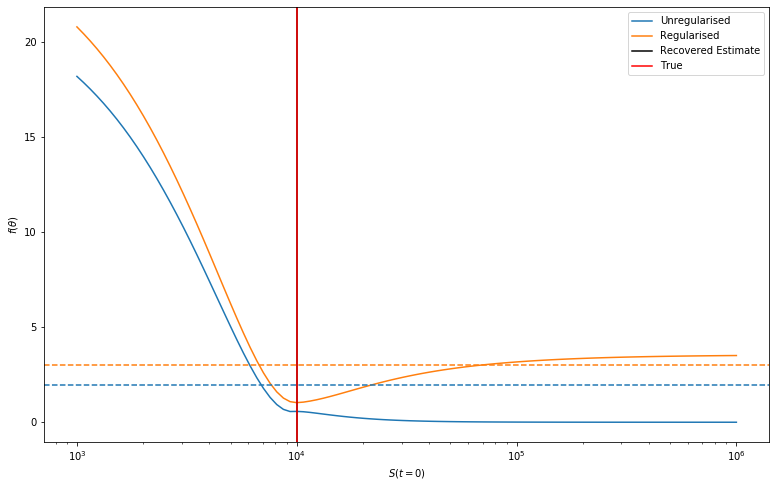

In [37]:
fs_s0 = [float(pf['f']) for pf in profile_s0]
fs_rs0 = [float(pf['f']) for pf in profile_rs0]

plt.plot(pvals_s0.flatten(), fs_s0, label="Unregularised")
plt.plot(pvals_s0.flatten(), fs_rs0, label="Regularised")
plt.axvline(float(getx(solutions[idx]['x'])[0][0]), color='k', label="Recovered Estimate")
plt.axvline(float(9999), color='r', label="True")
plt.xlabel(r"$S(t=0)$")
plt.ylabel(r"$f(\theta)$")
plt.legend()
plt.xscale('log')
plt.yscale('linear')
plt.axhline(min(fs_s0) +conf, linestyle='--', color='#1f77b4')
plt.axhline(min(fs_rs0)+conf, linestyle='--', color='#ff7f0e')

In [56]:
idx = 35
rho = prange[idx]
pvals_2 = np.linspace(-1, 4, 100)
# profile_2 = []
# profile_r2 = []
# profile_rr2 = []
profile_rrr2 = []
for pval in pvals_2:
    lbxp = [-np.inf]*(config['basis_number']*3) + [-np.inf, pval]
    ubxp = [np.inf]*(config['basis_number']*3) + [np.inf, pval]
#     profile_2.append(solver(x0=solutions[idx]['x'], p=[rho, 0], lbx=lbxp, ubx=ubxp, lbg=0))
#     profile_r2.append(solver(x0=solutions[idx]['x'], p=[rho, 1e-2], lbx=lbxp, ubx=ubxp, lbg=0))
#     profile_rr2.append(solver(x0=solutions[idx]['x'], p=[rho, 0.5], lbx=lbxp, ubx=ubxp, lbg=0))
    profile_rrr2.append(solver(x0=solutions[idx]['x'], p=[rho, 1e2], lbx=lbxp, ubx=ubxp, lbg=0))

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:    21600
Number of nonzeros in Lagrangian Hessian.............:    16471

Total number of variables............................:      181
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

   3  6.7381240e+02 0.00e+00 2.51e-01  -1.0 7.69e+02    -  9.26e-01 1.00e+00f  1
   4  5.3637154e+02 0.00e+00 4.47e-01  -1.0 1.72e+03    -  6.24e-01 1.00e+00f  1
   5  4.8776996e+02 0.00e+00 4.61e-01  -1.0 2.51e+03    -  6.66e-01 1.00e+00f  1
   6  4.5184370e+02 0.00e+00 6.98e-02  -1.7 2.78e+03    -  5.67e-01 1.00e+00f  1
   7  4.4340830e+02 0.00e+00 5.65e-02  -1.7 2.73e+03    -  8.93e-01 1.00e+00f  1
   8  4.3728216e+02 0.00e+00 1.17e-01  -2.5 1.65e+03    -  9.05e-01 1.00e+00f  1
   9  4.3605995e+02 0.00e+00 2.62e-02  -2.5 1.63e+04    -  6.11e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.3519615e+02 0.00e+00 4.66e-03  -3.8 1.52e+03    -  9.75e-01 1.00e+00f  1
  11  4.3502858e+02 0.00e+00 2.38e-03  -3.8 3.06e+04    -  8.80e-01 1.00e+00f  1
  12  4.3501092e+02 0.00e+00 2.89e-04  -3.8 3.90e+04    -  8.83e-01 1.00e+00f  1
  13  4.3495466e+02 0.00e+00 5.17e-04  -5.7 7.94e+01    -  9.53e-01 1.00e+00f  1
  14  4.3495163e+02 0.00e+00

   5  4.4780573e+02 0.00e+00 5.05e-01  -1.0 2.49e+03    -  6.67e-01 1.00e+00f  1
   6  4.1355369e+02 0.00e+00 9.80e-02  -1.7 2.76e+03    -  5.68e-01 1.00e+00f  1
   7  4.0565076e+02 0.00e+00 6.27e-02  -1.7 2.71e+03    -  8.94e-01 1.00e+00f  1
   8  3.9983597e+02 0.00e+00 1.22e-01  -2.5 1.68e+03    -  9.00e-01 1.00e+00f  1
   9  3.9867923e+02 0.00e+00 2.93e-02  -2.5 1.56e+04    -  6.37e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.9859580e+02 0.00e+00 3.38e-03  -2.5 2.88e+04    -  6.52e-01 1.00e+00f  1
  11  3.9779662e+02 0.00e+00 1.19e-02  -3.8 1.80e+03    -  1.00e+00 1.00e+00f  1
  12  3.9767593e+02 0.00e+00 2.11e-03  -3.8 4.83e+04    -  1.00e+00 1.00e+00f  1
  13  3.9766437e+02 0.00e+00 2.10e-04  -3.8 4.16e+03    -  1.00e+00 1.00e+00f  1
  14  3.9761082e+02 0.00e+00 5.38e-04  -5.7 5.21e+01    -  9.58e-01 1.00e+00f  1
  15  3.9760832e+02 0.00e+00 9.08e-05  -5.7 3.18e+01    -  1.00e+00 1.00e+00f  1
  16  3.9760784e+02 0.00e+00

   7  3.6993314e+02 0.00e+00 7.04e-02  -1.7 2.69e+03    -  8.94e-01 1.00e+00f  1
   8  3.6443071e+02 0.00e+00 1.27e-01  -2.5 1.72e+03    -  8.94e-01 1.00e+00f  1
   9  3.6334015e+02 0.00e+00 3.32e-02  -2.5 1.48e+04    -  6.69e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.6326018e+02 0.00e+00 4.74e-03  -2.5 2.95e+04    -  6.18e-01 1.00e+00f  1
  11  3.6248886e+02 0.00e+00 1.15e-02  -3.8 1.74e+03    -  1.00e+00 1.00e+00f  1
  12  3.6237122e+02 0.00e+00 2.32e-03  -3.8 4.76e+04    -  1.00e+00 1.00e+00f  1
  13  3.6235989e+02 0.00e+00 2.30e-04  -3.8 3.32e+03    -  1.00e+00 1.00e+00f  1
  14  3.6230821e+02 0.00e+00 5.90e-04  -5.7 5.94e+01    -  9.60e-01 1.00e+00f  1
  15  3.6230575e+02 0.00e+00 9.90e-05  -5.7 3.09e+01    -  1.00e+00 1.00e+00f  1
  16  3.6230530e+02 0.00e+00 1.84e-05  -5.7 8.78e+01    -  1.00e+00 1.00e+00f  1
  17  3.6230464e+02 0.00e+00 1.65e-05  -8.6 1.09e+00    -  9.99e-01 8.63e-01f  1
  18  3.6230452e+02 0.00e+00

   5  3.7370435e+02 0.00e+00 6.20e-01  -1.0 2.48e+03    -  6.72e-01 1.00e+00f  1
   6  3.4301166e+02 0.00e+00 2.02e-01  -1.7 2.70e+03    -  5.75e-01 1.00e+00f  1
   7  3.3625583e+02 0.00e+00 7.99e-02  -1.7 2.68e+03    -  8.95e-01 1.00e+00f  1
   8  3.3106604e+02 0.00e+00 1.31e-01  -2.5 1.76e+03    -  8.87e-01 1.00e+00f  1
   9  3.3004341e+02 0.00e+00 3.82e-02  -2.5 1.39e+04    -  7.14e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.2996643e+02 0.00e+00 7.49e-03  -2.5 3.08e+04    -  5.75e-01 1.00e+00f  1
  11  3.2922116e+02 0.00e+00 9.33e-03  -3.8 1.63e+03    -  1.00e+00 1.00e+00f  1
  12  3.2910717e+02 0.00e+00 2.59e-03  -3.8 4.51e+04    -  1.00e+00 1.00e+00f  1
  13  3.2909600e+02 0.00e+00 2.54e-04  -3.8 1.02e+03    -  1.00e+00 1.00e+00f  1
  14  3.2904622e+02 0.00e+00 6.55e-04  -5.7 6.87e+01    -  9.61e-01 1.00e+00f  1
  15  3.2904380e+02 0.00e+00 1.09e-04  -5.7 1.45e+01    -  1.00e+00 1.00e+00f  1
  16  3.2904336e+02 0.00e+00

   4  3.7292894e+02 0.00e+00 8.15e-01  -1.0 1.66e+03    -  6.21e-01 1.00e+00f  1
   5  3.3965370e+02 0.00e+00 6.63e-01  -1.0 2.42e+03    -  6.82e-01 1.00e+00f  1
   6  3.1077728e+02 0.00e+00 3.06e-01  -1.7 2.64e+03    -  5.79e-01 1.00e+00f  1
   7  3.0462860e+02 0.00e+00 9.30e-02  -1.7 2.68e+03    -  8.95e-01 1.00e+00f  1
   8  2.9974284e+02 0.00e+00 1.33e-01  -2.5 1.81e+03    -  8.78e-01 1.00e+00f  1
   9  2.9879050e+02 0.00e+00 4.44e-02  -2.5 1.26e+04    -  7.81e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.9871742e+02 0.00e+00 1.45e-02  -2.5 3.32e+04    -  5.13e-01 1.00e+00f  1
  11  2.9799232e+02 0.00e+00 1.50e-03  -3.8 1.36e+03    -  1.00e+00 1.00e+00f  1
  12  2.9784800e+02 0.00e+00 4.67e-03  -5.7 1.55e+03    -  8.89e-01 9.61e-01f  1
  13  2.9782618e+02 0.00e+00 9.12e-04  -5.7 4.55e+03    -  1.00e+00 9.75e-01f  1
  14  2.9782274e+02 0.00e+00 2.16e-04  -5.7 4.01e+04    -  1.00e+00 1.00e+00f  1
  15  2.9782210e+02 0.00e+00

   5  3.0820172e+02 0.00e+00 5.61e-01  -1.0 2.10e+03    -  7.16e-01 1.00e+00f  1
   6  2.8079036e+02 0.00e+00 4.70e-01  -1.7 2.47e+03    -  5.75e-01 1.00e+00f  1
   7  2.7508645e+02 0.00e+00 1.18e-01  -1.7 2.73e+03    -  8.97e-01 1.00e+00f  1
   8  2.7046503e+02 0.00e+00 1.28e-01  -2.5 1.79e+03    -  8.68e-01 1.00e+00f  1
   9  2.6958433e+02 0.00e+00 5.00e-02  -2.5 1.06e+04    -  8.64e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.6952183e+02 0.00e+00 3.67e-02  -2.5 3.53e+04    -  4.42e-01 1.00e+00f  1
  11  2.6946385e+02 0.00e+00 2.17e-02  -2.5 2.41e+04    -  1.00e+00 1.00e+00f  1
  12  2.6879346e+02 0.00e+00 2.36e-02  -3.8 1.51e+03    -  1.00e+00 1.00e+00f  1
  13  2.6869985e+02 0.00e+00 3.09e-03  -3.8 2.22e+04    -  1.00e+00 1.00e+00f  1
  14  2.6868966e+02 0.00e+00 2.37e-04  -3.8 2.71e+03    -  1.00e+00 1.00e+00f  1
  15  2.6864426e+02 0.00e+00 8.22e-04  -5.7 1.08e+02    -  9.64e-01 9.96e-01f  1
  16  2.6864171e+02 0.00e+00

   3  3.5902326e+02 0.00e+00 2.86e-01  -1.0 5.38e+02    -  9.29e-01 1.00e+00f  1
   4  3.0081487e+02 0.00e+00 1.05e+00  -1.0 1.61e+03    -  5.28e-01 1.00e+00f  1
   5  2.7793276e+02 0.00e+00 4.98e-01  -1.0 1.89e+03    -  7.43e-01 1.00e+00f  1
   6  2.5261036e+02 0.00e+00 7.28e-01  -1.7 2.34e+03    -  5.83e-01 1.00e+00f  1
   7  2.4759263e+02 0.00e+00 1.33e-01  -1.7 2.76e+03    -  8.99e-01 1.00e+00f  1
   8  2.4322702e+02 0.00e+00 1.02e-01  -2.5 1.82e+03    -  8.51e-01 1.00e+00f  1
   9  2.4243319e+02 0.00e+00 5.15e-02  -2.5 8.35e+03    -  9.02e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.4237001e+02 0.00e+00 8.35e-02  -2.5 2.91e+04    -  4.68e-01 1.00e+00f  1
  11  2.4228814e+02 0.00e+00 4.83e-02  -2.5 2.27e+04    -  1.00e+00 1.00e+00f  1
  12  2.4227961e+02 0.00e+00 4.45e-03  -2.5 2.59e+04    -  1.00e+00 1.00e+00f  1
  13  2.4165421e+02 0.00e+00 3.17e-02  -3.8 8.88e+02    -  1.00e+00 1.00e+00f  1
  14  2.4155881e+02 0.00e+00

   4  2.6660001e+02 0.00e+00 9.31e-01  -1.0 1.55e+03    -  4.95e-01 1.00e+00f  1
   5  2.4849807e+02 0.00e+00 4.35e-01  -1.0 1.75e+03    -  6.46e-01 1.00e+00f  1
   6  2.2795931e+02 0.00e+00 4.20e-01  -1.7 1.55e+03    -  7.15e-01 1.00e+00f  1
   7  2.2209612e+02 0.00e+00 5.63e-01  -1.7 3.08e+03    -  8.88e-01 1.00e+00f  1
   8  2.2143490e+02 0.00e+00 7.07e-01  -1.7 6.93e+03    -  6.91e-01 1.00e+00f  1
   9  2.2154703e+02 0.00e+00 1.12e+00  -1.7 1.38e+04    -  8.73e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.2158065e+02 0.00e+00 1.22e+00  -1.7 2.13e+04    -  7.82e-01 1.00e+00f  1
  11  2.2114175e+02 0.00e+00 8.42e-01  -1.7 2.12e+04    -  1.00e+00 1.00e+00f  1
  12  2.2098494e+02 0.00e+00 2.21e-01  -1.7 2.07e+04    -  1.00e+00 1.00e+00f  1
  13  2.2095091e+02 0.00e+00 1.75e-02  -1.7 6.59e+03    -  1.00e+00 1.00e+00f  1
  14  2.1746526e+02 0.00e+00 3.68e-01  -3.8 1.81e+03    -  9.84e-01 1.00e+00f  1
  15  2.1665520e+02 0.00e+00

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:    21600
Number of nonzeros in Lagrangian Hessian.............:    16471

Total number of variables............................:      181
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.8171422e+02 0.00e+00 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.

   2  2.1239478e+02 0.00e+00 3.59e-02  -1.0 2.05e+02    -  6.99e-01 1.00e+00f  1
   3  2.0592223e+02 0.00e+00 1.08e-01  -1.0 3.74e+02    -  8.97e-01 1.00e+00f  1
   4  1.9272350e+02 0.00e+00 1.47e+00  -1.0 1.11e+03    -  7.24e-01 1.00e+00f  1
   5  1.8810810e+02 0.00e+00 1.76e+00  -1.0 1.83e+03    -  3.41e-01 1.00e+00f  1
   6  1.8100450e+02 0.00e+00 1.11e+01  -1.0 5.99e+03    -  3.28e-01 7.79e-01f  1
   7  1.8114166e+02 0.00e+00 1.39e+01  -1.0 5.61e+03    -  8.02e-01 1.00e+00f  1
   8  1.8041865e+02 0.00e+00 1.32e-03  -1.0 3.01e+00  -4.0 1.00e+00 1.00e+00f  1
   9  1.7436614e+02 0.00e+00 9.51e+00  -2.5 1.00e+04    -  3.56e-01 1.83e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.6596206e+02 0.00e+00 1.86e+01  -2.5 5.54e+03    -  6.73e-01 1.00e+00f  1
  11  1.6506559e+02 0.00e+00 9.74e-04  -2.5 6.69e+00  -4.5 1.00e+00 1.00e+00f  1
  12  1.6497998e+02 0.00e+00 8.33e-04  -3.8 7.95e+00  -5.0 1.00e+00 1.00e+00f  1
  13  1.6484018e+02 0.00e+00

   2  1.8725827e+02 0.00e+00 3.51e-02  -1.0 2.00e+02    -  7.00e-01 1.00e+00f  1
   3  1.8121840e+02 0.00e+00 6.20e-02  -1.0 3.53e+02    -  8.86e-01 1.00e+00f  1
   4  1.6816796e+02 0.00e+00 1.97e+00  -1.0 9.28e+02    -  6.38e-01 1.00e+00f  1
   5  1.6044049e+02 0.00e+00 1.21e+00  -1.0 2.24e+03    -  5.01e-01 1.00e+00f  1
   6  1.3963010e+02 0.00e+00 2.36e+01  -1.0 6.79e+03    -  2.37e-01 6.06e-01f  1
   7  1.3651647e+02 0.00e+00 2.16e+01  -1.0 3.93e+03    -  7.87e-01 1.00e+00f  1
   8  1.3546213e+02 0.00e+00 2.49e-03  -1.0 2.33e+00  -4.0 1.00e+00 1.00e+00f  1
   9  1.2542781e+02 0.00e+00 2.25e+01  -2.5 5.82e+03    -  5.63e-01 5.38e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.1839368e+02 0.00e+00 3.55e+01  -2.5 6.06e+03    -  3.26e-01 1.00e+00f  1
  11  1.1635871e+02 0.00e+00 7.97e-03  -2.5 5.50e+00  -4.5 1.00e+00 1.00e+00f  1
  12  1.1595973e+02 0.00e+00 3.24e+01  -3.8 5.92e+03    -  5.79e-01 5.91e-01f  1
  13  1.1166614e+02 0.00e+00

   3  1.3492925e+02 0.00e+00 2.33e-02  -1.0 3.06e+02    -  8.63e-01 1.00e+00f  1
   4  1.1521709e+02 0.00e+00 1.31e+00  -1.0 1.24e+03    -  5.64e-01 1.00e+00f  1
   5  9.8463176e+01 0.00e+00 1.16e+01  -1.0 2.30e+03    -  5.02e-01 1.00e+00f  1
   6  9.3451047e+01 0.00e+00 1.08e+00  -1.0 2.49e+03    -  8.80e-01 1.00e+00f  1
   7  9.8176410e+01 0.00e+00 5.08e+00  -1.0 3.84e+03    -  1.00e+00 1.00e+00f  1
   8  9.9363723e+01 0.00e+00 3.41e-01  -1.0 3.00e+02    -  1.00e+00 1.00e+00f  1
   9  9.0512555e+01 0.00e+00 2.66e+01  -1.7 4.91e+03    -  1.00e+00 6.36e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  8.2652653e+01 0.00e+00 1.75e+00  -1.7 3.75e+02    -  5.04e-01 1.00e+00f  1
  11  8.2584833e+01 0.00e+00 1.19e-01  -1.7 5.18e+02    -  1.00e+00 1.00e+00f  1
  12  8.1154780e+01 0.00e+00 3.78e-01  -2.5 6.91e+02    -  1.00e+00 1.00e+00f  1
  13  8.0917667e+01 0.00e+00 1.75e-02  -2.5 8.36e+01    -  1.00e+00 1.00e+00f  1
  14  8.0718595e+01 0.00e+00

   5  6.6947625e+01 0.00e+00 4.47e+00  -1.0 1.64e+03    -  7.60e-01 1.00e+00f  1
   6  7.2020097e+01 0.00e+00 1.24e+00  -1.0 2.93e+03    -  9.76e-01 1.00e+00f  1
   7  7.8322564e+01 0.00e+00 1.20e+01  -1.0 2.53e+03    -  1.00e+00 1.00e+00f  1
   8  8.0873571e+01 0.00e+00 1.13e+00  -1.0 8.80e+02    -  1.00e+00 1.00e+00f  1
   9  8.4871258e+01 0.00e+00 3.47e+00  -1.0 1.33e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  8.7244528e+01 0.00e+00 8.00e-01  -1.0 7.38e+02    -  1.00e+00 1.00e+00f  1
  11  7.6848914e+01 0.00e+00 1.36e+01  -1.7 2.39e+04    -  6.97e-01 1.21e-01f  2
  12  6.7326729e+01 0.00e+00 1.05e+01  -1.7 2.69e+03    -  1.00e+00 1.00e+00f  1
  13  6.3135813e+01 0.00e+00 4.77e+00  -1.7 1.36e+03    -  1.00e+00 1.00e+00f  1
  14  6.2811892e+01 0.00e+00 1.44e-01  -1.7 2.01e+02    -  1.00e+00 1.00e+00f  1
  15  6.1475026e+01 0.00e+00 7.44e-01  -2.5 9.12e+02    -  1.00e+00 1.00e+00f  1
  16  6.1338600e+01 0.00e+00

   3  6.5166863e+01 0.00e+00 1.67e-01  -1.0 2.40e+02    -  8.24e-01 1.00e+00f  1
   4  4.9803694e+01 0.00e+00 8.91e-01  -1.0 8.09e+02    -  7.17e-01 1.00e+00f  1
   5  5.0271330e+01 0.00e+00 8.75e-01  -1.0 1.93e+03    -  8.85e-01 1.00e+00f  1
   6  4.7911452e+01 0.00e+00 8.63e-02  -1.7 9.13e+02    -  9.99e-01 1.00e+00f  1
   7  4.6469911e+01 0.00e+00 7.28e-01  -2.5 1.15e+03    -  1.00e+00 1.00e+00f  1
   8  4.6351115e+01 0.00e+00 7.56e-03  -2.5 9.16e+01    -  1.00e+00 1.00e+00f  1
   9  4.6291840e+01 0.00e+00 1.53e-02  -3.8 2.36e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.6289264e+01 0.00e+00 2.57e-04  -3.8 1.73e+01    -  1.00e+00 1.00e+00f  1
  11  4.6288658e+01 0.00e+00 6.39e-05  -5.7 1.50e+01    -  9.55e-01 1.00e+00f  1
  12  4.6288575e+01 0.00e+00 3.94e-08  -5.7 3.73e-01    -  1.00e+00 1.00e+00f  1
  13  4.6288554e+01 0.00e+00 1.84e-11  -5.7 4.00e-02    -  1.00e+00 1.00e+00h  1
  14  4.6288548e+01 0.00e+00

   4  3.6043342e+01 0.00e+00 1.05e+00  -1.0 6.42e+02    -  8.52e-01 1.00e+00f  1
   5  3.9146843e+01 0.00e+00 7.14e-01  -1.0 2.69e+03    -  8.89e-01 1.00e+00f  1
   6  3.5679247e+01 0.00e+00 8.31e-01  -1.7 1.16e+03    -  1.00e+00 1.00e+00f  1
   7  3.5471194e+01 0.00e+00 1.34e-01  -1.7 4.26e+02    -  1.00e+00 1.00e+00f  1
   8  3.4315523e+01 0.00e+00 1.44e+00  -2.5 1.73e+03    -  1.00e+00 1.00e+00f  1
   9  3.4251245e+01 0.00e+00 5.47e-04  -2.5 1.09e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.4209739e+01 0.00e+00 1.82e-02  -3.8 2.83e+02    -  1.00e+00 1.00e+00f  1
  11  3.4207947e+01 0.00e+00 2.36e-04  -3.8 1.66e+01    -  1.00e+00 1.00e+00f  1
  12  3.4207462e+01 0.00e+00 4.99e-05  -5.7 1.90e+01    -  9.63e-01 1.00e+00f  1
  13  3.4207396e+01 0.00e+00 6.66e-08  -5.7 2.93e-01    -  1.00e+00 1.00e+00f  1
  14  3.4207379e+01 0.00e+00 1.84e-11  -5.7 2.46e-02    -  1.00e+00 1.00e+00h  1
  15  3.4207374e+01 0.00e+00

   5  2.6090721e+01 0.00e+00 2.24e-01  -1.7 7.58e+02    -  7.99e-01 1.00e+00f  1
   6  2.5075247e+01 0.00e+00 1.14e+00  -1.7 1.91e+03    -  8.82e-01 1.00e+00f  1
   7  2.5248857e+01 0.00e+00 1.21e+00  -1.7 1.62e+03    -  1.00e+00 1.00e+00f  1
   8  2.5615968e+01 0.00e+00 3.60e-01  -1.7 8.73e+02    -  1.00e+00 1.00e+00f  1
   9  2.5767496e+01 0.00e+00 3.63e-02  -1.7 2.89e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.4644393e+01 0.00e+00 2.75e+00  -2.5 2.84e+03    -  1.00e+00 1.00e+00f  1
  11  2.4529008e+01 0.00e+00 9.35e-03  -2.5 3.34e+02    -  1.00e+00 1.00e+00f  1
  12  2.4497097e+01 0.00e+00 5.79e-03  -3.8 2.83e+02    -  1.00e+00 1.00e+00f  1
  13  2.4495212e+01 0.00e+00 3.26e-04  -3.8 2.15e+01    -  1.00e+00 1.00e+00f  1
  14  2.4494740e+01 0.00e+00 4.92e-05  -5.7 2.52e+01    -  9.67e-01 1.00e+00f  1
  15  2.4494679e+01 0.00e+00 1.54e-07  -5.7 3.05e-01    -  1.00e+00 1.00e+00f  1
  16  2.4494663e+01 0.00e+00

   4  2.3826956e+01 0.00e+00 4.91e-01  -1.0 6.06e+02    -  8.17e-01 1.00e+00f  1
   5  2.2522448e+01 0.00e+00 5.01e-01  -1.0 1.84e+03    -  7.98e-01 1.00e+00f  1
   6  1.8293293e+01 0.00e+00 9.61e-01  -1.7 1.75e+03    -  8.31e-01 1.00e+00f  1
   7  1.7583878e+01 0.00e+00 1.73e+00  -1.7 2.46e+03    -  1.00e+00 1.00e+00f  1
   8  1.7823556e+01 0.00e+00 9.33e-01  -1.7 1.83e+03    -  1.00e+00 1.00e+00f  1
   9  1.8179406e+01 0.00e+00 3.88e-01  -1.7 1.28e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.8340610e+01 0.00e+00 5.41e-02  -1.7 5.11e+02    -  1.00e+00 1.00e+00f  1
  11  1.7476483e+01 0.00e+00 6.09e+00  -2.5 5.58e+03    -  1.00e+00 1.00e+00f  1
  12  1.6996049e+01 0.00e+00 3.63e-02  -2.5 8.46e+02    -  1.00e+00 1.00e+00f  1
  13  1.6992821e+01 0.00e+00 1.24e-01  -2.5 6.03e+02    -  1.00e+00 1.00e+00f  1
  14  1.6998716e+01 0.00e+00 2.52e-03  -2.5 9.71e+01    -  1.00e+00 1.00e+00f  1
  15  1.6959157e+01 0.00e+00

   3  2.7541406e+01 0.00e+00 1.02e-01  -1.0 3.08e+02    -  8.24e-01 1.00e+00f  1
   4  2.2013658e+01 0.00e+00 1.48e-01  -1.0 7.37e+02    -  7.81e-01 1.00e+00f  1
   5  1.8853341e+01 0.00e+00 2.66e-01  -1.0 1.71e+03    -  7.44e-01 1.00e+00f  1
   6  1.3838852e+01 0.00e+00 6.15e-01  -1.7 1.72e+03    -  8.04e-01 1.00e+00f  1
   7  1.2232395e+01 0.00e+00 1.98e+00  -1.7 3.34e+03    -  1.00e+00 1.00e+00f  1
   8  1.2072038e+01 0.00e+00 1.74e+00  -1.7 3.14e+03    -  1.00e+00 1.00e+00f  1
   9  1.2388627e+01 0.00e+00 1.31e+00  -1.7 3.14e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.2787014e+01 0.00e+00 7.34e-01  -1.7 2.77e+03    -  1.00e+00 1.00e+00f  1
  11  1.3097410e+01 0.00e+00 3.12e-01  -1.7 2.05e+03    -  1.00e+00 1.00e+00f  1
  12  1.3239860e+01 0.00e+00 5.63e-02  -1.7 9.48e+02    -  1.00e+00 1.00e+00f  1
  13  1.2016784e+01 0.00e+00 5.98e+00  -2.5 1.95e+04    -  1.00e+00 4.61e-01f  2
  14  1.1573674e+01 0.00e+00

   8  8.6832382e+00 0.00e+00 2.26e+00  -1.7 4.43e+03    -  1.00e+00 1.00e+00f  1
   9  8.6618009e+00 0.00e+00 2.03e+00  -1.7 5.06e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  8.9482133e+00 0.00e+00 1.71e+00  -1.7 6.00e+03    -  1.00e+00 1.00e+00f  1
  11  9.3569221e+00 0.00e+00 1.53e+00  -1.7 7.42e+03    -  1.00e+00 1.00e+00f  1
  12  9.7593288e+00 0.00e+00 1.12e+00  -1.7 8.43e+03    -  1.00e+00 1.00e+00f  1
  13  1.0076170e+01 0.00e+00 6.29e-01  -1.7 8.19e+03    -  1.00e+00 1.00e+00f  1
  14  1.0223590e+01 0.00e+00 1.29e-01  -1.7 4.51e+03    -  1.00e+00 1.00e+00f  1
  15  9.0584071e+00 0.00e+00 5.26e+00  -2.5 5.46e+04    -  1.00e+00 4.54e-01f  2
  16  8.2544890e+00 0.00e+00 3.70e+00  -2.5 1.08e+04    -  1.00e+00 1.00e+00f  1
  17  8.1684888e+00 0.00e+00 3.50e-02  -2.5 5.77e+02    -  1.00e+00 1.00e+00f  1
  18  8.1622547e+00 0.00e+00 2.91e-03  -2.5 2.16e+02    -  1.00e+00 1.00e+00f  1
  19  8.1157409e+00 0.00e+00

   6  1.1786530e+01 0.00e+00 1.65e-01  -1.7 2.26e+03    -  7.63e-01 1.00e+00f  1
   7  8.9900574e+00 0.00e+00 8.38e-01  -2.5 3.05e+03    -  7.24e-01 1.00e+00f  1
   8  7.5971894e+00 0.00e+00 1.38e+00  -2.5 4.20e+03    -  9.01e-01 1.00e+00f  1
   9  7.0179999e+00 0.00e+00 1.22e+00  -2.5 4.42e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.8179082e+00 0.00e+00 8.81e-01  -2.5 4.55e+03    -  1.00e+00 1.00e+00f  1
  11  6.7808994e+00 0.00e+00 5.13e-01  -2.5 4.19e+03    -  1.00e+00 1.00e+00f  1
  12  6.7951361e+00 0.00e+00 2.04e-01  -2.5 3.07e+03    -  1.00e+00 1.00e+00f  1
  13  6.8081115e+00 0.00e+00 3.41e-02  -2.5 1.38e+03    -  1.00e+00 1.00e+00f  1
  14  6.8105924e+00 0.00e+00 8.93e-04  -2.5 2.32e+02    -  1.00e+00 1.00e+00f  1
  15  6.7583230e+00 0.00e+00 6.22e-01  -3.8 5.86e+03    -  1.00e+00 1.00e+00f  1
  16  6.7529837e+00 0.00e+00 1.30e-02  -3.8 7.88e+02    -  1.00e+00 1.00e+00f  1
  17  6.7527699e+00 0.00e+00

   5  2.0313528e+01 0.00e+00 8.87e-02  -1.0 1.89e+03    -  6.51e-01 1.00e+00f  1
   6  1.4051659e+01 0.00e+00 3.07e-02  -1.7 2.47e+03    -  7.49e-01 1.00e+00f  1
   7  1.0960633e+01 0.00e+00 6.77e-01  -2.5 3.28e+03    -  7.10e-01 1.00e+00f  1
   8  9.1146882e+00 0.00e+00 1.41e+00  -2.5 5.11e+03    -  8.27e-01 1.00e+00f  1
   9  8.1901134e+00 0.00e+00 1.48e+00  -2.5 5.86e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  7.7403969e+00 0.00e+00 1.29e+00  -2.5 7.02e+03    -  1.00e+00 1.00e+00f  1
  11  7.5392856e+00 0.00e+00 1.05e+00  -2.5 8.33e+03    -  1.00e+00 1.00e+00f  1
  12  7.4645417e+00 0.00e+00 7.88e-01  -2.5 9.57e+03    -  1.00e+00 1.00e+00f  1
  13  7.4503543e+00 0.00e+00 5.12e-01  -2.5 1.01e+04    -  1.00e+00 1.00e+00f  1
  14  7.4583708e+00 0.00e+00 2.50e-01  -2.5 8.87e+03    -  1.00e+00 1.00e+00f  1
  15  7.4669229e+00 0.00e+00 6.23e-02  -2.5 5.20e+03    -  1.00e+00 1.00e+00f  1
  16  7.4693867e+00 0.00e+00

   6  1.8320935e+01 0.00e+00 1.80e-01  -1.7 2.62e+03    -  7.38e-01 1.00e+00f  1
   7  1.5117170e+01 0.00e+00 4.96e-01  -2.5 3.33e+03    -  7.05e-01 1.00e+00f  1
   8  1.2899947e+01 0.00e+00 1.31e+00  -2.5 5.81e+03    -  7.74e-01 1.00e+00f  1
   9  1.1674741e+01 0.00e+00 1.54e+00  -2.5 7.00e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.0986388e+01 0.00e+00 1.46e+00  -2.5 9.02e+03    -  1.00e+00 1.00e+00f  1
  11  1.0601422e+01 0.00e+00 1.29e+00  -2.5 1.18e+04    -  1.00e+00 1.00e+00f  1
  12  1.0387797e+01 0.00e+00 1.08e+00  -2.5 1.56e+04    -  1.00e+00 1.00e+00f  1
  13  1.0273801e+01 0.00e+00 8.12e-01  -2.5 1.97e+04    -  1.00e+00 1.00e+00f  1
  14  1.0216660e+01 0.00e+00 4.95e-01  -2.5 2.20e+04    -  1.00e+00 1.00e+00f  1
  15  1.0192339e+01 0.00e+00 1.79e-01  -2.5 1.78e+04    -  1.00e+00 1.00e+00f  1
  16  1.0185535e+01 0.00e+00 2.06e-02  -2.5 7.24e+03    -  1.00e+00 1.00e+00f  1
  17  1.0153331e+01 0.00e+00

  38  1.2265635e+01 0.00e+00 1.68e-03  -8.6 1.00e+07    -  1.00e+00 1.00e+00h  1
  39  1.2265596e+01 0.00e+00 4.15e-04  -8.6 6.99e+06    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  1.2265579e+01 0.00e+00 9.25e-05  -8.6 3.97e+06    -  1.00e+00 1.00e+00h  1
  41  1.2265568e+01 0.00e+00 3.51e-05  -8.6 2.71e+06    -  1.00e+00 1.00e+00h  1
  42  1.2265557e+01 0.00e+00 3.84e-05  -8.6 3.05e+06    -  1.00e+00 1.00e+00h  1
  43  1.2265557e+01 0.00e+00 3.45e-10  -8.6 3.45e-06  -4.0 1.00e+00 1.00e+00h  1

Number of Iterations....: 43

                                   (scaled)                 (unscaled)
Objective...............:   1.0781364904341707e+01    1.2265557035225960e+01
Dual infeasibility......:   3.4472224221312346e-10    3.9217764732861634e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800622e-09    2.8508730859906159e-09
Overall NLP error......

   3  6.1515312e+01 0.00e+00 1.13e+00  -1.0 6.47e+02    -  7.76e-01 1.00e+00f  1
   4  4.2804929e+01 0.00e+00 8.03e-01  -1.0 1.20e+03    -  6.55e-01 1.00e+00f  1
   5  3.4402229e+01 0.00e+00 6.45e-02  -1.0 1.86e+03    -  6.03e-01 1.00e+00f  1
   6  2.8173997e+01 0.00e+00 2.94e-01  -1.7 2.77e+03    -  7.25e-01 1.00e+00f  1
   7  2.4847688e+01 0.00e+00 3.65e-01  -1.7 4.22e+03    -  7.33e-01 1.00e+00f  1
   8  2.2367517e+01 0.00e+00 1.69e+00  -1.7 8.04e+03    -  1.00e+00 1.00e+00f  1
   9  2.0900839e+01 0.00e+00 1.99e+00  -1.7 1.04e+04    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.0045492e+01 0.00e+00 1.83e+00  -1.7 1.48e+04    -  1.00e+00 1.00e+00f  1
  11  1.9522484e+01 0.00e+00 1.66e+00  -1.7 2.23e+04    -  1.00e+00 1.00e+00f  1
  12  1.9247731e+01 0.00e+00 8.46e-01  -1.7 2.58e+04    -  1.00e+00 1.00e+00f  1
  13  1.9122778e+01 0.00e+00 2.75e-01  -1.7 2.16e+04    -  1.00e+00 1.00e+00f  1
  14  1.9094893e+01 0.00e+00

  26  2.2354438e+01 0.00e+00 2.31e-02  -5.7 9.45e+05    -  1.00e+00 1.00e+00f  1
  27  2.2351624e+01 0.00e+00 8.26e-03  -5.7 8.49e+05    -  1.00e+00 1.00e+00f  1
  28  2.2350579e+01 0.00e+00 1.25e-03  -5.7 4.27e+05    -  1.00e+00 1.00e+00h  1
  29  2.2350421e+01 0.00e+00 2.89e-05  -5.7 7.15e+04    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  2.2350418e+01 0.00e+00 1.40e-08  -5.7 1.59e+03    -  1.00e+00 1.00e+00h  1
  31  2.2346860e+01 0.00e+00 2.21e-02  -8.6 2.45e+06    -  6.70e-01 1.00e+00f  1
  32  2.2344467e+01 0.00e+00 1.50e-02  -8.6 3.69e+06    -  1.00e+00 1.00e+00f  1
  33  2.2342874e+01 0.00e+00 9.98e-03  -8.6 5.50e+06    -  1.00e+00 1.00e+00f  1
  34  2.2341813e+01 0.00e+00 6.63e-03  -8.6 8.18e+06    -  1.00e+00 1.00e+00f  1
  35  2.2341111e+01 0.00e+00 4.30e-03  -8.6 1.20e+07    -  1.00e+00 1.00e+00f  1
  36  2.2340650e+01 0.00e+00 2.73e-03  -8.6 1.71e+07    -  1.00e+00 1.00e+00h  1
  37  2.2340367e+01 0.00e+00

   5  4.9012978e+01 0.00e+00 6.19e-02  -1.0 1.83e+03    -  5.98e-01 1.00e+00f  1
   6  4.2478669e+01 0.00e+00 3.24e-01  -1.7 2.86e+03    -  7.20e-01 1.00e+00f  1
   7  3.9334253e+01 0.00e+00 9.33e-02  -1.7 3.88e+03    -  7.31e-01 1.00e+00f  1
   8  3.6799295e+01 0.00e+00 7.33e-01  -2.5 6.25e+03    -  6.73e-01 1.00e+00f  1
   9  3.5091515e+01 0.00e+00 1.09e+00  -2.5 9.26e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.4027419e+01 0.00e+00 1.09e+00  -2.5 1.25e+04    -  1.00e+00 1.00e+00f  1
  11  3.3319121e+01 0.00e+00 1.07e+00  -2.5 1.87e+04    -  1.00e+00 1.00e+00f  1
  12  3.2872531e+01 0.00e+00 8.10e-01  -2.5 2.57e+04    -  1.00e+00 1.00e+00f  1
  13  3.2579522e+01 0.00e+00 6.22e-01  -2.5 3.62e+04    -  1.00e+00 1.00e+00f  1
  14  3.2411245e+01 0.00e+00 3.15e-01  -2.5 4.08e+04    -  1.00e+00 1.00e+00f  1
  15  3.2326110e+01 0.00e+00 1.08e-01  -2.5 3.43e+04    -  1.00e+00 1.00e+00f  1
  16  3.2301376e+01 0.00e+00

  34  3.7531731e+01 0.00e+00 3.97e-03  -8.6 9.92e+06    -  1.00e+00 1.00e+00f  1
  35  3.7530881e+01 0.00e+00 2.57e-03  -8.6 1.45e+07    -  1.00e+00 1.00e+00f  1
  36  3.7530328e+01 0.00e+00 1.58e-03  -8.6 2.04e+07    -  1.00e+00 1.00e+00h  1
  37  3.7530016e+01 0.00e+00 6.85e-04  -8.6 2.27e+07    -  1.00e+00 1.00e+00h  1
  38  3.7529845e+01 0.00e+00 2.51e-04  -8.6 2.07e+07    -  1.00e+00 1.00e+00h  1
  39  3.7529729e+01 0.00e+00 1.40e-04  -8.6 2.08e+07    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  3.7529681e+01 0.00e+00 2.60e-05  -8.6 1.12e+07    -  1.00e+00 1.00e+00h  1
  41  3.7529668e+01 0.00e+00 1.78e-06  -8.6 3.21e+06    -  1.00e+00 1.00e+00h  1
  42  3.7529619e+01 0.00e+00 3.11e-05  -8.6 1.44e+07    -  1.00e+00 1.00e+00h  1
  43  3.7529617e+01 0.00e+00 2.29e-08  -8.6 4.33e+05    -  1.00e+00 1.00e+00h  1
  44  3.7529613e+01 0.00e+00 2.03e-07  -8.6 1.29e+06    -  1.00e+00 1.00e+00h  1
  45  3.7529611e+01 0.00e+00

   8  5.6353700e+01 0.00e+00 1.39e+00  -1.0 1.35e+04    -  9.64e-01 1.00e+00f  1
   9  5.4951972e+01 0.00e+00 1.71e+00  -1.0 2.04e+04    -  8.13e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.4102382e+01 0.00e+00 1.02e+00  -1.0 2.76e+04    -  1.00e+00 1.00e+00f  1
  11  5.3743605e+01 0.00e+00 3.20e-01  -1.0 2.50e+04    -  1.00e+00 1.00e+00f  1
  12  5.1784717e+01 0.00e+00 1.73e-01  -1.7 7.02e+03    -  1.00e+00 1.00e+00f  1
  13  5.1113323e+01 0.00e+00 1.85e-01  -2.5 2.47e+04    -  9.37e-01 1.00e+00f  1
  14  5.0845768e+01 0.00e+00 2.65e-01  -2.5 5.21e+04    -  1.00e+00 1.00e+00f  1
  15  5.0772661e+01 0.00e+00 2.95e-02  -2.5 2.54e+04    -  1.00e+00 1.00e+00f  1
  16  5.0754057e+01 0.00e+00 2.80e-03  -2.5 9.05e+03    -  1.00e+00 1.00e+00f  1
  17  5.0632453e+01 0.00e+00 1.31e-01  -3.8 7.26e+04    -  7.80e-01 1.00e+00f  1
  18  5.0537210e+01 0.00e+00 1.60e-01  -3.8 1.28e+05    -  1.00e+00 1.00e+00f  1
  19  5.0483134e+01 0.00e+00

  35  5.7500852e+01 0.00e+00 6.29e-04  -8.6 2.88e+07    -  1.00e+00 1.00e+00h  1
  36  5.7500852e+01 0.00e+00 6.35e-09  -8.6 6.35e-05  -4.0 1.00e+00 1.00e+00h  1

Number of Iterations....: 36

                                   (scaled)                 (unscaled)
Objective...............:   5.7500851983235187e+01    5.7500851983235187e+01
Dual infeasibility......:   6.3472152430411748e-09    6.3472152430411748e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596803401e-09    2.5059035596803401e-09
Overall NLP error.......:   6.3472152430411748e-09    6.3472152430411748e-09


Number of objective function evaluations             = 37
Number of objective gradient evaluations             = 37
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 37
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 37
Num

   5  9.1294429e+01 0.00e+00 3.45e-01  -1.0 1.76e+03    -  6.01e-01 1.00e+00f  1
   6  8.5080845e+01 0.00e+00 1.77e+00  -1.0 4.71e+03    -  8.06e-01 1.00e+00f  1
   7  8.1651669e+01 0.00e+00 1.15e+00  -1.0 8.38e+03    -  7.15e-01 1.00e+00f  1
   8  7.9487573e+01 0.00e+00 8.27e-01  -1.0 1.37e+04    -  9.35e-01 1.00e+00f  1
   9  7.6520264e+01 0.00e+00 5.10e-01  -1.7 8.29e+03    -  8.26e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  7.5341811e+01 0.00e+00 7.75e-01  -1.7 2.27e+04    -  1.00e+00 1.00e+00f  1
  11  7.4785519e+01 0.00e+00 4.24e-01  -1.7 2.83e+04    -  1.00e+00 1.00e+00f  1
  12  7.4512040e+01 0.00e+00 1.83e-01  -1.7 2.90e+04    -  1.00e+00 1.00e+00f  1
  13  7.4123252e+01 0.00e+00 8.93e-02  -2.5 2.19e+04    -  9.31e-01 1.00e+00f  1
  14  7.3899131e+01 0.00e+00 1.71e-01  -2.5 5.30e+04    -  1.00e+00 1.00e+00f  1
  15  7.3836455e+01 0.00e+00 1.80e-02  -2.5 2.48e+04    -  1.00e+00 1.00e+00f  1
  16  7.3701783e+01 0.00e+00

Total CPU secs in NLP function evaluations           =      1.505

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   4.39ms (115.42us)   4.32ms (113.81us)        38
       nlp_g  |   1.32ms ( 34.71us)   1.31ms ( 34.49us)        38
    nlp_grad  | 368.00us (368.00us) 368.02us (368.02us)         1
  nlp_grad_f  |  12.62ms (323.62us)  12.48ms (319.98us)        39
  nlp_hess_l  |   1.48 s ( 39.94ms)   1.48 s ( 39.95ms)        37
   nlp_jac_g  |   7.06ms (180.95us)   7.04ms (180.45us)        39
       total  |   1.72 s (  1.72 s)   1.71 s (  1.71 s)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:    21600
Number of nonzeros in Lagrangian Hessian.............:    16471

Total number of variables..............

  14  1.0147532e+02 0.00e+00 1.27e-01  -2.5 5.31e+04    -  1.00e+00 1.00e+00f  1
  15  1.0140815e+02 0.00e+00 1.47e-02  -2.5 2.62e+04    -  1.00e+00 1.00e+00f  1
  16  1.0127112e+02 0.00e+00 7.53e-02  -3.8 7.54e+04    -  7.71e-01 1.00e+00f  1
  17  1.0116637e+02 0.00e+00 8.53e-02  -3.8 1.30e+05    -  1.00e+00 1.00e+00f  1
  18  1.0110638e+02 0.00e+00 4.03e-02  -3.8 1.48e+05    -  1.00e+00 1.00e+00f  1
  19  1.0107383e+02 0.00e+00 1.53e-02  -3.8 1.36e+05    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.0106249e+02 0.00e+00 2.05e-03  -3.8 6.43e+04    -  1.00e+00 1.00e+00f  1
  21  1.0106088e+02 0.00e+00 4.25e-05  -3.8 1.01e+04    -  1.00e+00 1.00e+00h  1
  22  1.0102153e+02 0.00e+00 3.61e-02  -5.7 3.60e+05    -  6.89e-01 1.00e+00f  1
  23  1.0099388e+02 0.00e+00 2.73e-02  -5.7 5.55e+05    -  1.00e+00 1.00e+00f  1
  24  1.0097576e+02 0.00e+00 1.74e-02  -5.7 7.93e+05    -  1.00e+00 1.00e+00f  1
  25  1.0096408e+02 0.00e+00

  39  1.1111947e+02 0.00e+00 3.49e-10  -8.6 3.49e-06  -4.0 1.00e+00 1.00e+00h  1

Number of Iterations....: 39

                                   (scaled)                 (unscaled)
Objective...............:   1.1111946680208982e+02    1.1111946680208982e+02
Dual infeasibility......:   3.4947369808371128e-10    3.4947369808371128e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800626e-09    2.5059035596800626e-09
Overall NLP error.......:   2.5059035596800626e-09    2.5059035596800626e-09


Number of objective function evaluations             = 40
Number of objective gradient evaluations             = 40
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 40
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 40
Number of Lagrangian Hessian evaluations             = 39
Total CPU secs in IPOPT (w

   1  7.2927578e+02 0.00e+00 1.63e-01  -1.0 7.80e+01    -  9.87e-01 1.00e+00f  1
   2  3.5367740e+02 0.00e+00 1.04e+00  -1.0 9.36e+02    -  7.95e-01 1.00e+00f  1
   3  2.1366738e+02 0.00e+00 1.06e+00  -1.0 8.44e+02    -  7.66e-01 1.00e+00f  1
   4  1.6640580e+02 0.00e+00 1.81e+00  -1.0 1.23e+03    -  6.38e-01 1.00e+00f  1
   5  1.5097512e+02 0.00e+00 5.89e-01  -1.0 1.70e+03    -  6.06e-01 1.00e+00f  1
   6  1.4409321e+02 0.00e+00 1.63e+00  -1.0 4.79e+03    -  8.19e-01 1.00e+00f  1
   7  1.4092713e+02 0.00e+00 5.09e-01  -1.0 8.03e+03    -  7.07e-01 1.00e+00f  1
   8  1.3757507e+02 0.00e+00 1.71e-01  -1.7 5.70e+03    -  8.07e-01 1.00e+00f  1
   9  1.3589455e+02 0.00e+00 2.21e-01  -2.5 9.99e+03    -  7.18e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.3487231e+02 0.00e+00 2.92e-01  -2.5 1.75e+04    -  1.00e+00 1.00e+00f  1
  11  1.3424547e+02 0.00e+00 2.44e-01  -2.5 2.49e+04    -  1.00e+00 1.00e+00f  1
  12  1.3384099e+02 0.00e+00

  28  1.4464557e+02 0.00e+00 4.96e-06  -5.7 1.02e+05    -  1.00e+00 1.00e+00h  1
  29  1.4464083e+02 0.00e+00 3.25e-03  -8.6 3.25e+06    -  6.69e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.4463765e+02 0.00e+00 2.20e-03  -8.6 4.89e+06    -  1.00e+00 1.00e+00f  1
  31  1.4463553e+02 0.00e+00 1.46e-03  -8.6 7.31e+06    -  1.00e+00 1.00e+00f  1
  32  1.4463411e+02 0.00e+00 9.68e-04  -8.6 1.09e+07    -  1.00e+00 1.00e+00f  1
  33  1.4463319e+02 0.00e+00 6.19e-04  -8.6 1.58e+07    -  1.00e+00 1.00e+00f  1
  34  1.4463259e+02 0.00e+00 3.80e-04  -8.6 2.21e+07    -  1.00e+00 1.00e+00h  1
  35  1.4463223e+02 0.00e+00 1.81e-04  -8.6 2.60e+07    -  1.00e+00 1.00e+00h  1
  36  1.4463223e+02 0.00e+00 5.19e-09  -8.6 5.19e-05  -4.0 1.00e+00 1.00e+00h  1

Number of Iterations....: 36

                                   (scaled)                 (unscaled)
Objective...............:   1.4463223043734254e+02    1.4463223043734254e+02
Dual infeas

   6  1.8021337e+02 0.00e+00 1.55e+00  -1.0 4.80e+03    -  8.25e-01 1.00e+00f  1
   7  1.7717034e+02 0.00e+00 2.73e-01  -1.0 7.88e+03    -  7.04e-01 1.00e+00f  1
   8  1.7389461e+02 0.00e+00 1.06e-01  -1.7 5.58e+03    -  8.10e-01 1.00e+00f  1
   9  1.7225924e+02 0.00e+00 1.39e-01  -2.5 9.95e+03    -  7.16e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.7127258e+02 0.00e+00 1.93e-01  -2.5 1.75e+04    -  1.00e+00 1.00e+00f  1
  11  1.7066984e+02 0.00e+00 1.68e-01  -2.5 2.50e+04    -  1.00e+00 1.00e+00f  1
  12  1.7028244e+02 0.00e+00 1.38e-01  -2.5 3.65e+04    -  1.00e+00 1.00e+00f  1
  13  1.7005460e+02 0.00e+00 7.64e-02  -2.5 4.41e+04    -  1.00e+00 1.00e+00f  1
  14  1.6993103e+02 0.00e+00 3.09e-02  -2.5 4.23e+04    -  1.00e+00 1.00e+00f  1
  15  1.6988811e+02 0.00e+00 4.26e-03  -2.5 2.05e+04    -  1.00e+00 1.00e+00f  1
  16  1.6976004e+02 0.00e+00 3.75e-02  -3.8 7.30e+04    -  7.76e-01 1.00e+00f  1
  17  1.6966060e+02 0.00e+00

  35  1.8259043e+02 0.00e+00 9.05e-09  -8.6 9.05e-05  -4.0 1.00e+00 1.00e+00h  1

Number of Iterations....: 35

                                   (scaled)                 (unscaled)
Objective...............:   1.8259043395201627e+02    1.8259043395201627e+02
Dual infeasibility......:   9.0466712762015548e-09    9.0466712762015548e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596802458e-09    2.5059035596802458e-09
Overall NLP error.......:   9.0466712762015548e-09    9.0466712762015548e-09


Number of objective function evaluations             = 36
Number of objective gradient evaluations             = 36
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 36
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 36
Number of Lagrangian Hessian evaluations             = 35
Total CPU secs in IPOPT (w

   9  2.1306723e+02 0.00e+00 7.77e-02  -2.5 9.89e+03    -  7.14e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.1211809e+02 0.00e+00 1.18e-01  -2.5 1.75e+04    -  1.00e+00 1.00e+00f  1
  11  2.1154001e+02 0.00e+00 1.11e-01  -2.5 2.51e+04    -  1.00e+00 1.00e+00f  1
  12  2.1117055e+02 0.00e+00 9.46e-02  -2.5 3.64e+04    -  1.00e+00 1.00e+00f  1
  13  2.1095429e+02 0.00e+00 5.27e-02  -2.5 4.38e+04    -  1.00e+00 1.00e+00f  1
  14  2.1083862e+02 0.00e+00 2.08e-02  -2.5 4.10e+04    -  1.00e+00 1.00e+00f  1
  15  2.1070108e+02 0.00e+00 3.11e-02  -3.8 6.77e+04    -  7.68e-01 1.00e+00f  1
  16  2.1059510e+02 0.00e+00 3.54e-02  -3.8 1.20e+05    -  1.00e+00 1.00e+00f  1
  17  2.1053374e+02 0.00e+00 1.74e-02  -3.8 1.40e+05    -  1.00e+00 1.00e+00f  1
  18  2.1049964e+02 0.00e+00 7.07e-03  -3.8 1.36e+05    -  1.00e+00 1.00e+00f  1
  19  2.1048686e+02 0.00e+00 1.12e-03  -3.8 7.12e+04    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

   5  2.5871865e+02 0.00e+00 8.89e-01  -1.0 1.61e+03    -  6.16e-01 1.00e+00f  1
   6  2.5038231e+02 0.00e+00 1.36e+00  -1.0 4.69e+03    -  8.42e-01 1.00e+00f  1
   7  2.4748262e+02 0.00e+00 1.30e-01  -1.0 7.67e+03    -  6.77e-01 1.00e+00f  1
   8  2.4433467e+02 0.00e+00 4.22e-02  -1.7 5.14e+03    -  8.01e-01 1.00e+00f  1
   9  2.4279219e+02 0.00e+00 4.21e-02  -2.5 9.38e+03    -  7.25e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.4184834e+02 0.00e+00 8.06e-02  -2.5 1.73e+04    -  1.00e+00 1.00e+00f  1
  11  2.4128172e+02 0.00e+00 8.01e-02  -2.5 2.45e+04    -  1.00e+00 1.00e+00f  1
  12  2.4091489e+02 0.00e+00 7.46e-02  -2.5 3.62e+04    -  1.00e+00 1.00e+00f  1
  13  2.4070358e+02 0.00e+00 4.08e-02  -2.5 4.29e+04    -  1.00e+00 1.00e+00f  1
  14  2.4058861e+02 0.00e+00 1.70e-02  -2.5 4.11e+04    -  1.00e+00 1.00e+00f  1
  15  2.4045397e+02 0.00e+00 2.49e-02  -3.8 6.62e+04    -  7.69e-01 1.00e+00f  1
  16  2.4034991e+02 0.00e+00

  36  2.5575123e+02 0.00e+00 1.10e-05  -8.6 1.94e+07    -  1.00e+00 1.00e+00h  1
  37  2.5575116e+02 0.00e+00 5.68e-06  -8.6 1.73e+07    -  1.00e+00 1.00e+00h  1
  38  2.5575116e+02 0.00e+00 6.48e-10  -8.6 6.48e-06  -4.0 1.00e+00 1.00e+00h  1

Number of Iterations....: 38

                                   (scaled)                 (unscaled)
Objective...............:   2.5575115700862173e+02    2.5575115700862173e+02
Dual infeasibility......:   6.4750296278407781e-10    6.4750296278407781e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800626e-09    2.5059035596800626e-09
Overall NLP error.......:   2.5059035596800626e-09    2.5059035596800626e-09


Number of objective function evaluations             = 39
Number of objective gradient evaluations             = 39
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 39
Number of equality constraint Jacobia

   1  1.3598364e+03 0.00e+00 7.34e-01  -1.0 1.35e+02    -  9.87e-01 1.00e+00f  1
   2  6.3469846e+02 0.00e+00 2.54e+00  -1.0 1.03e+03    -  7.86e-01 1.00e+00f  1
   3  4.0276664e+02 0.00e+00 1.59e+00  -1.0 9.05e+02    -  7.33e-01 1.00e+00f  1
   4  3.3060537e+02 0.00e+00 2.41e+00  -1.0 1.29e+03    -  6.59e-01 1.00e+00f  1
   5  3.0770802e+02 0.00e+00 1.01e+00  -1.0 1.56e+03    -  6.22e-01 1.00e+00f  1
   6  2.9850646e+02 0.00e+00 1.18e+00  -1.0 4.48e+03    -  6.14e-01 1.00e+00f  1
   7  2.9636634e+02 0.00e+00 2.63e-01  -1.0 3.66e+03    -  7.78e-01 1.00e+00f  1
   8  2.9316395e+02 0.00e+00 1.26e-02  -1.7 4.85e+03    -  7.82e-01 1.00e+00f  1
   9  2.9145964e+02 0.00e+00 5.72e-02  -2.5 8.15e+03    -  7.33e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.9040885e+02 0.00e+00 7.64e-03  -2.5 1.47e+04    -  1.00e+00 1.00e+00f  1
  11  2.8979931e+02 0.00e+00 3.22e-02  -3.8 1.83e+04    -  6.88e-01 1.00e+00f  1
  12  2.8936439e+02 0.00e+00

Total number of variables............................:      181
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.6214658e+03 0.00e+00 5.57e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  1.4930025e+03 0.00e+00 1.01e+00  -1.0 1.46e+02    -  9.86e-01 1.00e+00f  1
   2  6.9453888e+02 0.00e+00 2.76e+00  -1.0 1.04e+03    -  7.85e-01 1.00e+00f  1
   3  4.4424068e+02 0.00e+00 1.73e+00  -1.0 9.12e+02    -  7.21e-01 1.00e+00f  1
   4  3.6750276e+0

  24  3.4135182e+02 0.00e+00 8.29e-04  -5.7 1.12e+06    -  1.00e+00 1.00e+00f  1
  25  3.4134844e+02 0.00e+00 2.96e-04  -5.7 1.01e+06    -  1.00e+00 1.00e+00f  1
  26  3.4134718e+02 0.00e+00 4.52e-05  -5.7 5.11e+05    -  1.00e+00 1.00e+00h  1
  27  3.4134699e+02 0.00e+00 1.06e-06  -5.7 8.64e+04    -  1.00e+00 1.00e+00h  1
  28  3.4134275e+02 0.00e+00 7.81e-04  -8.6 2.91e+06    -  6.69e-01 1.00e+00f  1
  29  3.4133991e+02 0.00e+00 5.29e-04  -8.6 4.38e+06    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  3.4133801e+02 0.00e+00 3.52e-04  -8.6 6.54e+06    -  1.00e+00 1.00e+00f  1
  31  3.4133675e+02 0.00e+00 2.31e-04  -8.6 9.68e+06    -  1.00e+00 1.00e+00f  1
  32  3.4133592e+02 0.00e+00 1.49e-04  -8.6 1.41e+07    -  1.00e+00 1.00e+00f  1
  33  3.4133538e+02 0.00e+00 9.34e-05  -8.6 1.99e+07    -  1.00e+00 1.00e+00h  1
  34  3.4133505e+02 0.00e+00 4.60e-05  -8.6 2.40e+07    -  1.00e+00 1.00e+00h  1
  35  3.4133485e+02 0.00e+00

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:    21600
Number of nonzeros in Lagrangian Hessian.............:    16471

Total number of variables............................:      181
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.8683019e+03 0.00e+00 7.27e+01  -1.0 0.00e+00    -  0.00e+00 0.

  17  3.9881048e+02 0.00e+00 3.44e-03  -3.8 1.33e+05    -  1.00e+00 1.00e+00f  1
  18  3.9878695e+02 0.00e+00 1.09e-03  -3.8 1.09e+05    -  1.00e+00 1.00e+00f  1
  19  3.9875073e+02 0.00e+00 3.86e-03  -5.7 2.89e+05    -  6.89e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  3.9872525e+02 0.00e+00 2.94e-03  -5.7 4.48e+05    -  1.00e+00 1.00e+00f  1
  21  3.9870856e+02 0.00e+00 1.90e-03  -5.7 6.43e+05    -  1.00e+00 1.00e+00f  1
  22  3.9869776e+02 0.00e+00 1.16e-03  -5.7 8.83e+05    -  1.00e+00 1.00e+00f  1
  23  3.9869109e+02 0.00e+00 6.14e-04  -5.7 1.08e+06    -  1.00e+00 1.00e+00f  1
  24  3.9868739e+02 0.00e+00 2.39e-04  -5.7 1.03e+06    -  1.00e+00 1.00e+00f  1
  25  3.9868589e+02 0.00e+00 4.40e-05  -5.7 5.89e+05    -  1.00e+00 1.00e+00f  1
  26  3.9868562e+02 0.00e+00 1.56e-06  -5.7 1.25e+05    -  1.00e+00 1.00e+00h  1
  27  3.9868149e+02 0.00e+00 5.11e-04  -8.6 2.83e+06    -  6.69e-01 1.00e+00f  1
  28  3.9867872e+02 0.00e+00

   8  4.4395738e+02 0.00e+00 5.94e-02  -1.7 4.18e+03    -  7.97e-01 1.00e+00f  1
   9  4.4227713e+02 0.00e+00 1.52e-01  -2.5 7.26e+03    -  7.17e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.4125781e+02 0.00e+00 9.90e-02  -2.5 1.31e+04    -  1.00e+00 1.00e+00f  1
  11  4.4064141e+02 0.00e+00 3.60e-02  -2.5 1.87e+04    -  1.00e+00 1.00e+00f  1
  12  4.4023342e+02 0.00e+00 6.26e-03  -2.5 2.91e+04    -  1.00e+00 1.00e+00f  1
  13  4.3997896e+02 0.00e+00 4.41e-03  -3.8 3.40e+04    -  7.26e-01 1.00e+00f  1
  14  4.3978682e+02 0.00e+00 7.76e-03  -3.8 5.91e+04    -  1.00e+00 1.00e+00f  1
  15  4.3966471e+02 0.00e+00 6.04e-03  -3.8 8.28e+04    -  1.00e+00 1.00e+00f  1
  16  4.3958532e+02 0.00e+00 4.51e-03  -3.8 1.14e+05    -  1.00e+00 1.00e+00f  1
  17  4.3953869e+02 0.00e+00 2.32e-03  -3.8 1.29e+05    -  1.00e+00 1.00e+00f  1
  18  4.3951433e+02 0.00e+00 8.20e-04  -3.8 1.10e+05    -  1.00e+00 1.00e+00f  1
  19  4.3947869e+02 0.00e+00

   3  6.3253056e+02 0.00e+00 2.36e+00  -1.0 9.25e+02    -  6.77e-01 1.00e+00f  1
   4  5.3632609e+02 0.00e+00 2.70e+00  -1.0 1.21e+03    -  6.90e-01 1.00e+00f  1
   5  5.0398293e+02 0.00e+00 1.34e+00  -1.0 1.45e+03    -  6.31e-01 1.00e+00f  1
   6  4.9189574e+02 0.00e+00 5.63e-01  -1.0 3.64e+03    -  4.54e-01 1.00e+00f  1
   7  4.8992499e+02 0.00e+00 3.33e-01  -1.0 3.11e+03    -  8.27e-01 1.00e+00f  1
   8  4.8663686e+02 0.00e+00 6.80e-02  -1.7 4.06e+03    -  8.00e-01 1.00e+00f  1
   9  4.8497172e+02 0.00e+00 1.61e-01  -2.5 7.06e+03    -  7.16e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.8396349e+02 0.00e+00 1.16e-01  -2.5 1.29e+04    -  1.00e+00 1.00e+00f  1
  11  4.8335628e+02 0.00e+00 4.81e-02  -2.5 1.84e+04    -  1.00e+00 1.00e+00f  1
  12  4.8295388e+02 0.00e+00 1.64e-02  -2.5 2.87e+04    -  1.00e+00 1.00e+00f  1
  13  4.8270436e+02 0.00e+00 1.52e-03  -3.8 3.32e+04    -  7.27e-01 1.00e+00f  1
  14  4.8251532e+02 0.00e+00

   3  6.9289359e+02 0.00e+00 2.10e+00  -1.0 8.64e+02    -  6.63e-01 1.00e+00f  1
   4  5.8790506e+02 0.00e+00 2.43e+00  -1.0 1.13e+03    -  7.08e-01 1.00e+00f  1
   5  5.5099706e+02 0.00e+00 1.30e+00  -1.0 1.45e+03    -  6.35e-01 1.00e+00f  1
   6  5.3757633e+02 0.00e+00 2.84e-01  -1.0 3.17e+03    -  4.57e-01 1.00e+00f  1
   7  5.3508153e+02 0.00e+00 4.14e-01  -1.0 3.57e+03    -  8.32e-01 1.00e+00f  1
   8  5.3146153e+02 0.00e+00 6.36e-02  -1.7 3.85e+03    -  8.05e-01 1.00e+00f  1
   9  5.2974055e+02 0.00e+00 1.48e-01  -2.5 6.63e+03    -  7.22e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.2870920e+02 0.00e+00 1.22e-01  -2.5 1.26e+04    -  1.00e+00 1.00e+00f  1
  11  5.2810126e+02 0.00e+00 5.45e-02  -2.5 1.78e+04    -  1.00e+00 1.00e+00f  1
  12  5.2769583e+02 0.00e+00 2.39e-02  -2.5 2.82e+04    -  1.00e+00 1.00e+00f  1
  13  5.2744909e+02 0.00e+00 3.78e-03  -3.8 3.13e+04    -  7.31e-01 1.00e+00f  1
  14  5.2725965e+02 0.00e+00

   2  1.1378807e+03 0.00e+00 3.01e+00  -1.0 1.08e+03    -  7.52e-01 1.00e+00f  1
   3  7.5528565e+02 0.00e+00 1.93e+00  -1.0 8.16e+02    -  6.55e-01 1.00e+00f  1
   4  6.4119742e+02 0.00e+00 2.23e+00  -1.0 1.06e+03    -  7.23e-01 1.00e+00f  1
   5  5.9986756e+02 0.00e+00 1.25e+00  -1.0 1.45e+03    -  6.36e-01 1.00e+00f  1
   6  5.8528807e+02 0.00e+00 1.27e-01  -1.0 2.90e+03    -  4.75e-01 1.00e+00f  1
   7  5.8220667e+02 0.00e+00 4.77e-01  -1.0 3.98e+03    -  8.32e-01 1.00e+00f  1
   8  5.7825282e+02 0.00e+00 5.88e-02  -1.7 3.72e+03    -  8.12e-01 1.00e+00f  1
   9  5.7648312e+02 0.00e+00 1.31e-01  -2.5 6.33e+03    -  7.29e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.7544140e+02 0.00e+00 1.24e-01  -2.5 1.25e+04    -  1.00e+00 1.00e+00f  1
  11  5.7484060e+02 0.00e+00 5.71e-02  -2.5 1.75e+04    -  1.00e+00 1.00e+00f  1
  12  5.7443886e+02 0.00e+00 2.87e-02  -2.5 2.82e+04    -  1.00e+00 1.00e+00f  1
  13  5.7421353e+02 0.00e+00

   2  1.2311085e+03 0.00e+00 2.86e+00  -1.0 1.09e+03    -  7.42e-01 1.00e+00f  1
   3  8.1979909e+02 0.00e+00 1.80e+00  -1.0 7.76e+02    -  6.49e-01 1.00e+00f  1
   4  6.9638267e+02 0.00e+00 2.07e+00  -1.0 1.01e+03    -  7.34e-01 1.00e+00f  1
   5  6.5069076e+02 0.00e+00 1.19e+00  -1.0 1.46e+03    -  6.37e-01 1.00e+00f  1
   6  6.3499352e+02 0.00e+00 3.53e-02  -1.0 2.74e+03    -  4.95e-01 1.00e+00f  1
   7  6.3134206e+02 0.00e+00 5.26e-01  -1.0 4.35e+03    -  8.31e-01 1.00e+00f  1
   8  6.2704113e+02 0.00e+00 5.41e-02  -1.7 3.63e+03    -  8.20e-01 1.00e+00f  1
   9  6.2522110e+02 0.00e+00 1.16e-01  -2.5 6.11e+03    -  7.36e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.2417581e+02 0.00e+00 1.23e-01  -2.5 1.25e+04    -  1.00e+00 1.00e+00f  1
  11  6.2358554e+02 0.00e+00 5.77e-02  -2.5 1.74e+04    -  1.00e+00 1.00e+00f  1
  12  6.2319127e+02 0.00e+00 3.17e-02  -2.5 2.83e+04    -  1.00e+00 1.00e+00f  1
  13  6.2297499e+02 0.00e+00

   4  7.5354813e+02 0.00e+00 1.95e+00  -1.0 9.67e+02    -  7.44e-01 1.00e+00f  1
   5  7.0350458e+02 0.00e+00 1.14e+00  -1.0 1.48e+03    -  6.37e-01 1.00e+00f  1
   6  6.8670056e+02 0.00e+00 2.27e-02  -1.0 2.63e+03    -  5.15e-01 1.00e+00f  1
   7  6.8250768e+02 0.00e+00 5.68e-01  -1.0 4.70e+03    -  8.28e-01 1.00e+00f  1
   8  6.7784044e+02 0.00e+00 5.01e-02  -1.7 3.58e+03    -  8.29e-01 1.00e+00f  1
   9  6.7596578e+02 0.00e+00 1.02e-01  -2.5 5.95e+03    -  7.42e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.7492085e+02 0.00e+00 1.20e-01  -2.5 1.25e+04    -  1.00e+00 1.00e+00f  1
  11  6.7434247e+02 0.00e+00 5.72e-02  -2.5 1.74e+04    -  1.00e+00 1.00e+00f  1
  12  6.7395798e+02 0.00e+00 3.33e-02  -2.5 2.85e+04    -  1.00e+00 1.00e+00f  1
  13  6.7375129e+02 0.00e+00 1.14e-02  -2.5 3.32e+04    -  1.00e+00 1.00e+00f  1
  14  6.7357757e+02 0.00e+00 2.60e-03  -3.8 3.97e+04    -  7.58e-01 1.00e+00f  1
  15  6.7345096e+02 0.00e+00

  37  6.9934502e+02 0.00e+00 3.46e-10  -8.6 3.14e+05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 37

                                   (scaled)                 (unscaled)
Objective...............:   4.6075656380004523e+02    6.9934502179018739e+02
Dual infeasibility......:   3.4631285158485602e-10    5.2564019216650232e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800622e-09    3.8035077896559079e-09
Overall NLP error.......:   2.5059035596800622e-09    3.8035077896559079e-09


Number of objective function evaluations             = 38
Number of objective gradient evaluations             = 38
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 38
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 38
Number of Lagrangian Hessian evaluations             = 37
Total CPU secs in IPOPT (w

   1  3.1558591e+03 0.00e+00 2.26e+00  -1.0 1.77e+02    -  9.87e-01 1.00e+00f  1
   2  1.4781336e+03 0.00e+00 2.57e+00  -1.0 1.10e+03    -  7.26e-01 1.00e+00f  1
   3  9.9071213e+02 0.00e+00 1.60e+00  -1.0 7.01e+02    -  6.39e-01 1.00e+00f  1
   4  8.4311178e+02 0.00e+00 1.79e+00  -1.0 9.14e+02    -  7.08e-01 1.00e+00f  1
   5  7.8837166e+02 0.00e+00 1.06e+00  -1.0 1.30e+03    -  6.70e-01 1.00e+00f  1
   6  7.6897281e+02 0.00e+00 1.40e-01  -1.0 2.34e+03    -  5.71e-01 1.00e+00f  1
   7  7.6327828e+02 0.00e+00 7.50e-01  -1.0 5.57e+03    -  8.17e-01 1.00e+00f  1
   8  7.5787110e+02 0.00e+00 4.54e-02  -1.7 3.44e+03    -  8.52e-01 1.00e+00f  1
   9  7.5588295e+02 0.00e+00 9.00e-02  -2.5 5.81e+03    -  7.32e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  7.5484534e+02 0.00e+00 1.14e-01  -2.5 1.23e+04    -  1.00e+00 1.00e+00f  1
  11  7.5426905e+02 0.00e+00 5.84e-02  -2.5 1.77e+04    -  9.83e-01 1.00e+00f  1
  12  7.5390439e+02 0.00e+00

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:    21600
Number of nonzeros in Lagrangian Hessian.............:    16471

Total number of variables............................:      181
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.7346239e+03 0.00e+00 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.

  18  8.3776538e+02 0.00e+00 1.92e-03  -5.7 1.70e+05    -  6.97e-01 1.00e+00f  1
  19  8.3773435e+02 0.00e+00 1.62e-03  -5.7 2.73e+05    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  8.3771405e+02 0.00e+00 1.01e-03  -5.7 3.94e+05    -  1.00e+00 1.00e+00f  1
  21  8.3770087e+02 0.00e+00 6.12e-04  -5.7 5.46e+05    -  1.00e+00 1.00e+00f  1
  22  8.3769268e+02 0.00e+00 3.24e-04  -5.7 6.80e+05    -  1.00e+00 1.00e+00f  1
  23  8.3768804e+02 0.00e+00 1.32e-04  -5.7 6.82e+05    -  1.00e+00 1.00e+00f  1
  24  8.3768604e+02 0.00e+00 2.78e-05  -5.7 4.26e+05    -  1.00e+00 1.00e+00f  1
  25  8.3768561e+02 0.00e+00 1.32e-06  -5.7 1.07e+05    -  1.00e+00 1.00e+00h  1
  26  8.3768090e+02 0.00e+00 2.34e-04  -8.6 1.80e+06    -  6.70e-01 1.00e+00f  1
  27  8.3767772e+02 0.00e+00 1.60e-04  -8.6 2.73e+06    -  1.00e+00 1.00e+00f  1
  28  8.3767561e+02 0.00e+00 1.06e-04  -8.6 4.07e+06    -  1.00e+00 1.00e+00f  1
  29  8.3767421e+02 0.00e+00

   2  1.7451981e+03 0.00e+00 2.34e+00  -1.0 1.11e+03    -  7.16e-01 1.00e+00f  1
   3  1.1757373e+03 0.00e+00 1.50e+00  -1.0 6.51e+02    -  6.31e-01 1.00e+00f  1
   4  1.0027669e+03 0.00e+00 1.61e+00  -1.0 8.47e+02    -  6.36e-01 1.00e+00f  1
   5  9.4094140e+02 0.00e+00 9.01e-01  -1.0 1.16e+03    -  7.14e-01 1.00e+00f  1
   6  9.1628800e+02 0.00e+00 2.34e-01  -1.0 2.10e+03    -  6.21e-01 1.00e+00f  1
   7  9.0780803e+02 0.00e+00 7.94e-01  -1.0 5.98e+03    -  8.29e-01 1.00e+00f  1
   8  9.0142303e+02 0.00e+00 3.51e-02  -1.7 3.22e+03    -  8.47e-01 1.00e+00f  1
   9  8.9927883e+02 0.00e+00 6.14e-02  -2.5 5.04e+03    -  7.50e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  8.9819919e+02 0.00e+00 1.12e-01  -2.5 1.20e+04    -  1.00e+00 1.00e+00f  1
  11  8.9762785e+02 0.00e+00 5.73e-02  -2.5 1.70e+04    -  9.69e-01 1.00e+00f  1
  12  8.9726919e+02 0.00e+00 3.54e-02  -2.5 2.76e+04    -  1.00e+00 1.00e+00f  1
  13  8.9707830e+02 0.00e+00

  33  9.2673623e+02 0.00e+00 9.00e-06  -8.6 1.77e+07    -  1.00e+00 1.00e+00h  1
  34  9.2673614e+02 0.00e+00 1.72e-06  -8.6 1.11e+07    -  1.00e+00 1.00e+00h  1
  35  9.2673603e+02 0.00e+00 4.27e-06  -8.6 4.43e+09    -  1.85e-02 3.91e-03h  9
  36  9.2673606e+02 0.00e+00 1.49e-07  -8.6 4.93e+06    -  1.00e+00 1.00e+00h  1
  37  9.2673607e+02 0.00e+00 3.75e-08  -8.6 2.32e+06    -  1.00e+00 1.00e+00h  1
  38  9.2673607e+02 0.00e+00 2.37e-10  -8.6 1.67e+05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 38

                                   (scaled)                 (unscaled)
Objective...............:   4.7046839849569824e+02    9.2673607332391373e+02
Dual infeasibility......:   2.3673910704894664e-10    4.6633242778952882e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800622e-09    4.9361683642340382e-09
Overall NLP error.......:   2.5059035596800622e-09    4.9361683642340382e-09


Number of objective funct

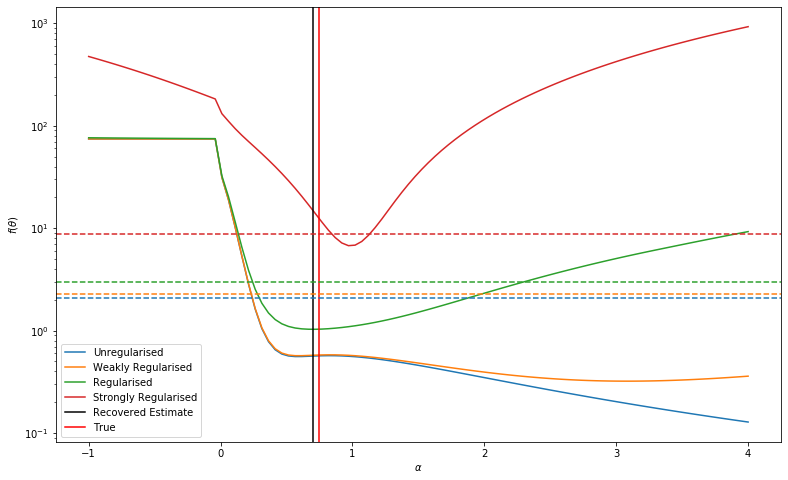

In [57]:
fs_2 = [float(pf['f']) for pf in profile_2]
fs_r2 = [float(pf['f']) for pf in profile_r2]
fs_rr2 = [float(pf['f']) for pf in profile_rr2]
fs_rrr2 = [float(pf['f']) for pf in profile_rrr2]

plt.plot(pvals_2.flatten(), fs_2, label="Unregularised")
plt.plot(pvals_2.flatten(), fs_r2, label="Weakly Regularised")
plt.plot(pvals_2.flatten(), fs_rr2, label="Regularised")
plt.plot(pvals_2.flatten(), fs_rrr2, label="Strongly Regularised")
plt.axvline(float(pref[1]), color='k', label="Recovered Estimate")
plt.axvline(float(p_true[1]), color='r', label="True")
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$f(\theta)$")
plt.legend()
plt.yscale('log')
plt.axhline(min(fs_2) +conf, linestyle='--', color='#1f77b4')
plt.axhline(min(fs_r2)+conf, linestyle='--', color='#ff7f0e')
plt.axhline(min(fs_rr2)+conf, linestyle='--', color='#2ca02c')
plt.axhline(min(fs_rrr2)+conf, linestyle='--', color='#d62728')